In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from random import randrange
# from torchsummary import summary
import os
import datetime

import sys
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
epochs = 1000
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
trainset = torch.load('../data/dataset_10steps.pt')

In [5]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 100, 100]
        # Output size: [batch, 3, 100, 100]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 32, 5, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, 5, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 3, 5, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 9, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 8, 7, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        # print(x.size())
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.size())
        x = torch.flatten(x, start_dim=1) # flatten all dimensions except batch
        # print(x.size())
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # print(x.size())
        x = F.sigmoid(self.fc2(x))
        # print(x.size())
        return x

In [8]:
class StepAE(nn.Module):
    def __init__(self):
        """Variational Auto-Encoder Class"""
        super(StepAE, self).__init__()
        
        self.enc = Autoencoder()

    def step(self, x): # For actual run after training
        x = self.enc(x)
        return x

    def forward(self, x): # For training
        # Encode x to z
        recon1 = self.enc(x)
        recon2 = self.enc(recon1)
        recon3 = self.enc(recon2)
        recon4 = self.enc(recon3)
        # recon5 = self.enc(recon4)
        
        return recon1, recon2, recon3, recon4

# Training

In [9]:
disc_history_real = []
disc_history_fake = []
rme_history = []

In [10]:
# https://uos-deep-learning.tistory.com/16
def calc_gradient_penalty(netD, real_data, generated_data):
    # GP strength
    LAMBDA = 10

    b_size = real_data.size()[0]

    # Calculate interpolation
    alpha = torch.rand(b_size, 1, 1, 1)
    alpha = alpha.expand_as(real_data)
    alpha = alpha.cuda()

    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = torch.autograd.Variable(interpolated, requires_grad=True)
    interpolated = interpolated.cuda()

    # Calculate probability of interpolated examples
    prob_interpolated = netD(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                           create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(b_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return LAMBDA * ((gradients_norm - 1) ** 2).mean()

In [11]:
def train(model, discnet, train_loader, epochnow):
    model.train()
    discnet.train()
    avg_loss = 0
    for step, (x0, _, x1, _, x2, _, x3, _, x4, _) in enumerate(train_loader):
        # noisy_x = x + train_noise_level * torch.randn(*x.shape)
        # noisy_x = np.clip(noisy_x, 0., 1.)
        del _

        x0 = x0.permute(0, 3, 1, 2)
        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)
        x3 = x3.permute(0, 3, 1, 2)
        x4 = x4.permute(0, 3, 1, 2)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))
        # model.eval()
        discnet.train()
        discnet.zero_grad()
        optimizerD.zero_grad()
        r1, r2, r3, r4 = model(x0.cuda())
        
        # All real
        label_size = x1.size(0)
        real_label = 1
        label = torch.full((label_size,), real_label, dtype=torch.float, device=device)       
        for idx, x_ in enumerate([x1, x2, x3, x4]):
            output = discnet(x_.cuda()).view(-1)
            if idx == 0:
                errD_real = criterionD(output, label)
            else:
                errD_real += criterionD(output, label)
        errD_real.backward()
        out_real = output.detach().cpu().numpy()

        # All fake
        fake_label = 0
        label.fill_(fake_label)
        for idx, r_ in enumerate([r1, r2, r3, r4]):
            output = discnet(r_.detach().contiguous()).view(-1)
            if idx == 0:
                errD_fake = criterionD(output, label)
            else:
                errD_fake += criterionD(output, label)
        errD_fake.backward()

        grad_penalty = calc_gradient_penalty(netD, x1.cuda(), r1)
        grad_penalty += calc_gradient_penalty(netD, x2.cuda(), r2)
        grad_penalty += calc_gradient_penalty(netD, x3.cuda(), r3)
        grad_penalty += calc_gradient_penalty(netD, x4.cuda(), r4)
        grad_penalty = 1*grad_penalty
        grad_penalty.backward()

        optimizerD.step()
        del r1, r2, r3, r4

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        # model.train()
        discnet.eval()
        optimizer.zero_grad()
        model.zero_grad()

        r1, r2, r3, r4 = model(x0.cuda())
        label.fill_(real_label)
        for idx, r_ in enumerate([r1, r2, r3, r4]):
            output = discnet(r_.detach().contiguous()).view(-1)
            if idx == 0:
                errG = criterionD(output, label)
            else:
                errG += idx*criterionD(output, label)

        loss1 = criterion(r1, x1.cuda())
        loss2 = criterion(r2, x2.cuda())
        loss3 = criterion(r3, x3.cuda())
        loss4 = criterion(r4, x4.cuda())
        # loss5 = criterion(r5, x5.cuda())
        loss = 10*(loss1 + loss2 + loss3 + loss4) + errG
        
        del x0, x1, x2, x3, x4, r1, r2, r3, r4

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
        loss_history.append(loss.item())

        if step%10 == 0:
            print("step{}, loss = {}, real = {}, fake = {}".format(step, loss, np.mean(out_real), (output.mean().item())), errG.mean().item())
            disc_history_real.append([out_real])
            disc_history_fake.append([output.detach().cpu().numpy()])

        if step%100 == 0:
            # sys.stdout = open(os.devnull, 'w')
            figplot(epochnow, step)
            torch.save(model_origin.state_dict(), "../data/model/" + timestampStr + "/new_stepwise_ep{}_{}.pt".format(epochnow, step))
            torch.save(netD.state_dict(), "../data/model/" + timestampStr + "/new_discnet_ep{}_{}.pt".format(epochnow, step))
            np.save("../data/model/" + timestampStr +"/disc_history_loss", disc_history_fake)
            np.save("../data/model/" + timestampStr +"/disc_history_real", disc_history_real)
            np.save("../data/model/" + timestampStr +"/loss_history", loss_history)
            # sys.stdout = sys.__stdout__

    return avg_loss / len(train_loader)

In [12]:
netD = Discriminator().to(device)
optimizerD = optim.Adam(netD.parameters(), lr=0.001)
criterionD = nn.BCEWithLogitsLoss()

In [13]:
model_origin = StepAE().to(device)
model_origin.load_state_dict(torch.load("../data/model/27_May_2022_18_52/new_stepwise_ep5.pt"))

criterion = nn.MSELoss()
loss_history = []

In [14]:
oneloader = DataLoader(trainset, batch_size=1, shuffle=True)
torch.cuda.empty_cache()

def figplot(epochnow, step):
    model_origin.eval()
    dataiter = iter(oneloader)
    images, _, _, _, _, _, _, _, _, _ = dataiter.next()
    del _

    recon, _, _, _ = model_origin(images.permute(0, 3, 1, 2).cuda())

    del _
    torch.cuda.empty_cache()
    # get sample outputs

    steps = 100
    skip = int(steps/10)
    plt.figure(figsize=(6, 20))
    ii = 0
    for i in range(steps):
        recon, _, _, _ = model_origin(recon)
        del _
        
        if i%skip == 0:
            ii+=1
            ax = plt.subplot(10, 1, ii + 0)
            # print(i)
            # output is resized into a batch of iages
            # use detach when it's an output that requires_grad
            output = recon.detach().view(1, 3, 100, 100).cpu()[0].permute(1, 2, 0)
            # print(output.min(), output.max())
            plt.imshow(output)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            del output
            torch.cuda.empty_cache()
    plt.savefig("../data/model/"+timestampStr+"/fig_{}_{}.png".format(epochnow, step))
    torch.save(images, "../data/model/"+timestampStr+"/input_{}_{}.pt".format(epochnow,step))
    del images
    del recon
    del dataiter

c:\Users\sbin_LAB\.conda\envs\torch\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.418992042541504, real = 0.5078043937683105, fake = 0.5072845220565796 3.299091100692749


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 3.8546204566955566, real = 0.4927254915237427, fake = 0.4917505979537964 3.3403444290161133
step20, loss = 3.8472912311553955, real = 0.4654926359653473, fake = 0.4683189392089844 3.403564691543579
step30, loss = 4.325845241546631, real = 0.4565403461456299, fake = 0.46041253209114075 3.4238104820251465
step40, loss = 3.87019681930542, real = 0.482771098613739, fake = 0.4876381754875183 3.3517799377441406
step50, loss = 4.477517604827881, real = 0.495125949382782, fake = 0.49252235889434814 3.3516170978546143
step60, loss = 3.7629752159118652, real = 0.4991875886917114, fake = 0.5014211535453796 3.3157801628112793
step70, loss = 3.9089367389678955, real = 0.4965604543685913, fake = 0.4934734106063843 3.333580493927002
step80, loss = 3.830510377883911, real = 0.48053956031799316, fake = 0.48777079582214355 3.3518967628479004
step90, loss = 4.419070720672607, real = 0.3349876403808594, fake = 0.302151620388031 3.8837931156158447


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.245155334472656, real = 0.3521890640258789, fake = 0.3579322099685669 3.702652931213379


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.291159152984619, real = 0.388142466545105, fake = 0.3971841335296631 3.6102724075317383
step120, loss = 4.056396484375, real = 0.42267411947250366, fake = 0.43058162927627563 3.5129690170288086
step130, loss = 3.9306159019470215, real = 0.4359419345855713, fake = 0.4441649913787842 3.4728381633758545
step140, loss = 4.423512935638428, real = 0.4430096745491028, fake = 0.4445774555206299 3.4830312728881836
step150, loss = 4.175135135650635, real = 0.3701503872871399, fake = 0.35766497254371643 3.710297107696533
step160, loss = 4.448404788970947, real = 0.28611356019973755, fake = 0.30918827652931213 3.856354236602783
step170, loss = 4.030320167541504, real = 0.3711782693862915, fake = 0.3862227201461792 3.6342661380767822
step180, loss = 4.265292644500732, real = 0.3760591149330139, fake = 0.38137757778167725 3.6494407653808594
step190, loss = 4.148770332336426, real = 0.3605695366859436, fake = 0.3623160421848297 3.698458671569824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.295849323272705, real = 0.3229063153266907, fake = 0.3238241374492645 3.8111486434936523


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.321964263916016, real = 0.30184271931648254, fake = 0.3111056387424469 3.853118419647217
step220, loss = 4.504672050476074, real = 0.26652276515960693, fake = 0.2688279151916504 3.969480037689209
step230, loss = 5.216670036315918, real = 0.27512744069099426, fake = 0.28133589029312134 3.939986228942871
step240, loss = 4.498706817626953, real = 0.25009286403656006, fake = 0.25170594453811646 4.027853012084961
step250, loss = 4.582910060882568, real = 0.23121526837348938, fake = 0.23911786079406738 4.071070671081543
step260, loss = 4.5044941902160645, real = 0.22390425205230713, fake = 0.22336408495903015 4.1154584884643555
step270, loss = 5.234613418579102, real = 0.20426422357559204, fake = 0.20868134498596191 4.155155181884766
step280, loss = 4.789021015167236, real = 0.20929044485092163, fake = 0.1989118605852127 4.187370300292969
step290, loss = 4.671876430511475, real = 0.191327303647995, fake = 0.20227225124835968 4.177729606628418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.758455276489258, real = 0.1998145878314972, fake = 0.1986583024263382 4.194150924682617


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 5.305124282836914, real = 0.19455033540725708, fake = 0.19483965635299683 4.204006671905518
step320, loss = 4.852880477905273, real = 0.20168554782867432, fake = 0.18937236070632935 4.220206260681152
step330, loss = 4.826603412628174, real = 0.20166051387786865, fake = 0.196575328707695 4.199586868286133
step340, loss = 4.7032551765441895, real = 0.20199327170848846, fake = 0.18660297989845276 4.229790210723877
step350, loss = 5.242023468017578, real = 0.19000516831874847, fake = 0.18695403635501862 4.229681491851807
step360, loss = 4.645686626434326, real = 0.20513026416301727, fake = 0.18596908450126648 4.231834411621094
step370, loss = 4.663980007171631, real = 0.18939071893692017, fake = 0.18489891290664673 4.235591888427734
step380, loss = 4.761708736419678, real = 0.1907939314842224, fake = 0.18027381598949432 4.251258850097656
step390, loss = 4.8710126876831055, real = 0.18883688747882843, fake = 0.17845359444618225 4.256774425506592


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.880374908447266, real = 0.19380924105644226, fake = 0.17485779523849487 4.264275550842285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 5.156190872192383, real = 0.17483747005462646, fake = 0.1791176199913025 4.253332138061523
step420, loss = 4.795207500457764, real = 0.20508012175559998, fake = 0.1800915151834488 4.252321243286133
step430, loss = 4.707118034362793, real = 0.18739880621433258, fake = 0.1791776716709137 4.252362251281738
step440, loss = 4.665008544921875, real = 0.18710406124591827, fake = 0.18014967441558838 4.249311447143555
step450, loss = 4.66563606262207, real = 0.1937696933746338, fake = 0.1811482310295105 4.24783992767334
step460, loss = 5.37439489364624, real = 0.19588202238082886, fake = 0.18429264426231384 4.238496780395508
step470, loss = 4.668819427490234, real = 0.1847417801618576, fake = 0.1752539873123169 4.263468265533447
step480, loss = 5.4876933097839355, real = 0.19393384456634521, fake = 0.18182611465454102 4.244129180908203
step490, loss = 4.629337310791016, real = 0.20198598504066467, fake = 0.17970383167266846 4.254552364349365


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 5.229451656341553, real = 0.18987500667572021, fake = 0.18075405061244965 4.2478251457214355


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.814472675323486, real = 0.2212054282426834, fake = 0.1760367751121521 4.259824275970459
step520, loss = 4.8504180908203125, real = 0.1969543993473053, fake = 0.18311388790607452 4.239872932434082
step530, loss = 4.640296459197998, real = 0.18229016661643982, fake = 0.18260279297828674 4.241619110107422
step540, loss = 4.783910274505615, real = 0.17831355333328247, fake = 0.17453913390636444 4.266672611236572
step550, loss = 4.7432074546813965, real = 0.18305954337120056, fake = 0.17913423478603363 4.253532409667969
step560, loss = 4.736440181732178, real = 0.17829939723014832, fake = 0.1800687313079834 4.249670028686523
step570, loss = 5.336977005004883, real = 0.19455134868621826, fake = 0.17695409059524536 4.260952949523926
step580, loss = 4.816051959991455, real = 0.19056686758995056, fake = 0.17893670499324799 4.252606391906738
step590, loss = 4.759582042694092, real = 0.18173673748970032, fake = 0.1722256988286972 4.2770586013793945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.751624584197998, real = 0.16998890042304993, fake = 0.17668402194976807 4.260634422302246


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 5.330683708190918, real = 0.18564409017562866, fake = 0.1788238286972046 4.2564287185668945
step620, loss = 4.733375072479248, real = 0.188002809882164, fake = 0.1704312562942505 4.27968692779541
step630, loss = 4.722127437591553, real = 0.16376088559627533, fake = 0.174648717045784 4.267690181732178
step640, loss = 5.6014580726623535, real = 0.18428440392017365, fake = 0.17773491144180298 4.256723880767822
step650, loss = 4.838867664337158, real = 0.2086743861436844, fake = 0.1783587485551834 4.256128311157227
step660, loss = 4.740910053253174, real = 0.19144535064697266, fake = 0.17785565555095673 4.258463382720947
step670, loss = 4.9069623947143555, real = 0.17497029900550842, fake = 0.17193332314491272 4.275821208953857
step680, loss = 4.765104293823242, real = 0.1941065490245819, fake = 0.17426955699920654 4.272780418395996
step690, loss = 4.834821701049805, real = 0.18211784958839417, fake = 0.17169591784477234 4.276244640350342


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.72807502746582, real = 0.17662307620048523, fake = 0.1709490269422531 4.278909683227539


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 5.030570983886719, real = 0.19376473128795624, fake = 0.16986162960529327 4.282096862792969
step720, loss = 4.772065162658691, real = 0.16552609205245972, fake = 0.17504528164863586 4.265871524810791
step730, loss = 4.788045406341553, real = 0.19246900081634521, fake = 0.17165955901145935 4.276485919952393
step740, loss = 5.227880001068115, real = 0.19488590955734253, fake = 0.1811314821243286 4.2491583824157715
step750, loss = 4.697429180145264, real = 0.2031451165676117, fake = 0.17304493486881256 4.273862838745117
step760, loss = 4.903990268707275, real = 0.18383684754371643, fake = 0.17261753976345062 4.274039268493652
step770, loss = 4.93468713760376, real = 0.18531358242034912, fake = 0.1751658022403717 4.265202522277832
step780, loss = 5.100118637084961, real = 0.19805331528186798, fake = 0.17754778265953064 4.2595415115356445
step790, loss = 4.622908592224121, real = 0.19173192977905273, fake = 0.18184898793697357 4.24427604675293


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.716454029083252, real = 0.1851024329662323, fake = 0.17581577599048615 4.263308525085449


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.729696273803711, real = 0.1851712465286255, fake = 0.17561180889606476 4.263483047485352
step820, loss = 4.88841438293457, real = 0.19387154281139374, fake = 0.17776119709014893 4.2596588134765625
step830, loss = 4.816715240478516, real = 0.17016780376434326, fake = 0.1770424097776413 4.258745193481445
step840, loss = 4.749295711517334, real = 0.17816048860549927, fake = 0.17222751677036285 4.275704860687256
step850, loss = 4.829648494720459, real = 0.19913296401500702, fake = 0.1693190336227417 4.28476619720459
step860, loss = 4.864294052124023, real = 0.18527863919734955, fake = 0.16933059692382812 4.285302639007568
step870, loss = 4.970782279968262, real = 0.19070611894130707, fake = 0.17137253284454346 4.276504993438721
step880, loss = 5.467170238494873, real = 0.18045324087142944, fake = 0.1725895255804062 4.273650646209717
step890, loss = 4.860435962677002, real = 0.17915421724319458, fake = 0.17548799514770508 4.264246940612793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.840998649597168, real = 0.2003905177116394, fake = 0.1731925755739212 4.27232551574707


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.69647741317749, real = 0.16966071724891663, fake = 0.17480254173278809 4.26692008972168
step920, loss = 4.812740325927734, real = 0.18498185276985168, fake = 0.17308317124843597 4.272141933441162
step930, loss = 4.756269454956055, real = 0.19129925966262817, fake = 0.1715380847454071 4.277910232543945
step940, loss = 4.711420059204102, real = 0.19435453414916992, fake = 0.1698015034198761 4.28278923034668
step950, loss = 5.356069564819336, real = 0.19232667982578278, fake = 0.17409875988960266 4.271421909332275
step960, loss = 5.599932670593262, real = 0.1810113787651062, fake = 0.17064842581748962 4.27994966506958
step970, loss = 4.755321502685547, real = 0.1832340657711029, fake = 0.16901104152202606 4.286078453063965
step980, loss = 4.7741241455078125, real = 0.18150293827056885, fake = 0.17346709966659546 4.2708353996276855
step990, loss = 4.723323822021484, real = 0.16966259479522705, fake = 0.16942177712917328 4.2855119705200195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.8715033531188965, real = 0.1793612390756607, fake = 0.17055228352546692 4.278258800506592


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.727312088012695, real = 0.182368665933609, fake = 0.1732732653617859 4.269370079040527
step1020, loss = 4.74845552444458, real = 0.18501654267311096, fake = 0.17075380682945251 4.281054496765137
step1030, loss = 4.688605785369873, real = 0.18369805812835693, fake = 0.16988404095172882 4.282058238983154
step1040, loss = 5.109020709991455, real = 0.17562274634838104, fake = 0.173127219080925 4.274303436279297
step1050, loss = 4.736044883728027, real = 0.1901264190673828, fake = 0.17236919701099396 4.274068832397461
step1060, loss = 4.836538791656494, real = 0.17761708796024323, fake = 0.1735084354877472 4.27205228805542
step1070, loss = 4.8182878494262695, real = 0.18398264050483704, fake = 0.1735125184059143 4.271970272064209
step1080, loss = 4.805656433105469, real = 0.19030152261257172, fake = 0.17361345887184143 4.272678375244141
step1090, loss = 4.867744445800781, real = 0.17670542001724243, fake = 0.1738525778055191 4.269870758056641


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.850264549255371, real = 0.18300271034240723, fake = 0.17251023650169373 4.273474216461182


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.677246570587158, real = 0.17873653769493103, fake = 0.17617851495742798 4.2626566886901855
step1120, loss = 4.780727386474609, real = 0.18493998050689697, fake = 0.17348997294902802 4.27039909362793
step1130, loss = 4.734037399291992, real = 0.18253064155578613, fake = 0.1669791340827942 4.29141902923584
step1140, loss = 4.803670406341553, real = 0.18363098800182343, fake = 0.1707075536251068 4.278953552246094
step1150, loss = 4.7794508934021, real = 0.17010736465454102, fake = 0.17300288379192352 4.274497032165527
step1160, loss = 4.715566158294678, real = 0.19176602363586426, fake = 0.1715579330921173 4.2772626876831055
step1170, loss = 5.111544132232666, real = 0.18256790935993195, fake = 0.17967489361763 4.251160621643066
step1180, loss = 5.448486328125, real = 0.18272064626216888, fake = 0.16962218284606934 4.284689903259277
step1190, loss = 5.311084747314453, real = 0.1944556087255478, fake = 0.1701151728630066 4.284516334533691


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.792703151702881, real = 0.1738397777080536, fake = 0.1679135262966156 4.289330959320068


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.744779109954834, real = 0.19351667165756226, fake = 0.16628751158714294 4.2957563400268555
step1220, loss = 4.720026969909668, real = 0.18803074955940247, fake = 0.17236241698265076 4.274102210998535
step1230, loss = 4.752303600311279, real = 0.1888316422700882, fake = 0.17772185802459717 4.256664276123047
step1240, loss = 5.349027633666992, real = 0.1988690197467804, fake = 0.17659786343574524 4.259429931640625
step1250, loss = 4.781738758087158, real = 0.18018662929534912, fake = 0.17732179164886475 4.258561134338379
step1260, loss = 6.345141410827637, real = 0.19115129113197327, fake = 0.1779806911945343 4.2534966468811035
step1270, loss = 4.687230110168457, real = 0.17917239665985107, fake = 0.17419487237930298 4.270094394683838
step1280, loss = 4.8016037940979, real = 0.19063714146614075, fake = 0.17651867866516113 4.263401985168457
step1290, loss = 4.723309516906738, real = 0.18960441648960114, fake = 0.17462357878684998 4.265694618225098


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.739123344421387, real = 0.17715170979499817, fake = 0.17330607771873474 4.273658752441406


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.735383987426758, real = 0.18966753780841827, fake = 0.16793233156204224 4.28824520111084
step1320, loss = 4.658366680145264, real = 0.17064745724201202, fake = 0.18123851716518402 4.244603633880615
step1330, loss = 4.748458385467529, real = 0.2015000283718109, fake = 0.17062079906463623 4.280200958251953
step1340, loss = 4.658656597137451, real = 0.17349311709403992, fake = 0.18214371800422668 4.242515563964844
step1350, loss = 4.782026290893555, real = 0.19328700006008148, fake = 0.17638657987117767 4.260852813720703
step1360, loss = 5.567806243896484, real = 0.17555372416973114, fake = 0.1760198175907135 4.265604019165039
step1370, loss = 4.775121212005615, real = 0.17574097216129303, fake = 0.17718280851840973 4.260351657867432
step1380, loss = 4.82786226272583, real = 0.1865534782409668, fake = 0.17329537868499756 4.271797180175781
step1390, loss = 4.92404842376709, real = 0.18996955454349518, fake = 0.17126788198947906 4.278903007507324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.670811653137207, real = 0.17183822393417358, fake = 0.17426902055740356 4.268444061279297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.803153991699219, real = 0.19430899620056152, fake = 0.1640501618385315 4.302593231201172
step1420, loss = 4.7403411865234375, real = 0.18610361218452454, fake = 0.15984344482421875 4.3136467933654785
step1430, loss = 5.220991134643555, real = 0.1538981944322586, fake = 0.17180991172790527 4.274870872497559
step1440, loss = 4.960316181182861, real = 0.17791065573692322, fake = 0.1623493880033493 4.307082176208496
step1450, loss = 4.758566379547119, real = 0.17661422491073608, fake = 0.16265219449996948 4.304250240325928
step1460, loss = 4.7578253746032715, real = 0.18595150113105774, fake = 0.1686909943819046 4.286130428314209
step1470, loss = 5.372555732727051, real = 0.18288958072662354, fake = 0.16966331005096436 4.281778335571289
step1480, loss = 4.824043273925781, real = 0.18228884041309357, fake = 0.16518723964691162 4.298029899597168
step1490, loss = 4.700229644775391, real = 0.1807636171579361, fake = 0.16883942484855652 4.286816596984863


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.879262924194336, real = 0.18840184807777405, fake = 0.163487046957016 4.303892135620117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.659541130065918, real = 0.16188648343086243, fake = 0.1720973700284958 4.274331092834473
step1520, loss = 4.847388744354248, real = 0.18624985218048096, fake = 0.1625908762216568 4.306049346923828
step1530, loss = 5.357770919799805, real = 0.18380329012870789, fake = 0.16552013158798218 4.2983503341674805
step1540, loss = 5.827611923217773, real = 0.17089468240737915, fake = 0.16932937502861023 4.2831525802612305
step1550, loss = 4.8157501220703125, real = 0.1810951828956604, fake = 0.16128824651241302 4.309358596801758
step1560, loss = 4.7383198738098145, real = 0.17268642783164978, fake = 0.1657617688179016 4.295185089111328
step1570, loss = 4.892666816711426, real = 0.20658595860004425, fake = 0.16179049015045166 4.309086799621582
step1580, loss = 4.795111179351807, real = 0.1887156069278717, fake = 0.16243448853492737 4.305426120758057
step1590, loss = 4.736403465270996, real = 0.17404745519161224, fake = 0.16712358593940735 4.29024600982666


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.927974700927734, real = 0.17524835467338562, fake = 0.1628384292125702 4.305434703826904


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 5.386905670166016, real = 0.18089237809181213, fake = 0.1674525886774063 4.292287349700928
step1620, loss = 4.727725982666016, real = 0.1852041482925415, fake = 0.17115536332130432 4.278466701507568
step1630, loss = 4.65854549407959, real = 0.18085242807865143, fake = 0.17220067977905273 4.2757978439331055
step1640, loss = 5.272542953491211, real = 0.18870344758033752, fake = 0.1648656129837036 4.300534248352051
step1650, loss = 4.697225093841553, real = 0.1835622787475586, fake = 0.16828542947769165 4.287751197814941
step1660, loss = 5.130697250366211, real = 0.16579237580299377, fake = 0.16227932274341583 4.305405616760254
step1670, loss = 4.80105447769165, real = 0.18067902326583862, fake = 0.16418319940567017 4.300349235534668
step1680, loss = 4.772228717803955, real = 0.1722906529903412, fake = 0.16801324486732483 4.288661479949951
step1690, loss = 5.014369487762451, real = 0.17579972743988037, fake = 0.16725338995456696 4.291428565979004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.6992998123168945, real = 0.17524419724941254, fake = 0.16789624094963074 4.289444923400879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.3032732009887695, real = 0.17321839928627014, fake = 0.17573292553424835 4.263617038726807
step1720, loss = 4.726131916046143, real = 0.17814937233924866, fake = 0.17324712872505188 4.27055549621582
step1730, loss = 4.70565128326416, real = 0.18343818187713623, fake = 0.16859930753707886 4.287752151489258
step1740, loss = 4.697030544281006, real = 0.17038686573505402, fake = 0.16835139691829681 4.2875447273254395
step1750, loss = 5.310686111450195, real = 0.18431569635868073, fake = 0.16881245374679565 4.286441802978516
step1760, loss = 4.663784980773926, real = 0.18734785914421082, fake = 0.17085126042366028 4.279900550842285
step1770, loss = 4.6779255867004395, real = 0.18008385598659515, fake = 0.17214319109916687 4.27511739730835
step1780, loss = 4.698904991149902, real = 0.1758505403995514, fake = 0.17486761510372162 4.266776084899902
step1790, loss = 4.887089729309082, real = 0.18251803517341614, fake = 0.17595145106315613 4.263381004333496


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.813394546508789, real = 0.18666154146194458, fake = 0.17169323563575745 4.277563095092773


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.8067946434021, real = 0.17731121182441711, fake = 0.17834781110286713 4.25597620010376
step1820, loss = 4.724099159240723, real = 0.1898670494556427, fake = 0.17548450827598572 4.26527214050293
step1830, loss = 4.789629936218262, real = 0.17736300826072693, fake = 0.1799086481332779 4.249061584472656
[Epoch 1] loss:4.77612560730584


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.571904182434082, real = 0.17922213673591614, fake = 0.24719491600990295 4.036830902099609


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.4848761558532715, real = 0.21826417744159698, fake = 0.19992950558662415 4.188425064086914
step20, loss = 4.844803810119629, real = 0.20186541974544525, fake = 0.20296576619148254 4.1762590408325195
step30, loss = 4.788887977600098, real = 0.19907866418361664, fake = 0.18387717008590698 4.237780570983887
step40, loss = 4.825502395629883, real = 0.1881648749113083, fake = 0.17551977932453156 4.264430046081543
step50, loss = 5.257339954376221, real = 0.18190833926200867, fake = 0.17599396407604218 4.264108657836914
step60, loss = 4.865686893463135, real = 0.19572843611240387, fake = 0.18022803962230682 4.249156951904297
step70, loss = 4.680508613586426, real = 0.19320480525493622, fake = 0.1851750910282135 4.233677864074707
step80, loss = 5.724081039428711, real = 0.19731199741363525, fake = 0.17678683996200562 4.25955057144165
step90, loss = 4.633062362670898, real = 0.16664905846118927, fake = 0.18469765782356262 4.234034538269043


C:\Users\sbin_LAB\AppData\Local\Temp\ipykernel_10256\1624440215.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6, 20))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 5.316261291503906, real = 0.2195318043231964, fake = 0.18284739553928375 4.241876602172852


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.686946392059326, real = 0.21683387458324432, fake = 0.18743199110031128 4.2275190353393555
step120, loss = 4.65056848526001, real = 0.19502514600753784, fake = 0.18272948265075684 4.241562843322754
step130, loss = 5.350702285766602, real = 0.20865830779075623, fake = 0.18374820053577423 4.238101005554199
step140, loss = 4.731043815612793, real = 0.1854173243045807, fake = 0.1887339949607849 4.221874237060547
step150, loss = 4.697009086608887, real = 0.20174694061279297, fake = 0.17804034054279327 4.257513046264648
step160, loss = 5.195321559906006, real = 0.2053496092557907, fake = 0.17853660881519318 4.256600379943848
step170, loss = 4.872076511383057, real = 0.17386288940906525, fake = 0.18209010362625122 4.244937896728516
step180, loss = 4.715208053588867, real = 0.19512143731117249, fake = 0.18062713742256165 4.248906135559082
step190, loss = 4.688390254974365, real = 0.17267285287380219, fake = 0.1787414252758026 4.2541422843933105


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.650418281555176, real = 0.19261910021305084, fake = 0.17844858765602112 4.256125450134277


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.980265140533447, real = 0.19485163688659668, fake = 0.17643696069717407 4.260706424713135
step220, loss = 4.685203552246094, real = 0.18032494187355042, fake = 0.1818372905254364 4.244176387786865
step230, loss = 4.742918014526367, real = 0.19021683931350708, fake = 0.1785498559474945 4.255246162414551
step240, loss = 4.780850887298584, real = 0.2110162228345871, fake = 0.18429017066955566 4.237098217010498
step250, loss = 4.711552619934082, real = 0.19524255394935608, fake = 0.18456076085567474 4.234826564788818
step260, loss = 4.692318916320801, real = 0.19339166581630707, fake = 0.1790725588798523 4.254692077636719
step270, loss = 4.770756244659424, real = 0.20309998095035553, fake = 0.1807694137096405 4.249088287353516
step280, loss = 4.676040172576904, real = 0.18524399399757385, fake = 0.18515439331531525 4.234170913696289
step290, loss = 4.780930042266846, real = 0.19350877404212952, fake = 0.18068787455558777 4.248786449432373


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.642185211181641, real = 0.209333136677742, fake = 0.17799997329711914 4.2563629150390625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.708911418914795, real = 0.19026151299476624, fake = 0.17987921833992004 4.250488758087158
step320, loss = 5.211238861083984, real = 0.21140632033348083, fake = 0.18495513498783112 4.234273910522461
step330, loss = 4.782067775726318, real = 0.20959821343421936, fake = 0.17934000492095947 4.253404140472412
step340, loss = 4.673532962799072, real = 0.19730371236801147, fake = 0.18428854644298553 4.236057281494141
step350, loss = 4.758338451385498, real = 0.18837054073810577, fake = 0.17352086305618286 4.2714056968688965
step360, loss = 4.794680118560791, real = 0.19939017295837402, fake = 0.16819331049919128 4.289178848266602
step370, loss = 4.797028541564941, real = 0.19250836968421936, fake = 0.17852823436260223 4.256647109985352
step380, loss = 5.378195762634277, real = 0.1911371499300003, fake = 0.18070051074028015 4.248212814331055
step390, loss = 4.678834438323975, real = 0.1826731562614441, fake = 0.17885839939117432 4.25507926940918


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.674214839935303, real = 0.2026805281639099, fake = 0.17854569852352142 4.25464391708374


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.939768314361572, real = 0.19941453635692596, fake = 0.1836526095867157 4.239179611206055
step420, loss = 4.655086994171143, real = 0.1815449595451355, fake = 0.18113577365875244 4.248081207275391
step430, loss = 5.290057182312012, real = 0.20621417462825775, fake = 0.1786763072013855 4.253634452819824
step440, loss = 4.80615234375, real = 0.17862051725387573, fake = 0.18192070722579956 4.243406772613525
step450, loss = 4.690420627593994, real = 0.18786662817001343, fake = 0.18445083498954773 4.236849784851074
step460, loss = 4.842972278594971, real = 0.19500654935836792, fake = 0.1761564165353775 4.2629241943359375
step470, loss = 4.778374195098877, real = 0.18011537194252014, fake = 0.1741051971912384 4.270280838012695
step480, loss = 5.36551570892334, real = 0.20220209658145905, fake = 0.170720636844635 4.279757976531982
step490, loss = 4.702651023864746, real = 0.1955479383468628, fake = 0.17974773049354553 4.250242233276367


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.806963920593262, real = 0.19550509750843048, fake = 0.18887460231781006 4.223090171813965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.644272804260254, real = 0.2134658396244049, fake = 0.19351045787334442 4.207993984222412
step520, loss = 4.516075611114502, real = 0.20079748332500458, fake = 0.18628861010074615 4.232122421264648
step530, loss = 5.389569282531738, real = 0.19464266300201416, fake = 0.18161219358444214 4.242954730987549
step540, loss = 4.630718231201172, real = 0.199227973818779, fake = 0.1749742329120636 4.265958309173584
step550, loss = 4.739777565002441, real = 0.18144166469573975, fake = 0.17477241158485413 4.267796039581299
step560, loss = 4.710081577301025, real = 0.19845277070999146, fake = 0.18061688542366028 4.247749328613281
step570, loss = 5.32157564163208, real = 0.1972181499004364, fake = 0.18510934710502625 4.2345099449157715
step580, loss = 4.63867712020874, real = 0.18410122394561768, fake = 0.18477383255958557 4.236010551452637
step590, loss = 4.7001214027404785, real = 0.19054117798805237, fake = 0.1792173832654953 4.252096176147461


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.73333215713501, real = 0.21160680055618286, fake = 0.18329918384552002 4.2397918701171875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.738795757293701, real = 0.19224800169467926, fake = 0.1903688609600067 4.218786239624023
step620, loss = 4.599865913391113, real = 0.21144507825374603, fake = 0.20702999830245972 4.165428161621094
step630, loss = 4.623602867126465, real = 0.22874745726585388, fake = 0.20137086510658264 4.184049606323242
step640, loss = 4.714488506317139, real = 0.1897304803133011, fake = 0.18914730846881866 4.220693111419678
step650, loss = 4.737427234649658, real = 0.19782346487045288, fake = 0.17899569869041443 4.253608703613281
step660, loss = 5.343217849731445, real = 0.18366986513137817, fake = 0.17671310901641846 4.259833335876465
step670, loss = 4.790706157684326, real = 0.19123446941375732, fake = 0.18230274319648743 4.243934154510498
step680, loss = 4.640061855316162, real = 0.1948031187057495, fake = 0.18199092149734497 4.245050430297852
step690, loss = 4.6051554679870605, real = 0.20092880725860596, fake = 0.19467484951019287 4.204570770263672


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.621072292327881, real = 0.2149152159690857, fake = 0.19387942552566528 4.206996917724609


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.729196071624756, real = 0.1899797022342682, fake = 0.18534375727176666 4.232487678527832
step720, loss = 4.726802349090576, real = 0.19098106026649475, fake = 0.18131214380264282 4.246709823608398
step730, loss = 5.151324272155762, real = 0.2016085684299469, fake = 0.18091075122356415 4.247729778289795
step740, loss = 5.110995292663574, real = 0.19926682114601135, fake = 0.1879669427871704 4.226723670959473
step750, loss = 4.639315128326416, real = 0.1815681755542755, fake = 0.19740647077560425 4.1950602531433105
step760, loss = 5.2959113121032715, real = 0.2362092137336731, fake = 0.1996067464351654 4.187694549560547
step770, loss = 4.972924709320068, real = 0.21053127944469452, fake = 0.19184087216854095 4.215493202209473
step780, loss = 4.63750696182251, real = 0.20010237395763397, fake = 0.1817806363105774 4.245213985443115
step790, loss = 4.747128963470459, real = 0.20058807730674744, fake = 0.17987015843391418 4.25230598449707


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.698923110961914, real = 0.20444563031196594, fake = 0.185209259390831 4.233819484710693


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.670027732849121, real = 0.20831948518753052, fake = 0.19044791162014008 4.217135429382324
step820, loss = 4.857006072998047, real = 0.21424712240695953, fake = 0.19874346256256104 4.190731525421143
step830, loss = 4.5010666847229, real = 0.2122444361448288, fake = 0.2052917182445526 4.169569969177246
step840, loss = 4.60103178024292, real = 0.2189415991306305, fake = 0.20935408771038055 4.157438278198242
step850, loss = 5.178390026092529, real = 0.21181678771972656, fake = 0.20926743745803833 4.158447265625
step860, loss = 4.877249240875244, real = 0.20340323448181152, fake = 0.19318002462387085 4.208957672119141
step870, loss = 4.610306262969971, real = 0.20387637615203857, fake = 0.19395524263381958 4.20629358291626
step880, loss = 4.603643417358398, real = 0.19427132606506348, fake = 0.1965901255607605 4.197641849517822
step890, loss = 4.725235939025879, real = 0.2003481686115265, fake = 0.19166068732738495 4.213127613067627


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.790658950805664, real = 0.21197661757469177, fake = 0.1971454620361328 4.195509910583496


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.5918498039245605, real = 0.23064087331295013, fake = 0.20904023945331573 4.158148765563965
step920, loss = 4.710315704345703, real = 0.20716632902622223, fake = 0.20292550325393677 4.178471565246582
step930, loss = 4.699143409729004, real = 0.2240697592496872, fake = 0.20319491624832153 4.175957679748535
step940, loss = 5.139220237731934, real = 0.22292926907539368, fake = 0.20182041823863983 4.181144714355469
step950, loss = 4.684180736541748, real = 0.1825784593820572, fake = 0.18864205479621887 4.221532821655273
step960, loss = 4.576841354370117, real = 0.20822620391845703, fake = 0.1841137707233429 4.23825740814209
step970, loss = 5.44202995300293, real = 0.19074542820453644, fake = 0.2001466304063797 4.187045097351074
step980, loss = 4.638236045837402, real = 0.21663762629032135, fake = 0.20616626739501953 4.168294906616211
step990, loss = 5.152788162231445, real = 0.2377050668001175, fake = 0.21575471758842468 4.137693881988525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.558703422546387, real = 0.22175264358520508, fake = 0.21931257843971252 4.127105712890625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.678287029266357, real = 0.22408905625343323, fake = 0.20556798577308655 4.1700439453125
step1020, loss = 4.619540214538574, real = 0.21469849348068237, fake = 0.2014388144016266 4.182875633239746
step1030, loss = 4.703192710876465, real = 0.2082827091217041, fake = 0.20547327399253845 4.170160293579102
step1040, loss = 4.600337982177734, real = 0.20479008555412292, fake = 0.21215540170669556 4.149313926696777
step1050, loss = 4.702671527862549, real = 0.2131258249282837, fake = 0.20144090056419373 4.182231426239014
step1060, loss = 4.710001468658447, real = 0.22003784775733948, fake = 0.20731966197490692 4.163470268249512
step1070, loss = 4.64235782623291, real = 0.22438660264015198, fake = 0.2143363058567047 4.1426520347595215
step1080, loss = 4.709561824798584, real = 0.22435103356838226, fake = 0.21025347709655762 4.155189514160156
step1090, loss = 4.466766357421875, real = 0.21325495839118958, fake = 0.21364232897758484 4.145750045776367


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.659406661987305, real = 0.22968630492687225, fake = 0.208595871925354 4.159943580627441


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.6460280418396, real = 0.22559818625450134, fake = 0.2111070454120636 4.1518731117248535
step1120, loss = 4.558084487915039, real = 0.22841021418571472, fake = 0.21247705817222595 4.147916316986084
step1130, loss = 4.623600006103516, real = 0.23082467913627625, fake = 0.20562145113945007 4.169137001037598
step1140, loss = 4.665676116943359, real = 0.21432176232337952, fake = 0.210220068693161 4.1552228927612305
step1150, loss = 4.7916975021362305, real = 0.22790208458900452, fake = 0.20905236899852753 4.158787250518799
step1160, loss = 4.682027816772461, real = 0.21172268688678741, fake = 0.20579420030117035 4.169320106506348
step1170, loss = 4.582940578460693, real = 0.21106261014938354, fake = 0.206645667552948 4.166007995605469
step1180, loss = 4.6720991134643555, real = 0.21010953187942505, fake = 0.20444607734680176 4.172757625579834
step1190, loss = 4.638378620147705, real = 0.21717149019241333, fake = 0.20665906369686127 4.166813850402832


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.666982173919678, real = 0.23181068897247314, fake = 0.2119152694940567 4.151129722595215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.657454490661621, real = 0.21727700531482697, fake = 0.204993337392807 4.172309875488281
step1220, loss = 5.131768226623535, real = 0.2292957305908203, fake = 0.21050286293029785 4.153862476348877
step1230, loss = 4.569685459136963, real = 0.2153901308774948, fake = 0.20584340393543243 4.168891429901123
step1240, loss = 4.5714616775512695, real = 0.21415090560913086, fake = 0.20520524680614471 4.170059680938721
step1250, loss = 4.608684062957764, real = 0.2045922726392746, fake = 0.20814231038093567 4.162365913391113
step1260, loss = 4.680078983306885, real = 0.20597311854362488, fake = 0.2002989649772644 4.186927795410156
step1270, loss = 4.596087455749512, real = 0.22463351488113403, fake = 0.20427009463310242 4.173245906829834
step1280, loss = 4.514037609100342, real = 0.2127971649169922, fake = 0.20540080964565277 4.170718193054199
step1290, loss = 4.57219123840332, real = 0.20999136567115784, fake = 0.2094811499118805 4.157622814178467


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.637387752532959, real = 0.22889021039009094, fake = 0.2008521854877472 4.184793472290039


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 5.234179973602295, real = 0.2175378054380417, fake = 0.20587000250816345 4.169715881347656
step1320, loss = 4.497843265533447, real = 0.21682435274124146, fake = 0.2137298285961151 4.144693374633789
step1330, loss = 5.051281929016113, real = 0.22107557952404022, fake = 0.20358015596866608 4.174759387969971
step1340, loss = 4.648741245269775, real = 0.21650473773479462, fake = 0.20869341492652893 4.160048484802246
step1350, loss = 4.663978099822998, real = 0.23222963511943817, fake = 0.2121056467294693 4.149236679077148
step1360, loss = 4.586958408355713, real = 0.21810036897659302, fake = 0.20207713544368744 4.1815032958984375
step1370, loss = 5.642181873321533, real = 0.21952944993972778, fake = 0.20726607739925385 4.165624141693115
step1380, loss = 5.326552867889404, real = 0.21786588430404663, fake = 0.20473352074623108 4.172793388366699
step1390, loss = 4.611016750335693, real = 0.2124778926372528, fake = 0.20481103658676147 4.170385360717773


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.688733100891113, real = 0.21803122758865356, fake = 0.21241188049316406 4.148420810699463


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.602569580078125, real = 0.22153878211975098, fake = 0.20465481281280518 4.171290874481201
step1420, loss = 4.709409236907959, real = 0.2275885045528412, fake = 0.20586948096752167 4.16767692565918
step1430, loss = 4.601754665374756, real = 0.2242020219564438, fake = 0.21100042760372162 4.152759075164795
step1440, loss = 4.613128662109375, real = 0.2183433473110199, fake = 0.20416384935379028 4.173819541931152
step1450, loss = 4.561519622802734, real = 0.21947512030601501, fake = 0.20972511172294617 4.155511856079102
step1460, loss = 4.639366149902344, real = 0.23295900225639343, fake = 0.21601739525794983 4.136117935180664
step1470, loss = 4.7703776359558105, real = 0.20387378334999084, fake = 0.19883018732070923 4.190558433532715
step1480, loss = 4.617615222930908, real = 0.22872743010520935, fake = 0.2082328051328659 4.161386489868164
step1490, loss = 4.625144004821777, real = 0.2098620980978012, fake = 0.21001675724983215 4.155792713165283


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.648375988006592, real = 0.2181984782218933, fake = 0.2009882628917694 4.18388557434082


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.637074947357178, real = 0.22344908118247986, fake = 0.21130141615867615 4.150676250457764
step1520, loss = 4.813529014587402, real = 0.22067472338676453, fake = 0.2135128676891327 4.146028995513916
step1530, loss = 4.683946132659912, real = 0.21781668066978455, fake = 0.20350652933120728 4.175478935241699
step1540, loss = 4.641425132751465, real = 0.20865678787231445, fake = 0.20787939429283142 4.161609172821045
step1550, loss = 4.6988067626953125, real = 0.21453464031219482, fake = 0.2036169469356537 4.176487922668457
step1560, loss = 4.587057590484619, real = 0.22324781119823456, fake = 0.20252397656440735 4.179011344909668
step1570, loss = 4.758426666259766, real = 0.2098717987537384, fake = 0.2034643590450287 4.17546272277832
step1580, loss = 4.841192722320557, real = 0.2309236079454422, fake = 0.20743979513645172 4.163097858428955
step1590, loss = 4.650425434112549, real = 0.20637762546539307, fake = 0.203688383102417 4.175759315490723


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.794931411743164, real = 0.22582277655601501, fake = 0.2087000608444214 4.159952163696289


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.633596420288086, real = 0.21958261728286743, fake = 0.20619496703147888 4.16829776763916
step1620, loss = 4.7248148918151855, real = 0.2192952185869217, fake = 0.20837436616420746 4.160674571990967
step1630, loss = 4.824760913848877, real = 0.22793057560920715, fake = 0.2048812210559845 4.170825958251953
step1640, loss = 4.691164970397949, real = 0.20056524872779846, fake = 0.19227281212806702 4.211252212524414
step1650, loss = 4.499724864959717, real = 0.21304866671562195, fake = 0.21891281008720398 4.128100872039795
step1660, loss = 4.584992408752441, real = 0.22279630601406097, fake = 0.2113180160522461 4.152132511138916
step1670, loss = 5.42598295211792, real = 0.23022475838661194, fake = 0.20508518815040588 4.171894073486328
step1680, loss = 4.710232257843018, real = 0.19126729667186737, fake = 0.20271742343902588 4.1787590980529785
step1690, loss = 4.5606279373168945, real = 0.21642786264419556, fake = 0.20613953471183777 4.1677703857421875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 5.473041534423828, real = 0.21754834055900574, fake = 0.2105947732925415 4.1530256271362305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.5068840980529785, real = 0.21546371281147003, fake = 0.2052558958530426 4.171545028686523
step1720, loss = 4.720074653625488, real = 0.22417667508125305, fake = 0.21910490095615387 4.127322196960449
step1730, loss = 4.564322471618652, real = 0.2302112579345703, fake = 0.20579464733600616 4.168940544128418
step1740, loss = 4.83462381362915, real = 0.20828963816165924, fake = 0.21783873438835144 4.131335735321045
step1750, loss = 4.768417835235596, real = 0.2355939745903015, fake = 0.22088338434696198 4.119967460632324
step1760, loss = 4.606046199798584, real = 0.22137688100337982, fake = 0.21588726341724396 4.137649059295654
step1770, loss = 5.170040607452393, real = 0.22079382836818695, fake = 0.20495706796646118 4.170503616333008
step1780, loss = 5.068478584289551, real = 0.20721085369586945, fake = 0.20397037267684937 4.175111770629883
step1790, loss = 4.65472936630249, real = 0.20646779239177704, fake = 0.20568090677261353 4.168428897857666


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 5.0898332595825195, real = 0.21488884091377258, fake = 0.2079005241394043 4.162901878356934


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.617890357971191, real = 0.22477325797080994, fake = 0.21127155423164368 4.153162956237793
step1820, loss = 5.0552520751953125, real = 0.22640608251094818, fake = 0.2061235010623932 4.1677327156066895
step1830, loss = 4.564489841461182, real = 0.21503810584545135, fake = 0.20670561492443085 4.16607141494751
[Epoch 2] loss:4.787423459545745


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.554215908050537, real = 0.2180773913860321, fake = 0.2631884813308716 3.9917070865631104


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.62161111831665, real = 0.22687993943691254, fake = 0.2096671462059021 4.156888008117676
step20, loss = 4.536807060241699, real = 0.21688975393772125, fake = 0.21434611082077026 4.143275260925293
step30, loss = 4.567713260650635, real = 0.22993801534175873, fake = 0.21334388852119446 4.145809173583984
step40, loss = 4.585222244262695, real = 0.20416568219661713, fake = 0.20594307780265808 4.168920040130615
step50, loss = 4.626682758331299, real = 0.21365928649902344, fake = 0.2032252848148346 4.1770172119140625
step60, loss = 4.705343246459961, real = 0.21618689596652985, fake = 0.2096063196659088 4.155895233154297
step70, loss = 4.649530410766602, real = 0.21752788126468658, fake = 0.19963517785072327 4.188360214233398
step80, loss = 4.609243392944336, real = 0.22249063849449158, fake = 0.20300142467021942 4.177797794342041
step90, loss = 5.213420867919922, real = 0.2229962795972824, fake = 0.2103016972541809 4.155111789703369


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.72493839263916, real = 0.20860698819160461, fake = 0.20489753782749176 4.17136812210083


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.582437038421631, real = 0.20223811268806458, fake = 0.1973482370376587 4.195400714874268
step120, loss = 5.049777507781982, real = 0.23247158527374268, fake = 0.209014430642128 4.160377502441406
step130, loss = 4.618254661560059, real = 0.206871896982193, fake = 0.1974528729915619 4.195624828338623
step140, loss = 4.721410751342773, real = 0.21724063158035278, fake = 0.21444553136825562 4.141912937164307
step150, loss = 5.3108320236206055, real = 0.20862239599227905, fake = 0.19924873113632202 4.188698768615723
step160, loss = 5.170717239379883, real = 0.2301778644323349, fake = 0.21672089397907257 4.135385513305664
step170, loss = 4.606598854064941, real = 0.21202580630779266, fake = 0.2024833858013153 4.179678916931152
step180, loss = 4.854835033416748, real = 0.22635945677757263, fake = 0.2164759635925293 4.133151531219482
step190, loss = 4.735740661621094, real = 0.2123156487941742, fake = 0.2027280628681183 4.177962779998779


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.508331775665283, real = 0.22546380758285522, fake = 0.2121669054031372 4.147539138793945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.643131256103516, real = 0.2160118818283081, fake = 0.19995494186878204 4.187540531158447
step220, loss = 4.605783939361572, real = 0.21807636320590973, fake = 0.21248483657836914 4.14756965637207
step230, loss = 4.577443599700928, real = 0.22355866432189941, fake = 0.21011823415756226 4.1558051109313965
step240, loss = 4.643311977386475, real = 0.2110307365655899, fake = 0.21897050738334656 4.126898288726807
step250, loss = 4.658500671386719, real = 0.23228684067726135, fake = 0.20316585898399353 4.17600154876709
step260, loss = 5.542270183563232, real = 0.21420754492282867, fake = 0.21182118356227875 4.1502227783203125
step270, loss = 5.186760425567627, real = 0.21484416723251343, fake = 0.20449218153953552 4.173638343811035
step280, loss = 4.630949020385742, real = 0.20895276963710785, fake = 0.2097686380147934 4.156143665313721
step290, loss = 4.714455604553223, real = 0.21564632654190063, fake = 0.19399312138557434 4.206653118133545


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.2969279289245605, real = 0.2185508906841278, fake = 0.2073802649974823 4.162410736083984


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.58613395690918, real = 0.21418634057044983, fake = 0.2081676721572876 4.161346912384033
step320, loss = 4.518308639526367, real = 0.21666428446769714, fake = 0.21192115545272827 4.148469924926758
step330, loss = 4.698564052581787, real = 0.22276245057582855, fake = 0.19881533086299896 4.1912031173706055
step340, loss = 4.732913494110107, real = 0.21590206027030945, fake = 0.19957271218299866 4.189354419708252
step350, loss = 4.671290397644043, real = 0.22158430516719818, fake = 0.20608025789260864 4.168176651000977
step360, loss = 4.502673149108887, real = 0.21344810724258423, fake = 0.2054511457681656 4.170220851898193
step370, loss = 4.862157821655273, real = 0.21315787732601166, fake = 0.20258530974388123 4.178537845611572
step380, loss = 4.565555572509766, real = 0.20519962906837463, fake = 0.20692391693592072 4.165832996368408
step390, loss = 4.583985328674316, real = 0.2165532410144806, fake = 0.19570764899253845 4.200954914093018


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.697507381439209, real = 0.21068993210792542, fake = 0.20002518594264984 4.187082290649414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 5.250584602355957, real = 0.20973937213420868, fake = 0.2076871693134308 4.163633346557617
step420, loss = 4.585348606109619, real = 0.22479599714279175, fake = 0.1998242437839508 4.188401222229004
step430, loss = 4.550747871398926, real = 0.21289373934268951, fake = 0.20422393083572388 4.17428731918335
step440, loss = 4.6322808265686035, real = 0.21226254105567932, fake = 0.19398221373558044 4.206804275512695
step450, loss = 4.550852298736572, real = 0.21112331748008728, fake = 0.20641359686851501 4.167092323303223
step460, loss = 4.62379264831543, real = 0.2133283019065857, fake = 0.19744746387004852 4.193359375
step470, loss = 5.031975746154785, real = 0.21481654047966003, fake = 0.2070567011833191 4.165431976318359
step480, loss = 4.604803085327148, real = 0.21646422147750854, fake = 0.2080182135105133 4.162056922912598
step490, loss = 4.617928504943848, real = 0.2122485637664795, fake = 0.19894066452980042 4.189737319946289


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.487142086029053, real = 0.22696802020072937, fake = 0.21588855981826782 4.137478828430176


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.569035053253174, real = 0.21360236406326294, fake = 0.19759735465049744 4.194626808166504
step520, loss = 4.618999004364014, real = 0.22158923745155334, fake = 0.21732226014137268 4.132896423339844
step530, loss = 4.592516899108887, real = 0.20749732851982117, fake = 0.2009771466255188 4.184507846832275
step540, loss = 4.60518741607666, real = 0.2270689755678177, fake = 0.21313431859016418 4.145954132080078
step550, loss = 4.685551166534424, real = 0.21376976370811462, fake = 0.20061412453651428 4.185548782348633
step560, loss = 5.098691463470459, real = 0.23990920186042786, fake = 0.21953848004341125 4.126186370849609
step570, loss = 5.402710437774658, real = 0.22128364443778992, fake = 0.20675066113471985 4.165994167327881
step580, loss = 4.594747543334961, real = 0.22532348334789276, fake = 0.21115592122077942 4.152379989624023
step590, loss = 4.596671104431152, real = 0.20142772793769836, fake = 0.2022024691104889 4.1808319091796875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.716289520263672, real = 0.22063858807086945, fake = 0.19811727106571198 4.1933488845825195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.538908958435059, real = 0.2174258828163147, fake = 0.21559728682041168 4.137749195098877
step620, loss = 5.887469291687012, real = 0.20032638311386108, fake = 0.19882576167583466 4.191238880157471
step630, loss = 5.148199081420898, real = 0.22518539428710938, fake = 0.21718379855155945 4.132887840270996
step640, loss = 4.704041004180908, real = 0.21821515262126923, fake = 0.20588518679141998 4.167718410491943
step650, loss = 4.605271816253662, real = 0.23072847723960876, fake = 0.20927086472511292 4.157227993011475
step660, loss = 4.615884304046631, real = 0.21255946159362793, fake = 0.202498197555542 4.179562568664551
step670, loss = 4.642926216125488, real = 0.21987172961235046, fake = 0.2123509645462036 4.1490068435668945
step680, loss = 4.623347759246826, real = 0.20826660096645355, fake = 0.19681519269943237 4.19704532623291
step690, loss = 5.15325927734375, real = 0.21891972422599792, fake = 0.21275313198566437 4.147972106933594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 5.201221466064453, real = 0.22295702993869781, fake = 0.196473628282547 4.1979146003723145


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.589264869689941, real = 0.21286438405513763, fake = 0.21327027678489685 4.145092010498047
step720, loss = 4.8659210205078125, real = 0.2250278890132904, fake = 0.20037999749183655 4.183827877044678
step730, loss = 4.5866241455078125, real = 0.21324309706687927, fake = 0.20619450509548187 4.168784141540527
step740, loss = 4.636076927185059, real = 0.2143794447183609, fake = 0.2030571699142456 4.1781816482543945
step750, loss = 5.333423614501953, real = 0.2096589207649231, fake = 0.21250106394290924 4.1471710205078125
step760, loss = 4.691444396972656, real = 0.2064601629972458, fake = 0.19489039480686188 4.203025817871094
step770, loss = 4.709518909454346, real = 0.208490788936615, fake = 0.19763019680976868 4.194859504699707
step780, loss = 4.620858192443848, real = 0.220363050699234, fake = 0.211899995803833 4.150155067443848
step790, loss = 4.915802478790283, real = 0.21297888457775116, fake = 0.20393085479736328 4.175087928771973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.653950214385986, real = 0.2101290374994278, fake = 0.19790393114089966 4.194428443908691


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.6394171714782715, real = 0.20362569391727448, fake = 0.18974082171916962 4.219449043273926
step820, loss = 4.722851276397705, real = 0.2242756485939026, fake = 0.21526853740215302 4.139408111572266
step830, loss = 4.494823455810547, real = 0.22079072892665863, fake = 0.21306052803993225 4.147405624389648
step840, loss = 4.795247554779053, real = 0.20284081995487213, fake = 0.1919393688440323 4.2122087478637695
step850, loss = 5.685628890991211, real = 0.20808452367782593, fake = 0.2058245837688446 4.1688385009765625
step860, loss = 4.667106628417969, real = 0.20771101117134094, fake = 0.19704937934875488 4.197228908538818
step870, loss = 4.578627109527588, real = 0.20421265065670013, fake = 0.20053043961524963 4.185454368591309
step880, loss = 4.640232086181641, real = 0.21262316405773163, fake = 0.19600582122802734 4.19875431060791
step890, loss = 4.652095317840576, real = 0.21665380895137787, fake = 0.1985059231519699 4.191316604614258


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.722237586975098, real = 0.20207099616527557, fake = 0.20512238144874573 4.172016143798828


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.765462398529053, real = 0.21178117394447327, fake = 0.19210438430309296 4.212985038757324
step920, loss = 4.585283279418945, real = 0.20875470340251923, fake = 0.20193810760974884 4.181094646453857
step930, loss = 4.640223026275635, real = 0.21082209050655365, fake = 0.18333783745765686 4.239986419677734
step940, loss = 4.6021528244018555, real = 0.22402189671993256, fake = 0.21266423165798187 4.1476593017578125
step950, loss = 4.75642728805542, real = 0.20650213956832886, fake = 0.2023952454328537 4.17920446395874
step960, loss = 4.776712417602539, real = 0.2036135196685791, fake = 0.18636387586593628 4.230226516723633
step970, loss = 4.86478328704834, real = 0.20687095820903778, fake = 0.19980263710021973 4.187593936920166
step980, loss = 4.681441307067871, real = 0.20931079983711243, fake = 0.19551506638526917 4.201887130737305
step990, loss = 4.561586856842041, real = 0.20377004146575928, fake = 0.19412130117416382 4.2061872482299805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.619953155517578, real = 0.2135941982269287, fake = 0.20096339285373688 4.184352874755859


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.64407205581665, real = 0.20331355929374695, fake = 0.20020467042922974 4.185722351074219
step1020, loss = 4.714740753173828, real = 0.21593371033668518, fake = 0.20070290565490723 4.184415817260742
step1030, loss = 4.781920909881592, real = 0.19817426800727844, fake = 0.20183229446411133 4.181682109832764
step1040, loss = 4.6416916847229, real = 0.21671941876411438, fake = 0.1988399624824524 4.189057350158691
step1050, loss = 4.582749366760254, real = 0.21224328875541687, fake = 0.20420166850090027 4.173702239990234
step1060, loss = 4.606525421142578, real = 0.2122073769569397, fake = 0.2060607373714447 4.168740272521973
step1070, loss = 5.409399509429932, real = 0.2156037986278534, fake = 0.1882658302783966 4.225013732910156
step1080, loss = 4.640929222106934, real = 0.21005499362945557, fake = 0.21081572771072388 4.153443336486816
step1090, loss = 4.647062301635742, real = 0.19670596718788147, fake = 0.19000384211540222 4.219771385192871


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.559536933898926, real = 0.2154792845249176, fake = 0.20003405213356018 4.186683654785156


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.839251518249512, real = 0.19830451905727386, fake = 0.1897527426481247 4.219721794128418
step1120, loss = 4.659544467926025, real = 0.21896517276763916, fake = 0.19704318046569824 4.196951866149902
step1130, loss = 5.514100074768066, real = 0.19715595245361328, fake = 0.19490836560726166 4.203025817871094
step1140, loss = 4.561645030975342, real = 0.21292753517627716, fake = 0.20773224532604218 4.162600517272949
step1150, loss = 4.684115409851074, real = 0.20396047830581665, fake = 0.1882428675889969 4.224236488342285
step1160, loss = 4.675778388977051, real = 0.2127785086631775, fake = 0.20853763818740845 4.159549713134766
step1170, loss = 4.72794246673584, real = 0.2107541710138321, fake = 0.20018959045410156 4.185365200042725
step1180, loss = 4.686888694763184, real = 0.208666130900383, fake = 0.20276302099227905 4.179834842681885
step1190, loss = 4.645817756652832, real = 0.2000279426574707, fake = 0.19871076941490173 4.1909332275390625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 5.0720109939575195, real = 0.20601335167884827, fake = 0.19773069024085999 4.193976879119873


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.669363975524902, real = 0.20667994022369385, fake = 0.19255515933036804 4.208314418792725
step1220, loss = 4.63023042678833, real = 0.2004937082529068, fake = 0.2001994103193283 4.186985015869141
step1230, loss = 4.647662162780762, real = 0.21052706241607666, fake = 0.19039618968963623 4.216680526733398
step1240, loss = 4.671328067779541, real = 0.21226224303245544, fake = 0.20016464591026306 4.185866355895996
step1250, loss = 4.703131198883057, real = 0.2254403978586197, fake = 0.19781140983104706 4.1929707527160645
step1260, loss = 4.594008922576904, real = 0.2040250301361084, fake = 0.20452915132045746 4.172650337219238
step1270, loss = 4.643571376800537, real = 0.22006002068519592, fake = 0.19903691112995148 4.18974494934082
step1280, loss = 5.173699378967285, real = 0.21822117269039154, fake = 0.19355390965938568 4.208609580993652
step1290, loss = 4.638055324554443, real = 0.20475535094738007, fake = 0.19907192885875702 4.189892768859863


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.188926696777344, real = 0.21675951778888702, fake = 0.19942741096019745 4.187910079956055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.529979705810547, real = 0.19826540350914001, fake = 0.20592433214187622 4.169434547424316
step1320, loss = 4.660445213317871, real = 0.22181063890457153, fake = 0.19643351435661316 4.198974609375
step1330, loss = 4.558823585510254, real = 0.21913674473762512, fake = 0.20789293944835663 4.1623640060424805
step1340, loss = 4.840882301330566, real = 0.21119040250778198, fake = 0.20770005881786346 4.163706302642822
step1350, loss = 4.588879585266113, real = 0.2049131840467453, fake = 0.19892138242721558 4.18966007232666
step1360, loss = 4.677258014678955, real = 0.2006123661994934, fake = 0.19496306777000427 4.203502655029297
step1370, loss = 5.206528186798096, real = 0.22101467847824097, fake = 0.1963726282119751 4.1988372802734375
step1380, loss = 4.6291728019714355, real = 0.2141316533088684, fake = 0.1978418231010437 4.192939758300781
step1390, loss = 4.645683288574219, real = 0.20771118998527527, fake = 0.20020487904548645 4.185056209564209


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.05897331237793, real = 0.21769240498542786, fake = 0.19877293705940247 4.190966606140137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.601264476776123, real = 0.20648832619190216, fake = 0.19149598479270935 4.214953899383545
step1420, loss = 4.642819404602051, real = 0.20733216404914856, fake = 0.20399770140647888 4.174841403961182
step1430, loss = 4.6935319900512695, real = 0.21588899195194244, fake = 0.1967088282108307 4.198015213012695
step1440, loss = 4.97613000869751, real = 0.21420544385910034, fake = 0.19606295228004456 4.1992950439453125
step1450, loss = 4.659860134124756, real = 0.20947891473770142, fake = 0.2055303305387497 4.170223712921143
step1460, loss = 4.714038372039795, real = 0.20547552406787872, fake = 0.20086771249771118 4.184558868408203
step1470, loss = 5.034578800201416, real = 0.20577600598335266, fake = 0.18857523798942566 4.222286224365234
step1480, loss = 4.65347146987915, real = 0.2123277634382248, fake = 0.19559621810913086 4.201102256774902
step1490, loss = 5.556520462036133, real = 0.2132917046546936, fake = 0.2063184678554535 4.167651653289795


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.664217948913574, real = 0.1997399479150772, fake = 0.19294723868370056 4.209774017333984


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.81389045715332, real = 0.20718151330947876, fake = 0.1893811970949173 4.22014045715332
step1520, loss = 4.747221946716309, real = 0.21554383635520935, fake = 0.1891559511423111 4.221489906311035
step1530, loss = 4.9832940101623535, real = 0.20377494394779205, fake = 0.19287237524986267 4.20979118347168
step1540, loss = 4.860721588134766, real = 0.2054629921913147, fake = 0.19051457941532135 4.21702241897583
step1550, loss = 5.502877712249756, real = 0.2119082659482956, fake = 0.2028411328792572 4.177004337310791
step1560, loss = 4.6445393562316895, real = 0.19832846522331238, fake = 0.20013993978500366 4.186551094055176
step1570, loss = 4.702136516571045, real = 0.19498983025550842, fake = 0.18265889585018158 4.242075443267822
step1580, loss = 4.687870502471924, real = 0.19567620754241943, fake = 0.19051122665405273 4.217004776000977
step1590, loss = 4.738465309143066, real = 0.19045665860176086, fake = 0.18163526058197021 4.2456464767456055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.653226852416992, real = 0.20248208940029144, fake = 0.20751357078552246 4.16408634185791


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.695501327514648, real = 0.19848018884658813, fake = 0.18737703561782837 4.227249622344971
step1620, loss = 4.635140895843506, real = 0.20329441130161285, fake = 0.19928160309791565 4.19104528427124
step1630, loss = 4.627898693084717, real = 0.21847569942474365, fake = 0.19413919746875763 4.206657409667969
step1640, loss = 4.6117448806762695, real = 0.20552287995815277, fake = 0.20530851185321808 4.170110702514648
step1650, loss = 4.8503313064575195, real = 0.20853209495544434, fake = 0.18549178540706635 4.231817722320557
step1660, loss = 4.590776443481445, real = 0.19137613475322723, fake = 0.20014260709285736 4.188382625579834
step1670, loss = 4.584260940551758, real = 0.2026107907295227, fake = 0.19234009087085724 4.2108612060546875
step1680, loss = 4.6661248207092285, real = 0.20499175786972046, fake = 0.18877053260803223 4.221806526184082
step1690, loss = 4.851487159729004, real = 0.20916129648685455, fake = 0.20021109282970428 4.185658931732178


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.844202995300293, real = 0.2022908627986908, fake = 0.18566378951072693 4.231995582580566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.70308780670166, real = 0.20109811425209045, fake = 0.19427767395973206 4.205682754516602
step1720, loss = 4.687338829040527, real = 0.1922776699066162, fake = 0.18975941836833954 4.220426082611084
step1730, loss = 4.617344379425049, real = 0.19714343547821045, fake = 0.1980893462896347 4.1922760009765625
step1740, loss = 4.674756050109863, real = 0.21046403050422668, fake = 0.18460863828659058 4.236074447631836
step1750, loss = 4.691168308258057, real = 0.19173762202262878, fake = 0.19690924882888794 4.198371410369873
step1760, loss = 4.904459476470947, real = 0.20421132445335388, fake = 0.2067689299583435 4.166074752807617
step1770, loss = 5.182369709014893, real = 0.18826135993003845, fake = 0.1662215143442154 4.294923782348633
step1780, loss = 4.837767601013184, real = 0.20455926656723022, fake = 0.2093753069639206 4.15757417678833
step1790, loss = 4.742160797119141, real = 0.19802001118659973, fake = 0.17897918820381165 4.253049850463867


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.659342288970947, real = 0.20040249824523926, fake = 0.19830504059791565 4.191873550415039


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.720593452453613, real = 0.19775906205177307, fake = 0.19256138801574707 4.210927486419678
step1820, loss = 4.950953960418701, real = 0.2014561891555786, fake = 0.19068440794944763 4.21697998046875
step1830, loss = 4.770182132720947, real = 0.20586448907852173, fake = 0.19100125133991241 4.215526580810547
[Epoch 3] loss:4.764951691885042


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.3349223136901855, real = 0.20462751388549805, fake = 0.2062849998474121 4.165431022644043


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.7345476150512695, real = 0.19954393804073334, fake = 0.1991681456565857 4.189604759216309
step20, loss = 4.965738296508789, real = 0.20071427524089813, fake = 0.18946149945259094 4.22032356262207
step30, loss = 4.646422863006592, real = 0.19873785972595215, fake = 0.19507227838039398 4.203551292419434
step40, loss = 4.6481218338012695, real = 0.19648687541484833, fake = 0.18559780716896057 4.232569694519043
step50, loss = 4.745876312255859, real = 0.19255366921424866, fake = 0.1854395568370819 4.233512878417969
step60, loss = 5.175806999206543, real = 0.19961753487586975, fake = 0.18860498070716858 4.222837924957275
step70, loss = 4.640134334564209, real = 0.21929457783699036, fake = 0.1891455501317978 4.222760200500488
step80, loss = 4.65571403503418, real = 0.1933482587337494, fake = 0.19795256853103638 4.1936936378479
step90, loss = 4.762347221374512, real = 0.21879002451896667, fake = 0.18655449151992798 4.229769706726074


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.494984149932861, real = 0.19256111979484558, fake = 0.2055126428604126 4.170940399169922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.6717376708984375, real = 0.197078675031662, fake = 0.1777750551700592 4.257652759552002
step120, loss = 4.561609268188477, real = 0.21203622221946716, fake = 0.20158889889717102 4.18295955657959
step130, loss = 4.7851057052612305, real = 0.20081201195716858, fake = 0.18446020781993866 4.2343244552612305
step140, loss = 5.936537742614746, real = 0.20261722803115845, fake = 0.18984675407409668 4.2197585105896
step150, loss = 4.72103214263916, real = 0.20232507586479187, fake = 0.19201749563217163 4.211523056030273
step160, loss = 5.249267578125, real = 0.20981116592884064, fake = 0.19417229294776917 4.205710411071777
step170, loss = 5.224443435668945, real = 0.20228123664855957, fake = 0.19662293791770935 4.19657039642334
step180, loss = 4.667048454284668, real = 0.20227216184139252, fake = 0.18777543306350708 4.225109100341797
step190, loss = 5.168237209320068, real = 0.20201826095581055, fake = 0.2108696699142456 4.155385494232178


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 5.277399063110352, real = 0.20519694685935974, fake = 0.17745497822761536 4.259636878967285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.977983474731445, real = 0.2196701616048813, fake = 0.20824658870697021 4.162243843078613
step220, loss = 4.687872409820557, real = 0.19400250911712646, fake = 0.19327998161315918 4.209259033203125
step230, loss = 5.287118911743164, real = 0.21291989088058472, fake = 0.18497027456760406 4.234964370727539
step240, loss = 4.841423511505127, real = 0.18952861428260803, fake = 0.19961272180080414 4.1894612312316895
step250, loss = 4.726028919219971, real = 0.2052919566631317, fake = 0.18557006120681763 4.232527732849121
step260, loss = 5.024558067321777, real = 0.20624184608459473, fake = 0.19298717379570007 4.209689140319824
step270, loss = 4.6846489906311035, real = 0.19853931665420532, fake = 0.19763968884944916 4.19534158706665
step280, loss = 4.6631293296813965, real = 0.2071167677640915, fake = 0.18626224994659424 4.230499267578125
step290, loss = 4.704065799713135, real = 0.20940078794956207, fake = 0.19933876395225525 4.189044952392578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.699751377105713, real = 0.20653751492500305, fake = 0.18922993540763855 4.221295356750488


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.735867500305176, real = 0.19409185647964478, fake = 0.19411426782608032 4.205807209014893
step320, loss = 5.442345142364502, real = 0.212060809135437, fake = 0.19972862303256989 4.186387062072754
step330, loss = 4.5769124031066895, real = 0.198338121175766, fake = 0.1893087923526764 4.222016334533691
step340, loss = 4.57101583480835, real = 0.20012298226356506, fake = 0.20452508330345154 4.1732258796691895
step350, loss = 4.70344352722168, real = 0.20726820826530457, fake = 0.19192616641521454 4.212985992431641
step360, loss = 4.707074165344238, real = 0.20094352960586548, fake = 0.19417211413383484 4.205674648284912
step370, loss = 4.630848407745361, real = 0.19776681065559387, fake = 0.18895384669303894 4.221625328063965
step380, loss = 4.683389186859131, real = 0.20882436633110046, fake = 0.19988727569580078 4.187882423400879
step390, loss = 5.051680088043213, real = 0.20924079418182373, fake = 0.1869165003299713 4.228684425354004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 5.504174709320068, real = 0.19549819827079773, fake = 0.1970875859260559 4.194613933563232


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.680170059204102, real = 0.1994844675064087, fake = 0.18256083130836487 4.242266654968262
step420, loss = 4.60792875289917, real = 0.19098804891109467, fake = 0.20122145116329193 4.184056758880615
step430, loss = 4.715417861938477, real = 0.2047516107559204, fake = 0.18948180973529816 4.221486568450928
step440, loss = 4.576511859893799, real = 0.1999247521162033, fake = 0.19625186920166016 4.200064659118652
step450, loss = 4.7455902099609375, real = 0.2061191201210022, fake = 0.18491241335868835 4.236021518707275
step460, loss = 4.695085048675537, real = 0.20136892795562744, fake = 0.18949401378631592 4.221234321594238
step470, loss = 5.260603427886963, real = 0.1970059871673584, fake = 0.1961204707622528 4.198599815368652
step480, loss = 4.750976085662842, real = 0.20589496195316315, fake = 0.1840749979019165 4.238523483276367
step490, loss = 4.582486152648926, real = 0.2120743989944458, fake = 0.20245815813541412 4.179089546203613


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.837047576904297, real = 0.19788987934589386, fake = 0.1785239577293396 4.2542948722839355


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.620928764343262, real = 0.19366240501403809, fake = 0.19488969445228577 4.2040696144104
step520, loss = 4.6349711418151855, real = 0.1950680911540985, fake = 0.18471558392047882 4.235309600830078
step530, loss = 4.6616950035095215, real = 0.21097058057785034, fake = 0.19676773250102997 4.197412967681885
step540, loss = 4.624627590179443, real = 0.18420898914337158, fake = 0.1980680376291275 4.193752288818359
step550, loss = 5.124301910400391, real = 0.20024049282073975, fake = 0.17591321468353271 4.2632341384887695
step560, loss = 4.612951755523682, real = 0.2068367898464203, fake = 0.19038067758083344 4.218530654907227
step570, loss = 4.909289836883545, real = 0.19358927011489868, fake = 0.1833515763282776 4.240640640258789
step580, loss = 4.927073955535889, real = 0.1951972246170044, fake = 0.19384032487869263 4.207617282867432
step590, loss = 4.7237548828125, real = 0.2106953263282776, fake = 0.18867942690849304 4.223038673400879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.987196445465088, real = 0.19925108551979065, fake = 0.209050253033638 4.157742023468018


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 5.3729658126831055, real = 0.21047188341617584, fake = 0.18607878684997559 4.231764316558838
step620, loss = 4.621370792388916, real = 0.21089152991771698, fake = 0.20498310029506683 4.171610355377197
step630, loss = 4.99324893951416, real = 0.2071649134159088, fake = 0.19887012243270874 4.191513538360596
step640, loss = 4.630982875823975, real = 0.20317476987838745, fake = 0.19463315606117249 4.205017566680908
step650, loss = 5.294764518737793, real = 0.20159214735031128, fake = 0.19321468472480774 4.209431171417236
step660, loss = 4.657066822052002, real = 0.19776296615600586, fake = 0.18961215019226074 4.220426082611084
step670, loss = 4.6207804679870605, real = 0.21318946778774261, fake = 0.19066452980041504 4.217479705810547
step680, loss = 4.660218715667725, real = 0.2031811773777008, fake = 0.19497749209403992 4.203001499176025
step690, loss = 4.700838088989258, real = 0.20008622109889984, fake = 0.1864825040102005 4.229780673980713


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.647066116333008, real = 0.1992795169353485, fake = 0.1959153115749359 4.200367450714111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.688910007476807, real = 0.20037320256233215, fake = 0.18217557668685913 4.244284152984619
step720, loss = 4.534773349761963, real = 0.20901834964752197, fake = 0.21032975614070892 4.15399169921875
step730, loss = 4.52483606338501, real = 0.19153302907943726, fake = 0.19446492195129395 4.204101085662842
step740, loss = 4.780237197875977, real = 0.2044457495212555, fake = 0.1705469787120819 4.281378269195557
step750, loss = 4.674933433532715, real = 0.18858025968074799, fake = 0.1908247470855713 4.217075824737549
step760, loss = 5.378852367401123, real = 0.21486428380012512, fake = 0.19431771337985992 4.205122947692871
step770, loss = 5.86221981048584, real = 0.2090989351272583, fake = 0.18476280570030212 4.236218452453613
step780, loss = 4.6845703125, real = 0.21017825603485107, fake = 0.19532501697540283 4.201897144317627
step790, loss = 4.802556991577148, real = 0.1988706886768341, fake = 0.1851194202899933 4.234313011169434


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.665003776550293, real = 0.209783673286438, fake = 0.19464614987373352 4.204298496246338


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.685252666473389, real = 0.19838188588619232, fake = 0.18724213540554047 4.2270307540893555
step820, loss = 4.631119251251221, real = 0.2004377245903015, fake = 0.19806021451950073 4.194204807281494
step830, loss = 5.291153907775879, real = 0.2057904154062271, fake = 0.19142523407936096 4.2139434814453125
step840, loss = 5.1823248863220215, real = 0.19995272159576416, fake = 0.19461989402770996 4.205667495727539
step850, loss = 4.703790187835693, real = 0.20007550716400146, fake = 0.18415969610214233 4.23784065246582
step860, loss = 4.6034836769104, real = 0.2004155069589615, fake = 0.19266937673091888 4.210564613342285
step870, loss = 4.774540424346924, real = 0.19848346710205078, fake = 0.19010168313980103 4.218925952911377
step880, loss = 4.63765287399292, real = 0.19703811407089233, fake = 0.18379157781600952 4.2374773025512695
step890, loss = 4.683762073516846, real = 0.19857880473136902, fake = 0.18688298761844635 4.228364944458008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.6149139404296875, real = 0.18837139010429382, fake = 0.18760204315185547 4.2275848388671875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.7604899406433105, real = 0.1993873417377472, fake = 0.18403559923171997 4.23829460144043
step920, loss = 4.63270378112793, real = 0.18948525190353394, fake = 0.19051127135753632 4.218330383300781
step930, loss = 4.635011196136475, real = 0.20798613131046295, fake = 0.1881074458360672 4.225399971008301
step940, loss = 4.807188034057617, real = 0.191243976354599, fake = 0.18160326778888702 4.245635509490967
step950, loss = 4.63323450088501, real = 0.20917189121246338, fake = 0.19663798809051514 4.197749137878418
step960, loss = 4.779995441436768, real = 0.20028793811798096, fake = 0.18381614983081818 4.23732852935791
step970, loss = 4.706630706787109, real = 0.2015472650527954, fake = 0.2025679051876068 4.179471015930176
step980, loss = 4.765944957733154, real = 0.19428983330726624, fake = 0.18866312503814697 4.221505165100098
step990, loss = 4.686223030090332, real = 0.20171403884887695, fake = 0.18426483869552612 4.236419677734375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.686110496520996, real = 0.19899287819862366, fake = 0.1942288726568222 4.205965042114258


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.779771327972412, real = 0.20359724760055542, fake = 0.18772447109222412 4.2263288497924805
step1020, loss = 4.606302738189697, real = 0.19322511553764343, fake = 0.18819314241409302 4.225691795349121
step1030, loss = 4.618414402008057, real = 0.2057359516620636, fake = 0.19775652885437012 4.194607257843018
step1040, loss = 4.9246416091918945, real = 0.19958971440792084, fake = 0.18557590246200562 4.233354091644287
step1050, loss = 4.673545837402344, real = 0.2040911316871643, fake = 0.18161338567733765 4.2454304695129395
step1060, loss = 4.750646114349365, real = 0.19266510009765625, fake = 0.18990996479988098 4.2196173667907715
step1070, loss = 6.099318981170654, real = 0.20075082778930664, fake = 0.17815303802490234 4.255507946014404
step1080, loss = 4.687609672546387, real = 0.20837898552417755, fake = 0.1894749402999878 4.221148490905762
step1090, loss = 4.788213729858398, real = 0.19622063636779785, fake = 0.20378275215625763 4.174140930175781


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.688968181610107, real = 0.188458651304245, fake = 0.17672975361347198 4.262009620666504


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.681696891784668, real = 0.20681998133659363, fake = 0.19352200627326965 4.208639621734619
step1120, loss = 5.466399192810059, real = 0.19053563475608826, fake = 0.1873767226934433 4.226388454437256
step1130, loss = 5.26255464553833, real = 0.21241645514965057, fake = 0.16708195209503174 4.292643070220947
step1140, loss = 5.18935489654541, real = 0.2009476125240326, fake = 0.19246125221252441 4.211134910583496
step1150, loss = 4.686960220336914, real = 0.18974538147449493, fake = 0.18453046679496765 4.235455513000488
step1160, loss = 4.786773681640625, real = 0.19990041851997375, fake = 0.17456281185150146 4.268240928649902
step1170, loss = 4.755569934844971, real = 0.1967456191778183, fake = 0.17387250065803528 4.268752098083496
step1180, loss = 4.729030609130859, real = 0.18564409017562866, fake = 0.19756118953227997 4.19544792175293
step1190, loss = 4.698144912719727, real = 0.20677584409713745, fake = 0.18014009296894073 4.24992036819458


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.553347110748291, real = 0.19516953825950623, fake = 0.19396094977855682 4.207949638366699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 5.028343200683594, real = 0.19093693792819977, fake = 0.18300315737724304 4.242031097412109
step1220, loss = 4.852734088897705, real = 0.19684195518493652, fake = 0.19438780844211578 4.204289436340332
step1230, loss = 5.486732482910156, real = 0.19311386346817017, fake = 0.17998823523521423 4.250716686248779
step1240, loss = 4.5821075439453125, real = 0.19766908884048462, fake = 0.19341206550598145 4.207119941711426
step1250, loss = 4.640106678009033, real = 0.20233014225959778, fake = 0.1914876401424408 4.214552879333496
step1260, loss = 5.235049724578857, real = 0.1962333470582962, fake = 0.1787099391222 4.255707740783691
step1270, loss = 4.526047706604004, real = 0.19677734375, fake = 0.1919829249382019 4.213446617126465
step1280, loss = 4.690144062042236, real = 0.19406992197036743, fake = 0.19348016381263733 4.20844030380249
step1290, loss = 4.552253723144531, real = 0.19202737510204315, fake = 0.18517716228961945 4.233850479125977


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.9321184158325195, real = 0.19764015078544617, fake = 0.180612713098526 4.249245643615723


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.7045769691467285, real = 0.19990959763526917, fake = 0.18844962120056152 4.224330902099609
step1320, loss = 4.7118306159973145, real = 0.19893412292003632, fake = 0.17259590327739716 4.274045944213867
step1330, loss = 4.701675891876221, real = 0.18983802199363708, fake = 0.19897401332855225 4.190403938293457
step1340, loss = 4.733029365539551, real = 0.20746423304080963, fake = 0.17918740212917328 4.253447532653809
step1350, loss = 4.640618801116943, real = 0.2030472457408905, fake = 0.1951514482498169 4.203112602233887
step1360, loss = 4.808012008666992, real = 0.20241594314575195, fake = 0.1669190227985382 4.2902116775512695
step1370, loss = 4.578860282897949, real = 0.20831720530986786, fake = 0.21951031684875488 4.125757694244385
step1380, loss = 4.891988754272461, real = 0.2115142047405243, fake = 0.1864740550518036 4.22920036315918
step1390, loss = 4.575037956237793, real = 0.20242248475551605, fake = 0.2007363736629486 4.186006546020508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.709015369415283, real = 0.20754359662532806, fake = 0.1849503219127655 4.233719825744629


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.765138626098633, real = 0.2047007977962494, fake = 0.19128015637397766 4.215005874633789
step1420, loss = 5.706564903259277, real = 0.21421414613723755, fake = 0.18808642029762268 4.224322319030762
step1430, loss = 4.734060287475586, real = 0.1982966661453247, fake = 0.18452219665050507 4.236574649810791
step1440, loss = 4.743951320648193, real = 0.18665507435798645, fake = 0.19218826293945312 4.2113800048828125
step1450, loss = 4.840091705322266, real = 0.1988145411014557, fake = 0.1796802431344986 4.25183629989624
step1460, loss = 4.640624046325684, real = 0.19614359736442566, fake = 0.1943863332271576 4.204335689544678
step1470, loss = 4.664113521575928, real = 0.19988873600959778, fake = 0.18607529997825623 4.230995178222656
step1480, loss = 4.7763190269470215, real = 0.20158356428146362, fake = 0.19249066710472107 4.2118988037109375
step1490, loss = 4.72292423248291, real = 0.20137560367584229, fake = 0.1822071224451065 4.244211673736572


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.857646465301514, real = 0.21560339629650116, fake = 0.19453459978103638 4.204005241394043


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.729068756103516, real = 0.18841563165187836, fake = 0.17293685674667358 4.273433685302734
step1520, loss = 4.69846248626709, real = 0.1994991898536682, fake = 0.19661083817481995 4.1983537673950195
step1530, loss = 4.924129962921143, real = 0.21872270107269287, fake = 0.17845818400382996 4.254000663757324
step1540, loss = 4.739230155944824, real = 0.18844954669475555, fake = 0.1745716631412506 4.266310691833496
step1550, loss = 4.635326862335205, real = 0.19260799884796143, fake = 0.18410897254943848 4.236896514892578
step1560, loss = 4.711803436279297, real = 0.1890089213848114, fake = 0.18274535238742828 4.241763114929199
step1570, loss = 4.710400104522705, real = 0.1860332190990448, fake = 0.18396607041358948 4.237985610961914
step1580, loss = 4.733484745025635, real = 0.19703325629234314, fake = 0.17592453956604004 4.262773036956787
step1590, loss = 4.706961154937744, real = 0.19151978194713593, fake = 0.18208645284175873 4.243824005126953


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.705033302307129, real = 0.18241368234157562, fake = 0.18537238240242004 4.232726097106934


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.705236434936523, real = 0.19344311952590942, fake = 0.17729231715202332 4.2591423988342285
step1620, loss = 4.798219680786133, real = 0.18839898705482483, fake = 0.1822357028722763 4.244658470153809
step1630, loss = 4.644047260284424, real = 0.20638450980186462, fake = 0.1797282099723816 4.250800132751465
step1640, loss = 5.404761791229248, real = 0.19175396859645844, fake = 0.18525005877017975 4.233830451965332
step1650, loss = 4.680566310882568, real = 0.1918688714504242, fake = 0.1844315230846405 4.235627174377441
step1660, loss = 4.673323631286621, real = 0.18247808516025543, fake = 0.16552919149398804 4.296856880187988
step1670, loss = 4.7412567138671875, real = 0.1899506151676178, fake = 0.19600413739681244 4.2006731033325195
step1680, loss = 4.723117828369141, real = 0.18830493092536926, fake = 0.17363876104354858 4.271467208862305
step1690, loss = 4.713349342346191, real = 0.19716447591781616, fake = 0.18673497438430786 4.230459690093994


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.722751140594482, real = 0.19128841161727905, fake = 0.18622206151485443 4.232480049133301


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.164593696594238, real = 0.19358141720294952, fake = 0.16650542616844177 4.293158054351807
step1720, loss = 4.771376609802246, real = 0.18587781488895416, fake = 0.187085822224617 4.227799415588379
step1730, loss = 5.012190341949463, real = 0.18710589408874512, fake = 0.1801345944404602 4.251029968261719
step1740, loss = 4.679001331329346, real = 0.18708743155002594, fake = 0.17835700511932373 4.25520133972168
step1750, loss = 4.7965497970581055, real = 0.18404898047447205, fake = 0.17979159951210022 4.250732421875
step1760, loss = 4.770110130310059, real = 0.19179579615592957, fake = 0.179193913936615 4.253223419189453
step1770, loss = 4.615192413330078, real = 0.1934002786874771, fake = 0.19000743329524994 4.219694137573242
step1780, loss = 4.697530269622803, real = 0.19659683108329773, fake = 0.16271553933620453 4.306153297424316
step1790, loss = 4.677461624145508, real = 0.19235751032829285, fake = 0.20372381806373596 4.177582740783691


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.792473793029785, real = 0.18744546175003052, fake = 0.18309544026851654 4.240907192230225


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.7905168533325195, real = 0.19976720213890076, fake = 0.18539389967918396 4.234367847442627
step1820, loss = 4.720724582672119, real = 0.17715632915496826, fake = 0.1729922741651535 4.272396087646484
step1830, loss = 4.700601577758789, real = 0.2060396373271942, fake = 0.19028614461421967 4.217803955078125
[Epoch 4] loss:4.798282615226666


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.180611610412598, real = 0.19617629051208496, fake = 0.19855225086212158 4.190509796142578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.7193803787231445, real = 0.1967567503452301, fake = 0.19389459490776062 4.205644607543945
step20, loss = 4.730518817901611, real = 0.19191089272499084, fake = 0.17808488011360168 4.256745338439941
step30, loss = 4.805105209350586, real = 0.2018638551235199, fake = 0.18036970496177673 4.248134136199951
step40, loss = 4.690472602844238, real = 0.19955959916114807, fake = 0.18265637755393982 4.242565155029297
step50, loss = 4.810971260070801, real = 0.19051304459571838, fake = 0.17208603024482727 4.275110244750977
step60, loss = 4.746617317199707, real = 0.19693827629089355, fake = 0.1818525791168213 4.2452473640441895
step70, loss = 4.798575401306152, real = 0.18662458658218384, fake = 0.1909383237361908 4.216667652130127
step80, loss = 4.763237953186035, real = 0.19299998879432678, fake = 0.1839994490146637 4.237504005432129
step90, loss = 4.818416118621826, real = 0.19646567106246948, fake = 0.18252769112586975 4.242791175842285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.7085771560668945, real = 0.19118757545948029, fake = 0.1824607253074646 4.24327278137207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.630099296569824, real = 0.20215459167957306, fake = 0.20167891681194305 4.1818084716796875
step120, loss = 5.305449962615967, real = 0.192742720246315, fake = 0.16949856281280518 4.2839155197143555
step130, loss = 4.582040309906006, real = 0.18157047033309937, fake = 0.20070023834705353 4.186594486236572
step140, loss = 4.908570766448975, real = 0.20042601227760315, fake = 0.17509980499744415 4.265993118286133
step150, loss = 4.772972583770752, real = 0.20032694935798645, fake = 0.17959445714950562 4.25220251083374
step160, loss = 4.789819240570068, real = 0.1926850527524948, fake = 0.1903565227985382 4.2178568840026855
step170, loss = 5.251399517059326, real = 0.19483411312103271, fake = 0.17563730478286743 4.265624046325684
step180, loss = 5.415468215942383, real = 0.19325029850006104, fake = 0.1785544753074646 4.255171775817871
step190, loss = 5.037173748016357, real = 0.18437522649765015, fake = 0.1833997368812561 4.239968299865723


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.806585311889648, real = 0.1943475604057312, fake = 0.1781933605670929 4.2561469078063965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.607394695281982, real = 0.2026377022266388, fake = 0.18329131603240967 4.241018295288086
step220, loss = 4.683401107788086, real = 0.20143091678619385, fake = 0.1812579184770584 4.24704122543335
step230, loss = 4.756854057312012, real = 0.19861918687820435, fake = 0.18155206739902496 4.24530029296875
step240, loss = 4.716243743896484, real = 0.20099949836730957, fake = 0.18337303400039673 4.240009784698486
step250, loss = 4.79611873626709, real = 0.20360983908176422, fake = 0.1867787092924118 4.230324745178223
step260, loss = 4.686532497406006, real = 0.17985843122005463, fake = 0.179693341255188 4.2515740394592285
step270, loss = 4.77094841003418, real = 0.18302223086357117, fake = 0.17648544907569885 4.261222839355469
step280, loss = 4.683874130249023, real = 0.19429075717926025, fake = 0.1872011423110962 4.229406356811523
step290, loss = 5.2541728019714355, real = 0.18029353022575378, fake = 0.1849443018436432 4.233842372894287


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.764528274536133, real = 0.2040487676858902, fake = 0.18062067031860352 4.248514175415039


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.585800647735596, real = 0.19851753115653992, fake = 0.1849040985107422 4.234480857849121
step320, loss = 4.961799621582031, real = 0.2042068988084793, fake = 0.17983660101890564 4.251904487609863
step330, loss = 5.166843891143799, real = 0.20903845131397247, fake = 0.18216472864151 4.243988990783691
step340, loss = 5.37036657333374, real = 0.19296228885650635, fake = 0.17033569514751434 4.280637741088867
step350, loss = 4.70536470413208, real = 0.19924385845661163, fake = 0.1972893476486206 4.1964616775512695
step360, loss = 4.784763336181641, real = 0.1966436803340912, fake = 0.18133492767810822 4.2463812828063965
step370, loss = 4.6051025390625, real = 0.2040000557899475, fake = 0.19967332482337952 4.1889848709106445
step380, loss = 4.839123249053955, real = 0.19836001098155975, fake = 0.18391160666942596 4.237094402313232
step390, loss = 4.660191059112549, real = 0.20291678607463837, fake = 0.18603172898292542 4.231199264526367


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.715302467346191, real = 0.1893967092037201, fake = 0.18272808194160461 4.242262840270996


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.750946044921875, real = 0.19347479939460754, fake = 0.17365801334381104 4.270173072814941
step420, loss = 5.297206401824951, real = 0.19774021208286285, fake = 0.18237069249153137 4.243538856506348
step430, loss = 4.918148040771484, real = 0.19161683320999146, fake = 0.17694459855556488 4.260143756866455
step440, loss = 4.731573581695557, real = 0.19502681493759155, fake = 0.17465224862098694 4.267905235290527
step450, loss = 4.685056686401367, real = 0.19647479057312012, fake = 0.1828065812587738 4.241671562194824
step460, loss = 5.176138401031494, real = 0.18151181936264038, fake = 0.17502647638320923 4.267006874084473
step470, loss = 4.7282490730285645, real = 0.18665973842144012, fake = 0.17274267971515656 4.274078845977783
step480, loss = 4.510996341705322, real = 0.18343722820281982, fake = 0.1858878880739212 4.232173442840576
step490, loss = 4.655611991882324, real = 0.18766692280769348, fake = 0.17820443212985992 4.257800102233887


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.686464309692383, real = 0.2054680734872818, fake = 0.17720836400985718 4.259819030761719


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.714038848876953, real = 0.18850891292095184, fake = 0.18009328842163086 4.250297546386719
step520, loss = 4.732612609863281, real = 0.18837162852287292, fake = 0.17585837841033936 4.264291286468506
step530, loss = 4.727547645568848, real = 0.19141903519630432, fake = 0.1770147979259491 4.260185241699219
step540, loss = 4.740895748138428, real = 0.19685961306095123, fake = 0.17324209213256836 4.271669387817383
step550, loss = 4.638222694396973, real = 0.1901896893978119, fake = 0.1783386766910553 4.256075859069824
step560, loss = 4.706228256225586, real = 0.19667711853981018, fake = 0.17303115129470825 4.272032260894775
step570, loss = 4.8398661613464355, real = 0.19786947965621948, fake = 0.17036238312721252 4.282075881958008
step580, loss = 4.949952125549316, real = 0.194222092628479, fake = 0.19469498097896576 4.204733848571777
step590, loss = 4.665818691253662, real = 0.19589149951934814, fake = 0.1715686023235321 4.277220726013184


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.820510387420654, real = 0.1872333586215973, fake = 0.17348402738571167 4.272327423095703


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 5.3339152336120605, real = 0.1963089108467102, fake = 0.17580090463161469 4.260160446166992
step620, loss = 4.829957008361816, real = 0.1888013482093811, fake = 0.1884155124425888 4.224921703338623
step630, loss = 4.786260604858398, real = 0.20108476281166077, fake = 0.16931501030921936 4.285545349121094
step640, loss = 4.79846715927124, real = 0.18972910940647125, fake = 0.18576113879680634 4.23307991027832
step650, loss = 4.731245994567871, real = 0.18323835730552673, fake = 0.17028740048408508 4.280977249145508
step660, loss = 4.698921203613281, real = 0.18977345526218414, fake = 0.17944759130477905 4.253555774688721
step670, loss = 4.744693279266357, real = 0.17971843481063843, fake = 0.19014334678649902 4.218544006347656
step680, loss = 4.703176021575928, real = 0.18640978634357452, fake = 0.1636752486228943 4.301635265350342
step690, loss = 5.08419132232666, real = 0.19783525168895721, fake = 0.18046610057353973 4.249597072601318


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.69607400894165, real = 0.18481945991516113, fake = 0.18057915568351746 4.248904705047607


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.851927757263184, real = 0.1839568316936493, fake = 0.1757788360118866 4.263291358947754
step720, loss = 4.670866966247559, real = 0.19422447681427002, fake = 0.18442942202091217 4.236845016479492
step730, loss = 4.703062057495117, real = 0.1848912537097931, fake = 0.1807307004928589 4.246970176696777
step740, loss = 4.663609504699707, real = 0.1910502016544342, fake = 0.1797928512096405 4.251394271850586
step750, loss = 4.62082052230835, real = 0.19401541352272034, fake = 0.17431528866291046 4.268094539642334
step760, loss = 4.591268539428711, real = 0.19558805227279663, fake = 0.18637502193450928 4.230165004730225
step770, loss = 5.2672529220581055, real = 0.17792357504367828, fake = 0.1811234951019287 4.2475905418396
step780, loss = 4.675263404846191, real = 0.18986274302005768, fake = 0.1800738275051117 4.249854564666748
step790, loss = 4.825024604797363, real = 0.19467230141162872, fake = 0.16622629761695862 4.293351173400879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 5.122626781463623, real = 0.1967376470565796, fake = 0.1907707005739212 4.2157135009765625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.6940178871154785, real = 0.19586971402168274, fake = 0.18541204929351807 4.233798980712891
step820, loss = 5.204355239868164, real = 0.18461591005325317, fake = 0.17225441336631775 4.275318145751953
step830, loss = 5.342273712158203, real = 0.1768898069858551, fake = 0.17480945587158203 4.26689338684082
step840, loss = 5.0814080238342285, real = 0.1879737824201584, fake = 0.17850762605667114 4.254464626312256
step850, loss = 4.767622470855713, real = 0.18261390924453735, fake = 0.1687241792678833 4.285987854003906
step860, loss = 4.66411828994751, real = 0.19441328942775726, fake = 0.19011805951595306 4.219594955444336
step870, loss = 4.669484615325928, real = 0.21035906672477722, fake = 0.18522079288959503 4.233701705932617
step880, loss = 5.163414001464844, real = 0.19501113891601562, fake = 0.18108513951301575 4.246535301208496
step890, loss = 5.453434944152832, real = 0.18842610716819763, fake = 0.17221848666667938 4.275015354156494


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 5.3581461906433105, real = 0.18995928764343262, fake = 0.17990057170391083 4.2518086433410645


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.760280132293701, real = 0.18959912657737732, fake = 0.17223230004310608 4.275471210479736
step920, loss = 4.690763473510742, real = 0.18287917971611023, fake = 0.17944897711277008 4.253376007080078
step930, loss = 4.966653347015381, real = 0.19032667577266693, fake = 0.17337389290332794 4.271038055419922
step940, loss = 4.921138286590576, real = 0.18604180216789246, fake = 0.18472230434417725 4.23429012298584
step950, loss = 4.793257236480713, real = 0.18316592276096344, fake = 0.1730167120695114 4.272919654846191
step960, loss = 4.7432355880737305, real = 0.19391557574272156, fake = 0.1724926084280014 4.274062156677246
step970, loss = 4.719212532043457, real = 0.1896800696849823, fake = 0.18259727954864502 4.242406368255615
step980, loss = 5.140167236328125, real = 0.18248611688613892, fake = 0.1744890809059143 4.268646717071533
step990, loss = 4.6926164627075195, real = 0.18167957663536072, fake = 0.1856878399848938 4.232391357421875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.643280506134033, real = 0.1950744390487671, fake = 0.16864275932312012 4.288103103637695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.700122833251953, real = 0.1934927999973297, fake = 0.17037737369537354 4.2820210456848145
step1020, loss = 4.873812198638916, real = 0.18518349528312683, fake = 0.18488559126853943 4.234579563140869
step1030, loss = 4.810511589050293, real = 0.17944765090942383, fake = 0.17192167043685913 4.276539325714111
step1040, loss = 4.669519901275635, real = 0.19619256258010864, fake = 0.18660280108451843 4.22829532623291
step1050, loss = 4.685727119445801, real = 0.1843428760766983, fake = 0.17938707768917084 4.252557754516602
step1060, loss = 4.600045680999756, real = 0.1903524398803711, fake = 0.17281551659107208 4.27422571182251
step1070, loss = 5.413908958435059, real = 0.18447090685367584, fake = 0.174258291721344 4.268328666687012
step1080, loss = 4.750665187835693, real = 0.18619520962238312, fake = 0.16850271821022034 4.287014484405518
step1090, loss = 4.661478042602539, real = 0.18813593685626984, fake = 0.18694758415222168 4.2288618087768555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.810665130615234, real = 0.17811685800552368, fake = 0.172014519572258 4.275570869445801


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.713953971862793, real = 0.1890263557434082, fake = 0.17112964391708374 4.2795491218566895
step1120, loss = 4.772867679595947, real = 0.176187664270401, fake = 0.1708298623561859 4.281668186187744
step1130, loss = 5.193950653076172, real = 0.18444040417671204, fake = 0.1750873327255249 4.266681671142578
step1140, loss = 5.78163480758667, real = 0.18435633182525635, fake = 0.18108317255973816 4.247406959533691
step1150, loss = 4.866144180297852, real = 0.19999966025352478, fake = 0.1698904037475586 4.282839775085449
step1160, loss = 4.698561191558838, real = 0.18731601536273956, fake = 0.17748084664344788 4.258706569671631
step1170, loss = 5.20843505859375, real = 0.19320213794708252, fake = 0.18618366122245789 4.2306365966796875
step1180, loss = 4.674152851104736, real = 0.18972167372703552, fake = 0.17465215921401978 4.267133712768555
step1190, loss = 4.898401260375977, real = 0.1988881528377533, fake = 0.17669202387332916 4.260471820831299


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.613563060760498, real = 0.18452449142932892, fake = 0.1953599452972412 4.201794147491455


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 5.0571489334106445, real = 0.19603422284126282, fake = 0.17249611020088196 4.27348518371582
step1220, loss = 4.874423027038574, real = 0.1850617378950119, fake = 0.17315153777599335 4.272068977355957
step1230, loss = 4.710169792175293, real = 0.19665703177452087, fake = 0.17491313815116882 4.265702247619629
step1240, loss = 4.9371232986450195, real = 0.1954142451286316, fake = 0.17636267840862274 4.260986328125
step1250, loss = 4.676848411560059, real = 0.18847914040088654, fake = 0.17829903960227966 4.255483627319336
step1260, loss = 5.350030422210693, real = 0.18035468459129333, fake = 0.1673840582370758 4.28892707824707
step1270, loss = 4.6783294677734375, real = 0.18711379170417786, fake = 0.1843210607767105 4.236385822296143
step1280, loss = 4.959853172302246, real = 0.19578862190246582, fake = 0.17617222666740417 4.263059616088867
step1290, loss = 4.633561611175537, real = 0.17580632865428925, fake = 0.1744200587272644 4.267980575561523


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.147162437438965, real = 0.18814244866371155, fake = 0.17534039914608002 4.26645040512085


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.761947154998779, real = 0.19229856133460999, fake = 0.16897699236869812 4.285303115844727
step1320, loss = 4.761753082275391, real = 0.1847090870141983, fake = 0.17451642453670502 4.2690229415893555
step1330, loss = 4.747588634490967, real = 0.1957513988018036, fake = 0.1746596395969391 4.268085956573486
step1340, loss = 4.76324987411499, real = 0.188015878200531, fake = 0.16851374506950378 4.286624431610107
step1350, loss = 4.760671615600586, real = 0.19186119735240936, fake = 0.16895166039466858 4.285634994506836
step1360, loss = 5.260323524475098, real = 0.1799359917640686, fake = 0.16924475133419037 4.285617828369141
step1370, loss = 5.173811435699463, real = 0.1863594800233841, fake = 0.17005303502082825 4.281426906585693
step1380, loss = 4.889477252960205, real = 0.18907876312732697, fake = 0.17225979268550873 4.275839805603027
step1390, loss = 4.704649925231934, real = 0.1885186731815338, fake = 0.178183913230896 4.257725715637207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.80753231048584, real = 0.17749513685703278, fake = 0.1635747104883194 4.303603649139404


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.848776340484619, real = 0.19219663739204407, fake = 0.17161566019058228 4.278120994567871
step1420, loss = 5.056047439575195, real = 0.17558631300926208, fake = 0.17658111453056335 4.260890483856201
step1430, loss = 4.6580681800842285, real = 0.184507817029953, fake = 0.17331147193908691 4.2718095779418945
step1440, loss = 4.857351303100586, real = 0.17882275581359863, fake = 0.15857750177383423 4.32014274597168
step1450, loss = 4.798028945922852, real = 0.19171568751335144, fake = 0.17833484709262848 4.256257057189941
step1460, loss = 4.722565174102783, real = 0.1808692216873169, fake = 0.1776053011417389 4.257951736450195
step1470, loss = 4.687023639678955, real = 0.19009184837341309, fake = 0.16738097369670868 4.289920806884766
step1480, loss = 4.928977012634277, real = 0.1743118166923523, fake = 0.17960885167121887 4.253238677978516
step1490, loss = 5.2680511474609375, real = 0.1876738965511322, fake = 0.16472235321998596 4.300707817077637


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.872676849365234, real = 0.18545787036418915, fake = 0.17456328868865967 4.269807815551758


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.617891311645508, real = 0.17658668756484985, fake = 0.17624840140342712 4.262862205505371
step1520, loss = 4.684194564819336, real = 0.19387076795101166, fake = 0.16515500843524933 4.296725273132324
step1530, loss = 4.651176452636719, real = 0.18846000730991364, fake = 0.18260088562965393 4.243552207946777
step1540, loss = 4.747443199157715, real = 0.18964378535747528, fake = 0.16946625709533691 4.284788131713867
step1550, loss = 4.606852054595947, real = 0.1786220669746399, fake = 0.18247875571250916 4.242477893829346
step1560, loss = 4.8759846687316895, real = 0.18904735147953033, fake = 0.16950498521327972 4.284778118133545
step1570, loss = 4.793715476989746, real = 0.18828743696212769, fake = 0.1775132417678833 4.259255409240723
step1580, loss = 4.629370212554932, real = 0.20052079856395721, fake = 0.18028634786605835 4.250863075256348
step1590, loss = 4.807995319366455, real = 0.1789260059595108, fake = 0.1838054358959198 4.239344120025635


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.048442840576172, real = 0.19217577576637268, fake = 0.1736164689064026 4.270115375518799


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 5.156677722930908, real = 0.19061172008514404, fake = 0.17797543108463287 4.257442951202393
step1620, loss = 4.730838298797607, real = 0.17936977744102478, fake = 0.16621816158294678 4.296582221984863
step1630, loss = 4.716911315917969, real = 0.1871161311864853, fake = 0.16808609664440155 4.288302898406982
step1640, loss = 4.762913703918457, real = 0.17971059679985046, fake = 0.17270036041736603 4.274590969085693
step1650, loss = 4.721212387084961, real = 0.1820066124200821, fake = 0.17030784487724304 4.282916069030762
step1660, loss = 4.883517742156982, real = 0.18389901518821716, fake = 0.1705603003501892 4.280436038970947
step1670, loss = 4.889434337615967, real = 0.1999504268169403, fake = 0.1743078976869583 4.268173694610596
step1680, loss = 4.675893306732178, real = 0.18445533514022827, fake = 0.17079177498817444 4.280155181884766
step1690, loss = 4.734272003173828, real = 0.17680510878562927, fake = 0.17313849925994873 4.271581649780273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.897367477416992, real = 0.195410817861557, fake = 0.1752801388502121 4.266694068908691


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.822638988494873, real = 0.18240413069725037, fake = 0.1833806335926056 4.239445209503174
step1720, loss = 4.847156524658203, real = 0.18217231333255768, fake = 0.16298900544643402 4.30531644821167
step1730, loss = 4.6191020011901855, real = 0.18245524168014526, fake = 0.17772851884365082 4.258762359619141
step1740, loss = 5.246438503265381, real = 0.18370415270328522, fake = 0.1730518490076065 4.272783279418945
step1750, loss = 4.726909637451172, real = 0.17841964960098267, fake = 0.17104828357696533 4.280486583709717
step1760, loss = 4.753866195678711, real = 0.19074001908302307, fake = 0.1837286651134491 4.240062713623047
step1770, loss = 4.685433387756348, real = 0.17630022764205933, fake = 0.16795995831489563 4.289960861206055
step1780, loss = 5.16093635559082, real = 0.19416064023971558, fake = 0.1835310161113739 4.2399702072143555
step1790, loss = 4.735013961791992, real = 0.18638058006763458, fake = 0.16748455166816711 4.290936470031738


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 5.306497097015381, real = 0.1897095888853073, fake = 0.18406236171722412 4.238039016723633


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.724797248840332, real = 0.1804087609052658, fake = 0.17032408714294434 4.281981468200684
step1820, loss = 4.661699295043945, real = 0.19337253272533417, fake = 0.18939486145973206 4.221606254577637
step1830, loss = 4.726429462432861, real = 0.18733544647693634, fake = 0.16837149858474731 4.287306308746338
[Epoch 5] loss:4.827818423623409


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.82013463973999, real = 0.1874924898147583, fake = 0.16067975759506226 4.3055572509765625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.721586227416992, real = 0.19101622700691223, fake = 0.18632493913173676 4.230441570281982
step20, loss = 4.74740743637085, real = 0.19278979301452637, fake = 0.1738504022359848 4.270745277404785
step30, loss = 4.8631181716918945, real = 0.18462181091308594, fake = 0.16203312575817108 4.3074469566345215
step40, loss = 4.707201957702637, real = 0.17646655440330505, fake = 0.181727796792984 4.246063232421875
step50, loss = 4.731451988220215, real = 0.18721090257167816, fake = 0.1653628796339035 4.297098636627197
step60, loss = 4.566108703613281, real = 0.18698570132255554, fake = 0.18105247616767883 4.247582912445068
step70, loss = 4.636639595031738, real = 0.18252229690551758, fake = 0.1706465184688568 4.28003454208374
step80, loss = 5.361695289611816, real = 0.18802906572818756, fake = 0.17514333128929138 4.266200065612793
step90, loss = 4.756650924682617, real = 0.17722417414188385, fake = 0.16405609250068665 4.300370216369629


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.660385608673096, real = 0.18167661130428314, fake = 0.1756288707256317 4.264375686645508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.789684772491455, real = 0.18346810340881348, fake = 0.16919991374015808 4.284973621368408
step120, loss = 4.7059478759765625, real = 0.1805369108915329, fake = 0.16454342007637024 4.299768924713135
step130, loss = 4.650588035583496, real = 0.18444553017616272, fake = 0.1747235208749771 4.267664432525635
step140, loss = 4.630258083343506, real = 0.1959938108921051, fake = 0.1665373295545578 4.293105125427246
step150, loss = 4.698322296142578, real = 0.17913329601287842, fake = 0.1762021780014038 4.262270927429199
step160, loss = 4.784952640533447, real = 0.184317484498024, fake = 0.17586800456047058 4.263378143310547
step170, loss = 4.933061122894287, real = 0.17661696672439575, fake = 0.1664203405380249 4.294471263885498
step180, loss = 4.769449234008789, real = 0.1798555701971054, fake = 0.1733580082654953 4.271894931793213
step190, loss = 4.893643379211426, real = 0.18243829905986786, fake = 0.17418618500232697 4.268932342529297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.758640766143799, real = 0.17776557803153992, fake = 0.16592103242874146 4.296152114868164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.7883806228637695, real = 0.17216381430625916, fake = 0.1694456934928894 4.2860426902771
step220, loss = 5.551203727722168, real = 0.18743088841438293, fake = 0.16949228942394257 4.284528732299805
step230, loss = 4.885646820068359, real = 0.1750337779521942, fake = 0.1642753779888153 4.301397323608398
step240, loss = 4.757709503173828, real = 0.17824766039848328, fake = 0.1751948595046997 4.266692161560059
step250, loss = 5.333994388580322, real = 0.17912814021110535, fake = 0.16790249943733215 4.289741516113281
step260, loss = 4.7972187995910645, real = 0.18269994854927063, fake = 0.1693018227815628 4.284486770629883
step270, loss = 4.677620887756348, real = 0.16852092742919922, fake = 0.1694532334804535 4.28476095199585
step280, loss = 5.166430473327637, real = 0.17640510201454163, fake = 0.16834211349487305 4.288045883178711
step290, loss = 4.785217761993408, real = 0.18430380523204803, fake = 0.16501346230506897 4.297857284545898


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.6845808029174805, real = 0.1763688027858734, fake = 0.17475882172584534 4.268158912658691


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.744809627532959, real = 0.18891602754592896, fake = 0.1733824908733368 4.27192497253418
step320, loss = 4.7566237449646, real = 0.17093855142593384, fake = 0.17040811479091644 4.27964973449707
step330, loss = 4.794884204864502, real = 0.17688822746276855, fake = 0.16555450856685638 4.296600818634033
step340, loss = 5.334070682525635, real = 0.18249467015266418, fake = 0.16944658756256104 4.284643650054932
step350, loss = 4.661674499511719, real = 0.1668546199798584, fake = 0.16796621680259705 4.2883758544921875
step360, loss = 5.673982620239258, real = 0.1865273416042328, fake = 0.16911794245243073 4.285428047180176
step370, loss = 4.711872577667236, real = 0.17204415798187256, fake = 0.16771718859672546 4.290148735046387
step380, loss = 4.748518943786621, real = 0.18476830422878265, fake = 0.15899330377578735 4.318441390991211
step390, loss = 5.335148334503174, real = 0.1841462254524231, fake = 0.16081714630126953 4.313167572021484


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.760822772979736, real = 0.18502572178840637, fake = 0.16999533772468567 4.282215118408203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.764576435089111, real = 0.16890326142311096, fake = 0.1607082635164261 4.311046600341797
step420, loss = 4.701244831085205, real = 0.17458030581474304, fake = 0.16067162156105042 4.312746047973633
step430, loss = 4.703027248382568, real = 0.17265945672988892, fake = 0.1685110330581665 4.285167694091797
step440, loss = 4.731173038482666, real = 0.18104660511016846, fake = 0.1638360619544983 4.302349090576172
step450, loss = 4.784880638122559, real = 0.17551837861537933, fake = 0.16449591517448425 4.300622940063477
step460, loss = 5.3453898429870605, real = 0.18160101771354675, fake = 0.1553877890110016 4.329202651977539
step470, loss = 4.784675598144531, real = 0.17277632653713226, fake = 0.17611965537071228 4.26363468170166
step480, loss = 4.717489719390869, real = 0.1720607578754425, fake = 0.1630493700504303 4.30342960357666
step490, loss = 4.753518104553223, real = 0.18222671747207642, fake = 0.1789875477552414 4.2551727294921875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.660398483276367, real = 0.17602437734603882, fake = 0.16364702582359314 4.303753852844238


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.62424898147583, real = 0.19137464463710785, fake = 0.18297284841537476 4.240229606628418
step520, loss = 5.327960014343262, real = 0.1840251088142395, fake = 0.1779051423072815 4.257889747619629
step530, loss = 4.754002571105957, real = 0.1859375238418579, fake = 0.16393530368804932 4.30190372467041
step540, loss = 4.662797927856445, real = 0.18345966935157776, fake = 0.1821369230747223 4.243617534637451
step550, loss = 4.740583896636963, real = 0.18368715047836304, fake = 0.16311043500900269 4.303831577301025
step560, loss = 4.731948375701904, real = 0.18815407156944275, fake = 0.171517014503479 4.278501510620117
step570, loss = 4.7104692459106445, real = 0.18915148079395294, fake = 0.17216730117797852 4.275834560394287
step580, loss = 5.355388164520264, real = 0.1771342158317566, fake = 0.17229825258255005 4.273631572723389
step590, loss = 4.7464165687561035, real = 0.17428478598594666, fake = 0.1716425120830536 4.277298927307129


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 5.0597991943359375, real = 0.1821134090423584, fake = 0.15459191799163818 4.330617427825928


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.749628067016602, real = 0.18171226978302002, fake = 0.1815013587474823 4.246068954467773
step620, loss = 4.766591548919678, real = 0.17567121982574463, fake = 0.16110943257808685 4.310793876647949
step630, loss = 4.742673873901367, real = 0.1820245087146759, fake = 0.1735314428806305 4.270627498626709
step640, loss = 4.752875328063965, real = 0.1783132255077362, fake = 0.16819840669631958 4.287243843078613
step650, loss = 4.742169380187988, real = 0.1782180815935135, fake = 0.16450592875480652 4.300580024719238
step660, loss = 4.717568874359131, real = 0.1904512345790863, fake = 0.17236396670341492 4.27459716796875
step670, loss = 4.672809600830078, real = 0.18488988280296326, fake = 0.16698786616325378 4.292056083679199
step680, loss = 4.634498119354248, real = 0.18320755660533905, fake = 0.18857267498970032 4.2240705490112305
step690, loss = 4.658297538757324, real = 0.18772518634796143, fake = 0.166937917470932 4.291814804077148


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.750288963317871, real = 0.18297019600868225, fake = 0.1747967004776001 4.2669572830200195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.7573771476745605, real = 0.19276544451713562, fake = 0.17709293961524963 4.25969123840332
step720, loss = 5.338497161865234, real = 0.18680539727210999, fake = 0.1755003184080124 4.265333652496338
step730, loss = 4.802501678466797, real = 0.19170300662517548, fake = 0.17585411667823792 4.264153957366943
step740, loss = 4.665257930755615, real = 0.1862844079732895, fake = 0.1716277003288269 4.278260231018066
step750, loss = 4.762556076049805, real = 0.17758537828922272, fake = 0.17014050483703613 4.28346061706543
step760, loss = 4.7022480964660645, real = 0.18281932175159454, fake = 0.1703815758228302 4.282842636108398
step770, loss = 4.803173542022705, real = 0.17544932663440704, fake = 0.16554681956768036 4.2967705726623535
step780, loss = 4.830422401428223, real = 0.1776701956987381, fake = 0.16810661554336548 4.288247108459473
step790, loss = 4.816952228546143, real = 0.17428985238075256, fake = 0.16828259825706482 4.288363933563232


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 5.124450206756592, real = 0.18543636798858643, fake = 0.1621415764093399 4.307442665100098


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.896662712097168, real = 0.18259486556053162, fake = 0.17249643802642822 4.274970054626465
step820, loss = 4.753494739532471, real = 0.190655916929245, fake = 0.1600082367658615 4.315493583679199
step830, loss = 4.749462127685547, real = 0.17913967370986938, fake = 0.1705382764339447 4.28180456161499
step840, loss = 4.753723621368408, real = 0.1780896782875061, fake = 0.17306330800056458 4.2732954025268555
step850, loss = 4.787624835968018, real = 0.18405142426490784, fake = 0.15925341844558716 4.31777286529541
step860, loss = 5.375114440917969, real = 0.167098730802536, fake = 0.16915598511695862 4.285221099853516
step870, loss = 4.779497146606445, real = 0.1836140751838684, fake = 0.173213928937912 4.274122714996338
step880, loss = 4.7073445320129395, real = 0.17309844493865967, fake = 0.16199883818626404 4.307925224304199
step890, loss = 5.031560897827148, real = 0.17876622080802917, fake = 0.16747811436653137 4.291035175323486


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.701741695404053, real = 0.1782989501953125, fake = 0.17320960760116577 4.272346019744873


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.726476192474365, real = 0.17666085064411163, fake = 0.16128715872764587 4.31063985824585
step920, loss = 4.859624862670898, real = 0.1870410293340683, fake = 0.1672815978527069 4.28902006149292
step930, loss = 4.794063091278076, real = 0.17414060235023499, fake = 0.1677229106426239 4.29014778137207
step940, loss = 4.747464656829834, real = 0.1789856106042862, fake = 0.15956562757492065 4.315823554992676
step950, loss = 5.203556060791016, real = 0.1805087924003601, fake = 0.16999422013759613 4.283417224884033
step960, loss = 4.853199005126953, real = 0.17679545283317566, fake = 0.16547876596450806 4.297257900238037
step970, loss = 5.114446640014648, real = 0.17990708351135254, fake = 0.16040600836277008 4.3137617111206055
step980, loss = 5.2752685546875, real = 0.17666877806186676, fake = 0.16916590929031372 4.28446102142334
step990, loss = 4.679347515106201, real = 0.18732041120529175, fake = 0.16540703177452087 4.298067092895508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.67818021774292, real = 0.16982775926589966, fake = 0.16770444810390472 4.289745807647705


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.771702766418457, real = 0.1791515052318573, fake = 0.15939491987228394 4.317927360534668
step1020, loss = 4.737443923950195, real = 0.1782563328742981, fake = 0.16174271702766418 4.3090386390686035
step1030, loss = 4.737776756286621, real = 0.17569540441036224, fake = 0.1683245301246643 4.288486480712891
step1040, loss = 4.645198345184326, real = 0.1779935210943222, fake = 0.164138063788414 4.300746917724609
step1050, loss = 4.717316150665283, real = 0.17282716929912567, fake = 0.15868599712848663 4.318303108215332
step1060, loss = 4.775723934173584, real = 0.17039240896701813, fake = 0.16881760954856873 4.285679817199707
step1070, loss = 4.834760665893555, real = 0.17537754774093628, fake = 0.16573147475719452 4.297198295593262
step1080, loss = 4.740306854248047, real = 0.1802489459514618, fake = 0.16144630312919617 4.310502052307129
step1090, loss = 4.708089828491211, real = 0.17569668591022491, fake = 0.16641440987586975 4.293585777282715


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.6824235916137695, real = 0.18708764016628265, fake = 0.17096105217933655 4.278919696807861


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 6.399596214294434, real = 0.1796882301568985, fake = 0.1627177745103836 4.305938720703125
step1120, loss = 4.674708843231201, real = 0.1779126524925232, fake = 0.16578614711761475 4.296228408813477
step1130, loss = 4.90273380279541, real = 0.16480521857738495, fake = 0.16734012961387634 4.291130065917969
step1140, loss = 4.909359455108643, real = 0.18222180008888245, fake = 0.1653817594051361 4.295282363891602
step1150, loss = 4.759794235229492, real = 0.18064585328102112, fake = 0.16481347382068634 4.2997145652771
step1160, loss = 4.715607166290283, real = 0.18535679578781128, fake = 0.16952452063560486 4.283507823944092
step1170, loss = 4.621782302856445, real = 0.16878509521484375, fake = 0.16142579913139343 4.309604644775391
step1180, loss = 4.730350971221924, real = 0.18323931097984314, fake = 0.17872673273086548 4.255038738250732
step1190, loss = 4.702647686004639, real = 0.17595776915550232, fake = 0.16118040680885315 4.311722755432129


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.690495014190674, real = 0.181939497590065, fake = 0.18044207990169525 4.250115871429443


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.649205684661865, real = 0.18456892669200897, fake = 0.17237958312034607 4.274857521057129
step1220, loss = 5.328084945678711, real = 0.191499263048172, fake = 0.17474627494812012 4.266476154327393
step1230, loss = 4.6830949783325195, real = 0.18280939757823944, fake = 0.16998282074928284 4.281360626220703
step1240, loss = 4.722708702087402, real = 0.17475196719169617, fake = 0.17545583844184875 4.266994476318359
step1250, loss = 4.731616973876953, real = 0.17811240255832672, fake = 0.16168484091758728 4.309838771820068
step1260, loss = 4.747000694274902, real = 0.18406540155410767, fake = 0.1710154116153717 4.281094551086426
step1270, loss = 4.7433295249938965, real = 0.1846047192811966, fake = 0.16549816727638245 4.29710578918457
step1280, loss = 4.775145053863525, real = 0.18232186138629913, fake = 0.16751904785633087 4.291975975036621
step1290, loss = 4.845819473266602, real = 0.17900852859020233, fake = 0.16922523081302643 4.284848690032959


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.7729878425598145, real = 0.1821233332157135, fake = 0.17269662022590637 4.274125099182129


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 5.422076225280762, real = 0.17666417360305786, fake = 0.16236001253128052 4.307389259338379
step1320, loss = 4.672969818115234, real = 0.1892034113407135, fake = 0.1722944676876068 4.273880958557129
step1330, loss = 5.203923225402832, real = 0.17589914798736572, fake = 0.16350644826889038 4.3036885261535645
step1340, loss = 4.766976833343506, real = 0.1675071269273758, fake = 0.1669064164161682 4.2933759689331055
step1350, loss = 4.712381839752197, real = 0.18582028150558472, fake = 0.16341456770896912 4.30189323425293
step1360, loss = 4.829155921936035, real = 0.17642104625701904, fake = 0.17476880550384521 4.26756477355957
step1370, loss = 5.075821399688721, real = 0.1756669580936432, fake = 0.15994447469711304 4.316910743713379
step1380, loss = 4.694726943969727, real = 0.17296218872070312, fake = 0.1659075915813446 4.293895721435547
step1390, loss = 4.746293544769287, real = 0.17713366448879242, fake = 0.16918855905532837 4.285447120666504


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.419025897979736, real = 0.1726636290550232, fake = 0.16373585164546967 4.304883003234863


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.775701999664307, real = 0.17101123929023743, fake = 0.15708309412002563 4.322786331176758
step1420, loss = 4.861224174499512, real = 0.1790367066860199, fake = 0.16821575164794922 4.2897539138793945
step1430, loss = 5.537466049194336, real = 0.17889559268951416, fake = 0.1625867486000061 4.306455612182617
step1440, loss = 4.772104263305664, real = 0.1797199249267578, fake = 0.15992183983325958 4.313978672027588
step1450, loss = 4.686401844024658, real = 0.1819150149822235, fake = 0.17275851964950562 4.274577617645264
step1460, loss = 4.722802639007568, real = 0.16757464408874512, fake = 0.16472850739955902 4.298946380615234
step1470, loss = 5.1321587562561035, real = 0.17794522643089294, fake = 0.1590554118156433 4.317622661590576
step1480, loss = 4.669870853424072, real = 0.17337170243263245, fake = 0.16495664417743683 4.298398971557617
step1490, loss = 4.741601467132568, real = 0.18666110932826996, fake = 0.16122378408908844 4.310866355895996


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 5.3700103759765625, real = 0.17172539234161377, fake = 0.16862767934799194 4.288269519805908


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.937286853790283, real = 0.17751455307006836, fake = 0.15610213577747345 4.328095436096191
step1520, loss = 4.651350021362305, real = 0.16696643829345703, fake = 0.16149680316448212 4.3105669021606445
step1530, loss = 4.804057598114014, real = 0.17966392636299133, fake = 0.15907177329063416 4.3177900314331055
step1540, loss = 5.839839458465576, real = 0.17930902540683746, fake = 0.15998822450637817 4.314313888549805
step1550, loss = 4.691293716430664, real = 0.17465588450431824, fake = 0.16905009746551514 4.287883758544922
step1560, loss = 4.7890729904174805, real = 0.16827891767024994, fake = 0.15234500169754028 4.338066577911377
step1570, loss = 4.839996814727783, real = 0.18058709800243378, fake = 0.17006662487983704 4.284213066101074
step1580, loss = 4.816296577453613, real = 0.18326714634895325, fake = 0.15980324149131775 4.316991806030273
step1590, loss = 4.606649875640869, real = 0.1799878031015396, fake = 0.17556458711624146 4.265454292297363


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.7918596267700195, real = 0.17950770258903503, fake = 0.1583913266658783 4.3218536376953125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.723161220550537, real = 0.18246106803417206, fake = 0.1684228479862213 4.287230491638184
step1620, loss = 4.741296291351318, real = 0.17577114701271057, fake = 0.17234349250793457 4.275571346282959
step1630, loss = 4.803429126739502, real = 0.17994049191474915, fake = 0.1654176414012909 4.297387599945068
step1640, loss = 4.754548072814941, real = 0.1744282990694046, fake = 0.16401776671409607 4.304285049438477
step1650, loss = 4.750082492828369, real = 0.17884474992752075, fake = 0.16267576813697815 4.30712890625
step1660, loss = 4.661251544952393, real = 0.17825199663639069, fake = 0.17011091113090515 4.282422065734863
step1670, loss = 5.426105499267578, real = 0.18599644303321838, fake = 0.1601460576057434 4.314748764038086
step1680, loss = 4.705658912658691, real = 0.18066881597042084, fake = 0.16535773873329163 4.298810958862305
step1690, loss = 4.7537455558776855, real = 0.17306864261627197, fake = 0.17042572796344757 4.281780242919922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.764190673828125, real = 0.17862960696220398, fake = 0.15736451745033264 4.32318115234375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.113578796386719, real = 0.17487719655036926, fake = 0.1624283790588379 4.30588960647583
step1720, loss = 4.841799736022949, real = 0.17813974618911743, fake = 0.16569098830223083 4.29795503616333
step1730, loss = 4.795527935028076, real = 0.17296522855758667, fake = 0.15932485461235046 4.318493366241455
step1740, loss = 4.854169845581055, real = 0.18583714962005615, fake = 0.15833716094493866 4.320013046264648
step1750, loss = 4.636240005493164, real = 0.16923630237579346, fake = 0.16249650716781616 4.308309555053711
step1760, loss = 4.758562088012695, real = 0.17753860354423523, fake = 0.16288571059703827 4.3062849044799805
step1770, loss = 4.815255641937256, real = 0.1689479798078537, fake = 0.14489690959453583 4.364940643310547
step1780, loss = 4.821063995361328, real = 0.14863339066505432, fake = 0.13942556083202362 4.381479263305664
step1790, loss = 4.636723041534424, real = 0.19290776550769806, fake = 0.1921476423740387 4.212408542633057


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.5475053787231445, real = 0.19626760482788086, fake = 0.1998615562915802 4.187711238861084


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.7777862548828125, real = 0.1780400276184082, fake = 0.157594695687294 4.323439598083496
step1820, loss = 4.749642848968506, real = 0.15638577938079834, fake = 0.15025165677070618 4.347348213195801
step1830, loss = 4.742471218109131, real = 0.1669715940952301, fake = 0.15829992294311523 4.320004463195801
[Epoch 6] loss:4.857314948494553


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.8177971839904785, real = 0.1687668263912201, fake = 0.14218224585056305 4.365864276885986


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.808608055114746, real = 0.17515015602111816, fake = 0.17486022412776947 4.267142295837402
step20, loss = 4.756551265716553, real = 0.1714918464422226, fake = 0.15324923396110535 4.336360931396484
step30, loss = 4.666254997253418, real = 0.17721757292747498, fake = 0.1746695339679718 4.267390727996826
step40, loss = 4.785913944244385, real = 0.17588691413402557, fake = 0.16320013999938965 4.302985191345215
step50, loss = 4.811048984527588, real = 0.1787804216146469, fake = 0.16458344459533691 4.298737525939941
step60, loss = 4.740897178649902, real = 0.16616365313529968, fake = 0.1611560881137848 4.31241512298584
step70, loss = 5.119237899780273, real = 0.16377893090248108, fake = 0.1478496640920639 4.353339195251465
step80, loss = 4.758364677429199, real = 0.16692021489143372, fake = 0.17107650637626648 4.279127597808838
step90, loss = 5.25958776473999, real = 0.16797685623168945, fake = 0.15321631729602814 4.336365222930908


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 5.336129665374756, real = 0.16554230451583862, fake = 0.16509172320365906 4.297394752502441


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.822132587432861, real = 0.15880966186523438, fake = 0.1546350121498108 4.331993103027344
step120, loss = 4.629388332366943, real = 0.17628887295722961, fake = 0.16567938029766083 4.295666217803955
step130, loss = 5.251484394073486, real = 0.1812930405139923, fake = 0.15439766645431519 4.33116340637207
step140, loss = 5.037109851837158, real = 0.16129395365715027, fake = 0.1611751765012741 4.311549663543701
step150, loss = 4.822627544403076, real = 0.1727047562599182, fake = 0.16254828870296478 4.308184623718262
step160, loss = 4.734028339385986, real = 0.16774016618728638, fake = 0.15723088383674622 4.3245320320129395
step170, loss = 4.893229961395264, real = 0.1639007031917572, fake = 0.1456059217453003 4.360949993133545
step180, loss = 4.709843158721924, real = 0.16444236040115356, fake = 0.173989400267601 4.269815444946289
step190, loss = 5.141913890838623, real = 0.1804298758506775, fake = 0.16068021953105927 4.31226110458374


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 5.024744987487793, real = 0.17436201870441437, fake = 0.16368068754673004 4.303583145141602


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.754233360290527, real = 0.17283973097801208, fake = 0.17114117741584778 4.279677867889404
step220, loss = 4.762285232543945, real = 0.17308031022548676, fake = 0.15497608482837677 4.329514503479004
step230, loss = 4.755766868591309, real = 0.1745510697364807, fake = 0.16366732120513916 4.303038120269775
step240, loss = 4.775692462921143, real = 0.17650556564331055, fake = 0.1592319905757904 4.3173136711120605
step250, loss = 4.734223365783691, real = 0.17476317286491394, fake = 0.16072914004325867 4.313073635101318
step260, loss = 4.691481590270996, real = 0.17353355884552002, fake = 0.17105256021022797 4.280173301696777
step270, loss = 4.746664047241211, real = 0.17548507452011108, fake = 0.16104748845100403 4.311141014099121
step280, loss = 4.703295707702637, real = 0.17590877413749695, fake = 0.16912028193473816 4.286940097808838
step290, loss = 4.788083076477051, real = 0.17872285842895508, fake = 0.1597909778356552 4.315097808837891


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.983941078186035, real = 0.18434694409370422, fake = 0.17913606762886047 4.253941535949707


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 5.029552459716797, real = 0.17471519112586975, fake = 0.16298197209835052 4.303818702697754
step320, loss = 4.770668029785156, real = 0.18389880657196045, fake = 0.1722518801689148 4.276297569274902
step330, loss = 4.746196269989014, real = 0.17769981920719147, fake = 0.1674472838640213 4.290702819824219
step340, loss = 5.243673324584961, real = 0.17231866717338562, fake = 0.16680996119976044 4.292026042938232
step350, loss = 4.698436260223389, real = 0.17090079188346863, fake = 0.1607685089111328 4.311802387237549
step360, loss = 4.640532970428467, real = 0.18582186102867126, fake = 0.16848257184028625 4.287004470825195
step370, loss = 4.726410388946533, real = 0.17315204441547394, fake = 0.1657922863960266 4.297821044921875
step380, loss = 4.7557053565979, real = 0.17339381575584412, fake = 0.16403549909591675 4.300992488861084
step390, loss = 4.88924503326416, real = 0.17479507625102997, fake = 0.16418960690498352 4.301163673400879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.859073638916016, real = 0.17068439722061157, fake = 0.16195201873779297 4.307607173919678


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.961184501647949, real = 0.17681050300598145, fake = 0.16241136193275452 4.3062543869018555
step420, loss = 4.731005668640137, real = 0.1766808032989502, fake = 0.15896852314472198 4.3181633949279785
step430, loss = 5.3072991371154785, real = 0.17675532400608063, fake = 0.15954434871673584 4.31617546081543
step440, loss = 4.675645351409912, real = 0.16838379204273224, fake = 0.1666940599679947 4.293829917907715
step450, loss = 5.157687664031982, real = 0.17557767033576965, fake = 0.15523070096969604 4.329337120056152
step460, loss = 4.738117218017578, real = 0.1687135398387909, fake = 0.17041800916194916 4.282006740570068
step470, loss = 5.734297752380371, real = 0.16984233260154724, fake = 0.16557322442531586 4.296762466430664
step480, loss = 5.534595489501953, real = 0.1782914251089096, fake = 0.16120877861976624 4.309682846069336
step490, loss = 4.824927806854248, real = 0.1667080521583557, fake = 0.1638965606689453 4.302248954772949


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.956727981567383, real = 0.17110419273376465, fake = 0.16456429660320282 4.301949501037598


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 5.015119552612305, real = 0.16851887106895447, fake = 0.15976110100746155 4.316638946533203
step520, loss = 5.286225318908691, real = 0.1791672706604004, fake = 0.1586349606513977 4.317985534667969
step530, loss = 5.471236705780029, real = 0.17327570915222168, fake = 0.16286520659923553 4.306681156158447
step540, loss = 5.037903785705566, real = 0.16766391694545746, fake = 0.1596938967704773 4.314603805541992
step550, loss = 4.796972751617432, real = 0.172171950340271, fake = 0.15640023350715637 4.326062202453613
step560, loss = 4.964391708374023, real = 0.17340700328350067, fake = 0.15472444891929626 4.331841468811035
step570, loss = 4.671963214874268, real = 0.16998907923698425, fake = 0.15699195861816406 4.324644088745117
step580, loss = 4.7886881828308105, real = 0.1671503484249115, fake = 0.16612184047698975 4.295104026794434
step590, loss = 4.855883598327637, real = 0.17020225524902344, fake = 0.15477724373340607 4.3303542137146


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 5.899482727050781, real = 0.17484737932682037, fake = 0.1635739505290985 4.303038597106934


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.8533220291137695, real = 0.17770957946777344, fake = 0.16338513791561127 4.303254127502441
step620, loss = 4.723968029022217, real = 0.17001758515834808, fake = 0.1593707650899887 4.316065788269043
step630, loss = 4.918222904205322, real = 0.17444801330566406, fake = 0.15665118396282196 4.32587194442749
step640, loss = 5.331578731536865, real = 0.18096721172332764, fake = 0.15891246497631073 4.31783390045166
step650, loss = 4.766866207122803, real = 0.17470291256904602, fake = 0.16493269801139832 4.299312114715576
step660, loss = 4.68858528137207, real = 0.16493891179561615, fake = 0.15688970685005188 4.324859619140625
step670, loss = 4.753291606903076, real = 0.16842049360275269, fake = 0.15802748501300812 4.321076393127441
step680, loss = 4.874361991882324, real = 0.17056511342525482, fake = 0.15416890382766724 4.3344268798828125
step690, loss = 4.793559551239014, real = 0.1730675995349884, fake = 0.1641828715801239 4.300498962402344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.7347564697265625, real = 0.17282621562480927, fake = 0.15508736670017242 4.331146717071533


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.753512859344482, real = 0.17805831134319305, fake = 0.16462743282318115 4.3010783195495605
step720, loss = 4.769357681274414, real = 0.1718233823776245, fake = 0.15567100048065186 4.328647613525391
step730, loss = 4.743834495544434, real = 0.17993991076946259, fake = 0.15911465883255005 4.318760871887207
step740, loss = 4.769877910614014, real = 0.1718747317790985, fake = 0.15776491165161133 4.322398662567139
step750, loss = 4.705931663513184, real = 0.17464157938957214, fake = 0.16130280494689941 4.31119966506958
step760, loss = 4.854142189025879, real = 0.1722353994846344, fake = 0.16136100888252258 4.311365127563477
step770, loss = 4.79367208480835, real = 0.17082995176315308, fake = 0.15588700771331787 4.326601982116699
step780, loss = 4.852816104888916, real = 0.1675441861152649, fake = 0.15887269377708435 4.318414211273193
step790, loss = 4.689352989196777, real = 0.16886788606643677, fake = 0.15968836843967438 4.3164472579956055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.684161186218262, real = 0.16912108659744263, fake = 0.15922674536705017 4.318245887756348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.895516872406006, real = 0.16773822903633118, fake = 0.15603980422019958 4.328097343444824
step820, loss = 4.884035110473633, real = 0.16775086522102356, fake = 0.16175907850265503 4.308636665344238
step830, loss = 4.761589527130127, real = 0.1614043116569519, fake = 0.16266611218452454 4.305692672729492
step840, loss = 5.383662223815918, real = 0.17408928275108337, fake = 0.1595391184091568 4.317682266235352
step850, loss = 4.824649333953857, real = 0.1676100343465805, fake = 0.15175938606262207 4.340645790100098
step860, loss = 4.7810378074646, real = 0.1715661883354187, fake = 0.15936535596847534 4.317909240722656
step870, loss = 4.782608985900879, real = 0.17295461893081665, fake = 0.15970098972320557 4.317965507507324
step880, loss = 5.2238898277282715, real = 0.17670699954032898, fake = 0.15430226922035217 4.331566333770752
step890, loss = 4.73342227935791, real = 0.1686653196811676, fake = 0.15868571400642395 4.319098472595215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.666944980621338, real = 0.17053887248039246, fake = 0.15946194529533386 4.317688941955566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.76450777053833, real = 0.16373631358146667, fake = 0.15653346478939056 4.328225612640381
step920, loss = 5.287598609924316, real = 0.16904938220977783, fake = 0.16299714148044586 4.305942535400391
step930, loss = 4.693408489227295, real = 0.16719843447208405, fake = 0.15555492043495178 4.3297343254089355
step940, loss = 4.7366414070129395, real = 0.18552877008914948, fake = 0.16067543625831604 4.312220096588135
step950, loss = 5.4896674156188965, real = 0.16941353678703308, fake = 0.16264359652996063 4.306999206542969
step960, loss = 4.668529033660889, real = 0.16744428873062134, fake = 0.15741007030010223 4.32211446762085
step970, loss = 4.7276740074157715, real = 0.1702185422182083, fake = 0.16149722039699554 4.311485767364502
step980, loss = 4.775805473327637, real = 0.16933020949363708, fake = 0.158727765083313 4.318995475769043
step990, loss = 4.779210567474365, real = 0.17180034518241882, fake = 0.1575813591480255 4.322758674621582


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.9075164794921875, real = 0.17980509996414185, fake = 0.15789249539375305 4.32071590423584


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.8916239738464355, real = 0.17212486267089844, fake = 0.1556812822818756 4.328271389007568
step1020, loss = 4.781733512878418, real = 0.17185477912425995, fake = 0.15813612937927246 4.321043968200684
step1030, loss = 4.7994771003723145, real = 0.18067771196365356, fake = 0.16201764345169067 4.309262275695801
step1040, loss = 5.665780067443848, real = 0.161119282245636, fake = 0.15408611297607422 4.334110260009766
step1050, loss = 5.138692855834961, real = 0.1707978993654251, fake = 0.15964770317077637 4.3159565925598145
step1060, loss = 4.897792339324951, real = 0.16996529698371887, fake = 0.1540081799030304 4.333930015563965
step1070, loss = 4.789061546325684, real = 0.16472819447517395, fake = 0.15388906002044678 4.333828926086426
step1080, loss = 4.856083869934082, real = 0.16741690039634705, fake = 0.16349518299102783 4.304463863372803
step1090, loss = 4.843377590179443, real = 0.17027872800827026, fake = 0.14641040563583374 4.359406471252441


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.711736679077148, real = 0.17005741596221924, fake = 0.16559237241744995 4.297236442565918


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.962409496307373, real = 0.17001336812973022, fake = 0.1515079140663147 4.342315196990967
step1120, loss = 5.3489885330200195, real = 0.17463216185569763, fake = 0.16375747323036194 4.303016662597656
step1130, loss = 4.756386756896973, real = 0.16952843964099884, fake = 0.15330103039741516 4.336880683898926
step1140, loss = 4.656879901885986, real = 0.171491801738739, fake = 0.156947523355484 4.325165748596191
step1150, loss = 5.531065940856934, real = 0.17203161120414734, fake = 0.16183659434318542 4.309642791748047
step1160, loss = 5.150297164916992, real = 0.16803789138793945, fake = 0.14838965237140656 4.35181999206543
step1170, loss = 4.6260223388671875, real = 0.1759570986032486, fake = 0.16334688663482666 4.304751873016357
step1180, loss = 4.629790782928467, real = 0.16371947526931763, fake = 0.15965640544891357 4.316276550292969
step1190, loss = 4.736141204833984, real = 0.1711653620004654, fake = 0.16027070581912994 4.314530372619629


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 5.162569999694824, real = 0.16726016998291016, fake = 0.15268532931804657 4.337804794311523


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.765256881713867, real = 0.17893767356872559, fake = 0.16295507550239563 4.305011749267578
step1220, loss = 4.802644729614258, real = 0.1729988157749176, fake = 0.15584512054920197 4.330280780792236
step1230, loss = 4.814537525177002, real = 0.17334339022636414, fake = 0.16308417916297913 4.304659366607666
step1240, loss = 4.7663750648498535, real = 0.17328126728534698, fake = 0.1549115777015686 4.33152961730957
step1250, loss = 4.711802959442139, real = 0.1714688241481781, fake = 0.1624697744846344 4.308509826660156
step1260, loss = 4.664447784423828, real = 0.16855692863464355, fake = 0.15644638240337372 4.326258659362793
step1270, loss = 4.812871932983398, real = 0.17029431462287903, fake = 0.15843650698661804 4.3190107345581055
step1280, loss = 4.725652694702148, real = 0.16230756044387817, fake = 0.1573207527399063 4.324277400970459
step1290, loss = 4.6683783531188965, real = 0.1684875637292862, fake = 0.1579364538192749 4.321698188781738


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.749362945556641, real = 0.1655556708574295, fake = 0.15479235351085663 4.331823348999023


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.735942840576172, real = 0.17555293440818787, fake = 0.15830686688423157 4.32090950012207
step1320, loss = 4.730770111083984, real = 0.16889160871505737, fake = 0.15524068474769592 4.329443454742432
step1330, loss = 4.825535297393799, real = 0.1653149574995041, fake = 0.15505248308181763 4.330254077911377
step1340, loss = 4.733880996704102, real = 0.16890916228294373, fake = 0.15607687830924988 4.328412055969238
step1350, loss = 4.905145168304443, real = 0.16611969470977783, fake = 0.15468072891235352 4.331965446472168
step1360, loss = 4.806532382965088, real = 0.16817796230316162, fake = 0.1543043851852417 4.332612037658691
step1370, loss = 4.878381252288818, real = 0.1675426959991455, fake = 0.1519181728363037 4.339489936828613
step1380, loss = 5.315210819244385, real = 0.17356038093566895, fake = 0.1592528522014618 4.316873550415039
step1390, loss = 4.767005443572998, real = 0.16620740294456482, fake = 0.1550983488559723 4.331353664398193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.617763519287109, real = 0.17444081604480743, fake = 0.16009199619293213 4.3155436515808105


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.87306547164917, real = 0.17384430766105652, fake = 0.15366996824741364 4.335641860961914
step1420, loss = 4.91672420501709, real = 0.16264846920967102, fake = 0.15748561918735504 4.322986125946045
step1430, loss = 4.784864902496338, real = 0.16013950109481812, fake = 0.1555575728416443 4.330078125
step1440, loss = 4.767618656158447, real = 0.1703331619501114, fake = 0.155588299036026 4.328241348266602
step1450, loss = 4.803551197052002, real = 0.16669079661369324, fake = 0.1579291671514511 4.321455001831055
step1460, loss = 4.871079444885254, real = 0.17417120933532715, fake = 0.14819781482219696 4.353829860687256
step1470, loss = 4.864197731018066, real = 0.1760711669921875, fake = 0.15935799479484558 4.318306922912598
step1480, loss = 5.312082290649414, real = 0.1673358976840973, fake = 0.15886631608009338 4.319428443908691
step1490, loss = 4.8416829109191895, real = 0.16932666301727295, fake = 0.15166865289211273 4.343155860900879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.807008266448975, real = 0.16899359226226807, fake = 0.15090450644493103 4.344621658325195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 5.324058532714844, real = 0.17404785752296448, fake = 0.15463893115520477 4.3334808349609375
step1520, loss = 4.758086681365967, real = 0.16235870122909546, fake = 0.1556093990802765 4.327438831329346
step1530, loss = 4.754844665527344, real = 0.1616755574941635, fake = 0.15088702738285065 4.345047950744629
step1540, loss = 4.7429280281066895, real = 0.16788238286972046, fake = 0.15472540259361267 4.332286357879639
step1550, loss = 4.813324451446533, real = 0.16943904757499695, fake = 0.15068674087524414 4.345436096191406
step1560, loss = 4.805182456970215, real = 0.16784870624542236, fake = 0.15308861434459686 4.338174819946289
step1570, loss = 4.755417346954346, real = 0.16672542691230774, fake = 0.1592029631137848 4.317353248596191
step1580, loss = 4.851749420166016, real = 0.16423998773097992, fake = 0.1494263857603073 4.350244522094727
step1590, loss = 4.862392425537109, real = 0.17637436091899872, fake = 0.15158604085445404 4.341279029846191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.6898112297058105, real = 0.16599571704864502, fake = 0.16011688113212585 4.314824104309082


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.753438949584961, real = 0.1637580543756485, fake = 0.14714930951595306 4.357111930847168
step1620, loss = 4.751489639282227, real = 0.16165676712989807, fake = 0.15856415033340454 4.320449352264404
step1630, loss = 6.27777099609375, real = 0.18077248334884644, fake = 0.1549602746963501 4.329619407653809
step1640, loss = 4.811336994171143, real = 0.16793900728225708, fake = 0.15262305736541748 4.339684009552002
step1650, loss = 4.688093185424805, real = 0.1746475249528885, fake = 0.15212130546569824 4.341058731079102
step1660, loss = 4.889118194580078, real = 0.1677260845899582, fake = 0.14811305701732635 4.354395866394043
step1670, loss = 5.397515296936035, real = 0.16027480363845825, fake = 0.1533263474702835 4.336259365081787
step1680, loss = 4.772273063659668, real = 0.1555173546075821, fake = 0.1465514600276947 4.357985973358154
step1690, loss = 4.788908958435059, real = 0.16670484840869904, fake = 0.14817148447036743 4.353599548339844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 5.094710350036621, real = 0.15806031227111816, fake = 0.14909020066261292 4.352123737335205


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.261200428009033, real = 0.17061711847782135, fake = 0.14766612648963928 4.353543758392334
step1720, loss = 4.854578971862793, real = 0.16412243247032166, fake = 0.15337079763412476 4.335527420043945
step1730, loss = 4.818357467651367, real = 0.16993790864944458, fake = 0.15411558747291565 4.3335466384887695
step1740, loss = 5.065426349639893, real = 0.16082653403282166, fake = 0.15471121668815613 4.333112716674805
step1750, loss = 5.0657124519348145, real = 0.15939190983772278, fake = 0.1469685435295105 4.357109069824219
step1760, loss = 4.6944756507873535, real = 0.1696287840604782, fake = 0.15261778235435486 4.33959436416626
step1770, loss = 4.722084045410156, real = 0.17184236645698547, fake = 0.1588566154241562 4.319338321685791
step1780, loss = 4.761882305145264, real = 0.16131915152072906, fake = 0.14034661650657654 4.378084182739258
step1790, loss = 4.779825210571289, real = 0.15525852143764496, fake = 0.15365777909755707 4.335092544555664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.85264778137207, real = 0.16749662160873413, fake = 0.14912359416484833 4.351100921630859


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.7710490226745605, real = 0.17606425285339355, fake = 0.1605873703956604 4.313011169433594
step1820, loss = 4.77916955947876, real = 0.16795144975185394, fake = 0.15206755697727203 4.3408684730529785
step1830, loss = 4.826517105102539, real = 0.17387428879737854, fake = 0.1533849984407425 4.335378170013428
[Epoch 7] loss:4.8831568799640594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.931626319885254, real = 0.17335796356201172, fake = 0.15094003081321716 4.34403133392334


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.726339340209961, real = 0.15824736654758453, fake = 0.15461495518684387 4.331887245178223
step20, loss = 5.379965782165527, real = 0.17702460289001465, fake = 0.15630191564559937 4.326493263244629
step30, loss = 4.777713298797607, real = 0.16853481531143188, fake = 0.15635693073272705 4.327057361602783
step40, loss = 4.720587253570557, real = 0.1624273806810379, fake = 0.15712475776672363 4.324345588684082
step50, loss = 4.805428981781006, real = 0.16147442162036896, fake = 0.15286566317081451 4.3387627601623535
step60, loss = 4.751102924346924, real = 0.16215047240257263, fake = 0.14904004335403442 4.350438117980957
step70, loss = 4.9366021156311035, real = 0.16051408648490906, fake = 0.15605096518993378 4.327486038208008
step80, loss = 4.699169158935547, real = 0.17187239229679108, fake = 0.15203167498111725 4.340471267700195
step90, loss = 4.934305667877197, real = 0.17064934968948364, fake = 0.15955322980880737 4.31594705581665


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.905113220214844, real = 0.17819437384605408, fake = 0.15031227469444275 4.346458435058594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.766329765319824, real = 0.15821398794651031, fake = 0.1628761738538742 4.306363105773926
step120, loss = 4.871520042419434, real = 0.17588910460472107, fake = 0.14852723479270935 4.3522796630859375
step130, loss = 4.768847465515137, real = 0.17224639654159546, fake = 0.15839235484600067 4.3201141357421875
step140, loss = 5.438929557800293, real = 0.17116597294807434, fake = 0.15368011593818665 4.336254119873047
step150, loss = 4.805425643920898, real = 0.17493021488189697, fake = 0.1551738679409027 4.329953670501709
step160, loss = 4.779186248779297, real = 0.16589604318141937, fake = 0.15147921442985535 4.342846870422363
step170, loss = 4.7739481925964355, real = 0.16936245560646057, fake = 0.15867489576339722 4.319326400756836
step180, loss = 5.926637649536133, real = 0.16248615086078644, fake = 0.15353816747665405 4.336669921875
step190, loss = 4.816009998321533, real = 0.16364023089408875, fake = 0.154062420129776 4.335208892822266


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.823451042175293, real = 0.16275744140148163, fake = 0.15459193289279938 4.332734107971191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.819011211395264, real = 0.1630403995513916, fake = 0.15241160988807678 4.339241981506348
step220, loss = 5.441036224365234, real = 0.16939258575439453, fake = 0.1510307788848877 4.343073844909668
step230, loss = 5.728686332702637, real = 0.17487983405590057, fake = 0.14973345398902893 4.3494415283203125
step240, loss = 4.893126487731934, real = 0.15783438086509705, fake = 0.16072657704353333 4.313912391662598
step250, loss = 5.166965484619141, real = 0.16789594292640686, fake = 0.1468798965215683 4.357229709625244
step260, loss = 5.3808488845825195, real = 0.1690874993801117, fake = 0.1542154848575592 4.333118438720703
step270, loss = 4.919209957122803, real = 0.16760869324207306, fake = 0.15748047828674316 4.324519157409668
step280, loss = 5.534737586975098, real = 0.16916853189468384, fake = 0.15078765153884888 4.345959663391113
step290, loss = 4.758298397064209, real = 0.16177129745483398, fake = 0.15526112914085388 4.330656051635742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.858296871185303, real = 0.17228040099143982, fake = 0.14954689145088196 4.348728656768799


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.7498908042907715, real = 0.16054123640060425, fake = 0.15576741099357605 4.329851150512695
step320, loss = 4.796814441680908, real = 0.17052973806858063, fake = 0.15111687779426575 4.344623565673828
step330, loss = 4.740245819091797, real = 0.16162683069705963, fake = 0.15529200434684753 4.330488204956055
step340, loss = 4.955933570861816, real = 0.17129865288734436, fake = 0.14762219786643982 4.354502201080322
step350, loss = 4.817169189453125, real = 0.15950116515159607, fake = 0.15628042817115784 4.326779365539551
step360, loss = 4.866690158843994, real = 0.16633017361164093, fake = 0.1457587033510208 4.361902713775635
step370, loss = 5.523252487182617, real = 0.15580247342586517, fake = 0.14893430471420288 4.350332260131836
step380, loss = 4.801517486572266, real = 0.1564909666776657, fake = 0.14409765601158142 4.367076873779297
step390, loss = 4.860305309295654, real = 0.13962754607200623, fake = 0.12508171796798706 4.4286885261535645


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.7015862464904785, real = 0.17197483777999878, fake = 0.16443881392478943 4.301211357116699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.74094820022583, real = 0.17695167660713196, fake = 0.15771740674972534 4.322277545928955
step420, loss = 4.853981018066406, real = 0.17645859718322754, fake = 0.15807585418224335 4.3219122886657715
step430, loss = 5.232960224151611, real = 0.16395239531993866, fake = 0.15013322234153748 4.346305847167969
step440, loss = 4.7958784103393555, real = 0.15624314546585083, fake = 0.15688000619411469 4.324895858764648
step450, loss = 4.834511756896973, real = 0.16651737689971924, fake = 0.1467309296131134 4.358253002166748
step460, loss = 5.104299545288086, real = 0.16414165496826172, fake = 0.16136404871940613 4.310981750488281
step470, loss = 4.802937984466553, real = 0.1678011119365692, fake = 0.1565798670053482 4.326369285583496
step480, loss = 4.733222007751465, real = 0.16252489387989044, fake = 0.1445055603981018 4.364806175231934
step490, loss = 4.624502658843994, real = 0.1571190357208252, fake = 0.16149944067001343 4.310406684875488


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.847841739654541, real = 0.15965935587882996, fake = 0.15573841333389282 4.327332973480225


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.908976078033447, real = 0.1746634840965271, fake = 0.14857538044452667 4.350384712219238
step520, loss = 4.7385149002075195, real = 0.1624259650707245, fake = 0.1587953269481659 4.318246841430664
step530, loss = 5.010276794433594, real = 0.16239097714424133, fake = 0.14415192604064941 4.36392879486084
step540, loss = 4.721628189086914, real = 0.16646036505699158, fake = 0.16006755828857422 4.314174175262451
step550, loss = 4.856377601623535, real = 0.16219082474708557, fake = 0.15264637768268585 4.33758544921875
step560, loss = 4.840022087097168, real = 0.16449561715126038, fake = 0.1530320942401886 4.337092399597168
step570, loss = 4.998913764953613, real = 0.1683940887451172, fake = 0.15424102544784546 4.333436489105225
step580, loss = 5.258448600769043, real = 0.1668068915605545, fake = 0.14788594841957092 4.352084159851074
step590, loss = 4.732506275177002, real = 0.16294828057289124, fake = 0.15513110160827637 4.331427574157715


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.987649440765381, real = 0.1731797158718109, fake = 0.1478458046913147 4.35304594039917


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.880618572235107, real = 0.15938130021095276, fake = 0.1566890925168991 4.326489448547363
step620, loss = 4.975522994995117, real = 0.16364693641662598, fake = 0.15341082215309143 4.335097312927246
step630, loss = 4.794118881225586, real = 0.16418123245239258, fake = 0.16045056283473969 4.314295291900635
step640, loss = 4.952024936676025, real = 0.16481950879096985, fake = 0.1524239480495453 4.339107036590576
step650, loss = 4.803390026092529, real = 0.16396890580654144, fake = 0.15704362094402313 4.325006484985352
step660, loss = 4.786944389343262, real = 0.1658158302307129, fake = 0.15427887439727783 4.332938194274902
step670, loss = 4.916738033294678, real = 0.1615598052740097, fake = 0.15412352979183197 4.333976745605469
step680, loss = 4.753208160400391, real = 0.1557537019252777, fake = 0.1489354521036148 4.350403308868408
step690, loss = 4.766101837158203, real = 0.16283702850341797, fake = 0.15599802136421204 4.3278350830078125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.690755844116211, real = 0.16047951579093933, fake = 0.15189330279827118 4.341889381408691


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.796382904052734, real = 0.17113038897514343, fake = 0.15561610460281372 4.328218936920166
step720, loss = 4.735645294189453, real = 0.16824936866760254, fake = 0.1556859016418457 4.329214096069336
step730, loss = 4.961426734924316, real = 0.17150446772575378, fake = 0.14528709650039673 4.360939025878906
step740, loss = 4.830241680145264, real = 0.1651202142238617, fake = 0.15640109777450562 4.326112747192383
step750, loss = 4.815932750701904, real = 0.1615312397480011, fake = 0.15091663599014282 4.344403266906738
step760, loss = 4.799316883087158, real = 0.1638251543045044, fake = 0.15512245893478394 4.331417083740234
step770, loss = 4.784767150878906, real = 0.1634199321269989, fake = 0.14903223514556885 4.349656105041504
step780, loss = 4.801508903503418, real = 0.16303463280200958, fake = 0.1532963365316391 4.335773944854736
step790, loss = 4.834369659423828, real = 0.16114765405654907, fake = 0.14965268969535828 4.347987174987793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.773294925689697, real = 0.16183152794837952, fake = 0.1493399441242218 4.3498334884643555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.887170791625977, real = 0.1605074107646942, fake = 0.15409426391124725 4.334860324859619
step820, loss = 4.8409223556518555, real = 0.1635022759437561, fake = 0.14765003323554993 4.353564262390137
step830, loss = 4.952469348907471, real = 0.16552799940109253, fake = 0.1512131243944168 4.343016147613525
step840, loss = 4.877365589141846, real = 0.15980574488639832, fake = 0.1447746753692627 4.362517356872559
step850, loss = 4.770144462585449, real = 0.1622019112110138, fake = 0.15251199901103973 4.339428901672363
step860, loss = 4.820138454437256, real = 0.164984330534935, fake = 0.15274858474731445 4.338830947875977
step870, loss = 4.780174255371094, real = 0.16243869066238403, fake = 0.15222856402397156 4.340329170227051
step880, loss = 4.824706077575684, real = 0.15811309218406677, fake = 0.1492222398519516 4.350193977355957
step890, loss = 4.791489124298096, real = 0.1650223731994629, fake = 0.14828628301620483 4.352781295776367


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.976864814758301, real = 0.16304664313793182, fake = 0.15039274096488953 4.345101356506348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.6783318519592285, real = 0.16139435768127441, fake = 0.15094400942325592 4.345069885253906
step920, loss = 4.794035911560059, real = 0.1551336646080017, fake = 0.1507343053817749 4.344897270202637
step930, loss = 4.826635360717773, real = 0.16944456100463867, fake = 0.14737436175346375 4.355331897735596
step940, loss = 4.810709476470947, real = 0.16513164341449738, fake = 0.13974130153656006 4.380088806152344
step950, loss = 5.082122802734375, real = 0.16625893115997314, fake = 0.15474794805049896 4.331717491149902
step960, loss = 4.797388076782227, real = 0.15807928144931793, fake = 0.14388777315616608 4.366791248321533
step970, loss = 4.788251876831055, real = 0.16079996526241302, fake = 0.14950159192085266 4.349102020263672
step980, loss = 4.823352336883545, real = 0.16097313165664673, fake = 0.14600244164466858 4.360391616821289
step990, loss = 4.831085681915283, real = 0.15714362263679504, fake = 0.14777609705924988 4.354362487792969


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.7483439445495605, real = 0.16237369179725647, fake = 0.14782395958900452 4.354349136352539


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.91887903213501, real = 0.16012999415397644, fake = 0.14844873547554016 4.351686477661133
step1020, loss = 4.8555402755737305, real = 0.16178321838378906, fake = 0.14859798550605774 4.35195255279541
step1030, loss = 4.783945560455322, real = 0.16077113151550293, fake = 0.14410176873207092 4.365809917449951
step1040, loss = 4.751644611358643, real = 0.1677253693342209, fake = 0.1453654170036316 4.362981796264648
step1050, loss = 4.994540691375732, real = 0.15507356822490692, fake = 0.14862015843391418 4.351672172546387
step1060, loss = 4.738182067871094, real = 0.16080987453460693, fake = 0.1415596604347229 4.374747276306152
step1070, loss = 4.833654880523682, real = 0.1549309492111206, fake = 0.15073847770690918 4.344074726104736
step1080, loss = 4.744428634643555, real = 0.16045330464839935, fake = 0.1502310037612915 4.3456525802612305
step1090, loss = 4.754235744476318, real = 0.16464851796627045, fake = 0.14920265972614288 4.349212169647217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.647687911987305, real = 0.16986213624477386, fake = 0.15438015758991241 4.332701683044434


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.710259437561035, real = 0.15768945217132568, fake = 0.15069107711315155 4.344487190246582
step1120, loss = 4.738969802856445, real = 0.16985738277435303, fake = 0.14963489770889282 4.346786022186279
step1130, loss = 4.828808784484863, real = 0.17208009958267212, fake = 0.14941531419754028 4.3496599197387695
step1140, loss = 4.75912618637085, real = 0.16479068994522095, fake = 0.15029612183570862 4.347408294677734
step1150, loss = 4.7935614585876465, real = 0.1598048061132431, fake = 0.14697295427322388 4.356428146362305
step1160, loss = 4.715608596801758, real = 0.16247034072875977, fake = 0.14894650876522064 4.349828243255615
step1170, loss = 4.861605167388916, real = 0.1568485051393509, fake = 0.14499033987522125 4.362936973571777
step1180, loss = 4.746176719665527, real = 0.1641857624053955, fake = 0.1505022644996643 4.345818042755127
step1190, loss = 4.9135847091674805, real = 0.15882273018360138, fake = 0.14592435956001282 4.360048294067383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.745704650878906, real = 0.15932008624076843, fake = 0.14775629341602325 4.3537445068359375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.781412601470947, real = 0.16179800033569336, fake = 0.147443026304245 4.3550639152526855
step1220, loss = 4.720537185668945, real = 0.1570136845111847, fake = 0.1462993323802948 4.358359336853027
step1230, loss = 4.804727554321289, real = 0.15765368938446045, fake = 0.1468065083026886 4.3587141036987305
step1240, loss = 4.951228141784668, real = 0.16007298231124878, fake = 0.14784054458141327 4.354541778564453
step1250, loss = 4.803919792175293, real = 0.16087649762630463, fake = 0.14763107895851135 4.35464334487915
step1260, loss = 4.787108898162842, real = 0.15869620442390442, fake = 0.14755822718143463 4.3543901443481445
step1270, loss = 4.839431285858154, real = 0.1589757800102234, fake = 0.14972375333309174 4.349081039428711
step1280, loss = 4.811808109283447, real = 0.1510833501815796, fake = 0.14837294816970825 4.352379322052002
step1290, loss = 4.786890983581543, real = 0.15624946355819702, fake = 0.14463160932064056 4.363583564758301


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.917626857757568, real = 0.159064382314682, fake = 0.14983423054218292 4.348169326782227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 5.176318645477295, real = 0.15761622786521912, fake = 0.1442154347896576 4.365905284881592
step1320, loss = 5.405391693115234, real = 0.16164326667785645, fake = 0.14821811020374298 4.353848457336426
step1330, loss = 4.785497188568115, real = 0.15915758907794952, fake = 0.14697885513305664 4.356779098510742
step1340, loss = 4.720100402832031, real = 0.16016122698783875, fake = 0.14303797483444214 4.368981838226318
step1350, loss = 4.780510902404785, real = 0.157130628824234, fake = 0.14624503254890442 4.359305381774902
step1360, loss = 5.3275837898254395, real = 0.1587190479040146, fake = 0.14667434990406036 4.357488632202148
step1370, loss = 4.691258430480957, real = 0.1608372926712036, fake = 0.14444458484649658 4.365456581115723
step1380, loss = 4.855562686920166, real = 0.15489092469215393, fake = 0.14555267989635468 4.362926959991455
step1390, loss = 4.93031120300293, real = 0.15604795515537262, fake = 0.14482897520065308 4.364477157592773


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.3581438064575195, real = 0.15023884177207947, fake = 0.1460256427526474 4.359560489654541


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 5.0183210372924805, real = 0.15908536314964294, fake = 0.14172488451004028 4.374119758605957
step1420, loss = 4.864957809448242, real = 0.15113221108913422, fake = 0.14514687657356262 4.363280773162842
step1430, loss = 4.775718688964844, real = 0.1592085361480713, fake = 0.14484579861164093 4.361937522888184
step1440, loss = 4.8263373374938965, real = 0.16212370991706848, fake = 0.1418793946504593 4.374312400817871
step1450, loss = 4.841216087341309, real = 0.15786895155906677, fake = 0.14864540100097656 4.352841377258301
step1460, loss = 4.804533958435059, real = 0.15433356165885925, fake = 0.14269110560417175 4.371280670166016
step1470, loss = 4.754997253417969, real = 0.15746018290519714, fake = 0.14721322059631348 4.3559160232543945
step1480, loss = 5.224316120147705, real = 0.15607361495494843, fake = 0.14328913390636444 4.367190361022949
step1490, loss = 4.857388973236084, real = 0.16244973242282867, fake = 0.14751261472702026 4.3548665046691895


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.719916820526123, real = 0.16086019575595856, fake = 0.14036925137043 4.377694129943848


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.819144248962402, real = 0.15750399231910706, fake = 0.1453571319580078 4.361997604370117
step1520, loss = 4.7873663902282715, real = 0.15724332630634308, fake = 0.1471462845802307 4.3577375411987305
step1530, loss = 4.818371295928955, real = 0.1587202548980713, fake = 0.14514634013175964 4.36332893371582
step1540, loss = 4.791189193725586, real = 0.16079801321029663, fake = 0.14889371395111084 4.351139068603516
step1550, loss = 4.9658074378967285, real = 0.16321180760860443, fake = 0.14397864043712616 4.365666389465332
step1560, loss = 4.95509147644043, real = 0.1541881412267685, fake = 0.14146487414836884 4.373260498046875
step1570, loss = 4.847570419311523, real = 0.14983561635017395, fake = 0.1443948745727539 4.366353988647461
step1580, loss = 5.34619140625, real = 0.15697850286960602, fake = 0.14243672788143158 4.369865417480469
step1590, loss = 4.948831081390381, real = 0.161250501871109, fake = 0.14255985617637634 4.371044635772705


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.8021440505981445, real = 0.15644587576389313, fake = 0.14406317472457886 4.366687774658203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.791220188140869, real = 0.15223991870880127, fake = 0.1418619453907013 4.375431537628174
step1620, loss = 4.832752704620361, real = 0.15735697746276855, fake = 0.1407632678747177 4.37671422958374
step1630, loss = 4.8097147941589355, real = 0.15126675367355347, fake = 0.14777904748916626 4.354663848876953
step1640, loss = 4.896246433258057, real = 0.15725305676460266, fake = 0.13756531476974487 4.386855125427246
step1650, loss = 4.827311992645264, real = 0.15773233771324158, fake = 0.14739367365837097 4.356111526489258
step1660, loss = 4.723264694213867, real = 0.15389427542686462, fake = 0.13790825009346008 4.386308670043945
step1670, loss = 4.803796768188477, real = 0.15960538387298584, fake = 0.14410778880119324 4.365815162658691
step1680, loss = 4.849020004272461, real = 0.16265511512756348, fake = 0.14418163895606995 4.366570949554443
step1690, loss = 4.772073268890381, real = 0.146287739276886, fake = 0.14281149208545685 4.370416641235352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 5.228328704833984, real = 0.14912082254886627, fake = 0.13899445533752441 4.381204128265381


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.844309329986572, real = 0.15013577044010162, fake = 0.1436634659767151 4.366058349609375
step1720, loss = 5.3358659744262695, real = 0.16451558470726013, fake = 0.1460980772972107 4.360437870025635
step1730, loss = 4.823383808135986, real = 0.1568944752216339, fake = 0.14149484038352966 4.37493371963501
step1740, loss = 4.867213726043701, real = 0.1540755331516266, fake = 0.14452554285526276 4.366109371185303
step1750, loss = 4.832932949066162, real = 0.15638308227062225, fake = 0.1426776945590973 4.370257377624512
step1760, loss = 5.0421648025512695, real = 0.15795093774795532, fake = 0.14034214615821838 4.376519680023193
step1770, loss = 4.836483478546143, real = 0.15441083908081055, fake = 0.1513097882270813 4.345183372497559
step1780, loss = 4.831296920776367, real = 0.15542027354240417, fake = 0.1185045838356018 4.448923587799072
step1790, loss = 4.779512405395508, real = 0.1539844274520874, fake = 0.14930036664009094 4.350778102874756


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 5.364849090576172, real = 0.15857233107089996, fake = 0.138036847114563 4.387399196624756


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.816030025482178, real = 0.15979789197444916, fake = 0.14572836458683014 4.360830307006836
step1820, loss = 4.877852916717529, real = 0.15808987617492676, fake = 0.14134499430656433 4.377837181091309
step1830, loss = 5.514407157897949, real = 0.15239568054676056, fake = 0.13324731588363647 4.40231990814209
[Epoch 8] loss:4.909944104549993


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.697845935821533, real = 0.15122567117214203, fake = 0.13482968509197235 4.39876127243042


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.881239414215088, real = 0.15350528061389923, fake = 0.1476115882396698 4.358302116394043
step20, loss = 5.375313758850098, real = 0.15967229008674622, fake = 0.1415402889251709 4.375710964202881
step30, loss = 4.70221471786499, real = 0.1604718267917633, fake = 0.14735904335975647 4.357084274291992
step40, loss = 4.812647342681885, real = 0.15573592483997345, fake = 0.1350420117378235 4.395339012145996
step50, loss = 4.693171977996826, real = 0.16154010593891144, fake = 0.14443252980709076 4.365962982177734
step60, loss = 5.526616096496582, real = 0.16255545616149902, fake = 0.14398324489593506 4.367070198059082
step70, loss = 4.759856700897217, real = 0.15447989106178284, fake = 0.14377322793006897 4.370194911956787
step80, loss = 4.75096321105957, real = 0.1619919240474701, fake = 0.1411808580160141 4.376209259033203
step90, loss = 4.823744297027588, real = 0.16009998321533203, fake = 0.14138977229595184 4.375923156738281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.8661017417907715, real = 0.15120071172714233, fake = 0.1453458070755005 4.363324165344238


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.890846252441406, real = 0.14367347955703735, fake = 0.14448416233062744 4.366209983825684
step120, loss = 4.862369060516357, real = 0.1568739265203476, fake = 0.13908258080482483 4.383138656616211
step130, loss = 4.863603115081787, real = 0.15853413939476013, fake = 0.14340007305145264 4.366930961608887
step140, loss = 4.932378768920898, real = 0.15264376997947693, fake = 0.14346212148666382 4.367339134216309
step150, loss = 4.811287879943848, real = 0.15545228123664856, fake = 0.1415860652923584 4.375938415527344
step160, loss = 4.766075611114502, real = 0.15817803144454956, fake = 0.14180129766464233 4.373578071594238
step170, loss = 4.800960063934326, real = 0.1628515124320984, fake = 0.139995276927948 4.382099151611328
step180, loss = 5.291340351104736, real = 0.16052673757076263, fake = 0.14419052004814148 4.368348121643066
step190, loss = 4.7868971824646, real = 0.15959826111793518, fake = 0.14168204367160797 4.372930526733398


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.846596717834473, real = 0.1658257693052292, fake = 0.1417764276266098 4.374651908874512


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.742246150970459, real = 0.15176334977149963, fake = 0.14282116293907166 4.370368957519531
step220, loss = 4.8135576248168945, real = 0.1532648652791977, fake = 0.14294779300689697 4.369800567626953
step230, loss = 4.808014392852783, real = 0.15665394067764282, fake = 0.14282819628715515 4.371504783630371
step240, loss = 5.046881198883057, real = 0.1550486981868744, fake = 0.1370616853237152 4.390076637268066
step250, loss = 5.0403642654418945, real = 0.16560228168964386, fake = 0.13866953551769257 4.385104179382324
step260, loss = 4.8256449699401855, real = 0.15934547781944275, fake = 0.14480260014533997 4.365582466125488
step270, loss = 4.860230445861816, real = 0.15196391940116882, fake = 0.14001059532165527 4.380807876586914
step280, loss = 4.780287742614746, real = 0.15259423851966858, fake = 0.14335662126541138 4.368866443634033
step290, loss = 4.814129829406738, real = 0.15034061670303345, fake = 0.1340821385383606 4.399052619934082


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.841916084289551, real = 0.15913888812065125, fake = 0.14693431556224823 4.358868598937988


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.8568620681762695, real = 0.16117338836193085, fake = 0.14394646883010864 4.366751194000244
step320, loss = 4.827141761779785, real = 0.1590525060892105, fake = 0.13810616731643677 4.38608455657959
step330, loss = 4.883586406707764, real = 0.1592935025691986, fake = 0.14406761527061462 4.366856575012207
step340, loss = 4.74100923538208, real = 0.1606168895959854, fake = 0.14158856868743896 4.37496280670166
step350, loss = 4.818049907684326, real = 0.15412497520446777, fake = 0.1420832872390747 4.376141548156738
step360, loss = 5.408431053161621, real = 0.1512320637702942, fake = 0.128561332821846 4.415938377380371
step370, loss = 4.769676208496094, real = 0.15211975574493408, fake = 0.13671745359897614 4.390815734863281
step380, loss = 5.252921104431152, real = 0.15265657007694244, fake = 0.14438238739967346 4.3654656410217285
step390, loss = 4.870243072509766, real = 0.16382548213005066, fake = 0.15585371851921082 4.329479217529297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 5.990001678466797, real = 0.16145090758800507, fake = 0.1507795751094818 4.345301628112793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.779556751251221, real = 0.1568274050951004, fake = 0.1448233723640442 4.364223003387451
step420, loss = 4.824098110198975, real = 0.16083568334579468, fake = 0.1363932192325592 4.3921990394592285
step430, loss = 4.793091297149658, real = 0.15308862924575806, fake = 0.14424240589141846 4.365267753601074
step440, loss = 4.720768928527832, real = 0.16375720500946045, fake = 0.14404334127902985 4.365920543670654
step450, loss = 4.8075947761535645, real = 0.15711066126823425, fake = 0.15129074454307556 4.343228340148926
step460, loss = 4.816206932067871, real = 0.16372904181480408, fake = 0.14620637893676758 4.3594536781311035
step470, loss = 4.7190093994140625, real = 0.15700006484985352, fake = 0.14209052920341492 4.372964382171631
step480, loss = 4.832852363586426, real = 0.15296947956085205, fake = 0.155565544962883 4.330412864685059
step490, loss = 4.812260627746582, real = 0.16571003198623657, fake = 0.14310598373413086 4.369416236877441


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.869996070861816, real = 0.15768587589263916, fake = 0.1492055207490921 4.350110054016113


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.722269058227539, real = 0.16256923973560333, fake = 0.14319005608558655 4.367888927459717
step520, loss = 4.7666192054748535, real = 0.15933924913406372, fake = 0.15020138025283813 4.346673488616943
step530, loss = 4.809093952178955, real = 0.15091726183891296, fake = 0.14266908168792725 4.37147331237793
step540, loss = 4.746119499206543, real = 0.16140729188919067, fake = 0.14983433485031128 4.3470330238342285
step550, loss = 4.795489311218262, real = 0.14085528254508972, fake = 0.14388850331306458 4.366842269897461
step560, loss = 4.817537784576416, real = 0.15637531876564026, fake = 0.14765673875808716 4.354977607727051
step570, loss = 4.924696922302246, real = 0.15887507796287537, fake = 0.14741694927215576 4.3563032150268555
step580, loss = 4.758718490600586, real = 0.15949760377407074, fake = 0.14488710463047028 4.36263370513916
step590, loss = 4.803826332092285, real = 0.1541784703731537, fake = 0.14295710623264313 4.370649337768555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.919391632080078, real = 0.15502814948558807, fake = 0.1450342983007431 4.362860679626465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 5.2913384437561035, real = 0.15446737408638, fake = 0.14339986443519592 4.368680953979492
step620, loss = 4.799539089202881, real = 0.15595610439777374, fake = 0.14635828137397766 4.357014179229736
step630, loss = 4.783242225646973, real = 0.1438722461462021, fake = 0.14052489399909973 4.37652587890625
step640, loss = 4.954994201660156, real = 0.1505090594291687, fake = 0.1523437201976776 4.341261863708496
step650, loss = 4.8950395584106445, real = 0.16081833839416504, fake = 0.14396816492080688 4.367223739624023
step660, loss = 4.796902179718018, real = 0.15797492861747742, fake = 0.1505880355834961 4.345656871795654
step670, loss = 5.314388751983643, real = 0.15858367085456848, fake = 0.14553800225257874 4.361978054046631
step680, loss = 4.865411281585693, real = 0.1546178162097931, fake = 0.14460241794586182 4.364038944244385
step690, loss = 5.6437225341796875, real = 0.15097013115882874, fake = 0.14652948081493378 4.358935356140137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 5.320071697235107, real = 0.16032445430755615, fake = 0.13677023351192474 4.3878068923950195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.817988872528076, real = 0.1558467000722885, fake = 0.14379072189331055 4.368609428405762
step720, loss = 4.932172775268555, real = 0.14790615439414978, fake = 0.14567357301712036 4.361403942108154
step730, loss = 5.616429805755615, real = 0.1563471406698227, fake = 0.14184993505477905 4.372296333312988
step740, loss = 4.924910545349121, real = 0.14897067844867706, fake = 0.14988870918750763 4.34814977645874
step750, loss = 4.804348468780518, real = 0.1536022126674652, fake = 0.1400202214717865 4.3798604011535645
step760, loss = 4.80953311920166, real = 0.16795466840267181, fake = 0.14419442415237427 4.365904808044434
step770, loss = 5.527761459350586, real = 0.146545872092247, fake = 0.13731655478477478 4.3866167068481445
step780, loss = 5.363486289978027, real = 0.15302956104278564, fake = 0.14505259692668915 4.363210201263428
step790, loss = 4.817988872528076, real = 0.15822356939315796, fake = 0.1415761113166809 4.375229358673096


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 5.555411338806152, real = 0.15262940526008606, fake = 0.14114677906036377 4.3740434646606445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.80952262878418, real = 0.1488829106092453, fake = 0.1463477611541748 4.3599114418029785
step820, loss = 4.86165714263916, real = 0.15007145702838898, fake = 0.13799908757209778 4.386847496032715
step830, loss = 4.7297773361206055, real = 0.15982317924499512, fake = 0.1446210891008377 4.365357398986816
step840, loss = 4.9188690185546875, real = 0.15954075753688812, fake = 0.1381576806306839 4.384383678436279
step850, loss = 4.83951997756958, real = 0.15164102613925934, fake = 0.14450234174728394 4.364411354064941
step860, loss = 4.849453926086426, real = 0.15468229353427887, fake = 0.1328379064798355 4.402669429779053
step870, loss = 4.836269378662109, real = 0.15610340237617493, fake = 0.14751185476779938 4.356893539428711
step880, loss = 4.885989665985107, real = 0.14597366750240326, fake = 0.14170081913471222 4.375638008117676
step890, loss = 4.697660446166992, real = 0.1535314917564392, fake = 0.14201359450817108 4.3748016357421875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.806416988372803, real = 0.16503970324993134, fake = 0.14406976103782654 4.36622953414917


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.8250732421875, real = 0.16098275780677795, fake = 0.14201079308986664 4.37359619140625
step920, loss = 4.759047508239746, real = 0.15530957281589508, fake = 0.14094623923301697 4.376833915710449
step930, loss = 4.767792701721191, real = 0.15317653119564056, fake = 0.14583830535411835 4.35988187789917
step940, loss = 4.895919322967529, real = 0.15298572182655334, fake = 0.1369572877883911 4.388964653015137
step950, loss = 5.277690410614014, real = 0.15470603108406067, fake = 0.14589887857437134 4.360557556152344
step960, loss = 4.807515621185303, real = 0.15209230780601501, fake = 0.14330050349235535 4.370426177978516
step970, loss = 4.8185811042785645, real = 0.15942791104316711, fake = 0.14269766211509705 4.36940860748291
step980, loss = 5.013519287109375, real = 0.15181414783000946, fake = 0.1405242681503296 4.377866744995117
step990, loss = 4.793299198150635, real = 0.14499688148498535, fake = 0.1439560055732727 4.367851734161377


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.962863922119141, real = 0.15568241477012634, fake = 0.13965924084186554 4.379982948303223


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.740729808807373, real = 0.1531764268875122, fake = 0.14309734106063843 4.369966506958008
step1020, loss = 4.901932716369629, real = 0.1580604910850525, fake = 0.1423327475786209 4.372157096862793
step1030, loss = 4.81465482711792, real = 0.15056324005126953, fake = 0.14269070327281952 4.371441841125488
step1040, loss = 4.815864086151123, real = 0.15382671356201172, fake = 0.1435040980577469 4.368869304656982
step1050, loss = 5.363182544708252, real = 0.15815162658691406, fake = 0.1448308825492859 4.362977981567383
step1060, loss = 4.835768222808838, real = 0.1491611748933792, fake = 0.13998809456825256 4.379617691040039
step1070, loss = 4.769169330596924, real = 0.1544821560382843, fake = 0.13569504022598267 4.393628120422363
step1080, loss = 4.823813438415527, real = 0.15630482137203217, fake = 0.14381733536720276 4.3653035163879395
step1090, loss = 4.882726192474365, real = 0.15293331444263458, fake = 0.1348707675933838 4.395855903625488


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.694671630859375, real = 0.15828633308410645, fake = 0.14234425127506256 4.373043060302734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 5.316757678985596, real = 0.1438191533088684, fake = 0.14121675491333008 4.3756608963012695
step1120, loss = 5.385934352874756, real = 0.15615251660346985, fake = 0.13766056299209595 4.3874664306640625
step1130, loss = 4.864027976989746, real = 0.1574678122997284, fake = 0.14303046464920044 4.370237350463867
step1140, loss = 4.852881908416748, real = 0.15741749107837677, fake = 0.14344289898872375 4.369004726409912
step1150, loss = 5.761338233947754, real = 0.15891975164413452, fake = 0.1396215558052063 4.379367351531982
step1160, loss = 4.968947410583496, real = 0.15040892362594604, fake = 0.138628289103508 4.383638381958008
step1170, loss = 4.804986000061035, real = 0.14861783385276794, fake = 0.14127996563911438 4.375033855438232
step1180, loss = 4.873839855194092, real = 0.15353187918663025, fake = 0.1377449631690979 4.386850357055664
step1190, loss = 4.807366847991943, real = 0.15217158198356628, fake = 0.1460428237915039 4.361287593841553


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.789677619934082, real = 0.15460829436779022, fake = 0.14302171766757965 4.369927883148193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.849381923675537, real = 0.15772752463817596, fake = 0.1318201720714569 4.405491828918457
step1220, loss = 4.786124229431152, real = 0.15396134555339813, fake = 0.1450110226869583 4.363425254821777
step1230, loss = 4.779444694519043, real = 0.15964122116565704, fake = 0.1434425711631775 4.369330883026123
step1240, loss = 4.780734062194824, real = 0.14904606342315674, fake = 0.13609559834003448 4.391804218292236
step1250, loss = 4.81689453125, real = 0.1569625735282898, fake = 0.14244888722896576 4.371891021728516
step1260, loss = 4.718267917633057, real = 0.14996981620788574, fake = 0.1410948932170868 4.376349449157715
step1270, loss = 5.771554946899414, real = 0.14930707216262817, fake = 0.14378759264945984 4.364031791687012
step1280, loss = 4.895648002624512, real = 0.156154602766037, fake = 0.14254429936408997 4.36972713470459
step1290, loss = 5.538177490234375, real = 0.14600920677185059, fake = 0.11972427368164062 4.443602561950684


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.770650863647461, real = 0.15185502171516418, fake = 0.13760749995708466 4.388890266418457


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 5.529160499572754, real = 0.15035641193389893, fake = 0.14096900820732117 4.377091884613037
step1320, loss = 4.773451805114746, real = 0.15007829666137695, fake = 0.13690130412578583 4.388554096221924
step1330, loss = 4.811709880828857, real = 0.1461784690618515, fake = 0.13209888339042664 4.407312393188477
step1340, loss = 4.818093776702881, real = 0.14653579890727997, fake = 0.13047713041305542 4.4094624519348145
step1350, loss = 4.776427745819092, real = 0.15131303668022156, fake = 0.13695330917835236 4.3910298347473145
step1360, loss = 5.0885419845581055, real = 0.15140023827552795, fake = 0.13207420706748962 4.404216766357422
step1370, loss = 4.862720489501953, real = 0.15605528652668, fake = 0.13254112005233765 4.404344081878662
step1380, loss = 5.013352394104004, real = 0.1541142463684082, fake = 0.13773585855960846 4.3845977783203125
step1390, loss = 5.295604705810547, real = 0.15431323647499084, fake = 0.14197981357574463 4.376152992248535


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.057394981384277, real = 0.16077730059623718, fake = 0.1324400007724762 4.404991626739502


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.828387260437012, real = 0.15119390189647675, fake = 0.14185303449630737 4.374650955200195
step1420, loss = 4.965923309326172, real = 0.15474241971969604, fake = 0.13475511968135834 4.399086952209473
step1430, loss = 4.853336811065674, real = 0.1603412628173828, fake = 0.13731196522712708 4.390030860900879
step1440, loss = 4.874922275543213, real = 0.1538848876953125, fake = 0.13465231657028198 4.398266792297363
step1450, loss = 4.759026050567627, real = 0.16698113083839417, fake = 0.13897234201431274 4.3829874992370605
step1460, loss = 5.366217613220215, real = 0.15675196051597595, fake = 0.1323952078819275 4.406278610229492
step1470, loss = 5.159060001373291, real = 0.1534808874130249, fake = 0.13897784054279327 4.383083343505859
step1480, loss = 5.119897842407227, real = 0.15617814660072327, fake = 0.13415521383285522 4.401179313659668
step1490, loss = 4.880217552185059, real = 0.14994218945503235, fake = 0.1370375007390976 4.390058517456055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.876749515533447, real = 0.1519867330789566, fake = 0.13839709758758545 4.386273384094238


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 5.313776016235352, real = 0.15092740952968597, fake = 0.13871973752975464 4.3839263916015625
step1520, loss = 4.832535266876221, real = 0.1483573019504547, fake = 0.13419164717197418 4.397029399871826
step1530, loss = 5.5247297286987305, real = 0.15575885772705078, fake = 0.1315957009792328 4.407136917114258
step1540, loss = 4.790765285491943, real = 0.15339669585227966, fake = 0.14250031113624573 4.370069980621338
step1550, loss = 5.001392841339111, real = 0.15732528269290924, fake = 0.13257130980491638 4.402031421661377
step1560, loss = 5.454838752746582, real = 0.15574587881565094, fake = 0.13805536925792694 4.387342929840088
step1570, loss = 4.698938369750977, real = 0.14931482076644897, fake = 0.1297903060913086 4.412403583526611
step1580, loss = 5.00484561920166, real = 0.1499733179807663, fake = 0.11905927211046219 4.448058605194092
step1590, loss = 4.723249435424805, real = 0.1630728840827942, fake = 0.1495155394077301 4.34847354888916


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.841426372528076, real = 0.16220921277999878, fake = 0.15014146268367767 4.3479390144348145


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.823347568511963, real = 0.1577700972557068, fake = 0.14676082134246826 4.35713005065918
step1620, loss = 4.78209924697876, real = 0.14216318726539612, fake = 0.13356322050094604 4.40117883682251
step1630, loss = 4.856837272644043, real = 0.1515803337097168, fake = 0.13551022112369537 4.393819332122803
step1640, loss = 5.031605243682861, real = 0.15062043070793152, fake = 0.1433359533548355 4.369565010070801
step1650, loss = 4.846583843231201, real = 0.15154282748699188, fake = 0.13933506608009338 4.3826775550842285
step1660, loss = 4.817925453186035, real = 0.1511935144662857, fake = 0.14821067452430725 4.355133056640625
step1670, loss = 5.835763931274414, real = 0.1598132699728012, fake = 0.13900408148765564 4.38205623626709
step1680, loss = 4.944300174713135, real = 0.15760110318660736, fake = 0.1338469237089157 4.396954536437988
step1690, loss = 4.785311222076416, real = 0.1442612111568451, fake = 0.14189088344573975 4.373974323272705


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.787510871887207, real = 0.1578487753868103, fake = 0.14138545095920563 4.37604284286499


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.759848117828369, real = 0.152016282081604, fake = 0.13937579095363617 4.382637023925781
step1720, loss = 4.779494762420654, real = 0.15979039669036865, fake = 0.1466265320777893 4.357247352600098
step1730, loss = 4.8133416175842285, real = 0.14744558930397034, fake = 0.1450331211090088 4.36419677734375
step1740, loss = 4.854091167449951, real = 0.14638692140579224, fake = 0.13852818310260773 4.383786201477051
step1750, loss = 4.815296649932861, real = 0.15633153915405273, fake = 0.14579498767852783 4.3617682456970215
step1760, loss = 4.77548885345459, real = 0.1521090567111969, fake = 0.13901789486408234 4.3823113441467285
step1770, loss = 4.785329341888428, real = 0.15533781051635742, fake = 0.14373017847537994 4.367856979370117
step1780, loss = 4.766409397125244, real = 0.15889210999011993, fake = 0.135305255651474 4.394968032836914
step1790, loss = 4.827369689941406, real = 0.15844368934631348, fake = 0.14686258137226105 4.359086513519287


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.786621570587158, real = 0.15452885627746582, fake = 0.1351010948419571 4.396076202392578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.942257881164551, real = 0.1613028645515442, fake = 0.1367226243019104 4.392586708068848
step1820, loss = 4.82007360458374, real = 0.15583768486976624, fake = 0.1387081742286682 4.3853559494018555
step1830, loss = 4.779939651489258, real = 0.15441356599330902, fake = 0.13825519382953644 4.386448860168457
[Epoch 9] loss:4.932724087991418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.002208709716797, real = 0.15984579920768738, fake = 0.1368628442287445 4.393856525421143


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.811275959014893, real = 0.14856354892253876, fake = 0.1396341621875763 4.3809685707092285
step20, loss = 4.857975006103516, real = 0.1526665836572647, fake = 0.1476522833108902 4.355685710906982
step30, loss = 4.852282524108887, real = 0.15148794651031494, fake = 0.13954615592956543 4.38173770904541
step40, loss = 5.419044494628906, real = 0.15386587381362915, fake = 0.13619184494018555 4.391814231872559
step50, loss = 4.895549774169922, real = 0.15786927938461304, fake = 0.13897746801376343 4.384907245635986
step60, loss = 4.767125606536865, real = 0.1503078192472458, fake = 0.14149504899978638 4.376291751861572
step70, loss = 4.887747764587402, real = 0.15898717939853668, fake = 0.1366693377494812 4.391324996948242
step80, loss = 4.881339073181152, real = 0.15373948216438293, fake = 0.14125937223434448 4.37808895111084
step90, loss = 5.348911762237549, real = 0.14964567124843597, fake = 0.13514363765716553 4.396425724029541


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.827480792999268, real = 0.15360918641090393, fake = 0.13387835025787354 4.399721622467041


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.857898712158203, real = 0.15529674291610718, fake = 0.14219261705875397 4.374939918518066
step120, loss = 4.886707782745361, real = 0.14747193455696106, fake = 0.12630823254585266 4.421905517578125
step130, loss = 5.106779098510742, real = 0.09176251292228699, fake = 0.08032292872667313 4.578339099884033
step140, loss = 4.747010707855225, real = 0.16244450211524963, fake = 0.16771076619625092 4.290500164031982
step150, loss = 4.677092552185059, real = 0.1756177842617035, fake = 0.16257262229919434 4.306607246398926
step160, loss = 4.83480167388916, real = 0.1728522777557373, fake = 0.16718396544456482 4.292597770690918
step170, loss = 5.252593994140625, real = 0.16285276412963867, fake = 0.14618034660816193 4.3586883544921875
step180, loss = 4.865962028503418, real = 0.14593638479709625, fake = 0.13219133019447327 4.4061479568481445
step190, loss = 4.7306318283081055, real = 0.15143463015556335, fake = 0.14187481999397278 4.372594833374023


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.796676158905029, real = 0.15886858105659485, fake = 0.14560756087303162 4.361027717590332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 5.124619007110596, real = 0.15908394753932953, fake = 0.15384721755981445 4.33648681640625
step220, loss = 4.8891825675964355, real = 0.14898505806922913, fake = 0.13813291490077972 4.385097503662109
step230, loss = 4.765205383300781, real = 0.15299126505851746, fake = 0.14712020754814148 4.356653690338135
step240, loss = 4.781155109405518, real = 0.16049087047576904, fake = 0.15050968527793884 4.345495223999023
step250, loss = 4.921939373016357, real = 0.15865811705589294, fake = 0.15272736549377441 4.336456298828125
step260, loss = 4.824040412902832, real = 0.15804249048233032, fake = 0.13646739721298218 4.391625881195068
step270, loss = 4.823448181152344, real = 0.15247365832328796, fake = 0.15005087852478027 4.346773147583008
step280, loss = 4.758299350738525, real = 0.15014097094535828, fake = 0.137632817029953 4.3876471519470215
step290, loss = 4.801469802856445, real = 0.1541028618812561, fake = 0.15583795309066772 4.328259468078613


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.7069315910339355, real = 0.15482372045516968, fake = 0.14729377627372742 4.355770587921143


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.896122455596924, real = 0.1594066321849823, fake = 0.14752161502838135 4.3550262451171875
step320, loss = 4.8284220695495605, real = 0.1492343544960022, fake = 0.14223867654800415 4.37178373336792
step330, loss = 4.876133441925049, real = 0.15127161145210266, fake = 0.14756552875041962 4.355969429016113
step340, loss = 4.930605888366699, real = 0.15442758798599243, fake = 0.14508739113807678 4.363475322723389
step350, loss = 4.792847633361816, real = 0.14842469990253448, fake = 0.1430881917476654 4.36925745010376
step360, loss = 4.793222904205322, real = 0.1527869552373886, fake = 0.14652934670448303 4.359074115753174
step370, loss = 5.6457014083862305, real = 0.1518436074256897, fake = 0.13943298161029816 4.3807830810546875
step380, loss = 5.072515964508057, real = 0.1561138778924942, fake = 0.14771051704883575 4.3542304039001465
step390, loss = 5.455179214477539, real = 0.152059406042099, fake = 0.14239607751369476 4.370436668395996


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.721004486083984, real = 0.14385360479354858, fake = 0.13370485603809357 4.399550437927246


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 5.958390235900879, real = 0.14832034707069397, fake = 0.1425361931324005 4.370756149291992
step420, loss = 4.744203567504883, real = 0.1442786157131195, fake = 0.1443638652563095 4.365447044372559
step430, loss = 5.350674629211426, real = 0.14792479574680328, fake = 0.13652609288692474 4.390130519866943
step440, loss = 4.773227214813232, real = 0.14507651329040527, fake = 0.13493725657463074 4.395718574523926
step450, loss = 4.7249884605407715, real = 0.14706149697303772, fake = 0.15097679197788239 4.345129013061523
step460, loss = 4.895030498504639, real = 0.14821651577949524, fake = 0.1395798623561859 4.381054878234863
step470, loss = 4.738615989685059, real = 0.15221264958381653, fake = 0.13905395567417145 4.381877422332764
step480, loss = 4.80155611038208, real = 0.1461327075958252, fake = 0.14691808819770813 4.358119010925293
step490, loss = 4.819252967834473, real = 0.14886745810508728, fake = 0.13699360191822052 4.38898229598999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.713313102722168, real = 0.15015295147895813, fake = 0.15276387333869934 4.339791297912598


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.844141006469727, real = 0.1511463075876236, fake = 0.13587479293346405 4.392573356628418
step520, loss = 4.806708812713623, real = 0.1474514901638031, fake = 0.13486653566360474 4.396081447601318
step530, loss = 4.773414134979248, real = 0.13799676299095154, fake = 0.14736835658550262 4.357150077819824
step540, loss = 5.320302963256836, real = 0.14394715428352356, fake = 0.12607403099536896 4.424849987030029
step550, loss = 5.371776580810547, real = 0.14761388301849365, fake = 0.1463446170091629 4.359671115875244
step560, loss = 4.899417400360107, real = 0.1447780728340149, fake = 0.13470160961151123 4.396478652954102
step570, loss = 4.890781402587891, real = 0.14706632494926453, fake = 0.14100226759910583 4.375992774963379
step580, loss = 4.9751482009887695, real = 0.14193136990070343, fake = 0.13228121399879456 4.405278205871582
step590, loss = 5.000860691070557, real = 0.14792117476463318, fake = 0.14064852893352509 4.378652572631836


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.954257965087891, real = 0.1404980570077896, fake = 0.13533952832221985 4.394220352172852


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.727785110473633, real = 0.1459510624408722, fake = 0.13436487317085266 4.398933410644531
step620, loss = 5.350069999694824, real = 0.14348334074020386, fake = 0.14928200840950012 4.351071834564209
step630, loss = 4.868947505950928, real = 0.14538688957691193, fake = 0.126192107796669 4.423773765563965
step640, loss = 5.041987419128418, real = 0.14085248112678528, fake = 0.1417011171579361 4.374908924102783
step650, loss = 4.9093804359436035, real = 0.13699933886528015, fake = 0.13169988989830017 4.407375335693359
step660, loss = 4.785231590270996, real = 0.15198324620723724, fake = 0.14428679645061493 4.366124153137207
step670, loss = 4.959170341491699, real = 0.14917534589767456, fake = 0.13473179936408997 4.395964622497559
step680, loss = 5.217584133148193, real = 0.14595909416675568, fake = 0.1450028419494629 4.363020896911621
step690, loss = 4.800585746765137, real = 0.14526928961277008, fake = 0.1315716952085495 4.406398296356201


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 5.797987937927246, real = 0.15482260286808014, fake = 0.14513936638832092 4.363873481750488


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.83827018737793, real = 0.14668890833854675, fake = 0.13389508426189423 4.398995399475098
step720, loss = 4.813525199890137, real = 0.14447951316833496, fake = 0.14256060123443604 4.372858047485352
step730, loss = 5.435370445251465, real = 0.14305703341960907, fake = 0.1399325579404831 4.379469871520996
step740, loss = 4.850162029266357, real = 0.14428414404392242, fake = 0.13069185614585876 4.409904479980469
step750, loss = 4.85296106338501, real = 0.1503201127052307, fake = 0.14273697137832642 4.373015880584717
step760, loss = 5.45500373840332, real = 0.14624060690402985, fake = 0.13539870083332062 4.394185543060303
step770, loss = 4.934703350067139, real = 0.14789386093616486, fake = 0.14176854491233826 4.374912261962891
step780, loss = 4.804544925689697, real = 0.14737898111343384, fake = 0.13144968450069427 4.407116889953613
step790, loss = 4.842474937438965, real = 0.14522147178649902, fake = 0.1407252550125122 4.377785682678223


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.791356086730957, real = 0.1445215344429016, fake = 0.138421893119812 4.384392261505127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.927700042724609, real = 0.15835988521575928, fake = 0.13721251487731934 4.387107849121094
step820, loss = 4.855124473571777, real = 0.14997197687625885, fake = 0.1339612603187561 4.399161338806152
step830, loss = 4.679323196411133, real = 0.1441114842891693, fake = 0.1422102302312851 4.373238563537598
step840, loss = 5.514357566833496, real = 0.14777743816375732, fake = 0.13147234916687012 4.406485557556152
step850, loss = 4.73672342300415, real = 0.1473732888698578, fake = 0.14541959762573242 4.363054275512695
step860, loss = 4.900994300842285, real = 0.15175887942314148, fake = 0.137237548828125 4.388276100158691
step870, loss = 4.819619655609131, real = 0.1437053680419922, fake = 0.1445390284061432 4.365249156951904
step880, loss = 4.770188331604004, real = 0.14418557286262512, fake = 0.13575732707977295 4.3936448097229
step890, loss = 4.849939823150635, real = 0.15451912581920624, fake = 0.14293891191482544 4.371131896972656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.739623546600342, real = 0.14901430904865265, fake = 0.13496676087379456 4.394244194030762


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.851558208465576, real = 0.15235698223114014, fake = 0.14058062434196472 4.378965377807617
step920, loss = 4.813482761383057, real = 0.13809895515441895, fake = 0.1342068314552307 4.397958755493164
step930, loss = 4.829521656036377, real = 0.15080727636814117, fake = 0.13033151626586914 4.410763740539551
step940, loss = 4.82689094543457, real = 0.1475485861301422, fake = 0.1399175226688385 4.38088321685791
step950, loss = 4.884493827819824, real = 0.14632505178451538, fake = 0.133510023355484 4.400852680206299
step960, loss = 5.621898651123047, real = 0.15429937839508057, fake = 0.14018523693084717 4.380405426025391
step970, loss = 4.824337959289551, real = 0.13995251059532166, fake = 0.14131611585617065 4.375135898590088
step980, loss = 4.8400068283081055, real = 0.14661498367786407, fake = 0.13236942887306213 4.405627250671387
step990, loss = 4.823803901672363, real = 0.15186966955661774, fake = 0.14254385232925415 4.372344493865967


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 5.086881637573242, real = 0.15194553136825562, fake = 0.14002767205238342 4.380441665649414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.8355560302734375, real = 0.1500636488199234, fake = 0.1345553994178772 4.3970184326171875
step1020, loss = 4.784768581390381, real = 0.14330241084098816, fake = 0.14169210195541382 4.375295639038086
step1030, loss = 4.822774410247803, real = 0.14901688694953918, fake = 0.13918529450893402 4.382529258728027
step1040, loss = 4.825244426727295, real = 0.15235760807991028, fake = 0.14334440231323242 4.369599342346191
step1050, loss = 5.549318313598633, real = 0.14785891771316528, fake = 0.1340511441230774 4.397661209106445
step1060, loss = 4.819329261779785, real = 0.15047305822372437, fake = 0.14172276854515076 4.374238014221191
step1070, loss = 4.786214351654053, real = 0.1441739946603775, fake = 0.13507148623466492 4.394623756408691
step1080, loss = 4.812500476837158, real = 0.14637090265750885, fake = 0.14224597811698914 4.372157096862793
step1090, loss = 4.773870468139648, real = 0.142983540892601, fake = 0.13523083925247192 4.394776344299316


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.886016368865967, real = 0.14257954061031342, fake = 0.1383565366268158 4.385885238647461


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.798853397369385, real = 0.14606067538261414, fake = 0.13738596439361572 4.387561321258545
step1120, loss = 4.7760233879089355, real = 0.14664585888385773, fake = 0.1323755979537964 4.403940677642822
step1130, loss = 4.8462605476379395, real = 0.15043239295482635, fake = 0.13860750198364258 4.383808135986328
step1140, loss = 4.885734558105469, real = 0.13838854432106018, fake = 0.12917830049991608 4.414577960968018
step1150, loss = 5.02133846282959, real = 0.14412198960781097, fake = 0.1392502337694168 4.383482933044434
step1160, loss = 4.9731645584106445, real = 0.15100619196891785, fake = 0.13085082173347473 4.408677577972412
step1170, loss = 4.8634490966796875, real = 0.1429397463798523, fake = 0.13957428932189941 4.379777908325195
step1180, loss = 4.935375213623047, real = 0.1458805799484253, fake = 0.13677284121513367 4.390423774719238
step1190, loss = 4.903132438659668, real = 0.14258217811584473, fake = 0.13625289499759674 4.392248153686523


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.995993137359619, real = 0.1468467116355896, fake = 0.13134637475013733 4.408019542694092


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.839423656463623, real = 0.14472654461860657, fake = 0.1351456195116043 4.395022392272949
step1220, loss = 4.90051794052124, real = 0.1406249701976776, fake = 0.13739776611328125 4.3867082595825195
step1230, loss = 5.3680830001831055, real = 0.15271824598312378, fake = 0.13637645542621613 4.391683101654053
step1240, loss = 5.329434394836426, real = 0.14479631185531616, fake = 0.13654249906539917 4.391063690185547
step1250, loss = 4.886767387390137, real = 0.14649203419685364, fake = 0.13601133227348328 4.393383979797363
step1260, loss = 4.900264739990234, real = 0.14480209350585938, fake = 0.14209569990634918 4.373187065124512
step1270, loss = 4.887923717498779, real = 0.1432356983423233, fake = 0.13491645455360413 4.395532608032227
step1280, loss = 4.8767781257629395, real = 0.15493004024028778, fake = 0.13427609205245972 4.397209167480469
step1290, loss = 4.900514125823975, real = 0.14912337064743042, fake = 0.13646942377090454 4.38997220993042


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.8436174392700195, real = 0.14672508835792542, fake = 0.13730788230895996 4.388215065002441


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.919541835784912, real = 0.14836998283863068, fake = 0.1420404613018036 4.373525619506836
step1320, loss = 5.026374816894531, real = 0.14561623334884644, fake = 0.13742117583751678 4.384110450744629
step1330, loss = 4.7454400062561035, real = 0.14700834453105927, fake = 0.13629509508609772 4.391650199890137
step1340, loss = 5.47504997253418, real = 0.14500883221626282, fake = 0.136528879404068 4.391039848327637
step1350, loss = 4.8200201988220215, real = 0.143614262342453, fake = 0.13103081285953522 4.408208847045898
step1360, loss = 5.4395623207092285, real = 0.1466103196144104, fake = 0.14076296985149384 4.378152847290039
step1370, loss = 4.791511535644531, real = 0.14463838934898376, fake = 0.13285952806472778 4.403037071228027
step1380, loss = 4.9108428955078125, real = 0.1517394632101059, fake = 0.1370805948972702 4.388959884643555
step1390, loss = 4.768840312957764, real = 0.14252625405788422, fake = 0.1287873387336731 4.415930271148682


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.816727161407471, real = 0.14343181252479553, fake = 0.14061325788497925 4.377272129058838


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.889963626861572, real = 0.14479807019233704, fake = 0.1358681321144104 4.392823696136475
step1420, loss = 5.024309158325195, real = 0.14095811545848846, fake = 0.1345958113670349 4.396951675415039
step1430, loss = 4.8492302894592285, real = 0.1407681554555893, fake = 0.13617445528507233 4.392302513122559
step1440, loss = 4.827933311462402, real = 0.1436065137386322, fake = 0.13723397254943848 4.3883376121521
step1450, loss = 4.837661266326904, real = 0.14091390371322632, fake = 0.13606122136116028 4.392492294311523
step1460, loss = 4.74762487411499, real = 0.14461809396743774, fake = 0.13495053350925446 4.3959059715271
step1470, loss = 5.0715532302856445, real = 0.14447206258773804, fake = 0.1361636072397232 4.392212390899658
step1480, loss = 4.8425612449646, real = 0.14938323199748993, fake = 0.13716919720172882 4.3889970779418945
step1490, loss = 4.935697555541992, real = 0.14851124584674835, fake = 0.13451647758483887 4.3964948654174805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 5.354333400726318, real = 0.13961252570152283, fake = 0.13430652022361755 4.397331714630127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.892194747924805, real = 0.14365795254707336, fake = 0.13398897647857666 4.398804664611816
step1520, loss = 4.767762184143066, real = 0.14653871953487396, fake = 0.1346426010131836 4.3972954750061035
step1530, loss = 4.826639175415039, real = 0.13990730047225952, fake = 0.1321510374546051 4.404646873474121
step1540, loss = 4.882685661315918, real = 0.14080536365509033, fake = 0.13043856620788574 4.411607265472412
step1550, loss = 4.732213497161865, real = 0.14738203585147858, fake = 0.13593092560768127 4.393563270568848
step1560, loss = 4.916557788848877, real = 0.14310623705387115, fake = 0.13097119331359863 4.409036636352539
step1570, loss = 4.77589750289917, real = 0.14345477521419525, fake = 0.13389721512794495 4.399763107299805
step1580, loss = 4.814842224121094, real = 0.13729476928710938, fake = 0.13456013798713684 4.397457599639893
step1590, loss = 4.973932266235352, real = 0.13697600364685059, fake = 0.12953226268291473 4.412007808685303


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.850583076477051, real = 0.1364380419254303, fake = 0.12970158457756042 4.4135003089904785


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.846120834350586, real = 0.13973091542720795, fake = 0.13646161556243896 4.39049768447876
step1620, loss = 4.862029552459717, real = 0.14304417371749878, fake = 0.1331099271774292 4.402189254760742
step1630, loss = 5.758420944213867, real = 0.1421976387500763, fake = 0.12945646047592163 4.413381576538086
step1640, loss = 4.849264621734619, real = 0.1392819881439209, fake = 0.13908588886260986 4.38282585144043
step1650, loss = 4.9834771156311035, real = 0.14426040649414062, fake = 0.13264396786689758 4.402946472167969
step1660, loss = 4.865547180175781, real = 0.13453462719917297, fake = 0.14005963504314423 4.378816604614258
step1670, loss = 4.829128265380859, real = 0.14051911234855652, fake = 0.12901443243026733 4.414596080780029
step1680, loss = 4.731990814208984, real = 0.13679847121238708, fake = 0.13701477646827698 4.388324737548828
step1690, loss = 4.839786529541016, real = 0.14479461312294006, fake = 0.13159212470054626 4.406524658203125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.768319129943848, real = 0.14529496431350708, fake = 0.1331748366355896 4.4022064208984375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.830907821655273, real = 0.13515864312648773, fake = 0.13153940439224243 4.406284332275391
step1720, loss = 4.932826042175293, real = 0.13616392016410828, fake = 0.13770458102226257 4.387145519256592
step1730, loss = 4.872002601623535, real = 0.1432657539844513, fake = 0.13179031014442444 4.406123638153076
step1740, loss = 5.288661003112793, real = 0.14950905740261078, fake = 0.12941136956214905 4.4126739501953125
step1750, loss = 4.85063362121582, real = 0.13448768854141235, fake = 0.13899745047092438 4.382696151733398
step1760, loss = 4.796494483947754, real = 0.1353294402360916, fake = 0.13042201101779938 4.4102678298950195
step1770, loss = 4.981999397277832, real = 0.1289139986038208, fake = 0.13357076048851013 4.400726795196533
step1780, loss = 4.855137825012207, real = 0.13715457916259766, fake = 0.13150426745414734 4.407639503479004
step1790, loss = 4.741295337677002, real = 0.14286260306835175, fake = 0.13279417157173157 4.402120590209961


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.76651668548584, real = 0.13583682477474213, fake = 0.13446491956710815 4.397342681884766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.864378929138184, real = 0.14454302191734314, fake = 0.1313019096851349 4.4067769050598145
step1820, loss = 5.024964332580566, real = 0.13739028573036194, fake = 0.13174429535865784 4.406755447387695
step1830, loss = 5.298614025115967, real = 0.1447238028049469, fake = 0.1366499960422516 4.389617919921875
[Epoch 10] loss:4.941175278717224


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.8776140213012695, real = 0.1382041573524475, fake = 0.1305377036333084 4.4066009521484375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.882823467254639, real = 0.1345520317554474, fake = 0.13047045469284058 4.410497665405273
step20, loss = 4.784727573394775, real = 0.13914866745471954, fake = 0.13096043467521667 4.409778594970703
step30, loss = 5.4231343269348145, real = 0.13419494032859802, fake = 0.13127416372299194 4.408401966094971
step40, loss = 5.054960250854492, real = 0.13991966843605042, fake = 0.13714247941970825 4.389562606811523
step50, loss = 4.903017520904541, real = 0.138490229845047, fake = 0.1264093518257141 4.421689987182617
step60, loss = 5.423635482788086, real = 0.14163190126419067, fake = 0.13449111580848694 4.397228240966797
step70, loss = 5.01108455657959, real = 0.15045198798179626, fake = 0.13275077939033508 4.401160717010498
step80, loss = 4.765425205230713, real = 0.15026846528053284, fake = 0.1361510306596756 4.392385959625244
step90, loss = 4.808880805969238, real = 0.13994279503822327, fake = 0.1302352249622345 4.410219192504883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.789916515350342, real = 0.1424976885318756, fake = 0.12941497564315796 4.413027763366699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.893690586090088, real = 0.1395340859889984, fake = 0.13093088567256927 4.408452033996582
step120, loss = 4.806732177734375, real = 0.13983769714832306, fake = 0.1345675140619278 4.396448135375977
step130, loss = 4.776236534118652, real = 0.14150063693523407, fake = 0.1252187192440033 4.428186893463135
step140, loss = 5.775296211242676, real = 0.14991647005081177, fake = 0.1352047324180603 4.394737243652344
step150, loss = 4.942108154296875, real = 0.145233616232872, fake = 0.13440990447998047 4.397464275360107
step160, loss = 5.401909828186035, real = 0.1414031684398651, fake = 0.1298183798789978 4.411696434020996
step170, loss = 5.327308177947998, real = 0.1404419094324112, fake = 0.1373828649520874 4.387815952301025
step180, loss = 4.870917797088623, real = 0.1313314437866211, fake = 0.1281341016292572 4.41823673248291
step190, loss = 4.836467266082764, real = 0.1384682059288025, fake = 0.13357020914554596 4.400567054748535


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.939990043640137, real = 0.13920149207115173, fake = 0.13510218262672424 4.39508056640625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.7679033279418945, real = 0.13585418462753296, fake = 0.13346397876739502 4.40093994140625
step220, loss = 4.870608329772949, real = 0.1434914767742157, fake = 0.12182608246803284 4.43892240524292
step230, loss = 4.803061008453369, real = 0.14708925783634186, fake = 0.1400771290063858 4.379342079162598
step240, loss = 5.165209770202637, real = 0.13063393533229828, fake = 0.12475664913654327 4.4281511306762695
step250, loss = 4.8668599128723145, real = 0.1299738585948944, fake = 0.1264892965555191 4.422328948974609
step260, loss = 4.853381633758545, real = 0.1471274495124817, fake = 0.13504202663898468 4.39594841003418
step270, loss = 4.932439804077148, real = 0.13557684421539307, fake = 0.13248811662197113 4.403677940368652
step280, loss = 4.955583572387695, real = 0.13475170731544495, fake = 0.12945988774299622 4.412422180175781
step290, loss = 5.093276500701904, real = 0.13667312264442444, fake = 0.1340966820716858 4.400200843811035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.8817138671875, real = 0.14408403635025024, fake = 0.12799718976020813 4.418018341064453


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.856531143188477, real = 0.13936512172222137, fake = 0.13390089571475983 4.399856090545654
step320, loss = 4.776830196380615, real = 0.13968706130981445, fake = 0.1329212337732315 4.4016900062561035
step330, loss = 4.812695026397705, real = 0.1432720422744751, fake = 0.1339510679244995 4.399243354797363
step340, loss = 4.997839450836182, real = 0.13813845813274384, fake = 0.13026045262813568 4.4109272956848145
step350, loss = 4.853684902191162, real = 0.13656464219093323, fake = 0.1289566457271576 4.415812015533447
step360, loss = 4.757705211639404, real = 0.13211791217327118, fake = 0.13473713397979736 4.3968682289123535
step370, loss = 4.722351551055908, real = 0.1364825963973999, fake = 0.12867867946624756 4.416271209716797
step380, loss = 4.816638469696045, real = 0.14072497189044952, fake = 0.13214150071144104 4.405447959899902
step390, loss = 4.817687511444092, real = 0.13517871499061584, fake = 0.13183946907520294 4.406279563903809


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 5.51383113861084, real = 0.14175039529800415, fake = 0.1295817792415619 4.413479328155518


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.935973167419434, real = 0.1398627609014511, fake = 0.1319783329963684 4.405069828033447
step420, loss = 4.786838531494141, real = 0.138807475566864, fake = 0.13258004188537598 4.4040207862854
step430, loss = 4.8651299476623535, real = 0.13774621486663818, fake = 0.13318152725696564 4.401458740234375
step440, loss = 4.790974140167236, real = 0.14215147495269775, fake = 0.13091441988945007 4.408866882324219
step450, loss = 4.760496139526367, real = 0.13716834783554077, fake = 0.13426074385643005 4.398815631866455
step460, loss = 4.886663913726807, real = 0.14300185441970825, fake = 0.1322624683380127 4.404258728027344
step470, loss = 5.058840751647949, real = 0.14051085710525513, fake = 0.12843367457389832 4.416559219360352
step480, loss = 4.911585807800293, real = 0.13966958224773407, fake = 0.13001969456672668 4.410820960998535
step490, loss = 4.867025852203369, real = 0.13295720517635345, fake = 0.13047640025615692 4.41151762008667


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.849995136260986, real = 0.1330723762512207, fake = 0.1321890652179718 4.405220985412598


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.7834649085998535, real = 0.13213682174682617, fake = 0.12814253568649292 4.418265342712402
step520, loss = 4.806207180023193, real = 0.13736659288406372, fake = 0.12984639406204224 4.411443710327148
step530, loss = 4.955430507659912, real = 0.1358964741230011, fake = 0.13335394859313965 4.401367664337158
step540, loss = 4.839502334594727, real = 0.1380607783794403, fake = 0.12984153628349304 4.4123029708862305
step550, loss = 4.881687164306641, real = 0.1404995620250702, fake = 0.12529730796813965 4.427578449249268
step560, loss = 4.913960933685303, real = 0.1343037188053131, fake = 0.13293327391147614 4.401826858520508
step570, loss = 4.853969097137451, real = 0.13720691204071045, fake = 0.13520944118499756 4.395520210266113
step580, loss = 4.876890182495117, real = 0.13074398040771484, fake = 0.12742039561271667 4.4208149909973145
step590, loss = 4.90023946762085, real = 0.13877518475055695, fake = 0.13228380680084229 4.404841423034668


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.883204460144043, real = 0.14090466499328613, fake = 0.12918657064437866 4.413827896118164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 5.137365341186523, real = 0.1335856318473816, fake = 0.12928006052970886 4.414115905761719
step620, loss = 5.4186787605285645, real = 0.14288032054901123, fake = 0.1300412118434906 4.410625457763672
step630, loss = 4.921738624572754, real = 0.1338912546634674, fake = 0.12980884313583374 4.412893295288086
step640, loss = 5.1250200271606445, real = 0.13730661571025848, fake = 0.12861751019954681 4.4159770011901855
step650, loss = 4.901823997497559, real = 0.14323347806930542, fake = 0.13304784893989563 4.402748107910156
step660, loss = 4.841438293457031, real = 0.13808533549308777, fake = 0.1312514841556549 4.407784461975098
step670, loss = 4.941105842590332, real = 0.13205163180828094, fake = 0.1309930682182312 4.408838748931885
step680, loss = 4.96340274810791, real = 0.13915950059890747, fake = 0.13006865978240967 4.412400245666504
step690, loss = 4.8670525550842285, real = 0.14205822348594666, fake = 0.1265726089477539 4.423134803771973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.9519124031066895, real = 0.13898879289627075, fake = 0.1334017813205719 4.399934768676758


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.879440784454346, real = 0.14110910892486572, fake = 0.12933650612831116 4.414527893066406
step720, loss = 4.841907024383545, real = 0.13311278820037842, fake = 0.133060485124588 4.402305603027344
step730, loss = 4.940593719482422, real = 0.1367972046136856, fake = 0.13209150731563568 4.404962539672852
step740, loss = 4.92919921875, real = 0.13208910822868347, fake = 0.12993474304676056 4.412548542022705
step750, loss = 4.912334442138672, real = 0.14542676508426666, fake = 0.13479790091514587 4.396334648132324
step760, loss = 5.00395393371582, real = 0.14755234122276306, fake = 0.13224151730537415 4.403260231018066
step770, loss = 4.7569403648376465, real = 0.14060160517692566, fake = 0.12834344804286957 4.417081356048584
step780, loss = 4.860031604766846, real = 0.14131209254264832, fake = 0.12974677979946136 4.413251876831055
step790, loss = 4.783212184906006, real = 0.1383417844772339, fake = 0.12813013792037964 4.417881965637207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.876686096191406, real = 0.13567519187927246, fake = 0.1314627081155777 4.40667200088501


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.866945266723633, real = 0.12545683979988098, fake = 0.1285206377506256 4.4168381690979
step820, loss = 4.805968284606934, real = 0.13718560338020325, fake = 0.13008038699626923 4.4119873046875
step830, loss = 5.8121795654296875, real = 0.14057791233062744, fake = 0.1285119652748108 4.416022300720215
step840, loss = 5.3864312171936035, real = 0.13910610973834991, fake = 0.12948110699653625 4.41296911239624
step850, loss = 4.82596492767334, real = 0.14048728346824646, fake = 0.1317867487668991 4.406152725219727
step860, loss = 4.876427173614502, real = 0.13812650740146637, fake = 0.12902233004570007 4.413987636566162
step870, loss = 5.501848220825195, real = 0.1419466733932495, fake = 0.13063779473304749 4.409294128417969
step880, loss = 4.855146884918213, real = 0.1361393928527832, fake = 0.12919074296951294 4.414547443389893
step890, loss = 4.794572353363037, real = 0.13970938324928284, fake = 0.1269749104976654 4.421573638916016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.841275215148926, real = 0.13347677886486053, fake = 0.13034285604953766 4.411455154418945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.8240838050842285, real = 0.13763995468616486, fake = 0.12874265015125275 4.415992259979248
step920, loss = 4.796712875366211, real = 0.1368946135044098, fake = 0.12771287560462952 4.418174743652344
step930, loss = 4.848665714263916, real = 0.13405516743659973, fake = 0.12845435738563538 4.417140007019043
step940, loss = 5.231812000274658, real = 0.13735631108283997, fake = 0.12766143679618835 4.420146942138672
step950, loss = 4.884221076965332, real = 0.1325746476650238, fake = 0.1329634189605713 4.401941299438477
step960, loss = 4.921726226806641, real = 0.12918050587177277, fake = 0.12795647978782654 4.418258190155029
step970, loss = 4.840509414672852, real = 0.1392902135848999, fake = 0.13110464811325073 4.408029556274414
step980, loss = 4.835532188415527, real = 0.13583287596702576, fake = 0.1293434500694275 4.413525581359863
step990, loss = 4.808948993682861, real = 0.1390085220336914, fake = 0.1301552951335907 4.412015914916992


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 5.3898725509643555, real = 0.14060993492603302, fake = 0.12858669459819794 4.417488098144531


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.79182767868042, real = 0.14088723063468933, fake = 0.13101619482040405 4.409273624420166
step1020, loss = 4.894517421722412, real = 0.1367407739162445, fake = 0.12990647554397583 4.413187503814697
step1030, loss = 4.913494110107422, real = 0.14546111226081848, fake = 0.12615177035331726 4.423828125
step1040, loss = 4.884946346282959, real = 0.13755546510219574, fake = 0.13075242936611176 4.410421371459961
step1050, loss = 4.923647880554199, real = 0.14543461799621582, fake = 0.12773066759109497 4.4192376136779785
step1060, loss = 4.818143844604492, real = 0.1416643261909485, fake = 0.13177743554115295 4.407381057739258
step1070, loss = 4.800775051116943, real = 0.1380307972431183, fake = 0.13179069757461548 4.406933784484863
step1080, loss = 4.807860851287842, real = 0.14220410585403442, fake = 0.129254549741745 4.414480209350586
step1090, loss = 4.8135223388671875, real = 0.14467096328735352, fake = 0.13372887670993805 4.400265693664551


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.88885498046875, real = 0.13523265719413757, fake = 0.12834808230400085 4.416869163513184


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.7252349853515625, real = 0.1344376504421234, fake = 0.1352916657924652 4.395768165588379
step1120, loss = 4.9105682373046875, real = 0.1361035853624344, fake = 0.12504476308822632 4.428863525390625
step1130, loss = 4.980239391326904, real = 0.14052370190620422, fake = 0.13202597200870514 4.405330181121826
step1140, loss = 5.344923973083496, real = 0.1457030326128006, fake = 0.13013827800750732 4.4120893478393555
step1150, loss = 4.93625020980835, real = 0.14238113164901733, fake = 0.1322098672389984 4.404715538024902
step1160, loss = 4.858566761016846, real = 0.14122319221496582, fake = 0.12638700008392334 4.423529148101807
step1170, loss = 4.789692401885986, real = 0.1403716504573822, fake = 0.13006868958473206 4.412204742431641
step1180, loss = 5.345427513122559, real = 0.1464032232761383, fake = 0.12958119809627533 4.413247585296631
step1190, loss = 4.9654622077941895, real = 0.13909074664115906, fake = 0.12866714596748352 4.417107105255127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.772602558135986, real = 0.1381392776966095, fake = 0.12880435585975647 4.415826797485352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 5.307132244110107, real = 0.13982193171977997, fake = 0.12980914115905762 4.411328315734863
step1220, loss = 4.784613132476807, real = 0.1404413878917694, fake = 0.12877047061920166 4.417352676391602
step1230, loss = 4.877808094024658, real = 0.14100202918052673, fake = 0.1272200047969818 4.420971870422363
step1240, loss = 4.859724044799805, real = 0.13708797097206116, fake = 0.1290653944015503 4.413683891296387
step1250, loss = 4.94267463684082, real = 0.13836394250392914, fake = 0.12125497311353683 4.439975738525391
step1260, loss = 5.26723575592041, real = 0.13657927513122559, fake = 0.13031598925590515 4.41068696975708
step1270, loss = 4.827971458435059, real = 0.13290926814079285, fake = 0.12716108560562134 4.420997619628906
step1280, loss = 4.829024314880371, real = 0.13096939027309418, fake = 0.12726114690303802 4.4210896492004395
step1290, loss = 4.90095853805542, real = 0.1374281942844391, fake = 0.1307298094034195 4.410329818725586


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.869901657104492, real = 0.12661495804786682, fake = 0.12939096987247467 4.414579391479492


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 5.1858744621276855, real = 0.13990992307662964, fake = 0.12709565460681915 4.422028064727783
step1320, loss = 5.250757217407227, real = 0.1341579258441925, fake = 0.1295877993106842 4.413286209106445
step1330, loss = 4.867402076721191, real = 0.1324525624513626, fake = 0.12593364715576172 4.4255757331848145
step1340, loss = 4.852377891540527, real = 0.13637712597846985, fake = 0.1276627480983734 4.419554710388184
step1350, loss = 4.801377296447754, real = 0.1351270079612732, fake = 0.12493519484996796 4.428418159484863
step1360, loss = 4.9891276359558105, real = 0.13556742668151855, fake = 0.1320989429950714 4.40510368347168
step1370, loss = 4.86453914642334, real = 0.13303139805793762, fake = 0.12811072170734406 4.418659687042236
step1380, loss = 5.029880523681641, real = 0.13323965668678284, fake = 0.12728726863861084 4.420273780822754
step1390, loss = 4.889266014099121, real = 0.13534611463546753, fake = 0.12385430932044983 4.4318952560424805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.815758228302002, real = 0.13504600524902344, fake = 0.12845900654792786 4.416743755340576


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 5.047540187835693, real = 0.13575664162635803, fake = 0.12692219018936157 4.4209136962890625
step1420, loss = 4.749163627624512, real = 0.13975995779037476, fake = 0.1283421814441681 4.418050765991211
step1430, loss = 4.848303318023682, real = 0.13502278923988342, fake = 0.13208959996700287 4.405136585235596
step1440, loss = 4.9909987449646, real = 0.1369791328907013, fake = 0.1334884762763977 4.401638984680176
step1450, loss = 4.903994083404541, real = 0.13528665900230408, fake = 0.126213937997818 4.424563407897949
step1460, loss = 4.752321720123291, real = 0.13412760198116302, fake = 0.12764766812324524 4.419537544250488
step1470, loss = 4.837873935699463, real = 0.13674956560134888, fake = 0.131522536277771 4.407188415527344
step1480, loss = 4.848139762878418, real = 0.13574275374412537, fake = 0.12833872437477112 4.417565822601318
step1490, loss = 4.8974456787109375, real = 0.13208328187465668, fake = 0.12551762163639069 4.42634391784668


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.8249287605285645, real = 0.1328386813402176, fake = 0.1268431544303894 4.421899318695068


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.8561110496521, real = 0.13458040356636047, fake = 0.12655848264694214 4.422882556915283
step1520, loss = 4.954316139221191, real = 0.13712874054908752, fake = 0.12888690829277039 4.415572166442871
step1530, loss = 4.819854736328125, real = 0.1399657130241394, fake = 0.12106369435787201 4.440267562866211
step1540, loss = 5.373590469360352, real = 0.13613077998161316, fake = 0.13242143392562866 4.403026103973389
step1550, loss = 4.8805646896362305, real = 0.13558408617973328, fake = 0.11280880868434906 4.468367576599121
step1560, loss = 4.953018665313721, real = 0.13411399722099304, fake = 0.12583468854427338 4.426698684692383
step1570, loss = 4.822777271270752, real = 0.12990674376487732, fake = 0.1299561858177185 4.4129133224487305
step1580, loss = 4.8108038902282715, real = 0.12666259706020355, fake = 0.12459032237529755 4.428788185119629
step1590, loss = 4.884028434753418, real = 0.1330026090145111, fake = 0.1258954405784607 4.426279067993164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.008314609527588, real = 0.13721445202827454, fake = 0.12886297702789307 4.415773391723633


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.857455253601074, real = 0.13987956941127777, fake = 0.12439315021038055 4.429551124572754
step1620, loss = 5.014028072357178, real = 0.13565531373023987, fake = 0.12840814888477325 4.4180073738098145
step1630, loss = 4.882080554962158, real = 0.13571234047412872, fake = 0.12783102691173553 4.419973373413086
step1640, loss = 5.433075904846191, real = 0.1407252699136734, fake = 0.12510579824447632 4.428505897521973
step1650, loss = 4.792290210723877, real = 0.13838860392570496, fake = 0.12799784541130066 4.418632507324219
step1660, loss = 5.431873321533203, real = 0.13753271102905273, fake = 0.1269887089729309 4.4220170974731445
step1670, loss = 4.932809829711914, real = 0.13278064131736755, fake = 0.1264256238937378 4.424748420715332
step1680, loss = 5.833807468414307, real = 0.14314916729927063, fake = 0.13108757138252258 4.409137725830078
step1690, loss = 5.043263912200928, real = 0.13573923707008362, fake = 0.12222212553024292 4.437005996704102


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.841505527496338, real = 0.13504011929035187, fake = 0.12379544973373413 4.432518482208252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.256996154785156, real = 0.1330634206533432, fake = 0.13279785215854645 4.403399467468262
step1720, loss = 4.852363109588623, real = 0.1256895214319229, fake = 0.1093747615814209 4.480473518371582
step1730, loss = 4.849375247955322, real = 0.13368722796440125, fake = 0.12147940695285797 4.440545082092285
step1740, loss = 5.7559309005737305, real = 0.13672441244125366, fake = 0.12105955183506012 4.441874980926514
step1750, loss = 4.9398040771484375, real = 0.13578999042510986, fake = 0.12034595012664795 4.444790840148926
step1760, loss = 4.922763824462891, real = 0.13271558284759521, fake = 0.11414019018411636 4.464132785797119
step1770, loss = 4.856065273284912, real = 0.13024625182151794, fake = 0.12618356943130493 4.423202991485596
step1780, loss = 4.8295063972473145, real = 0.13076424598693848, fake = 0.11827054619789124 4.451773166656494
step1790, loss = 4.912163257598877, real = 0.13194458186626434, fake = 0.12713837623596191 4.422045707702637


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.856788158416748, real = 0.13053053617477417, fake = 0.12795338034629822 4.420891761779785


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.9875969886779785, real = 0.13430660963058472, fake = 0.12063977122306824 4.44345760345459
step1820, loss = 4.974249839782715, real = 0.12417450547218323, fake = 0.12162280827760696 4.4397406578063965
step1830, loss = 4.810476779937744, real = 0.1398778259754181, fake = 0.12591885030269623 4.425174713134766
[Epoch 11] loss:4.966666069176441


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.4700212478637695, real = 0.13972735404968262, fake = 0.13322284817695618 4.396430969238281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.927847385406494, real = 0.12426146864891052, fake = 0.10955311357975006 4.4793806076049805
step20, loss = 4.875000953674316, real = 0.1338665634393692, fake = 0.12407350540161133 4.4331793785095215
step30, loss = 4.7951555252075195, real = 0.13448810577392578, fake = 0.12234116345643997 4.436682224273682
step40, loss = 4.958705902099609, real = 0.13494086265563965, fake = 0.12543749809265137 4.428815841674805
step50, loss = 4.936820983886719, real = 0.13539405167102814, fake = 0.12354462593793869 4.43198823928833
step60, loss = 5.321106910705566, real = 0.13146455585956573, fake = 0.11864322423934937 4.448768615722656
step70, loss = 4.82905387878418, real = 0.14319974184036255, fake = 0.13578632473945618 4.392722129821777
step80, loss = 4.751608371734619, real = 0.14006072282791138, fake = 0.1295582801103592 4.4131293296813965
step90, loss = 5.433131217956543, real = 0.14153191447257996, fake = 0.13172882795333862 4.404939651489258


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 5.090558052062988, real = 0.14023244380950928, fake = 0.12795986235141754 4.4176530838012695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 5.328336715698242, real = 0.13665561378002167, fake = 0.13892002403736115 4.381368160247803
step120, loss = 4.90972900390625, real = 0.12276573479175568, fake = 0.10280910134315491 4.500598907470703
step130, loss = 4.7854390144348145, real = 0.13187669217586517, fake = 0.12314295768737793 4.434694290161133
step140, loss = 4.873752593994141, real = 0.13130038976669312, fake = 0.12449215352535248 4.428654193878174
step150, loss = 4.964608669281006, real = 0.1321701556444168, fake = 0.11700864881277084 4.454969882965088
step160, loss = 4.917039394378662, real = 0.1253206431865692, fake = 0.1199614554643631 4.445429801940918
step170, loss = 4.877706527709961, real = 0.12507493793964386, fake = 0.11935387551784515 4.447362899780273
step180, loss = 5.8229522705078125, real = 0.1278621256351471, fake = 0.12152203917503357 4.439452648162842
step190, loss = 4.8565216064453125, real = 0.13432659208774567, fake = 0.1250596046447754 4.428093910217285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 5.034311771392822, real = 0.12845800817012787, fake = 0.11456085741519928 4.462535858154297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.943872451782227, real = 0.13182246685028076, fake = 0.12272198498249054 4.4371442794799805
step220, loss = 6.152512073516846, real = 0.13394169509410858, fake = 0.12117600440979004 4.441670894622803
step230, loss = 4.7964630126953125, real = 0.13246804475784302, fake = 0.13105814158916473 4.4110212326049805
step240, loss = 4.835331439971924, real = 0.1391310691833496, fake = 0.1161758154630661 4.456171989440918
step250, loss = 4.9614667892456055, real = 0.13433168828487396, fake = 0.12168394774198532 4.43980598449707
step260, loss = 4.901408672332764, real = 0.14111900329589844, fake = 0.13766445219516754 4.389547824859619
step270, loss = 4.8428730964660645, real = 0.13554246723651886, fake = 0.12160803377628326 4.440223693847656
step280, loss = 4.805848598480225, real = 0.13356059789657593, fake = 0.12761306762695312 4.42043399810791
step290, loss = 4.809836387634277, real = 0.1334783434867859, fake = 0.12292565405368805 4.435333251953125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.164609909057617, real = 0.1321229636669159, fake = 0.1270049661397934 4.4213433265686035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.796730041503906, real = 0.13249477744102478, fake = 0.1247749775648117 4.427990436553955
step320, loss = 5.0511603355407715, real = 0.13519984483718872, fake = 0.12917745113372803 4.414438724517822
step330, loss = 5.086662292480469, real = 0.13970041275024414, fake = 0.12413894385099411 4.431729793548584
step340, loss = 4.747398376464844, real = 0.1372125744819641, fake = 0.12809956073760986 4.418303966522217
step350, loss = 4.822592258453369, real = 0.14106664061546326, fake = 0.1315344274044037 4.40812873840332
step360, loss = 4.995764255523682, real = 0.139278843998909, fake = 0.12552686035633087 4.427020072937012
step370, loss = 4.986093521118164, real = 0.139582559466362, fake = 0.12699156999588013 4.4210991859436035
step380, loss = 4.893970489501953, real = 0.1333911120891571, fake = 0.1298092007637024 4.4136271476745605
step390, loss = 5.066683292388916, real = 0.14509648084640503, fake = 0.1304120570421219 4.4116997718811035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.907558917999268, real = 0.1360645294189453, fake = 0.1325855553150177 4.403886318206787


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.807682514190674, real = 0.14373773336410522, fake = 0.12956467270851135 4.412945747375488
step420, loss = 4.886334419250488, real = 0.1398291289806366, fake = 0.13213109970092773 4.406372547149658
step430, loss = 4.813967704772949, real = 0.13997450470924377, fake = 0.12842559814453125 4.416430473327637
step440, loss = 4.916520118713379, real = 0.14432859420776367, fake = 0.13137909770011902 4.407825469970703
step450, loss = 4.845515251159668, real = 0.13609221577644348, fake = 0.12593626976013184 4.426219463348389
step460, loss = 5.7349772453308105, real = 0.13631883263587952, fake = 0.1265176236629486 4.423090934753418
step470, loss = 5.488346099853516, real = 0.1426009088754654, fake = 0.12762485444545746 4.420608043670654
step480, loss = 4.8683013916015625, real = 0.13680312037467957, fake = 0.13648638129234314 4.391627311706543
step490, loss = 4.8459062576293945, real = 0.1370602548122406, fake = 0.12686365842819214 4.421647071838379


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.785207271575928, real = 0.14355117082595825, fake = 0.1346997171640396 4.398508071899414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 5.713901519775391, real = 0.14216046035289764, fake = 0.13235925137996674 4.404568672180176
step520, loss = 4.867406845092773, real = 0.1422465741634369, fake = 0.14114341139793396 4.377089500427246
step530, loss = 4.823836326599121, real = 0.1386011242866516, fake = 0.12483686208724976 4.429156303405762
step540, loss = 4.977659702301025, real = 0.1412842869758606, fake = 0.13418015837669373 4.397848129272461
step550, loss = 4.865883827209473, real = 0.13506481051445007, fake = 0.1283000260591507 4.417661666870117
step560, loss = 4.780283451080322, real = 0.14851486682891846, fake = 0.13237601518630981 4.404743671417236
step570, loss = 5.2190093994140625, real = 0.14019812643527985, fake = 0.12841609120368958 4.4177350997924805
step580, loss = 4.897906303405762, real = 0.1397327482700348, fake = 0.13032355904579163 4.411931037902832
step590, loss = 4.871862888336182, real = 0.13778731226921082, fake = 0.13260164856910706 4.404322147369385


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.895816326141357, real = 0.13886180520057678, fake = 0.1258499175310135 4.425683975219727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.848186016082764, real = 0.1391255259513855, fake = 0.12816429138183594 4.418422698974609
step620, loss = 4.879965782165527, real = 0.13637451827526093, fake = 0.13176628947257996 4.406590461730957
step630, loss = 4.873940467834473, real = 0.13743139803409576, fake = 0.13054633140563965 4.411373615264893
step640, loss = 4.844421863555908, real = 0.13478350639343262, fake = 0.12570378184318542 4.425641059875488
step650, loss = 5.405146598815918, real = 0.13931402564048767, fake = 0.1292622834444046 4.414400577545166
step660, loss = 5.39372444152832, real = 0.13915643095970154, fake = 0.12865805625915527 4.4157233238220215
step670, loss = 4.830254554748535, real = 0.13492020964622498, fake = 0.1297890990972519 4.413028717041016
step680, loss = 4.886797904968262, real = 0.13379138708114624, fake = 0.12958337366580963 4.414761543273926
step690, loss = 4.746102333068848, real = 0.13629131019115448, fake = 0.12729543447494507 4.422287464141846


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 5.320518493652344, real = 0.13330799341201782, fake = 0.12622302770614624 4.423490524291992


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.822972297668457, real = 0.1348285675048828, fake = 0.12594622373580933 4.424213409423828
step720, loss = 4.9511332511901855, real = 0.1315498650074005, fake = 0.12360520660877228 4.433309555053711
step730, loss = 6.007087707519531, real = 0.13340577483177185, fake = 0.12830117344856262 4.416787147521973
step740, loss = 4.979702949523926, real = 0.13709518313407898, fake = 0.12716159224510193 4.421996593475342
step750, loss = 4.881345748901367, real = 0.13883325457572937, fake = 0.12780550122261047 4.418990135192871
step760, loss = 4.843685626983643, real = 0.14162610471248627, fake = 0.12491510063409805 4.428771495819092
step770, loss = 4.7990403175354, real = 0.14336833357810974, fake = 0.12936370074748993 4.415019512176514
step780, loss = 4.861173629760742, real = 0.14314168691635132, fake = 0.12701407074928284 4.422048568725586
step790, loss = 4.887757301330566, real = 0.139150470495224, fake = 0.13259974122047424 4.404167652130127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.840613842010498, real = 0.13163423538208008, fake = 0.12786082923412323 4.4194793701171875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.828983306884766, real = 0.1369456946849823, fake = 0.13314077258110046 4.402597904205322
step820, loss = 4.848456382751465, real = 0.13927455246448517, fake = 0.12755537033081055 4.420183181762695
step830, loss = 4.839466094970703, real = 0.13272398710250854, fake = 0.1285458505153656 4.4156036376953125
step840, loss = 5.176477432250977, real = 0.14308419823646545, fake = 0.13134163618087769 4.407759666442871
step850, loss = 5.165703773498535, real = 0.14171147346496582, fake = 0.12643590569496155 4.42359733581543
step860, loss = 4.849442958831787, real = 0.13516965508460999, fake = 0.13035474717617035 4.411405563354492
step870, loss = 4.8296380043029785, real = 0.13783736526966095, fake = 0.1275109499692917 4.421359539031982
step880, loss = 5.193118572235107, real = 0.13943171501159668, fake = 0.13195565342903137 4.405814170837402
step890, loss = 4.891777515411377, real = 0.1371462196111679, fake = 0.1281716376543045 4.4184489250183105


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.798814296722412, real = 0.13560907542705536, fake = 0.13057124614715576 4.4111528396606445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.97856330871582, real = 0.13998255133628845, fake = 0.127324640750885 4.420202255249023
step920, loss = 4.78955078125, real = 0.13880255818367004, fake = 0.1285022497177124 4.4162797927856445
step930, loss = 5.591204643249512, real = 0.13841766119003296, fake = 0.12918975949287415 4.414180755615234
step940, loss = 4.898900508880615, real = 0.134036123752594, fake = 0.12664347887039185 4.423678874969482
step950, loss = 4.862507343292236, real = 0.13867557048797607, fake = 0.12662439048290253 4.424769401550293
step960, loss = 5.004740238189697, real = 0.1350906789302826, fake = 0.1331782341003418 4.40065860748291
step970, loss = 4.813879489898682, real = 0.1386493742465973, fake = 0.1293247938156128 4.414867401123047
step980, loss = 4.88423490524292, real = 0.13978680968284607, fake = 0.12401027977466583 4.430826663970947
step990, loss = 4.833055019378662, real = 0.1404738575220108, fake = 0.1317841112613678 4.407329559326172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.853527545928955, real = 0.14122866094112396, fake = 0.12596279382705688 4.4258809089660645


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.826522350311279, real = 0.13510099053382874, fake = 0.13654766976833344 4.392416477203369
step1020, loss = 4.891837120056152, real = 0.1314096301794052, fake = 0.11503534018993378 4.461723804473877
step1030, loss = 4.831544399261475, real = 0.13563348352909088, fake = 0.13128383457660675 4.408699989318848
step1040, loss = 5.347044467926025, real = 0.141617089509964, fake = 0.12862491607666016 4.415832042694092
step1050, loss = 4.871215343475342, real = 0.13387437164783478, fake = 0.1260056495666504 4.424538612365723
step1060, loss = 4.946104049682617, real = 0.1334191858768463, fake = 0.11747173964977264 4.45149040222168
step1070, loss = 5.150155067443848, real = 0.14514365792274475, fake = 0.13661405444145203 4.391512870788574
step1080, loss = 4.878546237945557, real = 0.13868114352226257, fake = 0.13156408071517944 4.408303737640381
step1090, loss = 4.7772111892700195, real = 0.14237302541732788, fake = 0.1328023374080658 4.404001235961914


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 5.564814567565918, real = 0.1399252712726593, fake = 0.13436749577522278 4.3994140625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.816940784454346, real = 0.13992998003959656, fake = 0.1317492425441742 4.406087398529053
step1120, loss = 4.887520790100098, real = 0.14268818497657776, fake = 0.13028764724731445 4.411214828491211
step1130, loss = 5.129515647888184, real = 0.14370876550674438, fake = 0.13363021612167358 4.400496959686279
step1140, loss = 5.386826515197754, real = 0.1448107212781906, fake = 0.13198520243167877 4.405093669891357
step1150, loss = 4.852424144744873, real = 0.13043637573719025, fake = 0.13330470025539398 4.400854587554932
step1160, loss = 4.892406463623047, real = 0.1442958265542984, fake = 0.13509580492973328 4.395539283752441
step1170, loss = 4.817580699920654, real = 0.13205581903457642, fake = 0.12987548112869263 4.412766456604004
step1180, loss = 4.868063449859619, real = 0.14243867993354797, fake = 0.12884515523910522 4.415620803833008
step1190, loss = 5.569406032562256, real = 0.14648516476154327, fake = 0.130380779504776 4.4103803634643555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.939321994781494, real = 0.13893166184425354, fake = 0.13613224029541016 4.393317222595215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 5.427989959716797, real = 0.14380574226379395, fake = 0.128689244389534 4.415881633758545
step1220, loss = 5.357216835021973, real = 0.14124795794487, fake = 0.13051511347293854 4.410163879394531
step1230, loss = 4.852950096130371, real = 0.140763521194458, fake = 0.1310787796974182 4.408383369445801
step1240, loss = 4.860734939575195, real = 0.1398043930530548, fake = 0.12825420498847961 4.417565822601318
step1250, loss = 4.925269603729248, real = 0.13792745769023895, fake = 0.12918241322040558 4.414246559143066
step1260, loss = 4.898284912109375, real = 0.14160197973251343, fake = 0.13371339440345764 4.40102481842041
step1270, loss = 5.2795867919921875, real = 0.13537196815013885, fake = 0.12890689074993134 4.415459632873535
step1280, loss = 5.29351806640625, real = 0.14112889766693115, fake = 0.13062678277492523 4.410619258880615
step1290, loss = 4.815039157867432, real = 0.13971057534217834, fake = 0.12703537940979004 4.422395706176758


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.9103779792785645, real = 0.14128749072551727, fake = 0.1347578465938568 4.3976335525512695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.839881420135498, real = 0.13725155591964722, fake = 0.12768524885177612 4.41989803314209
step1320, loss = 4.850025653839111, real = 0.14427641034126282, fake = 0.13289615511894226 4.404630661010742
step1330, loss = 4.809591770172119, real = 0.14178496599197388, fake = 0.13059940934181213 4.410783290863037
step1340, loss = 4.910490036010742, real = 0.13479986786842346, fake = 0.13034169375896454 4.4104108810424805
step1350, loss = 4.874039649963379, real = 0.14617523550987244, fake = 0.13131563365459442 4.4084248542785645
step1360, loss = 4.830053806304932, real = 0.1397390067577362, fake = 0.12820038199424744 4.418395042419434
step1370, loss = 4.878213405609131, real = 0.13971078395843506, fake = 0.12959593534469604 4.414059638977051
step1380, loss = 5.577783107757568, real = 0.13824670016765594, fake = 0.13253270089626312 4.404452323913574
step1390, loss = 4.998032569885254, real = 0.14176209270954132, fake = 0.12773779034614563 4.418257713317871


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.8945841789245605, real = 0.14308607578277588, fake = 0.13220643997192383 4.405859470367432


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.85142183303833, real = 0.1371636837720871, fake = 0.1296006143093109 4.413774013519287
step1420, loss = 4.927914619445801, real = 0.14562983810901642, fake = 0.12944015860557556 4.414059162139893
step1430, loss = 4.779629230499268, real = 0.1414167284965515, fake = 0.12871848046779633 4.416467666625977
step1440, loss = 4.837611198425293, real = 0.1424390971660614, fake = 0.12975846230983734 4.414576053619385
step1450, loss = 4.844277858734131, real = 0.14148126542568207, fake = 0.12700523436069489 4.422031402587891
step1460, loss = 4.875695705413818, real = 0.13856658339500427, fake = 0.1300240308046341 4.413132667541504
step1470, loss = 4.8493194580078125, real = 0.14043506979942322, fake = 0.1259288340806961 4.426769733428955
step1480, loss = 4.79599142074585, real = 0.14422766864299774, fake = 0.1271030455827713 4.420866012573242
step1490, loss = 4.826150894165039, real = 0.14408497512340546, fake = 0.12989607453346252 4.413702964782715


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.937580108642578, real = 0.13531291484832764, fake = 0.12642821669578552 4.425085067749023


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.982894420623779, real = 0.14122441411018372, fake = 0.1245599165558815 4.429910182952881
step1520, loss = 4.859689235687256, real = 0.1381213366985321, fake = 0.1336486041545868 4.400409698486328
step1530, loss = 4.984893321990967, real = 0.13542380928993225, fake = 0.1281585991382599 4.420977592468262
step1540, loss = 5.199721336364746, real = 0.14383788406848907, fake = 0.12384837865829468 4.430710792541504
step1550, loss = 5.5440874099731445, real = 0.13797986507415771, fake = 0.13375163078308105 4.400949478149414
step1560, loss = 4.781391143798828, real = 0.1354476362466812, fake = 0.1293395608663559 4.415159225463867
step1570, loss = 5.331308364868164, real = 0.1391003131866455, fake = 0.12745344638824463 4.4202070236206055
step1580, loss = 4.777918815612793, real = 0.1394081562757492, fake = 0.12270399928092957 4.435485363006592
step1590, loss = 5.249947547912598, real = 0.14032858610153198, fake = 0.13435585796833038 4.399411201477051


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.788566589355469, real = 0.14158308506011963, fake = 0.12185298651456833 4.43847131729126


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 5.11815071105957, real = 0.13902369141578674, fake = 0.1292470246553421 4.413876056671143
step1620, loss = 4.906099796295166, real = 0.14087915420532227, fake = 0.12862363457679749 4.418766975402832
step1630, loss = 4.989603042602539, real = 0.13949120044708252, fake = 0.11722069978713989 4.4523162841796875
step1640, loss = 5.499466896057129, real = 0.136868417263031, fake = 0.12822479009628296 4.4189629554748535
step1650, loss = 4.850105285644531, real = 0.13559730350971222, fake = 0.12694555521011353 4.424978256225586
step1660, loss = 4.889339923858643, real = 0.13000160455703735, fake = 0.12667414546012878 4.423766136169434
step1670, loss = 4.9373273849487305, real = 0.13580648601055145, fake = 0.12159618735313416 4.439186096191406
step1680, loss = 4.829488754272461, real = 0.13909849524497986, fake = 0.13104435801506042 4.409531593322754
step1690, loss = 4.818118095397949, real = 0.1395183950662613, fake = 0.1259630024433136 4.424522399902344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 5.429835319519043, real = 0.14063432812690735, fake = 0.12012766301631927 4.443403720855713


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.021195888519287, real = 0.1357068419456482, fake = 0.12892098724842072 4.414924621582031
step1720, loss = 4.871797561645508, real = 0.14238080382347107, fake = 0.12627923488616943 4.424175262451172
step1730, loss = 5.57042121887207, real = 0.13837119936943054, fake = 0.124424047768116 4.429486274719238
step1740, loss = 4.770047664642334, real = 0.13734102249145508, fake = 0.12936140596866608 4.414634704589844
step1750, loss = 4.879649639129639, real = 0.1333581805229187, fake = 0.12978550791740417 4.412315845489502
step1760, loss = 4.95623779296875, real = 0.1400439441204071, fake = 0.12669722735881805 4.421267509460449
step1770, loss = 4.897027969360352, real = 0.14077110588550568, fake = 0.1206686943769455 4.444550514221191
step1780, loss = 5.2777276039123535, real = 0.13301801681518555, fake = 0.12594366073608398 4.42500114440918
step1790, loss = 5.498045444488525, real = 0.13541191816329956, fake = 0.1233496442437172 4.433237552642822


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.832003593444824, real = 0.13078626990318298, fake = 0.12272092700004578 4.436266899108887


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 5.317793369293213, real = 0.13745447993278503, fake = 0.12814763188362122 4.418787956237793
step1820, loss = 4.950779438018799, real = 0.13939635455608368, fake = 0.12663352489471436 4.42320442199707
step1830, loss = 5.330038547515869, real = 0.13150973618030548, fake = 0.12604916095733643 4.424694061279297
[Epoch 12] loss:4.970114298225815


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.864142417907715, real = 0.13488154113292694, fake = 0.1293211579322815 4.412541389465332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.467794418334961, real = 0.13422012329101562, fake = 0.1263125240802765 4.425233840942383
step20, loss = 4.901982307434082, real = 0.13791605830192566, fake = 0.1262814700603485 4.42372989654541
step30, loss = 4.845566272735596, real = 0.1286693513393402, fake = 0.1288955807685852 4.416136741638184
step40, loss = 4.82291841506958, real = 0.13897663354873657, fake = 0.12988227605819702 4.4124064445495605
step50, loss = 4.942107677459717, real = 0.13643473386764526, fake = 0.12667863070964813 4.423684120178223
step60, loss = 4.8537445068359375, real = 0.1369422823190689, fake = 0.12516340613365173 4.427393913269043
step70, loss = 4.915495872497559, real = 0.13668061792850494, fake = 0.13230015337467194 4.404845714569092
step80, loss = 4.8838887214660645, real = 0.1349181979894638, fake = 0.12781426310539246 4.41898250579834
step90, loss = 5.297969341278076, real = 0.13931746780872345, fake = 0.12750841677188873 4.419156551361084


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.9517822265625, real = 0.13433140516281128, fake = 0.12386857718229294 4.433055400848389


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.893022537231445, real = 0.1406066119670868, fake = 0.12851248681545258 4.416312217712402
step120, loss = 5.945784568786621, real = 0.13582080602645874, fake = 0.12361300736665726 4.430739402770996
step130, loss = 5.330855846405029, real = 0.12936922907829285, fake = 0.1295565515756607 4.413450717926025
step140, loss = 5.251298904418945, real = 0.13655218482017517, fake = 0.12222135812044144 4.436187744140625
step150, loss = 4.9536051750183105, real = 0.13804641366004944, fake = 0.12916648387908936 4.414488792419434
step160, loss = 4.839766025543213, real = 0.14405030012130737, fake = 0.1261296570301056 4.424396514892578
step170, loss = 5.7227702140808105, real = 0.13524968922138214, fake = 0.12930384278297424 4.414618492126465
step180, loss = 4.936135292053223, real = 0.1376783400774002, fake = 0.12639984488487244 4.42167854309082
step190, loss = 5.097018241882324, real = 0.13598741590976715, fake = 0.1290910840034485 4.4135613441467285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.8690338134765625, real = 0.13510450720787048, fake = 0.128334641456604 4.417576789855957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 5.094979763031006, real = 0.13166753947734833, fake = 0.12273235619068146 4.435612678527832
step220, loss = 4.88597297668457, real = 0.1411982774734497, fake = 0.1300552487373352 4.412398338317871
step230, loss = 5.07503604888916, real = 0.13968051970005035, fake = 0.12897491455078125 4.4151506423950195
step240, loss = 4.837125778198242, real = 0.13596764206886292, fake = 0.12206319719552994 4.437257766723633
step250, loss = 4.843163967132568, real = 0.1379261612892151, fake = 0.13085691630840302 4.409981727600098
step260, loss = 4.818948745727539, real = 0.12822113931179047, fake = 0.12299379706382751 4.434839248657227
step270, loss = 4.943202972412109, real = 0.13767579197883606, fake = 0.1331610083580017 4.40250301361084
step280, loss = 4.869958877563477, real = 0.13600632548332214, fake = 0.12550827860832214 4.4264302253723145
step290, loss = 4.819618225097656, real = 0.14176753163337708, fake = 0.13003338873386383 4.411931991577148


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.111286640167236, real = 0.14397117495536804, fake = 0.12907736003398895 4.415742874145508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.918152809143066, real = 0.13885098695755005, fake = 0.1298077255487442 4.412564754486084
step320, loss = 4.8511247634887695, real = 0.13777810335159302, fake = 0.12162623554468155 4.439614295959473
step330, loss = 5.462034225463867, real = 0.13935907185077667, fake = 0.13276635110378265 4.403436183929443
step340, loss = 4.8932647705078125, real = 0.13290813565254211, fake = 0.12250953912734985 4.436853408813477
step350, loss = 5.38014554977417, real = 0.14788153767585754, fake = 0.12958557903766632 4.412285327911377
step360, loss = 4.880671977996826, real = 0.13318996131420135, fake = 0.1283133327960968 4.418535232543945
step370, loss = 5.21771240234375, real = 0.129185289144516, fake = 0.12150256335735321 4.44047737121582
step380, loss = 4.793105602264404, real = 0.13669708371162415, fake = 0.12876145541667938 4.416038513183594
step390, loss = 5.571896076202393, real = 0.13883516192436218, fake = 0.12536029517650604 4.4270548820495605


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.864528179168701, real = 0.12600356340408325, fake = 0.12280343472957611 4.435935974121094


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.887639999389648, real = 0.14053389430046082, fake = 0.12985359132289886 4.412787437438965
step420, loss = 5.483529090881348, real = 0.13615280389785767, fake = 0.12827467918395996 4.419145584106445
step430, loss = 4.8338727951049805, real = 0.13699308037757874, fake = 0.12842518091201782 4.417316436767578
step440, loss = 5.66783332824707, real = 0.14297813177108765, fake = 0.1284000277519226 4.418757438659668
step450, loss = 4.880949020385742, real = 0.13209035992622375, fake = 0.12231656908988953 4.43712043762207
step460, loss = 4.8106160163879395, real = 0.1397569179534912, fake = 0.13004902005195618 4.411766052246094
step470, loss = 5.4479756355285645, real = 0.13620370626449585, fake = 0.12550416588783264 4.426066875457764
step480, loss = 5.249802589416504, real = 0.13777044415473938, fake = 0.12326847016811371 4.433955192565918
step490, loss = 4.90548038482666, real = 0.1368529200553894, fake = 0.1238459125161171 4.431674480438232


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.922584056854248, real = 0.139672189950943, fake = 0.12853264808654785 4.415860176086426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.793820381164551, real = 0.13660834729671478, fake = 0.12506867945194244 4.4282379150390625
step520, loss = 4.9239115715026855, real = 0.13967713713645935, fake = 0.12504132091999054 4.427757263183594
step530, loss = 4.893171787261963, real = 0.13127446174621582, fake = 0.12947750091552734 4.414984226226807
step540, loss = 4.896555423736572, real = 0.14016473293304443, fake = 0.12611877918243408 4.424893379211426
step550, loss = 5.587552547454834, real = 0.13847896456718445, fake = 0.12402676790952682 4.431092262268066
step560, loss = 5.010537147521973, real = 0.1351788491010666, fake = 0.12562844157218933 4.425061225891113
step570, loss = 4.749655246734619, real = 0.13803038001060486, fake = 0.1265307515859604 4.423898220062256
step580, loss = 4.865595817565918, real = 0.12754961848258972, fake = 0.12256935238838196 4.437534332275391
step590, loss = 4.93330717086792, real = 0.14274843037128448, fake = 0.12644879519939423 4.4234089851379395


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.8098368644714355, real = 0.14446812868118286, fake = 0.12699003517627716 4.422213554382324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 5.291594505310059, real = 0.13574764132499695, fake = 0.12077176570892334 4.442305564880371
step620, loss = 4.890451431274414, real = 0.13361898064613342, fake = 0.13087821006774902 4.4117960929870605
step630, loss = 4.914421558380127, real = 0.13601326942443848, fake = 0.12856608629226685 4.416313648223877
step640, loss = 4.872560501098633, real = 0.13043001294136047, fake = 0.1260542869567871 4.426246643066406
step650, loss = 4.857723712921143, real = 0.13237234950065613, fake = 0.11933240294456482 4.444188594818115
step660, loss = 4.80722188949585, real = 0.13374169170856476, fake = 0.1268075853586197 4.423106670379639
step670, loss = 4.912160873413086, real = 0.1307007074356079, fake = 0.12270037829875946 4.435875415802002
step680, loss = 4.8835930824279785, real = 0.136526420712471, fake = 0.129499152302742 4.413887023925781
step690, loss = 5.133159637451172, real = 0.1314055174589157, fake = 0.12064200639724731 4.441491603851318


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.955121994018555, real = 0.1367553472518921, fake = 0.12380585819482803 4.432612419128418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.877551555633545, real = 0.13325878977775574, fake = 0.12634482979774475 4.422449111938477
step720, loss = 5.440187931060791, real = 0.1358996480703354, fake = 0.12288516759872437 4.434664726257324
step730, loss = 5.261283874511719, real = 0.13451603055000305, fake = 0.12264378368854523 4.436931133270264
step740, loss = 5.588789939880371, real = 0.13992556929588318, fake = 0.12685756385326385 4.421835422515869
step750, loss = 4.865643501281738, real = 0.13703811168670654, fake = 0.12194625288248062 4.438290119171143
step760, loss = 4.959392547607422, real = 0.1360829770565033, fake = 0.12417174875736237 4.432260990142822
step770, loss = 5.7217512130737305, real = 0.1309511512517929, fake = 0.12335067987442017 4.433024883270264
step780, loss = 4.902794361114502, real = 0.12957558035850525, fake = 0.12403266876935959 4.431483745574951
step790, loss = 4.7525715827941895, real = 0.1296710968017578, fake = 0.12026450783014297 4.442134857177734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.884052276611328, real = 0.1309298723936081, fake = 0.12367413938045502 4.434126853942871


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 5.35221004486084, real = 0.13700464367866516, fake = 0.1243714690208435 4.429502487182617
step820, loss = 5.3702921867370605, real = 0.12760809063911438, fake = 0.12738868594169617 4.421075344085693
step830, loss = 4.8350372314453125, real = 0.1309683918952942, fake = 0.12387624382972717 4.433661460876465
step840, loss = 4.878888130187988, real = 0.12842592597007751, fake = 0.12123557925224304 4.439934730529785
step850, loss = 4.9112091064453125, real = 0.13263383507728577, fake = 0.12088796496391296 4.4415082931518555
step860, loss = 4.870168685913086, real = 0.13868917524814606, fake = 0.12323223054409027 4.433810234069824
step870, loss = 5.445526599884033, real = 0.13205847144126892, fake = 0.12271623313426971 4.437448501586914
step880, loss = 5.424839496612549, real = 0.12996841967105865, fake = 0.12404122948646545 4.431728839874268
step890, loss = 4.826977729797363, real = 0.13460075855255127, fake = 0.12127698957920074 4.4408087730407715


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 5.4990034103393555, real = 0.13077792525291443, fake = 0.12329554557800293 4.4346184730529785


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.9631547927856445, real = 0.1260095238685608, fake = 0.12143409252166748 4.439880847930908
step920, loss = 5.452786445617676, real = 0.14182642102241516, fake = 0.12215898185968399 4.438784599304199
step930, loss = 4.8807477951049805, real = 0.12912926077842712, fake = 0.12160176783800125 4.440201282501221
step940, loss = 4.826162338256836, real = 0.12980110943317413, fake = 0.11850050836801529 4.449348449707031
step950, loss = 4.794442653656006, real = 0.12294089794158936, fake = 0.12315454334020615 4.435445785522461
step960, loss = 4.830576419830322, real = 0.1360236406326294, fake = 0.1200866550207138 4.4463677406311035
step970, loss = 4.9667863845825195, real = 0.12606023252010345, fake = 0.12229905277490616 4.437277793884277
step980, loss = 5.091723442077637, real = 0.13225027918815613, fake = 0.12003171443939209 4.44358491897583
step990, loss = 5.410268783569336, real = 0.12707331776618958, fake = 0.12354809045791626 4.4348554611206055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.852176666259766, real = 0.13229799270629883, fake = 0.12058232724666595 4.443859100341797


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.93721866607666, real = 0.13353195786476135, fake = 0.1236543282866478 4.433479309082031
step1020, loss = 5.488135814666748, real = 0.13419735431671143, fake = 0.12102094292640686 4.4411725997924805
step1030, loss = 4.864263534545898, real = 0.1286478191614151, fake = 0.12147511541843414 4.438692092895508
step1040, loss = 4.909156322479248, real = 0.12461930513381958, fake = 0.11595240980386734 4.458003520965576
step1050, loss = 4.8695244789123535, real = 0.1290682554244995, fake = 0.11872584372758865 4.449367523193359
step1060, loss = 4.881543159484863, real = 0.13553695380687714, fake = 0.12592925131320953 4.42612361907959
step1070, loss = 4.91674280166626, real = 0.12376505881547928, fake = 0.1222507432103157 4.438098907470703
step1080, loss = 4.876773834228516, real = 0.12701869010925293, fake = 0.11858609318733215 4.45029354095459
step1090, loss = 4.9037766456604, real = 0.13626602292060852, fake = 0.11819520592689514 4.449502468109131


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 5.212200164794922, real = 0.13164931535720825, fake = 0.12368330359458923 4.43358039855957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.827794551849365, real = 0.1357172727584839, fake = 0.11894181370735168 4.447543144226074
step1120, loss = 5.575320720672607, real = 0.13069143891334534, fake = 0.12680621445178986 4.424040794372559
step1130, loss = 4.875338077545166, real = 0.13651613891124725, fake = 0.12182725965976715 4.438351154327393
step1140, loss = 5.173859119415283, real = 0.13388246297836304, fake = 0.12460342049598694 4.430436611175537
step1150, loss = 4.889811038970947, real = 0.13965216279029846, fake = 0.12121955305337906 4.440306186676025
step1160, loss = 4.81672477722168, real = 0.1290075033903122, fake = 0.12698663771152496 4.422796249389648
step1170, loss = 5.827607154846191, real = 0.1196577250957489, fake = 0.0908828154206276 4.540074348449707
step1180, loss = 4.889267444610596, real = 0.11815208196640015, fake = 0.12434165179729462 4.431395530700684
step1190, loss = 4.976571083068848, real = 0.13987718522548676, fake = 0.1298609972000122 4.412876129150391


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.965113162994385, real = 0.12939773499965668, fake = 0.12304245680570602 4.435270309448242


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.875978469848633, real = 0.13975486159324646, fake = 0.1220436692237854 4.436972141265869
step1220, loss = 4.997570514678955, real = 0.127494215965271, fake = 0.12786921858787537 4.41762638092041
step1230, loss = 5.435527324676514, real = 0.131575807929039, fake = 0.12030626833438873 4.444267272949219
step1240, loss = 4.972390174865723, real = 0.1412014365196228, fake = 0.12141305208206177 4.44052791595459
step1250, loss = 4.837296485900879, real = 0.14006265997886658, fake = 0.13148055970668793 4.406628131866455
step1260, loss = 4.794156074523926, real = 0.13390323519706726, fake = 0.12765797972679138 4.419610500335693
step1270, loss = 4.900075912475586, real = 0.12988236546516418, fake = 0.12557530403137207 4.426050186157227
step1280, loss = 4.832520484924316, real = 0.1367858350276947, fake = 0.12436003983020782 4.429438591003418
step1290, loss = 4.8747334480285645, real = 0.13352476060390472, fake = 0.12815260887145996 4.417824745178223


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.00321102142334, real = 0.1405981183052063, fake = 0.12400229275226593 4.4306769371032715


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 5.360818862915039, real = 0.1268659383058548, fake = 0.12299149483442307 4.4356255531311035
step1320, loss = 4.852349281311035, real = 0.13628682494163513, fake = 0.12513524293899536 4.428304672241211
step1330, loss = 4.929884433746338, real = 0.13656209409236908, fake = 0.12400442361831665 4.431962966918945
step1340, loss = 4.801791667938232, real = 0.12963555753231049, fake = 0.12496747076511383 4.428755760192871
step1350, loss = 5.13881778717041, real = 0.13583645224571228, fake = 0.11945869028568268 4.445943355560303
step1360, loss = 4.824432849884033, real = 0.13128545880317688, fake = 0.12033091485500336 4.444523334503174
step1370, loss = 4.945598602294922, real = 0.13670587539672852, fake = 0.12388791143894196 4.431285381317139
step1380, loss = 5.128411293029785, real = 0.13149264454841614, fake = 0.12356213480234146 4.4343953132629395
step1390, loss = 4.78550386428833, real = 0.13389992713928223, fake = 0.1265709102153778 4.422969818115234


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.827191352844238, real = 0.1353171467781067, fake = 0.11815592646598816 4.450410842895508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.878810882568359, real = 0.13532471656799316, fake = 0.1236233189702034 4.433445930480957
step1420, loss = 4.824088096618652, real = 0.12885244190692902, fake = 0.1194826066493988 4.446313858032227
step1430, loss = 4.9140448570251465, real = 0.12880444526672363, fake = 0.12145927548408508 4.440489292144775
step1440, loss = 4.774289608001709, real = 0.13589151203632355, fake = 0.12147803604602814 4.441036701202393
step1450, loss = 5.4434614181518555, real = 0.12971964478492737, fake = 0.11822552233934402 4.450654983520508
step1460, loss = 4.88126802444458, real = 0.13057875633239746, fake = 0.11983530223369598 4.44522762298584
step1470, loss = 4.762613773345947, real = 0.1287708729505539, fake = 0.12218053638935089 4.4365386962890625
step1480, loss = 4.877652168273926, real = 0.1321466863155365, fake = 0.12185579538345337 4.439976215362549
step1490, loss = 4.764394283294678, real = 0.13142257928848267, fake = 0.12185689806938171 4.438246250152588


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.889883518218994, real = 0.13576194643974304, fake = 0.12360937893390656 4.433387756347656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.860663890838623, real = 0.1309378296136856, fake = 0.12489225715398788 4.430595397949219
step1520, loss = 4.847742557525635, real = 0.1271810680627823, fake = 0.12642121315002441 4.424409866333008
step1530, loss = 4.803540229797363, real = 0.13330066204071045, fake = 0.12103421986103058 4.442471504211426
step1540, loss = 4.82711935043335, real = 0.13519185781478882, fake = 0.12701869010925293 4.423184394836426
step1550, loss = 5.621942043304443, real = 0.13605383038520813, fake = 0.11924436688423157 4.4476447105407715
step1560, loss = 4.845423698425293, real = 0.13019070029258728, fake = 0.1307491660118103 4.410388469696045
step1570, loss = 4.825675010681152, real = 0.13748425245285034, fake = 0.12022358179092407 4.44473934173584
step1580, loss = 4.826496124267578, real = 0.1392601728439331, fake = 0.12541362643241882 4.430389404296875
step1590, loss = 4.848372459411621, real = 0.12980705499649048, fake = 0.12407726794481277 4.433158874511719


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.913098335266113, real = 0.13495156168937683, fake = 0.12213646620512009 4.438416957855225


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 5.3685479164123535, real = 0.12741605937480927, fake = 0.1221703588962555 4.4369940757751465
step1620, loss = 4.831324577331543, real = 0.13450998067855835, fake = 0.12049452215433121 4.442775249481201
step1630, loss = 5.039228439331055, real = 0.13151872158050537, fake = 0.12514236569404602 4.427783012390137
step1640, loss = 5.018869400024414, real = 0.13891904056072235, fake = 0.12399443984031677 4.431902885437012
step1650, loss = 4.825357437133789, real = 0.12667298316955566, fake = 0.12501806020736694 4.429495811462402
step1660, loss = 4.788146018981934, real = 0.13077427446842194, fake = 0.11895260214805603 4.447091102600098
step1670, loss = 4.925022602081299, real = 0.13714903593063354, fake = 0.12161573767662048 4.43946647644043
step1680, loss = 4.775118827819824, real = 0.13073430955410004, fake = 0.12617310881614685 4.423462867736816
step1690, loss = 4.923805236816406, real = 0.13600389659404755, fake = 0.12006641924381256 4.442846298217773


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.804957866668701, real = 0.13623647391796112, fake = 0.12570196390151978 4.426241874694824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.939421653747559, real = 0.13096983730793, fake = 0.1171794980764389 4.454233169555664
step1720, loss = 4.777613639831543, real = 0.1351342499256134, fake = 0.11966878175735474 4.446382999420166
step1730, loss = 5.863300323486328, real = 0.12993669509887695, fake = 0.11616382002830505 4.455419540405273
step1740, loss = 4.888202667236328, real = 0.1344630867242813, fake = 0.12425024807453156 4.432130336761475
step1750, loss = 4.863231658935547, real = 0.13706019520759583, fake = 0.1256095916032791 4.427736282348633
step1760, loss = 4.8553466796875, real = 0.12851396203041077, fake = 0.12106771022081375 4.4422993659973145
step1770, loss = 5.394439697265625, real = 0.13021308183670044, fake = 0.1271253228187561 4.421801567077637
step1780, loss = 4.811483860015869, real = 0.13112209737300873, fake = 0.123988576233387 4.4318695068359375
step1790, loss = 5.068620681762695, real = 0.13697049021720886, fake = 0.12162727862596512 4.439118385314941


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 5.268003463745117, real = 0.13733646273612976, fake = 0.12086987495422363 4.4405951499938965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.8528594970703125, real = 0.12614375352859497, fake = 0.12194029986858368 4.439441680908203
step1820, loss = 4.880982398986816, real = 0.13494069874286652, fake = 0.12006213515996933 4.444339275360107
step1830, loss = 4.867646217346191, real = 0.13231727480888367, fake = 0.12324724346399307 4.4332404136657715
[Epoch 13] loss:4.98042563850998


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.9219441413879395, real = 0.13299190998077393, fake = 0.12309885025024414 4.434776306152344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.890050411224365, real = 0.12972185015678406, fake = 0.11333736777305603 4.467195510864258
step20, loss = 5.358890056610107, real = 0.13606122136116028, fake = 0.1263371855020523 4.426031112670898
step30, loss = 4.959359169006348, real = 0.13218256831169128, fake = 0.11980576813220978 4.446516513824463
step40, loss = 4.835916042327881, real = 0.12583057582378387, fake = 0.12355576455593109 4.4342241287231445
step50, loss = 5.032954692840576, real = 0.13889220356941223, fake = 0.11641034483909607 4.456200122833252
step60, loss = 4.855542182922363, real = 0.13264739513397217, fake = 0.11924414336681366 4.446142196655273
step70, loss = 5.790353298187256, real = 0.13056272268295288, fake = 0.12318528443574905 4.435153007507324
step80, loss = 4.802352428436279, real = 0.13511545956134796, fake = 0.12130934000015259 4.440299987792969
step90, loss = 4.797297477722168, real = 0.1283893883228302, fake = 0.12163354456424713 4.438565254211426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.955826282501221, real = 0.13862469792366028, fake = 0.12195468693971634 4.4394073486328125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.909886837005615, real = 0.13445693254470825, fake = 0.11888400465250015 4.448764801025391
step120, loss = 4.873941421508789, real = 0.12981456518173218, fake = 0.12406021356582642 4.433288097381592
step130, loss = 4.90888786315918, real = 0.13160699605941772, fake = 0.11716879904270172 4.453390121459961
step140, loss = 4.913304328918457, real = 0.13758429884910583, fake = 0.12135986983776093 4.43918514251709
step150, loss = 4.831218719482422, real = 0.128566175699234, fake = 0.1210126280784607 4.442566871643066
step160, loss = 5.486636638641357, real = 0.13227368891239166, fake = 0.11671611666679382 4.4563188552856445
step170, loss = 4.908721446990967, real = 0.13056766986846924, fake = 0.12391497194766998 4.4325947761535645
step180, loss = 4.96125602722168, real = 0.12984074652194977, fake = 0.12314246594905853 4.436986923217773
step190, loss = 4.851969242095947, real = 0.13384756445884705, fake = 0.11684386432170868 4.455711364746094


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.90059757232666, real = 0.13696491718292236, fake = 0.1294603794813156 4.413061618804932


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.837025165557861, real = 0.13212214410305023, fake = 0.124458447098732 4.431181907653809
step220, loss = 4.8536553382873535, real = 0.13399747014045715, fake = 0.12089214473962784 4.4423828125
step230, loss = 4.924081802368164, real = 0.13571664690971375, fake = 0.1233782172203064 4.43419075012207
step240, loss = 4.886012077331543, real = 0.12874969840049744, fake = 0.124325230717659 4.430769920349121
step250, loss = 4.75169038772583, real = 0.13399982452392578, fake = 0.1231311559677124 4.435885906219482
step260, loss = 5.0162272453308105, real = 0.13894355297088623, fake = 0.12187892198562622 4.4408464431762695
step270, loss = 4.879880428314209, real = 0.12894900143146515, fake = 0.12478900700807571 4.430320739746094
step280, loss = 4.7950615882873535, real = 0.13626152276992798, fake = 0.1255689561367035 4.428003311157227
step290, loss = 4.909269332885742, real = 0.13171221315860748, fake = 0.12176091223955154 4.438095569610596


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.66898250579834, real = 0.12650486826896667, fake = 0.11985104531049728 4.446869373321533


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.879317283630371, real = 0.13423340022563934, fake = 0.12473250925540924 4.429568290710449
step320, loss = 4.971953392028809, real = 0.13709376752376556, fake = 0.12418463081121445 4.431166172027588
step330, loss = 4.836877822875977, real = 0.13375011086463928, fake = 0.11628463119268417 4.455808639526367
step340, loss = 4.929183483123779, real = 0.13256755471229553, fake = 0.12441515922546387 4.430994033813477
step350, loss = 4.826361656188965, real = 0.12634608149528503, fake = 0.1188875138759613 4.448517799377441
step360, loss = 4.912018299102783, real = 0.12939727306365967, fake = 0.11448974907398224 4.462503433227539
step370, loss = 5.317502021789551, real = 0.12272609770298004, fake = 0.12021239101886749 4.445223808288574
step380, loss = 4.86253023147583, real = 0.1463395655155182, fake = 0.13495340943336487 4.396493434906006
step390, loss = 4.802247524261475, real = 0.13573987782001495, fake = 0.12656614184379578 4.4240336418151855


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.910306453704834, real = 0.12947461009025574, fake = 0.11581067740917206 4.458326816558838


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.876333713531494, real = 0.1272994577884674, fake = 0.12024477124214172 4.443961143493652
step420, loss = 4.925273418426514, real = 0.1302139014005661, fake = 0.1235370859503746 4.432562828063965
step430, loss = 4.814962387084961, real = 0.1318795531988144, fake = 0.12408080697059631 4.432328224182129
step440, loss = 4.98141622543335, real = 0.12929947674274445, fake = 0.12210255116224289 4.437417030334473
step450, loss = 5.345452785491943, real = 0.13625364005565643, fake = 0.13211709260940552 4.40493631362915
step460, loss = 5.570777416229248, real = 0.12903046607971191, fake = 0.11608420312404633 4.456812858581543
step470, loss = 4.767285346984863, real = 0.12951317429542542, fake = 0.126113161444664 4.425743103027344
step480, loss = 5.475250244140625, real = 0.13387644290924072, fake = 0.12220960855484009 4.43847131729126
step490, loss = 5.068387985229492, real = 0.12927260994911194, fake = 0.12815400958061218 4.419740200042725


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.935953140258789, real = 0.14015671610832214, fake = 0.11870736628770828 4.447856903076172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 5.422946453094482, real = 0.14445719122886658, fake = 0.13341282308101654 4.4013895988464355
step520, loss = 4.806687355041504, real = 0.1387215256690979, fake = 0.13059644401073456 4.411282539367676
step530, loss = 4.871191024780273, real = 0.1354902982711792, fake = 0.12397131323814392 4.431853294372559
step540, loss = 5.000688076019287, real = 0.13507744669914246, fake = 0.12209439277648926 4.437863349914551
step550, loss = 4.8425164222717285, real = 0.13959664106369019, fake = 0.12700897455215454 4.422656059265137
step560, loss = 5.337092876434326, real = 0.12983626127243042, fake = 0.13239061832427979 4.403873443603516
step570, loss = 4.840216636657715, real = 0.12403369694948196, fake = 0.10646700859069824 4.488746643066406
step580, loss = 4.784395694732666, real = 0.12477283179759979, fake = 0.11847902834415436 4.450835227966309
step590, loss = 4.915472030639648, real = 0.13505081832408905, fake = 0.11848777532577515 4.449018955230713


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.8983330726623535, real = 0.12654966115951538, fake = 0.12690868973731995 4.422726154327393


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.837337493896484, real = 0.1329840123653412, fake = 0.11126033961772919 4.472543239593506
step620, loss = 4.799286842346191, real = 0.12354421615600586, fake = 0.12511172890663147 4.427724361419678
step630, loss = 4.805015563964844, real = 0.13766196370124817, fake = 0.12345234304666519 4.432318687438965
step640, loss = 5.444858551025391, real = 0.13343912363052368, fake = 0.13089871406555176 4.408830642700195
step650, loss = 4.849728584289551, real = 0.13995352387428284, fake = 0.1303270012140274 4.412844657897949
step660, loss = 5.4195556640625, real = 0.13481512665748596, fake = 0.1252633035182953 4.42757511138916
step670, loss = 4.849278450012207, real = 0.14851704239845276, fake = 0.13164116442203522 4.406326770782471
step680, loss = 4.81121826171875, real = 0.1385907381772995, fake = 0.1288413107395172 4.414435863494873
step690, loss = 5.225976943969727, real = 0.13825592398643494, fake = 0.1286354511976242 4.415351867675781


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 5.095582008361816, real = 0.13149447739124298, fake = 0.1299484372138977 4.412397861480713


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.886597633361816, real = 0.13343609869480133, fake = 0.12275069952011108 4.4376373291015625
step720, loss = 4.852879524230957, real = 0.1331130564212799, fake = 0.12671829760074615 4.422649383544922
step730, loss = 4.845353126525879, real = 0.12808385491371155, fake = 0.12988761067390442 4.413247108459473
step740, loss = 5.248527526855469, real = 0.13650578260421753, fake = 0.12597069144248962 4.423247337341309
step750, loss = 5.310563087463379, real = 0.13175058364868164, fake = 0.12625014781951904 4.4241132736206055
step760, loss = 4.797470569610596, real = 0.13837650418281555, fake = 0.12548615038394928 4.427480697631836
step770, loss = 4.791946887969971, real = 0.13241173326969147, fake = 0.125384122133255 4.427793979644775
step780, loss = 5.314098358154297, real = 0.1379239857196808, fake = 0.1254170835018158 4.426260471343994
step790, loss = 4.895224571228027, real = 0.13425560295581818, fake = 0.12419048696756363 4.430961608886719


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 5.57640266418457, real = 0.1379675567150116, fake = 0.12320386618375778 4.433307647705078


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 5.378268718719482, real = 0.13295885920524597, fake = 0.13202384114265442 4.405385971069336
step820, loss = 4.84630012512207, real = 0.1294967383146286, fake = 0.11855963617563248 4.4502482414245605
step830, loss = 4.80475378036499, real = 0.13076691329479218, fake = 0.12595140933990479 4.4254279136657715
step840, loss = 4.94001579284668, real = 0.13284999132156372, fake = 0.11735198646783829 4.453238010406494
step850, loss = 5.696754455566406, real = 0.13077709078788757, fake = 0.12800569832324982 4.419178009033203
step860, loss = 4.990710258483887, real = 0.13236497342586517, fake = 0.11816799640655518 4.448470115661621
step870, loss = 4.879480361938477, real = 0.13023090362548828, fake = 0.12266075611114502 4.436149597167969
step880, loss = 5.714813232421875, real = 0.13014593720436096, fake = 0.12750117480754852 4.421064376831055
step890, loss = 4.915027141571045, real = 0.128290057182312, fake = 0.11997714638710022 4.444254398345947


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.835575580596924, real = 0.1306239515542984, fake = 0.12406890094280243 4.431448459625244


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.894916534423828, real = 0.1360316276550293, fake = 0.12437338382005692 4.430109024047852
step920, loss = 4.918234348297119, real = 0.13352051377296448, fake = 0.12208648025989532 4.438178062438965
step930, loss = 5.145269393920898, real = 0.1361965537071228, fake = 0.12292583286762238 4.435684680938721
step940, loss = 4.833028793334961, real = 0.1403854787349701, fake = 0.12547430396080017 4.427186965942383
step950, loss = 5.043931007385254, real = 0.13780942559242249, fake = 0.1223243921995163 4.438994407653809
step960, loss = 5.064403533935547, real = 0.12954699993133545, fake = 0.1284467875957489 4.415757179260254
step970, loss = 4.9927239418029785, real = 0.13629299402236938, fake = 0.1281754970550537 4.418397903442383
step980, loss = 4.877791881561279, real = 0.13574925065040588, fake = 0.12819869816303253 4.417719841003418
step990, loss = 4.872650146484375, real = 0.13253828883171082, fake = 0.11958006024360657 4.445511817932129


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.796006202697754, real = 0.12877342104911804, fake = 0.12160168588161469 4.438865661621094


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 5.105676651000977, real = 0.13286663591861725, fake = 0.12210056930780411 4.436929702758789
step1020, loss = 4.905531883239746, real = 0.1323133409023285, fake = 0.12237206846475601 4.438664436340332
step1030, loss = 4.836663722991943, real = 0.1308511197566986, fake = 0.11715596914291382 4.45416259765625
step1040, loss = 4.837376594543457, real = 0.1276983618736267, fake = 0.12706327438354492 4.422872543334961
step1050, loss = 4.87807035446167, real = 0.1351192146539688, fake = 0.12563467025756836 4.425629138946533
step1060, loss = 4.935216426849365, real = 0.13118980824947357, fake = 0.11983197927474976 4.444756984710693
step1070, loss = 4.830638885498047, real = 0.1383083164691925, fake = 0.13107752799987793 4.409219741821289
step1080, loss = 4.9426116943359375, real = 0.13395510613918304, fake = 0.12346586585044861 4.432800769805908
step1090, loss = 4.842452526092529, real = 0.13566142320632935, fake = 0.12584379315376282 4.426022052764893


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.922172546386719, real = 0.1327318549156189, fake = 0.12281396985054016 4.435219764709473


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.818639755249023, real = 0.13201336562633514, fake = 0.12024259567260742 4.444312572479248
step1120, loss = 4.786490440368652, real = 0.13664275407791138, fake = 0.1280624121427536 4.419438362121582
step1130, loss = 4.9032721519470215, real = 0.13158726692199707, fake = 0.12105762958526611 4.442193031311035
step1140, loss = 4.877910137176514, real = 0.13009151816368103, fake = 0.12061034142971039 4.44370174407959
step1150, loss = 4.839442729949951, real = 0.13308686017990112, fake = 0.12248338758945465 4.436636924743652
step1160, loss = 4.861852169036865, real = 0.13600146770477295, fake = 0.12571915984153748 4.42752742767334
step1170, loss = 4.874530792236328, real = 0.12607283890247345, fake = 0.1211477741599083 4.440116882324219
step1180, loss = 4.934720039367676, real = 0.12894883751869202, fake = 0.12461251020431519 4.429925918579102
step1190, loss = 4.826625823974609, real = 0.13610440492630005, fake = 0.12274830043315887 4.435998916625977


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.881626129150391, real = 0.13165487349033356, fake = 0.1247418224811554 4.428279876708984


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.844763278961182, real = 0.1346566379070282, fake = 0.12137463688850403 4.442922115325928
step1220, loss = 4.962590217590332, real = 0.12635068595409393, fake = 0.12109585106372833 4.441470146179199
step1230, loss = 4.759765148162842, real = 0.1251768320798874, fake = 0.12206948548555374 4.4384307861328125
step1240, loss = 4.861514568328857, real = 0.1302751898765564, fake = 0.1242084875702858 4.4321184158325195
step1250, loss = 4.830955505371094, real = 0.13412430882453918, fake = 0.12386570870876312 4.433502197265625
step1260, loss = 5.437198638916016, real = 0.13376006484031677, fake = 0.12121808528900146 4.4414238929748535
step1270, loss = 4.863041400909424, real = 0.13943283259868622, fake = 0.12581929564476013 4.425117492675781
step1280, loss = 4.854584693908691, real = 0.13186384737491608, fake = 0.11631647497415543 4.457895278930664
step1290, loss = 5.171811580657959, real = 0.13257792592048645, fake = 0.1271476298570633 4.421130180358887


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.761743068695068, real = 0.12728804349899292, fake = 0.12365614622831345 4.434420585632324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 5.55777645111084, real = 0.1408722996711731, fake = 0.11511242389678955 4.459637641906738
step1320, loss = 4.8122453689575195, real = 0.13062675297260284, fake = 0.12400496006011963 4.433376312255859
step1330, loss = 4.832028388977051, real = 0.12913446128368378, fake = 0.12796390056610107 4.418679237365723
step1340, loss = 4.775538444519043, real = 0.13193002343177795, fake = 0.1244155690073967 4.431644439697266
step1350, loss = 4.822649002075195, real = 0.13962361216545105, fake = 0.12386028468608856 4.433566093444824
step1360, loss = 4.8892412185668945, real = 0.13456696271896362, fake = 0.11902838200330734 4.44708776473999
step1370, loss = 5.139270782470703, real = 0.13543708622455597, fake = 0.12131103873252869 4.441003799438477
step1380, loss = 5.1479668617248535, real = 0.133072167634964, fake = 0.12653310596942902 4.422872543334961
step1390, loss = 4.953225135803223, real = 0.1337302029132843, fake = 0.12117499113082886 4.441803455352783


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.821751117706299, real = 0.13508014380931854, fake = 0.12246185541152954 4.437036514282227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.88948917388916, real = 0.13078290224075317, fake = 0.12533335387706757 4.429439067840576
step1420, loss = 5.587976932525635, real = 0.13852348923683167, fake = 0.1181163489818573 4.450433731079102
step1430, loss = 4.908599853515625, real = 0.12893177568912506, fake = 0.1267814189195633 4.42417049407959
step1440, loss = 4.930866718292236, real = 0.13140088319778442, fake = 0.12068574130535126 4.442479133605957
step1450, loss = 4.915441989898682, real = 0.1288386732339859, fake = 0.12126172333955765 4.4400129318237305
step1460, loss = 4.848649024963379, real = 0.13334131240844727, fake = 0.12235955893993378 4.438591957092285
step1470, loss = 4.83660364151001, real = 0.13369041681289673, fake = 0.1232304722070694 4.4330596923828125
step1480, loss = 4.958653450012207, real = 0.13329021632671356, fake = 0.12081722915172577 4.443212509155273
step1490, loss = 4.863256454467773, real = 0.1326083391904831, fake = 0.1232728362083435 4.434412002563477


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 5.150259017944336, real = 0.13645485043525696, fake = 0.11797544360160828 4.451273441314697


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.91495418548584, real = 0.13349862396717072, fake = 0.12649555504322052 4.424346446990967
step1520, loss = 4.928877353668213, real = 0.12413675338029861, fake = 0.11826441437005997 4.450714588165283
step1530, loss = 4.891211986541748, real = 0.13396315276622772, fake = 0.1234721839427948 4.433346271514893
step1540, loss = 4.835856914520264, real = 0.13327215611934662, fake = 0.12424610555171967 4.430624008178711
step1550, loss = 4.785005569458008, real = 0.1304084211587906, fake = 0.12348824739456177 4.432854652404785
step1560, loss = 4.860157489776611, real = 0.12863454222679138, fake = 0.12352810055017471 4.4328389167785645
step1570, loss = 5.557548999786377, real = 0.1349368542432785, fake = 0.11981067061424255 4.445396900177002
step1580, loss = 5.018252849578857, real = 0.12901338934898376, fake = 0.12231874465942383 4.437125205993652
step1590, loss = 4.83476448059082, real = 0.12689626216888428, fake = 0.11907416582107544 4.448023796081543


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.304821968078613, real = 0.1286522001028061, fake = 0.12030857801437378 4.442561149597168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.932773590087891, real = 0.1323290467262268, fake = 0.11959890276193619 4.44642448425293
step1620, loss = 5.614835262298584, real = 0.13568490743637085, fake = 0.12228472530841827 4.437476634979248
step1630, loss = 4.712383270263672, real = 0.13137900829315186, fake = 0.12026932835578918 4.4443559646606445
step1640, loss = 5.155398368835449, real = 0.13100196421146393, fake = 0.124936543405056 4.429564952850342
step1650, loss = 4.939730167388916, real = 0.13234402239322662, fake = 0.11606866866350174 4.4578070640563965
step1660, loss = 4.751434326171875, real = 0.12556050717830658, fake = 0.12872350215911865 4.416580677032471
step1670, loss = 4.932703971862793, real = 0.13881050050258636, fake = 0.11842656135559082 4.449559211730957
step1680, loss = 4.996424198150635, real = 0.12522801756858826, fake = 0.11669386923313141 4.455115795135498
step1690, loss = 4.9067816734313965, real = 0.12550842761993408, fake = 0.12517663836479187 4.428507328033447


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.877007007598877, real = 0.12964379787445068, fake = 0.1201641708612442 4.4456095695495605


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.877744197845459, real = 0.1265760064125061, fake = 0.1196199357509613 4.44490909576416
step1720, loss = 4.853524684906006, real = 0.1312786191701889, fake = 0.1251002848148346 4.427766799926758
step1730, loss = 4.977441310882568, real = 0.13337519764900208, fake = 0.12353292852640152 4.433844566345215
step1740, loss = 4.761844635009766, real = 0.12979082763195038, fake = 0.12280687689781189 4.435142993927002
step1750, loss = 4.8397064208984375, real = 0.12838760018348694, fake = 0.12039131671190262 4.443840026855469
step1760, loss = 4.919574737548828, real = 0.13407820463180542, fake = 0.12194783240556717 4.4389448165893555
step1770, loss = 4.758247375488281, real = 0.13121050596237183, fake = 0.12634950876235962 4.423813819885254
step1780, loss = 4.85836935043335, real = 0.13144242763519287, fake = 0.12136509269475937 4.44012451171875
step1790, loss = 5.121874809265137, real = 0.13767124712467194, fake = 0.12171982228755951 4.438920021057129


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.862848281860352, real = 0.13024915754795074, fake = 0.12181109189987183 4.439326763153076


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 5.414740562438965, real = 0.13361582159996033, fake = 0.12236327677965164 4.438636779785156
step1820, loss = 5.518694877624512, real = 0.131272554397583, fake = 0.12206470966339111 4.438422203063965
step1830, loss = 5.872714042663574, real = 0.13110274076461792, fake = 0.12017057090997696 4.4439311027526855
[Epoch 14] loss:4.982462584094408


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.539494514465332, real = 0.12599599361419678, fake = 0.11301614344120026 4.459630012512207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.220150470733643, real = 0.12448228895664215, fake = 0.1178429126739502 4.452680587768555
step20, loss = 4.904890537261963, real = 0.12148945778608322, fake = 0.10976357758045197 4.480012893676758
step30, loss = 4.822444438934326, real = 0.12382210046052933, fake = 0.11966079473495483 4.446827411651611
step40, loss = 5.471999168395996, real = 0.13041730225086212, fake = 0.12738187611103058 4.421102523803711
step50, loss = 4.979712963104248, real = 0.12613889575004578, fake = 0.11143350601196289 4.473528861999512
step60, loss = 4.884966850280762, real = 0.128500834107399, fake = 0.1266150176525116 4.4221272468566895
step70, loss = 4.929355621337891, real = 0.12947618961334229, fake = 0.118700310587883 4.450275421142578
step80, loss = 4.87441349029541, real = 0.12620151042938232, fake = 0.12303712218999863 4.435022830963135
step90, loss = 4.874726295471191, real = 0.13058742880821228, fake = 0.12242250144481659 4.4371137619018555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.913793563842773, real = 0.12766411900520325, fake = 0.12134025245904922 4.440917015075684


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.932732105255127, real = 0.13717959821224213, fake = 0.11875332146883011 4.447898864746094
step120, loss = 4.917478084564209, real = 0.12355829775333405, fake = 0.11848457902669907 4.4486589431762695
step130, loss = 4.99176025390625, real = 0.12627142667770386, fake = 0.11885881423950195 4.449554443359375
step140, loss = 4.9160261154174805, real = 0.13555338978767395, fake = 0.12418333441019058 4.431744575500488
step150, loss = 4.843478679656982, real = 0.11767204105854034, fake = 0.11282505840063095 4.467840194702148
step160, loss = 5.189011573791504, real = 0.13139069080352783, fake = 0.10947764664888382 4.4791083335876465
step170, loss = 4.859096527099609, real = 0.13191860914230347, fake = 0.11802729964256287 4.453337669372559
step180, loss = 5.006633758544922, real = 0.12295182794332504, fake = 0.11278672516345978 4.469663619995117
step190, loss = 5.010008811950684, real = 0.12485163658857346, fake = 0.11118149757385254 4.475340843200684


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.991869926452637, real = 0.12165208160877228, fake = 0.1201891079545021 4.444636344909668


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 5.16309928894043, real = 0.13152116537094116, fake = 0.11826040595769882 4.4506683349609375
step220, loss = 4.978935241699219, real = 0.124798484146595, fake = 0.12062941491603851 4.442197799682617
step230, loss = 4.926553726196289, real = 0.12014499306678772, fake = 0.10999295860528946 4.476142406463623
step240, loss = 4.943662643432617, real = 0.11819742619991302, fake = 0.12085816264152527 4.4424848556518555
step250, loss = 4.88374662399292, real = 0.13387298583984375, fake = 0.1177993044257164 4.451949596405029
step260, loss = 4.955260276794434, real = 0.13087564706802368, fake = 0.11639529466629028 4.456971645355225
step270, loss = 4.884524345397949, real = 0.11880052089691162, fake = 0.1202159970998764 4.444750785827637
step280, loss = 4.81230354309082, real = 0.12446168065071106, fake = 0.12488003820180893 4.429765224456787
step290, loss = 4.937247276306152, real = 0.13038882613182068, fake = 0.11054711043834686 4.477269172668457


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.980217456817627, real = 0.12663152813911438, fake = 0.12371206283569336 4.4315409660339355


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.860068321228027, real = 0.133342444896698, fake = 0.11354506015777588 4.466316223144531
step320, loss = 4.883097171783447, real = 0.13310880959033966, fake = 0.13042354583740234 4.410041332244873
step330, loss = 4.979666709899902, real = 0.12726259231567383, fake = 0.11879810690879822 4.44927978515625
step340, loss = 4.9654693603515625, real = 0.13113364577293396, fake = 0.11456619203090668 4.46388053894043
step350, loss = 4.861919403076172, real = 0.13116997480392456, fake = 0.12424855679273605 4.43127965927124
step360, loss = 4.892251968383789, real = 0.12973830103874207, fake = 0.1208554357290268 4.442317008972168
step370, loss = 4.872409343719482, real = 0.1292809098958969, fake = 0.11907105147838593 4.447507858276367
step380, loss = 4.82932186126709, real = 0.12653082609176636, fake = 0.12100648134946823 4.442374229431152
step390, loss = 5.617762565612793, real = 0.1303589940071106, fake = 0.12125985324382782 4.439809799194336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.840074062347412, real = 0.1297139823436737, fake = 0.12142129242420197 4.43972110748291


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.829929828643799, real = 0.13061723113059998, fake = 0.12008312344551086 4.444492340087891
step420, loss = 4.949999809265137, real = 0.12707500159740448, fake = 0.11795440316200256 4.4512739181518555
step430, loss = 4.888517379760742, real = 0.12644410133361816, fake = 0.11885043978691101 4.449519157409668
step440, loss = 4.973753452301025, real = 0.13124112784862518, fake = 0.12229996174573898 4.4381184577941895
step450, loss = 4.982337474822998, real = 0.12974269688129425, fake = 0.11845183372497559 4.449134349822998
step460, loss = 4.817722797393799, real = 0.1371433436870575, fake = 0.11927466094493866 4.446597576141357
step470, loss = 4.926241874694824, real = 0.1266830414533615, fake = 0.13049867749214172 4.411419868469238
step480, loss = 4.908883571624756, real = 0.1240568459033966, fake = 0.11556553095579147 4.459256172180176
step490, loss = 4.959328651428223, real = 0.13091273605823517, fake = 0.110391765832901 4.478329658508301


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.986219882965088, real = 0.13188807666301727, fake = 0.12496113777160645 4.427892684936523


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.764975070953369, real = 0.1286507397890091, fake = 0.11985329538583755 4.444346904754639
step520, loss = 4.866072654724121, real = 0.12755149602890015, fake = 0.11942833662033081 4.4471845626831055
step530, loss = 4.890984058380127, real = 0.130778506398201, fake = 0.12308843433856964 4.43487548828125
step540, loss = 5.582448959350586, real = 0.12459000200033188, fake = 0.12165758013725281 4.439770698547363
step550, loss = 4.940722942352295, real = 0.1334039866924286, fake = 0.11918214708566666 4.447697639465332
step560, loss = 5.414543151855469, real = 0.13001975417137146, fake = 0.12100473046302795 4.4410552978515625
step570, loss = 4.958616733551025, real = 0.12570583820343018, fake = 0.11590418219566345 4.457426071166992
step580, loss = 4.902752876281738, real = 0.12859639525413513, fake = 0.11892013996839523 4.448530197143555
step590, loss = 5.44433069229126, real = 0.12767145037651062, fake = 0.1202426627278328 4.4432573318481445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 5.106905937194824, real = 0.12208440899848938, fake = 0.11293403804302216 4.467685699462891


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 5.2576584815979, real = 0.1250024139881134, fake = 0.12335927039384842 4.434445381164551
step620, loss = 4.976461887359619, real = 0.12674151360988617, fake = 0.12025705724954605 4.443241119384766
step630, loss = 5.044468402862549, real = 0.12125614285469055, fake = 0.1210692748427391 4.441974639892578
step640, loss = 4.8641204833984375, real = 0.12432532012462616, fake = 0.11388447135686874 4.465183258056641
step650, loss = 4.832103729248047, real = 0.12343467772006989, fake = 0.125674307346344 4.427973747253418
step660, loss = 4.960331916809082, real = 0.12606358528137207, fake = 0.11589102447032928 4.458246231079102
step670, loss = 4.845972537994385, real = 0.12380339205265045, fake = 0.12227017432451248 4.438431262969971
step680, loss = 4.947573184967041, real = 0.12706169486045837, fake = 0.1196107566356659 4.445549964904785
step690, loss = 4.8402886390686035, real = 0.1301819384098053, fake = 0.1168777346611023 4.454583644866943


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 5.4415998458862305, real = 0.12906725704669952, fake = 0.12416504323482513 4.431021213531494


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.884407997131348, real = 0.12522172927856445, fake = 0.12257691472768784 4.436732769012451
step720, loss = 5.328689098358154, real = 0.13321256637573242, fake = 0.1139502227306366 4.46345329284668
step730, loss = 4.872683525085449, real = 0.12301720678806305, fake = 0.12358257919549942 4.4341206550598145
step740, loss = 4.92863130569458, real = 0.12837010622024536, fake = 0.12105618417263031 4.440951824188232
step750, loss = 4.806251049041748, real = 0.12825936079025269, fake = 0.12025359272956848 4.444954872131348
step760, loss = 4.772346496582031, real = 0.1289362907409668, fake = 0.1203053742647171 4.443745136260986
step770, loss = 4.851835250854492, real = 0.12898334860801697, fake = 0.11805681884288788 4.45192813873291
step780, loss = 4.832325458526611, real = 0.12490790337324142, fake = 0.12550899386405945 4.427167892456055
step790, loss = 5.571720123291016, real = 0.12570711970329285, fake = 0.11765029281377792 4.451756954193115


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.85101318359375, real = 0.1254795491695404, fake = 0.12373123317956924 4.432215213775635


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 5.037092208862305, real = 0.13141216337680817, fake = 0.11545296013355255 4.460239887237549
step820, loss = 4.841228485107422, real = 0.12896528840065002, fake = 0.11988137662410736 4.446059226989746
step830, loss = 4.855072498321533, real = 0.12282736599445343, fake = 0.12149614095687866 4.44108772277832
step840, loss = 4.880391597747803, real = 0.13665518164634705, fake = 0.12237187474966049 4.437191486358643
step850, loss = 4.849889278411865, real = 0.12378030270338058, fake = 0.1230417862534523 4.435856819152832
step860, loss = 5.346192359924316, real = 0.14042559266090393, fake = 0.12404714524745941 4.430499076843262
step870, loss = 4.8551154136657715, real = 0.12791627645492554, fake = 0.11653897166252136 4.456332683563232
step880, loss = 5.406858444213867, real = 0.13194799423217773, fake = 0.121323361992836 4.43971586227417
step890, loss = 5.4294209480285645, real = 0.13071972131729126, fake = 0.12398649752140045 4.4321184158325195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.830108642578125, real = 0.13094928860664368, fake = 0.12023282051086426 4.444045066833496


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.834037780761719, real = 0.12750419974327087, fake = 0.1218889057636261 4.4382171630859375
step920, loss = 4.925755023956299, real = 0.12404223531484604, fake = 0.12203411757946014 4.438027381896973
step930, loss = 4.782696723937988, real = 0.12935024499893188, fake = 0.11948563158512115 4.446167945861816
step940, loss = 5.273164749145508, real = 0.13089169561862946, fake = 0.11772036552429199 4.44975471496582
step950, loss = 5.0157976150512695, real = 0.12428814172744751, fake = 0.12253720313310623 4.435996055603027
step960, loss = 4.872199058532715, real = 0.12190830707550049, fake = 0.11665954440832138 4.455550193786621
step970, loss = 4.9534149169921875, real = 0.12718774378299713, fake = 0.12423434853553772 4.431511402130127
step980, loss = 5.023258209228516, real = 0.1266462504863739, fake = 0.11550340056419373 4.458165645599365
step990, loss = 4.8337225914001465, real = 0.13002629578113556, fake = 0.12532003223896027 4.42852258682251


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.862645626068115, real = 0.13202637434005737, fake = 0.1189766675233841 4.448575973510742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.825705528259277, real = 0.13018757104873657, fake = 0.12032761424779892 4.444136619567871
step1020, loss = 5.040833950042725, real = 0.13302268087863922, fake = 0.11739096790552139 4.4525465965271
step1030, loss = 4.900247097015381, real = 0.12817808985710144, fake = 0.12010235339403152 4.444430351257324
step1040, loss = 4.830873489379883, real = 0.13472892343997955, fake = 0.12193849682807922 4.437701225280762
step1050, loss = 4.902690887451172, real = 0.12584644556045532, fake = 0.1199210062623024 4.445357322692871
step1060, loss = 4.894901752471924, real = 0.12944915890693665, fake = 0.11953185498714447 4.446112632751465
step1070, loss = 4.8944220542907715, real = 0.12234757840633392, fake = 0.12007799744606018 4.443821907043457
step1080, loss = 4.848161220550537, real = 0.12957972288131714, fake = 0.1200801432132721 4.445330619812012
step1090, loss = 5.4347100257873535, real = 0.12607736885547638, fake = 0.12170356512069702 4.438793659210205


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.8486809730529785, real = 0.12230537831783295, fake = 0.12142009288072586 4.439853668212891


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.856194972991943, real = 0.1249445304274559, fake = 0.11539401113986969 4.459768772125244
step1120, loss = 5.671735763549805, real = 0.124058298766613, fake = 0.1263260841369629 4.425135612487793
step1130, loss = 4.8653998374938965, real = 0.12504786252975464, fake = 0.11672478169202805 4.455641746520996
step1140, loss = 4.83034086227417, real = 0.12318150699138641, fake = 0.11679606139659882 4.455748558044434
step1150, loss = 4.799278736114502, real = 0.12526920437812805, fake = 0.1211668998003006 4.440494537353516
step1160, loss = 4.99974250793457, real = 0.12731793522834778, fake = 0.11481758952140808 4.462003231048584
step1170, loss = 4.972048759460449, real = 0.12914830446243286, fake = 0.1185094341635704 4.450495719909668
step1180, loss = 5.663153171539307, real = 0.12388332188129425, fake = 0.12089459598064423 4.441308975219727
step1190, loss = 4.929513454437256, real = 0.12483301758766174, fake = 0.11987390369176865 4.446396827697754


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.971921920776367, real = 0.12387838959693909, fake = 0.11936667561531067 4.446834564208984


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.861979961395264, real = 0.12549300491809845, fake = 0.12040554732084274 4.445234775543213
step1220, loss = 5.03644323348999, real = 0.13224497437477112, fake = 0.12168748676776886 4.439725875854492
step1230, loss = 4.884003639221191, real = 0.1287108063697815, fake = 0.11937045305967331 4.447675704956055
step1240, loss = 4.947474479675293, real = 0.12505143880844116, fake = 0.1164494976401329 4.457516193389893
step1250, loss = 4.821035861968994, real = 0.1267293393611908, fake = 0.11824594438076019 4.447958469390869
step1260, loss = 5.497028827667236, real = 0.1287202686071396, fake = 0.11788616329431534 4.45142126083374
step1270, loss = 5.673952579498291, real = 0.12488836795091629, fake = 0.11997337639331818 4.445065975189209
step1280, loss = 4.838783264160156, real = 0.12289538979530334, fake = 0.11704866588115692 4.4537672996521
step1290, loss = 4.953568935394287, real = 0.12773385643959045, fake = 0.12031981348991394 4.443970203399658


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.778979778289795, real = 0.12442047894001007, fake = 0.1200593039393425 4.446477890014648


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.876396656036377, real = 0.12835365533828735, fake = 0.11259214580059052 4.468193054199219
step1320, loss = 4.920852184295654, real = 0.11817404627799988, fake = 0.12249608337879181 4.438009738922119
step1330, loss = 4.898334980010986, real = 0.1287165880203247, fake = 0.11442971974611282 4.463295936584473
step1340, loss = 5.109228134155273, real = 0.12507842481136322, fake = 0.11832751333713531 4.450029373168945
step1350, loss = 4.8944573402404785, real = 0.12599124014377594, fake = 0.11598705500364304 4.459290504455566
step1360, loss = 4.747352600097656, real = 0.1253475844860077, fake = 0.11887327581644058 4.448795318603516
step1370, loss = 4.844621658325195, real = 0.12207116186618805, fake = 0.11578565835952759 4.458588600158691
step1380, loss = 4.844520568847656, real = 0.1216193437576294, fake = 0.11791633069515228 4.450518608093262
step1390, loss = 4.881552219390869, real = 0.12364491075277328, fake = 0.1216290295124054 4.440366744995117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.1890764236450195, real = 0.13300848007202148, fake = 0.10991882532835007 4.477546691894531


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.868795871734619, real = 0.1290140450000763, fake = 0.11935417354106903 4.44760799407959
step1420, loss = 5.018007755279541, real = 0.13060802221298218, fake = 0.12406866997480392 4.431665420532227
step1430, loss = 4.816952705383301, real = 0.1244330108165741, fake = 0.11550851911306381 4.458644866943359
step1440, loss = 4.907873630523682, real = 0.12832745909690857, fake = 0.12491060793399811 4.427829742431641
step1450, loss = 5.033827781677246, real = 0.12525257468223572, fake = 0.11376583576202393 4.463767051696777
step1460, loss = 4.878756046295166, real = 0.12814640998840332, fake = 0.12077347934246063 4.444525241851807
step1470, loss = 4.846567630767822, real = 0.12725025415420532, fake = 0.12105376273393631 4.442674160003662
step1480, loss = 4.953121185302734, real = 0.12714673578739166, fake = 0.11289075762033463 4.46806526184082
step1490, loss = 4.866889476776123, real = 0.12547479569911957, fake = 0.12537625432014465 4.427095890045166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 5.368203163146973, real = 0.12794047594070435, fake = 0.11808018386363983 4.449810028076172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 5.022215843200684, real = 0.13329246640205383, fake = 0.1219036877155304 4.436497688293457
step1520, loss = 5.475469589233398, real = 0.12754544615745544, fake = 0.12483793497085571 4.4309916496276855
step1530, loss = 5.010534763336182, real = 0.12882405519485474, fake = 0.12027747929096222 4.443204879760742
step1540, loss = 4.856932163238525, real = 0.12963581085205078, fake = 0.12259763479232788 4.435849189758301
step1550, loss = 5.391949653625488, real = 0.12595339119434357, fake = 0.11826256662607193 4.451568603515625
step1560, loss = 4.899295806884766, real = 0.12799662351608276, fake = 0.11827797442674637 4.450298309326172
step1570, loss = 4.897437572479248, real = 0.1324879676103592, fake = 0.12371370941400528 4.4315385818481445
step1580, loss = 4.93118143081665, real = 0.1275516003370285, fake = 0.11879053711891174 4.448346138000488
step1590, loss = 4.890109062194824, real = 0.12742602825164795, fake = 0.12000679224729538 4.44370174407959


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.852727890014648, real = 0.13083523511886597, fake = 0.11906173825263977 4.447690010070801


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.951685428619385, real = 0.12978115677833557, fake = 0.11892974376678467 4.448932647705078
step1620, loss = 4.816697597503662, real = 0.12921643257141113, fake = 0.1205354779958725 4.443757057189941
step1630, loss = 5.350936412811279, real = 0.13102099299430847, fake = 0.12081930041313171 4.441733360290527
step1640, loss = 5.004520416259766, real = 0.12718306481838226, fake = 0.11633657664060593 4.455660343170166
step1650, loss = 4.878796100616455, real = 0.1220296323299408, fake = 0.11556300520896912 4.459163665771484
step1660, loss = 5.374395370483398, real = 0.1267555058002472, fake = 0.1251763105392456 4.4275312423706055
step1670, loss = 4.8455095291137695, real = 0.1268935650587082, fake = 0.11044272780418396 4.476293087005615
step1680, loss = 4.883678436279297, real = 0.11844581365585327, fake = 0.11839615553617477 4.45035457611084
step1690, loss = 4.996827125549316, real = 0.12904700636863708, fake = 0.11875692009925842 4.4475603103637695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 5.446667671203613, real = 0.12334843724966049, fake = 0.11519379913806915 4.45925235748291


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.205122470855713, real = 0.1306690126657486, fake = 0.1140044629573822 4.462862014770508
step1720, loss = 4.801905632019043, real = 0.12883074581623077, fake = 0.12269715964794159 4.437709331512451
step1730, loss = 4.939606189727783, real = 0.12520810961723328, fake = 0.11730656027793884 4.453962326049805
step1740, loss = 4.875382423400879, real = 0.12360406666994095, fake = 0.11903907358646393 4.447169780731201
step1750, loss = 4.904917240142822, real = 0.12297317385673523, fake = 0.11604344844818115 4.455914497375488
step1760, loss = 4.865074157714844, real = 0.12301601469516754, fake = 0.1190909892320633 4.447926998138428
step1770, loss = 4.943358421325684, real = 0.12494818866252899, fake = 0.11441116034984589 4.463562965393066
step1780, loss = 4.979519844055176, real = 0.12671491503715515, fake = 0.11944535374641418 4.44755744934082
step1790, loss = 4.909604072570801, real = 0.1256725788116455, fake = 0.11679700016975403 4.4561872482299805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.8350090980529785, real = 0.12961088120937347, fake = 0.11409199982881546 4.463431358337402


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 5.103492259979248, real = 0.1256958693265915, fake = 0.11558237671852112 4.458391189575195
step1820, loss = 4.900104999542236, real = 0.1309349685907364, fake = 0.12174227833747864 4.439334869384766
step1830, loss = 5.44390869140625, real = 0.1304132640361786, fake = 0.11642441898584366 4.455740928649902
[Epoch 15] loss:4.992940704483058


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.848052501678467, real = 0.12757502496242523, fake = 0.12475775182247162 4.429267883300781


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.951198101043701, real = 0.11759632080793381, fake = 0.10054665058851242 4.509758949279785
step20, loss = 5.154074668884277, real = 0.13211220502853394, fake = 0.12243101000785828 4.438687801361084
step30, loss = 4.892858982086182, real = 0.12240949273109436, fake = 0.11380967497825623 4.464955806732178
step40, loss = 4.903201103210449, real = 0.11775881797075272, fake = 0.11936265230178833 4.447709560394287
step50, loss = 4.874052047729492, real = 0.12666738033294678, fake = 0.11975330859422684 4.447043418884277
step60, loss = 4.926478862762451, real = 0.1190534308552742, fake = 0.11696604639291763 4.4552412033081055
step70, loss = 4.848950386047363, real = 0.13152341544628143, fake = 0.11529062688350677 4.459842205047607
step80, loss = 5.385689735412598, real = 0.12468979507684708, fake = 0.11157679557800293 4.470973968505859
step90, loss = 4.948089599609375, real = 0.12524329125881195, fake = 0.1197296679019928 4.445662498474121


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 5.043052673339844, real = 0.125727578997612, fake = 0.11740851402282715 4.454541206359863


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.923108100891113, real = 0.12217714637517929, fake = 0.11425419896841049 4.464315891265869
step120, loss = 5.5022735595703125, real = 0.12921375036239624, fake = 0.1157541498541832 4.4587249755859375
step130, loss = 5.386057376861572, real = 0.12682421505451202, fake = 0.11754792183637619 4.452815055847168
step140, loss = 4.833682537078857, real = 0.12387098371982574, fake = 0.11684712767601013 4.454795837402344
step150, loss = 4.909502983093262, real = 0.12866242229938507, fake = 0.11639975011348724 4.457726001739502
step160, loss = 4.953801155090332, real = 0.13013333082199097, fake = 0.11620622873306274 4.458325386047363
step170, loss = 4.897188186645508, real = 0.12602798640727997, fake = 0.11514723300933838 4.461963653564453
step180, loss = 4.9356865882873535, real = 0.12462860345840454, fake = 0.11458709836006165 4.463031768798828
step190, loss = 5.063629150390625, real = 0.13239094614982605, fake = 0.11680861562490463 4.455394744873047


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.983206272125244, real = 0.12713521718978882, fake = 0.11566894501447678 4.458047866821289


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.888036251068115, real = 0.1245165467262268, fake = 0.11541062593460083 4.460524559020996
step220, loss = 5.778085708618164, real = 0.1206449568271637, fake = 0.11747759580612183 4.451735496520996
step230, loss = 5.091579437255859, real = 0.12589140236377716, fake = 0.1153433695435524 4.460417747497559
step240, loss = 4.911040306091309, real = 0.1318156123161316, fake = 0.11598977446556091 4.457239151000977
step250, loss = 4.8623223304748535, real = 0.12768638134002686, fake = 0.11907397210597992 4.447964668273926
step260, loss = 4.9269890785217285, real = 0.12181105464696884, fake = 0.11830839514732361 4.4514570236206055
step270, loss = 4.954534530639648, real = 0.11838692426681519, fake = 0.11483906209468842 4.461077690124512
step280, loss = 4.905827522277832, real = 0.12800951302051544, fake = 0.11405676603317261 4.463988304138184
step290, loss = 5.423065185546875, real = 0.12726974487304688, fake = 0.12307260930538177 4.433618068695068


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.745654582977295, real = 0.12480172514915466, fake = 0.11520145833492279 4.460317134857178


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.9215593338012695, real = 0.12747031450271606, fake = 0.11695966124534607 4.4540252685546875
step320, loss = 4.867074966430664, real = 0.1235605999827385, fake = 0.11716611683368683 4.454316139221191
step330, loss = 4.889507293701172, real = 0.1285824179649353, fake = 0.1175299733877182 4.451949596405029
step340, loss = 5.546046733856201, real = 0.12370413541793823, fake = 0.11714372038841248 4.454068660736084
step350, loss = 5.042798042297363, real = 0.12278857827186584, fake = 0.11718323826789856 4.4538984298706055
step360, loss = 4.895709037780762, real = 0.13678410649299622, fake = 0.12022165954113007 4.443790435791016
step370, loss = 5.771345615386963, real = 0.12719076871871948, fake = 0.11524266004562378 4.4603118896484375
step380, loss = 4.902124404907227, real = 0.1310907006263733, fake = 0.12000176310539246 4.444601058959961
step390, loss = 4.7751078605651855, real = 0.1284104585647583, fake = 0.11987311393022537 4.446169853210449


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.902210712432861, real = 0.12490131705999374, fake = 0.11490549147129059 4.461481094360352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.926563262939453, real = 0.12463092058897018, fake = 0.118739053606987 4.448429584503174
step420, loss = 4.9105682373046875, real = 0.12472306936979294, fake = 0.11973782628774643 4.445422172546387
step430, loss = 4.859126091003418, real = 0.12398682534694672, fake = 0.11799450218677521 4.452188491821289
step440, loss = 4.925982475280762, real = 0.12584738433361053, fake = 0.11867944896221161 4.449660778045654
step450, loss = 5.6048431396484375, real = 0.1273898482322693, fake = 0.11878952383995056 4.448786735534668
step460, loss = 4.919086933135986, real = 0.12102562189102173, fake = 0.11573310941457748 4.458797931671143
step470, loss = 5.017972946166992, real = 0.12963446974754333, fake = 0.11726666986942291 4.453347682952881
step480, loss = 4.944118499755859, real = 0.12159571796655655, fake = 0.11540573090314865 4.458785057067871
step490, loss = 4.916057586669922, real = 0.12947779893875122, fake = 0.11843226850032806 4.451175212860107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 5.41619873046875, real = 0.1153952106833458, fake = 0.11025913804769516 4.475593090057373


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.8560357093811035, real = 0.12433627247810364, fake = 0.11831097304821014 4.451261043548584
step520, loss = 4.892950534820557, real = 0.12689447402954102, fake = 0.11368566751480103 4.464731216430664
step530, loss = 4.989112377166748, real = 0.12476947903633118, fake = 0.11816559731960297 4.451416015625
step540, loss = 5.0131120681762695, real = 0.12596112489700317, fake = 0.11709989607334137 4.4538726806640625
step550, loss = 4.822512149810791, real = 0.12388066947460175, fake = 0.11320583522319794 4.466584205627441
step560, loss = 5.130860805511475, real = 0.12260031700134277, fake = 0.11783148348331451 4.4532318115234375
step570, loss = 5.397162437438965, real = 0.12736058235168457, fake = 0.11438490450382233 4.462954521179199
step580, loss = 4.854908466339111, real = 0.12110135704278946, fake = 0.11791405081748962 4.452815532684326
step590, loss = 4.834113597869873, real = 0.1252535581588745, fake = 0.11833978444337845 4.45107364654541


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.926926612854004, real = 0.1266973316669464, fake = 0.11536748707294464 4.4604034423828125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.941107749938965, real = 0.12833601236343384, fake = 0.11543084681034088 4.459666728973389
step620, loss = 4.802591800689697, real = 0.12432742118835449, fake = 0.12098200619220734 4.4423675537109375
step630, loss = 5.313088417053223, real = 0.12256451696157455, fake = 0.11256074905395508 4.4696364402771
step640, loss = 4.8456292152404785, real = 0.12544205784797668, fake = 0.11740350723266602 4.453224182128906
step650, loss = 4.915745735168457, real = 0.12633058428764343, fake = 0.11736369132995605 4.4542083740234375
step660, loss = 4.807704925537109, real = 0.12791860103607178, fake = 0.11187339574098587 4.47196626663208
step670, loss = 4.98680305480957, real = 0.12651874125003815, fake = 0.11650997400283813 4.455665588378906
step680, loss = 5.572854518890381, real = 0.12759487330913544, fake = 0.11863173544406891 4.44921875
step690, loss = 4.900901794433594, real = 0.1205403059720993, fake = 0.11113867163658142 4.474817276000977


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.852615833282471, real = 0.12538272142410278, fake = 0.12022018432617188 4.443643093109131


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.7891764640808105, real = 0.12495052814483643, fake = 0.11618789285421371 4.457868576049805
step720, loss = 4.827902793884277, real = 0.12402919679880142, fake = 0.11768796294927597 4.451603889465332
step730, loss = 4.915035724639893, real = 0.13002467155456543, fake = 0.11686314642429352 4.454545021057129
step740, loss = 4.917168617248535, real = 0.1264714151620865, fake = 0.11521680653095245 4.461799621582031
step750, loss = 5.974514007568359, real = 0.12703785300254822, fake = 0.11717883497476578 4.452644348144531
step760, loss = 4.830515384674072, real = 0.12766972184181213, fake = 0.1133066713809967 4.4672770500183105
step770, loss = 5.272906303405762, real = 0.12619519233703613, fake = 0.11634805798530579 4.456727981567383
step780, loss = 5.051571369171143, real = 0.12195757031440735, fake = 0.11430201679468155 4.463616371154785
step790, loss = 4.898401260375977, real = 0.12075306475162506, fake = 0.11288014054298401 4.468806266784668


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 5.914299964904785, real = 0.12230336666107178, fake = 0.11724702268838882 4.453066349029541


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 5.015575885772705, real = 0.12031428515911102, fake = 0.11664844304323196 4.455985069274902
step820, loss = 4.908730983734131, real = 0.12343277782201767, fake = 0.11290033906698227 4.469063758850098
step830, loss = 4.8896331787109375, real = 0.12015117704868317, fake = 0.11910220235586166 4.447966575622559
step840, loss = 4.914455890655518, real = 0.1233280673623085, fake = 0.11404027044773102 4.465281963348389
step850, loss = 5.841424942016602, real = 0.1238936185836792, fake = 0.1171761304140091 4.454444408416748
step860, loss = 4.842660903930664, real = 0.1266418844461441, fake = 0.11402270197868347 4.464605331420898
step870, loss = 4.943005084991455, real = 0.12684568762779236, fake = 0.11593945324420929 4.458163261413574
step880, loss = 5.0280327796936035, real = 0.12360963970422745, fake = 0.11663316190242767 4.45609712600708
step890, loss = 4.820092678070068, real = 0.1276334971189499, fake = 0.11488605290651321 4.463055610656738


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.960770130157471, real = 0.1257542371749878, fake = 0.11788836121559143 4.4524760246276855


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.903231143951416, real = 0.12025249749422073, fake = 0.11569216847419739 4.458996295928955
step920, loss = 4.8971099853515625, real = 0.12219284474849701, fake = 0.11083655059337616 4.475733280181885
step930, loss = 4.835832118988037, real = 0.11943182349205017, fake = 0.1162414401769638 4.457709312438965
step940, loss = 5.440290927886963, real = 0.12642595171928406, fake = 0.11658524721860886 4.457258224487305
step950, loss = 5.706433296203613, real = 0.12385517358779907, fake = 0.11427082121372223 4.464437007904053
step960, loss = 4.9234538078308105, real = 0.12254354357719421, fake = 0.12065565586090088 4.44294548034668
step970, loss = 5.067132949829102, real = 0.12575696408748627, fake = 0.10759739577770233 4.486816883087158
step980, loss = 4.790476322174072, real = 0.1192832663655281, fake = 0.1144448071718216 4.463784694671631
step990, loss = 4.892634391784668, real = 0.1147666871547699, fake = 0.1174052357673645 4.452707767486572


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 5.653323650360107, real = 0.12263607978820801, fake = 0.10998420417308807 4.480424880981445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.891041278839111, real = 0.1256583034992218, fake = 0.11291563510894775 4.4691290855407715
step1020, loss = 4.9978766441345215, real = 0.13032399117946625, fake = 0.11387820541858673 4.464530944824219
step1030, loss = 4.874267578125, real = 0.1307438611984253, fake = 0.11668754369020462 4.457147598266602
step1040, loss = 4.844228267669678, real = 0.12585750222206116, fake = 0.11473220586776733 4.463650703430176
step1050, loss = 4.820326328277588, real = 0.12456001341342926, fake = 0.11393970996141434 4.464703559875488
step1060, loss = 4.925259590148926, real = 0.1261368691921234, fake = 0.11692433059215546 4.4558424949646
step1070, loss = 4.81758451461792, real = 0.12813815474510193, fake = 0.1149626225233078 4.460303783416748
step1080, loss = 4.854850769042969, real = 0.12681497633457184, fake = 0.11535283923149109 4.4619460105896
step1090, loss = 4.895020961761475, real = 0.12372047454118729, fake = 0.11937546730041504 4.447936534881592


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.874899387359619, real = 0.12636823952198029, fake = 0.11551514267921448 4.460127353668213


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.8904619216918945, real = 0.12752482295036316, fake = 0.11744607985019684 4.453851699829102
step1120, loss = 4.884991645812988, real = 0.12464170157909393, fake = 0.11509209126234055 4.461083889007568
step1130, loss = 4.790850639343262, real = 0.12622973322868347, fake = 0.11446531862020493 4.463212490081787
step1140, loss = 4.836707592010498, real = 0.1307467818260193, fake = 0.12160832434892654 4.439934253692627
step1150, loss = 4.88741397857666, real = 0.12416301667690277, fake = 0.1091606467962265 4.480583190917969
step1160, loss = 4.972264766693115, real = 0.12259229272603989, fake = 0.11270906776189804 4.468564033508301
step1170, loss = 5.002532958984375, real = 0.12654393911361694, fake = 0.12163904309272766 4.4397807121276855
step1180, loss = 4.853053092956543, real = 0.12775659561157227, fake = 0.11760197579860687 4.453849792480469
step1190, loss = 4.978501319885254, real = 0.12492945045232773, fake = 0.11341030895709991 4.46552848815918


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.869656085968018, real = 0.12817981839179993, fake = 0.11667656898498535 4.456280708312988


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.9853715896606445, real = 0.12934467196464539, fake = 0.11845768988132477 4.450082778930664
step1220, loss = 4.8667473793029785, real = 0.12238124758005142, fake = 0.11288445442914963 4.468022346496582
step1230, loss = 4.773647308349609, real = 0.12399876117706299, fake = 0.11192277818918228 4.470887184143066
step1240, loss = 5.0592241287231445, real = 0.12736178934574127, fake = 0.11831098049879074 4.450431823730469
step1250, loss = 4.9149932861328125, real = 0.12780101597309113, fake = 0.11476562917232513 4.461939811706543
step1260, loss = 4.890294075012207, real = 0.1264251172542572, fake = 0.11320057511329651 4.46767520904541
step1270, loss = 4.874241352081299, real = 0.1253671944141388, fake = 0.11712402105331421 4.454124450683594
step1280, loss = 4.890200138092041, real = 0.11845849454402924, fake = 0.11466634273529053 4.462741851806641
step1290, loss = 4.884822368621826, real = 0.12373135983943939, fake = 0.11164125800132751 4.472066402435303


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.466886043548584, real = 0.12076589465141296, fake = 0.11707518994808197 4.45517635345459


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.891227722167969, real = 0.12474403530359268, fake = 0.11054298281669617 4.474489688873291
step1320, loss = 4.818749904632568, real = 0.122096948325634, fake = 0.11582347005605698 4.459096908569336
step1330, loss = 4.972082138061523, real = 0.13140085339546204, fake = 0.11306942254304886 4.4664306640625
step1340, loss = 5.380456447601318, real = 0.12530547380447388, fake = 0.11368116736412048 4.46533203125
step1350, loss = 4.751522064208984, real = 0.12171458452939987, fake = 0.11911430954933167 4.44901180267334
step1360, loss = 4.914655685424805, real = 0.12589994072914124, fake = 0.1128474771976471 4.467601776123047
step1370, loss = 4.851659774780273, real = 0.12944072484970093, fake = 0.11479232460260391 4.462419509887695
step1380, loss = 5.015117645263672, real = 0.12089984118938446, fake = 0.11403365433216095 4.464987754821777
step1390, loss = 4.908304214477539, real = 0.11802650988101959, fake = 0.11767402291297913 4.451233863830566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.892482757568359, real = 0.1178697943687439, fake = 0.11029800772666931 4.476695537567139


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.833531379699707, real = 0.1238805502653122, fake = 0.12107830494642258 4.4421796798706055
step1420, loss = 4.9059648513793945, real = 0.11683842539787292, fake = 0.10371499508619308 4.497559547424316
step1430, loss = 4.8559441566467285, real = 0.12092844396829605, fake = 0.10745411366224289 4.486541271209717
step1440, loss = 5.277020454406738, real = 0.12594187259674072, fake = 0.11096623539924622 4.475581645965576
step1450, loss = 4.831554412841797, real = 0.11709445714950562, fake = 0.11892957985401154 4.449375152587891
step1460, loss = 4.929070472717285, real = 0.12145929783582687, fake = 0.10211974382400513 4.505983352661133
step1470, loss = 4.887506008148193, real = 0.11631318926811218, fake = 0.113233283162117 4.467247009277344
step1480, loss = 4.853546142578125, real = 0.12198568880558014, fake = 0.11028667539358139 4.4778642654418945
step1490, loss = 4.861847400665283, real = 0.12529031932353973, fake = 0.11172623187303543 4.47444486618042


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.904394626617432, real = 0.12547308206558228, fake = 0.1051587462425232 4.493837833404541


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.8663740158081055, real = 0.11456254124641418, fake = 0.11684397608041763 4.458944797515869
step1520, loss = 6.470874786376953, real = 0.12179052084684372, fake = 0.09168870747089386 4.536273002624512
step1530, loss = 4.996884346008301, real = 0.09994787722826004, fake = 0.10750313848257065 4.486838340759277
step1540, loss = 4.833542823791504, real = 0.13032490015029907, fake = 0.12345351278781891 4.434194564819336
step1550, loss = 4.730937480926514, real = 0.13687029480934143, fake = 0.1342684030532837 4.397667407989502
step1560, loss = 4.971103668212891, real = 0.13127470016479492, fake = 0.11920364946126938 4.447187423706055
step1570, loss = 4.795387268066406, real = 0.12878523766994476, fake = 0.11618965864181519 4.458150863647461
step1580, loss = 4.88523006439209, real = 0.1312984973192215, fake = 0.13018636405467987 4.412524223327637
step1590, loss = 4.876895904541016, real = 0.1255798637866974, fake = 0.11830513179302216 4.45046329498291


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.770565509796143, real = 0.12422434985637665, fake = 0.11735334992408752 4.453554153442383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.898884296417236, real = 0.1310466229915619, fake = 0.11466245353221893 4.462838649749756
step1620, loss = 4.9446306228637695, real = 0.12599888443946838, fake = 0.11752168089151382 4.452825546264648
step1630, loss = 4.966821670532227, real = 0.12790292501449585, fake = 0.1237635686993599 4.432928085327148
step1640, loss = 4.895702838897705, real = 0.1304216831922531, fake = 0.11941878497600555 4.447449684143066
step1650, loss = 4.96992826461792, real = 0.12248221039772034, fake = 0.11450605094432831 4.462226867675781
step1660, loss = 4.819860935211182, real = 0.12949340045452118, fake = 0.12216480076313019 4.438535690307617
step1670, loss = 4.887526035308838, real = 0.13167722523212433, fake = 0.11904759705066681 4.44877815246582
step1680, loss = 4.756014823913574, real = 0.12642771005630493, fake = 0.12888386845588684 4.416021347045898
step1690, loss = 5.009836196899414, real = 0.12309467047452927, fake = 0.11878807842731476 4.448922634124756


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.85254430770874, real = 0.12319450080394745, fake = 0.12185919284820557 4.436901092529297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.930674076080322, real = 0.11707412451505661, fake = 0.10475762188434601 4.495476722717285
step1720, loss = 4.871248245239258, real = 0.1329478621482849, fake = 0.1265917718410492 4.42262077331543
step1730, loss = 4.913829803466797, real = 0.12798815965652466, fake = 0.12387712299823761 4.434155464172363
step1740, loss = 4.815759658813477, real = 0.12246932089328766, fake = 0.12234741449356079 4.439107894897461
step1750, loss = 4.982729911804199, real = 0.11945714056491852, fake = 0.11363047361373901 4.466429233551025
step1760, loss = 4.776071548461914, real = 0.1266336739063263, fake = 0.11644386500120163 4.458024024963379
step1770, loss = 4.86365270614624, real = 0.12665683031082153, fake = 0.11743558198213577 4.452237129211426
step1780, loss = 5.391851425170898, real = 0.127418652176857, fake = 0.11529792845249176 4.459691047668457
step1790, loss = 4.781049728393555, real = 0.12497483938932419, fake = 0.12234635651111603 4.438104629516602


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 5.202330589294434, real = 0.12090348452329636, fake = 0.11785490810871124 4.450460433959961


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 5.004680633544922, real = 0.11934074014425278, fake = 0.10972373932600021 4.478792190551758
step1820, loss = 4.887183666229248, real = 0.12441664934158325, fake = 0.12870833277702332 4.416521072387695
step1830, loss = 4.917594909667969, real = 0.12385182082653046, fake = 0.10750910639762878 4.4848480224609375
[Epoch 16] loss:5.002178649725448


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.997891902923584, real = 0.12115579843521118, fake = 0.12368662655353546 4.431988716125488


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.945734024047852, real = 0.11373110115528107, fake = 0.10769922286272049 4.4873857498168945
step20, loss = 4.901254177093506, real = 0.11919505894184113, fake = 0.11160605400800705 4.472270488739014
step30, loss = 4.894256114959717, real = 0.11985397338867188, fake = 0.10542074590921402 4.490736484527588
step40, loss = 4.913766860961914, real = 0.12426573038101196, fake = 0.11679716408252716 4.455743312835693
step50, loss = 4.928761005401611, real = 0.11878465116024017, fake = 0.10705156624317169 4.486673355102539
step60, loss = 5.018111705780029, real = 0.12471210956573486, fake = 0.11181029677391052 4.471738815307617
step70, loss = 4.923072814941406, real = 0.11833811551332474, fake = 0.11065967381000519 4.4742751121521
step80, loss = 4.944520473480225, real = 0.11932021379470825, fake = 0.11013345420360565 4.476322174072266
step90, loss = 4.901141166687012, real = 0.12038405239582062, fake = 0.11139518022537231 4.472414016723633


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 5.177393913269043, real = 0.12469491362571716, fake = 0.11252325028181076 4.468719482421875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 5.362571716308594, real = 0.11814606934785843, fake = 0.11974602192640305 4.445730686187744
step120, loss = 4.895111083984375, real = 0.12384689599275589, fake = 0.10979266464710236 4.47821044921875
step130, loss = 4.865394592285156, real = 0.1235385537147522, fake = 0.11394181102514267 4.464962959289551
step140, loss = 4.883194446563721, real = 0.11835348606109619, fake = 0.11577193439006805 4.4580535888671875
step150, loss = 4.851850986480713, real = 0.11897426843643188, fake = 0.1112508699297905 4.471851348876953
step160, loss = 4.8751540184021, real = 0.12036188691854477, fake = 0.11869557201862335 4.449977397918701
step170, loss = 4.822582244873047, real = 0.12562236189842224, fake = 0.1161101907491684 4.457350730895996
step180, loss = 4.848599910736084, real = 0.1248883306980133, fake = 0.11361482739448547 4.465624809265137
step190, loss = 4.876337051391602, real = 0.12754984200000763, fake = 0.11381561309099197 4.464401721954346


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.828471660614014, real = 0.12480241060256958, fake = 0.12177345901727676 4.437892913818359


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.930607795715332, real = 0.12948553264141083, fake = 0.11092466861009598 4.474724769592285
step220, loss = 4.776752471923828, real = 0.1260778307914734, fake = 0.11529982835054398 4.460718154907227
step230, loss = 4.768033981323242, real = 0.1224440187215805, fake = 0.11521464586257935 4.460412979125977
step240, loss = 5.359326362609863, real = 0.12824347615242004, fake = 0.11314065754413605 4.467057228088379
step250, loss = 4.878925323486328, real = 0.1193576529622078, fake = 0.11529834568500519 4.46052360534668
step260, loss = 4.809207439422607, real = 0.12546059489250183, fake = 0.11910098791122437 4.447864055633545
step270, loss = 4.89542818069458, real = 0.1238962709903717, fake = 0.1181725412607193 4.450747489929199
step280, loss = 5.014272689819336, real = 0.12568026781082153, fake = 0.11534319818019867 4.459769248962402
step290, loss = 4.9665727615356445, real = 0.12823519110679626, fake = 0.1119021326303482 4.471308708190918


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.706862926483154, real = 0.11765067279338837, fake = 0.1215415745973587 4.439499855041504


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.9875359535217285, real = 0.1309354454278946, fake = 0.10916346311569214 4.480124473571777
step320, loss = 4.95442533493042, real = 0.12411108613014221, fake = 0.12024766206741333 4.443813800811768
step330, loss = 5.389156341552734, real = 0.12262870371341705, fake = 0.11955901235342026 4.447356224060059
step340, loss = 4.825268745422363, real = 0.12508121132850647, fake = 0.1211404874920845 4.442564010620117
step350, loss = 5.381196022033691, real = 0.12109193950891495, fake = 0.11184828728437424 4.471901893615723
step360, loss = 4.946115970611572, real = 0.13391053676605225, fake = 0.12058800458908081 4.4437055587768555
step370, loss = 5.307869911193848, real = 0.12575900554656982, fake = 0.11684031784534454 4.4551496505737305
step380, loss = 4.862582206726074, real = 0.12098671495914459, fake = 0.11591009795665741 4.457118034362793
step390, loss = 4.827899932861328, real = 0.12817469239234924, fake = 0.11671801656484604 4.455899238586426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.872659206390381, real = 0.12402865290641785, fake = 0.11694305390119553 4.454265594482422


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.896946430206299, real = 0.12419290840625763, fake = 0.11500243842601776 4.461572647094727
step420, loss = 4.923471450805664, real = 0.1282200813293457, fake = 0.12395572662353516 4.432356357574463
step430, loss = 5.525363922119141, real = 0.1282663345336914, fake = 0.11372517049312592 4.465179443359375
step440, loss = 5.533182144165039, real = 0.134679913520813, fake = 0.12220006436109543 4.436748504638672
step450, loss = 4.933313846588135, real = 0.12345186620950699, fake = 0.11897903680801392 4.448241710662842
step460, loss = 4.873129844665527, real = 0.12490121275186539, fake = 0.11137063801288605 4.472842216491699
step470, loss = 4.8180084228515625, real = 0.1268852949142456, fake = 0.11930815875530243 4.447720050811768
step480, loss = 4.972455024719238, real = 0.12727411091327667, fake = 0.11571639031171799 4.457620143890381
step490, loss = 5.005395412445068, real = 0.12501154839992523, fake = 0.11571960151195526 4.459659576416016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.854179382324219, real = 0.1254742294549942, fake = 0.11912144720554352 4.447114944458008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.9961137771606445, real = 0.12658092379570007, fake = 0.11640521138906479 4.454827308654785
step520, loss = 4.915112495422363, real = 0.12086576968431473, fake = 0.11890812963247299 4.44943380355835
step530, loss = 4.84958553314209, real = 0.11867612600326538, fake = 0.11257094144821167 4.468721389770508
step540, loss = 4.83429479598999, real = 0.11894222348928452, fake = 0.11780941486358643 4.4528489112854
step550, loss = 4.963252544403076, real = 0.12375648319721222, fake = 0.11428993940353394 4.464043617248535
step560, loss = 4.699873447418213, real = 0.12554578483104706, fake = 0.11644047498703003 4.456106662750244
step570, loss = 4.883689880371094, real = 0.12345096468925476, fake = 0.1137389987707138 4.465907096862793
step580, loss = 4.827443599700928, real = 0.12889349460601807, fake = 0.11499804258346558 4.460881233215332
step590, loss = 4.781671524047852, real = 0.13139544427394867, fake = 0.11643049120903015 4.456869125366211


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.785209655761719, real = 0.12752753496170044, fake = 0.11794323474168777 4.451942443847656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.8951849937438965, real = 0.11985194683074951, fake = 0.11475641280412674 4.461647033691406
step620, loss = 4.836333274841309, real = 0.11940757930278778, fake = 0.11572596430778503 4.459649085998535
step630, loss = 5.595766067504883, real = 0.12852539122104645, fake = 0.11808377504348755 4.451417446136475
step640, loss = 5.4007954597473145, real = 0.1259416937828064, fake = 0.11660263687372208 4.455780982971191
step650, loss = 4.895630836486816, real = 0.116138756275177, fake = 0.11560425907373428 4.458593368530273
step660, loss = 4.799976348876953, real = 0.12092748284339905, fake = 0.11585935950279236 4.459743976593018
step670, loss = 4.768208026885986, real = 0.12119369208812714, fake = 0.11758419871330261 4.452822208404541
step680, loss = 4.928328037261963, real = 0.12293333560228348, fake = 0.11289633065462112 4.467720985412598
step690, loss = 4.870824813842773, real = 0.12197455018758774, fake = 0.11740957200527191 4.453037261962891


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.876870155334473, real = 0.12362075597047806, fake = 0.11506202816963196 4.461165904998779


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.857156276702881, real = 0.12420810759067535, fake = 0.12028634548187256 4.444636344909668
step720, loss = 4.843568325042725, real = 0.11594757437705994, fake = 0.11311878263950348 4.467189311981201
step730, loss = 4.888240814208984, real = 0.12603679299354553, fake = 0.11932672560214996 4.447525978088379
step740, loss = 4.938227653503418, real = 0.12697473168373108, fake = 0.11600364744663239 4.4577436447143555
step750, loss = 4.885482311248779, real = 0.11479796469211578, fake = 0.11535274982452393 4.460601806640625
step760, loss = 4.7949419021606445, real = 0.12216053158044815, fake = 0.11751487851142883 4.453444480895996
step770, loss = 4.812683582305908, real = 0.12201210856437683, fake = 0.11483970284461975 4.461716175079346
step780, loss = 4.9200239181518555, real = 0.12631019949913025, fake = 0.11404579877853394 4.46412467956543
step790, loss = 4.839078903198242, real = 0.11902566254138947, fake = 0.114778071641922 4.461465835571289


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.886978626251221, real = 0.12466692924499512, fake = 0.11575230956077576 4.458498954772949


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.92140007019043, real = 0.12378127872943878, fake = 0.1147456020116806 4.462666988372803
step820, loss = 4.945370674133301, real = 0.12346212565898895, fake = 0.11374956369400024 4.4639153480529785
step830, loss = 4.96924352645874, real = 0.12481717020273209, fake = 0.11278374493122101 4.467137336730957
step840, loss = 4.933308124542236, real = 0.12738117575645447, fake = 0.11779472231864929 4.451930046081543
step850, loss = 4.891335487365723, real = 0.12316957116127014, fake = 0.11431986093521118 4.463130950927734
step860, loss = 4.774552345275879, real = 0.1273997277021408, fake = 0.11551868915557861 4.459486961364746
step870, loss = 4.913667678833008, real = 0.12926888465881348, fake = 0.11723789572715759 4.45439338684082
step880, loss = 4.852681636810303, real = 0.11756537854671478, fake = 0.11624515056610107 4.456037521362305
step890, loss = 4.95679235458374, real = 0.12065529823303223, fake = 0.11749245226383209 4.453135013580322


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 5.441849708557129, real = 0.12161290645599365, fake = 0.11356198042631149 4.465157985687256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.914445877075195, real = 0.12983059883117676, fake = 0.11483865976333618 4.4616217613220215
step920, loss = 5.025656223297119, real = 0.12083827704191208, fake = 0.11909221112728119 4.449000358581543
step930, loss = 4.88037109375, real = 0.12176180630922318, fake = 0.11670084297657013 4.4566144943237305
step940, loss = 4.84680700302124, real = 0.13414131104946136, fake = 0.11439251154661179 4.464084148406982
step950, loss = 4.966142654418945, real = 0.1212582066655159, fake = 0.11483745276927948 4.461426258087158
step960, loss = 4.870649814605713, real = 0.1265937089920044, fake = 0.11609889566898346 4.45878267288208
step970, loss = 4.8863701820373535, real = 0.12470225989818573, fake = 0.11525501310825348 4.460456371307373
step980, loss = 4.895015239715576, real = 0.1193305253982544, fake = 0.11036477237939835 4.475756645202637
step990, loss = 4.885471343994141, real = 0.12149956822395325, fake = 0.11716518551111221 4.454949855804443


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.911539554595947, real = 0.12184486538171768, fake = 0.11280655115842819 4.46782112121582


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.8989338874816895, real = 0.11881206929683685, fake = 0.1126621663570404 4.468836307525635
step1020, loss = 4.864691734313965, real = 0.12209482491016388, fake = 0.11536720395088196 4.460492134094238
step1030, loss = 4.998782157897949, real = 0.12169983237981796, fake = 0.10899820923805237 4.479579448699951
step1040, loss = 4.824135780334473, real = 0.12085506319999695, fake = 0.11769063770771027 4.451828479766846
step1050, loss = 5.300459861755371, real = 0.12417343258857727, fake = 0.11442410945892334 4.4639692306518555
step1060, loss = 4.897692680358887, real = 0.1190265342593193, fake = 0.11416928470134735 4.463405609130859
step1070, loss = 4.989363670349121, real = 0.12411494553089142, fake = 0.10969053208827972 4.47698974609375
step1080, loss = 5.61750602722168, real = 0.1266179233789444, fake = 0.11736632883548737 4.454261779785156
step1090, loss = 4.898199558258057, real = 0.1254832148551941, fake = 0.1126546710729599 4.46837043762207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.882503032684326, real = 0.12248523533344269, fake = 0.11250683665275574 4.4698710441589355


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.894121170043945, real = 0.12385116517543793, fake = 0.11274449527263641 4.468859672546387
step1120, loss = 4.768396377563477, real = 0.11278527975082397, fake = 0.11998686194419861 4.446155548095703
step1130, loss = 4.841923713684082, real = 0.1192537397146225, fake = 0.11232523620128632 4.470953941345215
step1140, loss = 4.938624382019043, real = 0.11887369304895401, fake = 0.11576367914676666 4.459620952606201
step1150, loss = 4.8882904052734375, real = 0.12383861094713211, fake = 0.11394751071929932 4.464914321899414
step1160, loss = 4.816946506500244, real = 0.12200899422168732, fake = 0.11495327949523926 4.460325241088867
step1170, loss = 4.9650115966796875, real = 0.12533912062644958, fake = 0.1129184365272522 4.468196392059326
step1180, loss = 4.939112186431885, real = 0.12360356003046036, fake = 0.11516214907169342 4.461033344268799
step1190, loss = 5.033676624298096, real = 0.12167161703109741, fake = 0.11348103731870651 4.467019081115723


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.8315653800964355, real = 0.12210458517074585, fake = 0.1131158396601677 4.4678635597229


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.963018417358398, real = 0.12259878218173981, fake = 0.11697594076395035 4.455039024353027
step1220, loss = 4.837658882141113, real = 0.12808316946029663, fake = 0.11361568421125412 4.466134548187256
step1230, loss = 4.8605451583862305, real = 0.12038962543010712, fake = 0.11551986634731293 4.4600677490234375
step1240, loss = 4.852388381958008, real = 0.1294262409210205, fake = 0.11514434963464737 4.4598541259765625
step1250, loss = 4.902400016784668, real = 0.12307772040367126, fake = 0.11586785316467285 4.458864212036133
step1260, loss = 4.954925537109375, real = 0.13091391324996948, fake = 0.11390458047389984 4.464663982391357
step1270, loss = 4.827849388122559, real = 0.11893539875745773, fake = 0.11587755382061005 4.457221984863281
step1280, loss = 5.007866382598877, real = 0.12682896852493286, fake = 0.11153175681829453 4.471113204956055
step1290, loss = 5.403764724731445, real = 0.13262689113616943, fake = 0.11765230447053909 4.452404022216797


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.434833526611328, real = 0.12116213142871857, fake = 0.11795249581336975 4.452068328857422


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.855555057525635, real = 0.1272430419921875, fake = 0.1152561828494072 4.461723327636719
step1320, loss = 4.906558036804199, real = 0.12819205224514008, fake = 0.11263196915388107 4.468502521514893
step1330, loss = 4.871479511260986, real = 0.11602355539798737, fake = 0.11833462119102478 4.451015949249268
step1340, loss = 4.895501613616943, real = 0.12513870000839233, fake = 0.11389980465173721 4.464076519012451
step1350, loss = 4.819339275360107, real = 0.1259697526693344, fake = 0.11414007097482681 4.462840557098389
step1360, loss = 4.88271951675415, real = 0.13051119446754456, fake = 0.11591634154319763 4.458134651184082
step1370, loss = 4.829710960388184, real = 0.12308813631534576, fake = 0.11744004487991333 4.453370094299316
step1380, loss = 5.1838698387146, real = 0.12135206162929535, fake = 0.11246637254953384 4.469708442687988
step1390, loss = 4.931765556335449, real = 0.12460151314735413, fake = 0.11825123429298401 4.4507646560668945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.9256134033203125, real = 0.12564843893051147, fake = 0.11069808900356293 4.475863933563232


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.9466142654418945, real = 0.12608587741851807, fake = 0.11680668592453003 4.4559454917907715
step1420, loss = 4.8357930183410645, real = 0.12107064574956894, fake = 0.11297295987606049 4.467316150665283
step1430, loss = 4.846187591552734, real = 0.125449538230896, fake = 0.11448200047016144 4.462889671325684
step1440, loss = 5.547571182250977, real = 0.12160320580005646, fake = 0.1145787164568901 4.462238311767578
step1450, loss = 4.9075164794921875, real = 0.12938520312309265, fake = 0.1134655773639679 4.46682071685791
step1460, loss = 5.651554107666016, real = 0.1299244463443756, fake = 0.11157432943582535 4.472751617431641
step1470, loss = 4.964964389801025, real = 0.11875718086957932, fake = 0.11824432015419006 4.4520697593688965
step1480, loss = 5.188214302062988, real = 0.11992611736059189, fake = 0.11119677871465683 4.47361946105957
step1490, loss = 4.944563865661621, real = 0.12000910937786102, fake = 0.11330987513065338 4.466893196105957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.892398357391357, real = 0.12094853073358536, fake = 0.11517897248268127 4.460892677307129


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.884429931640625, real = 0.12509308755397797, fake = 0.11488993465900421 4.4616241455078125
step1520, loss = 4.851362228393555, real = 0.12069706618785858, fake = 0.11268390715122223 4.470033645629883
step1530, loss = 5.404755592346191, real = 0.12120780348777771, fake = 0.11907586455345154 4.448655605316162
step1540, loss = 4.892999649047852, real = 0.1264333575963974, fake = 0.11108891665935516 4.472764015197754
step1550, loss = 4.884964942932129, real = 0.11995981633663177, fake = 0.11890093982219696 4.4491777420043945
step1560, loss = 5.3792338371276855, real = 0.1192907989025116, fake = 0.10353294759988785 4.49688196182251
step1570, loss = 5.092219352722168, real = 0.12508539855480194, fake = 0.11279407143592834 4.4690399169921875
step1580, loss = 4.8712334632873535, real = 0.12327505648136139, fake = 0.1161535382270813 4.458907604217529
step1590, loss = 5.415134429931641, real = 0.121609628200531, fake = 0.11433501541614532 4.463032245635986


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.860854625701904, real = 0.12104520946741104, fake = 0.11075122654438019 4.475833415985107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 5.119410037994385, real = 0.11810354888439178, fake = 0.11679855734109879 4.456459045410156
step1620, loss = 4.8728861808776855, real = 0.12196454405784607, fake = 0.10857313871383667 4.481729507446289
step1630, loss = 4.921695232391357, real = 0.12295880913734436, fake = 0.11532048881053925 4.459483623504639
step1640, loss = 4.864814758300781, real = 0.12450715899467468, fake = 0.11201509833335876 4.470779895782471
step1650, loss = 4.792449951171875, real = 0.12100421637296677, fake = 0.11413173377513885 4.464664936065674
step1660, loss = 4.942602157592773, real = 0.12318751215934753, fake = 0.11188098788261414 4.471217632293701
step1670, loss = 4.839395523071289, real = 0.11871986091136932, fake = 0.11290766298770905 4.468708515167236
step1680, loss = 4.934516429901123, real = 0.12710779905319214, fake = 0.1144799143075943 4.462366580963135
step1690, loss = 4.865981101989746, real = 0.1274784803390503, fake = 0.1152334064245224 4.460880279541016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.858436107635498, real = 0.12652112543582916, fake = 0.11635437607765198 4.456398010253906


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.992147922515869, real = 0.12287713587284088, fake = 0.11615745723247528 4.457395553588867
step1720, loss = 5.285394191741943, real = 0.133040189743042, fake = 0.1161925345659256 4.458621978759766
step1730, loss = 4.970916748046875, real = 0.12243913114070892, fake = 0.1172591894865036 4.454288482666016
step1740, loss = 5.678732872009277, real = 0.12939083576202393, fake = 0.11482782661914825 4.460864067077637
step1750, loss = 5.413362503051758, real = 0.1236693412065506, fake = 0.11872773617506027 4.449706077575684
step1760, loss = 4.840320110321045, real = 0.12871962785720825, fake = 0.11366473138332367 4.465981960296631
step1770, loss = 4.863059997558594, real = 0.12287415564060211, fake = 0.10985958576202393 4.478221416473389
step1780, loss = 4.93220329284668, real = 0.1156945452094078, fake = 0.11580674350261688 4.458935737609863
step1790, loss = 5.221696376800537, real = 0.11563269048929214, fake = 0.10281963646411896 4.501065254211426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.892396450042725, real = 0.12314555794000626, fake = 0.11515284329652786 4.46110725402832


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 5.330148220062256, real = 0.12162603437900543, fake = 0.10470205545425415 4.495258331298828
step1820, loss = 4.800594329833984, real = 0.11639828234910965, fake = 0.11053897440433502 4.477871417999268
step1830, loss = 4.931835174560547, real = 0.12038005888462067, fake = 0.10659532248973846 4.488317489624023
[Epoch 17] loss:5.003934119089796


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.587166786193848, real = 0.12127010524272919, fake = 0.11479471623897552 4.460869789123535


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.215158462524414, real = 0.11278039962053299, fake = 0.09086646884679794 4.541551113128662
step20, loss = 4.817636013031006, real = 0.12513390183448792, fake = 0.10651101917028427 4.491738319396973
step30, loss = 4.843673229217529, real = 0.11440976709127426, fake = 0.10407981276512146 4.497920036315918
step40, loss = 4.937491416931152, real = 0.12189978361129761, fake = 0.098682701587677 4.514462471008301
step50, loss = 4.9675798416137695, real = 0.11068843305110931, fake = 0.10363224893808365 4.500389099121094
step60, loss = 4.884119510650635, real = 0.1095087006688118, fake = 0.09795038402080536 4.518117904663086
step70, loss = 4.981666088104248, real = 0.10737022757530212, fake = 0.10462482273578644 4.496718406677246
step80, loss = 4.9539265632629395, real = 0.12146203964948654, fake = 0.10875776410102844 4.480809211730957
step90, loss = 4.946574687957764, real = 0.11377035081386566, fake = 0.10456684231758118 4.494796276092529


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.9095892906188965, real = 0.12458536028862, fake = 0.11073045432567596 4.476501941680908


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.957852363586426, real = 0.11683054268360138, fake = 0.11238521337509155 4.470331192016602
step120, loss = 5.337192058563232, real = 0.11971494555473328, fake = 0.10606247186660767 4.489778518676758
step130, loss = 4.941810131072998, real = 0.11130121350288391, fake = 0.11133083701133728 4.476046562194824
step140, loss = 4.930027961730957, real = 0.1275818794965744, fake = 0.11648587137460709 4.457479000091553
step150, loss = 4.9044342041015625, real = 0.13080140948295593, fake = 0.11164835840463638 4.472592353820801
step160, loss = 5.128392219543457, real = 0.1283087581396103, fake = 0.12142809480428696 4.441379547119141
step170, loss = 4.9032063484191895, real = 0.12170704454183578, fake = 0.1130484938621521 4.468286037445068
step180, loss = 4.8925909996032715, real = 0.1238710880279541, fake = 0.11500054597854614 4.461357116699219
step190, loss = 4.95702600479126, real = 0.1205262839794159, fake = 0.10311461240053177 4.499708652496338


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 5.029914379119873, real = 0.11781630665063858, fake = 0.11138220876455307 4.476651191711426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.970102310180664, real = 0.1188645213842392, fake = 0.11449243128299713 4.462937831878662
step220, loss = 5.69905424118042, real = 0.12428231537342072, fake = 0.1124102771282196 4.469429969787598
step230, loss = 4.84992790222168, real = 0.1232111006975174, fake = 0.11342576146125793 4.467790603637695
step240, loss = 4.92411994934082, real = 0.12096098810434341, fake = 0.10941667854785919 4.479746341705322
step250, loss = 4.852841377258301, real = 0.118660107254982, fake = 0.10824672877788544 4.483668327331543
step260, loss = 4.8820695877075195, real = 0.12127451598644257, fake = 0.11314809322357178 4.468387126922607
step270, loss = 5.4176836013793945, real = 0.1242084950208664, fake = 0.11849644780158997 4.448605060577393
step280, loss = 4.918133735656738, real = 0.11682399362325668, fake = 0.10874150693416595 4.484733581542969
step290, loss = 4.912805080413818, real = 0.12670961022377014, fake = 0.11435603350400925 4.463967800140381


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.908394813537598, real = 0.12491805851459503, fake = 0.10972751677036285 4.480388164520264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.808678150177002, real = 0.11886551976203918, fake = 0.11575718224048615 4.4573869705200195
step320, loss = 4.959259986877441, real = 0.12019628286361694, fake = 0.11529778689146042 4.4612603187561035
step330, loss = 4.892196178436279, real = 0.1215181052684784, fake = 0.11294705420732498 4.469784736633301
step340, loss = 4.990334987640381, real = 0.12482024729251862, fake = 0.11321596801280975 4.468150615692139
step350, loss = 5.277253150939941, real = 0.12508748471736908, fake = 0.11278591305017471 4.467957019805908
step360, loss = 4.877727508544922, real = 0.12169286608695984, fake = 0.1139443963766098 4.464821815490723
step370, loss = 4.840278625488281, real = 0.12508001923561096, fake = 0.11535979807376862 4.461183071136475
step380, loss = 4.919092655181885, real = 0.1241326630115509, fake = 0.11360226571559906 4.465494155883789
step390, loss = 5.052331924438477, real = 0.12917855381965637, fake = 0.11183340847492218 4.471833229064941


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.873171329498291, real = 0.13064023852348328, fake = 0.11785361170768738 4.450525283813477


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.905582427978516, real = 0.12520568072795868, fake = 0.11618748307228088 4.457225322723389
step420, loss = 4.825939655303955, real = 0.11788229644298553, fake = 0.11114988476037979 4.473369598388672
step430, loss = 5.152237892150879, real = 0.12434202432632446, fake = 0.11316628754138947 4.467734336853027
step440, loss = 4.902122974395752, real = 0.12694105505943298, fake = 0.11801072955131531 4.4522013664245605
step450, loss = 4.861056804656982, real = 0.11947175115346909, fake = 0.11289429664611816 4.468904495239258
step460, loss = 5.392208099365234, real = 0.12444761395454407, fake = 0.11717058718204498 4.456619739532471
step470, loss = 4.803342342376709, real = 0.12625056505203247, fake = 0.11503653228282928 4.461866855621338
step480, loss = 4.891359806060791, real = 0.127910777926445, fake = 0.11218556016683578 4.471501350402832
step490, loss = 4.846285343170166, real = 0.12270688265562057, fake = 0.11750510334968567 4.454545497894287


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 5.111393928527832, real = 0.12298181653022766, fake = 0.11282072961330414 4.467888832092285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.871691703796387, real = 0.12146858125925064, fake = 0.11690760403871536 4.456381320953369
step520, loss = 4.944396018981934, real = 0.12325368076562881, fake = 0.11619390547275543 4.459375381469727
step530, loss = 5.054348468780518, real = 0.12400700896978378, fake = 0.11161405593156815 4.471484661102295
step540, loss = 5.372336387634277, real = 0.13374367356300354, fake = 0.11350803077220917 4.4652323722839355
step550, loss = 4.837388038635254, real = 0.12125056982040405, fake = 0.11696183681488037 4.456710338592529
step560, loss = 4.8546624183654785, real = 0.12593114376068115, fake = 0.11376897245645523 4.465086936950684
step570, loss = 4.805881500244141, real = 0.11762423813343048, fake = 0.11634907126426697 4.4576263427734375
step580, loss = 4.861748695373535, real = 0.1256895363330841, fake = 0.11527067422866821 4.459953784942627
step590, loss = 4.935961723327637, real = 0.12370185554027557, fake = 0.11717186868190765 4.454344749450684


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.952289581298828, real = 0.11747349053621292, fake = 0.10186274349689484 4.504988670349121


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 5.679883003234863, real = 0.11953265964984894, fake = 0.12052187323570251 4.444562911987305
step620, loss = 4.835513114929199, real = 0.1081053614616394, fake = 0.09944775700569153 4.513674736022949
step630, loss = 5.013969898223877, real = 0.1075218915939331, fake = 0.08660731464624405 4.555888652801514
step640, loss = 4.779438018798828, real = 0.11268246173858643, fake = 0.10865997523069382 4.481725215911865
step650, loss = 5.241514205932617, real = 0.12225082516670227, fake = 0.11614944040775299 4.4591288566589355
step660, loss = 4.962759971618652, real = 0.12492889165878296, fake = 0.10865771770477295 4.482991695404053
step670, loss = 4.885429382324219, real = 0.11767265945672989, fake = 0.11142563819885254 4.474160194396973
step680, loss = 4.8983612060546875, real = 0.11550841480493546, fake = 0.10828693211078644 4.483913898468018
step690, loss = 5.041197776794434, real = 0.1141246110200882, fake = 0.10873045027256012 4.482577323913574


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.863297462463379, real = 0.1121344342827797, fake = 0.11345069110393524 4.4659881591796875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.881510257720947, real = 0.11813722550868988, fake = 0.11120141297578812 4.474024772644043
step720, loss = 4.955280303955078, real = 0.12164055556058884, fake = 0.10782168060541153 4.48614501953125
step730, loss = 5.494294166564941, real = 0.12485212087631226, fake = 0.11737832427024841 4.451821327209473
step740, loss = 4.883432865142822, real = 0.11712417751550674, fake = 0.10866256058216095 4.4828901290893555
step750, loss = 4.831489086151123, real = 0.12212580442428589, fake = 0.12044519186019897 4.445043563842773
step760, loss = 5.493037700653076, real = 0.12215933203697205, fake = 0.11222964525222778 4.469843864440918
step770, loss = 4.763399124145508, real = 0.11996451020240784, fake = 0.12547162175178528 4.429566860198975
step780, loss = 4.9252119064331055, real = 0.11013036966323853, fake = 0.1050618439912796 4.494691371917725
step790, loss = 4.8455963134765625, real = 0.12085697799921036, fake = 0.1182667464017868 4.451018333435059


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.96291446685791, real = 0.11632971465587616, fake = 0.108413465321064 4.483177185058594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.942333221435547, real = 0.12478768825531006, fake = 0.1147625595331192 4.462574481964111
step820, loss = 4.879304885864258, real = 0.1205480545759201, fake = 0.11648623645305634 4.458168983459473
step830, loss = 4.859750270843506, real = 0.12180044502019882, fake = 0.11005493253469467 4.477458953857422
step840, loss = 5.415134906768799, real = 0.12008744478225708, fake = 0.11630532890558243 4.456728458404541
step850, loss = 4.895148754119873, real = 0.12441567331552505, fake = 0.11794503033161163 4.452705383300781
step860, loss = 4.872381210327148, real = 0.12426867336034775, fake = 0.11490524560213089 4.461848735809326
step870, loss = 4.85073184967041, real = 0.12587404251098633, fake = 0.11524497717618942 4.461065292358398
step880, loss = 4.905545711517334, real = 0.12056111544370651, fake = 0.11751538515090942 4.453906059265137
step890, loss = 5.5258965492248535, real = 0.12855887413024902, fake = 0.11447428166866302 4.462557792663574


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.9295172691345215, real = 0.12259406596422195, fake = 0.11721678078174591 4.454726219177246


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 6.128205299377441, real = 0.12634585797786713, fake = 0.11693139374256134 4.454380035400391
step920, loss = 4.852110385894775, real = 0.13056060671806335, fake = 0.11738885939121246 4.4533772468566895
step930, loss = 4.956274509429932, real = 0.12099331617355347, fake = 0.11662857234477997 4.456584453582764
step940, loss = 4.96821403503418, real = 0.12349289655685425, fake = 0.11787422746419907 4.4517621994018555
step950, loss = 4.824577808380127, real = 0.11875109374523163, fake = 0.11739980429410934 4.454456806182861
step960, loss = 5.55169677734375, real = 0.13090115785598755, fake = 0.11621610820293427 4.456458568572998
step970, loss = 4.930893421173096, real = 0.1236024871468544, fake = 0.12015263736248016 4.443598747253418
step980, loss = 4.928308010101318, real = 0.13128253817558289, fake = 0.1162857785820961 4.456643104553223
step990, loss = 4.905508995056152, real = 0.1228744313120842, fake = 0.12092140316963196 4.441864967346191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.825493812561035, real = 0.12311114370822906, fake = 0.11670085787773132 4.455747604370117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.929288387298584, real = 0.11582399904727936, fake = 0.11470532417297363 4.460753440856934
step1020, loss = 4.935126304626465, real = 0.1278555989265442, fake = 0.11810825765132904 4.451906204223633
step1030, loss = 5.012992858886719, real = 0.12032163143157959, fake = 0.11678870022296906 4.4554901123046875
step1040, loss = 4.922036170959473, real = 0.1247381940484047, fake = 0.12078442424535751 4.441654205322266
step1050, loss = 4.920240879058838, real = 0.12723174691200256, fake = 0.1139867976307869 4.464735984802246
step1060, loss = 5.645015716552734, real = 0.13115908205509186, fake = 0.11864084750413895 4.448491096496582
step1070, loss = 4.784185409545898, real = 0.11773116886615753, fake = 0.11115637421607971 4.474193572998047
step1080, loss = 4.803576946258545, real = 0.12207934260368347, fake = 0.12539273500442505 4.427798748016357
step1090, loss = 6.232257843017578, real = 0.12082290649414062, fake = 0.11214108765125275 4.469449043273926


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.981329917907715, real = 0.11450063437223434, fake = 0.10908855497837067 4.480535984039307


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.849294185638428, real = 0.12019491195678711, fake = 0.10724399983882904 4.485100746154785
step1120, loss = 4.915586471557617, real = 0.12173638492822647, fake = 0.10911737382411957 4.479921340942383
step1130, loss = 4.8049116134643555, real = 0.12116484344005585, fake = 0.11633054912090302 4.456491470336914
step1140, loss = 4.883350849151611, real = 0.12521129846572876, fake = 0.11111686378717422 4.473473072052002
step1150, loss = 4.9015069007873535, real = 0.12226465344429016, fake = 0.12259411811828613 4.438015460968018
step1160, loss = 4.858179092407227, real = 0.1175161823630333, fake = 0.11188168078660965 4.4714484214782715
step1170, loss = 5.295611381530762, real = 0.12363459169864655, fake = 0.11309857666492462 4.46598482131958
step1180, loss = 4.840641975402832, real = 0.12501665949821472, fake = 0.11376981437206268 4.465782165527344
step1190, loss = 4.831056118011475, real = 0.12441810220479965, fake = 0.11592364311218262 4.458281517028809


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.844367504119873, real = 0.11937059462070465, fake = 0.11694252490997314 4.455165386199951


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.852624893188477, real = 0.11830249428749084, fake = 0.11693546921014786 4.45541524887085
step1220, loss = 5.108465671539307, real = 0.12377001345157623, fake = 0.11587425321340561 4.459261894226074
step1230, loss = 4.922416687011719, real = 0.12135110795497894, fake = 0.11373622715473175 4.465926647186279
step1240, loss = 4.88039493560791, real = 0.12927700579166412, fake = 0.11697418242692947 4.454354286193848
step1250, loss = 5.1236891746521, real = 0.123059943318367, fake = 0.11660009622573853 4.45485258102417
step1260, loss = 4.975107669830322, real = 0.12795871496200562, fake = 0.11734222620725632 4.453677177429199
step1270, loss = 4.896978378295898, real = 0.12349871546030045, fake = 0.11721187829971313 4.453599452972412
step1280, loss = 4.866988658905029, real = 0.12471931427717209, fake = 0.11364887654781342 4.465043067932129
step1290, loss = 4.884860038757324, real = 0.12792393565177917, fake = 0.1178467869758606 4.452863693237305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.85479211807251, real = 0.1185445487499237, fake = 0.11604197323322296 4.457594871520996


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 5.088494300842285, real = 0.12123113125562668, fake = 0.113154336810112 4.468049049377441
step1320, loss = 4.8465962409973145, real = 0.11671247333288193, fake = 0.11727079749107361 4.453936576843262
step1330, loss = 4.908998966217041, real = 0.12214061617851257, fake = 0.11305925250053406 4.467466831207275
step1340, loss = 4.918788909912109, real = 0.12408865243196487, fake = 0.11491953581571579 4.461715221405029
step1350, loss = 4.767162799835205, real = 0.11582913249731064, fake = 0.11583806574344635 4.458413124084473
step1360, loss = 5.646371841430664, real = 0.1231517493724823, fake = 0.11310923099517822 4.466455459594727
step1370, loss = 5.009363174438477, real = 0.115645632147789, fake = 0.11732710152864456 4.454909324645996
step1380, loss = 4.836487770080566, real = 0.11992719024419785, fake = 0.11482244729995728 4.4612579345703125
step1390, loss = 5.57884407043457, real = 0.121263287961483, fake = 0.1137779951095581 4.4654541015625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.646156311035156, real = 0.12472175061702728, fake = 0.12101633101701736 4.440576076507568


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.894083023071289, real = 0.11976850032806396, fake = 0.11137459427118301 4.473315238952637
step1420, loss = 4.849223613739014, real = 0.12266245484352112, fake = 0.1169196367263794 4.454831600189209
step1430, loss = 4.863551139831543, real = 0.12313205003738403, fake = 0.11729311943054199 4.4539265632629395
step1440, loss = 5.420047760009766, real = 0.11905297636985779, fake = 0.11338883638381958 4.466919422149658
step1450, loss = 4.978363513946533, real = 0.12252947688102722, fake = 0.11451621353626251 4.463850975036621
step1460, loss = 4.860594272613525, real = 0.12518087029457092, fake = 0.11607539653778076 4.457775592803955
step1470, loss = 4.851396560668945, real = 0.11809764057397842, fake = 0.11479941010475159 4.462896347045898
step1480, loss = 5.029633522033691, real = 0.11952301114797592, fake = 0.1119190901517868 4.470811367034912
step1490, loss = 4.904117584228516, real = 0.12498584389686584, fake = 0.11708049476146698 4.454301834106445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.925514221191406, real = 0.11826848238706589, fake = 0.11698874831199646 4.456337928771973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.9016523361206055, real = 0.12286225706338882, fake = 0.10953040421009064 4.479555130004883
step1520, loss = 4.867906093597412, real = 0.12287043035030365, fake = 0.11568114906549454 4.458850383758545
step1530, loss = 4.966109752655029, real = 0.11967386305332184, fake = 0.11247621476650238 4.4691057205200195
step1540, loss = 5.022682189941406, real = 0.12160208821296692, fake = 0.11455965042114258 4.463395595550537
step1550, loss = 4.958209037780762, real = 0.11883040517568588, fake = 0.11814187467098236 4.451405048370361
step1560, loss = 4.8581061363220215, real = 0.12353989481925964, fake = 0.1118554025888443 4.471404075622559
step1570, loss = 5.026633262634277, real = 0.1207364946603775, fake = 0.11629626899957657 4.456974983215332
step1580, loss = 4.984703540802002, real = 0.11531534045934677, fake = 0.11210237443447113 4.471098899841309
step1590, loss = 4.89599609375, real = 0.1216839998960495, fake = 0.1161777526140213 4.456873893737793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.022783279418945, real = 0.12384220212697983, fake = 0.11537480354309082 4.4596452713012695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.8495402336120605, real = 0.13015173375606537, fake = 0.1125519722700119 4.467962265014648
step1620, loss = 4.8864545822143555, real = 0.12305212020874023, fake = 0.114149309694767 4.463095188140869
step1630, loss = 4.88043737411499, real = 0.12233725190162659, fake = 0.11565754562616348 4.460123538970947
step1640, loss = 4.820286273956299, real = 0.123286671936512, fake = 0.11478928476572037 4.461844444274902
step1650, loss = 4.9306111335754395, real = 0.11846411228179932, fake = 0.11418505012989044 4.463895797729492
step1660, loss = 5.311131477355957, real = 0.1270957589149475, fake = 0.11722595989704132 4.454008102416992
step1670, loss = 5.370594501495361, real = 0.11853305995464325, fake = 0.11346826702356339 4.465639114379883
step1680, loss = 5.095865249633789, real = 0.11604629456996918, fake = 0.11310188472270966 4.467623710632324
step1690, loss = 4.926414966583252, real = 0.12244658172130585, fake = 0.11152603477239609 4.473291397094727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.866726398468018, real = 0.11798778921365738, fake = 0.11418135464191437 4.464407920837402


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.873363971710205, real = 0.1243579089641571, fake = 0.11038389056921005 4.477430820465088
step1720, loss = 4.890225410461426, real = 0.11698302626609802, fake = 0.11890704929828644 4.449424743652344
step1730, loss = 5.017088890075684, real = 0.11568239331245422, fake = 0.10245709866285324 4.502256393432617
step1740, loss = 5.042397499084473, real = 0.12128307670354843, fake = 0.10441359877586365 4.496203422546387
step1750, loss = 5.022928237915039, real = 0.12229129672050476, fake = 0.11477269977331161 4.461758613586426
step1760, loss = 4.801796913146973, real = 0.12104222178459167, fake = 0.11018023639917374 4.4767842292785645
step1770, loss = 4.86107063293457, real = 0.11988280713558197, fake = 0.11166661232709885 4.472408294677734
step1780, loss = 5.378155708312988, real = 0.1161956712603569, fake = 0.10677723586559296 4.488025188446045
step1790, loss = 5.387345314025879, real = 0.119444340467453, fake = 0.11087772250175476 4.474109649658203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.928186893463135, real = 0.11567948758602142, fake = 0.10616959631443024 4.489775657653809


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.938287734985352, real = 0.11904382705688477, fake = 0.1101720929145813 4.477414131164551
step1820, loss = 4.97313117980957, real = 0.11918322741985321, fake = 0.11203926056623459 4.471825122833252
step1830, loss = 4.984061241149902, real = 0.12613408267498016, fake = 0.11758208274841309 4.454361915588379
[Epoch 18] loss:5.007421833013357


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.89394474029541, real = 0.12009656429290771, fake = 0.11772648245096207 4.450997352600098


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.944660663604736, real = 0.1125253289937973, fake = 0.10931320488452911 4.48246955871582
step20, loss = 5.366636753082275, real = 0.12378112971782684, fake = 0.11468470841646194 4.462058067321777
step30, loss = 4.979544639587402, real = 0.11762257665395737, fake = 0.11201196908950806 4.4702043533325195
step40, loss = 4.917848587036133, real = 0.12203466147184372, fake = 0.11010371148586273 4.477619171142578
step50, loss = 5.659006118774414, real = 0.11912107467651367, fake = 0.10902829468250275 4.480110168457031
step60, loss = 4.874468803405762, real = 0.12069559097290039, fake = 0.10585722327232361 4.491461277008057
step70, loss = 4.886657238006592, real = 0.11610555648803711, fake = 0.11343099176883698 4.466943740844727
step80, loss = 4.8830246925354, real = 0.12017200887203217, fake = 0.10702192783355713 4.487436294555664
step90, loss = 5.004420280456543, real = 0.11803556233644485, fake = 0.11480389535427094 4.462363243103027


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.896880626678467, real = 0.12056413292884827, fake = 0.11195556819438934 4.4698381423950195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.954801559448242, real = 0.12274734675884247, fake = 0.11054972559213638 4.476239204406738
step120, loss = 4.831563472747803, real = 0.117515429854393, fake = 0.11036720871925354 4.476693153381348
step130, loss = 4.962255001068115, real = 0.12930463254451752, fake = 0.11446190625429153 4.463103771209717
step140, loss = 4.874322891235352, real = 0.12007437646389008, fake = 0.11478325724601746 4.462594985961914
step150, loss = 4.916146278381348, real = 0.12577533721923828, fake = 0.11116231232881546 4.4745025634765625
step160, loss = 4.856060981750488, real = 0.11922471225261688, fake = 0.11262797564268112 4.468977928161621
step170, loss = 4.92265510559082, real = 0.1221487820148468, fake = 0.1131424605846405 4.467206001281738
step180, loss = 4.953683376312256, real = 0.12448608130216599, fake = 0.11056751012802124 4.475604057312012
step190, loss = 4.9271039962768555, real = 0.11737170815467834, fake = 0.10954929143190384 4.477790832519531


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 5.332131385803223, real = 0.12242324650287628, fake = 0.11619759351015091 4.457264423370361


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 5.955382347106934, real = 0.12553563714027405, fake = 0.11400717496871948 4.463995456695557
step220, loss = 4.952020645141602, real = 0.11720962822437286, fake = 0.1140429824590683 4.462889671325684
step230, loss = 4.938586711883545, real = 0.11991725862026215, fake = 0.11233024299144745 4.4706830978393555
step240, loss = 5.023731231689453, real = 0.12378238886594772, fake = 0.10774723440408707 4.4854326248168945
step250, loss = 4.936707019805908, real = 0.12167927622795105, fake = 0.11343470215797424 4.4656243324279785
step260, loss = 4.821771621704102, real = 0.11552001535892487, fake = 0.10971511900424957 4.47817850112915
step270, loss = 5.120275974273682, real = 0.12377671897411346, fake = 0.1133955791592598 4.464178562164307
step280, loss = 4.96528434753418, real = 0.11923708766698837, fake = 0.11319492757320404 4.467475891113281
step290, loss = 4.814624309539795, real = 0.11731134355068207, fake = 0.11117443442344666 4.474161148071289


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.877966403961182, real = 0.11725305020809174, fake = 0.11243574321269989 4.469114303588867


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.884293079376221, real = 0.12352283298969269, fake = 0.11495943367481232 4.462786674499512
step320, loss = 5.378877639770508, real = 0.12315002083778381, fake = 0.11340421438217163 4.46616268157959
step330, loss = 4.846419334411621, real = 0.11742375791072845, fake = 0.11172305047512054 4.472714424133301
step340, loss = 4.836992263793945, real = 0.11966034770011902, fake = 0.11396332830190659 4.464205741882324
step350, loss = 4.883376598358154, real = 0.12852786481380463, fake = 0.10990427434444427 4.476634979248047
step360, loss = 4.889301776885986, real = 0.1207214742898941, fake = 0.11716356873512268 4.453367233276367
step370, loss = 4.891031265258789, real = 0.11771702021360397, fake = 0.10522757470607758 4.493545055389404
step380, loss = 4.993804931640625, real = 0.12060126662254333, fake = 0.1081644669175148 4.482937812805176
step390, loss = 4.819484233856201, real = 0.11373655498027802, fake = 0.11281062662601471 4.469410419464111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.949352741241455, real = 0.11937660723924637, fake = 0.11084680259227753 4.474448204040527


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 5.034651756286621, real = 0.12101074308156967, fake = 0.10874377191066742 4.481858253479004
step420, loss = 4.827803134918213, real = 0.11947690695524216, fake = 0.1136830747127533 4.466315269470215
step430, loss = 4.971840858459473, real = 0.12098413705825806, fake = 0.11095549166202545 4.475274085998535
step440, loss = 5.16158390045166, real = 0.12289167940616608, fake = 0.1081753671169281 4.482378959655762
step450, loss = 5.065120697021484, real = 0.12094689160585403, fake = 0.11328262090682983 4.467426300048828
step460, loss = 4.848333358764648, real = 0.11119061708450317, fake = 0.10822605341672897 4.484253406524658
step470, loss = 4.8126749992370605, real = 0.11823321878910065, fake = 0.10994666814804077 4.477705001831055
step480, loss = 4.9178314208984375, real = 0.12007562071084976, fake = 0.11036927253007889 4.476224899291992
step490, loss = 4.919718265533447, real = 0.12448889017105103, fake = 0.10868434607982635 4.482760429382324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.839581489562988, real = 0.11843378096818924, fake = 0.1108165830373764 4.475901126861572


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 5.5149736404418945, real = 0.11974816024303436, fake = 0.10994991660118103 4.4761762619018555
step520, loss = 4.8721418380737305, real = 0.11743803322315216, fake = 0.11175684630870819 4.471945762634277
step530, loss = 4.834212779998779, real = 0.11790119111537933, fake = 0.10807639360427856 4.483242511749268
step540, loss = 4.998124122619629, real = 0.12330470979213715, fake = 0.11299949884414673 4.46875
step550, loss = 4.984415531158447, real = 0.12417593598365784, fake = 0.10876508057117462 4.480441570281982
step560, loss = 5.097751140594482, real = 0.12041141092777252, fake = 0.11017732322216034 4.477775573730469
step570, loss = 4.929246425628662, real = 0.11765822768211365, fake = 0.1158210039138794 4.458787441253662
step580, loss = 4.880018711090088, real = 0.11706359684467316, fake = 0.11038605868816376 4.475937843322754
step590, loss = 4.899824142456055, real = 0.12005751579999924, fake = 0.10799100995063782 4.484023094177246


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 5.440744876861572, real = 0.11891055107116699, fake = 0.11429787427186966 4.4642486572265625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.899668216705322, real = 0.11530456691980362, fake = 0.11045332998037338 4.476139068603516
step620, loss = 4.849710941314697, real = 0.12247557938098907, fake = 0.11006806790828705 4.477429389953613
step630, loss = 4.833284378051758, real = 0.1182495579123497, fake = 0.11001791805028915 4.476848125457764
step640, loss = 4.897400856018066, real = 0.12455795705318451, fake = 0.11420939862728119 4.46439266204834
step650, loss = 4.979587078094482, real = 0.12402313202619553, fake = 0.11247944831848145 4.469341278076172
step660, loss = 5.0064778327941895, real = 0.11840777844190598, fake = 0.1106782853603363 4.475785255432129
step670, loss = 4.894473075866699, real = 0.1244262307882309, fake = 0.1095239669084549 4.478589057922363
step680, loss = 5.415703773498535, real = 0.11586050689220428, fake = 0.11281975358724594 4.469720840454102
step690, loss = 5.034857749938965, real = 0.11814087629318237, fake = 0.11290896683931351 4.469289302825928


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 5.013799667358398, real = 0.1233845129609108, fake = 0.10831395536661148 4.483163833618164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.905889987945557, real = 0.12230134010314941, fake = 0.11508064717054367 4.4617414474487305
step720, loss = 5.1288275718688965, real = 0.12512458860874176, fake = 0.11178474873304367 4.471407890319824
step730, loss = 4.951351165771484, real = 0.12500104308128357, fake = 0.11223641037940979 4.470577239990234
step740, loss = 4.878774166107178, real = 0.11287128925323486, fake = 0.11119396984577179 4.474040985107422
step750, loss = 4.892446994781494, real = 0.12201498448848724, fake = 0.11213292181491852 4.470741271972656
step760, loss = 5.079396724700928, real = 0.12856273353099823, fake = 0.1121753454208374 4.470163822174072
step770, loss = 4.900977611541748, real = 0.12091979384422302, fake = 0.11114627122879028 4.474355220794678
step780, loss = 4.8331756591796875, real = 0.1266147792339325, fake = 0.11123117059469223 4.4732255935668945
step790, loss = 4.904341220855713, real = 0.12193416059017181, fake = 0.1121092438697815 4.472099304199219


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 5.053647994995117, real = 0.11852219700813293, fake = 0.11060351133346558 4.475208759307861


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.90834379196167, real = 0.11572498083114624, fake = 0.11056720465421677 4.475554466247559
step820, loss = 5.429975509643555, real = 0.1215827614068985, fake = 0.11446695774793625 4.4627532958984375
step830, loss = 5.020768165588379, real = 0.11691974848508835, fake = 0.1110285222530365 4.474977493286133
step840, loss = 5.028878688812256, real = 0.11817464232444763, fake = 0.10970502346754074 4.479670524597168
step850, loss = 4.869156360626221, real = 0.11986730992794037, fake = 0.11182825267314911 4.471152305603027
step860, loss = 5.0435967445373535, real = 0.12375780194997787, fake = 0.11346311867237091 4.466113090515137
step870, loss = 4.963018417358398, real = 0.1266576200723648, fake = 0.112784743309021 4.46888542175293
step880, loss = 4.900989532470703, real = 0.11943212151527405, fake = 0.11269555985927582 4.469292640686035
step890, loss = 4.9861159324646, real = 0.12735837697982788, fake = 0.10987745970487595 4.478187084197998


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.814924240112305, real = 0.11730597913265228, fake = 0.11249645799398422 4.469273090362549


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 5.530328273773193, real = 0.12425895035266876, fake = 0.11264088749885559 4.468863487243652
step920, loss = 4.797216892242432, real = 0.11911717057228088, fake = 0.1121985986828804 4.470286846160889
step930, loss = 5.099764823913574, real = 0.1252155303955078, fake = 0.11081346869468689 4.474037170410156
step940, loss = 5.046072959899902, real = 0.11812909692525864, fake = 0.1150890439748764 4.461474895477295
step950, loss = 5.399545669555664, real = 0.11941321194171906, fake = 0.1119387224316597 4.471549987792969
step960, loss = 5.384636402130127, real = 0.11662212759256363, fake = 0.11048122495412827 4.475100517272949
step970, loss = 5.153625011444092, real = 0.12247149646282196, fake = 0.11297348141670227 4.467577934265137
step980, loss = 4.891871452331543, real = 0.12466054409742355, fake = 0.11002007126808167 4.477115154266357
step990, loss = 4.837284088134766, real = 0.11955313384532928, fake = 0.11286932229995728 4.468061447143555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.922499179840088, real = 0.11614681035280228, fake = 0.11424238979816437 4.464178562164307


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.9210638999938965, real = 0.12283171713352203, fake = 0.11262781918048859 4.470034599304199
step1020, loss = 4.894554138183594, real = 0.12204284965991974, fake = 0.11128576844930649 4.472370147705078
step1030, loss = 4.903049468994141, real = 0.11803234368562698, fake = 0.10978001356124878 4.478789329528809
step1040, loss = 4.900424957275391, real = 0.12222427129745483, fake = 0.11230584979057312 4.470580101013184
step1050, loss = 4.8836822509765625, real = 0.12078750878572464, fake = 0.10880925506353378 4.481301307678223
step1060, loss = 5.091102123260498, real = 0.12193501740694046, fake = 0.11304132640361786 4.467698097229004
step1070, loss = 5.132962703704834, real = 0.12532319128513336, fake = 0.11063295602798462 4.475127220153809
step1080, loss = 4.927895545959473, real = 0.11876019835472107, fake = 0.11238163709640503 4.470437526702881
step1090, loss = 5.650473594665527, real = 0.12279811501502991, fake = 0.11151235550642014 4.472032070159912


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.900591850280762, real = 0.12382370233535767, fake = 0.11133477836847305 4.473457336425781


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.944860458374023, real = 0.11505033820867538, fake = 0.11157429218292236 4.472938060760498
step1120, loss = 4.8689165115356445, real = 0.12248625606298447, fake = 0.10971929877996445 4.47845458984375
step1130, loss = 5.008964538574219, real = 0.12105819582939148, fake = 0.10877879709005356 4.481796741485596
step1140, loss = 5.0188703536987305, real = 0.11922664940357208, fake = 0.1138102114200592 4.465588092803955
step1150, loss = 4.8859405517578125, real = 0.10766540467739105, fake = 0.10243390500545502 4.503087997436523
step1160, loss = 4.901136875152588, real = 0.12203532457351685, fake = 0.11149121820926666 4.474042892456055
step1170, loss = 4.891716480255127, real = 0.1215910017490387, fake = 0.11134704947471619 4.472840309143066
step1180, loss = 4.938520908355713, real = 0.119828000664711, fake = 0.112786665558815 4.467895984649658
step1190, loss = 5.0753254890441895, real = 0.12635114789009094, fake = 0.10403495281934738 4.4970245361328125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.944783687591553, real = 0.11731156706809998, fake = 0.10965947806835175 4.479573726654053


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 5.0179667472839355, real = 0.12428143620491028, fake = 0.11053919792175293 4.474270820617676
step1220, loss = 4.854115009307861, real = 0.11791515350341797, fake = 0.11541429162025452 4.460174560546875
step1230, loss = 4.8690924644470215, real = 0.12265551835298538, fake = 0.11618493497371674 4.458244800567627
step1240, loss = 5.27164363861084, real = 0.11956408619880676, fake = 0.10695548355579376 4.488059043884277
step1250, loss = 5.513064384460449, real = 0.13118496537208557, fake = 0.11418446898460388 4.464251518249512
step1260, loss = 5.197041034698486, real = 0.12063688039779663, fake = 0.1082991510629654 4.482950210571289
step1270, loss = 4.955183506011963, real = 0.11458216607570648, fake = 0.11193843185901642 4.472224712371826
step1280, loss = 4.977245330810547, real = 0.12199141830205917, fake = 0.11236013472080231 4.470725059509277
step1290, loss = 4.99143123626709, real = 0.11771078407764435, fake = 0.11296553909778595 4.467618942260742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.876470565795898, real = 0.11821898818016052, fake = 0.10766485333442688 4.484625339508057


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.899868011474609, real = 0.12397199869155884, fake = 0.11443163454532623 4.463892936706543
step1320, loss = 4.971271514892578, real = 0.11485859751701355, fake = 0.11077176034450531 4.473716735839844
step1330, loss = 5.019142150878906, real = 0.12646132707595825, fake = 0.1096220314502716 4.478094577789307
step1340, loss = 5.371266841888428, real = 0.12205507606267929, fake = 0.11342835426330566 4.4659342765808105
step1350, loss = 4.8661909103393555, real = 0.11582411080598831, fake = 0.11634895205497742 4.456732273101807
step1360, loss = 4.90568733215332, real = 0.11563712358474731, fake = 0.10703203082084656 4.487893104553223
step1370, loss = 4.845777988433838, real = 0.12249013036489487, fake = 0.11171825230121613 4.4719557762146
step1380, loss = 4.78040075302124, real = 0.12148301303386688, fake = 0.11038380116224289 4.4759063720703125
step1390, loss = 4.867067337036133, real = 0.11719789355993271, fake = 0.11211208999156952 4.471068382263184


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.838922500610352, real = 0.11925153434276581, fake = 0.11679493635892868 4.455595016479492


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.81766414642334, real = 0.11697033792734146, fake = 0.1075829565525055 4.4852752685546875
step1420, loss = 5.006511688232422, real = 0.11657900363206863, fake = 0.1122995913028717 4.470233917236328
step1430, loss = 5.429714679718018, real = 0.12243542820215225, fake = 0.11093629896640778 4.474326133728027
step1440, loss = 4.892416000366211, real = 0.11890120804309845, fake = 0.11525487899780273 4.461082458496094
step1450, loss = 4.864157676696777, real = 0.12260206043720245, fake = 0.11294370144605637 4.467707633972168
step1460, loss = 5.17364501953125, real = 0.1263415515422821, fake = 0.1075335443019867 4.485112190246582
step1470, loss = 4.854654312133789, real = 0.12056827545166016, fake = 0.10935204476118088 4.481600284576416
step1480, loss = 4.840977191925049, real = 0.12370328605175018, fake = 0.11630359292030334 4.458158493041992
step1490, loss = 4.93156623840332, real = 0.11610790342092514, fake = 0.1108793318271637 4.476040840148926


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.852519512176514, real = 0.11755235493183136, fake = 0.10876083374023438 4.481109619140625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.825165748596191, real = 0.12136542797088623, fake = 0.11124721169471741 4.472860336303711
step1520, loss = 4.855295658111572, real = 0.1195230633020401, fake = 0.11385691165924072 4.4661760330200195
step1530, loss = 4.916229248046875, real = 0.11715434491634369, fake = 0.10976742208003998 4.4788360595703125
step1540, loss = 4.951081275939941, real = 0.11931747198104858, fake = 0.10973690450191498 4.479172229766846
step1550, loss = 4.946121692657471, real = 0.10888809710741043, fake = 0.10897491872310638 4.482150077819824
step1560, loss = 5.050326824188232, real = 0.12271375954151154, fake = 0.10538915544748306 4.492425918579102
step1570, loss = 5.389969825744629, real = 0.12173962593078613, fake = 0.11503618955612183 4.461179733276367
step1580, loss = 5.009420394897461, real = 0.12287937104701996, fake = 0.11037921905517578 4.4770307540893555
step1590, loss = 4.871793746948242, real = 0.12002883851528168, fake = 0.10800454765558243 4.484567165374756


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.943697452545166, real = 0.12393014132976532, fake = 0.11538732051849365 4.459803104400635


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.872046947479248, real = 0.11655151844024658, fake = 0.1104748547077179 4.475574493408203
step1620, loss = 4.958220958709717, real = 0.12114497274160385, fake = 0.10725559294223785 4.486039638519287
step1630, loss = 5.005495071411133, real = 0.12540164589881897, fake = 0.1116773784160614 4.472957134246826
step1640, loss = 5.007068157196045, real = 0.11814773827791214, fake = 0.10963623225688934 4.477865219116211
step1650, loss = 4.842537879943848, real = 0.12169414758682251, fake = 0.11438214778900146 4.464511871337891
step1660, loss = 5.107629776000977, real = 0.1207800954580307, fake = 0.11337091773748398 4.466337203979492
step1670, loss = 4.948764324188232, real = 0.12616793811321259, fake = 0.11417639255523682 4.463313579559326
step1680, loss = 5.153946399688721, real = 0.12232501059770584, fake = 0.1120438352227211 4.4711456298828125
step1690, loss = 4.905844211578369, real = 0.11738520860671997, fake = 0.1105419248342514 4.477199554443359


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.834949493408203, real = 0.11578041315078735, fake = 0.1102340817451477 4.476805686950684


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.412385940551758, real = 0.12202396988868713, fake = 0.10932697355747223 4.479099750518799
step1720, loss = 4.910452842712402, real = 0.12071716785430908, fake = 0.11045882105827332 4.476816654205322
step1730, loss = 4.979702949523926, real = 0.12275738269090652, fake = 0.11437827348709106 4.46295166015625
step1740, loss = 5.8562469482421875, real = 0.11977322399616241, fake = 0.11023953557014465 4.475281238555908
step1750, loss = 5.691328048706055, real = 0.1268189549446106, fake = 0.1107659861445427 4.474407196044922
step1760, loss = 4.920228958129883, real = 0.119133360683918, fake = 0.10991792380809784 4.477611064910889
step1770, loss = 4.946050643920898, real = 0.11790747940540314, fake = 0.11098802089691162 4.475256443023682
step1780, loss = 4.845635414123535, real = 0.11761558055877686, fake = 0.10939107835292816 4.480343341827393
step1790, loss = 4.849392414093018, real = 0.11886703968048096, fake = 0.111599862575531 4.473072052001953


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.9742865562438965, real = 0.11518041789531708, fake = 0.10935962200164795 4.481356143951416


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 5.115579128265381, real = 0.12116844952106476, fake = 0.11497215926647186 4.460829734802246
step1820, loss = 4.95624303817749, real = 0.11744169890880585, fake = 0.10743740200996399 4.485387802124023
step1830, loss = 4.88809871673584, real = 0.11220383644104004, fake = 0.10826016962528229 4.484616279602051
[Epoch 19] loss:5.012571570265833


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.969389915466309, real = 0.12254524230957031, fake = 0.11340693384408951 4.466614723205566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.028027057647705, real = 0.11239276081323624, fake = 0.07978212833404541 4.578001976013184
step20, loss = 4.945964813232422, real = 0.12031985819339752, fake = 0.1167280375957489 4.458566665649414
step30, loss = 4.929901123046875, real = 0.12349057197570801, fake = 0.10874705016613007 4.480650901794434
step40, loss = 5.013276100158691, real = 0.11823320388793945, fake = 0.10622410476207733 4.491137504577637
step50, loss = 4.9991960525512695, real = 0.10855291038751602, fake = 0.10204596817493439 4.505316734313965
step60, loss = 4.93870210647583, real = 0.10737147927284241, fake = 0.09749320149421692 4.520551681518555
step70, loss = 4.962896347045898, real = 0.10347728431224823, fake = 0.1026245653629303 4.503897666931152
step80, loss = 5.4979681968688965, real = 0.11567775905132294, fake = 0.10178700089454651 4.502716064453125
step90, loss = 4.937726020812988, real = 0.11533012986183167, fake = 0.10255914181470871 4.5017547607421875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.923488616943359, real = 0.10953664779663086, fake = 0.10100105404853821 4.5081610679626465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.905490398406982, real = 0.11135266721248627, fake = 0.10202108323574066 4.503108978271484
step120, loss = 4.912396430969238, real = 0.1156979650259018, fake = 0.1017550528049469 4.5038228034973145
step130, loss = 4.865688323974609, real = 0.11238076537847519, fake = 0.10656619071960449 4.489926338195801
step140, loss = 5.4444804191589355, real = 0.11402298510074615, fake = 0.1040724664926529 4.495550155639648
step150, loss = 4.941891193389893, real = 0.11604122817516327, fake = 0.10505881905555725 4.495822906494141
step160, loss = 4.960319995880127, real = 0.11713173240423203, fake = 0.1051921546459198 4.493686676025391
step170, loss = 4.937094211578369, real = 0.11368681490421295, fake = 0.11357452720403671 4.467416763305664
step180, loss = 5.324462890625, real = 0.11350485682487488, fake = 0.10571558773517609 4.491973876953125
step190, loss = 5.3144989013671875, real = 0.11375337094068527, fake = 0.11170373111963272 4.472606658935547


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.916548252105713, real = 0.11769036948680878, fake = 0.10068848729133606 4.507755279541016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.921528339385986, real = 0.12303745746612549, fake = 0.11135950684547424 4.474396705627441
step220, loss = 5.461838722229004, real = 0.12212615460157394, fake = 0.10939696431159973 4.4804816246032715
step230, loss = 4.893909931182861, real = 0.11887248605489731, fake = 0.11374760419130325 4.464169502258301
step240, loss = 4.891417026519775, real = 0.11348661780357361, fake = 0.10704286396503448 4.4868574142456055
step250, loss = 4.880189418792725, real = 0.12050075083971024, fake = 0.11297416687011719 4.4682512283325195
step260, loss = 4.938372611999512, real = 0.1142117977142334, fake = 0.10599030554294586 4.493635654449463
step270, loss = 4.917858123779297, real = 0.11924073100090027, fake = 0.11630498617887497 4.4590044021606445
step280, loss = 4.926591873168945, real = 0.11941923946142197, fake = 0.10067599266767502 4.505948066711426
step290, loss = 4.834871768951416, real = 0.12125910073518753, fake = 0.11935494840145111 4.4478044509887695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.818911552429199, real = 0.12316235154867172, fake = 0.11383787542581558 4.465376853942871


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.924942493438721, real = 0.12207389622926712, fake = 0.11594921350479126 4.4578962326049805
step320, loss = 5.09616231918335, real = 0.12123119831085205, fake = 0.11084728688001633 4.474720478057861
step330, loss = 4.914498805999756, real = 0.12156172841787338, fake = 0.11188448220491409 4.471801280975342
step340, loss = 4.806085586547852, real = 0.1236371099948883, fake = 0.11295901238918304 4.468886375427246
step350, loss = 4.854588985443115, real = 0.12469050288200378, fake = 0.10909261554479599 4.480900764465332
step360, loss = 4.85404634475708, real = 0.11742110550403595, fake = 0.11771655082702637 4.4524617195129395
step370, loss = 5.364989757537842, real = 0.11914560943841934, fake = 0.110361248254776 4.475990295410156
step380, loss = 4.877620697021484, real = 0.11697361618280411, fake = 0.11045708507299423 4.4776153564453125
step390, loss = 4.889138698577881, real = 0.11892879009246826, fake = 0.11326702684164047 4.466346740722656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 5.080361366271973, real = 0.1281353086233139, fake = 0.11101643741130829 4.474085807800293


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.917233467102051, real = 0.12469837069511414, fake = 0.11439149081707001 4.46381139755249
step420, loss = 5.479445457458496, real = 0.1197873055934906, fake = 0.11167873442173004 4.471604347229004
step430, loss = 4.97153377532959, real = 0.12066111713647842, fake = 0.10916396230459213 4.48183012008667
step440, loss = 4.9449944496154785, real = 0.11836238205432892, fake = 0.11213965713977814 4.471370220184326
step450, loss = 4.960851669311523, real = 0.11592632532119751, fake = 0.10916037857532501 4.480494976043701
step460, loss = 5.4853291511535645, real = 0.11902214586734772, fake = 0.11680687218904495 4.456273555755615
step470, loss = 4.847675800323486, real = 0.12040455639362335, fake = 0.11233942210674286 4.470051288604736
step480, loss = 4.895885944366455, real = 0.11855976283550262, fake = 0.11097988486289978 4.472865104675293
step490, loss = 5.464908123016357, real = 0.12287699431180954, fake = 0.11423658579587936 4.462717056274414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.997563362121582, real = 0.12638074159622192, fake = 0.10741433501243591 4.487361431121826


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.876468658447266, real = 0.11984927207231522, fake = 0.11463557183742523 4.462777614593506
step520, loss = 4.914163112640381, real = 0.11731794476509094, fake = 0.11035764217376709 4.475914001464844
step530, loss = 4.938719272613525, real = 0.12520092725753784, fake = 0.11265246570110321 4.469524383544922
step540, loss = 5.484767913818359, real = 0.12227170169353485, fake = 0.11188900470733643 4.470126152038574
step550, loss = 4.890125751495361, real = 0.12488754093647003, fake = 0.11063030362129211 4.475162982940674
step560, loss = 4.873320579528809, real = 0.12209462374448776, fake = 0.11012332141399384 4.478452682495117
step570, loss = 4.826982021331787, real = 0.11876660585403442, fake = 0.11294140666723251 4.4697651863098145
step580, loss = 4.890331745147705, real = 0.11746552586555481, fake = 0.11228947341442108 4.469767093658447
step590, loss = 4.896937370300293, real = 0.11919423937797546, fake = 0.11078853905200958 4.476291656494141


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.935659885406494, real = 0.11775358021259308, fake = 0.11307211220264435 4.468516826629639


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 5.0518035888671875, real = 0.12191453576087952, fake = 0.11555205285549164 4.460515022277832
step620, loss = 4.963446140289307, real = 0.11946607381105423, fake = 0.11124005168676376 4.4718780517578125
step630, loss = 4.854284763336182, real = 0.11763947457075119, fake = 0.10997869074344635 4.478542327880859
step640, loss = 4.940741539001465, real = 0.12074374407529831, fake = 0.11463484168052673 4.463879585266113
step650, loss = 5.020987510681152, real = 0.12740753591060638, fake = 0.11148655414581299 4.47294807434082
step660, loss = 4.895511627197266, real = 0.11948089301586151, fake = 0.10790330171585083 4.483912467956543
step670, loss = 4.914285182952881, real = 0.11963018029928207, fake = 0.1121651828289032 4.470830917358398
step680, loss = 4.865437984466553, real = 0.12488514930009842, fake = 0.1126457005739212 4.469663143157959
step690, loss = 5.27976655960083, real = 0.12064149230718613, fake = 0.11594146490097046 4.457889556884766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.974711894989014, real = 0.11809352040290833, fake = 0.10732951760292053 4.487347602844238


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.880098342895508, real = 0.12060023844242096, fake = 0.11053154617547989 4.477339744567871
step720, loss = 5.006447792053223, real = 0.1180497258901596, fake = 0.11038652062416077 4.475502014160156
step730, loss = 4.9982123374938965, real = 0.12504549324512482, fake = 0.11362320929765701 4.4661431312561035
step740, loss = 4.84301233291626, real = 0.11822544783353806, fake = 0.112277090549469 4.4706292152404785
step750, loss = 4.8599162101745605, real = 0.11959491670131683, fake = 0.11188824474811554 4.471641540527344
step760, loss = 5.2406158447265625, real = 0.11666521430015564, fake = 0.1138564944267273 4.4645795822143555
step770, loss = 4.922115802764893, real = 0.12202054262161255, fake = 0.10850407183170319 4.4829487800598145
step780, loss = 4.798537731170654, real = 0.12072253227233887, fake = 0.11118786036968231 4.473158836364746
step790, loss = 5.268340110778809, real = 0.12207123637199402, fake = 0.11337501555681229 4.466622829437256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.879538536071777, real = 0.11879180371761322, fake = 0.11139056831598282 4.4723076820373535


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.9360222816467285, real = 0.1163264662027359, fake = 0.10759973526000977 4.486155986785889
step820, loss = 4.924640655517578, real = 0.11935372650623322, fake = 0.11125005781650543 4.474458694458008
step830, loss = 4.886299133300781, real = 0.1193552017211914, fake = 0.10909464955329895 4.480752944946289
step840, loss = 4.963881015777588, real = 0.12079575657844543, fake = 0.11166133731603622 4.471925735473633
step850, loss = 4.872218608856201, real = 0.12361866235733032, fake = 0.11560017615556717 4.459920883178711
step860, loss = 5.09123420715332, real = 0.12047192454338074, fake = 0.11092089861631393 4.475576877593994
step870, loss = 4.964216232299805, real = 0.11705386638641357, fake = 0.10857948660850525 4.48137903213501
step880, loss = 4.933225631713867, real = 0.11958924680948257, fake = 0.11185836791992188 4.470695495605469
step890, loss = 4.909857273101807, real = 0.12583114206790924, fake = 0.11271138489246368 4.469244480133057


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.889582633972168, real = 0.12491381168365479, fake = 0.11099889129400253 4.4738359451293945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.908833980560303, real = 0.12119419872760773, fake = 0.11427827179431915 4.463944435119629
step920, loss = 4.890578269958496, real = 0.12102611362934113, fake = 0.11241674423217773 4.470166206359863
step930, loss = 4.8154449462890625, real = 0.11894677579402924, fake = 0.11038832366466522 4.477602958679199
step940, loss = 4.890898704528809, real = 0.12375383079051971, fake = 0.11363968253135681 4.467019081115723
step950, loss = 4.835172653198242, real = 0.1150529608130455, fake = 0.10938603430986404 4.479503631591797
step960, loss = 4.922301292419434, real = 0.11845718324184418, fake = 0.10954351723194122 4.478705883026123
step970, loss = 5.289167404174805, real = 0.11836680769920349, fake = 0.11183683574199677 4.471301078796387
step980, loss = 5.433867931365967, real = 0.12163788080215454, fake = 0.11523647606372833 4.459813117980957
step990, loss = 5.126284599304199, real = 0.1204100102186203, fake = 0.1094207912683487 4.479482173919678


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 5.439731121063232, real = 0.12212252616882324, fake = 0.11305892467498779 4.467538833618164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.826655387878418, real = 0.11526533961296082, fake = 0.10852433741092682 4.482718467712402
step1020, loss = 4.986759185791016, real = 0.12003082782030106, fake = 0.11406746506690979 4.46538782119751
step1030, loss = 5.366644382476807, real = 0.12275711447000504, fake = 0.10681304335594177 4.489296913146973
step1040, loss = 4.808197498321533, real = 0.11868540942668915, fake = 0.11521010100841522 4.460289001464844
step1050, loss = 4.906291961669922, real = 0.12488620728254318, fake = 0.11048460006713867 4.476538181304932
step1060, loss = 5.346582412719727, real = 0.11670412868261337, fake = 0.11247959733009338 4.469291687011719
step1070, loss = 4.817617893218994, real = 0.12650689482688904, fake = 0.10970135033130646 4.478719711303711
step1080, loss = 4.826375484466553, real = 0.12066122144460678, fake = 0.11046183109283447 4.476254940032959
step1090, loss = 4.958347320556641, real = 0.11735790967941284, fake = 0.1122363731265068 4.471774101257324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.833009243011475, real = 0.12206904590129852, fake = 0.10825714468955994 4.4847869873046875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.760734558105469, real = 0.12334899604320526, fake = 0.11183416843414307 4.472427845001221
step1120, loss = 4.87040901184082, real = 0.12113524973392487, fake = 0.11433344334363937 4.46331262588501
step1130, loss = 4.8791632652282715, real = 0.1188032403588295, fake = 0.10943351686000824 4.480618000030518
step1140, loss = 4.879594802856445, real = 0.11807352304458618, fake = 0.1113879531621933 4.474109172821045
step1150, loss = 4.944180488586426, real = 0.1238405704498291, fake = 0.11418022215366364 4.463667392730713
step1160, loss = 4.9072651863098145, real = 0.11844228953123093, fake = 0.1086316853761673 4.482605934143066
step1170, loss = 4.932002067565918, real = 0.11921371519565582, fake = 0.11319199949502945 4.469030857086182
step1180, loss = 4.860471248626709, real = 0.12313951551914215, fake = 0.11160971224308014 4.4733076095581055
step1190, loss = 5.376385688781738, real = 0.11839443445205688, fake = 0.11248546838760376 4.4694504737854


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.911313056945801, real = 0.11750808358192444, fake = 0.10938949882984161 4.48018217086792


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.864246368408203, real = 0.1189919263124466, fake = 0.11131331324577332 4.473565101623535
step1220, loss = 4.884280204772949, real = 0.11696328967809677, fake = 0.10889309644699097 4.480633735656738
step1230, loss = 4.904077053070068, real = 0.11906258761882782, fake = 0.1119183748960495 4.471890449523926
step1240, loss = 4.860609531402588, real = 0.1120598316192627, fake = 0.10936544835567474 4.479338645935059
step1250, loss = 5.875860214233398, real = 0.1141849160194397, fake = 0.11059966683387756 4.475770950317383
step1260, loss = 4.972742557525635, real = 0.1191699430346489, fake = 0.11077126860618591 4.475829601287842
step1270, loss = 4.901830196380615, real = 0.11844399571418762, fake = 0.10926371812820435 4.479912757873535
step1280, loss = 4.86140251159668, real = 0.1224362850189209, fake = 0.11238859593868256 4.4700398445129395
step1290, loss = 4.882377624511719, real = 0.11836022138595581, fake = 0.1123991534113884 4.471077919006348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.205503940582275, real = 0.11854597181081772, fake = 0.10816539078950882 4.483297348022461


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.839834213256836, real = 0.1144818589091301, fake = 0.10864517092704773 4.482268810272217
step1320, loss = 4.952832221984863, real = 0.11906694620847702, fake = 0.11136959493160248 4.473071575164795
step1330, loss = 5.072930812835693, real = 0.12559190392494202, fake = 0.11018556356430054 4.4760308265686035
step1340, loss = 4.945537567138672, real = 0.121152862906456, fake = 0.10925573110580444 4.480986595153809
step1350, loss = 4.862249851226807, real = 0.11738190054893494, fake = 0.11180517077445984 4.471864700317383
step1360, loss = 4.933498859405518, real = 0.11184263229370117, fake = 0.10633108764886856 4.490437030792236
step1370, loss = 4.896736145019531, real = 0.11585353314876556, fake = 0.10932578891515732 4.4802751541137695
step1380, loss = 4.974063396453857, real = 0.11620698124170303, fake = 0.11357670277357101 4.466616153717041
step1390, loss = 4.915111064910889, real = 0.12655925750732422, fake = 0.11019398272037506 4.476464748382568


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.90833854675293, real = 0.11681199818849564, fake = 0.10932847857475281 4.480613708496094


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.9113240242004395, real = 0.11815780401229858, fake = 0.10935523360967636 4.48077917098999
step1420, loss = 4.832110404968262, real = 0.11929705739021301, fake = 0.11102238297462463 4.474638938903809
step1430, loss = 4.94805383682251, real = 0.11973237246274948, fake = 0.110676109790802 4.475674152374268
step1440, loss = 5.396491050720215, real = 0.1251245141029358, fake = 0.10946348309516907 4.479337692260742
step1450, loss = 4.966601371765137, real = 0.1203736886382103, fake = 0.11070279777050018 4.475001335144043
step1460, loss = 4.822516441345215, real = 0.11686816066503525, fake = 0.11017373204231262 4.478271484375
step1470, loss = 4.824174880981445, real = 0.11802363395690918, fake = 0.10859693586826324 4.482647895812988
step1480, loss = 4.861523628234863, real = 0.12057200074195862, fake = 0.10769695043563843 4.485011100769043
step1490, loss = 4.959080696105957, real = 0.12455465644598007, fake = 0.11041708290576935 4.476920127868652


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.921808242797852, real = 0.11298038810491562, fake = 0.11211635172367096 4.471092224121094


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.953567028045654, real = 0.12007968127727509, fake = 0.10472890734672546 4.495144844055176
step1520, loss = 4.934685230255127, real = 0.11733652651309967, fake = 0.11136487871408463 4.474231719970703
step1530, loss = 4.921931743621826, real = 0.11104972660541534, fake = 0.10718892514705658 4.486110687255859
step1540, loss = 5.363861560821533, real = 0.12302085012197495, fake = 0.11350637674331665 4.467174530029297
step1550, loss = 4.8860673904418945, real = 0.11679236590862274, fake = 0.10978485643863678 4.479659080505371
step1560, loss = 5.261908531188965, real = 0.11716458946466446, fake = 0.10760387778282166 4.4854865074157715
step1570, loss = 5.345661640167236, real = 0.11888448148965836, fake = 0.10877317190170288 4.482071876525879
step1580, loss = 4.860987186431885, real = 0.1160002201795578, fake = 0.10919644683599472 4.480101585388184
step1590, loss = 4.885186195373535, real = 0.11178934574127197, fake = 0.10784661769866943 4.485268592834473


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.127267837524414, real = 0.10974302887916565, fake = 0.10454054176807404 4.495630264282227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.900965690612793, real = 0.12385758757591248, fake = 0.1114453673362732 4.47360897064209
step1620, loss = 5.510552883148193, real = 0.1209263801574707, fake = 0.1089053824543953 4.482172012329102
step1630, loss = 4.87318754196167, real = 0.11689808964729309, fake = 0.10845836997032166 4.484131813049316
step1640, loss = 4.846371173858643, real = 0.11850231885910034, fake = 0.10748393833637238 4.485239505767822
step1650, loss = 4.883500576019287, real = 0.11116228997707367, fake = 0.10829800367355347 4.483425140380859
step1660, loss = 4.919496536254883, real = 0.11847209930419922, fake = 0.11109665036201477 4.474645614624023
step1670, loss = 4.8389716148376465, real = 0.11314454674720764, fake = 0.10844568908214569 4.482939720153809
step1680, loss = 5.164583683013916, real = 0.11793220043182373, fake = 0.10902906954288483 4.481718063354492
step1690, loss = 4.806759834289551, real = 0.1201443076133728, fake = 0.11248918622732162 4.468392848968506


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.904791355133057, real = 0.11101749539375305, fake = 0.10092269629240036 4.50823450088501


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.706057548522949, real = 0.12214157730340958, fake = 0.10914240777492523 4.479389190673828
step1720, loss = 4.936941146850586, real = 0.12199120968580246, fake = 0.10585451126098633 4.490303039550781
step1730, loss = 5.400698661804199, real = 0.11449147760868073, fake = 0.11102662235498428 4.474684715270996
step1740, loss = 4.892874240875244, real = 0.1142161563038826, fake = 0.09835484623908997 4.515138149261475
step1750, loss = 5.358822822570801, real = 0.1253695785999298, fake = 0.10269699990749359 4.5004963874816895
step1760, loss = 5.698024749755859, real = 0.11845149099826813, fake = 0.1119573637843132 4.4736328125
step1770, loss = 4.947650909423828, real = 0.11219562590122223, fake = 0.10620240122079849 4.490527153015137
step1780, loss = 4.909577369689941, real = 0.11623159795999527, fake = 0.10160824656486511 4.505046844482422
step1790, loss = 4.933492660522461, real = 0.11508084088563919, fake = 0.11136006563901901 4.474431991577148


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.927591323852539, real = 0.12209843099117279, fake = 0.11244653165340424 4.469867706298828


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.9694108963012695, real = 0.11731772869825363, fake = 0.11058661341667175 4.476466655731201
step1820, loss = 4.901557922363281, real = 0.1128046065568924, fake = 0.10692249238491058 4.4889116287231445
step1830, loss = 5.366683006286621, real = 0.11629123985767365, fake = 0.10960359871387482 4.479730129241943
[Epoch 20] loss:5.016369389629208


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.092217922210693, real = 0.1084560826420784, fake = 0.1122753694653511 4.470402717590332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.685799598693848, real = 0.11116646230220795, fake = 0.07993430644273758 4.579192161560059
step20, loss = 4.836526870727539, real = 0.11758963018655777, fake = 0.1155286580324173 4.460341930389404
step30, loss = 4.859487056732178, real = 0.12671564519405365, fake = 0.1083657518029213 4.4834184646606445
step40, loss = 4.975308418273926, real = 0.12348924577236176, fake = 0.11197815835475922 4.473437309265137
step50, loss = 4.988922595977783, real = 0.11484731733798981, fake = 0.10511775314807892 4.493603706359863
step60, loss = 4.9698615074157715, real = 0.11735159903764725, fake = 0.10198470950126648 4.504301071166992
step70, loss = 5.4039225578308105, real = 0.11037658154964447, fake = 0.10350736975669861 4.497801303863525
step80, loss = 4.926811218261719, real = 0.1122760996222496, fake = 0.10447314381599426 4.497544288635254
step90, loss = 4.911928653717041, real = 0.11345081031322479, fake = 0.1045641154050827 4.49564266204834


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 5.147619724273682, real = 0.11473098397254944, fake = 0.10797111690044403 4.486280918121338


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.945809841156006, real = 0.11458997428417206, fake = 0.10173371434211731 4.505538463592529
step120, loss = 4.863132476806641, real = 0.11985135078430176, fake = 0.11414684355258942 4.464593887329102
step130, loss = 4.9414238929748535, real = 0.11668181419372559, fake = 0.10630832612514496 4.4902801513671875
step140, loss = 4.96435546875, real = 0.11761172115802765, fake = 0.10773003846406937 4.485902309417725
step150, loss = 4.915794849395752, real = 0.11735358089208603, fake = 0.10414326190948486 4.497472763061523
step160, loss = 4.984665393829346, real = 0.11560799181461334, fake = 0.11085794866085052 4.476008892059326
step170, loss = 4.948850631713867, real = 0.12115204334259033, fake = 0.10590188205242157 4.490686893463135
step180, loss = 4.897663593292236, real = 0.11522212624549866, fake = 0.10709452629089355 4.486937999725342
step190, loss = 4.90463924407959, real = 0.12417654693126678, fake = 0.10839027166366577 4.483040809631348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 5.38152551651001, real = 0.11828835308551788, fake = 0.10820184648036957 4.484151840209961


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 5.005208492279053, real = 0.11423879861831665, fake = 0.10661868751049042 4.488524436950684
step220, loss = 4.875495433807373, real = 0.11708961427211761, fake = 0.10933126509189606 4.480434417724609
step230, loss = 4.8838372230529785, real = 0.12034047394990921, fake = 0.11001303791999817 4.477445602416992
step240, loss = 4.843047142028809, real = 0.11608912795782089, fake = 0.11060000211000443 4.47581148147583
step250, loss = 4.908451080322266, real = 0.11645039916038513, fake = 0.11071178317070007 4.476937294006348
step260, loss = 4.883724212646484, real = 0.11681877076625824, fake = 0.10856488347053528 4.482717514038086
step270, loss = 5.280019760131836, real = 0.11428922414779663, fake = 0.10829438269138336 4.4831156730651855
step280, loss = 4.918880939483643, real = 0.11629944294691086, fake = 0.10952471941709518 4.480828285217285
step290, loss = 4.863500595092773, real = 0.12127979844808578, fake = 0.11199741810560226 4.4714035987854


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.876317024230957, real = 0.12163431942462921, fake = 0.109442338347435 4.479240417480469


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.916256904602051, real = 0.11836729943752289, fake = 0.11221663653850555 4.469788551330566
step320, loss = 4.97266960144043, real = 0.11674456298351288, fake = 0.10455857217311859 4.495874881744385
step330, loss = 4.8697333335876465, real = 0.11620508134365082, fake = 0.11255212128162384 4.470625400543213
step340, loss = 5.422342777252197, real = 0.11755446344614029, fake = 0.10784678161144257 4.485454559326172
step350, loss = 5.042374134063721, real = 0.11454003304243088, fake = 0.10770928859710693 4.485361099243164
step360, loss = 5.476716041564941, real = 0.11842821538448334, fake = 0.11059735715389252 4.477372646331787
step370, loss = 5.026048183441162, real = 0.11955761909484863, fake = 0.10564111918210983 4.491035461425781
step380, loss = 5.632056713104248, real = 0.11493024230003357, fake = 0.11060051620006561 4.474970817565918
step390, loss = 4.941343307495117, real = 0.12479464709758759, fake = 0.10968251526355743 4.479416847229004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 5.007281303405762, real = 0.11793652921915054, fake = 0.11125609278678894 4.474405288696289


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 5.7732625007629395, real = 0.13150814175605774, fake = 0.10704029351472855 4.487594127655029
step420, loss = 4.840620040893555, real = 0.12290242314338684, fake = 0.10883169621229172 4.48124885559082
step430, loss = 5.022649765014648, real = 0.1242692768573761, fake = 0.10787966847419739 4.485276222229004
step440, loss = 4.906533718109131, real = 0.1195266991853714, fake = 0.11268346756696701 4.4703288078308105
step450, loss = 4.926031589508057, real = 0.1210043802857399, fake = 0.10558223724365234 4.492369651794434
step460, loss = 4.985083103179932, real = 0.1220574602484703, fake = 0.11101751029491425 4.475392818450928
step470, loss = 5.506164073944092, real = 0.11930672079324722, fake = 0.10793064534664154 4.483491897583008
step480, loss = 4.926578044891357, real = 0.1176879033446312, fake = 0.1082489937543869 4.483616828918457
step490, loss = 4.966893672943115, real = 0.1142583116889, fake = 0.10576005280017853 4.49126672744751


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 5.056421756744385, real = 0.12721918523311615, fake = 0.1094338670372963 4.479197025299072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.872574806213379, real = 0.11946631222963333, fake = 0.10601318627595901 4.493176460266113
step520, loss = 4.924468994140625, real = 0.11550167202949524, fake = 0.11092224717140198 4.475125312805176
step530, loss = 5.629754066467285, real = 0.11700952053070068, fake = 0.10561665892601013 4.492003440856934
step540, loss = 5.3962297439575195, real = 0.11776680499315262, fake = 0.11069121956825256 4.475456237792969
step550, loss = 5.415760040283203, real = 0.11526031047105789, fake = 0.10525235533714294 4.493910789489746
step560, loss = 4.849730968475342, real = 0.1183202788233757, fake = 0.10839279741048813 4.482534408569336
step570, loss = 4.8058271408081055, real = 0.11936776340007782, fake = 0.10771484673023224 4.485990047454834
step580, loss = 4.887300491333008, real = 0.11883324384689331, fake = 0.11002391576766968 4.477982521057129
step590, loss = 4.895381450653076, real = 0.11573558300733566, fake = 0.11320174485445023 4.467724800109863


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 5.042099952697754, real = 0.12322098016738892, fake = 0.10638635605573654 4.488847255706787


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.96158504486084, real = 0.12166226655244827, fake = 0.11139599978923798 4.472046852111816
step620, loss = 5.109911918640137, real = 0.12279617041349411, fake = 0.10951495170593262 4.480919361114502
step630, loss = 4.960986614227295, real = 0.11732055246829987, fake = 0.11439049243927002 4.46475887298584
step640, loss = 5.0467987060546875, real = 0.11608284711837769, fake = 0.10344620048999786 4.498936176300049
step650, loss = 5.090814590454102, real = 0.11804130673408508, fake = 0.10549674928188324 4.4940185546875
step660, loss = 5.269814491271973, real = 0.12037459015846252, fake = 0.10755269229412079 4.4842000007629395
step670, loss = 4.922949314117432, real = 0.11824388802051544, fake = 0.10978144407272339 4.478848457336426
step680, loss = 4.852972030639648, real = 0.11416514217853546, fake = 0.11509551107883453 4.462555408477783
step690, loss = 4.944706916809082, real = 0.12026417255401611, fake = 0.09549828618764877 4.5250678062438965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 6.545967102050781, real = 0.13109487295150757, fake = 0.11350938677787781 4.466606140136719


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.964929103851318, real = 0.10913635790348053, fake = 0.08788570761680603 4.552816390991211
step720, loss = 4.8774309158325195, real = 0.12162553519010544, fake = 0.11946223676204681 4.447020530700684
step730, loss = 4.84950590133667, real = 0.12601709365844727, fake = 0.12222778052091599 4.438311576843262
step740, loss = 4.924895286560059, real = 0.12185531854629517, fake = 0.11506983637809753 4.4605913162231445
step750, loss = 4.923920631408691, real = 0.11840103566646576, fake = 0.11314623057842255 4.467865943908691
step760, loss = 4.957447528839111, real = 0.10935703665018082, fake = 0.10532267391681671 4.493500709533691
step770, loss = 5.153449058532715, real = 0.12533071637153625, fake = 0.1170009896159172 4.4560112953186035
step780, loss = 4.95517635345459, real = 0.12136010825634003, fake = 0.1081610918045044 4.483251571655273
step790, loss = 4.88631534576416, real = 0.11564172804355621, fake = 0.11314978450536728 4.468533992767334


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.821057319641113, real = 0.12059122323989868, fake = 0.10968104004859924 4.479397773742676


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 5.269816875457764, real = 0.11718672513961792, fake = 0.11694590747356415 4.455070972442627
step820, loss = 4.802125930786133, real = 0.11717378348112106, fake = 0.10631325095891953 4.49064826965332
step830, loss = 4.876660346984863, real = 0.1188916340470314, fake = 0.11572252959012985 4.459125518798828
step840, loss = 5.106088638305664, real = 0.11996616423130035, fake = 0.11113773286342621 4.474634647369385
step850, loss = 4.883705139160156, real = 0.11629734188318253, fake = 0.11364369094371796 4.465186595916748
step860, loss = 4.978727340698242, real = 0.12362019717693329, fake = 0.11681316792964935 4.457086086273193
step870, loss = 4.966700077056885, real = 0.11997856944799423, fake = 0.10934925824403763 4.48005485534668
step880, loss = 4.971499443054199, real = 0.11818639934062958, fake = 0.10927310585975647 4.4802422523498535
step890, loss = 4.87600564956665, real = 0.11979933083057404, fake = 0.12024672329425812 4.445499897003174


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.945343971252441, real = 0.12008442729711533, fake = 0.111067995429039 4.474087715148926


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.950247764587402, real = 0.11721763014793396, fake = 0.1124998927116394 4.470105171203613
step920, loss = 5.030635833740234, real = 0.11985315382480621, fake = 0.11549150943756104 4.4594926834106445
step930, loss = 5.180286407470703, real = 0.11402397602796555, fake = 0.11399412155151367 4.466128826141357
step940, loss = 4.841358184814453, real = 0.11983488500118256, fake = 0.11401014029979706 4.463436603546143
step950, loss = 4.883325099945068, real = 0.11924049258232117, fake = 0.11138126254081726 4.473332405090332
step960, loss = 5.514503002166748, real = 0.12439842522144318, fake = 0.1117013469338417 4.4718732833862305
step970, loss = 4.968700408935547, real = 0.11488661170005798, fake = 0.11464536190032959 4.462889671325684
step980, loss = 4.907867431640625, real = 0.11722640693187714, fake = 0.11057046055793762 4.47597599029541
step990, loss = 4.870111465454102, real = 0.11640363931655884, fake = 0.11076916754245758 4.4751691818237305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.846090793609619, real = 0.11621227115392685, fake = 0.10958114266395569 4.478410720825195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 5.481672286987305, real = 0.11572183668613434, fake = 0.11005087196826935 4.476963996887207
step1020, loss = 4.88377571105957, real = 0.11318215727806091, fake = 0.1100005954504013 4.4773783683776855
step1030, loss = 4.858954906463623, real = 0.11723188310861588, fake = 0.11457379162311554 4.462778091430664
step1040, loss = 5.891409873962402, real = 0.12014991044998169, fake = 0.11195777356624603 4.471778392791748
step1050, loss = 4.91607666015625, real = 0.11790207773447037, fake = 0.1144157350063324 4.463267803192139
step1060, loss = 4.920424461364746, real = 0.12005755305290222, fake = 0.10541726648807526 4.492096900939941
step1070, loss = 4.843023300170898, real = 0.11861879378557205, fake = 0.11207088828086853 4.4714484214782715
step1080, loss = 4.91460657119751, real = 0.11463318765163422, fake = 0.11439238488674164 4.4631218910217285
step1090, loss = 4.929718494415283, real = 0.12049990147352219, fake = 0.1076580062508583 4.48499059677124


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.888113498687744, real = 0.12391682714223862, fake = 0.10829836130142212 4.4843621253967285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.95846700668335, real = 0.1193399578332901, fake = 0.11234024912118912 4.469850540161133
step1120, loss = 4.935130596160889, real = 0.1211414560675621, fake = 0.11649942398071289 4.457824230194092
step1130, loss = 4.9568915367126465, real = 0.12151394784450531, fake = 0.10848403722047806 4.482897758483887
step1140, loss = 4.922489166259766, real = 0.1226237416267395, fake = 0.1157059371471405 4.458076000213623
step1150, loss = 4.846807956695557, real = 0.11917434632778168, fake = 0.11239615082740784 4.469400405883789
step1160, loss = 5.333212375640869, real = 0.12257397174835205, fake = 0.11033309251070023 4.476618766784668
step1170, loss = 4.89417839050293, real = 0.11775168031454086, fake = 0.11100396513938904 4.473451137542725
step1180, loss = 5.554264545440674, real = 0.12117909640073776, fake = 0.11336609721183777 4.4667205810546875
step1190, loss = 4.953126907348633, real = 0.11995076388120651, fake = 0.11050241440534592 4.476077079772949


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 5.573797225952148, real = 0.1253736913204193, fake = 0.11564072966575623 4.458907127380371


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 5.494808197021484, real = 0.12135963141918182, fake = 0.11048596352338791 4.475568771362305
step1220, loss = 5.453196048736572, real = 0.1143428385257721, fake = 0.11190882325172424 4.471529006958008
step1230, loss = 4.815086841583252, real = 0.11706259846687317, fake = 0.10911433398723602 4.480689525604248
step1240, loss = 5.494700908660889, real = 0.12098777294158936, fake = 0.11370695382356644 4.465404510498047
step1250, loss = 4.936217784881592, real = 0.11752675473690033, fake = 0.10860033333301544 4.482507705688477
step1260, loss = 4.912010192871094, real = 0.11972277611494064, fake = 0.11078344285488129 4.474143028259277
step1270, loss = 4.994510173797607, real = 0.1201210767030716, fake = 0.11364948749542236 4.466504096984863
step1280, loss = 4.914247035980225, real = 0.11348438262939453, fake = 0.10785859078168869 4.4842939376831055
step1290, loss = 5.502843856811523, real = 0.11836083233356476, fake = 0.11259971559047699 4.469054222106934


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.97425651550293, real = 0.11437195539474487, fake = 0.10928434878587723 4.479074478149414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.887712001800537, real = 0.11455738544464111, fake = 0.11117886006832123 4.474050998687744
step1320, loss = 4.893036842346191, real = 0.11654622852802277, fake = 0.1095200702548027 4.479297637939453
step1330, loss = 4.932154178619385, real = 0.11555357277393341, fake = 0.10901270806789398 4.48150110244751
step1340, loss = 4.986328601837158, real = 0.11618967354297638, fake = 0.10997384041547775 4.4768829345703125
step1350, loss = 4.940505504608154, real = 0.11631496250629425, fake = 0.11165645718574524 4.472434997558594
step1360, loss = 4.946176528930664, real = 0.1209680587053299, fake = 0.11029069125652313 4.4761176109313965
step1370, loss = 4.9978132247924805, real = 0.11723239719867706, fake = 0.10853926092386246 4.482166767120361
step1380, loss = 4.8729023933410645, real = 0.11349073052406311, fake = 0.11025969684123993 4.477627277374268
step1390, loss = 4.86134147644043, real = 0.11429084837436676, fake = 0.11054415255784988 4.476416110992432


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.312392711639404, real = 0.11829252541065216, fake = 0.11398063600063324 4.464425563812256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.832601547241211, real = 0.11599794030189514, fake = 0.10422289371490479 4.497003555297852
step1420, loss = 4.789217948913574, real = 0.11870739609003067, fake = 0.11263959109783173 4.469332695007324
step1430, loss = 5.201238632202148, real = 0.1157563105225563, fake = 0.10941541194915771 4.47719669342041
step1440, loss = 4.847985744476318, real = 0.11920193582773209, fake = 0.10985928773880005 4.479071140289307
step1450, loss = 4.865780830383301, real = 0.12222526967525482, fake = 0.10946349799633026 4.47968864440918
step1460, loss = 5.04276180267334, real = 0.12118667364120483, fake = 0.10742438584566116 4.485485076904297
step1470, loss = 4.950939178466797, real = 0.11658724397420883, fake = 0.11051113158464432 4.476533889770508
step1480, loss = 5.306147575378418, real = 0.11599988490343094, fake = 0.10930097848176956 4.479428291320801
step1490, loss = 5.728818893432617, real = 0.12084663659334183, fake = 0.11088155210018158 4.474669933319092


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.899380683898926, real = 0.11898830533027649, fake = 0.11008317768573761 4.477365493774414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 5.410794258117676, real = 0.1122339516878128, fake = 0.11114633083343506 4.473277568817139
step1520, loss = 4.806811332702637, real = 0.12332157790660858, fake = 0.1134028434753418 4.467451095581055
step1530, loss = 4.849548816680908, real = 0.11672583967447281, fake = 0.10699689388275146 4.488056182861328
step1540, loss = 4.941490650177002, real = 0.11476261913776398, fake = 0.10694719851016998 4.4874467849731445
step1550, loss = 4.86107063293457, real = 0.11626498401165009, fake = 0.10690704733133316 4.488249778747559
step1560, loss = 4.986328125, real = 0.11276907473802567, fake = 0.10961398482322693 4.479083061218262
step1570, loss = 4.820802211761475, real = 0.1158684641122818, fake = 0.10952305793762207 4.48000431060791
step1580, loss = 4.865970134735107, real = 0.11515510082244873, fake = 0.10897079110145569 4.480960845947266
step1590, loss = 4.835901737213135, real = 0.1107170507311821, fake = 0.10868296772241592 4.482329845428467


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.426732540130615, real = 0.1151735708117485, fake = 0.106906957924366 4.486820220947266


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.950096130371094, real = 0.11375117301940918, fake = 0.11044502258300781 4.476485252380371
step1620, loss = 4.940047740936279, real = 0.11065831780433655, fake = 0.10539781302213669 4.492351531982422
step1630, loss = 5.038067817687988, real = 0.11599414050579071, fake = 0.11072029173374176 4.47664213180542
step1640, loss = 4.9371337890625, real = 0.11179006099700928, fake = 0.10750484466552734 4.485865116119385
step1650, loss = 6.68901252746582, real = 0.11468861252069473, fake = 0.10776963829994202 4.484159469604492
step1660, loss = 4.91495418548584, real = 0.11996090412139893, fake = 0.10813886672258377 4.483748435974121
step1670, loss = 4.899006366729736, real = 0.11393637955188751, fake = 0.10770414769649506 4.485279560089111
step1680, loss = 5.062422752380371, real = 0.11169075220823288, fake = 0.10663233697414398 4.487878799438477
step1690, loss = 4.869911193847656, real = 0.11451698839664459, fake = 0.11110683530569077 4.4746880531311035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 5.061478137969971, real = 0.113798588514328, fake = 0.10531891882419586 4.49216365814209


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.013175964355469, real = 0.11661932617425919, fake = 0.10939973592758179 4.48006534576416
step1720, loss = 5.035204887390137, real = 0.1104479432106018, fake = 0.10637837648391724 4.489909648895264
step1730, loss = 5.47117280960083, real = 0.11160637438297272, fake = 0.10939083993434906 4.480323791503906
step1740, loss = 4.876217365264893, real = 0.10802548378705978, fake = 0.10720230638980865 4.487328052520752
step1750, loss = 5.368052959442139, real = 0.11475896090269089, fake = 0.10828270763158798 4.482941150665283
step1760, loss = 4.806966304779053, real = 0.12086410075426102, fake = 0.10544365644454956 4.492669105529785
step1770, loss = 4.897468090057373, real = 0.12118682265281677, fake = 0.10686173290014267 4.48723030090332
step1780, loss = 4.843926906585693, real = 0.1151617020368576, fake = 0.11062764376401901 4.476555347442627
step1790, loss = 4.88232421875, real = 0.11856240034103394, fake = 0.10511262714862823 4.49339485168457


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.885475158691406, real = 0.1115899533033371, fake = 0.10978357493877411 4.478790283203125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 5.430159568786621, real = 0.11408154666423798, fake = 0.10513290762901306 4.493504524230957
step1820, loss = 4.932126998901367, real = 0.1120893582701683, fake = 0.10537371039390564 4.493443489074707
step1830, loss = 4.854964256286621, real = 0.11188394576311111, fake = 0.10785433650016785 4.484651565551758
[Epoch 21] loss:5.016899130218222


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.015867710113525, real = 0.1156894788146019, fake = 0.11226113140583038 4.4699554443359375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.07799768447876, real = 0.10523425787687302, fake = 0.08293963968753815 4.567272663116455
step20, loss = 4.957357406616211, real = 0.12029029428958893, fake = 0.11164471507072449 4.473499774932861
step30, loss = 5.502511501312256, real = 0.11260229349136353, fake = 0.10642910748720169 4.488205909729004
step40, loss = 5.548668384552002, real = 0.11210884153842926, fake = 0.10242382436990738 4.502767562866211
step50, loss = 5.160082817077637, real = 0.10789011418819427, fake = 0.1024753600358963 4.501980304718018
step60, loss = 4.984863758087158, real = 0.10220970213413239, fake = 0.09785518050193787 4.51809549331665
step70, loss = 5.032166004180908, real = 0.1099131777882576, fake = 0.09819938987493515 4.51578950881958
step80, loss = 4.914094924926758, real = 0.10894083976745605, fake = 0.10158437490463257 4.5049848556518555
step90, loss = 4.991289138793945, real = 0.10969345271587372, fake = 0.10227277874946594 4.503931045532227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.89792537689209, real = 0.11287756264209747, fake = 0.10590218752622604 4.49070405960083


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 5.007636547088623, real = 0.10914614796638489, fake = 0.10347315669059753 4.499281883239746
step120, loss = 4.948923110961914, real = 0.10843800008296967, fake = 0.10917551070451736 4.480040550231934
step130, loss = 4.935882568359375, real = 0.10719576478004456, fake = 0.10416671633720398 4.4972124099731445
step140, loss = 4.858921527862549, real = 0.11277671158313751, fake = 0.10577484965324402 4.4920334815979
step150, loss = 6.071727275848389, real = 0.11839688569307327, fake = 0.10859143733978271 4.482939720153809
step160, loss = 4.951808452606201, real = 0.10831914097070694, fake = 0.09897254407405853 4.514487266540527
step170, loss = 5.187450408935547, real = 0.10552804917097092, fake = 0.10855594277381897 4.483384132385254
step180, loss = 5.084885597229004, real = 0.11215424537658691, fake = 0.1063784807920456 4.490232467651367
step190, loss = 4.971792221069336, real = 0.10863298922777176, fake = 0.10457337647676468 4.495851516723633


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.831089973449707, real = 0.10860978066921234, fake = 0.1087762713432312 4.481579780578613


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.9733567237854, real = 0.11278770864009857, fake = 0.10710503160953522 4.487661838531494
step220, loss = 5.603355884552002, real = 0.11429382860660553, fake = 0.10747447609901428 4.487000465393066
step230, loss = 5.304515838623047, real = 0.11319303512573242, fake = 0.10846877098083496 4.48265266418457
step240, loss = 5.108784198760986, real = 0.1200404092669487, fake = 0.10909659415483475 4.48087215423584
step250, loss = 4.880085468292236, real = 0.1154952198266983, fake = 0.1071443259716034 4.486397743225098
step260, loss = 4.895947456359863, real = 0.11227990686893463, fake = 0.10466811805963516 4.495437145233154
step270, loss = 4.9271745681762695, real = 0.11922045797109604, fake = 0.1076555848121643 4.485446929931641
step280, loss = 4.948524475097656, real = 0.11932387948036194, fake = 0.10775861144065857 4.485610008239746
step290, loss = 4.885583877563477, real = 0.1157945841550827, fake = 0.10721735656261444 4.487154006958008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.8767218589782715, real = 0.11036424338817596, fake = 0.1064227893948555 4.489850044250488


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 5.3391547203063965, real = 0.11714285612106323, fake = 0.10495974868535995 4.494603633880615
step320, loss = 4.849313259124756, real = 0.11271893978118896, fake = 0.10905913263559341 4.479434967041016
step330, loss = 4.827845096588135, real = 0.11525999009609222, fake = 0.10538214445114136 4.492600440979004
step340, loss = 5.065667629241943, real = 0.11183073371648788, fake = 0.11034878343343735 4.476987838745117
step350, loss = 5.66378116607666, real = 0.11240813881158829, fake = 0.10550883412361145 4.492583751678467
step360, loss = 4.968951225280762, real = 0.11169333755970001, fake = 0.10182227194309235 4.504614353179932
step370, loss = 4.794047832489014, real = 0.11445850878953934, fake = 0.11431431770324707 4.464407920837402
step380, loss = 4.993409633636475, real = 0.12011656165122986, fake = 0.09802378714084625 4.516545295715332
step390, loss = 4.898714542388916, real = 0.11618399620056152, fake = 0.11365997046232224 4.468317031860352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 5.517645835876465, real = 0.11314280331134796, fake = 0.10492585599422455 4.494235515594482


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.953190326690674, real = 0.11332283169031143, fake = 0.11066379398107529 4.475557327270508
step420, loss = 5.365571975708008, real = 0.11414380371570587, fake = 0.11041644215583801 4.478514671325684
step430, loss = 4.949371337890625, real = 0.11389517039060593, fake = 0.10423305630683899 4.496666431427002
step440, loss = 4.833061218261719, real = 0.1188192069530487, fake = 0.10927419364452362 4.480313301086426
step450, loss = 5.535470008850098, real = 0.116140216588974, fake = 0.10596705228090286 4.491556167602539
step460, loss = 5.335538864135742, real = 0.11079217493534088, fake = 0.10933134704828262 4.480647087097168
step470, loss = 5.061032295227051, real = 0.11537973582744598, fake = 0.10758044570684433 4.485168933868408
step480, loss = 5.550665378570557, real = 0.11077046394348145, fake = 0.10819585621356964 4.483114719390869
step490, loss = 5.1111955642700195, real = 0.11723040044307709, fake = 0.10958370566368103 4.480113983154297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.929754257202148, real = 0.11738014221191406, fake = 0.1072113960981369 4.486926078796387


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 5.020699977874756, real = 0.11458265781402588, fake = 0.10904337465763092 4.48044490814209
step520, loss = 4.8863115310668945, real = 0.11590638011693954, fake = 0.1073913425207138 4.48732852935791
step530, loss = 5.478639602661133, real = 0.11742927879095078, fake = 0.10778800398111343 4.483911037445068
step540, loss = 4.980311870574951, real = 0.11347527801990509, fake = 0.10901466012001038 4.48130989074707
step550, loss = 5.513604164123535, real = 0.11249518394470215, fake = 0.10690239071846008 4.487553596496582
step560, loss = 4.889679908752441, real = 0.11396197974681854, fake = 0.11004600673913956 4.4786882400512695
step570, loss = 4.951005458831787, real = 0.11014537513256073, fake = 0.10722045600414276 4.487205505371094
step580, loss = 4.926795959472656, real = 0.11657454818487167, fake = 0.10991135239601135 4.478559494018555
step590, loss = 4.934350490570068, real = 0.11376934498548508, fake = 0.10657649487257004 4.4892497062683105


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.877748012542725, real = 0.11503452062606812, fake = 0.10894116759300232 4.482383728027344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.911593437194824, real = 0.11395309865474701, fake = 0.1065351739525795 4.489603042602539
step620, loss = 4.889559268951416, real = 0.11304671317338943, fake = 0.10508912801742554 4.49351692199707
step630, loss = 4.893777370452881, real = 0.11579234898090363, fake = 0.107154980301857 4.488195896148682
step640, loss = 4.97445821762085, real = 0.11281110346317291, fake = 0.10716008394956589 4.486536979675293
step650, loss = 5.364976406097412, real = 0.1117778867483139, fake = 0.10937800258398056 4.480486869812012
step660, loss = 5.848504066467285, real = 0.11749809235334396, fake = 0.10716672241687775 4.486794471740723
step670, loss = 5.088184833526611, real = 0.11559726297855377, fake = 0.10489266365766525 4.49534797668457
step680, loss = 4.898566246032715, real = 0.11087232828140259, fake = 0.1096184253692627 4.479631423950195
step690, loss = 4.9592790603637695, real = 0.11401700973510742, fake = 0.10703303664922714 4.487548828125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.888918876647949, real = 0.1080324798822403, fake = 0.10627354681491852 4.490878105163574


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.962401390075684, real = 0.11104190349578857, fake = 0.10752309858798981 4.486078262329102
step720, loss = 4.905370235443115, real = 0.11244525760412216, fake = 0.10747040808200836 4.486472129821777
step730, loss = 4.892945289611816, real = 0.11070998758077621, fake = 0.10584623366594315 4.491131782531738
step740, loss = 4.8335442543029785, real = 0.1134093701839447, fake = 0.1062127873301506 4.490547180175781
step750, loss = 4.8548688888549805, real = 0.11291433870792389, fake = 0.10789406299591064 4.485112190246582
step760, loss = 4.9065165519714355, real = 0.11128845810890198, fake = 0.10572174191474915 4.491926193237305
step770, loss = 4.915266990661621, real = 0.11783948540687561, fake = 0.10585854947566986 4.491576671600342
step780, loss = 5.227603435516357, real = 0.10962337255477905, fake = 0.106575146317482 4.488862991333008
step790, loss = 4.8504638671875, real = 0.11226197332143784, fake = 0.1089269369840622 4.481869697570801


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.905815601348877, real = 0.11493919789791107, fake = 0.105548195540905 4.492790222167969


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.993408203125, real = 0.114650659263134, fake = 0.10908371955156326 4.4810261726379395
step820, loss = 4.844744682312012, real = 0.11464721709489822, fake = 0.10495540499687195 4.49507999420166
step830, loss = 4.996963024139404, real = 0.11496146023273468, fake = 0.10693753510713577 4.487881660461426
step840, loss = 4.942086696624756, real = 0.11055901646614075, fake = 0.1064816266298294 4.489558219909668
step850, loss = 4.906185150146484, real = 0.11469276249408722, fake = 0.1042187511920929 4.496814250946045
step860, loss = 5.0140509605407715, real = 0.108475461602211, fake = 0.104019396007061 4.497066974639893
step870, loss = 5.108199596405029, real = 0.1108831912279129, fake = 0.10680846869945526 4.4878997802734375
step880, loss = 4.910149097442627, real = 0.10738082230091095, fake = 0.10679200291633606 4.489340305328369
step890, loss = 4.94329833984375, real = 0.12104730308055878, fake = 0.10307814925909042 4.5002546310424805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.862031936645508, real = 0.10876020789146423, fake = 0.10903554409742355 4.480404853820801


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.903117656707764, real = 0.11307118088006973, fake = 0.09865455329418182 4.514659404754639
step920, loss = 5.048316955566406, real = 0.11189908534288406, fake = 0.10717560350894928 4.486528396606445
step930, loss = 5.318714141845703, real = 0.11974988132715225, fake = 0.1045820564031601 4.496036052703857
step940, loss = 5.013290882110596, real = 0.11643636226654053, fake = 0.10325238853693008 4.500755786895752
step950, loss = 4.970717906951904, real = 0.10728985071182251, fake = 0.1047568991780281 4.495516777038574
step960, loss = 5.028021812438965, real = 0.11074364185333252, fake = 0.10089007019996643 4.5091233253479
step970, loss = 4.91117000579834, real = 0.11127267777919769, fake = 0.1059027910232544 4.491845607757568
step980, loss = 5.223775863647461, real = 0.11280123144388199, fake = 0.1057145968079567 4.490303039550781
step990, loss = 4.830705165863037, real = 0.11413811147212982, fake = 0.1053505688905716 4.492806434631348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.868499279022217, real = 0.11560962349176407, fake = 0.10761468857526779 4.487231254577637


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.849233627319336, real = 0.11404013633728027, fake = 0.10429123044013977 4.495754241943359
step1020, loss = 4.94162654876709, real = 0.11459733545780182, fake = 0.10783687978982925 4.4855475425720215
step1030, loss = 4.950992584228516, real = 0.1181214451789856, fake = 0.1074073538184166 4.488194942474365
step1040, loss = 5.2063140869140625, real = 0.11464434862136841, fake = 0.10798895359039307 4.484875679016113
step1050, loss = 4.868088722229004, real = 0.11365383863449097, fake = 0.10128086060285568 4.505918502807617
step1060, loss = 5.319244861602783, real = 0.1183597594499588, fake = 0.11229077726602554 4.47094202041626
step1070, loss = 4.850677490234375, real = 0.11480312049388885, fake = 0.10667362809181213 4.488625526428223
step1080, loss = 5.544745445251465, real = 0.11550665646791458, fake = 0.10510869324207306 4.494985103607178
step1090, loss = 4.7873005867004395, real = 0.11492116749286652, fake = 0.10651721060276031 4.488602638244629


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 5.001263618469238, real = 0.11090593039989471, fake = 0.10826709866523743 4.485067367553711


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.898736476898193, real = 0.11613751947879791, fake = 0.10669488459825516 4.4879469871521
step1120, loss = 4.829535961151123, real = 0.11464248597621918, fake = 0.10655906796455383 4.4890265464782715
step1130, loss = 4.859802722930908, real = 0.10879109054803848, fake = 0.10487893223762512 4.494818687438965
step1140, loss = 4.852534770965576, real = 0.11462429165840149, fake = 0.10780202597379684 4.484973907470703
step1150, loss = 5.049123764038086, real = 0.11254066228866577, fake = 0.10940758883953094 4.4799089431762695
step1160, loss = 5.102007865905762, real = 0.11807866394519806, fake = 0.10645918548107147 4.489803791046143
step1170, loss = 5.422323226928711, real = 0.11411072313785553, fake = 0.10809698700904846 4.483180046081543
step1180, loss = 5.5389933586120605, real = 0.11690230667591095, fake = 0.10883203148841858 4.4824323654174805
step1190, loss = 4.8784260749816895, real = 0.11250950396060944, fake = 0.10385353118181229 4.497603416442871


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.853206157684326, real = 0.1130511686205864, fake = 0.10884366184473038 4.481670379638672


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 5.029191017150879, real = 0.11172021925449371, fake = 0.10488935559988022 4.494501113891602
step1220, loss = 4.972237586975098, real = 0.11191034317016602, fake = 0.10715781152248383 4.487682819366455
step1230, loss = 4.9622344970703125, real = 0.11502689868211746, fake = 0.10691370069980621 4.487151145935059
step1240, loss = 4.964238166809082, real = 0.11507081985473633, fake = 0.10345472395420074 4.4988179206848145
step1250, loss = 5.376702308654785, real = 0.10899286717176437, fake = 0.11283458769321442 4.467824459075928
step1260, loss = 5.589275360107422, real = 0.11766061931848526, fake = 0.10251912474632263 4.502090930938721
step1270, loss = 4.884738445281982, real = 0.11309842765331268, fake = 0.10676977783441544 4.488834381103516
step1280, loss = 5.455810546875, real = 0.10962200164794922, fake = 0.10229234397411346 4.502363681793213
step1290, loss = 5.128752708435059, real = 0.116226427257061, fake = 0.10606051981449127 4.490312576293945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.451639175415039, real = 0.11834549903869629, fake = 0.10415855795145035 4.4964118003845215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.82490348815918, real = 0.11593123525381088, fake = 0.10499560832977295 4.494686126708984
step1320, loss = 4.894409656524658, real = 0.11527247726917267, fake = 0.10438789427280426 4.495438098907471
step1330, loss = 4.896484375, real = 0.11188595741987228, fake = 0.10922517627477646 4.480154514312744
step1340, loss = 5.017340660095215, real = 0.11688707023859024, fake = 0.10365132242441177 4.498043537139893
step1350, loss = 5.388449668884277, real = 0.11608140170574188, fake = 0.10535672307014465 4.493539810180664
step1360, loss = 5.093079090118408, real = 0.11372773349285126, fake = 0.10755462944507599 4.485402584075928
step1370, loss = 4.931532382965088, real = 0.1140444278717041, fake = 0.10804536938667297 4.484979152679443
step1380, loss = 4.967895030975342, real = 0.11673038452863693, fake = 0.1046232357621193 4.494266510009766
step1390, loss = 4.897919178009033, real = 0.11217865347862244, fake = 0.11110813915729523 4.4751386642456055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.88674783706665, real = 0.11157466471195221, fake = 0.09923869371414185 4.513710021972656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.825728416442871, real = 0.1106889545917511, fake = 0.10355355590581894 4.499607563018799
step1420, loss = 4.840860843658447, real = 0.11649653315544128, fake = 0.10987888276576996 4.478509902954102
step1430, loss = 4.904740333557129, real = 0.11299197375774384, fake = 0.10815338045358658 4.484593391418457
step1440, loss = 5.623154640197754, real = 0.11452646553516388, fake = 0.10401907563209534 4.496062755584717
step1450, loss = 5.080008506774902, real = 0.11069650948047638, fake = 0.10503455251455307 4.494512557983398
step1460, loss = 5.102776527404785, real = 0.11611388623714447, fake = 0.10401428490877151 4.4965057373046875
step1470, loss = 5.173002243041992, real = 0.11459898203611374, fake = 0.10656435042619705 4.489451885223389
step1480, loss = 4.986795425415039, real = 0.112683966755867, fake = 0.10513690114021301 4.493147850036621
step1490, loss = 4.87376070022583, real = 0.11608472466468811, fake = 0.10899946093559265 4.4810285568237305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.875009536743164, real = 0.11203369498252869, fake = 0.10766883194446564 4.485695838928223


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.878934383392334, real = 0.1150171309709549, fake = 0.10751760005950928 4.486078262329102
step1520, loss = 5.510308265686035, real = 0.1180555447936058, fake = 0.11112527549266815 4.474559783935547
step1530, loss = 5.059357166290283, real = 0.10894933342933655, fake = 0.10635903477668762 4.4904866218566895
step1540, loss = 5.160441875457764, real = 0.1146187111735344, fake = 0.10440472513437271 4.495333671569824
step1550, loss = 4.974000453948975, real = 0.11205076426267624, fake = 0.10717735439538956 4.487539291381836
step1560, loss = 4.944326400756836, real = 0.11495347321033478, fake = 0.10490421950817108 4.49525260925293
step1570, loss = 5.466866970062256, real = 0.11417074501514435, fake = 0.10980768501758575 4.478590488433838
step1580, loss = 4.863274574279785, real = 0.11462011933326721, fake = 0.10769851505756378 4.485754489898682
step1590, loss = 4.943155765533447, real = 0.11425398290157318, fake = 0.10861203819513321 4.482627868652344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.937638282775879, real = 0.11181103438138962, fake = 0.1057303249835968 4.491117477416992


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.933499336242676, real = 0.10824800282716751, fake = 0.1042545959353447 4.497023582458496
step1620, loss = 5.199216365814209, real = 0.11641158163547516, fake = 0.10444340854883194 4.496376037597656
step1630, loss = 5.407642364501953, real = 0.11616727709770203, fake = 0.10725495219230652 4.487661838531494
step1640, loss = 5.099876403808594, real = 0.10843952745199203, fake = 0.10696791857481003 4.487266540527344
step1650, loss = 4.941887855529785, real = 0.1077524870634079, fake = 0.10783900320529938 4.485413551330566
step1660, loss = 4.938445091247559, real = 0.11078903079032898, fake = 0.10527635365724564 4.493535995483398
step1670, loss = 5.589897155761719, real = 0.11821343004703522, fake = 0.10253530740737915 4.500568389892578
step1680, loss = 4.984888553619385, real = 0.1114729568362236, fake = 0.1068291962146759 4.487876892089844
step1690, loss = 4.905557155609131, real = 0.11137636750936508, fake = 0.10255595296621323 4.5018134117126465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.952640533447266, real = 0.11355046927928925, fake = 0.10592344403266907 4.491081237792969


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.9682512283325195, real = 0.10734173655509949, fake = 0.10484949499368668 4.495504856109619
step1720, loss = 4.808825969696045, real = 0.11085808277130127, fake = 0.10583619773387909 4.492220401763916
step1730, loss = 4.9658894538879395, real = 0.11341585218906403, fake = 0.11104895919561386 4.474532127380371
step1740, loss = 4.969546794891357, real = 0.1091243252158165, fake = 0.09154684096574783 4.537487983703613
step1750, loss = 4.865870952606201, real = 0.11161491274833679, fake = 0.10620039701461792 4.490166187286377
step1760, loss = 5.553705215454102, real = 0.1077575534582138, fake = 0.10648436844348907 4.489834785461426
step1770, loss = 4.878811359405518, real = 0.1106301099061966, fake = 0.10444550216197968 4.497315406799316
step1780, loss = 4.915797233581543, real = 0.11492069065570831, fake = 0.10214001685380936 4.503973484039307
step1790, loss = 4.916436195373535, real = 0.1082429587841034, fake = 0.10226933658123016 4.5032196044921875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.964818000793457, real = 0.11150424182415009, fake = 0.10445475578308105 4.496115684509277


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 5.456419944763184, real = 0.10999995470046997, fake = 0.10356951504945755 4.4998393058776855
step1820, loss = 5.024937152862549, real = 0.11247505247592926, fake = 0.10514217615127563 4.494600296020508
step1830, loss = 4.972651481628418, real = 0.10821680724620819, fake = 0.10471236705780029 4.4955596923828125
[Epoch 22] loss:5.026332435618316


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.939343452453613, real = 0.11445735394954681, fake = 0.10983400791883469 4.47611141204834


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.2694573402404785, real = 0.10097591578960419, fake = 0.07650410383939743 4.587806224822998
step20, loss = 4.91310453414917, real = 0.11269203573465347, fake = 0.10437414050102234 4.498249053955078
step30, loss = 5.065732955932617, real = 0.11611837893724442, fake = 0.1044999361038208 4.495229721069336
step40, loss = 4.924931049346924, real = 0.11209435015916824, fake = 0.10213810950517654 4.504240989685059
step50, loss = 5.134695053100586, real = 0.10714004933834076, fake = 0.09859063476324081 4.51609992980957
step60, loss = 4.958347797393799, real = 0.10591955482959747, fake = 0.09803406894207001 4.5172624588012695
step70, loss = 4.949275970458984, real = 0.10402311384677887, fake = 0.09680299460887909 4.521613121032715
step80, loss = 4.983510494232178, real = 0.10100677609443665, fake = 0.0996321588754654 4.514313220977783
step90, loss = 5.362086296081543, real = 0.10984361916780472, fake = 0.0934816375374794 4.5311479568481445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.900073051452637, real = 0.10706435889005661, fake = 0.09889508783817291 4.514833450317383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.965828895568848, real = 0.11005869507789612, fake = 0.10267843306064606 4.503509044647217
step120, loss = 4.933688640594482, real = 0.10818023234605789, fake = 0.10389026254415512 4.497819423675537
step130, loss = 4.94732141494751, real = 0.10698194801807404, fake = 0.09928851574659348 4.512552261352539
step140, loss = 4.954834461212158, real = 0.11137507855892181, fake = 0.10140864551067352 4.507138729095459
step150, loss = 4.921051025390625, real = 0.10507263243198395, fake = 0.10651326179504395 4.489829063415527
step160, loss = 5.132079124450684, real = 0.11431679129600525, fake = 0.10192099213600159 4.50377082824707
step170, loss = 5.008885383605957, real = 0.11630015075206757, fake = 0.10033885389566422 4.509069442749023
step180, loss = 5.806797027587891, real = 0.10999614000320435, fake = 0.10562226921319962 4.494377136230469
step190, loss = 5.0753889083862305, real = 0.11142611503601074, fake = 0.10578425973653793 4.49140739440918


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.939561367034912, real = 0.10990895330905914, fake = 0.10113946348428726 4.50772762298584


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.938180446624756, real = 0.11517703533172607, fake = 0.10835997760295868 4.483979225158691
step220, loss = 4.967333793640137, real = 0.11305387318134308, fake = 0.10103815048933029 4.505126476287842
step230, loss = 5.659226417541504, real = 0.1136774942278862, fake = 0.10078857094049454 4.50747537612915
step240, loss = 4.919523239135742, real = 0.1080038771033287, fake = 0.10412304848432541 4.497097969055176
step250, loss = 5.2968010902404785, real = 0.11957704275846481, fake = 0.10803961753845215 4.485637187957764
step260, loss = 4.804656982421875, real = 0.10896262526512146, fake = 0.10556385666131973 4.4925642013549805
step270, loss = 5.449761390686035, real = 0.12022008001804352, fake = 0.11206557601690292 4.471224784851074
step280, loss = 4.8831915855407715, real = 0.11173657327890396, fake = 0.10304075479507446 4.502164363861084
step290, loss = 5.387528419494629, real = 0.1156233698129654, fake = 0.10578563809394836 4.49061393737793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.908858776092529, real = 0.11450901627540588, fake = 0.11051035672426224 4.476502895355225


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.887359619140625, real = 0.11512759327888489, fake = 0.10621710121631622 4.491538047790527
step320, loss = 5.036684989929199, real = 0.11335739493370056, fake = 0.11022550612688065 4.477772235870361
step330, loss = 5.427393913269043, real = 0.11889110505580902, fake = 0.10463380813598633 4.495880126953125
step340, loss = 4.931412696838379, real = 0.11478492617607117, fake = 0.10764370113611221 4.486203193664551
step350, loss = 4.977344512939453, real = 0.1162976324558258, fake = 0.10775695741176605 4.484977722167969
step360, loss = 5.762089729309082, real = 0.11854095011949539, fake = 0.1075393557548523 4.486269474029541
step370, loss = 4.893437385559082, real = 0.10972398519515991, fake = 0.1038648784160614 4.498446464538574
step380, loss = 4.987370491027832, real = 0.11437603831291199, fake = 0.10967445373535156 4.479588508605957
step390, loss = 5.060431957244873, real = 0.11765436083078384, fake = 0.10702411830425262 4.488755702972412


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 5.071845054626465, real = 0.11580365896224976, fake = 0.10714228451251984 4.485689640045166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.928190231323242, real = 0.1149054616689682, fake = 0.10701107978820801 4.488760948181152
step420, loss = 4.93000602722168, real = 0.11792512238025665, fake = 0.10952967405319214 4.47965145111084
step430, loss = 4.865682601928711, real = 0.11598330736160278, fake = 0.10561174154281616 4.492539405822754
step440, loss = 4.939438343048096, real = 0.11975660920143127, fake = 0.11047903448343277 4.477105140686035
step450, loss = 5.561811447143555, real = 0.1155799925327301, fake = 0.10674984753131866 4.489343166351318
step460, loss = 5.838618755340576, real = 0.11890023946762085, fake = 0.10792462527751923 4.484417915344238
step470, loss = 5.39167594909668, real = 0.1114409863948822, fake = 0.10843203961849213 4.483602046966553
step480, loss = 4.834712505340576, real = 0.11195404827594757, fake = 0.10398638993501663 4.498043060302734
step490, loss = 4.948832035064697, real = 0.11122800409793854, fake = 0.10867263376712799 4.482791900634766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.921652317047119, real = 0.11441586911678314, fake = 0.10599520802497864 4.491456031799316


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.87470006942749, real = 0.11689917743206024, fake = 0.10572999715805054 4.491322994232178
step520, loss = 4.993092060089111, real = 0.11255113780498505, fake = 0.10978105664253235 4.477788925170898
step530, loss = 5.195918083190918, real = 0.11777755618095398, fake = 0.10403935611248016 4.499331474304199
step540, loss = 4.911634922027588, real = 0.1165640652179718, fake = 0.10875269025564194 4.482466220855713
step550, loss = 4.880621910095215, real = 0.10843919217586517, fake = 0.10806451737880707 4.484719753265381
step560, loss = 5.24285364151001, real = 0.1160554438829422, fake = 0.10758350789546967 4.486087799072266
step570, loss = 4.964444637298584, real = 0.11352937668561935, fake = 0.10578221082687378 4.492362022399902
step580, loss = 4.941805362701416, real = 0.11585018038749695, fake = 0.106168232858181 4.490209579467773
step590, loss = 5.122897148132324, real = 0.12353679537773132, fake = 0.10627758502960205 4.4901652336120605


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.861721515655518, real = 0.11293569207191467, fake = 0.1022721529006958 4.5035905838012695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.892976760864258, real = 0.11126098036766052, fake = 0.1091756522655487 4.481242656707764
step620, loss = 4.969491004943848, real = 0.11787885427474976, fake = 0.11110441386699677 4.474730014801025
step630, loss = 5.378795623779297, real = 0.11029596626758575, fake = 0.10609646141529083 4.491438388824463
step640, loss = 4.898214817047119, real = 0.11672650277614594, fake = 0.10483373701572418 4.493984222412109
step650, loss = 4.893314838409424, real = 0.1120235025882721, fake = 0.1066802367568016 4.488999366760254
step660, loss = 4.904105186462402, real = 0.1185598373413086, fake = 0.10995721071958542 4.478532314300537
step670, loss = 4.927826881408691, real = 0.11534783989191055, fake = 0.10767029225826263 4.485871315002441
step680, loss = 4.986403942108154, real = 0.11441463232040405, fake = 0.10643913596868515 4.490605354309082
step690, loss = 5.639247894287109, real = 0.1187567263841629, fake = 0.11160668730735779 4.472868919372559


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.872592449188232, real = 0.11350850015878677, fake = 0.10189235210418701 4.504831790924072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.947517395019531, real = 0.10786668956279755, fake = 0.10491036623716354 4.494815826416016
step720, loss = 4.852316856384277, real = 0.11310315132141113, fake = 0.10736468434333801 4.486201286315918
step730, loss = 5.023946285247803, real = 0.1109142154455185, fake = 0.10418811440467834 4.496281623840332
step740, loss = 4.955757141113281, real = 0.11727474629878998, fake = 0.10692386329174042 4.488243103027344
step750, loss = 4.908629894256592, real = 0.11376281082630157, fake = 0.10918491333723068 4.481087684631348
step760, loss = 4.931038856506348, real = 0.11434847861528397, fake = 0.10140898823738098 4.506320953369141
step770, loss = 5.4873127937316895, real = 0.11153912544250488, fake = 0.10662700235843658 4.489297866821289
step780, loss = 5.071990489959717, real = 0.11514317989349365, fake = 0.10672016441822052 4.488909721374512
step790, loss = 4.976290702819824, real = 0.11037389934062958, fake = 0.10532794892787933 4.492819309234619


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.848087310791016, real = 0.11828328669071198, fake = 0.10426588356494904 4.49626350402832


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.912036418914795, real = 0.1127157062292099, fake = 0.10930836200714111 4.480165004730225
step820, loss = 4.858510971069336, real = 0.1123417466878891, fake = 0.09688463807106018 4.521557807922363
step830, loss = 4.958378314971924, real = 0.1100156232714653, fake = 0.11029872298240662 4.477567672729492
step840, loss = 4.93339204788208, real = 0.10632521659135818, fake = 0.09338122606277466 4.532797813415527
step850, loss = 4.929777145385742, real = 0.11060492694377899, fake = 0.1058364287018776 4.4917473793029785
step860, loss = 4.941800594329834, real = 0.11058633029460907, fake = 0.10505793243646622 4.494325160980225
step870, loss = 4.864418029785156, real = 0.11498045921325684, fake = 0.10515417158603668 4.493585109710693
step880, loss = 5.470419406890869, real = 0.11285816133022308, fake = 0.10897597670555115 4.482025146484375
step890, loss = 5.2016282081604, real = 0.1154051125049591, fake = 0.09842558205127716 4.514429092407227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 5.4958648681640625, real = 0.10802061855792999, fake = 0.10579636693000793 4.491343975067139


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.875707626342773, real = 0.10471455752849579, fake = 0.09644905477762222 4.521718978881836
step920, loss = 4.909399032592773, real = 0.10459975898265839, fake = 0.10137173533439636 4.507325649261475
step930, loss = 4.89800500869751, real = 0.10512065142393112, fake = 0.09912322461605072 4.513219833374023
step940, loss = 4.9665327072143555, real = 0.10887040942907333, fake = 0.10184738039970398 4.505755424499512
step950, loss = 5.449669361114502, real = 0.10689578205347061, fake = 0.09997911751270294 4.510866641998291
step960, loss = 4.901526927947998, real = 0.10518979281187057, fake = 0.10436780750751495 4.4966888427734375
step970, loss = 5.426154136657715, real = 0.11014141142368317, fake = 0.1056114137172699 4.492898941040039
step980, loss = 4.965277194976807, real = 0.1086631715297699, fake = 0.09897232055664062 4.515267848968506
step990, loss = 4.8553853034973145, real = 0.10426612198352814, fake = 0.09384864568710327 4.5305047035217285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.98445463180542, real = 0.10486593842506409, fake = 0.0987108051776886 4.51563835144043


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 5.594752788543701, real = 0.1136060357093811, fake = 0.10176904499530792 4.506156921386719
step1020, loss = 4.931771278381348, real = 0.10222405940294266, fake = 0.09775030612945557 4.519861698150635
step1030, loss = 5.012016296386719, real = 0.10381979495286942, fake = 0.09327590465545654 4.533060550689697
step1040, loss = 5.0176310539245605, real = 0.10569766163825989, fake = 0.09887520968914032 4.515571594238281
step1050, loss = 4.904181480407715, real = 0.1069464385509491, fake = 0.10360005497932434 4.501988410949707
step1060, loss = 4.9805498123168945, real = 0.11088345944881439, fake = 0.0956304669380188 4.526169776916504
step1070, loss = 4.991148471832275, real = 0.10626234114170074, fake = 0.09650950133800507 4.522977828979492
step1080, loss = 4.979362487792969, real = 0.10030727088451385, fake = 0.09682662785053253 4.52219295501709
step1090, loss = 4.900681972503662, real = 0.10877390205860138, fake = 0.10107234865427017 4.507390975952148


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.924704074859619, real = 0.10135933756828308, fake = 0.10331486165523529 4.5004472732543945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.932587146759033, real = 0.11063487827777863, fake = 0.09464874863624573 4.5299391746521
step1120, loss = 4.877159118652344, real = 0.10900565981864929, fake = 0.10284402966499329 4.500448226928711
step1130, loss = 4.933007717132568, real = 0.1078493595123291, fake = 0.10174088180065155 4.505177974700928
step1140, loss = 6.328792095184326, real = 0.12286002933979034, fake = 0.10546351969242096 4.490911483764648
step1150, loss = 4.913784503936768, real = 0.10893503576517105, fake = 0.10560111701488495 4.493006229400635
step1160, loss = 4.952541351318359, real = 0.10530133545398712, fake = 0.09682530909776688 4.521725654602051
step1170, loss = 4.931304931640625, real = 0.10799476504325867, fake = 0.09782996028661728 4.518510341644287
step1180, loss = 4.992343425750732, real = 0.10756509751081467, fake = 0.09265570342540741 4.535202980041504
step1190, loss = 5.352537631988525, real = 0.10916921496391296, fake = 0.10137468576431274 4.506199836730957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.9945573806762695, real = 0.11537478864192963, fake = 0.10461031645536423 4.496035099029541


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.985743045806885, real = 0.11220264434814453, fake = 0.1047738716006279 4.49526309967041
step1220, loss = 5.713808059692383, real = 0.11051847785711288, fake = 0.09537966549396515 4.526082992553711
step1230, loss = 4.972832679748535, real = 0.10546429455280304, fake = 0.10264784097671509 4.5021796226501465
step1240, loss = 4.920443534851074, real = 0.09927951544523239, fake = 0.0955783799290657 4.525697231292725
step1250, loss = 4.883437156677246, real = 0.10528005659580231, fake = 0.09867823123931885 4.515464782714844
step1260, loss = 4.949416160583496, real = 0.10995080322027206, fake = 0.09918916970491409 4.514106273651123
step1270, loss = 4.918670177459717, real = 0.10493789613246918, fake = 0.10056126117706299 4.509730815887451
step1280, loss = 4.957686424255371, real = 0.1104234904050827, fake = 0.0966133326292038 4.522259712219238
step1290, loss = 4.972968101501465, real = 0.11102047562599182, fake = 0.09858918190002441 4.517299652099609


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.250174045562744, real = 0.10545551776885986, fake = 0.09854007512331009 4.5153069496154785


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.8678107261657715, real = 0.10712186992168427, fake = 0.10438668727874756 4.497863292694092
step1320, loss = 5.05488395690918, real = 0.11062464118003845, fake = 0.09566280990839005 4.5250067710876465
step1330, loss = 4.9780592918396, real = 0.10649322718381882, fake = 0.10260533541440964 4.501875877380371
step1340, loss = 5.535246849060059, real = 0.1074574738740921, fake = 0.09699543565511703 4.5214152336120605
step1350, loss = 4.890039443969727, real = 0.10180400311946869, fake = 0.09489776194095612 4.528750419616699
step1360, loss = 4.857982158660889, real = 0.10370048880577087, fake = 0.1003841683268547 4.509725570678711
step1370, loss = 5.0499267578125, real = 0.1051083356142044, fake = 0.09725115448236465 4.519226551055908
step1380, loss = 5.446079254150391, real = 0.10776996612548828, fake = 0.09842289984226227 4.5182695388793945
step1390, loss = 4.862415790557861, real = 0.10843829810619354, fake = 0.09571447968482971 4.525330066680908


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.937432289123535, real = 0.10253594070672989, fake = 0.09972886741161346 4.511532783508301


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.868542671203613, real = 0.10468380898237228, fake = 0.09436452388763428 4.529236316680908
step1420, loss = 4.889686584472656, real = 0.10738934576511383, fake = 0.1030154824256897 4.501641273498535
step1430, loss = 4.884261131286621, real = 0.11116296052932739, fake = 0.10607782006263733 4.490787982940674
step1440, loss = 4.911609649658203, real = 0.10946233570575714, fake = 0.09685181081295013 4.522279739379883
step1450, loss = 4.947858810424805, real = 0.10953673720359802, fake = 0.09751103818416595 4.519914627075195
step1460, loss = 4.928137302398682, real = 0.10809743404388428, fake = 0.1081271767616272 4.484042167663574
step1470, loss = 4.911520004272461, real = 0.10377934575080872, fake = 0.10116507112979889 4.50740909576416
step1480, loss = 5.547588348388672, real = 0.11137702316045761, fake = 0.09902561455965042 4.513654708862305
step1490, loss = 4.830587863922119, real = 0.1079661026597023, fake = 0.10103410482406616 4.508450508117676


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.982848644256592, real = 0.1046961173415184, fake = 0.09606586396694183 4.5232648849487305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.96503210067749, real = 0.10540993511676788, fake = 0.10103003680706024 4.507284164428711
step1520, loss = 5.033419609069824, real = 0.10327491164207458, fake = 0.0976337343454361 4.51830530166626
step1530, loss = 5.023139953613281, real = 0.1149507537484169, fake = 0.09749846160411835 4.518435001373291
step1540, loss = 5.466658115386963, real = 0.10676911473274231, fake = 0.1021144837141037 4.5043745040893555
step1550, loss = 4.9194464683532715, real = 0.10574750602245331, fake = 0.09301100671291351 4.532991886138916
step1560, loss = 4.862853050231934, real = 0.10481373965740204, fake = 0.10133570432662964 4.5079264640808105
step1570, loss = 5.483702182769775, real = 0.10894417762756348, fake = 0.0993710532784462 4.511797904968262
step1580, loss = 4.926990985870361, real = 0.1063176691532135, fake = 0.10503268241882324 4.494652271270752
step1590, loss = 4.944201469421387, real = 0.10990805923938751, fake = 0.09723297506570816 4.520284652709961


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.784996032714844, real = 0.11216168105602264, fake = 0.10216417908668518 4.503512859344482


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 5.597898483276367, real = 0.11280694603919983, fake = 0.10041116923093796 4.509995937347412
step1620, loss = 4.979107856750488, real = 0.11722831428050995, fake = 0.10307937860488892 4.502532958984375
step1630, loss = 5.210032939910889, real = 0.10622517764568329, fake = 0.10026523470878601 4.5107598304748535
step1640, loss = 4.974933624267578, real = 0.10455192625522614, fake = 0.09897997975349426 4.513444900512695
step1650, loss = 4.994810104370117, real = 0.10429322719573975, fake = 0.10467709600925446 4.496875762939453
step1660, loss = 4.86505126953125, real = 0.10539171099662781, fake = 0.09764263033866882 4.51822566986084
step1670, loss = 5.015056133270264, real = 0.10789891332387924, fake = 0.10843031108379364 4.482306480407715
step1680, loss = 4.94175910949707, real = 0.10677433013916016, fake = 0.09773683547973633 4.518278121948242
step1690, loss = 4.908679962158203, real = 0.11199339479207993, fake = 0.10696502029895782 4.488504409790039


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 5.326623916625977, real = 0.1080387681722641, fake = 0.10237731039524078 4.502469539642334


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.899573802947998, real = 0.10635122656822205, fake = 0.10077039152383804 4.50762414932251
step1720, loss = 5.021016597747803, real = 0.10776953399181366, fake = 0.10171402990818024 4.505348205566406
step1730, loss = 5.613730430603027, real = 0.11044976860284805, fake = 0.10312613099813461 4.500117778778076
step1740, loss = 4.90721321105957, real = 0.11155812442302704, fake = 0.0994037389755249 4.512449264526367
step1750, loss = 5.085193157196045, real = 0.10795868933200836, fake = 0.10170836746692657 4.506026744842529
step1760, loss = 4.986269950866699, real = 0.10552112758159637, fake = 0.10054948180913925 4.509665012359619
step1770, loss = 4.994062423706055, real = 0.10891154408454895, fake = 0.10175253450870514 4.505259990692139
step1780, loss = 4.998595714569092, real = 0.10592074692249298, fake = 0.10562462359666824 4.493200778961182
step1790, loss = 4.957027435302734, real = 0.10406507551670074, fake = 0.09769163280725479 4.518431186676025


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.973311424255371, real = 0.10270671546459198, fake = 0.10450419783592224 4.496340751647949


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.881857395172119, real = 0.11256468296051025, fake = 0.10045594722032547 4.510201930999756
step1820, loss = 4.924006938934326, real = 0.10860082507133484, fake = 0.10103365778923035 4.506280899047852
step1830, loss = 4.825733184814453, real = 0.10780277848243713, fake = 0.10330601036548615 4.502365589141846
[Epoch 23] loss:5.037706154783241


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.137203216552734, real = 0.10966774821281433, fake = 0.11073802411556244 4.476247787475586


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.107601642608643, real = 0.09686834365129471, fake = 0.07929421216249466 4.581999778747559
step20, loss = 4.905710220336914, real = 0.11540958285331726, fake = 0.10416881740093231 4.498188495635986
step30, loss = 4.86055850982666, real = 0.10565585643053055, fake = 0.09905032068490982 4.513398170471191
step40, loss = 4.857547760009766, real = 0.11784817278385162, fake = 0.11023789644241333 4.477458953857422
step50, loss = 4.91378927230835, real = 0.10919960588216782, fake = 0.1035691648721695 4.499360084533691
step60, loss = 5.443561553955078, real = 0.11612789332866669, fake = 0.10113924741744995 4.508608341217041
step70, loss = 4.839053630828857, real = 0.11047540605068207, fake = 0.10464531928300858 4.496853828430176
step80, loss = 4.805354118347168, real = 0.10764290392398834, fake = 0.10393574833869934 4.497596740722656
step90, loss = 5.059212684631348, real = 0.11214523017406464, fake = 0.10255873203277588 4.503190994262695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.925160884857178, real = 0.113188736140728, fake = 0.10540053248405457 4.4938201904296875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.913265705108643, real = 0.11242538690567017, fake = 0.10076336562633514 4.509808540344238
step120, loss = 5.245192527770996, real = 0.11432646214962006, fake = 0.10008901357650757 4.510953426361084
step130, loss = 4.946606636047363, real = 0.11355726420879364, fake = 0.10946416854858398 4.480320930480957
step140, loss = 4.941102027893066, real = 0.10933297872543335, fake = 0.09999959170818329 4.510826110839844
step150, loss = 4.901421546936035, real = 0.1102379634976387, fake = 0.10516480356454849 4.4933013916015625
step160, loss = 4.909838676452637, real = 0.10447690635919571, fake = 0.10542648285627365 4.494658470153809
step170, loss = 4.939602375030518, real = 0.11741389334201813, fake = 0.10542240738868713 4.493494987487793
step180, loss = 4.94633674621582, real = 0.11035608500242233, fake = 0.10170403122901917 4.504498481750488
step190, loss = 4.9336323738098145, real = 0.11416327953338623, fake = 0.108760766685009 4.482839584350586


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.945165634155273, real = 0.11554014682769775, fake = 0.10492925345897675 4.494548797607422


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.988007068634033, real = 0.11552000045776367, fake = 0.10645103454589844 4.490591049194336
step220, loss = 4.8659844398498535, real = 0.10838179290294647, fake = 0.10300196707248688 4.499932289123535
step230, loss = 4.998086929321289, real = 0.1129884421825409, fake = 0.11206832528114319 4.472283363342285
step240, loss = 4.945263862609863, real = 0.11550573259592056, fake = 0.10338763892650604 4.499843597412109
step250, loss = 5.027937412261963, real = 0.11173796653747559, fake = 0.10227019339799881 4.503579139709473
step260, loss = 4.880181312561035, real = 0.11443741619586945, fake = 0.10317733883857727 4.499853134155273
step270, loss = 4.8144378662109375, real = 0.1108497828245163, fake = 0.10677032917737961 4.489344120025635
step280, loss = 4.963597774505615, real = 0.1160588264465332, fake = 0.10453629493713379 4.494541168212891
step290, loss = 5.155788421630859, real = 0.1115133985877037, fake = 0.10750096291303635 4.485987663269043


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.296367645263672, real = 0.1154288798570633, fake = 0.10059644281864166 4.5082197189331055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.909329891204834, real = 0.11161673069000244, fake = 0.10335175693035126 4.500084400177002
step320, loss = 5.354433059692383, real = 0.11125349253416061, fake = 0.10832051932811737 4.4826226234436035
step330, loss = 4.8871612548828125, real = 0.11350074410438538, fake = 0.10282523930072784 4.502354621887207
step340, loss = 4.825382709503174, real = 0.11420594900846481, fake = 0.10431873798370361 4.496572494506836
step350, loss = 4.947152137756348, real = 0.11672583222389221, fake = 0.10530318319797516 4.492680549621582
step360, loss = 4.964570045471191, real = 0.11881071329116821, fake = 0.10421352088451385 4.497332572937012
step370, loss = 4.908651828765869, real = 0.11407710611820221, fake = 0.10481967031955719 4.4939165115356445
step380, loss = 4.8206329345703125, real = 0.10426139831542969, fake = 0.10116904228925705 4.507152080535889
step390, loss = 4.850609302520752, real = 0.11061513423919678, fake = 0.10262180119752884 4.502138614654541


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.865684986114502, real = 0.1097375750541687, fake = 0.10503632575273514 4.494375228881836


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 5.415461540222168, real = 0.11809888482093811, fake = 0.10678957402706146 4.488006114959717
step420, loss = 5.073032855987549, real = 0.11178013682365417, fake = 0.10536149144172668 4.493963241577148
step430, loss = 4.871826171875, real = 0.11136383563280106, fake = 0.10639752447605133 4.491513729095459
step440, loss = 5.0059661865234375, real = 0.10550432652235031, fake = 0.10050831735134125 4.50865364074707
step450, loss = 5.012405872344971, real = 0.11254607886075974, fake = 0.10513497143983841 4.494327545166016
step460, loss = 4.877861499786377, real = 0.11693985760211945, fake = 0.10506397485733032 4.494994640350342
step470, loss = 4.986616611480713, real = 0.11189757287502289, fake = 0.10709034651517868 4.488642692565918
step480, loss = 4.82655668258667, real = 0.1131039559841156, fake = 0.10748760402202606 4.4873809814453125
step490, loss = 4.867822647094727, real = 0.10747785121202469, fake = 0.09606468677520752 4.522921562194824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 5.429690837860107, real = 0.10605349391698837, fake = 0.1073504313826561 4.4872260093688965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 5.032249450683594, real = 0.11195796728134155, fake = 0.10356955230236053 4.498930931091309
step520, loss = 4.987623691558838, real = 0.11008512228727341, fake = 0.1010708212852478 4.506718158721924
step530, loss = 5.296867847442627, real = 0.11126668751239777, fake = 0.09996410459280014 4.512063980102539
step540, loss = 4.904832363128662, real = 0.10963533818721771, fake = 0.10196707397699356 4.5039825439453125
step550, loss = 5.18873405456543, real = 0.11146089434623718, fake = 0.10387634485960007 4.4969024658203125
step560, loss = 5.488008499145508, real = 0.10720710456371307, fake = 0.09804881364107132 4.517148971557617
step570, loss = 4.913802146911621, real = 0.11475956439971924, fake = 0.10185229778289795 4.5049519538879395
step580, loss = 4.883245944976807, real = 0.10976451635360718, fake = 0.11117897182703018 4.474706172943115
step590, loss = 4.928108215332031, real = 0.1127985417842865, fake = 0.09977058321237564 4.510486602783203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.941727161407471, real = 0.10430251806974411, fake = 0.10783630609512329 4.484777927398682


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.91411828994751, real = 0.11635620892047882, fake = 0.10138913989067078 4.5060248374938965
step620, loss = 4.818916320800781, real = 0.11062896996736526, fake = 0.1065995842218399 4.489409446716309
step630, loss = 4.864114761352539, real = 0.11626093089580536, fake = 0.10850489884614944 4.483363151550293
step640, loss = 5.330836296081543, real = 0.10889967530965805, fake = 0.10506156086921692 4.493358612060547
step650, loss = 4.90146017074585, real = 0.11187317967414856, fake = 0.10630162060260773 4.490390777587891
step660, loss = 4.9221696853637695, real = 0.11283078789710999, fake = 0.106116384267807 4.491004943847656
step670, loss = 4.901682376861572, real = 0.11756618320941925, fake = 0.10976821184158325 4.480175971984863
step680, loss = 4.888085842132568, real = 0.11139333248138428, fake = 0.10190641134977341 4.505027770996094
step690, loss = 5.246445178985596, real = 0.10901781916618347, fake = 0.10682123899459839 4.488762855529785


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.93817138671875, real = 0.10840986669063568, fake = 0.09908576309680939 4.51406192779541


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 5.424532890319824, real = 0.1166517585515976, fake = 0.10759744048118591 4.485347747802734
step720, loss = 4.871678829193115, real = 0.10709716379642487, fake = 0.09918651729822159 4.514151573181152
step730, loss = 4.841653823852539, real = 0.11254027485847473, fake = 0.1106419637799263 4.475367546081543
step740, loss = 4.989847183227539, real = 0.11190395057201385, fake = 0.1043989509344101 4.49652099609375
step750, loss = 4.868949890136719, real = 0.11266127228736877, fake = 0.10432945191860199 4.496693134307861
step760, loss = 4.955503940582275, real = 0.1126846894621849, fake = 0.10587828606367111 4.492832183837891
step770, loss = 5.215991973876953, real = 0.11576652526855469, fake = 0.10059644281864166 4.50942850112915
step780, loss = 4.9073567390441895, real = 0.1062997505068779, fake = 0.10673348605632782 4.4894819259643555
step790, loss = 6.3814005851745605, real = 0.11430320143699646, fake = 0.10313408076763153 4.499606132507324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.920236110687256, real = 0.11151345074176788, fake = 0.10642366111278534 4.491125106811523


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 5.3147149085998535, real = 0.1128697544336319, fake = 0.10232219099998474 4.502172470092773
step820, loss = 4.947879791259766, real = 0.10838110744953156, fake = 0.10525843501091003 4.493475914001465
step830, loss = 4.910429954528809, real = 0.11397162079811096, fake = 0.10639524459838867 4.491084575653076
step840, loss = 4.875692367553711, real = 0.10328198969364166, fake = 0.10389358550310135 4.4976396560668945
step850, loss = 5.051601886749268, real = 0.11945471167564392, fake = 0.10504898428916931 4.493537425994873
step860, loss = 5.453210830688477, real = 0.11117391288280487, fake = 0.10368529707193375 4.499659538269043
step870, loss = 5.50779914855957, real = 0.11460237205028534, fake = 0.10828953981399536 4.482407093048096
step880, loss = 5.214460372924805, real = 0.11066313087940216, fake = 0.10232850164175034 4.502352714538574
step890, loss = 4.903879165649414, real = 0.11499311774969101, fake = 0.10415160655975342 4.497287273406982


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 5.607980728149414, real = 0.11179494112730026, fake = 0.1067701056599617 4.488609313964844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.955692768096924, real = 0.11178316175937653, fake = 0.10757242143154144 4.485313892364502
step920, loss = 5.375957489013672, real = 0.11386440694332123, fake = 0.11142471432685852 4.473494529724121
step930, loss = 5.601149082183838, real = 0.11412566900253296, fake = 0.10156898200511932 4.505728721618652
step940, loss = 4.941006183624268, real = 0.10879954695701599, fake = 0.10984256863594055 4.478521823883057
step950, loss = 5.742124557495117, real = 0.10946913063526154, fake = 0.10524765402078629 4.492979049682617
step960, loss = 5.0579423904418945, real = 0.11211332678794861, fake = 0.10547523945569992 4.492940902709961
step970, loss = 4.873391151428223, real = 0.10896658152341843, fake = 0.10549720376729965 4.493350028991699
step980, loss = 4.983285903930664, real = 0.11232362687587738, fake = 0.10460485517978668 4.495789051055908
step990, loss = 5.4218878746032715, real = 0.11370840668678284, fake = 0.1033816784620285 4.499851703643799


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.997580051422119, real = 0.11911724507808685, fake = 0.10284972190856934 4.501652717590332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.847387790679932, real = 0.11077156662940979, fake = 0.11057581007480621 4.475278377532959
step1020, loss = 4.904525279998779, real = 0.11149710416793823, fake = 0.1028338074684143 4.501147747039795
step1030, loss = 4.939366817474365, real = 0.1158621609210968, fake = 0.1058228462934494 4.491910457611084
step1040, loss = 4.901315689086914, real = 0.11335276067256927, fake = 0.1051652655005455 4.494046688079834
step1050, loss = 4.936052322387695, real = 0.1137976422905922, fake = 0.10298134386539459 4.501198768615723
step1060, loss = 5.141384601593018, real = 0.11256270110607147, fake = 0.10313984006643295 4.500910758972168
step1070, loss = 4.78983736038208, real = 0.1161995679140091, fake = 0.11090032011270523 4.475334644317627
step1080, loss = 5.083030700683594, real = 0.11482401192188263, fake = 0.10282426327466965 4.5013275146484375
step1090, loss = 5.074246406555176, real = 0.1105600893497467, fake = 0.10954733192920685 4.4792280197143555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.96750545501709, real = 0.11714497208595276, fake = 0.10797438025474548 4.485050201416016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.897797584533691, real = 0.11476734280586243, fake = 0.10768947005271912 4.484747886657715
step1120, loss = 5.0067267417907715, real = 0.11375673115253448, fake = 0.10843570530414581 4.483742713928223
step1130, loss = 4.824528217315674, real = 0.11174066364765167, fake = 0.10514795780181885 4.494202613830566
step1140, loss = 4.974916458129883, real = 0.11332947760820389, fake = 0.10264405608177185 4.502040863037109
step1150, loss = 4.8526082038879395, real = 0.11254315078258514, fake = 0.1064319908618927 4.490016937255859
step1160, loss = 5.082035541534424, real = 0.1129305511713028, fake = 0.10305928438901901 4.50044584274292
step1170, loss = 4.936768054962158, real = 0.11309410631656647, fake = 0.10519541800022125 4.494176864624023
step1180, loss = 4.899918556213379, real = 0.11268505454063416, fake = 0.10230281949043274 4.502374172210693
step1190, loss = 5.025996208190918, real = 0.10604257881641388, fake = 0.10433929413557053 4.496640682220459


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.856921672821045, real = 0.11534534394741058, fake = 0.1030459925532341 4.500572681427002


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 5.03467321395874, real = 0.11113990098237991, fake = 0.10352174192667007 4.501007080078125
step1220, loss = 5.031846046447754, real = 0.10869338363409042, fake = 0.10325577855110168 4.499608993530273
step1230, loss = 4.926074028015137, real = 0.11127179861068726, fake = 0.10375204682350159 4.49794340133667
step1240, loss = 4.914919853210449, real = 0.1202327311038971, fake = 0.10712325572967529 4.488875389099121
step1250, loss = 4.871846675872803, real = 0.11043109744787216, fake = 0.09998130053281784 4.510087013244629
step1260, loss = 5.531020164489746, real = 0.11710827052593231, fake = 0.10908829420804977 4.481503963470459
step1270, loss = 4.875396251678467, real = 0.11045247316360474, fake = 0.10465369373559952 4.496315956115723
step1280, loss = 4.840566635131836, real = 0.11528094857931137, fake = 0.10545256733894348 4.492872714996338
step1290, loss = 4.956272125244141, real = 0.11052103340625763, fake = 0.1030486524105072 4.500922679901123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.8613691329956055, real = 0.10867861658334732, fake = 0.10962153226137161 4.479963302612305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.934868335723877, real = 0.1155400425195694, fake = 0.1015634685754776 4.505159378051758
step1320, loss = 4.889015197753906, real = 0.10752084106206894, fake = 0.10850069671869278 4.482778549194336
step1330, loss = 4.904441833496094, real = 0.11007161438465118, fake = 0.1018579825758934 4.5033392906188965
step1340, loss = 4.95088529586792, real = 0.11386815458536148, fake = 0.10567530989646912 4.491305351257324
step1350, loss = 4.87435245513916, real = 0.114864781498909, fake = 0.10644221305847168 4.489839553833008
step1360, loss = 5.773159980773926, real = 0.11207202076911926, fake = 0.10757056623697281 4.484854698181152
step1370, loss = 4.928740978240967, real = 0.1107037365436554, fake = 0.10543838143348694 4.492820739746094
step1380, loss = 4.996070861816406, real = 0.11426594108343124, fake = 0.10091403126716614 4.50679349899292
step1390, loss = 4.87184476852417, real = 0.11089082807302475, fake = 0.10870863497257233 4.482461929321289


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.9588470458984375, real = 0.11016175895929337, fake = 0.1075974851846695 4.486481666564941


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.908105373382568, real = 0.1083274781703949, fake = 0.10188671946525574 4.505431175231934
step1420, loss = 4.838181495666504, real = 0.11104367673397064, fake = 0.10592742264270782 4.491019248962402
step1430, loss = 5.053720951080322, real = 0.10756167769432068, fake = 0.10482229292392731 4.493842601776123
step1440, loss = 5.07856559753418, real = 0.10924559831619263, fake = 0.10615459084510803 4.491721153259277
step1450, loss = 4.913664817810059, real = 0.11522641777992249, fake = 0.10451014339923859 4.495454788208008
step1460, loss = 4.9580488204956055, real = 0.11338430643081665, fake = 0.1033797338604927 4.49983549118042
step1470, loss = 4.941744327545166, real = 0.11210338771343231, fake = 0.10158821940422058 4.505218982696533
step1480, loss = 4.906763076782227, real = 0.11170511692762375, fake = 0.1071666032075882 4.487231254577637
step1490, loss = 4.875775337219238, real = 0.11039140820503235, fake = 0.10509350895881653 4.494446277618408


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.875247001647949, real = 0.11208163946866989, fake = 0.1052447110414505 4.494204998016357


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.879637718200684, real = 0.11570437252521515, fake = 0.10633501410484314 4.490706443786621
step1520, loss = 4.954873085021973, real = 0.1100742369890213, fake = 0.10086030513048172 4.507030487060547
step1530, loss = 4.888121128082275, real = 0.11643823236227036, fake = 0.10960656404495239 4.480616569519043
step1540, loss = 5.483023643493652, real = 0.11167239397764206, fake = 0.10493443161249161 4.494778633117676
step1550, loss = 4.916265487670898, real = 0.1116468608379364, fake = 0.10917524248361588 4.481088161468506
step1560, loss = 4.918428897857666, real = 0.11393658071756363, fake = 0.10616488009691238 4.490575790405273
step1570, loss = 4.938366413116455, real = 0.11496104300022125, fake = 0.10903866589069366 4.481539726257324
step1580, loss = 4.892597198486328, real = 0.1125873401761055, fake = 0.1018381342291832 4.504991054534912
step1590, loss = 4.8215227127075195, real = 0.11596973985433578, fake = 0.10781864821910858 4.485324382781982


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.007388591766357, real = 0.11130769550800323, fake = 0.10604019463062286 4.490273475646973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.952005386352539, real = 0.10981053113937378, fake = 0.10599838197231293 4.4904937744140625
step1620, loss = 4.986743927001953, real = 0.11731884628534317, fake = 0.10570824146270752 4.492656707763672
step1630, loss = 4.852841377258301, real = 0.11379361152648926, fake = 0.10671859234571457 4.487919807434082
step1640, loss = 5.537506103515625, real = 0.11356335878372192, fake = 0.10781602561473846 4.485463619232178
step1650, loss = 4.927347183227539, real = 0.11289447546005249, fake = 0.1053185909986496 4.492868900299072
step1660, loss = 4.886631488800049, real = 0.11916015297174454, fake = 0.10975857079029083 4.478298664093018
step1670, loss = 4.847251892089844, real = 0.10508072376251221, fake = 0.10401253402233124 4.497488498687744
step1680, loss = 4.882879257202148, real = 0.11203621327877045, fake = 0.10234580934047699 4.503438472747803
step1690, loss = 4.876864433288574, real = 0.11350665986537933, fake = 0.10951843112707138 4.479459762573242


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 5.005539417266846, real = 0.11347389221191406, fake = 0.10519437491893768 4.493889808654785


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.656916618347168, real = 0.1106717437505722, fake = 0.10486398637294769 4.495935440063477
step1720, loss = 5.149890422821045, real = 0.11082103103399277, fake = 0.1045898050069809 4.496400356292725
step1730, loss = 4.9503679275512695, real = 0.10459977388381958, fake = 0.10623724013566971 4.491410732269287
step1740, loss = 5.367053031921387, real = 0.11621652543544769, fake = 0.10653156787157059 4.488694190979004
step1750, loss = 4.892085552215576, real = 0.11107829958200455, fake = 0.10366351902484894 4.498835563659668
step1760, loss = 4.93889045715332, real = 0.11393449455499649, fake = 0.10625405609607697 4.490025997161865
step1770, loss = 5.457773208618164, real = 0.11366978287696838, fake = 0.10538595914840698 4.493636131286621
step1780, loss = 4.935997486114502, real = 0.11080364882946014, fake = 0.10763830691576004 4.485724449157715
step1790, loss = 4.914511203765869, real = 0.10905128717422485, fake = 0.10449825972318649 4.4962687492370605


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 5.002645015716553, real = 0.11356295645236969, fake = 0.10461273789405823 4.496118068695068


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 5.01363468170166, real = 0.11205399036407471, fake = 0.10633819550275803 4.490314483642578
step1820, loss = 4.871906280517578, real = 0.11789782345294952, fake = 0.10688327252864838 4.487524032592773
step1830, loss = 4.921543121337891, real = 0.10846106708049774, fake = 0.10605841875076294 4.490381240844727
[Epoch 24] loss:5.028314824580366


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.005164623260498, real = 0.1070520281791687, fake = 0.10931408405303955 4.479084014892578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.065023422241211, real = 0.10645583271980286, fake = 0.0942409411072731 4.530337333679199
step20, loss = 4.919511795043945, real = 0.1155920922756195, fake = 0.10993832349777222 4.478433132171631
step30, loss = 4.874414920806885, real = 0.11368812620639801, fake = 0.10625150799751282 4.489971160888672
step40, loss = 4.883301734924316, real = 0.11150839924812317, fake = 0.09885355085134506 4.515047073364258
step50, loss = 4.851142406463623, real = 0.10755842924118042, fake = 0.10986129939556122 4.478396892547607
step60, loss = 5.1462554931640625, real = 0.10605678707361221, fake = 0.08948708325624466 4.5454607009887695
step70, loss = 4.888323783874512, real = 0.10596707463264465, fake = 0.10397329926490784 4.497370719909668
step80, loss = 4.916535377502441, real = 0.1095258891582489, fake = 0.09998826682567596 4.5098724365234375
step90, loss = 4.9535627365112305, real = 0.11452466249465942, fake = 0.1087598130106926 4.481667518615723


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.935811519622803, real = 0.10955440998077393, fake = 0.10365143418312073 4.497847557067871


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 5.0809326171875, real = 0.11342211812734604, fake = 0.10600584000349045 4.4899492263793945
step120, loss = 4.902572154998779, real = 0.11294106394052505, fake = 0.10436713695526123 4.496433258056641
step130, loss = 4.944747447967529, real = 0.11151926219463348, fake = 0.1021454781293869 4.504364967346191
step140, loss = 4.936539173126221, real = 0.11192798614501953, fake = 0.10550760477781296 4.492852687835693
step150, loss = 5.426131725311279, real = 0.1097799614071846, fake = 0.10204833000898361 4.5041351318359375
step160, loss = 5.003682613372803, real = 0.11539512872695923, fake = 0.10961529612541199 4.4789910316467285
step170, loss = 4.882753372192383, real = 0.11333544552326202, fake = 0.10515496134757996 4.495121479034424
step180, loss = 4.914908409118652, real = 0.1140936017036438, fake = 0.1028839647769928 4.499601364135742
step190, loss = 5.082938194274902, real = 0.11510244011878967, fake = 0.10419881343841553 4.496243476867676


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.889794826507568, real = 0.11482293903827667, fake = 0.10523173213005066 4.493370056152344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.99856424331665, real = 0.11003249883651733, fake = 0.1061549186706543 4.490988254547119
step220, loss = 4.946084022521973, real = 0.10816636681556702, fake = 0.10361811518669128 4.497705459594727
step230, loss = 4.960394859313965, real = 0.11407190561294556, fake = 0.10869444906711578 4.482452392578125
step240, loss = 4.974606037139893, real = 0.11065423488616943, fake = 0.10481147468090057 4.494011878967285
step250, loss = 5.1149139404296875, real = 0.1135198324918747, fake = 0.10723580420017242 4.486952781677246
step260, loss = 5.0810866355896, real = 0.11625351011753082, fake = 0.10878080129623413 4.48320198059082
step270, loss = 4.936182022094727, real = 0.11180006712675095, fake = 0.10415063053369522 4.496789932250977
step280, loss = 5.452187538146973, real = 0.11420690268278122, fake = 0.10720888525247574 4.486284255981445
step290, loss = 4.939736366271973, real = 0.10952435433864594, fake = 0.10422484576702118 4.496912002563477


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.939021587371826, real = 0.11166133731603622, fake = 0.10819338262081146 4.483262538909912


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.846245765686035, real = 0.10902680456638336, fake = 0.10303232073783875 4.50056266784668
step320, loss = 5.267313480377197, real = 0.11167296767234802, fake = 0.10564995557069778 4.490687370300293
step330, loss = 4.939553737640381, real = 0.10665778815746307, fake = 0.10471442341804504 4.494997024536133
step340, loss = 4.879508018493652, real = 0.11068262159824371, fake = 0.1089787483215332 4.482874393463135
step350, loss = 4.875279426574707, real = 0.1101003885269165, fake = 0.1044061928987503 4.495567321777344
step360, loss = 4.912692546844482, real = 0.11531154066324234, fake = 0.10602062195539474 4.490145683288574
step370, loss = 5.292932510375977, real = 0.11646471172571182, fake = 0.10484045743942261 4.495304107666016
step380, loss = 4.91423225402832, real = 0.1132192388176918, fake = 0.10582051426172256 4.491313934326172
step390, loss = 5.069791316986084, real = 0.11357975006103516, fake = 0.10571670532226562 4.4918341636657715


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.948363780975342, real = 0.11135843396186829, fake = 0.10193799436092377 4.504833221435547


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.83690881729126, real = 0.11112622916698456, fake = 0.10583117604255676 4.49180793762207
step420, loss = 4.8479437828063965, real = 0.10822542756795883, fake = 0.10413119196891785 4.4974365234375
step430, loss = 4.990359306335449, real = 0.11183130741119385, fake = 0.1041417196393013 4.4970903396606445
step440, loss = 5.864897727966309, real = 0.11441408097743988, fake = 0.10511943697929382 4.492587089538574
step450, loss = 5.357985496520996, real = 0.11111713945865631, fake = 0.10535818338394165 4.493749618530273
step460, loss = 4.832528591156006, real = 0.10940372943878174, fake = 0.10443803668022156 4.4961957931518555
step470, loss = 4.920921325683594, real = 0.10706567764282227, fake = 0.10282270610332489 4.502257347106934
step480, loss = 4.901271343231201, real = 0.10956220328807831, fake = 0.1036263182759285 4.498772621154785
step490, loss = 4.985096454620361, real = 0.11051684617996216, fake = 0.10534204542636871 4.4934492111206055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 5.429403305053711, real = 0.1144445389509201, fake = 0.10108070820569992 4.5069146156311035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 5.399696350097656, real = 0.1084967851638794, fake = 0.10549096763134003 4.493125915527344
step520, loss = 5.0239129066467285, real = 0.10883934795856476, fake = 0.10421906411647797 4.4971113204956055
step530, loss = 4.852968215942383, real = 0.11002092063426971, fake = 0.10397855192422867 4.498470306396484
step540, loss = 4.886508941650391, real = 0.10732945799827576, fake = 0.10561950504779816 4.492140293121338
step550, loss = 4.960139274597168, real = 0.10688725113868713, fake = 0.10157626867294312 4.5055646896362305
step560, loss = 4.954994201660156, real = 0.11266389489173889, fake = 0.10704007744789124 4.487740516662598
step570, loss = 4.805295467376709, real = 0.1137251928448677, fake = 0.10557723045349121 4.493040084838867
step580, loss = 5.444421291351318, real = 0.1102699339389801, fake = 0.10287611186504364 4.5006489753723145
step590, loss = 4.92539119720459, real = 0.10966227948665619, fake = 0.10486885905265808 4.495006561279297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 5.056567192077637, real = 0.11264139413833618, fake = 0.10360903292894363 4.499946117401123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.919112682342529, real = 0.11392094194889069, fake = 0.10362891852855682 4.499947547912598
step620, loss = 4.935075283050537, real = 0.11266954243183136, fake = 0.10638627409934998 4.490569591522217
step630, loss = 4.841503143310547, real = 0.11448289453983307, fake = 0.10493802279233932 4.494899272918701
step640, loss = 4.830544471740723, real = 0.10915053635835648, fake = 0.10439126193523407 4.495351791381836
step650, loss = 4.843683242797852, real = 0.11238078773021698, fake = 0.10300785303115845 4.501344680786133
step660, loss = 4.989861488342285, real = 0.10993817448616028, fake = 0.10494711250066757 4.495677947998047
step670, loss = 4.9295268058776855, real = 0.10562928020954132, fake = 0.1035836786031723 4.499478340148926
step680, loss = 4.855395793914795, real = 0.11647340655326843, fake = 0.10545046627521515 4.493082523345947
step690, loss = 4.956947326660156, real = 0.10944551974534988, fake = 0.103188656270504 4.501145839691162


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 5.750298976898193, real = 0.10990802943706512, fake = 0.10364077985286713 4.497755527496338


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.859897136688232, real = 0.10747479647397995, fake = 0.102012038230896 4.503690242767334
step720, loss = 4.939722061157227, real = 0.11154120415449142, fake = 0.10278266668319702 4.501441955566406
step730, loss = 4.931009292602539, real = 0.11134432256221771, fake = 0.10389821976423264 4.497363567352295
step740, loss = 4.9204840660095215, real = 0.1089056134223938, fake = 0.10354123264551163 4.499210357666016
step750, loss = 5.016695976257324, real = 0.11123795807361603, fake = 0.1055348664522171 4.492740154266357
step760, loss = 4.941984176635742, real = 0.10699084401130676, fake = 0.10336863994598389 4.499500274658203
step770, loss = 4.955402374267578, real = 0.10947190225124359, fake = 0.10226539522409439 4.503261566162109
step780, loss = 4.932282447814941, real = 0.11251693964004517, fake = 0.10492295026779175 4.495293617248535
step790, loss = 4.9333319664001465, real = 0.10967053472995758, fake = 0.10567569732666016 4.492613315582275


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.992758750915527, real = 0.11044588685035706, fake = 0.10545524954795837 4.493569850921631


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.947892665863037, real = 0.11247480660676956, fake = 0.10553105175495148 4.492648124694824
step820, loss = 4.965189456939697, real = 0.11160702258348465, fake = 0.1045890524983406 4.495479106903076
step830, loss = 4.908257007598877, real = 0.11498264968395233, fake = 0.10417971014976501 4.497317314147949
step840, loss = 4.890835762023926, real = 0.11246606707572937, fake = 0.10289666056632996 4.501486778259277
step850, loss = 4.848093032836914, real = 0.1131262332201004, fake = 0.10605989396572113 4.491355895996094
step860, loss = 5.48701286315918, real = 0.11293241381645203, fake = 0.10338716208934784 4.498150825500488
step870, loss = 4.895661354064941, real = 0.10644946992397308, fake = 0.10378357768058777 4.49758243560791
step880, loss = 4.9424543380737305, real = 0.11416822671890259, fake = 0.10509668290615082 4.493984222412109
step890, loss = 4.918643474578857, real = 0.1141018494963646, fake = 0.10287976264953613 4.498934745788574


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.811954498291016, real = 0.1060660183429718, fake = 0.10578583180904388 4.492371559143066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 5.140796184539795, real = 0.10803486406803131, fake = 0.10348142683506012 4.49859619140625
step920, loss = 5.0769877433776855, real = 0.11338087171316147, fake = 0.1035526841878891 4.499272346496582
step930, loss = 4.931356430053711, real = 0.10875254124403, fake = 0.10466396063566208 4.495536804199219
step940, loss = 4.841926097869873, real = 0.10553166270256042, fake = 0.10458306968212128 4.496062755584717
step950, loss = 4.960417747497559, real = 0.10846217721700668, fake = 0.10494890809059143 4.493931770324707
step960, loss = 4.897054672241211, real = 0.11219936609268188, fake = 0.10517235845327377 4.493840217590332
step970, loss = 5.123627185821533, real = 0.11269083619117737, fake = 0.10393176972866058 4.4980854988098145
step980, loss = 4.997436046600342, real = 0.1112823635339737, fake = 0.10317924618721008 4.500852584838867
step990, loss = 4.842320442199707, real = 0.1115933507680893, fake = 0.10593115538358688 4.490798473358154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.940252780914307, real = 0.10834716260433197, fake = 0.10286986082792282 4.5006890296936035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.889838695526123, real = 0.10843291133642197, fake = 0.10620854794979095 4.491455554962158
step1020, loss = 4.869811058044434, real = 0.11174184828996658, fake = 0.1054639220237732 4.493084907531738
step1030, loss = 5.311629295349121, real = 0.11007298529148102, fake = 0.1008957177400589 4.50771427154541
step1040, loss = 4.784112453460693, real = 0.1073266863822937, fake = 0.10674922168254852 4.489559173583984
step1050, loss = 5.051169395446777, real = 0.1093953549861908, fake = 0.10250000655651093 4.501614093780518
step1060, loss = 4.98500394821167, real = 0.1080552339553833, fake = 0.10267086327075958 4.502507209777832
step1070, loss = 4.963628768920898, real = 0.11199303716421127, fake = 0.10289718210697174 4.500774383544922
step1080, loss = 4.88465690612793, real = 0.10794476419687271, fake = 0.1052798181772232 4.493226051330566
step1090, loss = 4.913300514221191, real = 0.11488215625286102, fake = 0.10671953111886978 4.487880706787109


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.890813827514648, real = 0.10960086435079575, fake = 0.10707800090312958 4.487388610839844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.981144905090332, real = 0.11019983142614365, fake = 0.10641290247440338 4.490280628204346
step1120, loss = 5.550634860992432, real = 0.11086985468864441, fake = 0.103956438601017 4.497852802276611
step1130, loss = 4.854288578033447, real = 0.10577724128961563, fake = 0.09958453476428986 4.509976387023926
step1140, loss = 4.9047956466674805, real = 0.10384631156921387, fake = 0.10433819890022278 4.49597692489624
step1150, loss = 4.910012722015381, real = 0.11259572207927704, fake = 0.10480648279190063 4.495074272155762
step1160, loss = 4.832210063934326, real = 0.1070231944322586, fake = 0.1026364117860794 4.501914978027344
step1170, loss = 5.064553737640381, real = 0.1071169525384903, fake = 0.10238423943519592 4.503565788269043
step1180, loss = 5.314898490905762, real = 0.10987816005945206, fake = 0.10591553151607513 4.490889072418213
step1190, loss = 4.892585754394531, real = 0.11637356877326965, fake = 0.1033761128783226 4.500125408172607


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 5.020438194274902, real = 0.10481471568346024, fake = 0.1038101315498352 4.498164176940918


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.879866123199463, real = 0.10714857280254364, fake = 0.1041298359632492 4.496901988983154
step1220, loss = 5.486988544464111, real = 0.10767069458961487, fake = 0.10538920760154724 4.49321174621582
step1230, loss = 4.934761047363281, real = 0.10810121893882751, fake = 0.10436777025461197 4.496558666229248
step1240, loss = 4.995194435119629, real = 0.10832326114177704, fake = 0.10560323297977448 4.49245023727417
step1250, loss = 5.036489963531494, real = 0.11136011779308319, fake = 0.10478579998016357 4.495257377624512
step1260, loss = 5.118239879608154, real = 0.10905052721500397, fake = 0.10300808399915695 4.50092077255249
step1270, loss = 5.026941299438477, real = 0.11509676277637482, fake = 0.1040191501379013 4.497455596923828
step1280, loss = 5.001619338989258, real = 0.10709501802921295, fake = 0.10420556366443634 4.497263431549072
step1290, loss = 5.533120155334473, real = 0.11393462866544724, fake = 0.10356432944536209 4.498558521270752


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.896403789520264, real = 0.1079908087849617, fake = 0.10715009272098541 4.487260818481445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.91325569152832, real = 0.11423437297344208, fake = 0.1036519706249237 4.498420238494873
step1320, loss = 5.62518310546875, real = 0.11843337118625641, fake = 0.10620494186878204 4.490994453430176
step1330, loss = 4.956455707550049, real = 0.1145055890083313, fake = 0.10447368025779724 4.495349884033203
step1340, loss = 4.902434349060059, real = 0.1087002158164978, fake = 0.1041225790977478 4.498449325561523
step1350, loss = 5.18340539932251, real = 0.10908189415931702, fake = 0.10260027647018433 4.502069473266602
step1360, loss = 4.941074848175049, real = 0.1124953031539917, fake = 0.10484030842781067 4.495351791381836
step1370, loss = 4.920234680175781, real = 0.10775592923164368, fake = 0.1021973118185997 4.503359794616699
step1380, loss = 5.806066989898682, real = 0.1115579754114151, fake = 0.10483157634735107 4.494823455810547
step1390, loss = 4.883794784545898, real = 0.1088934987783432, fake = 0.10478338599205017 4.494996547698975


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.05506706237793, real = 0.11261371523141861, fake = 0.10234136134386063 4.502938270568848


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.941590309143066, real = 0.10487660765647888, fake = 0.10483630001544952 4.494237899780273
step1420, loss = 4.968779563903809, real = 0.11011061072349548, fake = 0.10475237667560577 4.496391773223877
step1430, loss = 5.113456726074219, real = 0.11046002060174942, fake = 0.10356384515762329 4.498818874359131
step1440, loss = 4.928027629852295, real = 0.10474176704883575, fake = 0.10269516706466675 4.501386642456055
step1450, loss = 4.848878383636475, real = 0.11213226616382599, fake = 0.10136295109987259 4.506561279296875
step1460, loss = 4.924741744995117, real = 0.1100061684846878, fake = 0.10589109361171722 4.491327285766602
step1470, loss = 5.392045021057129, real = 0.11608808487653732, fake = 0.106631338596344 4.489531517028809
step1480, loss = 4.890378952026367, real = 0.10614466667175293, fake = 0.10144955664873123 4.505784034729004
step1490, loss = 4.951484203338623, real = 0.11162897944450378, fake = 0.1068628579378128 4.488863945007324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 5.130805492401123, real = 0.1140911877155304, fake = 0.10396414250135422 4.496762275695801


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.866487503051758, real = 0.11103859543800354, fake = 0.10469251871109009 4.495138645172119
step1520, loss = 5.2535505294799805, real = 0.1115359365940094, fake = 0.10418802499771118 4.496343612670898
step1530, loss = 4.890524864196777, real = 0.11097297072410583, fake = 0.10351063311100006 4.4998698234558105
step1540, loss = 4.839436054229736, real = 0.10968802124261856, fake = 0.10631005465984344 4.4896650314331055
step1550, loss = 5.098525047302246, real = 0.11128346621990204, fake = 0.1047087237238884 4.4947590827941895
step1560, loss = 5.341923713684082, real = 0.11377393454313278, fake = 0.10266809165477753 4.501026153564453
step1570, loss = 5.434192180633545, real = 0.11699114739894867, fake = 0.10832788050174713 4.4845356941223145
step1580, loss = 4.888609409332275, real = 0.10963624715805054, fake = 0.10219192504882812 4.503570079803467
step1590, loss = 4.918200969696045, real = 0.1053459644317627, fake = 0.10364558547735214 4.498724460601807


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.958703994750977, real = 0.1065443903207779, fake = 0.1049688309431076 4.494427680969238


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.94058084487915, real = 0.11432084441184998, fake = 0.10430984199047089 4.496709823608398
step1620, loss = 4.931883811950684, real = 0.10818777978420258, fake = 0.10417824983596802 4.497678756713867
step1630, loss = 4.943629264831543, real = 0.103929802775383, fake = 0.10295946896076202 4.50032377243042
step1640, loss = 4.778353691101074, real = 0.10784353315830231, fake = 0.10324175655841827 4.499541282653809
step1650, loss = 4.9319963455200195, real = 0.10578088462352753, fake = 0.10520883649587631 4.494162082672119
step1660, loss = 4.953672409057617, real = 0.11056947708129883, fake = 0.10367010533809662 4.498391151428223
step1670, loss = 4.9778242111206055, real = 0.10789205878973007, fake = 0.10335288196802139 4.499335289001465
step1680, loss = 4.864418983459473, real = 0.11004382371902466, fake = 0.10435275733470917 4.496264457702637
step1690, loss = 4.967667102813721, real = 0.10765098035335541, fake = 0.10450555384159088 4.495419979095459


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.927176475524902, real = 0.10967697203159332, fake = 0.10524045675992966 4.4935302734375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.899633884429932, real = 0.11072681844234467, fake = 0.10479487478733063 4.494962692260742
step1720, loss = 4.816298484802246, real = 0.11403417587280273, fake = 0.10342442244291306 4.499599456787109
step1730, loss = 4.963216781616211, real = 0.10645277798175812, fake = 0.10300570726394653 4.5010175704956055
step1740, loss = 4.922573566436768, real = 0.10724826157093048, fake = 0.10301628708839417 4.500795364379883
step1750, loss = 4.9049177169799805, real = 0.10688790678977966, fake = 0.1053629145026207 4.493515968322754
step1760, loss = 5.025783061981201, real = 0.11174704134464264, fake = 0.10378599166870117 4.496667385101318
step1770, loss = 4.948895454406738, real = 0.10656161606311798, fake = 0.10278944671154022 4.501406192779541
step1780, loss = 4.867245197296143, real = 0.11031259596347809, fake = 0.10510046780109406 4.4951982498168945
step1790, loss = 4.814478874206543, real = 0.11055529117584229, fake = 0.10253588110208511 4.501485347747803


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.908819675445557, real = 0.10929687321186066, fake = 0.10311834514141083 4.500988960266113


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 5.01124382019043, real = 0.11420978605747223, fake = 0.10385546088218689 4.49784517288208
step1820, loss = 4.953190803527832, real = 0.10902944207191467, fake = 0.10372793674468994 4.498116493225098
step1830, loss = 4.913267612457275, real = 0.10995500534772873, fake = 0.10312584042549133 4.5011186599731445
[Epoch 25] loss:5.029477193065504


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.122816562652588, real = 0.11085167527198792, fake = 0.10799737274646759 4.483699321746826


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.908186912536621, real = 0.10706602782011032, fake = 0.0935300961136818 4.533233642578125
step20, loss = 5.458155155181885, real = 0.11488842964172363, fake = 0.10650356113910675 4.4894118309021
step30, loss = 4.964209079742432, real = 0.11722630262374878, fake = 0.10438830405473709 4.4958038330078125
step40, loss = 4.872803688049316, real = 0.10980497300624847, fake = 0.10356059670448303 4.4985785484313965
step50, loss = 5.0233259201049805, real = 0.10704854130744934, fake = 0.1018306314945221 4.505096435546875
step60, loss = 4.849946022033691, real = 0.10310094058513641, fake = 0.10157406330108643 4.505000114440918
step70, loss = 4.875056266784668, real = 0.11405988037586212, fake = 0.10248911380767822 4.501621246337891
step80, loss = 4.850832462310791, real = 0.10964161902666092, fake = 0.10216400027275085 4.504725456237793
step90, loss = 4.9684295654296875, real = 0.10588394105434418, fake = 0.10517115890979767 4.492640495300293


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.888266563415527, real = 0.105632483959198, fake = 0.10417251288890839 4.497532367706299


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.939151763916016, real = 0.11158081889152527, fake = 0.10196419060230255 4.504040718078613
step120, loss = 4.892401695251465, real = 0.10797145962715149, fake = 0.10129167139530182 4.506305694580078
step130, loss = 4.985911846160889, real = 0.1094052791595459, fake = 0.10402615368366241 4.49827241897583
step140, loss = 5.206058025360107, real = 0.10243447124958038, fake = 0.10222788900136948 4.5031023025512695
step150, loss = 4.910274982452393, real = 0.10866209864616394, fake = 0.10220754891633987 4.503136157989502
step160, loss = 4.873251438140869, real = 0.10902766138315201, fake = 0.10351501405239105 4.498291015625
step170, loss = 4.944879531860352, real = 0.10586918145418167, fake = 0.10362463444471359 4.498781681060791
step180, loss = 4.95571756362915, real = 0.11460128426551819, fake = 0.10229874402284622 4.503006935119629
step190, loss = 4.809348106384277, real = 0.10834113508462906, fake = 0.10482479631900787 4.495724201202393


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 5.007532119750977, real = 0.10832686722278595, fake = 0.10242307931184769 4.503369331359863


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 5.457673072814941, real = 0.1116701066493988, fake = 0.10059696435928345 4.509097099304199
step220, loss = 5.270633697509766, real = 0.10730431228876114, fake = 0.103276327252388 4.4997711181640625
step230, loss = 4.932961463928223, real = 0.11241908371448517, fake = 0.10305211693048477 4.501230239868164
step240, loss = 4.931155681610107, real = 0.10456448793411255, fake = 0.10284969210624695 4.501526832580566
step250, loss = 4.856649875640869, real = 0.11439377069473267, fake = 0.10345184057950974 4.499516487121582
step260, loss = 4.946763038635254, real = 0.11389344930648804, fake = 0.10243535786867142 4.502718925476074
step270, loss = 4.858119010925293, real = 0.10702657699584961, fake = 0.10403108596801758 4.4980926513671875
step280, loss = 5.456739902496338, real = 0.10577279329299927, fake = 0.10305768996477127 4.500341415405273
step290, loss = 4.848552703857422, real = 0.11148159205913544, fake = 0.10455112904310226 4.496180057525635


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.151521682739258, real = 0.10894479602575302, fake = 0.10349981486797333 4.499270915985107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.895268440246582, real = 0.10664576292037964, fake = 0.10417838394641876 4.497161865234375
step320, loss = 4.833624362945557, real = 0.10798779129981995, fake = 0.10433666408061981 4.496547222137451
step330, loss = 4.904224395751953, real = 0.10585056245326996, fake = 0.10374318808317184 4.498569011688232
step340, loss = 4.992524147033691, real = 0.11235411465167999, fake = 0.10461542755365372 4.495063781738281
step350, loss = 5.216977119445801, real = 0.10694743692874908, fake = 0.10392804443836212 4.498056411743164
step360, loss = 4.907505989074707, real = 0.11121585965156555, fake = 0.10400761663913727 4.498392581939697
step370, loss = 4.89838171005249, real = 0.11077366769313812, fake = 0.10498953610658646 4.494503021240234
step380, loss = 4.984085559844971, real = 0.10905091464519501, fake = 0.10415834188461304 4.49630069732666
step390, loss = 4.891870021820068, real = 0.1099691167473793, fake = 0.10299257934093475 4.5003862380981445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.871518611907959, real = 0.11122510582208633, fake = 0.10399378836154938 4.497900485992432


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.957112789154053, real = 0.10995972156524658, fake = 0.1040533035993576 4.497395992279053
step420, loss = 5.071597099304199, real = 0.10820824652910233, fake = 0.10383961349725723 4.496914386749268
step430, loss = 5.07417106628418, real = 0.10810691118240356, fake = 0.10432599484920502 4.497530937194824
step440, loss = 5.7923054695129395, real = 0.11320944875478745, fake = 0.10457947850227356 4.495267868041992
step450, loss = 4.847267150878906, real = 0.1117468923330307, fake = 0.10642734169960022 4.4897050857543945
step460, loss = 4.91951847076416, real = 0.10597573220729828, fake = 0.103519968688488 4.498891830444336
step470, loss = 4.973362922668457, real = 0.11638631671667099, fake = 0.10338369011878967 4.499380588531494
step480, loss = 4.8752241134643555, real = 0.10888350009918213, fake = 0.10036415606737137 4.508182525634766
step490, loss = 5.284440517425537, real = 0.10621288418769836, fake = 0.10317122936248779 4.499752044677734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.7740092277526855, real = 0.11142538487911224, fake = 0.10499223321676254 4.493036270141602


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.938738822937012, real = 0.11097660660743713, fake = 0.1051856204867363 4.494263648986816
step520, loss = 4.981320381164551, real = 0.11118124425411224, fake = 0.10367533564567566 4.498490333557129
step530, loss = 4.825878620147705, real = 0.10507170855998993, fake = 0.10502316802740097 4.494510173797607
step540, loss = 4.877070426940918, real = 0.11368100345134735, fake = 0.10578516125679016 4.491896152496338
step550, loss = 5.113600254058838, real = 0.10677513480186462, fake = 0.10724171996116638 4.487903594970703
step560, loss = 5.680787086486816, real = 0.10515578091144562, fake = 0.10084079205989838 4.508171081542969
step570, loss = 4.999734878540039, real = 0.10894130170345306, fake = 0.10202880948781967 4.503498077392578
step580, loss = 4.855168342590332, real = 0.10748611390590668, fake = 0.1054205521941185 4.49278450012207
step590, loss = 4.832205295562744, real = 0.11063842475414276, fake = 0.1033138558268547 4.499841690063477


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 5.399658679962158, real = 0.10957594215869904, fake = 0.10115751624107361 4.505862712860107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 5.045316696166992, real = 0.10662283003330231, fake = 0.10009765625 4.510363578796387
step620, loss = 4.912628650665283, real = 0.10607758164405823, fake = 0.10096549987792969 4.507733345031738
step630, loss = 4.990443229675293, real = 0.1076546460390091, fake = 0.09971076250076294 4.511991500854492
step640, loss = 4.883419036865234, real = 0.10398775339126587, fake = 0.10389746725559235 4.497575283050537
step650, loss = 4.955495834350586, real = 0.11161313951015472, fake = 0.1024043932557106 4.503612518310547
step660, loss = 4.831007957458496, real = 0.10480304062366486, fake = 0.10280465334653854 4.501718997955322
step670, loss = 4.897398948669434, real = 0.10700954496860504, fake = 0.10325371474027634 4.500815391540527
step680, loss = 4.914166450500488, real = 0.10920829325914383, fake = 0.10180405527353287 4.504975318908691
step690, loss = 5.800404071807861, real = 0.10664433240890503, fake = 0.10178136080503464 4.505340576171875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.889298915863037, real = 0.11516981571912766, fake = 0.10689543932676315 4.488931655883789


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 5.801403045654297, real = 0.10863852500915527, fake = 0.10287906229496002 4.500377655029297
step720, loss = 5.002027988433838, real = 0.11184637993574142, fake = 0.10315830260515213 4.499970436096191
step730, loss = 5.018851280212402, real = 0.10530972480773926, fake = 0.10205449908971786 4.5040388107299805
step740, loss = 4.931111812591553, real = 0.11092518270015717, fake = 0.104326531291008 4.496642112731934
step750, loss = 4.8984761238098145, real = 0.11125490814447403, fake = 0.10219614207744598 4.503602981567383
step760, loss = 5.373514175415039, real = 0.11029426008462906, fake = 0.10219833254814148 4.503180503845215
step770, loss = 4.856848239898682, real = 0.10301846265792847, fake = 0.1049543172121048 4.494058132171631
step780, loss = 5.039442539215088, real = 0.11370067298412323, fake = 0.1048557460308075 4.494851112365723
step790, loss = 4.992332458496094, real = 0.1067945659160614, fake = 0.1034545749425888 4.4997406005859375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.956661224365234, real = 0.11015889793634415, fake = 0.10417869687080383 4.497139930725098


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.942648410797119, real = 0.1035972386598587, fake = 0.10114359110593796 4.5063557624816895
step820, loss = 5.031951427459717, real = 0.11302345246076584, fake = 0.10606643557548523 4.490288734436035
step830, loss = 4.863170623779297, real = 0.11413054168224335, fake = 0.10264207422733307 4.501959323883057
step840, loss = 4.996140480041504, real = 0.11225340515375137, fake = 0.10446000099182129 4.497159004211426
step850, loss = 4.865983009338379, real = 0.1145247220993042, fake = 0.10234899818897247 4.5029072761535645
step860, loss = 4.993348121643066, real = 0.1135215014219284, fake = 0.10427902638912201 4.496565818786621
step870, loss = 4.855960845947266, real = 0.10685022175312042, fake = 0.10197115689516068 4.504488945007324
step880, loss = 4.849983215332031, real = 0.10742808878421783, fake = 0.10240431129932404 4.502755165100098
step890, loss = 5.258059501647949, real = 0.10912978649139404, fake = 0.10139729827642441 4.504732131958008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 5.205019474029541, real = 0.11290402710437775, fake = 0.1047593355178833 4.494282245635986


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.911356449127197, real = 0.11227826029062271, fake = 0.10246553272008896 4.502475261688232
step920, loss = 4.9100494384765625, real = 0.1075144037604332, fake = 0.10190368443727493 4.5044755935668945
step930, loss = 4.880229473114014, real = 0.10747930407524109, fake = 0.10156857967376709 4.50421142578125
step940, loss = 4.9280195236206055, real = 0.1068015992641449, fake = 0.1029297411441803 4.5014190673828125
step950, loss = 4.99476957321167, real = 0.10763880610466003, fake = 0.10404248535633087 4.498495101928711
step960, loss = 5.090987682342529, real = 0.10973960906267166, fake = 0.10158968716859818 4.505084037780762
step970, loss = 4.901494026184082, real = 0.11137652397155762, fake = 0.10168451070785522 4.505434989929199
step980, loss = 4.909587860107422, real = 0.10563413798809052, fake = 0.10135821998119354 4.505524635314941
step990, loss = 5.418459892272949, real = 0.11078289151191711, fake = 0.10291651636362076 4.501044273376465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.938574314117432, real = 0.1082911267876625, fake = 0.10170875489711761 4.504554271697998


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.830699920654297, real = 0.10795854032039642, fake = 0.10526228696107864 4.4940185546875
step1020, loss = 5.100792407989502, real = 0.10893426835536957, fake = 0.10379236191511154 4.497672080993652
step1030, loss = 5.061870098114014, real = 0.11226706206798553, fake = 0.10270180553197861 4.502186298370361
step1040, loss = 4.95942497253418, real = 0.10310874134302139, fake = 0.10113520920276642 4.506783962249756
step1050, loss = 5.178394317626953, real = 0.10731036961078644, fake = 0.10307526588439941 4.500757217407227
step1060, loss = 4.8356804847717285, real = 0.11095212399959564, fake = 0.1014147475361824 4.505821704864502
step1070, loss = 4.825689315795898, real = 0.11408796161413193, fake = 0.10302010178565979 4.501381874084473
step1080, loss = 4.862319469451904, real = 0.10876674950122833, fake = 0.10296845436096191 4.500796318054199
step1090, loss = 4.888044834136963, real = 0.10620316863059998, fake = 0.10559262335300446 4.492740154266357


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 5.203920364379883, real = 0.10740750283002853, fake = 0.100904181599617 4.507387161254883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 5.486087322235107, real = 0.10511400550603867, fake = 0.10017241537570953 4.510185241699219
step1120, loss = 4.912710189819336, real = 0.10855307430028915, fake = 0.10549697279930115 4.49268913269043
step1130, loss = 4.804519176483154, real = 0.10964745283126831, fake = 0.10188025236129761 4.504081726074219
step1140, loss = 4.890601634979248, real = 0.10925665497779846, fake = 0.10056282579898834 4.5091047286987305
step1150, loss = 5.448338985443115, real = 0.1081804484128952, fake = 0.10133108496665955 4.505886077880859
step1160, loss = 5.100595474243164, real = 0.10619024932384491, fake = 0.10122428834438324 4.506897926330566
step1170, loss = 4.948493957519531, real = 0.10887545347213745, fake = 0.10190056264400482 4.504952430725098
step1180, loss = 4.943151473999023, real = 0.11069735884666443, fake = 0.10434159636497498 4.496315956115723
step1190, loss = 4.847574710845947, real = 0.10459738969802856, fake = 0.10131121426820755 4.505647659301758


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 5.019912242889404, real = 0.11308928579092026, fake = 0.10294099152088165 4.500949859619141


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.9229912757873535, real = 0.10820849239826202, fake = 0.10331851989030838 4.500088691711426
step1220, loss = 4.942227363586426, real = 0.11328683793544769, fake = 0.09893994778394699 4.513057708740234
step1230, loss = 4.905723571777344, real = 0.10733698308467865, fake = 0.10189801454544067 4.5056891441345215
step1240, loss = 4.9021148681640625, real = 0.11214719712734222, fake = 0.10265744477510452 4.501742839813232
step1250, loss = 4.898448467254639, real = 0.10728150606155396, fake = 0.0991743803024292 4.512985706329346
step1260, loss = 4.912369251251221, real = 0.10637860000133514, fake = 0.10309520363807678 4.4999895095825195
step1270, loss = 4.997602939605713, real = 0.10322188585996628, fake = 0.10126782953739166 4.50596809387207
step1280, loss = 4.987243175506592, real = 0.10464389622211456, fake = 0.1007709950208664 4.508465766906738
step1290, loss = 4.976726531982422, real = 0.10759253054857254, fake = 0.10190798342227936 4.505214691162109


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.929512023925781, real = 0.10599594563245773, fake = 0.10302563011646271 4.5007781982421875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 5.013363361358643, real = 0.10338260978460312, fake = 0.10206921398639679 4.504703998565674
step1320, loss = 4.90800666809082, real = 0.11003431677818298, fake = 0.10277801007032394 4.502037525177002
step1330, loss = 4.966482639312744, real = 0.10042357444763184, fake = 0.1039607971906662 4.497788429260254
step1340, loss = 5.058668613433838, real = 0.10654495656490326, fake = 0.1025901734828949 4.501643657684326
step1350, loss = 4.990440368652344, real = 0.11081364005804062, fake = 0.10190600156784058 4.504491806030273
step1360, loss = 5.059456825256348, real = 0.11286471784114838, fake = 0.10525445640087128 4.493858814239502
step1370, loss = 4.997779369354248, real = 0.10891775786876678, fake = 0.10477818548679352 4.495043754577637
step1380, loss = 4.914885997772217, real = 0.10553938150405884, fake = 0.10369928181171417 4.499735355377197
step1390, loss = 4.853939056396484, real = 0.10741569101810455, fake = 0.10138437151908875 4.506779670715332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.510302543640137, real = 0.10867045074701309, fake = 0.10166733711957932 4.503547191619873


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.931093692779541, real = 0.1084446907043457, fake = 0.1026405394077301 4.502157211303711
step1420, loss = 4.916265487670898, real = 0.1102205216884613, fake = 0.10039769858121872 4.509709358215332
step1430, loss = 5.089974880218506, real = 0.11231561005115509, fake = 0.10269129276275635 4.501260280609131
step1440, loss = 4.905022144317627, real = 0.10786129534244537, fake = 0.10179750621318817 4.505173206329346
step1450, loss = 5.351393222808838, real = 0.10847733914852142, fake = 0.1038074865937233 4.497859001159668
step1460, loss = 4.9804158210754395, real = 0.1018415093421936, fake = 0.10066406428813934 4.508782386779785
step1470, loss = 5.805330276489258, real = 0.10848299413919449, fake = 0.10365575551986694 4.498419761657715
step1480, loss = 5.469442367553711, real = 0.10652747750282288, fake = 0.1051645278930664 4.494028091430664
step1490, loss = 4.972461700439453, real = 0.10349326580762863, fake = 0.10350451618432999 4.4996232986450195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.9438300132751465, real = 0.11121340841054916, fake = 0.10103188455104828 4.507493019104004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.955409049987793, real = 0.1110759824514389, fake = 0.10310201346874237 4.500998497009277
step1520, loss = 5.125877857208252, real = 0.10361367464065552, fake = 0.10212776064872742 4.503283500671387
step1530, loss = 4.963486194610596, real = 0.10726670920848846, fake = 0.1013759970664978 4.505794048309326
step1540, loss = 5.1848907470703125, real = 0.10982927680015564, fake = 0.10332725197076797 4.499504566192627
step1550, loss = 4.896968364715576, real = 0.102999247610569, fake = 0.10161331295967102 4.505464553833008
step1560, loss = 4.9241766929626465, real = 0.11641905456781387, fake = 0.10360711812973022 4.499430179595947
step1570, loss = 5.300536155700684, real = 0.10711979866027832, fake = 0.10309392958879471 4.501054286956787
step1580, loss = 4.995288372039795, real = 0.10796268284320831, fake = 0.10143253207206726 4.504165172576904
step1590, loss = 4.909270286560059, real = 0.10372598469257355, fake = 0.1022007018327713 4.503166198730469


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.491435527801514, real = 0.11119784414768219, fake = 0.10113737732172012 4.5072221755981445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 5.041275978088379, real = 0.10731694102287292, fake = 0.10223303735256195 4.502972602844238
step1620, loss = 5.542267799377441, real = 0.11800326406955719, fake = 0.10210616886615753 4.504788398742676
step1630, loss = 5.122069835662842, real = 0.10776957869529724, fake = 0.10228439420461655 4.502338409423828
step1640, loss = 4.86570930480957, real = 0.10666221380233765, fake = 0.10137874633073807 4.506864547729492
step1650, loss = 4.879820346832275, real = 0.1063016951084137, fake = 0.09986530244350433 4.510994911193848
step1660, loss = 4.844701290130615, real = 0.10996156930923462, fake = 0.10306823998689651 4.501117706298828
step1670, loss = 4.940916061401367, real = 0.1065082848072052, fake = 0.10209923982620239 4.504707336425781
step1680, loss = 4.911867618560791, real = 0.11024933308362961, fake = 0.10083790123462677 4.507940769195557
step1690, loss = 5.068141460418701, real = 0.1126759946346283, fake = 0.10145514458417892 4.505723476409912


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 5.1175994873046875, real = 0.1075320914387703, fake = 0.10281988978385925 4.50203800201416


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.954571723937988, real = 0.1096561923623085, fake = 0.10105989873409271 4.50761604309082
step1720, loss = 4.964056491851807, real = 0.109573595225811, fake = 0.10117640346288681 4.506928443908691
step1730, loss = 4.915468215942383, real = 0.11006361246109009, fake = 0.09974459558725357 4.510721206665039
step1740, loss = 4.8722147941589355, real = 0.1038767546415329, fake = 0.10157430171966553 4.505770683288574
step1750, loss = 4.9703545570373535, real = 0.10789624601602554, fake = 0.10018135607242584 4.5108160972595215
step1760, loss = 5.36974573135376, real = 0.11353979259729385, fake = 0.10178125649690628 4.505462646484375
step1770, loss = 5.121149063110352, real = 0.10559409856796265, fake = 0.10137729346752167 4.505952835083008
step1780, loss = 5.946199417114258, real = 0.1019628494977951, fake = 0.09890134632587433 4.515423774719238
step1790, loss = 4.914420127868652, real = 0.10919463634490967, fake = 0.10151400417089462 4.506490230560303


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.900516510009766, real = 0.10766001045703888, fake = 0.10047595202922821 4.508567810058594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 5.076653480529785, real = 0.10940688848495483, fake = 0.10080656409263611 4.50803279876709
step1820, loss = 4.982518196105957, real = 0.10703587532043457, fake = 0.10080917179584503 4.508727550506592
step1830, loss = 5.044188976287842, real = 0.10513298958539963, fake = 0.10187942534685135 4.50405216217041
[Epoch 26] loss:5.0339738517528145


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.640667915344238, real = 0.10865284502506256, fake = 0.10381077975034714 4.4983229637146


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.88826322555542, real = 0.09651222079992294, fake = 0.09215976297855377 4.53968620300293
step20, loss = 4.927743434906006, real = 0.11060959100723267, fake = 0.10540259629487991 4.493160247802734
step30, loss = 5.365603923797607, real = 0.10977476835250854, fake = 0.103420689702034 4.499035835266113
step40, loss = 5.036699295043945, real = 0.10977046191692352, fake = 0.10326996445655823 4.499888896942139
step50, loss = 4.879926681518555, real = 0.10360643267631531, fake = 0.10287850350141525 4.501171112060547
step60, loss = 4.9177422523498535, real = 0.104646697640419, fake = 0.10091949999332428 4.507828712463379
step70, loss = 5.090570449829102, real = 0.10751226544380188, fake = 0.10449402779340744 4.4959211349487305
step80, loss = 4.991953372955322, real = 0.10798705369234085, fake = 0.10119467973709106 4.506559371948242
step90, loss = 4.950050354003906, real = 0.10664574801921844, fake = 0.10217639803886414 4.502903938293457


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.917972564697266, real = 0.1040392592549324, fake = 0.09988047182559967 4.511533737182617


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 5.589530944824219, real = 0.1074652224779129, fake = 0.10321949422359467 4.499759674072266
step120, loss = 5.046146869659424, real = 0.10669165104627609, fake = 0.10033538192510605 4.509725570678711
step130, loss = 4.928846836090088, real = 0.10634001344442368, fake = 0.10136613994836807 4.506958961486816
step140, loss = 4.977664470672607, real = 0.10357103496789932, fake = 0.10104747116565704 4.506606101989746
step150, loss = 4.906843662261963, real = 0.1128920316696167, fake = 0.10295966267585754 4.500658988952637
step160, loss = 4.988193988800049, real = 0.10946086049079895, fake = 0.10173529386520386 4.50471305847168
step170, loss = 4.908109188079834, real = 0.10614345967769623, fake = 0.10093669593334198 4.5084638595581055
step180, loss = 4.984036922454834, real = 0.1089826226234436, fake = 0.10307671129703522 4.500507354736328
step190, loss = 5.0601959228515625, real = 0.10291199386119843, fake = 0.10318499058485031 4.500472068786621


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.882906913757324, real = 0.11242537200450897, fake = 0.1010938286781311 4.506257057189941


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.933701515197754, real = 0.1071336418390274, fake = 0.10283903777599335 4.500857353210449
step220, loss = 4.926571369171143, real = 0.11366613209247589, fake = 0.10104238986968994 4.508070945739746
step230, loss = 4.866218566894531, real = 0.11049613356590271, fake = 0.10065490007400513 4.509372711181641
step240, loss = 4.8781280517578125, real = 0.10796161741018295, fake = 0.10178877413272858 4.505173206329346
step250, loss = 4.91702127456665, real = 0.11121532320976257, fake = 0.10213589668273926 4.50277042388916
step260, loss = 4.946718692779541, real = 0.1068827360868454, fake = 0.10032586753368378 4.509519100189209
step270, loss = 4.904075622558594, real = 0.10910153388977051, fake = 0.10044246166944504 4.508365154266357
step280, loss = 5.06563663482666, real = 0.10362545400857925, fake = 0.10140422731637955 4.506622791290283
step290, loss = 4.986628532409668, real = 0.10590673238039017, fake = 0.10046887397766113 4.508520126342773


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.068720817565918, real = 0.10697610676288605, fake = 0.09934134781360626 4.513450622558594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.848709583282471, real = 0.10545189678668976, fake = 0.0999954491853714 4.510692596435547
step320, loss = 5.529374599456787, real = 0.1023312658071518, fake = 0.09901365637779236 4.513801574707031
step330, loss = 4.88942813873291, real = 0.10125453770160675, fake = 0.10057046264410019 4.509797096252441
step340, loss = 4.896762371063232, real = 0.10443902760744095, fake = 0.10086521506309509 4.508489608764648
step350, loss = 5.350808143615723, real = 0.10438568890094757, fake = 0.10019637644290924 4.510950088500977
step360, loss = 4.852613925933838, real = 0.10855787992477417, fake = 0.0993272215127945 4.513218879699707
step370, loss = 4.847446441650391, real = 0.09908133000135422, fake = 0.0988914892077446 4.514838218688965
step380, loss = 5.065515518188477, real = 0.11066969484090805, fake = 0.09868621826171875 4.514357566833496
step390, loss = 4.932235240936279, real = 0.10364758968353271, fake = 0.09831316769123077 4.515998840332031


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 5.578515529632568, real = 0.10872451961040497, fake = 0.09662036597728729 4.520977020263672


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 5.036139965057373, real = 0.10356345027685165, fake = 0.09736703336238861 4.519944667816162
step420, loss = 4.980463027954102, real = 0.10324448347091675, fake = 0.09725411236286163 4.520440101623535
step430, loss = 4.939305782318115, real = 0.10365478694438934, fake = 0.09694914519786835 4.5213398933410645
step440, loss = 4.902464866638184, real = 0.10893815755844116, fake = 0.09777259826660156 4.518494129180908
step450, loss = 4.874146461486816, real = 0.10294541716575623, fake = 0.09884388744831085 4.515312671661377
step460, loss = 5.003297328948975, real = 0.1026269942522049, fake = 0.0969337671995163 4.52074670791626
step470, loss = 5.613738536834717, real = 0.09953589737415314, fake = 0.09747867286205292 4.519624710083008
step480, loss = 4.880991458892822, real = 0.09848286211490631, fake = 0.09643571823835373 4.522690296173096
step490, loss = 4.985527038574219, real = 0.10875843465328217, fake = 0.09633380174636841 4.523343086242676


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 5.095980167388916, real = 0.10504016280174255, fake = 0.09720097482204437 4.521022796630859


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.9048171043396, real = 0.09978979825973511, fake = 0.09559603035449982 4.525588035583496
step520, loss = 5.642504692077637, real = 0.10843919217586517, fake = 0.09782598912715912 4.517638206481934
step530, loss = 5.048989772796631, real = 0.10095050930976868, fake = 0.09485926479101181 4.52696418762207
step540, loss = 4.94288444519043, real = 0.09565151482820511, fake = 0.09618332982063293 4.524105072021484
step550, loss = 4.935649394989014, real = 0.10261043906211853, fake = 0.09559392929077148 4.52561616897583
step560, loss = 4.898017406463623, real = 0.09995470941066742, fake = 0.09593109786510468 4.524774074554443
step570, loss = 5.476074695587158, real = 0.10262895375490189, fake = 0.09759251773357391 4.518405914306641
step580, loss = 4.976347923278809, real = 0.0989297479391098, fake = 0.09401316940784454 4.530326843261719
step590, loss = 5.108551502227783, real = 0.09888842701911926, fake = 0.09477658569812775 4.528389930725098


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 5.0383405685424805, real = 0.10475500673055649, fake = 0.09409154951572418 4.530633926391602


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.871890544891357, real = 0.09918981790542603, fake = 0.09596514701843262 4.5241851806640625
step620, loss = 5.3853759765625, real = 0.1008446216583252, fake = 0.09607408940792084 4.523609161376953
step630, loss = 4.85072135925293, real = 0.09980249404907227, fake = 0.09613456577062607 4.5238037109375
step640, loss = 5.134837627410889, real = 0.10320113599300385, fake = 0.09484830498695374 4.527263164520264
step650, loss = 4.90383243560791, real = 0.09708569943904877, fake = 0.0977335199713707 4.518648624420166
step660, loss = 4.9608988761901855, real = 0.10591693222522736, fake = 0.09414828568696976 4.529801845550537
step670, loss = 5.058606147766113, real = 0.10076272487640381, fake = 0.09868335723876953 4.515988349914551
step680, loss = 4.9634857177734375, real = 0.10050930082798004, fake = 0.09346680343151093 4.5324835777282715
step690, loss = 5.002405166625977, real = 0.09771861135959625, fake = 0.09608101844787598 4.524096488952637


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 5.715170860290527, real = 0.10324038565158844, fake = 0.09608116745948792 4.522651672363281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 5.31989860534668, real = 0.10455143451690674, fake = 0.09647664427757263 4.5216755867004395
step720, loss = 4.880064964294434, real = 0.10260531306266785, fake = 0.09690506756305695 4.521292686462402
step730, loss = 4.986255645751953, real = 0.10513859987258911, fake = 0.09561356902122498 4.5247578620910645
step740, loss = 4.93538236618042, real = 0.09967436641454697, fake = 0.09636764228343964 4.522171497344971
step750, loss = 4.896617889404297, real = 0.10205379128456116, fake = 0.09572876244783401 4.524905204772949
step760, loss = 5.582212448120117, real = 0.10736364126205444, fake = 0.09738831222057343 4.518362522125244
step770, loss = 4.943033695220947, real = 0.1012839674949646, fake = 0.09844901412725449 4.516895294189453
step780, loss = 4.866442680358887, real = 0.10415291786193848, fake = 0.09700797498226166 4.521781921386719
step790, loss = 4.989725112915039, real = 0.10452114045619965, fake = 0.09710483253002167 4.520023345947266


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 5.104146957397461, real = 0.10642887651920319, fake = 0.09933798015117645 4.513490676879883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.952985763549805, real = 0.10038444399833679, fake = 0.09500423818826675 4.52813720703125
step820, loss = 4.915910243988037, real = 0.0991813912987709, fake = 0.09819284081459045 4.517218112945557
step830, loss = 4.960528373718262, real = 0.10440261662006378, fake = 0.09659949690103531 4.522719383239746
step840, loss = 4.924870014190674, real = 0.10221303254365921, fake = 0.0943511351943016 4.529341697692871
step850, loss = 5.676604270935059, real = 0.10535378754138947, fake = 0.0983714610338211 4.514946937561035
step860, loss = 4.988333702087402, real = 0.10856755077838898, fake = 0.09761279821395874 4.519096851348877
step870, loss = 5.172336101531982, real = 0.09913326799869537, fake = 0.09802502393722534 4.517483711242676
step880, loss = 5.515835762023926, real = 0.10631290078163147, fake = 0.10021229088306427 4.510653495788574
step890, loss = 4.784165382385254, real = 0.10162130743265152, fake = 0.09729490429162979 4.520115852355957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.955263137817383, real = 0.10411207377910614, fake = 0.09708163142204285 4.520348072052002


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 5.005756378173828, real = 0.10829509794712067, fake = 0.09706172347068787 4.519696235656738
step920, loss = 4.902767181396484, real = 0.10744373500347137, fake = 0.09697191417217255 4.5200276374816895
step930, loss = 4.8693108558654785, real = 0.10374853014945984, fake = 0.09797678887844086 4.517757892608643
step940, loss = 4.939652919769287, real = 0.10636335611343384, fake = 0.09720484912395477 4.520171165466309
step950, loss = 5.031897068023682, real = 0.10245311260223389, fake = 0.0960201621055603 4.522942066192627
step960, loss = 4.900470733642578, real = 0.10413075983524323, fake = 0.09956639260053635 4.513071537017822
step970, loss = 4.988400936126709, real = 0.10421869158744812, fake = 0.09866419434547424 4.515929222106934
step980, loss = 4.956017971038818, real = 0.10251694172620773, fake = 0.09938915073871613 4.5134172439575195
step990, loss = 4.900996208190918, real = 0.10382480919361115, fake = 0.09792648255825043 4.517683029174805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 5.02327299118042, real = 0.10256217420101166, fake = 0.09705972671508789 4.521787643432617


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.892053604125977, real = 0.10457474738359451, fake = 0.09793341159820557 4.518043518066406
step1020, loss = 4.959720134735107, real = 0.1115572452545166, fake = 0.09860753268003464 4.515089988708496
step1030, loss = 4.9259161949157715, real = 0.10236507654190063, fake = 0.09808037430047989 4.517661094665527
step1040, loss = 5.5654401779174805, real = 0.10673987865447998, fake = 0.0970052033662796 4.520647048950195
step1050, loss = 4.981956481933594, real = 0.10695508122444153, fake = 0.09774987399578094 4.51873254776001
step1060, loss = 4.905904769897461, real = 0.10004959255456924, fake = 0.09902562201023102 4.514238357543945
step1070, loss = 4.927280902862549, real = 0.09778189659118652, fake = 0.09834256023168564 4.5159125328063965
step1080, loss = 4.913281440734863, real = 0.10607434064149857, fake = 0.098850779235363 4.514951705932617
step1090, loss = 4.907285690307617, real = 0.10227459669113159, fake = 0.09780324995517731 4.5181074142456055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.939806938171387, real = 0.1024351716041565, fake = 0.09902814775705338 4.51420783996582


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.918517112731934, real = 0.10343503206968307, fake = 0.0990082174539566 4.514187812805176
step1120, loss = 5.547964096069336, real = 0.10536730289459229, fake = 0.09937269985675812 4.511885166168213
step1130, loss = 4.9526472091674805, real = 0.10721185803413391, fake = 0.09902622550725937 4.514059543609619
step1140, loss = 4.947343349456787, real = 0.10046118497848511, fake = 0.09821343421936035 4.517464637756348
step1150, loss = 4.914435863494873, real = 0.1019618958234787, fake = 0.0974859893321991 4.518803596496582
step1160, loss = 5.257072448730469, real = 0.10057049989700317, fake = 0.09838365018367767 4.516510963439941
step1170, loss = 5.489250659942627, real = 0.1024399846792221, fake = 0.09956791996955872 4.511934280395508
step1180, loss = 4.938166618347168, real = 0.10454358160495758, fake = 0.09841135144233704 4.516882419586182
step1190, loss = 5.253619194030762, real = 0.10612743347883224, fake = 0.09852112829685211 4.516725540161133


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 5.464583873748779, real = 0.10102453827857971, fake = 0.09659750759601593 4.521212100982666


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 5.176271915435791, real = 0.09717205166816711, fake = 0.09651679545640945 4.521386623382568
step1220, loss = 4.963273525238037, real = 0.10469797998666763, fake = 0.09661368280649185 4.52199649810791
step1230, loss = 4.866866588592529, real = 0.10309866070747375, fake = 0.09797904640436172 4.516866207122803
step1240, loss = 4.926812171936035, real = 0.10589238256216049, fake = 0.09809991717338562 4.517441749572754
step1250, loss = 4.909895896911621, real = 0.10907763242721558, fake = 0.09795679152011871 4.516711235046387
step1260, loss = 4.977978706359863, real = 0.10060790181159973, fake = 0.09846964478492737 4.515964508056641
step1270, loss = 4.900740146636963, real = 0.10563434660434723, fake = 0.09746816754341125 4.5187177658081055
step1280, loss = 5.715332984924316, real = 0.1066817194223404, fake = 0.09894953668117523 4.5149312019348145
step1290, loss = 5.538733005523682, real = 0.1007155179977417, fake = 0.09989285469055176 4.510977268218994


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.971256256103516, real = 0.10305115580558777, fake = 0.09893770515918732 4.515083312988281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.97354793548584, real = 0.10111220926046371, fake = 0.09912766516208649 4.513913154602051
step1320, loss = 4.940872669219971, real = 0.10758865624666214, fake = 0.09964124858379364 4.511654853820801
step1330, loss = 4.9902119636535645, real = 0.10641797631978989, fake = 0.0978461354970932 4.517703056335449
step1340, loss = 4.853179931640625, real = 0.1072005182504654, fake = 0.09939359873533249 4.512650012969971
step1350, loss = 4.967561721801758, real = 0.11019670963287354, fake = 0.09836997091770172 4.516861915588379
step1360, loss = 4.811544418334961, real = 0.10090149939060211, fake = 0.09847825765609741 4.515344619750977
step1370, loss = 4.907171249389648, real = 0.10779569298028946, fake = 0.09926046431064606 4.513608455657959
step1380, loss = 4.9803619384765625, real = 0.1075345128774643, fake = 0.09788328409194946 4.517744541168213
step1390, loss = 4.941084384918213, real = 0.10434895753860474, fake = 0.0989774838089943 4.51453971862793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.904208183288574, real = 0.10805091261863708, fake = 0.09973585605621338 4.51181697845459


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.912464618682861, real = 0.10358552634716034, fake = 0.09921662509441376 4.513777732849121
step1420, loss = 5.516354560852051, real = 0.10536078363656998, fake = 0.09943785518407822 4.512679100036621
step1430, loss = 5.131326675415039, real = 0.10327774286270142, fake = 0.09816724807024002 4.516299724578857
step1440, loss = 5.418333053588867, real = 0.10939353704452515, fake = 0.10154794901609421 4.506019592285156
step1450, loss = 4.959200382232666, real = 0.10900638997554779, fake = 0.10041160136461258 4.5097198486328125
step1460, loss = 4.96533203125, real = 0.09930521249771118, fake = 0.0980004295706749 4.516236305236816
step1470, loss = 4.927417755126953, real = 0.10468830168247223, fake = 0.09808142483234406 4.515607833862305
step1480, loss = 4.87832498550415, real = 0.09691791236400604, fake = 0.09966651350259781 4.512307643890381
step1490, loss = 4.920990467071533, real = 0.10687953978776932, fake = 0.09862403571605682 4.515069007873535


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.977438449859619, real = 0.10485310107469559, fake = 0.09958291053771973 4.512697696685791


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.856637477874756, real = 0.10705136507749557, fake = 0.09957653284072876 4.512170314788818
step1520, loss = 4.960833549499512, real = 0.10344405472278595, fake = 0.09936222434043884 4.513453960418701
step1530, loss = 5.1610260009765625, real = 0.10592950880527496, fake = 0.09971840679645538 4.511513710021973
step1540, loss = 5.559454441070557, real = 0.10637699067592621, fake = 0.0999799445271492 4.510485649108887
step1550, loss = 5.364901065826416, real = 0.10667332261800766, fake = 0.09752791374921799 4.518742561340332
step1560, loss = 5.490468978881836, real = 0.10731822997331619, fake = 0.09926164150238037 4.512753486633301
step1570, loss = 5.530346870422363, real = 0.10849377512931824, fake = 0.10013138502836227 4.511274814605713
step1580, loss = 4.8929243087768555, real = 0.10728836059570312, fake = 0.09837756305932999 4.516844749450684
step1590, loss = 4.965380668640137, real = 0.1045147180557251, fake = 0.09774281084537506 4.51843786239624


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.076169013977051, real = 0.10335028171539307, fake = 0.0973653718829155 4.518510818481445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 5.670804977416992, real = 0.09892670810222626, fake = 0.09854170680046082 4.516289710998535
step1620, loss = 4.9359211921691895, real = 0.10034787654876709, fake = 0.09886575490236282 4.514290809631348
step1630, loss = 5.152169227600098, real = 0.101885125041008, fake = 0.09840555489063263 4.5159382820129395
step1640, loss = 5.378870964050293, real = 0.11247580498456955, fake = 0.09900140017271042 4.5140862464904785
step1650, loss = 4.865345001220703, real = 0.10887971520423889, fake = 0.09935050457715988 4.513282775878906
step1660, loss = 4.99746561050415, real = 0.09913498163223267, fake = 0.09827041625976562 4.517031669616699
step1670, loss = 4.950532913208008, real = 0.1019514873623848, fake = 0.10003021359443665 4.511366844177246
step1680, loss = 5.003798484802246, real = 0.10638312995433807, fake = 0.09956271946430206 4.512561798095703
step1690, loss = 5.027392387390137, real = 0.10071165859699249, fake = 0.09810342639684677 4.516504287719727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.891064643859863, real = 0.10108065605163574, fake = 0.09908120334148407 4.514034271240234


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.233819484710693, real = 0.1048942357301712, fake = 0.0986688882112503 4.514945983886719
step1720, loss = 5.050321578979492, real = 0.09932810813188553, fake = 0.09840692579746246 4.5166850090026855
step1730, loss = 4.9396162033081055, real = 0.10194118320941925, fake = 0.09881757199764252 4.514754295349121
step1740, loss = 4.947359085083008, real = 0.1092434749007225, fake = 0.09914109855890274 4.514316558837891
step1750, loss = 6.383514881134033, real = 0.1096334457397461, fake = 0.10062316060066223 4.509251117706299
step1760, loss = 4.897184371948242, real = 0.11039303243160248, fake = 0.09849122166633606 4.515761375427246
step1770, loss = 5.035989284515381, real = 0.1081698089838028, fake = 0.09818126261234283 4.51577615737915
step1780, loss = 4.949016571044922, real = 0.10011732578277588, fake = 0.09994284063577652 4.512876510620117
step1790, loss = 5.762030601501465, real = 0.10126009583473206, fake = 0.09776099026203156 4.519979953765869


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 5.662538528442383, real = 0.098810575902462, fake = 0.09889195114374161 4.515085220336914


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.866635322570801, real = 0.10554590821266174, fake = 0.09917443245649338 4.513522148132324
step1820, loss = 5.4297003746032715, real = 0.10429024696350098, fake = 0.09930092096328735 4.513952255249023
step1830, loss = 4.914334297180176, real = 0.10321378707885742, fake = 0.09752212464809418 4.519164085388184
[Epoch 27] loss:5.046658491476988


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.038951873779297, real = 0.10364985466003418, fake = 0.10300087928771973 4.5009660720825195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.95751953125, real = 0.09456415474414825, fake = 0.08568376302719116 4.5585479736328125
step20, loss = 4.877231121063232, real = 0.1022464781999588, fake = 0.1012975350022316 4.507386684417725
step30, loss = 4.979814052581787, real = 0.10634021461009979, fake = 0.1016225591301918 4.506024360656738
step40, loss = 4.994289398193359, real = 0.10141932964324951, fake = 0.09717686474323273 4.519904136657715
step50, loss = 5.958775520324707, real = 0.10977964103221893, fake = 0.09876126050949097 4.514344215393066
step60, loss = 4.868915557861328, real = 0.10054700076580048, fake = 0.09832620620727539 4.516734600067139
step70, loss = 5.043095588684082, real = 0.10684095323085785, fake = 0.10037089139223099 4.5098652839660645
step80, loss = 4.921030521392822, real = 0.10599588602781296, fake = 0.10066686570644379 4.508170127868652
step90, loss = 5.033219337463379, real = 0.10267608612775803, fake = 0.09913908690214157 4.513360500335693


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.961114883422852, real = 0.10367468744516373, fake = 0.09920413792133331 4.513566970825195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 5.1452836990356445, real = 0.10655924677848816, fake = 0.10168491303920746 4.505604267120361
step120, loss = 5.58017635345459, real = 0.10434717684984207, fake = 0.09943172335624695 4.512536525726318
step130, loss = 5.0582685470581055, real = 0.09937512874603271, fake = 0.0995727926492691 4.5115766525268555
step140, loss = 4.973465442657471, real = 0.10340113937854767, fake = 0.09820178151130676 4.5174407958984375
step150, loss = 5.0272088050842285, real = 0.10235787183046341, fake = 0.09841059893369675 4.51530647277832
step160, loss = 4.90434455871582, real = 0.10552167147397995, fake = 0.09939533472061157 4.512441158294678
step170, loss = 5.032698631286621, real = 0.10609928518533707, fake = 0.09889332950115204 4.514506816864014
step180, loss = 5.3527936935424805, real = 0.11112262308597565, fake = 0.10235407948493958 4.503296375274658
step190, loss = 4.945282936096191, real = 0.10829491913318634, fake = 0.0986325740814209 4.515459060668945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 5.399906635284424, real = 0.10799789428710938, fake = 0.1011447086930275 4.506423473358154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 5.0355730056762695, real = 0.10974330455064774, fake = 0.10138868540525436 4.506466388702393
step220, loss = 5.556387901306152, real = 0.10693414509296417, fake = 0.099563367664814 4.512932777404785
step230, loss = 5.795581340789795, real = 0.10519134998321533, fake = 0.10140740126371384 4.506662845611572
step240, loss = 5.425270080566406, real = 0.10463546961545944, fake = 0.09965655207633972 4.511538505554199
step250, loss = 4.982977390289307, real = 0.10554488748311996, fake = 0.09864971041679382 4.515843391418457
step260, loss = 5.020743370056152, real = 0.10287883877754211, fake = 0.09876825660467148 4.515783309936523
step270, loss = 4.921865463256836, real = 0.10765299201011658, fake = 0.09854096174240112 4.516139507293701
step280, loss = 5.493139266967773, real = 0.10469475388526917, fake = 0.09869654476642609 4.515608310699463
step290, loss = 4.947513580322266, real = 0.10243529081344604, fake = 0.10025930404663086 4.51001501083374


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.949559688568115, real = 0.10636577755212784, fake = 0.10097795724868774 4.507568359375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.910796642303467, real = 0.10552990436553955, fake = 0.09893444925546646 4.515273094177246
step320, loss = 4.96806526184082, real = 0.10321375727653503, fake = 0.09820009768009186 4.516360759735107
step330, loss = 4.896772861480713, real = 0.10311712324619293, fake = 0.0982883870601654 4.517624378204346
step340, loss = 4.997622013092041, real = 0.10493452847003937, fake = 0.09954285621643066 4.51285457611084
step350, loss = 4.985753536224365, real = 0.10989704728126526, fake = 0.10147043317556381 4.507108211517334
step360, loss = 4.969299793243408, real = 0.1062236875295639, fake = 0.09998153895139694 4.511374473571777
step370, loss = 5.07219934463501, real = 0.10570839792490005, fake = 0.10137820243835449 4.507174491882324
step380, loss = 5.452439785003662, real = 0.10718145966529846, fake = 0.09997860342264175 4.510593414306641
step390, loss = 4.889159679412842, real = 0.10962829738855362, fake = 0.1022002249956131 4.503838062286377


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.914190769195557, real = 0.10761722922325134, fake = 0.09976555407047272 4.510639190673828


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.980432987213135, real = 0.1021641194820404, fake = 0.10083431750535965 4.508895397186279
step420, loss = 5.4498748779296875, real = 0.10653766989707947, fake = 0.10030953586101532 4.508700370788574
step430, loss = 4.907734394073486, real = 0.1024365946650505, fake = 0.10055318474769592 4.509810447692871
step440, loss = 4.95550537109375, real = 0.10510183870792389, fake = 0.0999918133020401 4.511473655700684
step450, loss = 4.928295135498047, real = 0.10592292249202728, fake = 0.09945080429315567 4.513102054595947
step460, loss = 4.987522125244141, real = 0.1094508171081543, fake = 0.1003594845533371 4.510253429412842
step470, loss = 4.911342620849609, real = 0.10728861391544342, fake = 0.0995376855134964 4.513158798217773
step480, loss = 4.882077693939209, real = 0.10416243225336075, fake = 0.10112391412258148 4.507329940795898
step490, loss = 5.397150993347168, real = 0.1048363521695137, fake = 0.10047781467437744 4.508790016174316


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.884859085083008, real = 0.09895167499780655, fake = 0.09973719716072083 4.5123701095581055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 5.294874668121338, real = 0.10835649073123932, fake = 0.10104513168334961 4.507676601409912
step520, loss = 4.981297016143799, real = 0.10858961939811707, fake = 0.09784837812185287 4.517991065979004
step530, loss = 5.383482933044434, real = 0.11159685999155045, fake = 0.10000526905059814 4.510354042053223
step540, loss = 4.872754096984863, real = 0.10055634379386902, fake = 0.10024301707744598 4.510517120361328
step550, loss = 4.918189525604248, real = 0.10496681928634644, fake = 0.10029636323451996 4.5100507736206055
step560, loss = 5.466983318328857, real = 0.11365066468715668, fake = 0.10075782239437103 4.508703231811523
step570, loss = 4.957606315612793, real = 0.11241884529590607, fake = 0.10242582857608795 4.504184722900391
step580, loss = 4.930079936981201, real = 0.09932687878608704, fake = 0.10087122023105621 4.5075531005859375
step590, loss = 5.027320861816406, real = 0.10126543790102005, fake = 0.09955547004938126 4.511844635009766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.907626152038574, real = 0.10322020202875137, fake = 0.10003303736448288 4.511529445648193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.992761135101318, real = 0.10468361526727676, fake = 0.09956712275743484 4.5122575759887695
step620, loss = 4.86306619644165, real = 0.10540458559989929, fake = 0.10107608884572983 4.507071495056152
step630, loss = 4.980171203613281, real = 0.10636246204376221, fake = 0.10025465488433838 4.510968208312988
step640, loss = 4.936928749084473, real = 0.10948682576417923, fake = 0.10036681592464447 4.509670257568359
step650, loss = 4.799637317657471, real = 0.10659940540790558, fake = 0.09897266328334808 4.512889862060547
step660, loss = 4.900209426879883, real = 0.10006453096866608, fake = 0.09989526867866516 4.511654853820801
step670, loss = 4.934455871582031, real = 0.1065710186958313, fake = 0.10016779601573944 4.5110554695129395
step680, loss = 4.975151538848877, real = 0.1083936095237732, fake = 0.10098868608474731 4.507840156555176
step690, loss = 5.078175067901611, real = 0.10304410755634308, fake = 0.10025707632303238 4.50956916809082


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 5.445087432861328, real = 0.11042717099189758, fake = 0.10196929425001144 4.504491806030273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 5.490543842315674, real = 0.11100520938634872, fake = 0.10056551545858383 4.508476734161377
step720, loss = 5.0174102783203125, real = 0.11105029284954071, fake = 0.10116133093833923 4.506206512451172
step730, loss = 4.9784393310546875, real = 0.10154876857995987, fake = 0.09963271766901016 4.511861801147461
step740, loss = 5.499380588531494, real = 0.11587631702423096, fake = 0.09850556403398514 4.515474319458008
step750, loss = 4.919677257537842, real = 0.10258083045482635, fake = 0.09972845762968063 4.511902809143066
step760, loss = 4.922364711761475, real = 0.10621458292007446, fake = 0.09982968866825104 4.511856555938721
step770, loss = 5.130423545837402, real = 0.10515670478343964, fake = 0.10066148638725281 4.508940696716309
step780, loss = 4.8433942794799805, real = 0.10861360281705856, fake = 0.10033494234085083 4.509307861328125
step790, loss = 4.883991241455078, real = 0.10410718619823456, fake = 0.10105868428945541 4.507223129272461


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 5.017946243286133, real = 0.10169234871864319, fake = 0.10037171095609665 4.509172439575195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 5.086670875549316, real = 0.10419145971536636, fake = 0.10085827112197876 4.507227897644043
step820, loss = 4.997246265411377, real = 0.10477966070175171, fake = 0.09982667118310928 4.511665344238281
step830, loss = 4.866000175476074, real = 0.10627350956201553, fake = 0.09975843131542206 4.511732578277588
step840, loss = 4.879988193511963, real = 0.10826392471790314, fake = 0.10090449452400208 4.508664608001709
step850, loss = 4.976410388946533, real = 0.10450110584497452, fake = 0.10201874375343323 4.504364967346191
step860, loss = 5.534416198730469, real = 0.12021321803331375, fake = 0.10085996985435486 4.507940292358398
step870, loss = 4.967275142669678, real = 0.10764313489198685, fake = 0.09977078437805176 4.512453079223633
step880, loss = 4.952368259429932, real = 0.10303326696157455, fake = 0.10002337396144867 4.511449813842773
step890, loss = 4.98030948638916, real = 0.10770413279533386, fake = 0.1009785532951355 4.508149147033691


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.928194522857666, real = 0.1086636483669281, fake = 0.10117088258266449 4.507718563079834


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 5.063886642456055, real = 0.10755112767219543, fake = 0.0992470234632492 4.513455390930176
step920, loss = 4.867948055267334, real = 0.10660959780216217, fake = 0.09870477020740509 4.515417098999023
step930, loss = 5.012398719787598, real = 0.10455941408872604, fake = 0.10090778023004532 4.50826358795166
step940, loss = 5.37674617767334, real = 0.10573778301477432, fake = 0.0998426303267479 4.511359691619873
step950, loss = 5.261127471923828, real = 0.10967595130205154, fake = 0.09998056292533875 4.511101722717285
step960, loss = 4.97973108291626, real = 0.10349353402853012, fake = 0.10130146890878677 4.5065107345581055
step970, loss = 5.659563064575195, real = 0.10760732740163803, fake = 0.10177640616893768 4.505062103271484
step980, loss = 5.298588275909424, real = 0.10334313660860062, fake = 0.09803837537765503 4.517611026763916
step990, loss = 4.921497344970703, real = 0.10312587022781372, fake = 0.09869055449962616 4.5153913497924805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 5.484840393066406, real = 0.10323313623666763, fake = 0.099826380610466 4.511675834655762


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.892359256744385, real = 0.1052924245595932, fake = 0.09984955936670303 4.51163387298584
step1020, loss = 4.946621417999268, real = 0.10711400955915451, fake = 0.09866923093795776 4.515519142150879
step1030, loss = 4.995847225189209, real = 0.10496336221694946, fake = 0.09991992264986038 4.511549949645996
step1040, loss = 4.9225873947143555, real = 0.10545304417610168, fake = 0.10008561611175537 4.5118513107299805
step1050, loss = 4.91011905670166, real = 0.10746976733207703, fake = 0.10018342733383179 4.509969711303711
step1060, loss = 5.382842063903809, real = 0.10354501008987427, fake = 0.09972874820232391 4.511576175689697
step1070, loss = 5.004952430725098, real = 0.1058429479598999, fake = 0.09957434237003326 4.511806964874268
step1080, loss = 5.343806266784668, real = 0.10746414214372635, fake = 0.0989258885383606 4.513916969299316
step1090, loss = 4.854281902313232, real = 0.10701421648263931, fake = 0.09883207082748413 4.514554977416992


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.966756820678711, real = 0.10774794220924377, fake = 0.09936036169528961 4.512881278991699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.953711986541748, real = 0.10303453356027603, fake = 0.10100024193525314 4.5091328620910645
step1120, loss = 4.996973514556885, real = 0.10697611421346664, fake = 0.10115307569503784 4.50728178024292
step1130, loss = 5.620392799377441, real = 0.10465049743652344, fake = 0.09977653622627258 4.510710716247559
step1140, loss = 4.900322437286377, real = 0.10345913469791412, fake = 0.09984049201011658 4.511199474334717
step1150, loss = 4.8804612159729, real = 0.10484395921230316, fake = 0.09942089021205902 4.512523651123047
step1160, loss = 5.628150463104248, real = 0.11439752578735352, fake = 0.10002987086772919 4.510593414306641
step1170, loss = 4.922428131103516, real = 0.10603682696819305, fake = 0.09927103668451309 4.513288497924805
step1180, loss = 4.881845951080322, real = 0.10275875777006149, fake = 0.09898525476455688 4.514530181884766
step1190, loss = 4.844110012054443, real = 0.10315386950969696, fake = 0.09947411715984344 4.513030052185059


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.851423263549805, real = 0.10556280612945557, fake = 0.09955911338329315 4.51265287399292


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 5.039206027984619, real = 0.10517294704914093, fake = 0.0995379239320755 4.512747764587402
step1220, loss = 5.081521511077881, real = 0.10419806838035583, fake = 0.09964409470558167 4.511727333068848
step1230, loss = 4.937358856201172, real = 0.10086016356945038, fake = 0.0985124260187149 4.5158610343933105
step1240, loss = 4.862648010253906, real = 0.10307666659355164, fake = 0.09853560477495193 4.515323162078857
step1250, loss = 4.911245346069336, real = 0.10183534771203995, fake = 0.09978707134723663 4.511754035949707
step1260, loss = 4.963212490081787, real = 0.10577178001403809, fake = 0.10006974637508392 4.510663032531738
step1270, loss = 5.021960735321045, real = 0.09801109880208969, fake = 0.0985153317451477 4.516361236572266
step1280, loss = 4.985591411590576, real = 0.10497026145458221, fake = 0.09879123419523239 4.514802932739258
step1290, loss = 4.958837032318115, real = 0.10165006667375565, fake = 0.09983181953430176 4.511049747467041


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.5177106857299805, real = 0.1055748388171196, fake = 0.09996137768030167 4.511022090911865


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.997293472290039, real = 0.10921312868595123, fake = 0.10067810863256454 4.508256912231445
step1320, loss = 4.860357761383057, real = 0.10704682767391205, fake = 0.09920249879360199 4.513612747192383
step1330, loss = 4.946824550628662, real = 0.10755659639835358, fake = 0.09919118881225586 4.51335334777832
step1340, loss = 5.704128265380859, real = 0.10351663827896118, fake = 0.10013331472873688 4.510674953460693
step1350, loss = 4.9518513679504395, real = 0.10638055205345154, fake = 0.09956378489732742 4.512505531311035
step1360, loss = 4.945812702178955, real = 0.10066419839859009, fake = 0.09961788356304169 4.511460304260254
step1370, loss = 4.979055404663086, real = 0.10161849856376648, fake = 0.09853148460388184 4.514782905578613
step1380, loss = 5.0062127113342285, real = 0.1017051711678505, fake = 0.10241363197565079 4.503566741943359
step1390, loss = 4.998422622680664, real = 0.10183891654014587, fake = 0.1003580391407013 4.509835720062256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.755967140197754, real = 0.10957030951976776, fake = 0.1011684313416481 4.5072736740112305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 5.011232852935791, real = 0.10576189309358597, fake = 0.1000557541847229 4.509097099304199
step1420, loss = 4.964502334594727, real = 0.10612017661333084, fake = 0.09782247245311737 4.518089294433594
step1430, loss = 5.802011489868164, real = 0.10665860027074814, fake = 0.10102476179599762 4.507012367248535
step1440, loss = 4.866792678833008, real = 0.10399246215820312, fake = 0.0989968329668045 4.513732433319092
step1450, loss = 4.929306507110596, real = 0.10344993323087692, fake = 0.09889031946659088 4.514499187469482
step1460, loss = 4.849965572357178, real = 0.10464608669281006, fake = 0.09895965456962585 4.5148210525512695
step1470, loss = 5.0006937980651855, real = 0.10755988955497742, fake = 0.0977248102426529 4.518782138824463
step1480, loss = 4.9690117835998535, real = 0.10403616726398468, fake = 0.10007046163082123 4.510854721069336
step1490, loss = 5.036475658416748, real = 0.10279053449630737, fake = 0.097982257604599 4.517043590545654


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.863677024841309, real = 0.10103940963745117, fake = 0.09816202521324158 4.516437530517578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.959234237670898, real = 0.10461986809968948, fake = 0.09750887751579285 4.5187554359436035
step1520, loss = 4.904952049255371, real = 0.10536069422960281, fake = 0.09757232666015625 4.518251895904541
step1530, loss = 4.923648834228516, real = 0.10466399788856506, fake = 0.09746278822422028 4.518774032592773
step1540, loss = 5.263694763183594, real = 0.10341297090053558, fake = 0.09925378113985062 4.513407230377197
step1550, loss = 4.939811706542969, real = 0.10558846592903137, fake = 0.09835158288478851 4.515903949737549
step1560, loss = 4.9767937660217285, real = 0.10420625656843185, fake = 0.0967695564031601 4.5217180252075195
step1570, loss = 5.030656337738037, real = 0.10402093827724457, fake = 0.09830687940120697 4.516820907592773
step1580, loss = 4.978017807006836, real = 0.10869193822145462, fake = 0.09591759741306305 4.524257659912109
step1590, loss = 4.920321464538574, real = 0.10895214974880219, fake = 0.09865491092205048 4.515962600708008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.898116111755371, real = 0.1070355698466301, fake = 0.09835755825042725 4.5162506103515625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.887354373931885, real = 0.10786241292953491, fake = 0.09809470921754837 4.5170817375183105
step1620, loss = 4.864613056182861, real = 0.10495109111070633, fake = 0.09971477091312408 4.512309551239014
step1630, loss = 4.972749710083008, real = 0.10572129487991333, fake = 0.09959457814693451 4.512917518615723
step1640, loss = 5.164027214050293, real = 0.10822351276874542, fake = 0.10054774582386017 4.50850772857666
step1650, loss = 4.868719577789307, real = 0.10814796388149261, fake = 0.09985587745904922 4.51132345199585
step1660, loss = 5.133162021636963, real = 0.10614264011383057, fake = 0.09926202893257141 4.512930870056152
step1670, loss = 4.9211883544921875, real = 0.10560385137796402, fake = 0.09924419224262238 4.513708114624023
step1680, loss = 4.879985809326172, real = 0.10444048047065735, fake = 0.09797006845474243 4.517920970916748
step1690, loss = 4.952719211578369, real = 0.10677012801170349, fake = 0.09955114871263504 4.512643814086914


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.970958232879639, real = 0.10787540674209595, fake = 0.09773994237184525 4.518913269042969


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.054154396057129, real = 0.10170415043830872, fake = 0.10015732049942017 4.510714530944824
step1720, loss = 4.871507167816162, real = 0.10769444704055786, fake = 0.0998937338590622 4.511539936065674
step1730, loss = 5.03550910949707, real = 0.10833030194044113, fake = 0.09948964416980743 4.51359224319458
step1740, loss = 4.899152755737305, real = 0.10661603510379791, fake = 0.09859485924243927 4.515763282775879
step1750, loss = 4.909037113189697, real = 0.10440361499786377, fake = 0.09618251770734787 4.523540019989014
step1760, loss = 5.348836898803711, real = 0.10492934286594391, fake = 0.09980528056621552 4.511903762817383
step1770, loss = 4.893126487731934, real = 0.10413488745689392, fake = 0.09928203374147415 4.512853622436523
step1780, loss = 4.959917068481445, real = 0.10268831253051758, fake = 0.09622812271118164 4.524023532867432
step1790, loss = 4.857476234436035, real = 0.10752381384372711, fake = 0.1014239639043808 4.506247043609619


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 5.371049404144287, real = 0.10382310301065445, fake = 0.10028864443302155 4.509953022003174


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.887670993804932, real = 0.10263518244028091, fake = 0.10010937601327896 4.510383605957031
step1820, loss = 4.885914325714111, real = 0.10966590791940689, fake = 0.09895149618387222 4.514206886291504
step1830, loss = 4.968042850494385, real = 0.10598572343587875, fake = 0.09982849657535553 4.511562347412109
[Epoch 28] loss:5.042084649684842


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.954730033874512, real = 0.10504845529794693, fake = 0.10396035015583038 4.497842788696289


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.0207037925720215, real = 0.09432733058929443, fake = 0.08085474371910095 4.576373100280762
step20, loss = 4.934757709503174, real = 0.1081916093826294, fake = 0.10108049213886261 4.5084686279296875
step30, loss = 4.891838073730469, real = 0.11002997308969498, fake = 0.1030537337064743 4.501190662384033
step40, loss = 4.983318328857422, real = 0.10450567305088043, fake = 0.09547097980976105 4.525704383850098
step50, loss = 4.964183807373047, real = 0.10236749798059464, fake = 0.09671513736248016 4.522156715393066
step60, loss = 4.832270622253418, real = 0.10248688608407974, fake = 0.0969175398349762 4.521244049072266
step70, loss = 4.878215312957764, real = 0.10823281854391098, fake = 0.09798537939786911 4.517167091369629
step80, loss = 5.329673767089844, real = 0.10756658017635345, fake = 0.09833182394504547 4.517025947570801
step90, loss = 4.994597911834717, real = 0.10525909066200256, fake = 0.09888677299022675 4.515050411224365


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.920990467071533, real = 0.10634593665599823, fake = 0.09766538441181183 4.5180559158325195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.960939407348633, real = 0.10510468482971191, fake = 0.09889211505651474 4.514196872711182
step120, loss = 5.427154541015625, real = 0.10809368640184402, fake = 0.09862985461950302 4.514864444732666
step130, loss = 5.000257968902588, real = 0.10700944066047668, fake = 0.09869110584259033 4.51577091217041
step140, loss = 5.1765265464782715, real = 0.1011631190776825, fake = 0.09919655323028564 4.514041423797607
step150, loss = 5.492334365844727, real = 0.1069958359003067, fake = 0.09851190447807312 4.515984535217285
step160, loss = 4.94182825088501, real = 0.10971604287624359, fake = 0.09832978248596191 4.516761779785156
step170, loss = 4.88395357131958, real = 0.10608749836683273, fake = 0.09793230891227722 4.51683235168457
step180, loss = 4.9268693923950195, real = 0.10868868231773376, fake = 0.09788922965526581 4.517697334289551
step190, loss = 4.975025177001953, real = 0.10165809839963913, fake = 0.09714900702238083 4.519908905029297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 5.452873706817627, real = 0.10393516719341278, fake = 0.09750580787658691 4.519242286682129


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.882986545562744, real = 0.1068025678396225, fake = 0.09752348065376282 4.519540309906006
step220, loss = 4.948445796966553, real = 0.10387219488620758, fake = 0.10109375417232513 4.507643699645996
step230, loss = 5.418864727020264, real = 0.10363353043794632, fake = 0.09897728264331818 4.514078140258789
step240, loss = 5.461184024810791, real = 0.10156945884227753, fake = 0.09924297034740448 4.513603210449219
step250, loss = 5.00166654586792, real = 0.10508169233798981, fake = 0.09945445507764816 4.513358116149902
step260, loss = 5.136473655700684, real = 0.1009848564863205, fake = 0.09849381446838379 4.515493392944336
step270, loss = 5.27947473526001, real = 0.10125122219324112, fake = 0.09708840399980545 4.520180702209473
step280, loss = 5.182651042938232, real = 0.100764699280262, fake = 0.09736333042383194 4.518031597137451
step290, loss = 4.874381065368652, real = 0.10770741105079651, fake = 0.09802736341953278 4.517209529876709


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.953490734100342, real = 0.10837492346763611, fake = 0.09865325689315796 4.516186237335205


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 5.458017349243164, real = 0.10611706972122192, fake = 0.10005198419094086 4.509865760803223
step320, loss = 4.943695545196533, real = 0.10257027298212051, fake = 0.09651755541563034 4.5210418701171875
step330, loss = 4.952981472015381, real = 0.10328944772481918, fake = 0.09830749034881592 4.51681661605835
step340, loss = 5.544567584991455, real = 0.10236343741416931, fake = 0.09672947227954865 4.521662712097168
step350, loss = 5.207564830780029, real = 0.10674890875816345, fake = 0.09718675166368484 4.51990270614624
step360, loss = 4.95989465713501, real = 0.10560092329978943, fake = 0.09757903218269348 4.519154071807861
step370, loss = 4.992797374725342, real = 0.10073944926261902, fake = 0.09780117869377136 4.518282413482666
step380, loss = 4.900798320770264, real = 0.10382616519927979, fake = 0.09816954284906387 4.5175700187683105
step390, loss = 5.4657135009765625, real = 0.10134756565093994, fake = 0.09892966598272324 4.515649795532227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.996633529663086, real = 0.09909205138683319, fake = 0.09824800491333008 4.5162835121154785


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.968546390533447, real = 0.10165074467658997, fake = 0.09660874307155609 4.521825790405273
step420, loss = 4.936164379119873, real = 0.10527544468641281, fake = 0.09783127158880234 4.517196178436279
step430, loss = 5.550001621246338, real = 0.10676908493041992, fake = 0.09864293783903122 4.51579475402832
step440, loss = 5.394796848297119, real = 0.10228262841701508, fake = 0.09810401499271393 4.517029285430908
step450, loss = 4.928101539611816, real = 0.10354873538017273, fake = 0.096278116106987 4.5224289894104
step460, loss = 4.894308090209961, real = 0.1039518266916275, fake = 0.09630517661571503 4.5232343673706055
step470, loss = 5.010198593139648, real = 0.10484890639781952, fake = 0.09821781516075134 4.516384601593018
step480, loss = 4.944721221923828, real = 0.10544253885746002, fake = 0.09821474552154541 4.5172576904296875
step490, loss = 4.900893211364746, real = 0.1042066216468811, fake = 0.09674697369337082 4.521146774291992


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.898963928222656, real = 0.1020100861787796, fake = 0.09842375665903091 4.516412258148193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 5.030189514160156, real = 0.10095132142305374, fake = 0.09835705161094666 4.515981197357178
step520, loss = 4.9959635734558105, real = 0.10400976240634918, fake = 0.09769134223461151 4.518703937530518
step530, loss = 5.461291790008545, real = 0.1040554866194725, fake = 0.09824354946613312 4.515287399291992
step540, loss = 4.8668317794799805, real = 0.1004282683134079, fake = 0.0966087132692337 4.5214619636535645
step550, loss = 4.988950252532959, real = 0.11140277981758118, fake = 0.09769366681575775 4.518560409545898
step560, loss = 4.869285583496094, real = 0.09763412177562714, fake = 0.09709112346172333 4.520197868347168
step570, loss = 4.903314590454102, real = 0.10491049289703369, fake = 0.09809853136539459 4.517913818359375
step580, loss = 4.920562744140625, real = 0.10516493022441864, fake = 0.09826970100402832 4.5174713134765625
step590, loss = 4.899801254272461, real = 0.09848132729530334, fake = 0.09755517542362213 4.5192036628723145


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.9648966789245605, real = 0.10428750514984131, fake = 0.09810732305049896 4.516057014465332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.87491512298584, real = 0.10469208657741547, fake = 0.09983010590076447 4.512574195861816
step620, loss = 5.071803092956543, real = 0.10325741767883301, fake = 0.0953187346458435 4.527132034301758
step630, loss = 4.8664751052856445, real = 0.10679689794778824, fake = 0.09682460129261017 4.520944595336914
step640, loss = 5.737278938293457, real = 0.10334587097167969, fake = 0.09868888556957245 4.515305995941162
step650, loss = 5.528894901275635, real = 0.1034003347158432, fake = 0.09807370603084564 4.517848968505859
step660, loss = 4.893678188323975, real = 0.10063911229372025, fake = 0.09741134941577911 4.519617557525635
step670, loss = 4.972382545471191, real = 0.10367964208126068, fake = 0.10021249204874039 4.510913848876953
step680, loss = 5.335752487182617, real = 0.1045800969004631, fake = 0.09901287406682968 4.514496803283691
step690, loss = 5.372175216674805, real = 0.1067742332816124, fake = 0.09794823825359344 4.518520832061768


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.947725772857666, real = 0.10139251500368118, fake = 0.09810338914394379 4.517705917358398


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 5.483111381530762, real = 0.1074051558971405, fake = 0.09719961881637573 4.519566059112549
step720, loss = 5.2034478187561035, real = 0.10622994601726532, fake = 0.09757523983716965 4.518723011016846
step730, loss = 4.930445671081543, real = 0.10338373482227325, fake = 0.0998971164226532 4.512431621551514
step740, loss = 5.114614963531494, real = 0.10385862737894058, fake = 0.0986548364162445 4.515006065368652
step750, loss = 5.458653450012207, real = 0.1030765026807785, fake = 0.0975375846028328 4.5176544189453125
step760, loss = 5.019585132598877, real = 0.10133318603038788, fake = 0.09791377186775208 4.517846584320068
step770, loss = 4.934044361114502, real = 0.10162290185689926, fake = 0.09842497110366821 4.516439914703369
step780, loss = 4.895078659057617, real = 0.10405527055263519, fake = 0.09802557528018951 4.516578674316406
step790, loss = 5.040677070617676, real = 0.10744254291057587, fake = 0.09842342883348465 4.515803813934326


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 5.052950382232666, real = 0.10136240720748901, fake = 0.09813637286424637 4.517584800720215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.995126724243164, real = 0.10892787575721741, fake = 0.0985899269580841 4.514950752258301
step820, loss = 4.8820953369140625, real = 0.11076512932777405, fake = 0.09856883436441422 4.516051292419434
step830, loss = 4.935243606567383, real = 0.10637126117944717, fake = 0.09714935719966888 4.520928382873535
step840, loss = 4.9882283210754395, real = 0.10962994396686554, fake = 0.09922455996274948 4.513792991638184
step850, loss = 4.880834579467773, real = 0.10659508407115936, fake = 0.10014520585536957 4.510722637176514
step860, loss = 5.105129241943359, real = 0.1051454171538353, fake = 0.09719350188970566 4.518845558166504
step870, loss = 5.474542140960693, real = 0.0966915637254715, fake = 0.09861671924591064 4.515641212463379
step880, loss = 4.942506790161133, real = 0.10098299384117126, fake = 0.0964115709066391 4.522614479064941
step890, loss = 4.905120372772217, real = 0.10543578118085861, fake = 0.09868651628494263 4.514731407165527


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.958253860473633, real = 0.10360720753669739, fake = 0.09886077046394348 4.514770030975342


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.9092512130737305, real = 0.1030246764421463, fake = 0.09791776537895203 4.517640590667725
step920, loss = 5.5654497146606445, real = 0.10543632507324219, fake = 0.09760891646146774 4.51835298538208
step930, loss = 4.906145095825195, real = 0.10029542446136475, fake = 0.09628009051084518 4.523380279541016
step940, loss = 4.9018683433532715, real = 0.10625103861093521, fake = 0.0988200306892395 4.51528263092041
step950, loss = 4.912468433380127, real = 0.09740731120109558, fake = 0.09955505281686783 4.512449264526367
step960, loss = 4.865246295928955, real = 0.10972942411899567, fake = 0.09718917310237885 4.520865440368652
step970, loss = 5.442620754241943, real = 0.10411736369132996, fake = 0.09999284148216248 4.511020183563232
step980, loss = 4.885320663452148, real = 0.10683685541152954, fake = 0.09730222821235657 4.519908428192139
step990, loss = 4.925714492797852, real = 0.10172851383686066, fake = 0.0985323041677475 4.515434265136719


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.897583961486816, real = 0.1009235680103302, fake = 0.09638182818889618 4.522533416748047


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 5.453091621398926, real = 0.10411626100540161, fake = 0.10064633190631866 4.508973598480225
step1020, loss = 4.8995561599731445, real = 0.10186780989170074, fake = 0.0962744951248169 4.522848129272461
step1030, loss = 5.535408020019531, real = 0.10257433354854584, fake = 0.0968499630689621 4.520686149597168
step1040, loss = 5.109999656677246, real = 0.10256195813417435, fake = 0.09833909571170807 4.5168914794921875
step1050, loss = 4.86846399307251, real = 0.10088452696800232, fake = 0.09798300266265869 4.518313407897949
step1060, loss = 4.979969501495361, real = 0.10397850722074509, fake = 0.09718281775712967 4.519330978393555
step1070, loss = 4.954291343688965, real = 0.10391619801521301, fake = 0.09667129814624786 4.520995616912842
step1080, loss = 4.9466776847839355, real = 0.10624517500400543, fake = 0.09793653339147568 4.518335342407227
step1090, loss = 4.888339042663574, real = 0.09675311297178268, fake = 0.09667700529098511 4.52099609375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 5.3488383293151855, real = 0.10638099908828735, fake = 0.10005514323711395 4.511436462402344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.8626627922058105, real = 0.09717123210430145, fake = 0.0963115319609642 4.522825241088867
step1120, loss = 4.968544006347656, real = 0.09962635487318039, fake = 0.09701566398143768 4.520203590393066
step1130, loss = 5.010421276092529, real = 0.0976339727640152, fake = 0.09784363955259323 4.518665313720703
step1140, loss = 4.994749546051025, real = 0.10071580111980438, fake = 0.0962912067770958 4.52358865737915
step1150, loss = 4.907627582550049, real = 0.1030382513999939, fake = 0.09824417531490326 4.515535831451416
step1160, loss = 5.038290023803711, real = 0.10734009742736816, fake = 0.1008729413151741 4.507950782775879
step1170, loss = 4.8948469161987305, real = 0.10063259303569794, fake = 0.09624551981687546 4.522417068481445
step1180, loss = 5.8960700035095215, real = 0.10175186395645142, fake = 0.09713184833526611 4.521444797515869
step1190, loss = 5.447776794433594, real = 0.10599707812070847, fake = 0.09911175817251205 4.5133957862854


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.917358875274658, real = 0.1006113588809967, fake = 0.09827037155628204 4.51626443862915


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 5.026392936706543, real = 0.1013985425233841, fake = 0.09653587639331818 4.522719383239746
step1220, loss = 4.859035968780518, real = 0.10161963105201721, fake = 0.09559689462184906 4.526611328125
step1230, loss = 5.05063533782959, real = 0.09598053991794586, fake = 0.09649454802274704 4.523515701293945
step1240, loss = 4.895114898681641, real = 0.09873713552951813, fake = 0.09726947546005249 4.520193099975586
step1250, loss = 4.8986663818359375, real = 0.10432013869285583, fake = 0.09632576256990433 4.523339748382568
step1260, loss = 4.972698211669922, real = 0.09892535209655762, fake = 0.09593798220157623 4.5248613357543945
step1270, loss = 5.455116271972656, real = 0.09956689178943634, fake = 0.09766912460327148 4.518373966217041
step1280, loss = 5.09186315536499, real = 0.10553936660289764, fake = 0.09768493473529816 4.5173540115356445
step1290, loss = 5.273778915405273, real = 0.10658439993858337, fake = 0.09767396003007889 4.517656326293945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.941277027130127, real = 0.10128633677959442, fake = 0.09717923402786255 4.52035665512085


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 5.082594394683838, real = 0.1028238907456398, fake = 0.09638529270887375 4.52292537689209
step1320, loss = 4.887031555175781, real = 0.10524135828018188, fake = 0.09625670313835144 4.523638725280762
step1330, loss = 4.871801376342773, real = 0.09895460307598114, fake = 0.09971465170383453 4.511942386627197
step1340, loss = 4.918428897857666, real = 0.09967908263206482, fake = 0.09754693508148193 4.518538951873779
step1350, loss = 4.969232559204102, real = 0.10359473526477814, fake = 0.09666043519973755 4.521501541137695
step1360, loss = 4.9316182136535645, real = 0.10227454453706741, fake = 0.09683319926261902 4.522119522094727
step1370, loss = 5.000866889953613, real = 0.10144227743148804, fake = 0.09888724982738495 4.515401840209961
step1380, loss = 4.974485397338867, real = 0.10385030508041382, fake = 0.0980374664068222 4.517324924468994
step1390, loss = 4.9748005867004395, real = 0.10461223125457764, fake = 0.09724396467208862 4.519293308258057


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.425070285797119, real = 0.10239522159099579, fake = 0.09967406094074249 4.512265205383301


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.903197765350342, real = 0.10429656505584717, fake = 0.0993586927652359 4.51287841796875
step1420, loss = 4.9226908683776855, real = 0.10358832776546478, fake = 0.09811541438102722 4.518002510070801
step1430, loss = 4.921345233917236, real = 0.10436318069696426, fake = 0.09715854376554489 4.520454406738281
step1440, loss = 4.919764041900635, real = 0.10565832257270813, fake = 0.09618701040744781 4.523062705993652
step1450, loss = 5.027004718780518, real = 0.10858604311943054, fake = 0.09804126620292664 4.516327381134033
step1460, loss = 4.983555316925049, real = 0.10193830728530884, fake = 0.09765902906656265 4.518975734710693
step1470, loss = 5.002507209777832, real = 0.09939691424369812, fake = 0.09699229151010513 4.520622253417969
step1480, loss = 4.914422512054443, real = 0.1006840392947197, fake = 0.0972365215420723 4.520540237426758
step1490, loss = 4.91206169128418, real = 0.10704651474952698, fake = 0.09458282589912415 4.528911590576172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 5.167442321777344, real = 0.09924273192882538, fake = 0.09781214594841003 4.518333911895752


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.87349796295166, real = 0.10462003946304321, fake = 0.09940993785858154 4.513145923614502
step1520, loss = 4.958657264709473, real = 0.10142294317483902, fake = 0.09699749201536179 4.520115852355957
step1530, loss = 4.938539981842041, real = 0.10462778061628342, fake = 0.09856557846069336 4.515291213989258
step1540, loss = 5.4329376220703125, real = 0.1015624850988388, fake = 0.0976739227771759 4.518498420715332
step1550, loss = 5.4137678146362305, real = 0.10321968793869019, fake = 0.09769649803638458 4.517444133758545
step1560, loss = 4.9858269691467285, real = 0.0990564376115799, fake = 0.09665150195360184 4.522049427032471
step1570, loss = 4.8440704345703125, real = 0.09959536790847778, fake = 0.09783598780632019 4.518301010131836
step1580, loss = 4.941235542297363, real = 0.10647139698266983, fake = 0.09834374487400055 4.517001152038574
step1590, loss = 4.8966593742370605, real = 0.09985008090734482, fake = 0.09527890384197235 4.525981903076172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.964133262634277, real = 0.1030895784497261, fake = 0.09700559079647064 4.5209527015686035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 5.007822513580322, real = 0.09942133724689484, fake = 0.09747704863548279 4.520199298858643
step1620, loss = 5.046778678894043, real = 0.1003963053226471, fake = 0.09649453312158585 4.52159309387207
step1630, loss = 4.986148834228516, real = 0.10168711841106415, fake = 0.09880959987640381 4.514773368835449
step1640, loss = 5.021536350250244, real = 0.09883300215005875, fake = 0.09503722935914993 4.527250289916992
step1650, loss = 4.906405448913574, real = 0.09307067096233368, fake = 0.09636025130748749 4.523001194000244
step1660, loss = 5.921780109405518, real = 0.11314027011394501, fake = 0.09765346348285675 4.519021034240723
step1670, loss = 5.217723369598389, real = 0.10467313230037689, fake = 0.09891049563884735 4.5139970779418945
step1680, loss = 5.920914173126221, real = 0.09806519746780396, fake = 0.09216149151325226 4.536438941955566
step1690, loss = 4.953923225402832, real = 0.10078530758619308, fake = 0.09467440843582153 4.5290093421936035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.897040367126465, real = 0.09912389516830444, fake = 0.09719367325305939 4.520019054412842


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.012524604797363, real = 0.10324595868587494, fake = 0.0959402471780777 4.524825096130371
step1720, loss = 5.67160701751709, real = 0.10175224393606186, fake = 0.09727834910154343 4.518789291381836
step1730, loss = 5.003905296325684, real = 0.09869064390659332, fake = 0.09679192304611206 4.521895408630371
step1740, loss = 4.9006028175354, real = 0.10032126307487488, fake = 0.09498025476932526 4.526655197143555
step1750, loss = 4.848010063171387, real = 0.10017068684101105, fake = 0.09430480003356934 4.529688835144043
step1760, loss = 4.947390556335449, real = 0.1000613272190094, fake = 0.09543490409851074 4.526561737060547
step1770, loss = 5.024624347686768, real = 0.10453762114048004, fake = 0.09977401793003082 4.511557579040527
step1780, loss = 4.956793308258057, real = 0.10833989083766937, fake = 0.0974612683057785 4.520149230957031
step1790, loss = 4.943835735321045, real = 0.10316118597984314, fake = 0.09678216278553009 4.521485805511475


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.864941120147705, real = 0.0997934341430664, fake = 0.09703347086906433 4.521217346191406


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.964096546173096, real = 0.10290271043777466, fake = 0.09808643162250519 4.516861915588379
step1820, loss = 4.936390399932861, real = 0.09875760972499847, fake = 0.0992082804441452 4.514017581939697
step1830, loss = 4.9295268058776855, real = 0.10441619157791138, fake = 0.09867016971111298 4.515256881713867
[Epoch 29] loss:5.0477246983221695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.985715389251709, real = 0.10037489235401154, fake = 0.10298317670822144 4.500146865844727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.611141204833984, real = 0.09831443428993225, fake = 0.08517352491617203 4.559847831726074
step20, loss = 4.940909385681152, real = 0.10330314934253693, fake = 0.10209687054157257 4.504828929901123
step30, loss = 4.965152263641357, real = 0.10371500998735428, fake = 0.09479640424251556 4.528409481048584
step40, loss = 4.976574897766113, real = 0.09724391251802444, fake = 0.0915314257144928 4.5395941734313965
step50, loss = 5.551191806793213, real = 0.10541166365146637, fake = 0.09798230975866318 4.518442630767822
step60, loss = 4.981204986572266, real = 0.10236102342605591, fake = 0.09531530737876892 4.52734375
step70, loss = 4.934878826141357, real = 0.09600497782230377, fake = 0.09521647542715073 4.527118682861328
step80, loss = 5.235887050628662, real = 0.10224847495555878, fake = 0.09196639060974121 4.536716461181641
step90, loss = 6.019053936004639, real = 0.11414147913455963, fake = 0.09788499772548676 4.517528533935547


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.975339889526367, real = 0.10170593857765198, fake = 0.09599451720714569 4.52386999130249


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.972253322601318, real = 0.09165585786104202, fake = 0.09277286380529404 4.5348310470581055
step120, loss = 5.6269755363464355, real = 0.1008043885231018, fake = 0.09524331986904144 4.527670860290527
step130, loss = 4.955106735229492, real = 0.09760850667953491, fake = 0.09741373360157013 4.520707607269287
step140, loss = 4.945586681365967, real = 0.10281512141227722, fake = 0.09281133115291595 4.5342206954956055
step150, loss = 5.546708583831787, real = 0.10254748165607452, fake = 0.09729650616645813 4.521229267120361
step160, loss = 4.844639778137207, real = 0.10161129385232925, fake = 0.09691263735294342 4.521412372589111
step170, loss = 4.954146862030029, real = 0.1028887927532196, fake = 0.095610611140728 4.525381088256836
step180, loss = 4.953670501708984, real = 0.10120746493339539, fake = 0.0969359502196312 4.520480155944824
step190, loss = 5.36045503616333, real = 0.09769627451896667, fake = 0.09714899212121964 4.520577430725098


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 5.060427188873291, real = 0.1022278219461441, fake = 0.09638899564743042 4.5216217041015625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.991023540496826, real = 0.10627008974552155, fake = 0.09575606137514114 4.52597713470459
step220, loss = 4.952589511871338, real = 0.10555046796798706, fake = 0.09733754396438599 4.519214153289795
step230, loss = 5.016026973724365, real = 0.09802412986755371, fake = 0.09634128957986832 4.523727893829346
step240, loss = 5.873102188110352, real = 0.10605566203594208, fake = 0.09849409759044647 4.515848159790039
step250, loss = 5.034724235534668, real = 0.09908308833837509, fake = 0.09687766432762146 4.521833419799805
step260, loss = 4.957375526428223, real = 0.107047438621521, fake = 0.10073444247245789 4.508760452270508
step270, loss = 4.8143205642700195, real = 0.1023804098367691, fake = 0.09595910459756851 4.523745059967041
step280, loss = 4.813812732696533, real = 0.10700374841690063, fake = 0.101303830742836 4.506258964538574
step290, loss = 4.9062910079956055, real = 0.10150234401226044, fake = 0.09776878356933594 4.517505645751953


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.934484004974365, real = 0.11000099778175354, fake = 0.0987858921289444 4.514544486999512


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.97210693359375, real = 0.09986858069896698, fake = 0.09789194166660309 4.518636226654053
step320, loss = 5.035905361175537, real = 0.10160239040851593, fake = 0.09735651314258575 4.519242763519287
step330, loss = 4.9322075843811035, real = 0.0995345413684845, fake = 0.09780974686145782 4.51815128326416
step340, loss = 4.908039569854736, real = 0.10256543010473251, fake = 0.09815547615289688 4.516787052154541
step350, loss = 4.846366882324219, real = 0.09847769141197205, fake = 0.09944181889295578 4.512665748596191
step360, loss = 5.167581081390381, real = 0.10521332174539566, fake = 0.09829960018396378 4.515263080596924
step370, loss = 4.838500499725342, real = 0.10204653441905975, fake = 0.09793411940336227 4.517116069793701
step380, loss = 5.01131534576416, real = 0.10457050800323486, fake = 0.096038818359375 4.523063659667969
step390, loss = 4.809821128845215, real = 0.10623909533023834, fake = 0.09666622430086136 4.521239757537842


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.856369495391846, real = 0.10265301167964935, fake = 0.09758532047271729 4.519063949584961


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 5.412719249725342, real = 0.10562975704669952, fake = 0.10055945813655853 4.510798454284668
step420, loss = 5.008760929107666, real = 0.10661259293556213, fake = 0.09761215001344681 4.51900577545166
step430, loss = 4.891384601593018, real = 0.100120909512043, fake = 0.09787733852863312 4.518178939819336
step440, loss = 4.941155910491943, real = 0.10668560862541199, fake = 0.09788340330123901 4.517827987670898
step450, loss = 5.013148307800293, real = 0.10158596187829971, fake = 0.09645313769578934 4.522545337677002
step460, loss = 4.862641334533691, real = 0.10218828171491623, fake = 0.09882103651762009 4.514777183532715
step470, loss = 4.955883026123047, real = 0.10182604938745499, fake = 0.09749693423509598 4.519420623779297
step480, loss = 5.015061378479004, real = 0.10461528599262238, fake = 0.09658534079790115 4.522320747375488
step490, loss = 5.790225505828857, real = 0.1021452248096466, fake = 0.09909193217754364 4.514293670654297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.980953693389893, real = 0.10293912887573242, fake = 0.09869201481342316 4.515870571136475


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.906229496002197, real = 0.10081464797258377, fake = 0.09714356064796448 4.5205583572387695
step520, loss = 5.565046310424805, real = 0.10629783570766449, fake = 0.09892453253269196 4.513619899749756
step530, loss = 5.005896091461182, real = 0.10292556136846542, fake = 0.09829354286193848 4.5162248611450195
step540, loss = 5.011498928070068, real = 0.1001201793551445, fake = 0.09806185960769653 4.517691135406494
step550, loss = 4.9214019775390625, real = 0.1013013944029808, fake = 0.0985318198800087 4.515562057495117
step560, loss = 5.086601257324219, real = 0.10535389930009842, fake = 0.09773476421833038 4.517955303192139
step570, loss = 4.922459602355957, real = 0.1007639616727829, fake = 0.09878982603549957 4.515645980834961
step580, loss = 5.121523380279541, real = 0.10353926569223404, fake = 0.09764501452445984 4.518796920776367
step590, loss = 6.25046968460083, real = 0.10704222321510315, fake = 0.10048037022352219 4.509099006652832


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 5.0489397048950195, real = 0.1009339988231659, fake = 0.09840589016675949 4.5157341957092285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.943861961364746, real = 0.10282573103904724, fake = 0.09844151139259338 4.515588760375977
step620, loss = 4.975045204162598, real = 0.10260944068431854, fake = 0.09898363053798676 4.5144853591918945
step630, loss = 4.955284118652344, real = 0.10496211796998978, fake = 0.09816707670688629 4.517171382904053
step640, loss = 4.854142189025879, real = 0.1073010116815567, fake = 0.09892365336418152 4.513338088989258
step650, loss = 5.046926021575928, real = 0.10304774343967438, fake = 0.09746085107326508 4.519059181213379
step660, loss = 5.036563873291016, real = 0.10636443644762039, fake = 0.09739445894956589 4.5195770263671875
step670, loss = 4.939833641052246, real = 0.10114893317222595, fake = 0.09818201512098312 4.516791820526123
step680, loss = 4.929299354553223, real = 0.10119800269603729, fake = 0.09867268800735474 4.51612663269043
step690, loss = 4.9187726974487305, real = 0.10747890174388885, fake = 0.09794463217258453 4.517772674560547


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.898119926452637, real = 0.105553537607193, fake = 0.09823042154312134 4.516457557678223


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.891548156738281, real = 0.10337497293949127, fake = 0.0988234281539917 4.515874862670898
step720, loss = 4.874568462371826, real = 0.10331644117832184, fake = 0.09856881946325302 4.51584005355835
step730, loss = 5.306541919708252, real = 0.11739231646060944, fake = 0.09841158241033554 4.515191078186035
step740, loss = 5.027032852172852, real = 0.10350829362869263, fake = 0.09798391163349152 4.517336845397949
step750, loss = 4.918547630310059, real = 0.10074444115161896, fake = 0.0986417755484581 4.515810966491699
step760, loss = 5.011645317077637, real = 0.10111744701862335, fake = 0.09670183062553406 4.52042818069458
step770, loss = 4.930810451507568, real = 0.10853733867406845, fake = 0.09973303228616714 4.512133598327637
step780, loss = 4.929035186767578, real = 0.09854818880558014, fake = 0.09676119685173035 4.521674633026123
step790, loss = 4.897669792175293, real = 0.10168042778968811, fake = 0.09733851253986359 4.520302772521973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.900577068328857, real = 0.10403604805469513, fake = 0.09858867526054382 4.516046524047852


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.919921398162842, real = 0.10414190590381622, fake = 0.09766334295272827 4.519247531890869
step820, loss = 5.333974838256836, real = 0.09998781979084015, fake = 0.09726954996585846 4.520230293273926
step830, loss = 4.898138046264648, real = 0.10121189802885056, fake = 0.09626755863428116 4.522920608520508
step840, loss = 5.48165225982666, real = 0.10445483028888702, fake = 0.09784026443958282 4.517634391784668
step850, loss = 4.8539581298828125, real = 0.1025877296924591, fake = 0.09665371477603912 4.521567344665527
step860, loss = 4.968771457672119, real = 0.09638771414756775, fake = 0.09721990674734116 4.52012300491333
step870, loss = 5.660634994506836, real = 0.10121916234493256, fake = 0.09708426147699356 4.519996166229248
step880, loss = 4.966643333435059, real = 0.10163091123104095, fake = 0.0979512482881546 4.5175018310546875
step890, loss = 4.992720603942871, real = 0.10233374685049057, fake = 0.0993342325091362 4.513344764709473


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.866192817687988, real = 0.10005674511194229, fake = 0.09846660494804382 4.516447067260742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.9072465896606445, real = 0.0998615249991417, fake = 0.0970751941204071 4.520900726318359
step920, loss = 4.953076362609863, real = 0.10563250631093979, fake = 0.09821803122758865 4.51676082611084
step930, loss = 4.855645179748535, real = 0.0987776517868042, fake = 0.09778238832950592 4.517463684082031
step940, loss = 5.403634548187256, real = 0.10190511494874954, fake = 0.09817327558994293 4.517236709594727
step950, loss = 4.804478645324707, real = 0.10284756124019623, fake = 0.09780624508857727 4.5187668800354
step960, loss = 4.996404647827148, real = 0.09931204468011856, fake = 0.09747820347547531 4.519962310791016
step970, loss = 5.465498924255371, real = 0.10558298975229263, fake = 0.09812714159488678 4.517810821533203
step980, loss = 5.065735816955566, real = 0.10371625423431396, fake = 0.09873387217521667 4.514461994171143
step990, loss = 4.98531436920166, real = 0.1054416298866272, fake = 0.09788515418767929 4.51740026473999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 5.514729022979736, real = 0.10480914264917374, fake = 0.09703469276428223 4.521368026733398


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.892386436462402, real = 0.10046952962875366, fake = 0.0962449237704277 4.522808074951172
step1020, loss = 5.012601852416992, real = 0.10783767700195312, fake = 0.09729757905006409 4.519200801849365
step1030, loss = 5.066922664642334, real = 0.10405321419239044, fake = 0.09877743571996689 4.514357089996338
step1040, loss = 4.984246253967285, real = 0.09959082305431366, fake = 0.09809960424900055 4.516125679016113
step1050, loss = 4.964118003845215, real = 0.09838815778493881, fake = 0.09781365841627121 4.518277168273926
step1060, loss = 5.557955741882324, real = 0.10797987133264542, fake = 0.09868982434272766 4.514176845550537
step1070, loss = 4.95335054397583, real = 0.10174191743135452, fake = 0.09732641279697418 4.519716262817383
step1080, loss = 5.502009868621826, real = 0.10218769311904907, fake = 0.09891261160373688 4.515048980712891
step1090, loss = 4.965808391571045, real = 0.09955507516860962, fake = 0.09663652628660202 4.520895957946777


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.925550937652588, real = 0.10092468559741974, fake = 0.09532739222049713 4.526065826416016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.955270290374756, real = 0.10242154449224472, fake = 0.09622879326343536 4.523205757141113
step1120, loss = 5.055904865264893, real = 0.10413871705532074, fake = 0.09686354547739029 4.521439552307129
step1130, loss = 5.322443008422852, real = 0.100071981549263, fake = 0.09678761661052704 4.521386623382568
step1140, loss = 4.946600914001465, real = 0.0984024778008461, fake = 0.09692636132240295 4.5211944580078125
step1150, loss = 4.980090141296387, real = 0.10200023651123047, fake = 0.09804949164390564 4.516681671142578
step1160, loss = 5.23607063293457, real = 0.10326199978590012, fake = 0.09719343483448029 4.519104957580566
step1170, loss = 4.9225239753723145, real = 0.10056319832801819, fake = 0.09676877409219742 4.520413398742676
step1180, loss = 4.952043056488037, real = 0.10753344744443893, fake = 0.09715180099010468 4.520193099975586
step1190, loss = 6.071937084197998, real = 0.10531306266784668, fake = 0.09650692343711853 4.52044677734375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 5.052814960479736, real = 0.102793388068676, fake = 0.095420241355896 4.525697231292725


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 5.141332149505615, real = 0.10198988020420074, fake = 0.09679731726646423 4.521495342254639
step1220, loss = 4.881267070770264, real = 0.10450825095176697, fake = 0.09580578655004501 4.52423095703125
step1230, loss = 5.476902484893799, real = 0.10286082327365875, fake = 0.09732311218976974 4.519839763641357
step1240, loss = 5.030363082885742, real = 0.10220114141702652, fake = 0.09782002866268158 4.518952369689941
step1250, loss = 5.825239181518555, real = 0.1046682745218277, fake = 0.0979287326335907 4.5174713134765625
step1260, loss = 4.933448791503906, real = 0.09756797552108765, fake = 0.09667125344276428 4.522039413452148
step1270, loss = 5.456681251525879, real = 0.10001025348901749, fake = 0.09668425470590591 4.52141809463501
step1280, loss = 4.914036750793457, real = 0.09782682359218597, fake = 0.0973569005727768 4.520084381103516
step1290, loss = 5.337224006652832, real = 0.10293528437614441, fake = 0.09503985941410065 4.526095867156982


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.932924270629883, real = 0.10227979719638824, fake = 0.09606993198394775 4.523547172546387


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 5.028354167938232, real = 0.10456481575965881, fake = 0.09698861837387085 4.5208420753479
step1320, loss = 4.861728668212891, real = 0.10542238503694534, fake = 0.0965777039527893 4.5219221115112305
step1330, loss = 4.85272216796875, real = 0.10202102363109589, fake = 0.09713548421859741 4.52019739151001
step1340, loss = 5.0772705078125, real = 0.10415813326835632, fake = 0.09629351645708084 4.5230913162231445
step1350, loss = 4.930412769317627, real = 0.10360550880432129, fake = 0.09796833246946335 4.517494201660156
step1360, loss = 4.924543857574463, real = 0.10143285244703293, fake = 0.09726706892251968 4.519804000854492
step1370, loss = 4.971554756164551, real = 0.10399305820465088, fake = 0.09747041761875153 4.519504547119141
step1380, loss = 4.907752513885498, real = 0.10338451713323593, fake = 0.09774099290370941 4.518520355224609
step1390, loss = 4.950870513916016, real = 0.10418260097503662, fake = 0.09689567983150482 4.520407676696777


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.810202121734619, real = 0.10784777998924255, fake = 0.09585884213447571 4.524881362915039


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 5.017564296722412, real = 0.10511238873004913, fake = 0.09643808007240295 4.523081302642822
step1420, loss = 4.957063674926758, real = 0.10007227957248688, fake = 0.09582214802503586 4.524014949798584
step1430, loss = 5.05962610244751, real = 0.10292845219373703, fake = 0.09676657617092133 4.5218305587768555
step1440, loss = 5.01054573059082, real = 0.09884041547775269, fake = 0.0964152067899704 4.522969722747803
step1450, loss = 4.969531059265137, real = 0.10431987047195435, fake = 0.09650945663452148 4.522669792175293
step1460, loss = 5.0379252433776855, real = 0.10628797858953476, fake = 0.09777594357728958 4.517885208129883
step1470, loss = 4.831059455871582, real = 0.10664935410022736, fake = 0.09795283526182175 4.5178680419921875
step1480, loss = 5.319033145904541, real = 0.10197080671787262, fake = 0.0969197154045105 4.520456790924072
step1490, loss = 5.461938858032227, real = 0.09874323010444641, fake = 0.09606537222862244 4.523251533508301


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.973209857940674, real = 0.09946562349796295, fake = 0.09734466671943665 4.519629001617432


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.97654914855957, real = 0.10239018499851227, fake = 0.09954261779785156 4.51290225982666
step1520, loss = 4.8907084465026855, real = 0.10355202853679657, fake = 0.09624946862459183 4.5219855308532715
step1530, loss = 4.915329933166504, real = 0.10064941644668579, fake = 0.0970102995634079 4.520809173583984
step1540, loss = 4.913729667663574, real = 0.09850441664457321, fake = 0.0978555977344513 4.5183820724487305
step1550, loss = 5.05055570602417, real = 0.09944552183151245, fake = 0.09810656309127808 4.517571926116943
step1560, loss = 4.955087184906006, real = 0.10250204056501389, fake = 0.09930360317230225 4.51334285736084
step1570, loss = 4.946882724761963, real = 0.10663461685180664, fake = 0.09626051783561707 4.523587703704834
step1580, loss = 4.915181636810303, real = 0.1063203513622284, fake = 0.09701342135667801 4.520685195922852
step1590, loss = 4.846336841583252, real = 0.10752467066049576, fake = 0.09925790131092072 4.513627052307129


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.888044357299805, real = 0.10516512393951416, fake = 0.09712500870227814 4.520867347717285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.925122261047363, real = 0.1035178080201149, fake = 0.09784074127674103 4.518133640289307
step1620, loss = 5.097603797912598, real = 0.10293366014957428, fake = 0.09673869609832764 4.520843982696533
step1630, loss = 4.895974159240723, real = 0.10596325993537903, fake = 0.09977597743272781 4.512498378753662
step1640, loss = 4.904419898986816, real = 0.09877476841211319, fake = 0.09464949369430542 4.528689861297607
step1650, loss = 5.356893539428711, real = 0.10497574508190155, fake = 0.09893564879894257 4.51444149017334
step1660, loss = 5.4566192626953125, real = 0.1026662290096283, fake = 0.09881120920181274 4.515206813812256
step1670, loss = 4.880858421325684, real = 0.10060246288776398, fake = 0.09668463468551636 4.522340774536133
step1680, loss = 4.9899001121521, real = 0.10285331308841705, fake = 0.09555511921644211 4.525113105773926
step1690, loss = 5.097971439361572, real = 0.10230925679206848, fake = 0.0994003415107727 4.513029098510742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.907952308654785, real = 0.10594010353088379, fake = 0.09831281751394272 4.516633033752441


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.9554009437561035, real = 0.10390083491802216, fake = 0.09601473808288574 4.523507118225098
step1720, loss = 4.932950496673584, real = 0.10158112645149231, fake = 0.0967753678560257 4.521376609802246
step1730, loss = 4.990328311920166, real = 0.09924671053886414, fake = 0.09609154611825943 4.524014472961426
step1740, loss = 4.927055358886719, real = 0.09887745976448059, fake = 0.09714905917644501 4.520756721496582
step1750, loss = 5.004666805267334, real = 0.09576234221458435, fake = 0.09796176850795746 4.518095970153809
step1760, loss = 5.093238353729248, real = 0.10129715502262115, fake = 0.09831440448760986 4.516199111938477
step1770, loss = 4.99365758895874, real = 0.09841799736022949, fake = 0.09764829277992249 4.518476486206055
step1780, loss = 4.966153621673584, real = 0.10326971858739853, fake = 0.09714585542678833 4.520442962646484
step1790, loss = 5.220376968383789, real = 0.10206164419651031, fake = 0.0974724292755127 4.519916534423828


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.911845684051514, real = 0.10392406582832336, fake = 0.09780536592006683 4.518001556396484


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.937074661254883, real = 0.103970006108284, fake = 0.09811735898256302 4.517116546630859
step1820, loss = 4.932021617889404, real = 0.10040286183357239, fake = 0.09754808247089386 4.518837928771973
step1830, loss = 5.122228622436523, real = 0.10476094484329224, fake = 0.0970100685954094 4.519547939300537
[Epoch 30] loss:5.047632390400522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.6975603103637695, real = 0.10463415086269379, fake = 0.10027444362640381 4.509792327880859


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.010507583618164, real = 0.09202302992343903, fake = 0.07947178184986115 4.57997989654541
step20, loss = 5.405850410461426, real = 0.10400331020355225, fake = 0.09921251982450485 4.514349937438965
step30, loss = 4.907573699951172, real = 0.10465752333402634, fake = 0.09761784970760345 4.517823696136475
step40, loss = 4.941341876983643, real = 0.0953940600156784, fake = 0.09291614592075348 4.534418106079102
step50, loss = 4.9696550369262695, real = 0.09851204603910446, fake = 0.09249668568372726 4.535674571990967
step60, loss = 4.918172359466553, real = 0.09755530953407288, fake = 0.09209868311882019 4.537075996398926
step70, loss = 4.97034215927124, real = 0.10204004496335983, fake = 0.0942317396402359 4.529614448547363
step80, loss = 5.059344291687012, real = 0.09921824187040329, fake = 0.09276987612247467 4.53351354598999
step90, loss = 4.916121482849121, real = 0.10151330381631851, fake = 0.0942637175321579 4.530063629150391


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 5.019759654998779, real = 0.09486217796802521, fake = 0.09455171227455139 4.528501510620117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 5.457554817199707, real = 0.10320284962654114, fake = 0.0949244350194931 4.528151988983154
step120, loss = 5.031844139099121, real = 0.1003272756934166, fake = 0.09390914440155029 4.530802249908447
step130, loss = 5.292812347412109, real = 0.10190599411725998, fake = 0.09458115696907043 4.528690338134766
step140, loss = 4.989735126495361, real = 0.10350845754146576, fake = 0.09546805918216705 4.525734901428223
step150, loss = 5.084351539611816, real = 0.10414214432239532, fake = 0.09563407301902771 4.525310039520264
step160, loss = 5.025692939758301, real = 0.09964028000831604, fake = 0.09636041522026062 4.523545265197754
step170, loss = 4.911016464233398, real = 0.099819116294384, fake = 0.09570541977882385 4.524387359619141
step180, loss = 5.191702842712402, real = 0.10214418172836304, fake = 0.09613264352083206 4.524721145629883
step190, loss = 4.9845685958862305, real = 0.10043202340602875, fake = 0.09534156322479248 4.527179718017578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.991636276245117, real = 0.09310884773731232, fake = 0.09482751786708832 4.527871608734131


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 5.862541198730469, real = 0.10299108922481537, fake = 0.09588462859392166 4.524255275726318
step220, loss = 4.981353282928467, real = 0.10221579670906067, fake = 0.09438608586788177 4.528921127319336
step230, loss = 6.299100399017334, real = 0.10599890351295471, fake = 0.09707772731781006 4.520522117614746
step240, loss = 4.973580837249756, real = 0.09917686879634857, fake = 0.09434328228235245 4.529549598693848
step250, loss = 5.0015482902526855, real = 0.09813663363456726, fake = 0.09599250555038452 4.5239362716674805
step260, loss = 4.950927734375, real = 0.1028849184513092, fake = 0.09655416011810303 4.522154808044434
step270, loss = 5.246581077575684, real = 0.0996374785900116, fake = 0.09703142940998077 4.521947860717773
step280, loss = 4.918337345123291, real = 0.10391198098659515, fake = 0.09690576791763306 4.520801544189453
step290, loss = 4.9229936599731445, real = 0.10208795219659805, fake = 0.0959792286157608 4.52418851852417


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.0187458992004395, real = 0.09956254810094833, fake = 0.09621355682611465 4.523157119750977


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 5.018587589263916, real = 0.10375828295946121, fake = 0.09616611897945404 4.524176597595215
step320, loss = 4.936670303344727, real = 0.0974089652299881, fake = 0.09576418995857239 4.52493953704834
step330, loss = 4.82787561416626, real = 0.10462568700313568, fake = 0.09731622040271759 4.519863128662109
step340, loss = 5.80972957611084, real = 0.09770286083221436, fake = 0.09660112857818604 4.521872520446777
step350, loss = 4.913607597351074, real = 0.10389579832553864, fake = 0.09537583589553833 4.526280879974365
step360, loss = 5.569048881530762, real = 0.10117726773023605, fake = 0.09531942009925842 4.526413917541504
step370, loss = 5.021191120147705, real = 0.10772328823804855, fake = 0.09668231010437012 4.522833824157715
step380, loss = 5.400393009185791, real = 0.10145716369152069, fake = 0.09772231429815292 4.518489360809326
step390, loss = 5.036503791809082, real = 0.09889949858188629, fake = 0.09501798450946808 4.527190685272217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 5.13346529006958, real = 0.10428658127784729, fake = 0.09827027469873428 4.517579078674316


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.865195274353027, real = 0.10090024769306183, fake = 0.09830407798290253 4.5165605545043945
step420, loss = 4.88018798828125, real = 0.09945698827505112, fake = 0.09638513624668121 4.522677421569824
step430, loss = 4.908946514129639, real = 0.10226990282535553, fake = 0.09646758437156677 4.522515296936035
step440, loss = 4.997565746307373, real = 0.10254111886024475, fake = 0.0970277339220047 4.521000385284424
step450, loss = 5.02827787399292, real = 0.10008782148361206, fake = 0.09660123288631439 4.5215067863464355
step460, loss = 4.955967903137207, real = 0.09682679176330566, fake = 0.09675280749797821 4.522361755371094
step470, loss = 4.912100791931152, real = 0.0996447503566742, fake = 0.09686189144849777 4.521919250488281
step480, loss = 5.681994438171387, real = 0.10340378433465958, fake = 0.09710727632045746 4.521615982055664
step490, loss = 4.950547218322754, real = 0.10354284942150116, fake = 0.09730342030525208 4.52004337310791


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.81777811050415, real = 0.10639683902263641, fake = 0.09846767783164978 4.5155744552612305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.920175075531006, real = 0.10612558573484421, fake = 0.0980323776602745 4.517534255981445
step520, loss = 4.9699225425720215, real = 0.10058021545410156, fake = 0.09859120100736618 4.515608787536621
step530, loss = 4.964900970458984, real = 0.10163542628288269, fake = 0.0972273051738739 4.520416259765625
step540, loss = 4.898097991943359, real = 0.10072549432516098, fake = 0.09754562377929688 4.5195183753967285
step550, loss = 4.930337905883789, real = 0.10046251118183136, fake = 0.09804969280958176 4.518191337585449
step560, loss = 4.873405933380127, real = 0.10562777519226074, fake = 0.09892594814300537 4.514704704284668
step570, loss = 4.932339191436768, real = 0.10394352674484253, fake = 0.09693993628025055 4.521970272064209
step580, loss = 4.96690034866333, real = 0.09629617631435394, fake = 0.09728211164474487 4.52003288269043
step590, loss = 4.922290802001953, real = 0.1088065356016159, fake = 0.09797829389572144 4.517474174499512


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.96497106552124, real = 0.10338225960731506, fake = 0.0971890240907669 4.521200180053711


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.984448432922363, real = 0.09991257637739182, fake = 0.09649433195590973 4.522793292999268
step620, loss = 4.895854949951172, real = 0.10298742353916168, fake = 0.09621474146842957 4.523591995239258
step630, loss = 5.036539554595947, real = 0.10251270234584808, fake = 0.09672069549560547 4.521424293518066
step640, loss = 4.967732906341553, real = 0.1079995185136795, fake = 0.09735529124736786 4.520481109619141
step650, loss = 4.884726524353027, real = 0.10430757701396942, fake = 0.09628969430923462 4.522615909576416
step660, loss = 5.543673515319824, real = 0.11761225014925003, fake = 0.09601452946662903 4.5246992111206055
step670, loss = 4.908650875091553, real = 0.10378826409578323, fake = 0.09762907028198242 4.5188093185424805
step680, loss = 4.971121788024902, real = 0.09870653599500656, fake = 0.09300331771373749 4.535229682922363
step690, loss = 4.983344554901123, real = 0.10139527171850204, fake = 0.0948190838098526 4.5282087326049805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 5.0739240646362305, real = 0.09639798104763031, fake = 0.09622986614704132 4.523900032043457


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 5.648090362548828, real = 0.1006755530834198, fake = 0.09664539992809296 4.521636486053467
step720, loss = 5.605424880981445, real = 0.10579880326986313, fake = 0.0942477285861969 4.530010223388672
step730, loss = 5.065934181213379, real = 0.09446975588798523, fake = 0.09486754238605499 4.52811336517334
step740, loss = 4.945882797241211, real = 0.09737014770507812, fake = 0.09231448173522949 4.535301208496094
step750, loss = 4.9331865310668945, real = 0.10122652351856232, fake = 0.09329596161842346 4.532316207885742
step760, loss = 4.927285194396973, real = 0.1012280210852623, fake = 0.09675659239292145 4.521610260009766
step770, loss = 4.940107822418213, real = 0.09848972409963608, fake = 0.09497252106666565 4.5268025398254395
step780, loss = 5.121186256408691, real = 0.101970374584198, fake = 0.09667744487524033 4.522137641906738
step790, loss = 4.921672821044922, real = 0.0962447077035904, fake = 0.09494079649448395 4.527737617492676


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 5.126532077789307, real = 0.10094919800758362, fake = 0.09619516879320145 4.523841857910156


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.885350704193115, real = 0.09856775403022766, fake = 0.09485778212547302 4.527303695678711
step820, loss = 5.4840989112854, real = 0.09977570176124573, fake = 0.09651912748813629 4.5230488777160645
step830, loss = 5.622328758239746, real = 0.1102667897939682, fake = 0.0961574837565422 4.522623538970947
step840, loss = 4.954966068267822, real = 0.09864211082458496, fake = 0.09757658839225769 4.519977569580078
step850, loss = 4.834234714508057, real = 0.1046968400478363, fake = 0.09671233594417572 4.522058486938477
step860, loss = 4.908730983734131, real = 0.10434415936470032, fake = 0.09584501385688782 4.5253424644470215
step870, loss = 5.47491455078125, real = 0.1015828400850296, fake = 0.09899716079235077 4.514852523803711
step880, loss = 4.953142166137695, real = 0.09919334203004837, fake = 0.09749056398868561 4.519510269165039
step890, loss = 4.95479679107666, real = 0.1045984998345375, fake = 0.09705204516649246 4.521042823791504


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.841170787811279, real = 0.10630077868700027, fake = 0.09725157916545868 4.519763946533203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.852962493896484, real = 0.1037222370505333, fake = 0.09676489979028702 4.522437572479248
step920, loss = 5.662477970123291, real = 0.10083331912755966, fake = 0.09842468053102493 4.51522970199585
step930, loss = 5.005388259887695, real = 0.10238711535930634, fake = 0.09704243391752243 4.520174980163574
step940, loss = 4.96897029876709, real = 0.09768776595592499, fake = 0.0969788134098053 4.521411895751953
step950, loss = 4.851211071014404, real = 0.09749394655227661, fake = 0.09760072827339172 4.518914222717285
step960, loss = 4.915144920349121, real = 0.10233141481876373, fake = 0.09629958868026733 4.522662162780762
step970, loss = 4.939280986785889, real = 0.10854046046733856, fake = 0.09923262894153595 4.514541149139404
step980, loss = 4.965777397155762, real = 0.10473962128162384, fake = 0.09680604934692383 4.522401809692383
step990, loss = 4.902750015258789, real = 0.1004895344376564, fake = 0.09554794430732727 4.525506496429443


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.904224395751953, real = 0.1004953384399414, fake = 0.09646809101104736 4.523026466369629


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 5.129596710205078, real = 0.1036117821931839, fake = 0.09598981589078903 4.524759769439697
step1020, loss = 4.982178688049316, real = 0.09731215238571167, fake = 0.09463940560817719 4.528990745544434
step1030, loss = 5.000175952911377, real = 0.09653353691101074, fake = 0.09550169110298157 4.525206089019775
step1040, loss = 4.896249294281006, real = 0.10198034346103668, fake = 0.09654270112514496 4.522151470184326
step1050, loss = 4.807538986206055, real = 0.10554195940494537, fake = 0.09662124514579773 4.522391319274902
step1060, loss = 4.933810234069824, real = 0.102620929479599, fake = 0.09724336117506027 4.5200653076171875
step1070, loss = 4.964463710784912, real = 0.0977991372346878, fake = 0.09761030226945877 4.519643783569336
step1080, loss = 5.057443141937256, real = 0.10564006119966507, fake = 0.09601594507694244 4.523633003234863
step1090, loss = 4.920068264007568, real = 0.10225413739681244, fake = 0.09654653072357178 4.522531509399414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.9069132804870605, real = 0.10107012838125229, fake = 0.09626545011997223 4.524248123168945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.863429546356201, real = 0.1022890955209732, fake = 0.09609445929527283 4.523095607757568
step1120, loss = 5.202447891235352, real = 0.10326436161994934, fake = 0.09698393195867538 4.520430088043213
step1130, loss = 5.447167873382568, real = 0.10329985618591309, fake = 0.09627498686313629 4.523960113525391
step1140, loss = 4.9764909744262695, real = 0.10593244433403015, fake = 0.09900562465190887 4.515072345733643
step1150, loss = 4.902071952819824, real = 0.10276908427476883, fake = 0.09740625321865082 4.51962423324585
step1160, loss = 5.532930374145508, real = 0.11412592232227325, fake = 0.0972917228937149 4.519779682159424
step1170, loss = 4.8863420486450195, real = 0.09829166531562805, fake = 0.0964028388261795 4.5221452713012695
step1180, loss = 4.944982528686523, real = 0.10370081663131714, fake = 0.09552676975727081 4.525465488433838
step1190, loss = 4.9403276443481445, real = 0.10349610447883606, fake = 0.09676381945610046 4.521596908569336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.964780330657959, real = 0.10511180758476257, fake = 0.09604381769895554 4.523298740386963


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.849559783935547, real = 0.10451898723840714, fake = 0.09484453499317169 4.527810096740723
step1220, loss = 5.118898391723633, real = 0.10508399456739426, fake = 0.09861703217029572 4.515132904052734
step1230, loss = 5.3889946937561035, real = 0.10504880547523499, fake = 0.09756225347518921 4.518688678741455
step1240, loss = 4.995296001434326, real = 0.10374290496110916, fake = 0.0964837521314621 4.521542072296143
step1250, loss = 5.008364200592041, real = 0.1036212146282196, fake = 0.09324666857719421 4.532811641693115
step1260, loss = 4.973893165588379, real = 0.1021614819765091, fake = 0.09268148988485336 4.534090995788574
step1270, loss = 5.014880180358887, real = 0.10117734968662262, fake = 0.09563236683607101 4.525287628173828
step1280, loss = 4.9669880867004395, real = 0.10387271642684937, fake = 0.09568610787391663 4.525102138519287
step1290, loss = 4.910243034362793, real = 0.0979398787021637, fake = 0.0954548716545105 4.526710033416748


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.518432140350342, real = 0.10557344555854797, fake = 0.09791103005409241 4.5180792808532715


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.8972487449646, real = 0.10041247308254242, fake = 0.09315989911556244 4.533574104309082
step1320, loss = 4.919848918914795, real = 0.10083069652318954, fake = 0.09609046578407288 4.5250420570373535
step1330, loss = 4.894081115722656, real = 0.10739392042160034, fake = 0.09878217428922653 4.515359401702881
step1340, loss = 4.983868598937988, real = 0.09828708320856094, fake = 0.09571131318807602 4.5250244140625
step1350, loss = 4.898123264312744, real = 0.10655566304922104, fake = 0.09676089882850647 4.521683692932129
step1360, loss = 5.854797840118408, real = 0.09882232546806335, fake = 0.09665565192699432 4.522563457489014
step1370, loss = 4.933560371398926, real = 0.10555234551429749, fake = 0.09745615720748901 4.519001483917236
step1380, loss = 4.879153728485107, real = 0.10472781956195831, fake = 0.09547138214111328 4.526217937469482
step1390, loss = 6.064836502075195, real = 0.1032298132777214, fake = 0.09606476873159409 4.523624420166016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.999823093414307, real = 0.10014533996582031, fake = 0.09601619839668274 4.52404260635376


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 5.1418561935424805, real = 0.1040513888001442, fake = 0.09739592671394348 4.519438743591309
step1420, loss = 4.9661102294921875, real = 0.09982092678546906, fake = 0.09621728956699371 4.523190975189209
step1430, loss = 4.960399627685547, real = 0.10000421851873398, fake = 0.09599749743938446 4.524648666381836
step1440, loss = 4.968845367431641, real = 0.10200006514787674, fake = 0.09661774337291718 4.5218505859375
step1450, loss = 4.961246967315674, real = 0.10063180327415466, fake = 0.09788262844085693 4.517939567565918
step1460, loss = 4.941158771514893, real = 0.10654769837856293, fake = 0.09646837413311005 4.522582054138184
step1470, loss = 4.8585968017578125, real = 0.0965769961476326, fake = 0.0963667780160904 4.52264404296875
step1480, loss = 4.946004867553711, real = 0.10305403172969818, fake = 0.09529852867126465 4.52540397644043
step1490, loss = 4.95090389251709, real = 0.09839484095573425, fake = 0.09505226463079453 4.527973651885986


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.924367427825928, real = 0.10169407725334167, fake = 0.09542641788721085 4.527265548706055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.9491376876831055, real = 0.102591373026371, fake = 0.0961625799536705 4.5232954025268555
step1520, loss = 4.977659702301025, real = 0.09971775114536285, fake = 0.09534613788127899 4.525299072265625
step1530, loss = 4.966682434082031, real = 0.09650027751922607, fake = 0.09443800151348114 4.529290199279785
step1540, loss = 5.02812385559082, real = 0.1014564111828804, fake = 0.10011409223079681 4.510792255401611
step1550, loss = 4.8750529289245605, real = 0.09895361959934235, fake = 0.09665128588676453 4.522253036499023
step1560, loss = 5.5899457931518555, real = 0.10505014657974243, fake = 0.0970170870423317 4.520449638366699
step1570, loss = 4.969825267791748, real = 0.10393726825714111, fake = 0.09876960515975952 4.515164852142334
step1580, loss = 4.980186462402344, real = 0.10200861841440201, fake = 0.09594888985157013 4.524940490722656
step1590, loss = 4.9604926109313965, real = 0.10133877396583557, fake = 0.09446628391742706 4.527894973754883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.013766288757324, real = 0.10051657259464264, fake = 0.0974428728222847 4.5189900398254395


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.8898468017578125, real = 0.10306424647569656, fake = 0.09657344222068787 4.522195816040039
step1620, loss = 5.510966777801514, real = 0.10437768697738647, fake = 0.0966857299208641 4.521488189697266
step1630, loss = 4.931719779968262, real = 0.09939602017402649, fake = 0.09368995577096939 4.530770301818848
step1640, loss = 5.0024495124816895, real = 0.09563709050416946, fake = 0.09520694613456726 4.526814937591553
step1650, loss = 5.1231184005737305, real = 0.10146737098693848, fake = 0.09629658609628677 4.523152828216553
step1660, loss = 4.966774940490723, real = 0.10833188891410828, fake = 0.09653717279434204 4.522362232208252
step1670, loss = 5.008250713348389, real = 0.1052580326795578, fake = 0.09650278091430664 4.521942138671875
step1680, loss = 5.115933418273926, real = 0.09928472340106964, fake = 0.09881175309419632 4.515160083770752
step1690, loss = 5.965097427368164, real = 0.10439801216125488, fake = 0.09662073850631714 4.522236347198486


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.945903778076172, real = 0.09873178601264954, fake = 0.09493328630924225 4.526702404022217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.924466609954834, real = 0.1009194627404213, fake = 0.09500433504581451 4.527758598327637
step1720, loss = 5.2242512702941895, real = 0.10477101802825928, fake = 0.0988239198923111 4.514825820922852
step1730, loss = 4.984082221984863, real = 0.10153332352638245, fake = 0.09597374498844147 4.5235514640808105
step1740, loss = 4.933464527130127, real = 0.10300135612487793, fake = 0.09614478796720505 4.524518966674805
step1750, loss = 5.178638935089111, real = 0.10262919962406158, fake = 0.0949503630399704 4.5257568359375
step1760, loss = 4.935566425323486, real = 0.09853912889957428, fake = 0.09678240120410919 4.521914482116699
step1770, loss = 5.403223514556885, real = 0.09918469935655594, fake = 0.09564615786075592 4.524940490722656
step1780, loss = 5.074627876281738, real = 0.10134989023208618, fake = 0.09583039581775665 4.524475574493408
step1790, loss = 4.949619770050049, real = 0.10108445584774017, fake = 0.09842219948768616 4.5162353515625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 5.139142990112305, real = 0.10264838486909866, fake = 0.09575626254081726 4.5255937576293945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.9330644607543945, real = 0.09962906688451767, fake = 0.09677724540233612 4.522091865539551
step1820, loss = 4.928098678588867, real = 0.10213028639554977, fake = 0.09653663635253906 4.522430419921875
step1830, loss = 4.93141508102417, real = 0.0964600071310997, fake = 0.09458237886428833 4.529052734375
[Epoch 31] loss:5.050361897343179


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.9947404861450195, real = 0.10292807221412659, fake = 0.09666545689105988 4.522365093231201


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.269940376281738, real = 0.09681494534015656, fake = 0.08654267340898514 4.556272983551025
step20, loss = 4.963144302368164, real = 0.09617283940315247, fake = 0.0936722531914711 4.53184175491333
step30, loss = 5.001137733459473, real = 0.10139763355255127, fake = 0.0971945971250534 4.520319938659668
step40, loss = 4.951350212097168, real = 0.09830433875322342, fake = 0.09316758811473846 4.533542633056641
step50, loss = 5.011175632476807, real = 0.10095572471618652, fake = 0.09404226392507553 4.531210899353027
step60, loss = 4.919460773468018, real = 0.10009891539812088, fake = 0.09356921911239624 4.532167911529541
step70, loss = 4.937417030334473, real = 0.09513682126998901, fake = 0.09413470327854156 4.53047513961792
step80, loss = 5.136528015136719, real = 0.10278770327568054, fake = 0.09548217803239822 4.526223182678223
step90, loss = 4.987329483032227, real = 0.09679321944713593, fake = 0.09464317560195923 4.5283942222595215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 5.468429088592529, real = 0.1001649722456932, fake = 0.09332607686519623 4.532402992248535


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.972593784332275, real = 0.0997430831193924, fake = 0.0934242382645607 4.532670497894287
step120, loss = 5.508981704711914, real = 0.10544300079345703, fake = 0.09560112655162811 4.5249505043029785
step130, loss = 4.908966064453125, real = 0.10570433735847473, fake = 0.0951317697763443 4.5261993408203125
step140, loss = 4.953899383544922, real = 0.10316762328147888, fake = 0.09799417108297348 4.5187788009643555
step150, loss = 4.885860919952393, real = 0.09821387380361557, fake = 0.09614580869674683 4.523519515991211
step160, loss = 4.85117769241333, real = 0.10336896032094955, fake = 0.09553439170122147 4.526373386383057
step170, loss = 5.243007659912109, real = 0.10144609212875366, fake = 0.09630832076072693 4.521909236907959
step180, loss = 4.893938064575195, real = 0.10751570761203766, fake = 0.09622234106063843 4.522650718688965
step190, loss = 5.0192060470581055, real = 0.09872470796108246, fake = 0.09693064540624619 4.5208611488342285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.905739784240723, real = 0.09935958683490753, fake = 0.09592532366514206 4.523599624633789


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 5.591129302978516, real = 0.10479043424129486, fake = 0.09685460478067398 4.521995544433594
step220, loss = 4.882142543792725, real = 0.10395379364490509, fake = 0.09590201079845428 4.523412704467773
step230, loss = 4.921031475067139, real = 0.10136990249156952, fake = 0.09669438004493713 4.521501541137695
step240, loss = 4.915694236755371, real = 0.10032209008932114, fake = 0.09834940731525421 4.516253471374512
step250, loss = 5.104053497314453, real = 0.10177293419837952, fake = 0.09531717002391815 4.526067733764648
step260, loss = 4.879701614379883, real = 0.09748139977455139, fake = 0.09631338715553284 4.523745536804199
step270, loss = 4.907860279083252, real = 0.09988123178482056, fake = 0.09664648771286011 4.522431373596191
step280, loss = 4.9042134284973145, real = 0.10418872535228729, fake = 0.09617657214403152 4.523687362670898
step290, loss = 5.426779747009277, real = 0.10218857228755951, fake = 0.0958390012383461 4.525240898132324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.878973484039307, real = 0.09974679350852966, fake = 0.09638074040412903 4.522674083709717


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 5.337270736694336, real = 0.1024715006351471, fake = 0.09647464752197266 4.523354530334473
step320, loss = 4.897922515869141, real = 0.10019917786121368, fake = 0.09397250413894653 4.530797004699707
step330, loss = 5.44793701171875, real = 0.10735207796096802, fake = 0.0968100056052208 4.520079612731934
step340, loss = 4.856036186218262, real = 0.09940823912620544, fake = 0.09475681185722351 4.528203964233398
step350, loss = 4.830338954925537, real = 0.09742411226034164, fake = 0.09753565490245819 4.520163059234619
step360, loss = 4.891241073608398, real = 0.09504683315753937, fake = 0.09459094703197479 4.5288543701171875
step370, loss = 5.331039905548096, real = 0.09441833198070526, fake = 0.09432882815599442 4.529400825500488
step380, loss = 5.360256671905518, real = 0.10503389686346054, fake = 0.09513965994119644 4.525546073913574
step390, loss = 5.065453052520752, real = 0.10165533423423767, fake = 0.09407887607812881 4.530876159667969


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.913720607757568, real = 0.1028984859585762, fake = 0.09664664417505264 4.522265434265137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.87821102142334, real = 0.0940280482172966, fake = 0.09621363878250122 4.52381706237793
step420, loss = 4.886563301086426, real = 0.10551886260509491, fake = 0.09523776173591614 4.52720832824707
step430, loss = 4.940371036529541, real = 0.0976235568523407, fake = 0.09509125351905823 4.527653694152832
step440, loss = 4.880391597747803, real = 0.10505553334951401, fake = 0.09636811912059784 4.523525714874268
step450, loss = 4.945913314819336, real = 0.0939088761806488, fake = 0.09520792961120605 4.526516437530518
step460, loss = 4.897987365722656, real = 0.10122832655906677, fake = 0.09730652719736099 4.5203328132629395
step470, loss = 4.962757587432861, real = 0.10869981348514557, fake = 0.09650008380413055 4.5222320556640625
step480, loss = 5.565028190612793, real = 0.10124967992305756, fake = 0.09655657410621643 4.522833824157715
step490, loss = 5.007990837097168, real = 0.10287237167358398, fake = 0.09469454735517502 4.5280561447143555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.93749475479126, real = 0.1027936190366745, fake = 0.09630239009857178 4.523745536804199


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.9142374992370605, real = 0.09772588312625885, fake = 0.09625451266765594 4.522779941558838
step520, loss = 4.9462456703186035, real = 0.10059535503387451, fake = 0.095649853348732 4.524949073791504
step530, loss = 4.972641468048096, real = 0.10363404452800751, fake = 0.09475553035736084 4.528719902038574
step540, loss = 5.183226108551025, real = 0.10023605823516846, fake = 0.0953226387500763 4.526312828063965
step550, loss = 4.876070022583008, real = 0.10187938809394836, fake = 0.0957862138748169 4.525047302246094
step560, loss = 4.929336071014404, real = 0.10445266962051392, fake = 0.09703229367733002 4.521022796630859
step570, loss = 5.087850093841553, real = 0.10155437886714935, fake = 0.09485426545143127 4.52742862701416
step580, loss = 4.879786491394043, real = 0.10246719419956207, fake = 0.09591648727655411 4.524381637573242
step590, loss = 4.885056972503662, real = 0.10235556960105896, fake = 0.09582335501909256 4.525088310241699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 5.010366439819336, real = 0.10554914176464081, fake = 0.09539397060871124 4.525317192077637


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 5.004674434661865, real = 0.1012163907289505, fake = 0.0952465683221817 4.526314735412598
step620, loss = 5.868804454803467, real = 0.10489493608474731, fake = 0.09486749768257141 4.526969909667969
step630, loss = 5.001844882965088, real = 0.09924905747175217, fake = 0.09618902206420898 4.523006439208984
step640, loss = 5.059338569641113, real = 0.09763804078102112, fake = 0.09472490102052689 4.528101921081543
step650, loss = 4.939295768737793, real = 0.09854108840227127, fake = 0.0950104296207428 4.5275702476501465
step660, loss = 5.0882768630981445, real = 0.09932270646095276, fake = 0.09335655719041824 4.531745910644531
step670, loss = 5.4452738761901855, real = 0.10379894077777863, fake = 0.09655474126338959 4.522675514221191
step680, loss = 4.907047748565674, real = 0.09875763952732086, fake = 0.09458820521831512 4.5283355712890625
step690, loss = 5.363284587860107, real = 0.09822824597358704, fake = 0.09488673508167267 4.527719497680664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.970541000366211, real = 0.10132762044668198, fake = 0.09461073577404022 4.529121398925781


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 5.039753437042236, real = 0.10108445584774017, fake = 0.09440189599990845 4.52881383895874
step720, loss = 4.923295021057129, real = 0.10274243354797363, fake = 0.09457539021968842 4.527901649475098
step730, loss = 5.030165195465088, real = 0.09993979334831238, fake = 0.09430061280727386 4.529316425323486
step740, loss = 4.927793979644775, real = 0.10687293857336044, fake = 0.09538886696100235 4.526560306549072
step750, loss = 5.780149459838867, real = 0.1049574762582779, fake = 0.09745067358016968 4.519402027130127
step760, loss = 4.898904323577881, real = 0.10304185748100281, fake = 0.09647703915834427 4.522732257843018
step770, loss = 4.988729000091553, real = 0.0978424996137619, fake = 0.09728451818227768 4.5202250480651855
step780, loss = 4.94830322265625, real = 0.10158081352710724, fake = 0.09627249091863632 4.523794174194336
step790, loss = 5.010566711425781, real = 0.10034976899623871, fake = 0.09617104381322861 4.523990631103516


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.8868184089660645, real = 0.10144995898008347, fake = 0.0976836159825325 4.519232749938965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.94292688369751, real = 0.09979020059108734, fake = 0.09713509678840637 4.520524978637695
step820, loss = 4.950817584991455, real = 0.09853340685367584, fake = 0.09523732215166092 4.52717924118042
step830, loss = 5.004870414733887, real = 0.09720277041196823, fake = 0.09638035297393799 4.52290153503418
step840, loss = 4.97580099105835, real = 0.10270914435386658, fake = 0.09532646834850311 4.525677680969238
step850, loss = 5.015875816345215, real = 0.10549210011959076, fake = 0.09614807367324829 4.522871971130371
step860, loss = 5.427742958068848, real = 0.105649933218956, fake = 0.09584438055753708 4.524450302124023
step870, loss = 5.495366096496582, real = 0.10440894961357117, fake = 0.09541138261556625 4.525801658630371
step880, loss = 4.9189558029174805, real = 0.09802842885255814, fake = 0.09584837406873703 4.5240864753723145
step890, loss = 5.0205841064453125, real = 0.1041189432144165, fake = 0.096595898270607 4.522836208343506


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 5.004202365875244, real = 0.10646393895149231, fake = 0.09657105803489685 4.521942138671875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 5.007906436920166, real = 0.10097268968820572, fake = 0.09596012532711029 4.523477554321289
step920, loss = 4.885124683380127, real = 0.10170207917690277, fake = 0.09605218470096588 4.523787975311279
step930, loss = 4.806476593017578, real = 0.10101763904094696, fake = 0.09528014808893204 4.526735305786133
step940, loss = 4.974499225616455, real = 0.10132330656051636, fake = 0.09560453146696091 4.526233673095703
step950, loss = 4.975908279418945, real = 0.10345298051834106, fake = 0.09534639120101929 4.5261921882629395
step960, loss = 4.9427876472473145, real = 0.10504399240016937, fake = 0.09682603925466537 4.521659851074219
step970, loss = 5.170168876647949, real = 0.09729591012001038, fake = 0.09653531014919281 4.52245569229126
step980, loss = 5.453325271606445, real = 0.10254355520009995, fake = 0.09874043613672256 4.515663146972656
step990, loss = 4.970445156097412, real = 0.10369177162647247, fake = 0.09558646380901337 4.525374889373779


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.866783618927002, real = 0.09609567373991013, fake = 0.09517654776573181 4.526129722595215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 5.0327558517456055, real = 0.10461803525686264, fake = 0.09527767449617386 4.526297092437744
step1020, loss = 4.92879581451416, real = 0.1044759526848793, fake = 0.09622181951999664 4.523850440979004
step1030, loss = 5.3886542320251465, real = 0.10123952478170395, fake = 0.09600112587213516 4.524622917175293
step1040, loss = 5.793260097503662, real = 0.09945401549339294, fake = 0.09725192189216614 4.519024848937988
step1050, loss = 5.209631443023682, real = 0.10722294449806213, fake = 0.09579920023679733 4.525267601013184
step1060, loss = 4.901201248168945, real = 0.10133754462003708, fake = 0.09552574157714844 4.525236129760742
step1070, loss = 4.942716598510742, real = 0.10361261665821075, fake = 0.09675697982311249 4.521785736083984
step1080, loss = 5.030292510986328, real = 0.09977685660123825, fake = 0.09627774357795715 4.523345947265625
step1090, loss = 4.905519485473633, real = 0.10512201488018036, fake = 0.09448403120040894 4.5285797119140625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 5.016319274902344, real = 0.09873178601264954, fake = 0.09624059498310089 4.522939682006836


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 5.174249649047852, real = 0.10289400070905685, fake = 0.09487896412611008 4.526754856109619
step1120, loss = 5.004147052764893, real = 0.10027848184108734, fake = 0.0959891527891159 4.524503707885742
step1130, loss = 5.100991725921631, real = 0.10174307227134705, fake = 0.09795750677585602 4.5180487632751465
step1140, loss = 4.9750261306762695, real = 0.09886081516742706, fake = 0.0968334823846817 4.521786689758301
step1150, loss = 4.929178714752197, real = 0.10063080489635468, fake = 0.09434060752391815 4.529253005981445
step1160, loss = 5.479231357574463, real = 0.100688137114048, fake = 0.09585171937942505 4.525503158569336
step1170, loss = 4.8696722984313965, real = 0.09851118177175522, fake = 0.09525753557682037 4.527080535888672
step1180, loss = 4.987675189971924, real = 0.10052114725112915, fake = 0.09508654475212097 4.527407646179199
step1190, loss = 5.015265941619873, real = 0.10055859386920929, fake = 0.09525807946920395 4.526699066162109


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 5.0224385261535645, real = 0.10274256765842438, fake = 0.09464465081691742 4.528721809387207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 5.0020246505737305, real = 0.10185538232326508, fake = 0.0935605987906456 4.531948566436768
step1220, loss = 5.548189640045166, real = 0.10393333435058594, fake = 0.09439772367477417 4.528132438659668
step1230, loss = 5.2840447425842285, real = 0.10347302258014679, fake = 0.0938984751701355 4.530420303344727
step1240, loss = 4.878666877746582, real = 0.09594903886318207, fake = 0.09533058106899261 4.526055335998535
step1250, loss = 4.948581218719482, real = 0.10245698690414429, fake = 0.09483624994754791 4.52728796005249
step1260, loss = 4.954864978790283, real = 0.10095341503620148, fake = 0.09355425834655762 4.532075881958008
step1270, loss = 4.936964988708496, real = 0.1024661660194397, fake = 0.09330612421035767 4.5324296951293945
step1280, loss = 4.978628158569336, real = 0.10366515070199966, fake = 0.09550058096647263 4.525793552398682
step1290, loss = 4.8902459144592285, real = 0.09769999980926514, fake = 0.09413102269172668 4.529305934906006


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.949717044830322, real = 0.10049805790185928, fake = 0.09425117075443268 4.530091285705566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.932651996612549, real = 0.09591847658157349, fake = 0.09453350305557251 4.529766082763672
step1320, loss = 4.971456527709961, real = 0.0996750146150589, fake = 0.09450216591358185 4.528368949890137
step1330, loss = 4.9142842292785645, real = 0.10293275117874146, fake = 0.09522651135921478 4.526364326477051
step1340, loss = 5.029959678649902, real = 0.09775331616401672, fake = 0.09460023045539856 4.529360771179199
step1350, loss = 5.195735454559326, real = 0.10279957950115204, fake = 0.09440183639526367 4.529334545135498
step1360, loss = 4.854280471801758, real = 0.10046887397766113, fake = 0.0941317081451416 4.53033447265625
step1370, loss = 5.357093334197998, real = 0.10243125259876251, fake = 0.09689944982528687 4.522079944610596
step1380, loss = 4.905069351196289, real = 0.10295370221138, fake = 0.09541197866201401 4.5255842208862305
step1390, loss = 4.933126449584961, real = 0.10060539841651917, fake = 0.09640022367238998 4.523219108581543


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.0234551429748535, real = 0.10026615858078003, fake = 0.09461772441864014 4.528295516967773


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.869531154632568, real = 0.10103948414325714, fake = 0.09450007230043411 4.529601573944092
step1420, loss = 5.77509880065918, real = 0.09856360405683517, fake = 0.0961446613073349 4.523265838623047
step1430, loss = 5.295357704162598, real = 0.0993158221244812, fake = 0.0950644314289093 4.52740478515625
step1440, loss = 5.064728736877441, real = 0.10077323019504547, fake = 0.09447592496871948 4.5286054611206055
step1450, loss = 5.059538841247559, real = 0.10029143840074539, fake = 0.09430277347564697 4.5298848152160645
step1460, loss = 5.064197540283203, real = 0.09830266237258911, fake = 0.09418245404958725 4.529726028442383
step1470, loss = 4.933965682983398, real = 0.09764433652162552, fake = 0.09481263905763626 4.528317451477051
step1480, loss = 5.450549125671387, real = 0.10189080238342285, fake = 0.09599684178829193 4.523755073547363
step1490, loss = 4.927035808563232, real = 0.10505789518356323, fake = 0.09385199844837189 4.531086444854736


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 5.530153751373291, real = 0.10439690947532654, fake = 0.09427991509437561 4.528351783752441


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.867178916931152, real = 0.10015659034252167, fake = 0.09477503597736359 4.527714252471924
step1520, loss = 4.93359899520874, real = 0.09903788566589355, fake = 0.09519053995609283 4.526175498962402
step1530, loss = 4.901777267456055, real = 0.10368247330188751, fake = 0.09470359236001968 4.527883052825928
step1540, loss = 4.89006233215332, real = 0.0996759906411171, fake = 0.09491746872663498 4.527732849121094
step1550, loss = 4.97198486328125, real = 0.0971241146326065, fake = 0.09522255510091782 4.527346611022949
step1560, loss = 4.904608249664307, real = 0.09970096498727798, fake = 0.0946076512336731 4.5292558670043945
step1570, loss = 4.919410705566406, real = 0.10312583297491074, fake = 0.09565234184265137 4.525190353393555
step1580, loss = 4.8613739013671875, real = 0.09534674137830734, fake = 0.09505787491798401 4.527583599090576
step1590, loss = 5.002208709716797, real = 0.10150308907032013, fake = 0.09400339424610138 4.530334949493408


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.416882514953613, real = 0.09346301108598709, fake = 0.09581026434898376 4.5241007804870605


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.921525001525879, real = 0.10067833960056305, fake = 0.09365323185920715 4.532147407531738
step1620, loss = 4.886048793792725, real = 0.09967052936553955, fake = 0.09412994235754013 4.530060768127441
step1630, loss = 4.884955406188965, real = 0.10040301829576492, fake = 0.09410270303487778 4.530623435974121
step1640, loss = 4.908872127532959, real = 0.10145696997642517, fake = 0.09542988240718842 4.5255126953125
step1650, loss = 4.937891483306885, real = 0.09670467674732208, fake = 0.09336763620376587 4.532428741455078
step1660, loss = 4.937027931213379, real = 0.09760240465402603, fake = 0.09375294297933578 4.531297206878662
step1670, loss = 5.5340375900268555, real = 0.10003507137298584, fake = 0.09541316330432892 4.526094436645508
step1680, loss = 4.95166015625, real = 0.09972018003463745, fake = 0.09582079201936722 4.524591445922852
step1690, loss = 4.881512641906738, real = 0.10228241980075836, fake = 0.09570653736591339 4.524992942810059


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.946838855743408, real = 0.10283120721578598, fake = 0.09526605904102325 4.52687931060791


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.977270603179932, real = 0.1000131294131279, fake = 0.09492748230695724 4.528077125549316
step1720, loss = 4.972720146179199, real = 0.10324685275554657, fake = 0.09481775760650635 4.527296543121338
step1730, loss = 4.902295112609863, real = 0.0974338948726654, fake = 0.09613805264234543 4.524142742156982
step1740, loss = 5.011296272277832, real = 0.1031097024679184, fake = 0.09531868994235992 4.526977062225342
step1750, loss = 5.559571743011475, real = 0.10100117325782776, fake = 0.0935753881931305 4.530800819396973
step1760, loss = 4.949310779571533, real = 0.10516151785850525, fake = 0.09728413820266724 4.520637512207031
step1770, loss = 4.91529655456543, real = 0.09992125630378723, fake = 0.09549373388290405 4.526073455810547
step1780, loss = 4.949692249298096, real = 0.10017308592796326, fake = 0.09434756636619568 4.5290117263793945
step1790, loss = 5.101247310638428, real = 0.09567573666572571, fake = 0.09326723963022232 4.533414840698242


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 5.034493446350098, real = 0.09579189121723175, fake = 0.0938749760389328 4.530481338500977


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 5.017331123352051, real = 0.09924858808517456, fake = 0.09506307542324066 4.527174472808838
step1820, loss = 4.90692138671875, real = 0.10210828483104706, fake = 0.09577307105064392 4.5255255699157715
step1830, loss = 5.488377094268799, real = 0.10520101338624954, fake = 0.09515786170959473 4.526969909667969
[Epoch 32] loss:5.052912062006574


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.038217544555664, real = 0.10316075384616852, fake = 0.09855222702026367 4.515453815460205


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.988541126251221, real = 0.0937272161245346, fake = 0.0866287499666214 4.5561323165893555
step20, loss = 4.926481246948242, real = 0.09495516121387482, fake = 0.09420665353536606 4.530632019042969
step30, loss = 5.288531303405762, real = 0.10424679517745972, fake = 0.09531337767839432 4.525732040405273
step40, loss = 4.882876396179199, real = 0.10186660289764404, fake = 0.09525258839130402 4.526484966278076
step50, loss = 4.866294860839844, real = 0.09933863580226898, fake = 0.09484730660915375 4.5279765129089355
step60, loss = 4.892654895782471, real = 0.10471421480178833, fake = 0.09442450851202011 4.528777599334717
step70, loss = 5.011960983276367, real = 0.10013720393180847, fake = 0.09591361880302429 4.523654460906982
step80, loss = 4.967425346374512, real = 0.10344982147216797, fake = 0.09462667256593704 4.528287410736084
step90, loss = 5.083057403564453, real = 0.09787967056035995, fake = 0.09562043845653534 4.52626371383667


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 5.0183000564575195, real = 0.10592903196811676, fake = 0.09638218581676483 4.522743225097656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 5.004065036773682, real = 0.09993037581443787, fake = 0.09498699009418488 4.527787685394287
step120, loss = 5.090481758117676, real = 0.09485484659671783, fake = 0.09500427544116974 4.527718544006348
step130, loss = 4.910276889801025, real = 0.09912446141242981, fake = 0.09697039425373077 4.519967555999756
step140, loss = 4.941925525665283, real = 0.09872832149267197, fake = 0.0949598029255867 4.527559280395508
step150, loss = 4.964262008666992, real = 0.09875311702489853, fake = 0.09531170129776001 4.526020526885986
step160, loss = 4.933056354522705, real = 0.09908270835876465, fake = 0.09633824974298477 4.523320198059082
step170, loss = 4.92226505279541, real = 0.10445396602153778, fake = 0.09593561291694641 4.52407693862915
step180, loss = 4.819216728210449, real = 0.10441243648529053, fake = 0.09518187493085861 4.527222633361816
step190, loss = 4.9513702392578125, real = 0.10053566843271255, fake = 0.09681788831949234 4.521440505981445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.93468713760376, real = 0.10011430084705353, fake = 0.09495837986469269 4.527409553527832


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.980776786804199, real = 0.10405214130878448, fake = 0.0942888855934143 4.529790878295898
step220, loss = 5.0306477546691895, real = 0.09829395264387131, fake = 0.09714001417160034 4.520602226257324
step230, loss = 4.953376293182373, real = 0.09613032639026642, fake = 0.09369570016860962 4.532327651977539
step240, loss = 4.999693393707275, real = 0.10068321973085403, fake = 0.0963742583990097 4.523468017578125
step250, loss = 5.107196807861328, real = 0.10206350684165955, fake = 0.09653450548648834 4.52323579788208
step260, loss = 4.947762966156006, real = 0.10150070488452911, fake = 0.0946749821305275 4.52878999710083
step270, loss = 5.0240397453308105, real = 0.10300825536251068, fake = 0.09621927887201309 4.523627758026123
step280, loss = 4.865416526794434, real = 0.10524265468120575, fake = 0.09658260643482208 4.521971225738525
step290, loss = 5.02756929397583, real = 0.10215196758508682, fake = 0.09653936326503754 4.52264404296875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.883937835693359, real = 0.09986086189746857, fake = 0.09441772848367691 4.528672218322754


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 5.4039506912231445, real = 0.09881753474473953, fake = 0.09673413634300232 4.521914482116699
step320, loss = 4.94645881652832, real = 0.10169656574726105, fake = 0.09459583461284637 4.528886795043945
step330, loss = 4.897148132324219, real = 0.09536562114953995, fake = 0.09410643577575684 4.5300188064575195
step340, loss = 4.918798446655273, real = 0.09794051200151443, fake = 0.09573179483413696 4.5262298583984375
step350, loss = 5.1006388664245605, real = 0.0993146151304245, fake = 0.09696349501609802 4.520833969116211
step360, loss = 5.00023078918457, real = 0.09778532385826111, fake = 0.09537655860185623 4.525903701782227
step370, loss = 4.988697052001953, real = 0.0953914076089859, fake = 0.09578635543584824 4.525158405303955
step380, loss = 4.929271697998047, real = 0.10060831904411316, fake = 0.09572863578796387 4.525481224060059
step390, loss = 4.929392337799072, real = 0.09824994206428528, fake = 0.09626255184412003 4.52383279800415


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 5.419262886047363, real = 0.09648487716913223, fake = 0.09456310421228409 4.528676986694336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.856837749481201, real = 0.09893520176410675, fake = 0.09410464763641357 4.529579162597656
step420, loss = 4.938565731048584, real = 0.10014895349740982, fake = 0.09352631866931915 4.5329670906066895
step430, loss = 5.015355587005615, real = 0.100493885576725, fake = 0.09442475438117981 4.530080795288086
step440, loss = 4.907938003540039, real = 0.09616205096244812, fake = 0.09483505040407181 4.528871536254883
step450, loss = 4.877204418182373, real = 0.10033376514911652, fake = 0.0923321545124054 4.5360260009765625
step460, loss = 5.168155670166016, real = 0.09574492275714874, fake = 0.09261731803417206 4.533990859985352
step470, loss = 4.98036527633667, real = 0.09686534106731415, fake = 0.09441883862018585 4.529717922210693
step480, loss = 5.012972354888916, real = 0.10263355821371078, fake = 0.09427449107170105 4.530284881591797
step490, loss = 5.033168792724609, real = 0.09960327297449112, fake = 0.09558755159378052 4.525671005249023


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.92452335357666, real = 0.09667810797691345, fake = 0.09495050460100174 4.527076721191406


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.913179874420166, real = 0.10156431049108505, fake = 0.09389007091522217 4.530509948730469
step520, loss = 5.14349889755249, real = 0.10239820182323456, fake = 0.0952143520116806 4.5270280838012695
step530, loss = 5.003805637359619, real = 0.10090696066617966, fake = 0.09363685548305511 4.531342506408691
step540, loss = 4.929131507873535, real = 0.10353441536426544, fake = 0.09606281667947769 4.5239129066467285
step550, loss = 4.879215717315674, real = 0.09601901471614838, fake = 0.09420184046030045 4.529651641845703
step560, loss = 4.899430274963379, real = 0.09845468401908875, fake = 0.09535211324691772 4.526285648345947
step570, loss = 4.872553825378418, real = 0.10268253087997437, fake = 0.09480646252632141 4.5281171798706055
step580, loss = 5.272475719451904, real = 0.09778499603271484, fake = 0.09390223026275635 4.531182289123535
step590, loss = 4.969027519226074, real = 0.1000043973326683, fake = 0.09422505646944046 4.529546737670898


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.9528489112854, real = 0.09972338378429413, fake = 0.0941881388425827 4.530224323272705


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 5.213294982910156, real = 0.09940365701913834, fake = 0.09574829041957855 4.525631427764893
step620, loss = 4.912529945373535, real = 0.10002774745225906, fake = 0.09351682662963867 4.532708644866943
step630, loss = 5.644293308258057, real = 0.10192825645208359, fake = 0.09548689424991608 4.52616024017334
step640, loss = 4.918513774871826, real = 0.09980586916208267, fake = 0.09506580233573914 4.527275085449219
step650, loss = 5.026540279388428, real = 0.10210317373275757, fake = 0.09402529895305634 4.530542850494385
step660, loss = 4.942200660705566, real = 0.10049276053905487, fake = 0.09551194310188293 4.526535987854004
step670, loss = 4.970824718475342, real = 0.10108090937137604, fake = 0.09420894831418991 4.530194282531738
step680, loss = 4.8837175369262695, real = 0.1037287563085556, fake = 0.09510397166013718 4.5271806716918945
step690, loss = 5.250020980834961, real = 0.09619869291782379, fake = 0.09400293231010437 4.531126022338867


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.989521503448486, real = 0.09843138605356216, fake = 0.09349307417869568 4.5328874588012695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.938998699188232, real = 0.10678330063819885, fake = 0.09517156332731247 4.526714324951172
step720, loss = 5.074136734008789, real = 0.10134612023830414, fake = 0.09557206928730011 4.527017593383789
step730, loss = 4.822691917419434, real = 0.09911923855543137, fake = 0.09417513757944107 4.530400276184082
step740, loss = 5.024050712585449, real = 0.09805277734994888, fake = 0.09503975510597229 4.527820110321045
step750, loss = 4.9061150550842285, real = 0.09825704991817474, fake = 0.09282554686069489 4.534836769104004
step760, loss = 4.940709590911865, real = 0.10020459443330765, fake = 0.09466300159692764 4.528904914855957
step770, loss = 4.968178749084473, real = 0.10267388075590134, fake = 0.09376931935548782 4.531332969665527
step780, loss = 4.958949089050293, real = 0.09800609946250916, fake = 0.09427380561828613 4.529738426208496
step790, loss = 4.945303916931152, real = 0.10138225555419922, fake = 0.09411290287971497 4.530917167663574


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.972723007202148, real = 0.09992629289627075, fake = 0.0962313860654831 4.523866176605225


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.963227272033691, real = 0.09871457517147064, fake = 0.0946340411901474 4.5285844802856445
step820, loss = 4.96884298324585, real = 0.1002514660358429, fake = 0.09345029294490814 4.532895088195801
step830, loss = 4.9820709228515625, real = 0.09726470708847046, fake = 0.09460663795471191 4.528469085693359
step840, loss = 4.979847431182861, real = 0.09967324137687683, fake = 0.09416347742080688 4.530503273010254
step850, loss = 4.851339817047119, real = 0.09738737344741821, fake = 0.09501780569553375 4.527160167694092
step860, loss = 5.436245918273926, real = 0.10866912454366684, fake = 0.09556987881660461 4.52490758895874
step870, loss = 4.916025161743164, real = 0.09597516059875488, fake = 0.09471643716096878 4.5292463302612305
step880, loss = 5.806824207305908, real = 0.1022087037563324, fake = 0.0961926281452179 4.523289680480957
step890, loss = 4.944995403289795, real = 0.09632684290409088, fake = 0.09476105868816376 4.529264450073242


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.86821985244751, real = 0.09523715823888779, fake = 0.09530036151409149 4.525894641876221


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.964990615844727, real = 0.09787926077842712, fake = 0.09480100870132446 4.528321266174316
step920, loss = 4.862432956695557, real = 0.10181024670600891, fake = 0.09473560750484467 4.528414249420166
step930, loss = 5.654789447784424, real = 0.0962057113647461, fake = 0.0952167809009552 4.526573181152344
step940, loss = 5.4966254234313965, real = 0.0993221253156662, fake = 0.09468589723110199 4.52876091003418
step950, loss = 5.083257675170898, real = 0.09510618448257446, fake = 0.0943402498960495 4.529967308044434
step960, loss = 4.9306135177612305, real = 0.10019572079181671, fake = 0.09393993020057678 4.530392169952393
step970, loss = 4.968608856201172, real = 0.10255608707666397, fake = 0.09469826519489288 4.528347969055176
step980, loss = 4.991763114929199, real = 0.09515673667192459, fake = 0.0956076979637146 4.525845527648926
step990, loss = 5.073540210723877, real = 0.0988132655620575, fake = 0.09596647322177887 4.523664474487305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 5.300344467163086, real = 0.09804235398769379, fake = 0.0953923761844635 4.525572299957275


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 5.016020774841309, real = 0.09879441559314728, fake = 0.09310489892959595 4.5337982177734375
step1020, loss = 4.950783729553223, real = 0.1020144373178482, fake = 0.09530605375766754 4.527407169342041
step1030, loss = 4.976045608520508, real = 0.1005939319729805, fake = 0.09579533338546753 4.524425506591797
step1040, loss = 5.371119976043701, real = 0.09749270975589752, fake = 0.09449458122253418 4.529380798339844
step1050, loss = 4.8775634765625, real = 0.1046106219291687, fake = 0.09388044476509094 4.530269622802734
step1060, loss = 4.98734188079834, real = 0.09315898269414902, fake = 0.09455728530883789 4.529170036315918
step1070, loss = 4.939632415771484, real = 0.09821292757987976, fake = 0.09310014545917511 4.533671855926514
step1080, loss = 5.161048412322998, real = 0.10041969269514084, fake = 0.09445146471261978 4.529552459716797
step1090, loss = 4.938939571380615, real = 0.10452442616224289, fake = 0.09478729963302612 4.527413368225098


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 5.071032524108887, real = 0.10062550008296967, fake = 0.09425537288188934 4.529966831207275


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 5.385959625244141, real = 0.09982256591320038, fake = 0.0948021411895752 4.528069019317627
step1120, loss = 4.976431846618652, real = 0.10194845497608185, fake = 0.09309545904397964 4.533473014831543
step1130, loss = 4.930884838104248, real = 0.09663419425487518, fake = 0.09515519440174103 4.526925563812256
step1140, loss = 4.856493949890137, real = 0.09534307569265366, fake = 0.09383897483348846 4.531641006469727
step1150, loss = 4.933587074279785, real = 0.10061964392662048, fake = 0.09349748492240906 4.533193588256836
step1160, loss = 5.4761643409729, real = 0.10278456658124924, fake = 0.09399808943271637 4.530412673950195
step1170, loss = 5.205881595611572, real = 0.09549106657505035, fake = 0.09351576864719391 4.532327651977539
step1180, loss = 5.09206485748291, real = 0.1000174731016159, fake = 0.09395712614059448 4.530986785888672
step1190, loss = 5.6688995361328125, real = 0.09919928014278412, fake = 0.09460441768169403 4.528865814208984


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.910055637359619, real = 0.09262123703956604, fake = 0.09367557615041733 4.531469345092773


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 5.0090651512146, real = 0.10132066160440445, fake = 0.09471630305051804 4.528932094573975
step1220, loss = 4.9242329597473145, real = 0.09867283701896667, fake = 0.09341032803058624 4.533049583435059
step1230, loss = 4.966945648193359, real = 0.09719716012477875, fake = 0.09339447319507599 4.532710075378418
step1240, loss = 5.015556335449219, real = 0.0946463868021965, fake = 0.09472530335187912 4.528467178344727
step1250, loss = 4.899775981903076, real = 0.10127914696931839, fake = 0.09467558562755585 4.528251647949219
step1260, loss = 4.988570690155029, real = 0.09847331047058105, fake = 0.09302148967981339 4.534040927886963
step1270, loss = 4.9424567222595215, real = 0.0934949740767479, fake = 0.09234641492366791 4.535972595214844
step1280, loss = 4.909804344177246, real = 0.09193121641874313, fake = 0.0935409665107727 4.5325493812561035
step1290, loss = 5.46113920211792, real = 0.09790053218603134, fake = 0.09458370506763458 4.527832984924316


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.055984973907471, real = 0.09571194648742676, fake = 0.09282484650611877 4.534409046173096


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 5.044158935546875, real = 0.10010520368814468, fake = 0.09383454918861389 4.531797409057617
step1320, loss = 4.872376918792725, real = 0.09906220436096191, fake = 0.09563782811164856 4.525448799133301
step1330, loss = 4.9720778465271, real = 0.10783537477254868, fake = 0.09415481984615326 4.530256748199463
step1340, loss = 4.9649858474731445, real = 0.09938915073871613, fake = 0.0947517678141594 4.528843879699707
step1350, loss = 4.943441867828369, real = 0.10113085806369781, fake = 0.09394491463899612 4.531577110290527
step1360, loss = 4.9368672370910645, real = 0.10349518060684204, fake = 0.09388815611600876 4.531442642211914
step1370, loss = 5.194610118865967, real = 0.10026225447654724, fake = 0.09449044615030289 4.5289435386657715
step1380, loss = 5.634586334228516, real = 0.10069584846496582, fake = 0.0935886800289154 4.530575752258301
step1390, loss = 4.985985279083252, real = 0.09651029855012894, fake = 0.09309884905815125 4.534247398376465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.081611156463623, real = 0.10351987183094025, fake = 0.09524306654930115 4.526648044586182


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.945803642272949, real = 0.10008107870817184, fake = 0.09483464062213898 4.528810977935791
step1420, loss = 4.952278137207031, real = 0.1028057262301445, fake = 0.09399884194135666 4.531796455383301
step1430, loss = 4.924454689025879, real = 0.10191229730844498, fake = 0.09410729259252548 4.530454635620117
step1440, loss = 4.921255588531494, real = 0.10342453420162201, fake = 0.09384304285049438 4.531437873840332
step1450, loss = 4.9499030113220215, real = 0.0989837497472763, fake = 0.09269202500581741 4.534984111785889
step1460, loss = 4.894948959350586, real = 0.10034230351448059, fake = 0.09195392578840256 4.537639141082764
step1470, loss = 4.973182678222656, real = 0.09682171046733856, fake = 0.09379581362009048 4.530646324157715
step1480, loss = 5.0421013832092285, real = 0.09331534057855606, fake = 0.09408050030469894 4.530668258666992
step1490, loss = 5.061687469482422, real = 0.09723441302776337, fake = 0.09326813369989395 4.533448219299316


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.986392021179199, real = 0.09790244698524475, fake = 0.09316319972276688 4.533432483673096


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.967825889587402, real = 0.096530981361866, fake = 0.09446943551301956 4.528632164001465
step1520, loss = 5.20162296295166, real = 0.10557112097740173, fake = 0.0936492383480072 4.531545639038086
step1530, loss = 4.86037015914917, real = 0.0995374396443367, fake = 0.09259437024593353 4.535140514373779
step1540, loss = 5.028593063354492, real = 0.1008446216583252, fake = 0.09450490772724152 4.529430866241455
step1550, loss = 4.964715003967285, real = 0.0970848873257637, fake = 0.09343728423118591 4.533092498779297
step1560, loss = 5.0418477058410645, real = 0.0986824482679367, fake = 0.0947866141796112 4.5284600257873535
step1570, loss = 4.971195220947266, real = 0.09798620641231537, fake = 0.09399232268333435 4.530697822570801
step1580, loss = 4.900694847106934, real = 0.09768876433372498, fake = 0.09344445168972015 4.532861709594727
step1590, loss = 4.934130668640137, real = 0.09609919786453247, fake = 0.09371145069599152 4.531576633453369


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.019294261932373, real = 0.09214574098587036, fake = 0.09262436628341675 4.535379886627197


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 5.0330634117126465, real = 0.09605788439512253, fake = 0.09355953335762024 4.532772064208984
step1620, loss = 5.124414920806885, real = 0.10059916973114014, fake = 0.09345017373561859 4.532397270202637
step1630, loss = 4.881247043609619, real = 0.09919033199548721, fake = 0.09188754111528397 4.538135051727295
step1640, loss = 4.99271821975708, real = 0.09523779898881912, fake = 0.09404387325048447 4.530287742614746
step1650, loss = 4.956265926361084, real = 0.10180701315402985, fake = 0.09116154909133911 4.540156841278076
step1660, loss = 4.999794006347656, real = 0.09480489790439606, fake = 0.09216000139713287 4.5368194580078125
step1670, loss = 5.062877655029297, real = 0.09969758242368698, fake = 0.09301100671291351 4.5340576171875
step1680, loss = 4.97117805480957, real = 0.09713202714920044, fake = 0.09213359653949738 4.536709785461426
step1690, loss = 4.938101768493652, real = 0.10089395940303802, fake = 0.09284725785255432 4.534695148468018


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.939329147338867, real = 0.0983300432562828, fake = 0.09351267665624619 4.532525062561035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.968820095062256, real = 0.10278337448835373, fake = 0.09368794411420822 4.531855583190918
step1720, loss = 4.92000150680542, real = 0.10017535835504532, fake = 0.09269410371780396 4.5344085693359375
step1730, loss = 5.062661170959473, real = 0.10141043365001678, fake = 0.09360705316066742 4.5310468673706055
step1740, loss = 5.328609466552734, real = 0.09747426211833954, fake = 0.09424903243780136 4.530198574066162
step1750, loss = 4.898797035217285, real = 0.08908015489578247, fake = 0.09228706359863281 4.53652811050415
step1760, loss = 4.925947189331055, real = 0.095065176486969, fake = 0.09162463247776031 4.538178443908691
step1770, loss = 4.910033702850342, real = 0.10259423404932022, fake = 0.0929817333817482 4.533888339996338
step1780, loss = 4.963572978973389, real = 0.10063626617193222, fake = 0.09201839566230774 4.537139892578125
step1790, loss = 4.967234134674072, real = 0.09665217250585556, fake = 0.09300500154495239 4.534362316131592


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.913187503814697, real = 0.10319110751152039, fake = 0.09379172325134277 4.531815528869629


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 5.0378522872924805, real = 0.10443650186061859, fake = 0.09214626252651215 4.5372090339660645
step1820, loss = 5.101141452789307, real = 0.0941934734582901, fake = 0.09354260563850403 4.531773090362549
step1830, loss = 4.911846160888672, real = 0.10498851537704468, fake = 0.09450362622737885 4.529529094696045
[Epoch 33] loss:5.0551766579227895


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.753917217254639, real = 0.10573992133140564, fake = 0.09785301983356476 4.519366264343262


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.993710994720459, real = 0.09635747224092484, fake = 0.08086757361888885 4.575801372528076
step20, loss = 4.989890098571777, real = 0.09526555240154266, fake = 0.09089361131191254 4.541455268859863
step30, loss = 5.052310466766357, real = 0.09915009140968323, fake = 0.09709387272596359 4.518689155578613
step40, loss = 5.546895980834961, real = 0.10103867948055267, fake = 0.09373882412910461 4.531729698181152
step50, loss = 5.656749725341797, real = 0.10155847668647766, fake = 0.09519293904304504 4.527334213256836
step60, loss = 5.850832939147949, real = 0.09624212980270386, fake = 0.09220835566520691 4.536974906921387
step70, loss = 4.851869583129883, real = 0.0938623696565628, fake = 0.0937078595161438 4.531946182250977
step80, loss = 5.330480098724365, real = 0.09762728214263916, fake = 0.09437926858663559 4.529369354248047
step90, loss = 5.545504570007324, real = 0.0943487361073494, fake = 0.09425273537635803 4.530134677886963


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 5.083878517150879, real = 0.09774545580148697, fake = 0.09263892471790314 4.535114765167236


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.960582733154297, real = 0.10560695827007294, fake = 0.09540748596191406 4.526978969573975
step120, loss = 4.924797534942627, real = 0.0924612432718277, fake = 0.09421901404857635 4.53001594543457
step130, loss = 4.87413215637207, real = 0.10399913787841797, fake = 0.09202196449041367 4.53654670715332
step140, loss = 4.906734943389893, real = 0.09488056600093842, fake = 0.09460044652223587 4.528935432434082
step150, loss = 4.913398742675781, real = 0.1006939560174942, fake = 0.09434818476438522 4.529767990112305
step160, loss = 5.077570915222168, real = 0.09833690524101257, fake = 0.0906873419880867 4.541860580444336
step170, loss = 5.110174655914307, real = 0.09641236066818237, fake = 0.0952327698469162 4.524954795837402
step180, loss = 5.55518913269043, real = 0.10654962062835693, fake = 0.09593398869037628 4.5245771408081055
step190, loss = 4.93967866897583, real = 0.10157983005046844, fake = 0.09162525087594986 4.538283348083496


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.974199295043945, real = 0.09956610202789307, fake = 0.0942014679312706 4.530665874481201


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 5.503664493560791, real = 0.10216902196407318, fake = 0.09774695336818695 4.518844127655029
step220, loss = 5.357540607452393, real = 0.10122133791446686, fake = 0.09378186613321304 4.531083106994629
step230, loss = 5.103191375732422, real = 0.09967334568500519, fake = 0.09303614497184753 4.533991813659668
step240, loss = 4.913835048675537, real = 0.09700214862823486, fake = 0.09571951627731323 4.525128364562988
step250, loss = 4.982316970825195, real = 0.09719205647706985, fake = 0.09454528242349625 4.529812335968018
step260, loss = 4.951863765716553, real = 0.10288053750991821, fake = 0.0945834293961525 4.528814315795898
step270, loss = 4.907309532165527, real = 0.1008414626121521, fake = 0.09338706731796265 4.532913684844971
step280, loss = 5.5671539306640625, real = 0.10077985376119614, fake = 0.09888089448213577 4.514836311340332
step290, loss = 5.395934104919434, real = 0.1018575057387352, fake = 0.09585470706224442 4.523830413818359


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.930395603179932, real = 0.10249627381563187, fake = 0.09589524567127228 4.524686813354492


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 5.089824676513672, real = 0.09847249835729599, fake = 0.0940185934305191 4.5315117835998535
step320, loss = 4.9486823081970215, real = 0.10175247490406036, fake = 0.09449782967567444 4.52955961227417
step330, loss = 4.981854438781738, real = 0.10118094086647034, fake = 0.09820544719696045 4.517324924468994
step340, loss = 4.894916534423828, real = 0.10120213776826859, fake = 0.09561009705066681 4.525458812713623
step350, loss = 5.0090484619140625, real = 0.10547900944948196, fake = 0.09545005857944489 4.5258378982543945
step360, loss = 4.98876428604126, real = 0.10220351070165634, fake = 0.09670302271842957 4.5224609375
step370, loss = 4.920353889465332, real = 0.09763862192630768, fake = 0.09774996340274811 4.51828670501709
step380, loss = 5.111180782318115, real = 0.1014762595295906, fake = 0.09500885754823685 4.527163028717041
step390, loss = 5.565403938293457, real = 0.09655401110649109, fake = 0.0936700627207756 4.531488418579102


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.970361709594727, real = 0.09544409066438675, fake = 0.09424737095832825 4.530539512634277


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.90127420425415, real = 0.0998019352555275, fake = 0.09535232931375504 4.526676177978516
step420, loss = 4.956329822540283, real = 0.09663394093513489, fake = 0.0955001637339592 4.525788307189941
step430, loss = 4.933083534240723, real = 0.09808811545372009, fake = 0.0954350084066391 4.526330947875977
step440, loss = 4.872711658477783, real = 0.10030879825353622, fake = 0.09618519991636276 4.524161338806152
step450, loss = 4.926649570465088, real = 0.09794570505619049, fake = 0.09335717558860779 4.532777786254883
step460, loss = 5.161507606506348, real = 0.10027410089969635, fake = 0.09566944092512131 4.52501106262207
step470, loss = 4.955340385437012, real = 0.10031525790691376, fake = 0.09345874190330505 4.531734466552734
step480, loss = 4.995896816253662, real = 0.09855930507183075, fake = 0.09240599721670151 4.536313533782959
step490, loss = 5.562398910522461, real = 0.09872043132781982, fake = 0.09591682255268097 4.524194717407227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 5.451128959655762, real = 0.09825390577316284, fake = 0.0962015688419342 4.523605823516846


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.955595970153809, real = 0.10047008097171783, fake = 0.09342440962791443 4.532525062561035
step520, loss = 5.443634033203125, real = 0.09837453067302704, fake = 0.09414678812026978 4.530233383178711
step530, loss = 4.9655609130859375, real = 0.1002761721611023, fake = 0.09550632536411285 4.526018142700195
step540, loss = 4.826013565063477, real = 0.09765695780515671, fake = 0.0946827083826065 4.528792858123779
step550, loss = 4.953786849975586, real = 0.10069385915994644, fake = 0.09413118660449982 4.530638217926025
step560, loss = 4.94150447845459, real = 0.09978020936250687, fake = 0.09380326420068741 4.5318145751953125
step570, loss = 4.95013427734375, real = 0.10444395244121552, fake = 0.09327194839715958 4.532962799072266
step580, loss = 5.002849578857422, real = 0.09945683181285858, fake = 0.09485413134098053 4.527884006500244
step590, loss = 4.913841247558594, real = 0.10110656917095184, fake = 0.09361627697944641 4.5313029289245605


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 5.046084880828857, real = 0.09474290907382965, fake = 0.09698662906885147 4.521251678466797


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.868799686431885, real = 0.09558840095996857, fake = 0.09494906663894653 4.527299880981445
step620, loss = 5.311639308929443, real = 0.09703007340431213, fake = 0.09395010024309158 4.530766487121582
step630, loss = 5.063413143157959, real = 0.10154247283935547, fake = 0.09522642195224762 4.525928020477295
step640, loss = 5.063241481781006, real = 0.09593675285577774, fake = 0.09420131146907806 4.530338764190674
step650, loss = 4.933934211730957, real = 0.10118770599365234, fake = 0.09328015148639679 4.5329790115356445
step660, loss = 4.89577579498291, real = 0.09856454282999039, fake = 0.09334942698478699 4.5323710441589355
step670, loss = 4.945571422576904, real = 0.09950467199087143, fake = 0.09351232647895813 4.532411098480225
step680, loss = 4.9492292404174805, real = 0.09184126555919647, fake = 0.09416573494672775 4.531170845031738
step690, loss = 5.514130115509033, real = 0.09782771021127701, fake = 0.09407901763916016 4.530613899230957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.909086227416992, real = 0.0957866832613945, fake = 0.09321121871471405 4.533050060272217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 5.002725124359131, real = 0.1004476547241211, fake = 0.09497469663619995 4.526873588562012
step720, loss = 4.912648677825928, real = 0.10263048112392426, fake = 0.09347835183143616 4.532829284667969
step730, loss = 4.929594993591309, real = 0.09798421710729599, fake = 0.093653105199337 4.531492710113525
step740, loss = 5.014901161193848, real = 0.09946063905954361, fake = 0.09373513609170914 4.531830310821533
step750, loss = 5.157525062561035, real = 0.09623028337955475, fake = 0.09353764355182648 4.5318498611450195
step760, loss = 4.921900749206543, real = 0.09541884809732437, fake = 0.09421241283416748 4.530452251434326
step770, loss = 4.851052284240723, real = 0.09926269948482513, fake = 0.0940394327044487 4.530266284942627
step780, loss = 5.064589023590088, real = 0.09086941182613373, fake = 0.09347018599510193 4.53252649307251
step790, loss = 4.866403102874756, real = 0.10026247799396515, fake = 0.09332101047039032 4.532988548278809


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.946133136749268, real = 0.09933090209960938, fake = 0.09242088347673416 4.535951614379883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.921666622161865, real = 0.09843458235263824, fake = 0.09393958002328873 4.531296730041504
step820, loss = 5.371016979217529, real = 0.09358707070350647, fake = 0.09299002587795258 4.53433895111084
step830, loss = 4.9429450035095215, real = 0.09513389319181442, fake = 0.09564465284347534 4.5257062911987305
step840, loss = 5.00153112411499, real = 0.09576690196990967, fake = 0.09264802932739258 4.534185409545898
step850, loss = 4.86043119430542, real = 0.09799502789974213, fake = 0.09234723448753357 4.536365509033203
step860, loss = 4.885464668273926, real = 0.097350113093853, fake = 0.0924839898943901 4.535514831542969
step870, loss = 4.96046781539917, real = 0.09274524450302124, fake = 0.09255968779325485 4.53624153137207
step880, loss = 5.364635467529297, real = 0.09847985953092575, fake = 0.09230569005012512 4.535648345947266
step890, loss = 5.0096540451049805, real = 0.09883248060941696, fake = 0.09332726895809174 4.533705711364746


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 5.200740337371826, real = 0.09637217223644257, fake = 0.09349105507135391 4.532652854919434


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.924094200134277, real = 0.09854662418365479, fake = 0.09402230381965637 4.530916690826416
step920, loss = 4.932722091674805, real = 0.09657565504312515, fake = 0.09333470463752747 4.5330634117126465
step930, loss = 5.062732696533203, real = 0.09686753153800964, fake = 0.09540484100580215 4.526960372924805
step940, loss = 4.898552894592285, real = 0.0984426811337471, fake = 0.09399080276489258 4.531307697296143
step950, loss = 4.997987270355225, real = 0.0970350131392479, fake = 0.09481577575206757 4.528297424316406
step960, loss = 4.9633331298828125, real = 0.0926002785563469, fake = 0.09363749623298645 4.531975746154785
step970, loss = 4.958914756774902, real = 0.09820385277271271, fake = 0.09261263906955719 4.535493850708008
step980, loss = 4.894082069396973, real = 0.09876292943954468, fake = 0.09447476267814636 4.529611110687256
step990, loss = 4.972618579864502, real = 0.0972510352730751, fake = 0.09420032799243927 4.530697822570801


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.982964038848877, real = 0.09975555539131165, fake = 0.09257770329713821 4.535469055175781


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.9005632400512695, real = 0.10348761826753616, fake = 0.09349223971366882 4.532578468322754
step1020, loss = 4.872574806213379, real = 0.09781990945339203, fake = 0.09214004874229431 4.536966323852539
step1030, loss = 4.896769046783447, real = 0.0934625118970871, fake = 0.09290193766355515 4.534829139709473
step1040, loss = 4.993210792541504, real = 0.09431422501802444, fake = 0.09258781373500824 4.535999298095703
step1050, loss = 5.4016218185424805, real = 0.09797362238168716, fake = 0.09248067438602448 4.536184310913086
step1060, loss = 4.8805646896362305, real = 0.09816489368677139, fake = 0.09232185781002045 4.5362138748168945
step1070, loss = 4.858565330505371, real = 0.10149924457073212, fake = 0.09407418966293335 4.530964374542236
step1080, loss = 4.89407205581665, real = 0.0977630764245987, fake = 0.09273242205381393 4.534588813781738
step1090, loss = 4.995024681091309, real = 0.09250880777835846, fake = 0.09286187589168549 4.534368515014648


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.925999164581299, real = 0.09858337789773941, fake = 0.09394830465316772 4.53108549118042


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.978049278259277, real = 0.09644585102796555, fake = 0.09239397197961807 4.536686897277832
step1120, loss = 5.080615043640137, real = 0.09799497574567795, fake = 0.09326383471488953 4.532415390014648
step1130, loss = 5.690847873687744, real = 0.09701374173164368, fake = 0.09403245151042938 4.5303449630737305
step1140, loss = 5.472705364227295, real = 0.09811250865459442, fake = 0.09195154905319214 4.5379958152771
step1150, loss = 5.214547157287598, real = 0.10427061468362808, fake = 0.09181047976016998 4.538158416748047
step1160, loss = 4.910944938659668, real = 0.10244637727737427, fake = 0.09375011920928955 4.531512260437012
step1170, loss = 5.001227855682373, real = 0.09591314196586609, fake = 0.09300937503576279 4.534124851226807
step1180, loss = 4.890372276306152, real = 0.09735510498285294, fake = 0.0906592607498169 4.541135787963867
step1190, loss = 4.96184778213501, real = 0.09708786010742188, fake = 0.09203363955020905 4.537304878234863


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.917757987976074, real = 0.09274479001760483, fake = 0.09292450547218323 4.533883571624756


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.843748569488525, real = 0.10052895545959473, fake = 0.09382930397987366 4.5315728187561035
step1220, loss = 4.964268684387207, real = 0.09797104448080063, fake = 0.09244412928819656 4.535629749298096
step1230, loss = 4.9099440574646, real = 0.10046540945768356, fake = 0.09321660548448563 4.53334379196167
step1240, loss = 4.959607124328613, real = 0.09730271250009537, fake = 0.09370757639408112 4.531434535980225
step1250, loss = 5.11866569519043, real = 0.10025966167449951, fake = 0.09134975075721741 4.539085388183594
step1260, loss = 5.052582740783691, real = 0.1013900488615036, fake = 0.0921018198132515 4.537360191345215
step1270, loss = 4.956765174865723, real = 0.10639803856611252, fake = 0.09416674077510834 4.52976131439209
step1280, loss = 4.9958720207214355, real = 0.09495121985673904, fake = 0.09323353320360184 4.533402919769287
step1290, loss = 4.82244348526001, real = 0.09925058484077454, fake = 0.09228929877281189 4.536577224731445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.013115406036377, real = 0.09582880139350891, fake = 0.0912521630525589 4.539559364318848


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 5.383532524108887, real = 0.09560596197843552, fake = 0.09277737885713577 4.535197734832764
step1320, loss = 4.931059837341309, real = 0.0960332453250885, fake = 0.09304705262184143 4.534697532653809
step1330, loss = 4.909855842590332, real = 0.09970661252737045, fake = 0.09347613155841827 4.533402919769287
step1340, loss = 4.902126312255859, real = 0.09673081338405609, fake = 0.09394816309213638 4.530669212341309
step1350, loss = 5.009167194366455, real = 0.0915820449590683, fake = 0.09267117828130722 4.535218238830566
step1360, loss = 4.946072578430176, real = 0.10289033502340317, fake = 0.0916631668806076 4.538542747497559
step1370, loss = 5.419845104217529, real = 0.09967229515314102, fake = 0.09244462847709656 4.535163402557373
step1380, loss = 4.978343963623047, real = 0.09595140069723129, fake = 0.09274663031101227 4.535189628601074
step1390, loss = 4.9954400062561035, real = 0.09620557725429535, fake = 0.09233658760786057 4.536942005157471


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.960536479949951, real = 0.09108814597129822, fake = 0.09250763058662415 4.535733222961426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.941690444946289, real = 0.09695585072040558, fake = 0.09164370596408844 4.538691997528076
step1420, loss = 4.973182201385498, real = 0.09286145865917206, fake = 0.09127285331487656 4.539729595184326
step1430, loss = 5.05985689163208, real = 0.10125505924224854, fake = 0.09202834963798523 4.537173271179199
step1440, loss = 4.907992839813232, real = 0.09941958636045456, fake = 0.09291629493236542 4.53444766998291
step1450, loss = 4.920180320739746, real = 0.10036569833755493, fake = 0.0919593870639801 4.5368146896362305
step1460, loss = 4.95320987701416, real = 0.09713692963123322, fake = 0.09218542277812958 4.53645133972168
step1470, loss = 4.8757405281066895, real = 0.09541395306587219, fake = 0.09270109236240387 4.534942626953125
step1480, loss = 4.964505195617676, real = 0.09644892811775208, fake = 0.0924590453505516 4.535771369934082
step1490, loss = 4.9076337814331055, real = 0.09757958352565765, fake = 0.0939527153968811 4.531316757202148


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.939526081085205, real = 0.09960325807332993, fake = 0.09249897301197052 4.535247802734375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.906199932098389, real = 0.09989343583583832, fake = 0.09303402900695801 4.534398078918457
step1520, loss = 4.9747443199157715, real = 0.09734951704740524, fake = 0.09227753430604935 4.5362749099731445
step1530, loss = 5.172816753387451, real = 0.09926633536815643, fake = 0.09438307583332062 4.528759002685547
step1540, loss = 5.488834857940674, real = 0.10661596804857254, fake = 0.09401167929172516 4.531106948852539
step1550, loss = 5.047293663024902, real = 0.10151471197605133, fake = 0.0928950160741806 4.53497314453125
step1560, loss = 4.947885513305664, real = 0.10282126814126968, fake = 0.09269627928733826 4.535092353820801
step1570, loss = 4.955510139465332, real = 0.09858983755111694, fake = 0.09238846600055695 4.53565788269043
step1580, loss = 5.008999347686768, real = 0.09389080107212067, fake = 0.09280680119991302 4.534694671630859
step1590, loss = 4.987436294555664, real = 0.1021108627319336, fake = 0.09277012944221497 4.534534454345703


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.040228843688965, real = 0.0994977131485939, fake = 0.09335333108901978 4.534218788146973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.968005180358887, real = 0.09694270044565201, fake = 0.0927739292383194 4.534628391265869
step1620, loss = 5.008947849273682, real = 0.09697700291872025, fake = 0.09194209426641464 4.537501811981201
step1630, loss = 4.880931377410889, real = 0.09899595379829407, fake = 0.09236913919448853 4.535350322723389
step1640, loss = 5.224037170410156, real = 0.1012038066983223, fake = 0.09285709261894226 4.532978534698486
step1650, loss = 4.9368109703063965, real = 0.09796512126922607, fake = 0.09230899065732956 4.536121368408203
step1660, loss = 4.890666484832764, real = 0.09554657340049744, fake = 0.09360946714878082 4.532310485839844
step1670, loss = 5.442619323730469, real = 0.102281853556633, fake = 0.0939510315656662 4.531368255615234
step1680, loss = 4.951242446899414, real = 0.09644368290901184, fake = 0.09344788640737534 4.531853675842285
step1690, loss = 5.540005683898926, real = 0.10821466892957687, fake = 0.09417302906513214 4.529742240905762


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.971820831298828, real = 0.10004480183124542, fake = 0.09299995750188828 4.5342559814453125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.8508830070495605, real = 0.09731113165616989, fake = 0.09675826877355576 4.5222296714782715
step1720, loss = 5.0348358154296875, real = 0.0994909331202507, fake = 0.09100506454706192 4.54122257232666
step1730, loss = 4.93533182144165, real = 0.09680955857038498, fake = 0.09176458418369293 4.538736820220947
step1740, loss = 4.892035007476807, real = 0.09764978289604187, fake = 0.09039714932441711 4.542126178741455
step1750, loss = 4.9844770431518555, real = 0.09996524453163147, fake = 0.09228463470935822 4.536780834197998
step1760, loss = 4.915266990661621, real = 0.10091429948806763, fake = 0.09265254437923431 4.535373210906982
step1770, loss = 5.0038909912109375, real = 0.09511825442314148, fake = 0.09278653562068939 4.535642623901367
step1780, loss = 4.896146774291992, real = 0.09654009342193604, fake = 0.09534934163093567 4.52699089050293
step1790, loss = 4.912660598754883, real = 0.1022079661488533, fake = 0.0946447104215622 4.5291900634765625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.9649248123168945, real = 0.10122059285640717, fake = 0.09290772676467896 4.53452730178833


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.882331848144531, real = 0.10713574290275574, fake = 0.09350212663412094 4.533192157745361
step1820, loss = 4.935910224914551, real = 0.09323471039533615, fake = 0.09281875193119049 4.5346598625183105
step1830, loss = 4.8849101066589355, real = 0.0975678563117981, fake = 0.09274204075336456 4.534872055053711
[Epoch 34] loss:5.057390953632111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.9270782470703125, real = 0.096676304936409, fake = 0.10165795683860779 4.505011081695557


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.673216342926025, real = 0.09049781411886215, fake = 0.08793922513723373 4.553240776062012
step20, loss = 4.984363555908203, real = 0.0960547924041748, fake = 0.09119494259357452 4.54015588760376
step30, loss = 5.410515308380127, real = 0.10340169072151184, fake = 0.09494393318891525 4.527902603149414
step40, loss = 4.885451316833496, real = 0.10128836333751678, fake = 0.09296303987503052 4.535061836242676
step50, loss = 4.898471355438232, real = 0.09725284576416016, fake = 0.09054557234048843 4.543571472167969
step60, loss = 4.9211320877075195, real = 0.09319917857646942, fake = 0.08981717377901077 4.544834136962891
step70, loss = 4.974249839782715, real = 0.0929253101348877, fake = 0.09011237323284149 4.5437774658203125
step80, loss = 4.984407901763916, real = 0.10090836137533188, fake = 0.09239959716796875 4.536279678344727
step90, loss = 4.9287872314453125, real = 0.09889453649520874, fake = 0.0921366885304451 4.536470413208008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.9413042068481445, real = 0.09594523161649704, fake = 0.09333126246929169 4.534088611602783


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.96288537979126, real = 0.09923914074897766, fake = 0.09031367301940918 4.542863368988037
step120, loss = 4.928163528442383, real = 0.09514622390270233, fake = 0.09352749586105347 4.53253698348999
step130, loss = 4.954869270324707, real = 0.10452312231063843, fake = 0.09647046029567719 4.522448539733887
step140, loss = 4.935092449188232, real = 0.09465111792087555, fake = 0.09206174314022064 4.537788391113281
step150, loss = 5.226417541503906, real = 0.10011741518974304, fake = 0.09942346811294556 4.513493537902832
step160, loss = 5.494375228881836, real = 0.09941866993904114, fake = 0.0953935831785202 4.526633262634277
step170, loss = 4.840179920196533, real = 0.09850035607814789, fake = 0.09413165599107742 4.529706001281738
step180, loss = 5.466257095336914, real = 0.09301760792732239, fake = 0.0954609140753746 4.525295257568359
step190, loss = 5.566746234893799, real = 0.09787258505821228, fake = 0.09280404448509216 4.535244941711426


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.9078569412231445, real = 0.1003829836845398, fake = 0.09428012371063232 4.529628753662109


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.99269437789917, real = 0.1007450744509697, fake = 0.09404014050960541 4.531209468841553
step220, loss = 4.897265434265137, real = 0.099496029317379, fake = 0.09456998109817505 4.529807090759277
step230, loss = 5.004663944244385, real = 0.10129698365926743, fake = 0.09491875022649765 4.527065277099609
step240, loss = 5.078415870666504, real = 0.09999101608991623, fake = 0.09361033141613007 4.531334400177002
step250, loss = 5.03005838394165, real = 0.0948491171002388, fake = 0.09460852295160294 4.52911376953125
step260, loss = 5.471567630767822, real = 0.098663829267025, fake = 0.09447328746318817 4.529153347015381
step270, loss = 4.979979038238525, real = 0.09199612587690353, fake = 0.09339481592178345 4.5334882736206055
step280, loss = 4.92207145690918, real = 0.10230843722820282, fake = 0.09354674071073532 4.5324835777282715
step290, loss = 5.158318996429443, real = 0.09999136626720428, fake = 0.09256155788898468 4.535775184631348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.983002662658691, real = 0.09942154586315155, fake = 0.0941220372915268 4.529968738555908


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.935444355010986, real = 0.09563044458627701, fake = 0.09268226474523544 4.535433292388916
step320, loss = 4.976627349853516, real = 0.10297542810440063, fake = 0.09262397885322571 4.535983085632324
step330, loss = 4.9472784996032715, real = 0.09904725104570389, fake = 0.09480328857898712 4.528359413146973
step340, loss = 5.0003767013549805, real = 0.09736621379852295, fake = 0.09330793470144272 4.532941818237305
step350, loss = 5.035967826843262, real = 0.09666146337985992, fake = 0.09331980347633362 4.532920837402344
step360, loss = 4.9900007247924805, real = 0.09985284507274628, fake = 0.09240622818470001 4.535655975341797
step370, loss = 5.004136562347412, real = 0.09734392911195755, fake = 0.09317824989557266 4.532950401306152
step380, loss = 5.471984386444092, real = 0.09692984074354172, fake = 0.09282051771879196 4.534669876098633
step390, loss = 5.005251407623291, real = 0.0939045250415802, fake = 0.09413500875234604 4.530844688415527


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.922474384307861, real = 0.09475478529930115, fake = 0.09338060021400452 4.532968521118164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.988441467285156, real = 0.10271184891462326, fake = 0.09230393916368484 4.535887241363525
step420, loss = 5.43488073348999, real = 0.10054659098386765, fake = 0.09372534602880478 4.531429290771484
step430, loss = 4.978468418121338, real = 0.09383299201726913, fake = 0.09193258732557297 4.537572860717773
step440, loss = 4.953463077545166, real = 0.10436157882213593, fake = 0.09313591569662094 4.534149646759033
step450, loss = 5.017983436584473, real = 0.09558765590190887, fake = 0.09346547722816467 4.533538818359375
step460, loss = 5.024628162384033, real = 0.09575406461954117, fake = 0.09283636510372162 4.533740997314453
step470, loss = 4.88710355758667, real = 0.09751790761947632, fake = 0.09235032647848129 4.536420822143555
step480, loss = 4.938385009765625, real = 0.10079099237918854, fake = 0.09215541183948517 4.536154270172119
step490, loss = 4.89984130859375, real = 0.09940986335277557, fake = 0.09242075681686401 4.536576271057129


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 5.044543266296387, real = 0.09297073632478714, fake = 0.09187817573547363 4.537884712219238


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.901018142700195, real = 0.09937701374292374, fake = 0.09280159324407578 4.535568714141846
step520, loss = 4.947869300842285, real = 0.09888550639152527, fake = 0.0938439816236496 4.531543254852295
step530, loss = 5.06417989730835, real = 0.09935910254716873, fake = 0.09268723428249359 4.534559726715088
step540, loss = 5.015000820159912, real = 0.09703018516302109, fake = 0.0931435227394104 4.533329963684082
step550, loss = 4.977206230163574, real = 0.09617426991462708, fake = 0.09362102299928665 4.532800674438477
step560, loss = 4.960230350494385, real = 0.09984804689884186, fake = 0.09300462901592255 4.533548831939697
step570, loss = 4.950579643249512, real = 0.09766483306884766, fake = 0.09273645281791687 4.534912586212158
step580, loss = 5.106429100036621, real = 0.10133970528841019, fake = 0.09290449321269989 4.534086227416992
step590, loss = 4.910365104675293, real = 0.09842413663864136, fake = 0.09272897243499756 4.5351667404174805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.94236946105957, real = 0.09683234989643097, fake = 0.09310534596443176 4.53338098526001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.94154167175293, real = 0.09751539677381516, fake = 0.09345777332782745 4.532909393310547
step620, loss = 5.581463813781738, real = 0.09844298660755157, fake = 0.09261108934879303 4.535699367523193
step630, loss = 5.200285911560059, real = 0.09936027228832245, fake = 0.0925566628575325 4.5350542068481445
step640, loss = 4.969228267669678, real = 0.09796376526355743, fake = 0.09193386137485504 4.537757873535156
step650, loss = 4.972987651824951, real = 0.0971381813287735, fake = 0.09289108216762543 4.534398555755615
step660, loss = 4.878308296203613, real = 0.0974389910697937, fake = 0.09226755052804947 4.536211967468262
step670, loss = 4.90673828125, real = 0.10027055442333221, fake = 0.093682661652565 4.532390594482422
step680, loss = 5.59345817565918, real = 0.09765269607305527, fake = 0.09271679818630219 4.5345659255981445
step690, loss = 4.836355209350586, real = 0.09679552912712097, fake = 0.092679463326931 4.535345554351807


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.953876972198486, real = 0.09435740113258362, fake = 0.09277571737766266 4.534580707550049


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.957724571228027, real = 0.0977451354265213, fake = 0.0926847979426384 4.535347938537598
step720, loss = 4.983523845672607, real = 0.10384161025285721, fake = 0.0936674028635025 4.5320658683776855
step730, loss = 5.051609516143799, real = 0.0999358743429184, fake = 0.09222465753555298 4.536963939666748
step740, loss = 4.910533428192139, real = 0.10027308762073517, fake = 0.09300345182418823 4.534485816955566
step750, loss = 5.472380638122559, real = 0.09586873650550842, fake = 0.09310613572597504 4.533845901489258
step760, loss = 4.937271595001221, real = 0.09237155318260193, fake = 0.0920569896697998 4.537911415100098
step770, loss = 4.815179824829102, real = 0.09553104639053345, fake = 0.09240508079528809 4.535650253295898
step780, loss = 4.8676228523254395, real = 0.10129913687705994, fake = 0.0925697535276413 4.536198139190674
step790, loss = 5.077889442443848, real = 0.10087065398693085, fake = 0.09295812249183655 4.533864498138428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.974676609039307, real = 0.0984831154346466, fake = 0.09208588302135468 4.53666877746582


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 5.070253372192383, real = 0.09675361216068268, fake = 0.09326326102018356 4.533703804016113
step820, loss = 5.084847450256348, real = 0.09663821756839752, fake = 0.09334062039852142 4.532857894897461
step830, loss = 4.9650559425354, real = 0.09970402717590332, fake = 0.092355877161026 4.536350250244141
step840, loss = 4.947180271148682, real = 0.09861539304256439, fake = 0.09269118309020996 4.53549861907959
step850, loss = 4.936326026916504, real = 0.09715614467859268, fake = 0.09277944266796112 4.535080432891846
step860, loss = 4.869837760925293, real = 0.09366609156131744, fake = 0.09307313710451126 4.5340118408203125
step870, loss = 5.020326614379883, real = 0.09970241785049438, fake = 0.09339773654937744 4.533430099487305
step880, loss = 5.088398456573486, real = 0.09700703620910645, fake = 0.09277650713920593 4.534006118774414
step890, loss = 5.0091352462768555, real = 0.09881588816642761, fake = 0.09389938414096832 4.53076171875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 5.015646934509277, real = 0.09573934972286224, fake = 0.0919131487607956 4.537500381469727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.883988857269287, real = 0.09756703674793243, fake = 0.0922124832868576 4.53663969039917
step920, loss = 4.958675384521484, real = 0.10082318633794785, fake = 0.09335699677467346 4.5333051681518555
step930, loss = 4.994354248046875, real = 0.09931615740060806, fake = 0.09298469126224518 4.534365653991699
step940, loss = 4.938995838165283, real = 0.09825637936592102, fake = 0.09379260241985321 4.531585216522217
step950, loss = 4.9866132736206055, real = 0.09947282075881958, fake = 0.09377990663051605 4.531303405761719
step960, loss = 4.953322887420654, real = 0.10192742943763733, fake = 0.09315845370292664 4.532997131347656
step970, loss = 4.986747741699219, real = 0.09496121108531952, fake = 0.09378646314144135 4.531149387359619
step980, loss = 5.165287017822266, real = 0.0978594720363617, fake = 0.09410641342401505 4.5314412117004395
step990, loss = 5.8601813316345215, real = 0.10225743800401688, fake = 0.09450697153806686 4.529410362243652


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.990118980407715, real = 0.09828583151102066, fake = 0.0921921357512474 4.536497116088867


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.931480407714844, real = 0.10563752055168152, fake = 0.09326869249343872 4.533129692077637
step1020, loss = 4.900852680206299, real = 0.0965975895524025, fake = 0.09378233551979065 4.531672477722168
step1030, loss = 4.921328544616699, real = 0.09372115880250931, fake = 0.09351663291454315 4.532647132873535
step1040, loss = 5.513275146484375, real = 0.09971846640110016, fake = 0.09341846406459808 4.532783031463623
step1050, loss = 4.891704559326172, real = 0.09376265853643417, fake = 0.09271381795406342 4.535155773162842
step1060, loss = 4.9720611572265625, real = 0.10158752650022507, fake = 0.09311792254447937 4.534392356872559
step1070, loss = 5.114090919494629, real = 0.09476256370544434, fake = 0.09320301562547684 4.532341003417969
step1080, loss = 4.887890338897705, real = 0.10021497309207916, fake = 0.09157523512840271 4.538893699645996
step1090, loss = 6.370236396789551, real = 0.09675680100917816, fake = 0.09222476929426193 4.535239219665527


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.916182041168213, real = 0.0980663150548935, fake = 0.09283508360385895 4.5350141525268555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.987568378448486, real = 0.09429410099983215, fake = 0.0913841649889946 4.539323806762695
step1120, loss = 5.548295021057129, real = 0.1004893109202385, fake = 0.0924566388130188 4.534982681274414
step1130, loss = 4.877093315124512, real = 0.09674826264381409, fake = 0.0932980477809906 4.533275127410889
step1140, loss = 5.881400108337402, real = 0.09420240670442581, fake = 0.09357085824012756 4.531656265258789
step1150, loss = 5.415709495544434, real = 0.10562998801469803, fake = 0.0941886454820633 4.530819892883301
step1160, loss = 4.977784633636475, real = 0.10023744404315948, fake = 0.09335360676050186 4.533483982086182
step1170, loss = 4.900367259979248, real = 0.09991707652807236, fake = 0.09158731997013092 4.537853717803955
step1180, loss = 4.896756649017334, real = 0.09619346261024475, fake = 0.0925350934267044 4.53584098815918
step1190, loss = 6.025324821472168, real = 0.09414452314376831, fake = 0.09323765337467194 4.532587051391602


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.861865997314453, real = 0.09675391763448715, fake = 0.0928964614868164 4.534363269805908


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 5.15363073348999, real = 0.10053983330726624, fake = 0.09143953770399094 4.539044380187988
step1220, loss = 4.92748498916626, real = 0.09689177572727203, fake = 0.09122571349143982 4.540274620056152
step1230, loss = 4.946914196014404, real = 0.09570595622062683, fake = 0.09229272603988647 4.536814212799072
step1240, loss = 4.972504615783691, real = 0.09479525685310364, fake = 0.09209316968917847 4.537614345550537
step1250, loss = 4.899504661560059, real = 0.09443835914134979, fake = 0.0906481146812439 4.541627883911133
step1260, loss = 4.977973461151123, real = 0.09833043068647385, fake = 0.0906483456492424 4.541520118713379
step1270, loss = 4.940120697021484, real = 0.09430299699306488, fake = 0.09094133228063583 4.541225433349609
step1280, loss = 4.977138519287109, real = 0.09754344075918198, fake = 0.0920284315943718 4.537277698516846
step1290, loss = 5.399035453796387, real = 0.09904813766479492, fake = 0.09152914583683014 4.538331508636475


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.985035419464111, real = 0.09708434343338013, fake = 0.09047304093837738 4.5431132316589355


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.893022060394287, real = 0.09627826511859894, fake = 0.09183613955974579 4.537575721740723
step1320, loss = 4.95069694519043, real = 0.09855135530233383, fake = 0.09140053391456604 4.538950443267822
step1330, loss = 4.973797798156738, real = 0.10286740213632584, fake = 0.09162431955337524 4.538115978240967
step1340, loss = 4.954524993896484, real = 0.09831242263317108, fake = 0.09168437868356705 4.538689613342285
step1350, loss = 5.637238502502441, real = 0.1014833152294159, fake = 0.09254741668701172 4.534306526184082
step1360, loss = 4.922855377197266, real = 0.09275194257497787, fake = 0.09150752425193787 4.5393548011779785
step1370, loss = 5.397157669067383, real = 0.09715880453586578, fake = 0.09227290749549866 4.536314010620117
step1380, loss = 5.548105716705322, real = 0.09903764724731445, fake = 0.09229783713817596 4.536308288574219
step1390, loss = 5.5307297706604, real = 0.09917029738426208, fake = 0.092765673995018 4.535200119018555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.903670310974121, real = 0.09096841514110565, fake = 0.0937434658408165 4.5322370529174805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 5.119135856628418, real = 0.10037832707166672, fake = 0.0919109657406807 4.538455963134766
step1420, loss = 4.93818998336792, real = 0.10043691098690033, fake = 0.09138979762792587 4.539402008056641
step1430, loss = 4.944105625152588, real = 0.09836884588003159, fake = 0.09142480045557022 4.539632797241211
step1440, loss = 5.078130722045898, real = 0.09687420725822449, fake = 0.09202229976654053 4.537487983703613
step1450, loss = 4.865913391113281, real = 0.09615333378314972, fake = 0.09074319899082184 4.541477680206299
step1460, loss = 4.95008659362793, real = 0.10226219892501831, fake = 0.0936749130487442 4.531532287597656
step1470, loss = 4.9407958984375, real = 0.09554550051689148, fake = 0.09343647956848145 4.532692909240723
step1480, loss = 4.963927745819092, real = 0.09315701574087143, fake = 0.0928947702050209 4.534944534301758
step1490, loss = 4.956528663635254, real = 0.09380123019218445, fake = 0.09246345609426498 4.536212921142578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.953715801239014, real = 0.0929931104183197, fake = 0.09204071760177612 4.537391662597656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.963805198669434, real = 0.09276711195707321, fake = 0.0924142599105835 4.536205291748047
step1520, loss = 4.996901988983154, real = 0.09575918316841125, fake = 0.09291329234838486 4.534912586212158
step1530, loss = 4.891907215118408, real = 0.09597360342741013, fake = 0.09219910204410553 4.536672115325928
step1540, loss = 4.871901035308838, real = 0.09416569024324417, fake = 0.092409148812294 4.536377429962158
step1550, loss = 4.985286235809326, real = 0.10431337356567383, fake = 0.09182413667440414 4.537691593170166
step1560, loss = 4.9228715896606445, real = 0.09607894718647003, fake = 0.092500701546669 4.536057949066162
step1570, loss = 4.949167728424072, real = 0.09580139815807343, fake = 0.09261663258075714 4.535867214202881
step1580, loss = 4.951719760894775, real = 0.0970543622970581, fake = 0.09153904020786285 4.539351940155029
step1590, loss = 4.94187068939209, real = 0.09894543886184692, fake = 0.0932367742061615 4.532949447631836


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.8945722579956055, real = 0.09970061480998993, fake = 0.09237507730722427 4.536073207855225


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 5.527270793914795, real = 0.09564149379730225, fake = 0.09196806699037552 4.536739349365234
step1620, loss = 5.036556243896484, real = 0.0983411967754364, fake = 0.09161128103733063 4.538895606994629
step1630, loss = 4.946905612945557, real = 0.10145027935504913, fake = 0.09247139096260071 4.536907196044922
step1640, loss = 5.441056728363037, real = 0.09832771867513657, fake = 0.09255081415176392 4.535894393920898
step1650, loss = 5.698573112487793, real = 0.09852198511362076, fake = 0.0922737866640091 4.535592555999756
step1660, loss = 4.875434398651123, real = 0.10373899340629578, fake = 0.09194175899028778 4.537603855133057
step1670, loss = 5.023150444030762, real = 0.09834510087966919, fake = 0.09191885590553284 4.538486480712891
step1680, loss = 4.9531097412109375, real = 0.09338851273059845, fake = 0.09240321815013885 4.5357584953308105
step1690, loss = 4.848063945770264, real = 0.09596904367208481, fake = 0.09183131903409958 4.537934303283691


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.928767204284668, real = 0.09695310890674591, fake = 0.09095777571201324 4.540652275085449


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.839178085327148, real = 0.09950627386569977, fake = 0.09156139940023422 4.538851261138916
step1720, loss = 4.944365501403809, real = 0.09321518242359161, fake = 0.0915684700012207 4.539308071136475
step1730, loss = 4.942371845245361, real = 0.09310080111026764, fake = 0.09213413298130035 4.53629207611084
step1740, loss = 5.033049583435059, real = 0.09668554365634918, fake = 0.09221380949020386 4.5367608070373535
step1750, loss = 4.9448723793029785, real = 0.10194891691207886, fake = 0.09250891953706741 4.535065650939941
step1760, loss = 5.90308141708374, real = 0.09750151634216309, fake = 0.0932745710015297 4.533932209014893
step1770, loss = 5.597958564758301, real = 0.1003071665763855, fake = 0.09226062148809433 4.536199569702148
step1780, loss = 4.964199066162109, real = 0.0931321531534195, fake = 0.09226056933403015 4.536725044250488
step1790, loss = 4.9061760902404785, real = 0.094886414706707, fake = 0.09290096163749695 4.534345626831055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.909912109375, real = 0.10085330903530121, fake = 0.09159142524003983 4.538739204406738


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.880633354187012, real = 0.09435060620307922, fake = 0.09079137444496155 4.541165351867676
step1820, loss = 5.725346565246582, real = 0.09628085047006607, fake = 0.0916581004858017 4.538067817687988
step1830, loss = 5.104336261749268, real = 0.0960298478603363, fake = 0.09208399057388306 4.537316799163818
[Epoch 35] loss:5.059460499477855


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.862532615661621, real = 0.09411261975765228, fake = 0.09469819068908691 4.52816104888916


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.99379301071167, real = 0.09626775979995728, fake = 0.08645923435688019 4.556089401245117
step20, loss = 4.958257675170898, real = 0.1022486761212349, fake = 0.09225745499134064 4.5369181632995605
step30, loss = 4.982810974121094, real = 0.10305475443601608, fake = 0.09297308325767517 4.533943176269531
step40, loss = 4.958881855010986, real = 0.09815847873687744, fake = 0.09217929095029831 4.536462306976318
step50, loss = 4.9423699378967285, real = 0.09259942173957825, fake = 0.09122484177350998 4.539966583251953
step60, loss = 4.936125755310059, real = 0.09744326770305634, fake = 0.09169894456863403 4.538692474365234
step70, loss = 5.039660453796387, real = 0.0938517227768898, fake = 0.09227949380874634 4.536716938018799
step80, loss = 5.251768589019775, real = 0.10001260787248611, fake = 0.09155704081058502 4.538261413574219
step90, loss = 4.9612579345703125, real = 0.10581634938716888, fake = 0.09181162714958191 4.538884162902832


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.988612174987793, real = 0.09101368486881256, fake = 0.09150400757789612 4.5392231941223145


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.914322376251221, real = 0.0962156429886818, fake = 0.08886660635471344 4.547430038452148
step120, loss = 4.993836879730225, real = 0.10083465278148651, fake = 0.09327112138271332 4.533055782318115
step130, loss = 5.51031494140625, real = 0.09986729919910431, fake = 0.09234492480754852 4.535205364227295
step140, loss = 4.947763919830322, real = 0.10095719248056412, fake = 0.09261898696422577 4.535306453704834
step150, loss = 4.998501777648926, real = 0.10110437870025635, fake = 0.09205535054206848 4.536319732666016
step160, loss = 5.596158027648926, real = 0.09590370208024979, fake = 0.09252627193927765 4.535435676574707
step170, loss = 4.897284984588623, real = 0.10491444915533066, fake = 0.09408766776323318 4.530322074890137
step180, loss = 5.103954792022705, real = 0.10086643695831299, fake = 0.09366815537214279 4.531761169433594
step190, loss = 5.012547016143799, real = 0.09775763750076294, fake = 0.09394032508134842 4.53125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 5.001480579376221, real = 0.09849844872951508, fake = 0.0929337739944458 4.534823417663574


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.956936359405518, real = 0.095575712621212, fake = 0.0926903486251831 4.5358781814575195
step220, loss = 5.35321044921875, real = 0.09806521236896515, fake = 0.09424979984760284 4.529778480529785
step230, loss = 4.891825199127197, real = 0.09135029464960098, fake = 0.09297123551368713 4.533720016479492
step240, loss = 4.964635848999023, real = 0.10169319808483124, fake = 0.09318091720342636 4.533707618713379
step250, loss = 4.88218879699707, real = 0.10413050651550293, fake = 0.09212729334831238 4.536526203155518
step260, loss = 5.0827813148498535, real = 0.09783995896577835, fake = 0.09148673713207245 4.539029598236084
step270, loss = 5.049021244049072, real = 0.09929448366165161, fake = 0.09449400007724762 4.529001235961914
step280, loss = 4.8855109214782715, real = 0.09607231616973877, fake = 0.09356333315372467 4.531742095947266
step290, loss = 4.904966354370117, real = 0.09663727134466171, fake = 0.09218387305736542 4.536608695983887


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.03038215637207, real = 0.09688630700111389, fake = 0.09322524070739746 4.534143924713135


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.941317558288574, real = 0.09625553339719772, fake = 0.09204545617103577 4.537452697753906
step320, loss = 5.129931449890137, real = 0.09616169333457947, fake = 0.0922987312078476 4.536900520324707
step330, loss = 4.978757381439209, real = 0.09476597607135773, fake = 0.09228719770908356 4.535892486572266
step340, loss = 4.910189151763916, real = 0.09836997091770172, fake = 0.09370484948158264 4.532408714294434
step350, loss = 5.022507190704346, real = 0.09691350162029266, fake = 0.09237925708293915 4.536675930023193
step360, loss = 5.574134826660156, real = 0.09939844906330109, fake = 0.09297479689121246 4.534563064575195
step370, loss = 4.891529560089111, real = 0.09393034875392914, fake = 0.09225492179393768 4.536925315856934
step380, loss = 4.858818531036377, real = 0.10051754862070084, fake = 0.09117064625024796 4.540862560272217
step390, loss = 5.029056549072266, real = 0.09410525858402252, fake = 0.09166300296783447 4.538993835449219


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 5.685427188873291, real = 0.09654600918292999, fake = 0.091489277780056 4.53899621963501


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.97366189956665, real = 0.09603647887706757, fake = 0.09135875105857849 4.539765357971191
step420, loss = 5.57379150390625, real = 0.097394660115242, fake = 0.09350696206092834 4.532721042633057
step430, loss = 4.931761264801025, real = 0.1007685512304306, fake = 0.09141738712787628 4.539580821990967
step440, loss = 5.04918098449707, real = 0.09159694612026215, fake = 0.09104670584201813 4.540827751159668
step450, loss = 4.929615020751953, real = 0.09862533956766129, fake = 0.09234429895877838 4.5360307693481445
step460, loss = 5.36904239654541, real = 0.09653665125370026, fake = 0.09267736971378326 4.535696983337402
step470, loss = 4.9240946769714355, real = 0.0917607992887497, fake = 0.09123872220516205 4.539694786071777
step480, loss = 4.897869110107422, real = 0.09567488729953766, fake = 0.09289399534463882 4.53477144241333
step490, loss = 4.954682350158691, real = 0.09659655392169952, fake = 0.09209798276424408 4.536837577819824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 5.036417007446289, real = 0.09854525327682495, fake = 0.09226109087467194 4.536826133728027


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 5.702200412750244, real = 0.09549917280673981, fake = 0.09267394244670868 4.53488826751709
step520, loss = 4.872989177703857, real = 0.09578812122344971, fake = 0.09242977201938629 4.536279678344727
step530, loss = 5.124503135681152, real = 0.09798716008663177, fake = 0.09105892479419708 4.540810585021973
step540, loss = 5.0256733894348145, real = 0.09638530761003494, fake = 0.09169238805770874 4.539381980895996
step550, loss = 5.0264668464660645, real = 0.09776810556650162, fake = 0.09274537116289139 4.535055637359619
step560, loss = 4.953271389007568, real = 0.0945155993103981, fake = 0.09185723960399628 4.5378851890563965
step570, loss = 5.375426292419434, real = 0.09586307406425476, fake = 0.09192728996276855 4.537260055541992
step580, loss = 5.625397205352783, real = 0.09545907378196716, fake = 0.09289111196994781 4.5346856117248535
step590, loss = 5.005703449249268, real = 0.09288423508405685, fake = 0.09066598862409592 4.541985034942627


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 5.288529396057129, real = 0.1010194793343544, fake = 0.09222778677940369 4.537067413330078


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.958765029907227, real = 0.0908113420009613, fake = 0.09199906885623932 4.537453651428223
step620, loss = 5.019110679626465, real = 0.09906664490699768, fake = 0.09259983897209167 4.535143852233887
step630, loss = 4.820155143737793, real = 0.0965060368180275, fake = 0.09183219075202942 4.537313461303711
step640, loss = 5.579002380371094, real = 0.09820697456598282, fake = 0.0924331545829773 4.5364580154418945
step650, loss = 4.916343688964844, real = 0.09041987359523773, fake = 0.0920531302690506 4.537117004394531
step660, loss = 5.367640972137451, real = 0.09813270717859268, fake = 0.09205037355422974 4.5366716384887695
step670, loss = 4.946821212768555, real = 0.09927825629711151, fake = 0.09019728004932404 4.543829917907715
step680, loss = 4.950658321380615, real = 0.09176069498062134, fake = 0.09002247452735901 4.543323040008545
step690, loss = 4.944797992706299, real = 0.09233568608760834, fake = 0.09073016047477722 4.541212558746338


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 5.030970573425293, real = 0.09211286902427673, fake = 0.08995632082223892 4.544024467468262


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.957764148712158, real = 0.09382133185863495, fake = 0.09104133397340775 4.540395259857178
step720, loss = 5.220789909362793, real = 0.09533867239952087, fake = 0.09139922261238098 4.5401153564453125
step730, loss = 4.912452697753906, real = 0.09668320417404175, fake = 0.09137818962335587 4.539438724517822
step740, loss = 5.545912742614746, real = 0.09617003053426743, fake = 0.09090220928192139 4.540270805358887
step750, loss = 4.987689018249512, real = 0.09157739579677582, fake = 0.0903502032160759 4.543323516845703
step760, loss = 4.980422019958496, real = 0.09659621864557266, fake = 0.09157085418701172 4.53891134262085
step770, loss = 4.99392032623291, real = 0.09577526152133942, fake = 0.09207990765571594 4.536931991577148
step780, loss = 4.878483772277832, real = 0.09593882411718369, fake = 0.09287036210298538 4.534226417541504
step790, loss = 5.421693801879883, real = 0.10120496153831482, fake = 0.09430098533630371 4.530220031738281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.987911224365234, real = 0.09779155999422073, fake = 0.09180308133363724 4.539017200469971


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.924464702606201, real = 0.09735850244760513, fake = 0.09406226873397827 4.531114101409912
step820, loss = 5.276932716369629, real = 0.09991206228733063, fake = 0.09144768118858337 4.537778854370117
step830, loss = 4.918485164642334, real = 0.09411706030368805, fake = 0.09261389076709747 4.535959243774414
step840, loss = 5.081623554229736, real = 0.09995386749505997, fake = 0.0912308469414711 4.540894985198975
step850, loss = 5.044206142425537, real = 0.09702906757593155, fake = 0.09213398396968842 4.537022113800049
step860, loss = 5.073665142059326, real = 0.09111893177032471, fake = 0.09133691340684891 4.539435386657715
step870, loss = 4.938436031341553, real = 0.09972340613603592, fake = 0.09232841432094574 4.536627769470215
step880, loss = 4.9435882568359375, real = 0.0970374345779419, fake = 0.0910196602344513 4.540529727935791
step890, loss = 5.045341491699219, real = 0.09997665882110596, fake = 0.09161077439785004 4.538675308227539


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.878335952758789, real = 0.09620504081249237, fake = 0.09243287891149521 4.536393165588379


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 5.558765411376953, real = 0.10241877287626266, fake = 0.09246732294559479 4.535844802856445
step920, loss = 5.343677520751953, real = 0.09503592550754547, fake = 0.09299175441265106 4.53428840637207
step930, loss = 5.068768501281738, real = 0.09911894798278809, fake = 0.09232179820537567 4.537142753601074
step940, loss = 4.828345775604248, real = 0.09738689661026001, fake = 0.09139301627874374 4.539771556854248
step950, loss = 5.005486965179443, real = 0.09796606004238129, fake = 0.09110525250434875 4.540337562561035
step960, loss = 5.061460494995117, real = 0.09194895625114441, fake = 0.0911647230386734 4.540428638458252
step970, loss = 4.915832996368408, real = 0.09988155961036682, fake = 0.09090637415647507 4.541203022003174
step980, loss = 5.412374019622803, real = 0.09260339289903641, fake = 0.09096696972846985 4.540684700012207
step990, loss = 5.5248870849609375, real = 0.09710876643657684, fake = 0.09057850390672684 4.541386127471924


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.962702751159668, real = 0.0929240733385086, fake = 0.09000635147094727 4.543672561645508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.959854602813721, real = 0.0973593145608902, fake = 0.09093446284532547 4.541277885437012
step1020, loss = 4.960025310516357, real = 0.09826701879501343, fake = 0.09202404320240021 4.537613868713379
step1030, loss = 4.9334797859191895, real = 0.08899740874767303, fake = 0.09085297584533691 4.540653228759766
step1040, loss = 4.966482162475586, real = 0.09447064995765686, fake = 0.091732457280159 4.538745880126953
step1050, loss = 5.393889904022217, real = 0.10330918431282043, fake = 0.092782162129879 4.5351338386535645
step1060, loss = 5.131580352783203, real = 0.09458225965499878, fake = 0.09210102260112762 4.537132263183594
step1070, loss = 4.9833831787109375, real = 0.10308539867401123, fake = 0.09141509234905243 4.538735389709473
step1080, loss = 4.890711784362793, real = 0.09140235930681229, fake = 0.09148456901311874 4.539104461669922
step1090, loss = 4.892486095428467, real = 0.09401874244213104, fake = 0.09287139773368835 4.534829139709473


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.984280586242676, real = 0.09865853190422058, fake = 0.092278853058815 4.537912368774414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 5.5533127784729, real = 0.10114588588476181, fake = 0.09107337146997452 4.539463043212891
step1120, loss = 4.911067962646484, real = 0.0950915738940239, fake = 0.09069222211837769 4.541815757751465
step1130, loss = 4.974189758300781, real = 0.09257271140813828, fake = 0.09062446653842926 4.543134689331055
step1140, loss = 5.406058311462402, real = 0.0974375456571579, fake = 0.0920744389295578 4.537168502807617
step1150, loss = 5.70066499710083, real = 0.0939381867647171, fake = 0.08991987258195877 4.543737411499023
step1160, loss = 5.047258377075195, real = 0.09501760452985764, fake = 0.09069250524044037 4.541288375854492
step1170, loss = 5.389595985412598, real = 0.09402930736541748, fake = 0.09184634685516357 4.537833213806152
step1180, loss = 5.015566349029541, real = 0.10178026556968689, fake = 0.09054027497768402 4.542577266693115
step1190, loss = 5.0217790603637695, real = 0.0966583713889122, fake = 0.09016697108745575 4.543441295623779


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.952554225921631, real = 0.09569326043128967, fake = 0.09052345156669617 4.5428242683410645


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.949347019195557, real = 0.09483684599399567, fake = 0.09137988835573196 4.538651466369629
step1220, loss = 4.898838996887207, real = 0.09167449921369553, fake = 0.08981047570705414 4.543842315673828
step1230, loss = 4.958712577819824, real = 0.09418336302042007, fake = 0.09049743413925171 4.542621612548828
step1240, loss = 4.925423622131348, real = 0.09860022366046906, fake = 0.09158265590667725 4.539142608642578
step1250, loss = 4.9716796875, real = 0.09422895312309265, fake = 0.09073051810264587 4.541745185852051
step1260, loss = 5.107475757598877, real = 0.10101507604122162, fake = 0.08985596895217896 4.543993949890137
step1270, loss = 4.877839088439941, real = 0.09994837641716003, fake = 0.09049677848815918 4.542163372039795
step1280, loss = 5.410149574279785, real = 0.09493361413478851, fake = 0.0905822366476059 4.542076110839844
step1290, loss = 4.9216766357421875, real = 0.09364974498748779, fake = 0.08985625207424164 4.5443620681762695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.014078140258789, real = 0.09984144568443298, fake = 0.09089168161153793 4.541167259216309


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.8522467613220215, real = 0.0979691594839096, fake = 0.09048213064670563 4.542170524597168
step1320, loss = 4.963791847229004, real = 0.09093133360147476, fake = 0.09233315289020538 4.536961078643799
step1330, loss = 4.89672327041626, real = 0.09973274171352386, fake = 0.09076770395040512 4.54177713394165
step1340, loss = 4.945411682128906, real = 0.0988335832953453, fake = 0.0905294120311737 4.542355537414551
step1350, loss = 4.948119163513184, real = 0.09515601396560669, fake = 0.09033390879631042 4.5432257652282715
step1360, loss = 5.055054664611816, real = 0.09469208121299744, fake = 0.09266579151153564 4.535940647125244
step1370, loss = 5.774694919586182, real = 0.09588825702667236, fake = 0.09100892394781113 4.541071891784668
step1380, loss = 5.553314208984375, real = 0.09520110487937927, fake = 0.09054975211620331 4.5415215492248535
step1390, loss = 4.9225640296936035, real = 0.0927957221865654, fake = 0.09042149782180786 4.542643070220947


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.5571770668029785, real = 0.10070385038852692, fake = 0.09018705785274506 4.543213844299316


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 5.1129889488220215, real = 0.0936020240187645, fake = 0.09048890322446823 4.542376518249512
step1420, loss = 5.007209777832031, real = 0.09303674101829529, fake = 0.08951930701732635 4.545433044433594
step1430, loss = 5.012692451477051, real = 0.09665355831384659, fake = 0.09017959237098694 4.543291091918945
step1440, loss = 5.06600284576416, real = 0.09461769461631775, fake = 0.09170947223901749 4.538056373596191
step1450, loss = 5.075259208679199, real = 0.1025153174996376, fake = 0.09115669876337051 4.539969444274902
step1460, loss = 5.137187480926514, real = 0.09717637300491333, fake = 0.09125354140996933 4.540586471557617
step1470, loss = 4.8892292976379395, real = 0.09626784920692444, fake = 0.09187653660774231 4.537907600402832
step1480, loss = 4.948492050170898, real = 0.09719686210155487, fake = 0.09184255450963974 4.538188457489014
step1490, loss = 4.898231506347656, real = 0.09706227481365204, fake = 0.0918605700135231 4.538119792938232


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 5.107804298400879, real = 0.09866626560688019, fake = 0.09188830852508545 4.536958694458008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 5.097228050231934, real = 0.09575431048870087, fake = 0.09119469672441483 4.540826797485352
step1520, loss = 5.083405017852783, real = 0.09731295704841614, fake = 0.09101182967424393 4.54110050201416
step1530, loss = 5.000722885131836, real = 0.09362152963876724, fake = 0.09035814553499222 4.543356895446777
step1540, loss = 5.488317489624023, real = 0.09198372811079025, fake = 0.0916498601436615 4.539054870605469
step1550, loss = 5.1842780113220215, real = 0.0933549553155899, fake = 0.09079334139823914 4.541711807250977
step1560, loss = 4.974733829498291, real = 0.0935765951871872, fake = 0.09063296765089035 4.542081832885742
step1570, loss = 4.914758682250977, real = 0.09581808745861053, fake = 0.09078381955623627 4.54112434387207
step1580, loss = 4.983933925628662, real = 0.09207708388566971, fake = 0.09030453860759735 4.543034076690674
step1590, loss = 5.3939528465271, real = 0.10159780085086823, fake = 0.08965779840946198 4.545494079589844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.914735794067383, real = 0.0928962230682373, fake = 0.08969210088253021 4.544687747955322


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.906613826751709, real = 0.09774672240018845, fake = 0.08985573798418045 4.544645309448242
step1620, loss = 4.946896553039551, real = 0.09422340989112854, fake = 0.08939029276371002 4.545953750610352
step1630, loss = 4.97514533996582, real = 0.09295319020748138, fake = 0.08959389477968216 4.54525089263916
step1640, loss = 5.629046440124512, real = 0.0964030846953392, fake = 0.09007511287927628 4.541791915893555
step1650, loss = 5.076702117919922, real = 0.08987367153167725, fake = 0.08988185226917267 4.5436882972717285
step1660, loss = 5.045660972595215, real = 0.09778103977441788, fake = 0.09225496649742126 4.537118911743164
step1670, loss = 4.9169230461120605, real = 0.09765367954969406, fake = 0.0906430184841156 4.541772365570068
step1680, loss = 4.970680236816406, real = 0.09928787499666214, fake = 0.09193481504917145 4.537291049957275
step1690, loss = 5.545042991638184, real = 0.09407930076122284, fake = 0.08625999838113785 4.557730197906494


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 5.4196367263793945, real = 0.09229804575443268, fake = 0.08736506849527359 4.553123474121094


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.476140022277832, real = 0.09967367351055145, fake = 0.09258066117763519 4.535635948181152
step1720, loss = 4.956207275390625, real = 0.10417135059833527, fake = 0.09349822252988815 4.533014297485352
step1730, loss = 4.945135593414307, real = 0.09000743925571442, fake = 0.09140884876251221 4.539533615112305
step1740, loss = 4.964181423187256, real = 0.10017675161361694, fake = 0.09243105351924896 4.536492347717285
step1750, loss = 5.391909599304199, real = 0.09670543670654297, fake = 0.09108662605285645 4.540135383605957
step1760, loss = 4.952640533447266, real = 0.09657127410173416, fake = 0.09257436543703079 4.5364532470703125
step1770, loss = 4.902151107788086, real = 0.0951869860291481, fake = 0.09188662469387054 4.537558555603027
step1780, loss = 4.929720401763916, real = 0.0951458215713501, fake = 0.09257474541664124 4.536160469055176
step1790, loss = 4.886711120605469, real = 0.10000202059745789, fake = 0.09249584376811981 4.535547256469727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 5.111210346221924, real = 0.09982168674468994, fake = 0.09210027754306793 4.536789894104004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 5.417624473571777, real = 0.09605420380830765, fake = 0.09322701394557953 4.534026145935059
step1820, loss = 4.967457294464111, real = 0.101253941655159, fake = 0.09353780001401901 4.532880783081055
step1830, loss = 5.1329779624938965, real = 0.09396487474441528, fake = 0.09363994002342224 4.531694412231445
[Epoch 36] loss:5.062029403867581


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.993997573852539, real = 0.09844669699668884, fake = 0.0994095504283905 4.511709213256836


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.9189677238464355, real = 0.08962761610746384, fake = 0.08740878105163574 4.552431106567383
step20, loss = 4.945870399475098, real = 0.10346856713294983, fake = 0.0937105119228363 4.532255172729492
step30, loss = 4.93034029006958, real = 0.09381355345249176, fake = 0.093438059091568 4.531972885131836
step40, loss = 5.4100470542907715, real = 0.09934355318546295, fake = 0.09003587067127228 4.544219017028809
step50, loss = 4.944335460662842, real = 0.10060985386371613, fake = 0.0926152840256691 4.535560131072998
step60, loss = 5.036299228668213, real = 0.1033836230635643, fake = 0.09448849409818649 4.5294013023376465
step70, loss = 5.035041809082031, real = 0.09717471897602081, fake = 0.09028443694114685 4.5427656173706055
step80, loss = 4.9695725440979, real = 0.09441056847572327, fake = 0.09126387536525726 4.540379524230957
step90, loss = 5.0503740310668945, real = 0.09583938121795654, fake = 0.0944250077009201 4.52944278717041


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.9019083976745605, real = 0.09415507316589355, fake = 0.09107255190610886 4.541635513305664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.964762210845947, real = 0.09960561990737915, fake = 0.09140489995479584 4.539887428283691
step120, loss = 5.017061710357666, real = 0.09587594121694565, fake = 0.09130112826824188 4.538944244384766
step130, loss = 4.9497551918029785, real = 0.09531626105308533, fake = 0.09030106663703918 4.542930603027344
step140, loss = 4.861989974975586, real = 0.1022050529718399, fake = 0.09257116913795471 4.534840106964111
step150, loss = 4.926488876342773, real = 0.09271533042192459, fake = 0.0938190445303917 4.531340599060059
step160, loss = 4.9755144119262695, real = 0.09650371223688126, fake = 0.0909380242228508 4.540361404418945
step170, loss = 4.960763931274414, real = 0.09395898878574371, fake = 0.09219145774841309 4.537069797515869
step180, loss = 5.44931697845459, real = 0.09748579561710358, fake = 0.09162262082099915 4.538552284240723
step190, loss = 4.935923099517822, real = 0.09462078660726547, fake = 0.09176041185855865 4.537290096282959


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.943522930145264, real = 0.09572724997997284, fake = 0.09079961478710175 4.541130542755127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.923943519592285, real = 0.0941605269908905, fake = 0.09004876017570496 4.544228553771973
step220, loss = 4.97902774810791, real = 0.09831489622592926, fake = 0.09169286489486694 4.536995887756348
step230, loss = 4.930606842041016, real = 0.09545007348060608, fake = 0.08987388759851456 4.544173240661621
step240, loss = 5.453904151916504, real = 0.09745357930660248, fake = 0.08961042761802673 4.545199871063232
step250, loss = 5.07562255859375, real = 0.09362854063510895, fake = 0.0916021317243576 4.538898468017578
step260, loss = 5.4889349937438965, real = 0.10203472524881363, fake = 0.09044595062732697 4.542256832122803
step270, loss = 4.989750385284424, real = 0.10184631496667862, fake = 0.0910894051194191 4.5407915115356445
step280, loss = 4.881845951080322, real = 0.09317503869533539, fake = 0.09295304119586945 4.534792423248291
step290, loss = 5.026621341705322, real = 0.08998005092144012, fake = 0.09078175574541092 4.540881156921387


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.142042636871338, real = 0.09759671241044998, fake = 0.09352657198905945 4.531953811645508


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 5.449063301086426, real = 0.09632125496864319, fake = 0.09343110024929047 4.533113956451416
step320, loss = 4.977775573730469, real = 0.09062187373638153, fake = 0.0915537104010582 4.539181709289551
step330, loss = 4.926094055175781, real = 0.09880010038614273, fake = 0.09198805689811707 4.5377984046936035
step340, loss = 4.877038478851318, real = 0.0946713387966156, fake = 0.0925002172589302 4.5356316566467285
step350, loss = 4.980679988861084, real = 0.09080544859170914, fake = 0.09143973141908646 4.539988994598389
step360, loss = 4.979567050933838, real = 0.09647903591394424, fake = 0.09247641265392303 4.536674499511719
step370, loss = 4.917954444885254, real = 0.09535937011241913, fake = 0.09180891513824463 4.5384063720703125
step380, loss = 6.015714168548584, real = 0.09891358017921448, fake = 0.09233277291059494 4.536968231201172
step390, loss = 5.047060012817383, real = 0.09225896000862122, fake = 0.08993200957775116 4.5443549156188965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.999830722808838, real = 0.10033325850963593, fake = 0.09493681788444519 4.528683662414551


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.895136833190918, real = 0.09537176787853241, fake = 0.09236548840999603 4.536643981933594
step420, loss = 4.930665016174316, real = 0.09294268488883972, fake = 0.08928606659173965 4.545920372009277
step430, loss = 5.079236030578613, real = 0.10087229311466217, fake = 0.09208005666732788 4.536903381347656
step440, loss = 5.145840167999268, real = 0.10008168965578079, fake = 0.0919702798128128 4.5370917320251465
step450, loss = 4.965946674346924, real = 0.10018806159496307, fake = 0.09149085730314255 4.539756774902344
step460, loss = 5.010939121246338, real = 0.0980675220489502, fake = 0.0926518514752388 4.53580379486084
step470, loss = 4.944210052490234, real = 0.0968792587518692, fake = 0.09178624302148819 4.5387678146362305
step480, loss = 5.027176380157471, real = 0.09770707786083221, fake = 0.09198300540447235 4.537296295166016
step490, loss = 5.030688762664795, real = 0.09505029767751694, fake = 0.09188239276409149 4.537897109985352


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.954877853393555, real = 0.09794629365205765, fake = 0.0921066552400589 4.536632061004639


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 5.056866645812988, real = 0.10137642920017242, fake = 0.09227205812931061 4.536904811859131
step520, loss = 5.1498188972473145, real = 0.09979216754436493, fake = 0.0914793461561203 4.538652420043945
step530, loss = 5.161792755126953, real = 0.09761931002140045, fake = 0.09187301993370056 4.53794527053833
step540, loss = 5.091756343841553, real = 0.09595116972923279, fake = 0.09147118777036667 4.539703369140625
step550, loss = 4.889048099517822, real = 0.092979297041893, fake = 0.090950146317482 4.540764808654785
step560, loss = 4.849477767944336, real = 0.1007271260023117, fake = 0.09158205986022949 4.539254665374756
step570, loss = 5.218379020690918, real = 0.09818966686725616, fake = 0.0913178101181984 4.539242744445801
step580, loss = 4.978552341461182, real = 0.09525533020496368, fake = 0.08986116945743561 4.5444464683532715
step590, loss = 4.956019401550293, real = 0.09144119918346405, fake = 0.09173475950956345 4.538402557373047


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.972941875457764, real = 0.10046784579753876, fake = 0.0916806310415268 4.538235187530518


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.916863441467285, real = 0.10142870992422104, fake = 0.09149548411369324 4.539240837097168
step620, loss = 4.973049640655518, real = 0.0990835428237915, fake = 0.0915442630648613 4.539763927459717
step630, loss = 4.9047322273254395, real = 0.09484924376010895, fake = 0.0931771993637085 4.5335540771484375
step640, loss = 5.167806625366211, real = 0.09651762992143631, fake = 0.09172999113798141 4.538820266723633
step650, loss = 4.859720706939697, real = 0.09296557307243347, fake = 0.0903826653957367 4.5429911613464355
step660, loss = 5.018116474151611, real = 0.09600622206926346, fake = 0.09072058647871017 4.542193412780762
step670, loss = 5.4857354164123535, real = 0.1000954881310463, fake = 0.09118267893791199 4.540616989135742
step680, loss = 5.270373344421387, real = 0.09496482461690903, fake = 0.08983851224184036 4.544501304626465
step690, loss = 4.938098907470703, real = 0.09700825065374374, fake = 0.0898575633764267 4.544269561767578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.933015823364258, real = 0.0982731282711029, fake = 0.0915101170539856 4.539726257324219


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.869941711425781, real = 0.09719929099082947, fake = 0.0917481780052185 4.538497447967529
step720, loss = 4.944701671600342, real = 0.09880709648132324, fake = 0.08983322978019714 4.544772624969482
step730, loss = 5.271284580230713, real = 0.09440448880195618, fake = 0.09219296276569366 4.536769866943359
step740, loss = 4.9307146072387695, real = 0.09638231992721558, fake = 0.0897100642323494 4.544828414916992
step750, loss = 4.9539055824279785, real = 0.09607335925102234, fake = 0.09190798550844193 4.537690162658691
step760, loss = 5.009108543395996, real = 0.09537305682897568, fake = 0.09080023318529129 4.5412139892578125
step770, loss = 4.9232072830200195, real = 0.09386025369167328, fake = 0.08889558166265488 4.546870231628418
step780, loss = 4.899223327636719, real = 0.09380249679088593, fake = 0.09053496271371841 4.542415618896484
step790, loss = 5.057861804962158, real = 0.09943841397762299, fake = 0.09153816848993301 4.539175033569336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 5.012340068817139, real = 0.0968008041381836, fake = 0.09069323539733887 4.542367935180664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 5.10629415512085, real = 0.09361947327852249, fake = 0.08898085355758667 4.547552108764648
step820, loss = 5.055849552154541, real = 0.09424514323472977, fake = 0.09055717289447784 4.543394565582275
step830, loss = 4.986431121826172, real = 0.09530766308307648, fake = 0.09221649169921875 4.537805557250977
step840, loss = 4.900978088378906, real = 0.09216929972171783, fake = 0.08967466652393341 4.544424057006836
step850, loss = 4.970860958099365, real = 0.09839176386594772, fake = 0.08870021998882294 4.548532485961914
step860, loss = 4.978888511657715, real = 0.09457384049892426, fake = 0.0922202467918396 4.536422252655029
step870, loss = 4.845461845397949, real = 0.0950060784816742, fake = 0.09127581864595413 4.540294170379639
step880, loss = 4.947161674499512, real = 0.09704846143722534, fake = 0.09178702533245087 4.538453102111816
step890, loss = 4.965473651885986, real = 0.09470683336257935, fake = 0.09243863075971603 4.536227703094482


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.937336444854736, real = 0.09283910691738129, fake = 0.09127803146839142 4.539985656738281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 5.481956481933594, real = 0.10050946474075317, fake = 0.09345187246799469 4.532639503479004
step920, loss = 4.944533348083496, real = 0.095375657081604, fake = 0.09156234562397003 4.539410591125488
step930, loss = 5.052192687988281, real = 0.09761093556880951, fake = 0.0906011164188385 4.541626930236816
step940, loss = 5.768197059631348, real = 0.10413838177919388, fake = 0.09160423278808594 4.538910388946533
step950, loss = 5.011414527893066, real = 0.09740404039621353, fake = 0.09099379181861877 4.54047966003418
step960, loss = 4.935831069946289, real = 0.09530460834503174, fake = 0.09079483896493912 4.540646553039551
step970, loss = 4.966855049133301, real = 0.09881945699453354, fake = 0.0910618007183075 4.540591239929199
step980, loss = 4.9385199546813965, real = 0.09292906522750854, fake = 0.09077869355678558 4.541106224060059
step990, loss = 4.946783065795898, real = 0.09686564654111862, fake = 0.09034734964370728 4.543121337890625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.923668384552002, real = 0.09185296297073364, fake = 0.09028340876102448 4.543343544006348


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 5.060174465179443, real = 0.10083402693271637, fake = 0.0913267731666565 4.539857864379883
step1020, loss = 5.455662250518799, real = 0.09662318229675293, fake = 0.09120316058397293 4.540294170379639
step1030, loss = 5.059686183929443, real = 0.09498126059770584, fake = 0.09090974926948547 4.540189266204834
step1040, loss = 4.989176273345947, real = 0.09853152185678482, fake = 0.09072814881801605 4.5415143966674805
step1050, loss = 5.563651084899902, real = 0.10225795954465866, fake = 0.09063979983329773 4.540653228759766
step1060, loss = 4.905950546264648, real = 0.09563049674034119, fake = 0.09000065922737122 4.544087886810303
step1070, loss = 4.894987106323242, real = 0.09568677842617035, fake = 0.08927984535694122 4.545966148376465
step1080, loss = 5.071869850158691, real = 0.0969538763165474, fake = 0.09028705954551697 4.54240608215332
step1090, loss = 5.493465900421143, real = 0.09583577513694763, fake = 0.09127340465784073 4.539760589599609


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 5.1210737228393555, real = 0.09373760223388672, fake = 0.09042517840862274 4.542491912841797


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.932561874389648, real = 0.09616947174072266, fake = 0.09034699201583862 4.542840957641602
step1120, loss = 4.970301628112793, real = 0.09365682303905487, fake = 0.09189091622829437 4.537779331207275
step1130, loss = 5.046260833740234, real = 0.09520459920167923, fake = 0.09242767095565796 4.536003112792969
step1140, loss = 4.996970176696777, real = 0.09751340746879578, fake = 0.0913102775812149 4.539340972900391
step1150, loss = 4.985655784606934, real = 0.09378170967102051, fake = 0.09150916337966919 4.538959503173828
step1160, loss = 4.813240051269531, real = 0.09900196641683578, fake = 0.09072315692901611 4.5420756340026855
step1170, loss = 5.708497047424316, real = 0.09825792908668518, fake = 0.0903114527463913 4.542743682861328
step1180, loss = 4.994076251983643, real = 0.09492175281047821, fake = 0.09062908589839935 4.5424981117248535
step1190, loss = 4.877030372619629, real = 0.09484824538230896, fake = 0.090407595038414 4.543132305145264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.930394649505615, real = 0.09100373089313507, fake = 0.08990146964788437 4.544619560241699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.911695957183838, real = 0.09401822090148926, fake = 0.09169052541255951 4.538043975830078
step1220, loss = 4.98674201965332, real = 0.09630727767944336, fake = 0.08978936076164246 4.545461654663086
step1230, loss = 4.998076438903809, real = 0.09741026163101196, fake = 0.08931467682123184 4.546443462371826
step1240, loss = 4.864640235900879, real = 0.09651614725589752, fake = 0.09065409004688263 4.54278039932251
step1250, loss = 5.702442646026611, real = 0.09755716472864151, fake = 0.09079524874687195 4.541790008544922
step1260, loss = 4.970017910003662, real = 0.10216335952281952, fake = 0.08933429419994354 4.545122146606445
step1270, loss = 4.978198528289795, real = 0.09987565875053406, fake = 0.09094543009996414 4.540752410888672
step1280, loss = 5.017251014709473, real = 0.09238128364086151, fake = 0.0899171531200409 4.544885635375977
step1290, loss = 5.527853965759277, real = 0.09280889481306076, fake = 0.09002932906150818 4.542778968811035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.061622142791748, real = 0.09020541608333588, fake = 0.09054945409297943 4.542566776275635


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.8532843589782715, real = 0.09881557524204254, fake = 0.08979803323745728 4.5445990562438965
step1320, loss = 4.960186958312988, real = 0.092896968126297, fake = 0.08981473743915558 4.54442024230957
step1330, loss = 5.017464637756348, real = 0.09220729768276215, fake = 0.09143894910812378 4.5392560958862305
step1340, loss = 4.996456146240234, real = 0.09285416454076767, fake = 0.09047134220600128 4.5422444343566895
step1350, loss = 4.856256484985352, real = 0.09847347438335419, fake = 0.0908137708902359 4.540916919708252
step1360, loss = 5.04482364654541, real = 0.09466609358787537, fake = 0.09062714129686356 4.541797637939453
step1370, loss = 4.96076774597168, real = 0.09806008636951447, fake = 0.09049665927886963 4.542675018310547
step1380, loss = 5.654569149017334, real = 0.09942616522312164, fake = 0.09025344252586365 4.542972564697266
step1390, loss = 4.966275691986084, real = 0.09586729109287262, fake = 0.08879491686820984 4.549013614654541


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.017419338226318, real = 0.09304655343294144, fake = 0.09049846231937408 4.542977809906006


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 5.015768051147461, real = 0.10158228129148483, fake = 0.08978036046028137 4.544594764709473
step1420, loss = 4.929895401000977, real = 0.0993611142039299, fake = 0.08884657919406891 4.54738712310791
step1430, loss = 4.986148834228516, real = 0.09721353650093079, fake = 0.09064346551895142 4.541919708251953
step1440, loss = 4.928709983825684, real = 0.09935972094535828, fake = 0.09045137465000153 4.542939186096191
step1450, loss = 5.052111625671387, real = 0.0944908857345581, fake = 0.08855913579463959 4.548386096954346
step1460, loss = 4.878557205200195, real = 0.09813188016414642, fake = 0.09029429405927658 4.543776512145996
step1470, loss = 5.178360939025879, real = 0.09679602086544037, fake = 0.09140226989984512 4.539567947387695
step1480, loss = 5.337574481964111, real = 0.08927028626203537, fake = 0.09104113280773163 4.5397748947143555
step1490, loss = 4.9876275062561035, real = 0.09510885924100876, fake = 0.09188605099916458 4.537931442260742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 5.022775173187256, real = 0.10021278262138367, fake = 0.09104940295219421 4.540005683898926


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 5.055166244506836, real = 0.09775816649198532, fake = 0.09114280343055725 4.540043830871582
step1520, loss = 5.273158073425293, real = 0.09408779442310333, fake = 0.09079337120056152 4.541682720184326
step1530, loss = 4.917712688446045, real = 0.09872697293758392, fake = 0.09084583818912506 4.541415691375732
step1540, loss = 5.037169456481934, real = 0.09189487248659134, fake = 0.09087663143873215 4.541154861450195
step1550, loss = 4.910386085510254, real = 0.09304773062467575, fake = 0.09009517729282379 4.543863296508789
step1560, loss = 4.887172222137451, real = 0.09130488336086273, fake = 0.09012284874916077 4.543688774108887
step1570, loss = 4.938015937805176, real = 0.0957496166229248, fake = 0.09071831405162811 4.54182243347168
step1580, loss = 4.9728217124938965, real = 0.09435342252254486, fake = 0.08875574171543121 4.547654151916504
step1590, loss = 4.929103374481201, real = 0.09194885194301605, fake = 0.09165322780609131 4.538794040679932


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.314507007598877, real = 0.10038948804140091, fake = 0.09131965041160583 4.540026664733887


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.91409158706665, real = 0.10013735294342041, fake = 0.0909753143787384 4.541478633880615
step1620, loss = 4.9195404052734375, real = 0.09426101297140121, fake = 0.09071265161037445 4.541913986206055
step1630, loss = 4.924075603485107, real = 0.09636979550123215, fake = 0.09166323393583298 4.53896427154541
step1640, loss = 5.745339393615723, real = 0.10159572958946228, fake = 0.09226398169994354 4.536923408508301
step1650, loss = 4.919862747192383, real = 0.0913730040192604, fake = 0.09223493188619614 4.536945343017578
step1660, loss = 4.945000648498535, real = 0.095991350710392, fake = 0.09070371091365814 4.54176139831543
step1670, loss = 4.969177722930908, real = 0.09534914791584015, fake = 0.08955240994691849 4.546015739440918
step1680, loss = 4.861092567443848, real = 0.09415094554424286, fake = 0.09031344205141068 4.542574882507324
step1690, loss = 5.462830066680908, real = 0.09686160087585449, fake = 0.09061683714389801 4.541139125823975


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 5.126738548278809, real = 0.09043010324239731, fake = 0.08938651531934738 4.545297622680664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.071279048919678, real = 0.09819035232067108, fake = 0.08911872655153275 4.5473246574401855
step1720, loss = 4.858057022094727, real = 0.09529653191566467, fake = 0.09084776043891907 4.541228294372559
step1730, loss = 4.974773406982422, real = 0.0940985158085823, fake = 0.09113534539937973 4.539584636688232
step1740, loss = 4.924906253814697, real = 0.09365156292915344, fake = 0.08898252248764038 4.547185897827148
step1750, loss = 5.629929542541504, real = 0.10228727757930756, fake = 0.09177306294441223 4.536637783050537
step1760, loss = 4.889028549194336, real = 0.09613204002380371, fake = 0.09097003936767578 4.540445327758789
step1770, loss = 5.076117515563965, real = 0.0977722555398941, fake = 0.08952025324106216 4.545237064361572
step1780, loss = 5.041689395904541, real = 0.09220924973487854, fake = 0.08991700410842896 4.544300556182861
step1790, loss = 4.9363298416137695, real = 0.09510524570941925, fake = 0.08895110338926315 4.546339988708496


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.951846122741699, real = 0.09712119400501251, fake = 0.09046539664268494 4.54263973236084


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.931303024291992, real = 0.09487774968147278, fake = 0.0906902551651001 4.542352676391602
step1820, loss = 4.94520902633667, real = 0.09517770260572433, fake = 0.08864915370941162 4.5483174324035645
step1830, loss = 5.400029182434082, real = 0.09752974659204483, fake = 0.0905507355928421 4.542330741882324
[Epoch 37] loss:5.06345416520114


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.120725154876709, real = 0.09852481633424759, fake = 0.09341184794902802 4.533123016357422


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.417632579803467, real = 0.08413335680961609, fake = 0.08277246356010437 4.569602966308594
step20, loss = 4.970573425292969, real = 0.09599661827087402, fake = 0.09063395112752914 4.542081832885742
step30, loss = 4.867101192474365, real = 0.10165518522262573, fake = 0.09293714165687561 4.533590793609619
step40, loss = 5.581752777099609, real = 0.09751038253307343, fake = 0.09124420583248138 4.540553092956543
step50, loss = 5.32135534286499, real = 0.10240184515714645, fake = 0.08927404880523682 4.54656457901001
step60, loss = 5.573278903961182, real = 0.09431537985801697, fake = 0.08961965143680573 4.5457844734191895
step70, loss = 4.895291805267334, real = 0.09705343842506409, fake = 0.08991846442222595 4.54494047164917
step80, loss = 5.074923515319824, real = 0.09256608784198761, fake = 0.08856828510761261 4.5492262840271
step90, loss = 5.0783162117004395, real = 0.09903638064861298, fake = 0.09184691309928894 4.537843704223633


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.975848197937012, real = 0.0956394374370575, fake = 0.08945128321647644 4.546050548553467


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.8821024894714355, real = 0.09606757760047913, fake = 0.08846235275268555 4.5489091873168945
step120, loss = 4.926292419433594, real = 0.09521351009607315, fake = 0.09233805537223816 4.536959171295166
step130, loss = 4.944701671600342, real = 0.09572834521532059, fake = 0.09100635349750519 4.540556907653809
step140, loss = 4.907105445861816, real = 0.09137168526649475, fake = 0.0898987203836441 4.544703483581543
step150, loss = 4.899018287658691, real = 0.0952601507306099, fake = 0.09180909395217896 4.538113594055176
step160, loss = 4.857110977172852, real = 0.0964101254940033, fake = 0.09223122149705887 4.536927700042725
step170, loss = 4.985856056213379, real = 0.09842225909233093, fake = 0.09109257161617279 4.540901184082031
step180, loss = 5.026933670043945, real = 0.0951615422964096, fake = 0.0897127240896225 4.544621467590332
step190, loss = 5.000540256500244, real = 0.09332375228404999, fake = 0.0911104753613472 4.540371417999268


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.93959903717041, real = 0.10173136740922928, fake = 0.09067410230636597 4.541292190551758


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.88655948638916, real = 0.10123740881681442, fake = 0.0928853452205658 4.5348920822143555
step220, loss = 4.8480377197265625, real = 0.09809928387403488, fake = 0.0902194082736969 4.543210029602051
step230, loss = 5.044402122497559, real = 0.09591396152973175, fake = 0.09033264219760895 4.54305362701416
step240, loss = 4.925708770751953, real = 0.09873136132955551, fake = 0.09059933573007584 4.541783332824707
step250, loss = 4.922110557556152, real = 0.09597784280776978, fake = 0.09019936621189117 4.543649196624756
step260, loss = 6.052567481994629, real = 0.09402976930141449, fake = 0.09110308438539505 4.540088653564453
step270, loss = 4.907471656799316, real = 0.10024245828390121, fake = 0.09092430770397186 4.541402816772461
step280, loss = 4.9212446212768555, real = 0.09418365359306335, fake = 0.09108247607946396 4.5407514572143555
step290, loss = 5.0066986083984375, real = 0.09392587840557098, fake = 0.08994542062282562 4.543764114379883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.065145015716553, real = 0.09166418015956879, fake = 0.09068907052278519 4.542370319366455


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.8922505378723145, real = 0.09966795891523361, fake = 0.0909620076417923 4.541084289550781
step320, loss = 5.792871952056885, real = 0.10510998964309692, fake = 0.09038132429122925 4.5425639152526855
step330, loss = 4.9419145584106445, real = 0.09050248563289642, fake = 0.08993673324584961 4.5445780754089355
step340, loss = 5.405352592468262, real = 0.09082965552806854, fake = 0.08991029113531113 4.544666767120361
step350, loss = 4.960142135620117, real = 0.09784238040447235, fake = 0.08965584635734558 4.545589447021484
step360, loss = 4.966660022735596, real = 0.0990508571267128, fake = 0.09098576009273529 4.540844917297363
step370, loss = 4.942695617675781, real = 0.09194430708885193, fake = 0.08954698592424393 4.5450897216796875
step380, loss = 4.995065689086914, real = 0.09524741023778915, fake = 0.09020909667015076 4.543935775756836
step390, loss = 4.869016647338867, real = 0.09189409017562866, fake = 0.08958771079778671 4.545093536376953


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 5.718894958496094, real = 0.09057344496250153, fake = 0.08943723142147064 4.5462236404418945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.999459266662598, real = 0.0900316834449768, fake = 0.09034240245819092 4.543272972106934
step420, loss = 4.9994707107543945, real = 0.0968971699476242, fake = 0.08969521522521973 4.545331001281738
step430, loss = 5.353518009185791, real = 0.09653152525424957, fake = 0.08999618887901306 4.544283866882324
step440, loss = 4.941667079925537, real = 0.08852742612361908, fake = 0.08934558928012848 4.546667098999023
step450, loss = 4.961639881134033, real = 0.09881788492202759, fake = 0.09133406728506088 4.540151596069336
step460, loss = 5.07867431640625, real = 0.09649744629859924, fake = 0.09087136387825012 4.541751861572266
step470, loss = 5.011433124542236, real = 0.09691397100687027, fake = 0.08943526446819305 4.546538829803467
step480, loss = 4.885166168212891, real = 0.09420185536146164, fake = 0.08992906659841537 4.544739723205566
step490, loss = 5.569596290588379, real = 0.09408725798130035, fake = 0.09049808979034424 4.543576240539551


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 5.060970783233643, real = 0.09293527901172638, fake = 0.08960019052028656 4.545743942260742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.927374839782715, real = 0.09504278004169464, fake = 0.09020406007766724 4.543700695037842
step520, loss = 5.019703388214111, real = 0.09794250130653381, fake = 0.09014895558357239 4.54442834854126
step530, loss = 5.692074775695801, real = 0.09208494424819946, fake = 0.09001738578081131 4.544068813323975
step540, loss = 4.9073944091796875, real = 0.09204573929309845, fake = 0.08975718915462494 4.544956684112549
step550, loss = 5.4137444496154785, real = 0.09445153176784515, fake = 0.09125427901744843 4.539340972900391
step560, loss = 4.998980522155762, real = 0.09742043912410736, fake = 0.09025092422962189 4.54295539855957
step570, loss = 5.0479841232299805, real = 0.09231005609035492, fake = 0.08984755724668503 4.545209884643555
step580, loss = 5.267180442810059, real = 0.09779138118028641, fake = 0.09157790243625641 4.539159297943115
step590, loss = 4.903111457824707, real = 0.09417052567005157, fake = 0.09071587771177292 4.540768623352051


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.996687889099121, real = 0.0982733964920044, fake = 0.09207774698734283 4.537417411804199


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 5.414577960968018, real = 0.09828653931617737, fake = 0.09019452333450317 4.542277812957764
step620, loss = 4.915264129638672, real = 0.09587462991476059, fake = 0.09421361237764359 4.530707359313965
step630, loss = 4.883244514465332, real = 0.09652243554592133, fake = 0.090964175760746 4.540056228637695
step640, loss = 4.931981086730957, real = 0.0978793278336525, fake = 0.09005109965801239 4.544065475463867
step650, loss = 4.914561748504639, real = 0.09380096197128296, fake = 0.09078052639961243 4.541315078735352
step660, loss = 5.179730415344238, real = 0.09612174332141876, fake = 0.09043052792549133 4.542579650878906
step670, loss = 5.435524940490723, real = 0.0945436954498291, fake = 0.09102565050125122 4.54067850112915
step680, loss = 5.579265594482422, real = 0.09792748093605042, fake = 0.08963525295257568 4.5434441566467285
step690, loss = 4.872595310211182, real = 0.09648193418979645, fake = 0.0919499397277832 4.537984848022461


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 5.142184734344482, real = 0.09391425549983978, fake = 0.09082595258951187 4.541928291320801


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 5.4584221839904785, real = 0.09316115081310272, fake = 0.08817216008901596 4.549344539642334
step720, loss = 5.505984783172607, real = 0.09481155872344971, fake = 0.08983641862869263 4.545190811157227
step730, loss = 4.964713096618652, real = 0.09424179047346115, fake = 0.09022395312786102 4.543058395385742
step740, loss = 5.042348384857178, real = 0.09697521477937698, fake = 0.08869769424200058 4.548061370849609
step750, loss = 5.2306809425354, real = 0.09520196914672852, fake = 0.08897792547941208 4.547128200531006
step760, loss = 4.938937664031982, real = 0.0957806184887886, fake = 0.09005550295114517 4.543813705444336
step770, loss = 6.159204483032227, real = 0.10084113478660583, fake = 0.09211559593677521 4.536944389343262
step780, loss = 5.0082783699035645, real = 0.0902184247970581, fake = 0.0897902101278305 4.543898582458496
step790, loss = 4.936886787414551, real = 0.09322293102741241, fake = 0.09018295258283615 4.544086456298828


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.968048095703125, real = 0.09316136687994003, fake = 0.09010730683803558 4.544210910797119


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 5.070315837860107, real = 0.09449531137943268, fake = 0.09006324410438538 4.544044017791748
step820, loss = 4.962697982788086, real = 0.09359841048717499, fake = 0.08999127149581909 4.54398775100708
step830, loss = 4.924365043640137, real = 0.09352821111679077, fake = 0.09055929630994797 4.542208671569824
step840, loss = 5.04994010925293, real = 0.09293964505195618, fake = 0.09114538133144379 4.54044246673584
step850, loss = 5.072353363037109, real = 0.09457520395517349, fake = 0.08937068283557892 4.545490741729736
step860, loss = 4.899438858032227, real = 0.09574349224567413, fake = 0.08887237310409546 4.5477166175842285
step870, loss = 4.902921676635742, real = 0.09795922040939331, fake = 0.08903360366821289 4.547155857086182
step880, loss = 4.950521469116211, real = 0.09662120044231415, fake = 0.08996779471635818 4.544224262237549
step890, loss = 4.923465251922607, real = 0.09608180820941925, fake = 0.08895497024059296 4.547476768493652


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.91747522354126, real = 0.09306196123361588, fake = 0.08917082846164703 4.5468430519104


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.916496753692627, real = 0.0916551947593689, fake = 0.08971859514713287 4.545048236846924
step920, loss = 4.921786308288574, real = 0.0897865891456604, fake = 0.08988969027996063 4.544884204864502
step930, loss = 4.88517951965332, real = 0.09315940737724304, fake = 0.08952128142118454 4.5455169677734375
step940, loss = 5.003910064697266, real = 0.09654979407787323, fake = 0.08936792612075806 4.546133995056152
step950, loss = 5.004659175872803, real = 0.09117395430803299, fake = 0.0891960859298706 4.547247886657715
step960, loss = 5.0225749015808105, real = 0.09366479516029358, fake = 0.09027984738349915 4.543337345123291
step970, loss = 5.06242561340332, real = 0.09272301942110062, fake = 0.08905008435249329 4.546682357788086
step980, loss = 4.8545613288879395, real = 0.09299691021442413, fake = 0.09059672057628632 4.542533874511719
step990, loss = 4.90992546081543, real = 0.09394416958093643, fake = 0.08970275521278381 4.54487419128418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.8729448318481445, real = 0.09373918175697327, fake = 0.08841820061206818 4.549062252044678


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 5.068301677703857, real = 0.09251180291175842, fake = 0.0897195041179657 4.544770240783691
step1020, loss = 4.943559646606445, real = 0.09083232283592224, fake = 0.09000129997730255 4.5442399978637695
step1030, loss = 4.915145397186279, real = 0.09879046678543091, fake = 0.0893765240907669 4.546663761138916
step1040, loss = 5.0056328773498535, real = 0.09602116793394089, fake = 0.0926031544804573 4.535554885864258
step1050, loss = 4.935627460479736, real = 0.09209689497947693, fake = 0.08741818368434906 4.552840232849121
step1060, loss = 4.992035865783691, real = 0.09514273703098297, fake = 0.08890720456838608 4.547558784484863
step1070, loss = 5.272080898284912, real = 0.0910596176981926, fake = 0.08922234922647476 4.547013282775879
step1080, loss = 5.117336273193359, real = 0.09304928779602051, fake = 0.0877651572227478 4.551403999328613
step1090, loss = 5.207491874694824, real = 0.09451591223478317, fake = 0.09154966473579407 4.539594650268555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.93589448928833, real = 0.09509821236133575, fake = 0.0911184549331665 4.541884899139404


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.981919288635254, real = 0.0929432287812233, fake = 0.08887641131877899 4.548058986663818
step1120, loss = 4.940049171447754, real = 0.09417566657066345, fake = 0.09000664949417114 4.543582916259766
step1130, loss = 5.120281219482422, real = 0.09525728225708008, fake = 0.09069162607192993 4.541007995605469
step1140, loss = 5.024477005004883, real = 0.09473693370819092, fake = 0.09004923701286316 4.54433536529541
step1150, loss = 5.074784278869629, real = 0.0996362715959549, fake = 0.09042997658252716 4.541950702667236
step1160, loss = 4.903656959533691, real = 0.0921151414513588, fake = 0.09012119472026825 4.543683052062988
step1170, loss = 4.9578752517700195, real = 0.09746093302965164, fake = 0.0915246531367302 4.538860321044922
step1180, loss = 5.017062187194824, real = 0.09642106294631958, fake = 0.09209135174751282 4.538005352020264
step1190, loss = 4.914093017578125, real = 0.09583770483732224, fake = 0.08975306898355484 4.544770240783691


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.957541465759277, real = 0.0959356427192688, fake = 0.09401892870664597 4.530049800872803


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 6.057099342346191, real = 0.09193854033946991, fake = 0.08690348267555237 4.553104877471924
step1220, loss = 5.03900671005249, real = 0.0877465084195137, fake = 0.08813660591840744 4.550524711608887
step1230, loss = 5.021234035491943, real = 0.09753771871328354, fake = 0.08899766206741333 4.547325611114502
step1240, loss = 4.906190395355225, real = 0.09258818626403809, fake = 0.08823925256729126 4.550058841705322
step1250, loss = 4.865137100219727, real = 0.09007805585861206, fake = 0.08768889307975769 4.551742076873779
step1260, loss = 5.054980754852295, real = 0.09694213420152664, fake = 0.0890829935669899 4.547358512878418
step1270, loss = 4.988051891326904, real = 0.09343531727790833, fake = 0.08816070109605789 4.550525188446045
step1280, loss = 4.987983226776123, real = 0.09158526360988617, fake = 0.08921343088150024 4.546652793884277
step1290, loss = 4.982231140136719, real = 0.08754967153072357, fake = 0.08717111498117447 4.553218841552734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.040250301361084, real = 0.09870123118162155, fake = 0.08760882914066315 4.552181720733643


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.924310684204102, real = 0.09400525689125061, fake = 0.08930650353431702 4.546042442321777
step1320, loss = 5.067102432250977, real = 0.09085501730442047, fake = 0.08893253654241562 4.547943115234375
step1330, loss = 4.906292915344238, real = 0.09093203395605087, fake = 0.08728396892547607 4.553493499755859
step1340, loss = 5.020390033721924, real = 0.09245561063289642, fake = 0.08962437510490417 4.545757293701172
step1350, loss = 4.930625915527344, real = 0.09279358386993408, fake = 0.08963774889707565 4.545343399047852
step1360, loss = 4.90592622756958, real = 0.09857547283172607, fake = 0.08895553648471832 4.548086643218994
step1370, loss = 5.534828186035156, real = 0.09682952612638474, fake = 0.0900014191865921 4.544015407562256
step1380, loss = 5.423460960388184, real = 0.09877561032772064, fake = 0.09123942255973816 4.539319038391113
step1390, loss = 4.982002258300781, real = 0.09989596903324127, fake = 0.08820465207099915 4.549854278564453


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.92070198059082, real = 0.09646505117416382, fake = 0.09045728296041489 4.542912483215332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.954741477966309, real = 0.09954109787940979, fake = 0.09090873599052429 4.54168701171875
step1420, loss = 5.237507343292236, real = 0.09450182318687439, fake = 0.08985487371683121 4.543944358825684
step1430, loss = 5.212220191955566, real = 0.09765009582042694, fake = 0.0905221700668335 4.541999816894531
step1440, loss = 4.913329124450684, real = 0.09255021810531616, fake = 0.09019003808498383 4.54380464553833
step1450, loss = 4.976724147796631, real = 0.09827953577041626, fake = 0.0904005840420723 4.542525291442871
step1460, loss = 4.950539588928223, real = 0.0941934585571289, fake = 0.08970768749713898 4.545351982116699
step1470, loss = 4.976774215698242, real = 0.09350733458995819, fake = 0.0899772047996521 4.544679641723633
step1480, loss = 5.430307388305664, real = 0.10239681601524353, fake = 0.09103231132030487 4.540855407714844
step1490, loss = 4.983304977416992, real = 0.09400519728660583, fake = 0.08971848338842392 4.545433044433594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.910891532897949, real = 0.09112612903118134, fake = 0.08899091184139252 4.5472517013549805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.849783897399902, real = 0.09213701635599136, fake = 0.09009942412376404 4.544454097747803
step1520, loss = 5.037115573883057, real = 0.09171038866043091, fake = 0.09049263596534729 4.542657852172852
step1530, loss = 4.844348430633545, real = 0.09171415865421295, fake = 0.08998420834541321 4.5443878173828125
step1540, loss = 4.906984806060791, real = 0.09359565377235413, fake = 0.08979195356369019 4.544670581817627
step1550, loss = 4.8338623046875, real = 0.09356971085071564, fake = 0.08832654356956482 4.549020767211914
step1560, loss = 4.86202335357666, real = 0.09734166413545609, fake = 0.08975748717784882 4.544544696807861
step1570, loss = 5.1063032150268555, real = 0.0963340699672699, fake = 0.08949337154626846 4.545587062835693
step1580, loss = 4.966440200805664, real = 0.09586631506681442, fake = 0.0888601765036583 4.547964096069336
step1590, loss = 4.825728893280029, real = 0.08980898559093475, fake = 0.08939972519874573 4.546451568603516


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 4.9548821449279785, real = 0.09216094017028809, fake = 0.08917748928070068 4.546216011047363


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.921108245849609, real = 0.09220191836357117, fake = 0.09029543399810791 4.544375896453857
step1620, loss = 4.981110572814941, real = 0.09646287560462952, fake = 0.08974709361791611 4.544015407562256
step1630, loss = 5.045886993408203, real = 0.09944070875644684, fake = 0.09010426700115204 4.544517517089844
step1640, loss = 5.057034492492676, real = 0.09273149073123932, fake = 0.08976534008979797 4.545228958129883
step1650, loss = 4.998403549194336, real = 0.09722664207220078, fake = 0.08895373344421387 4.546804428100586
step1660, loss = 5.048553466796875, real = 0.09665679931640625, fake = 0.08974789083003998 4.545622825622559
step1670, loss = 5.019233703613281, real = 0.09588657319545746, fake = 0.0901610255241394 4.543511390686035
step1680, loss = 4.984121799468994, real = 0.09800492227077484, fake = 0.08958781510591507 4.545527935028076
step1690, loss = 4.997313022613525, real = 0.0957709476351738, fake = 0.08953003585338593 4.545201301574707


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 5.097325325012207, real = 0.09524208307266235, fake = 0.08925069123506546 4.546741962432861


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.371572971343994, real = 0.09252627193927765, fake = 0.08990450948476791 4.543874740600586
step1720, loss = 4.937091827392578, real = 0.09619101136922836, fake = 0.0887579619884491 4.548515319824219
step1730, loss = 5.038644313812256, real = 0.09229084849357605, fake = 0.08825257420539856 4.549355983734131
step1740, loss = 4.943511486053467, real = 0.09355483949184418, fake = 0.08893176168203354 4.548304557800293
step1750, loss = 4.94481086730957, real = 0.09154945611953735, fake = 0.08823242783546448 4.549192905426025
step1760, loss = 4.967315673828125, real = 0.0928465723991394, fake = 0.08849592506885529 4.549045562744141
step1770, loss = 5.019189834594727, real = 0.09600819647312164, fake = 0.08977165073156357 4.544881820678711
step1780, loss = 5.035133361816406, real = 0.09302487224340439, fake = 0.08843629062175751 4.548235893249512
step1790, loss = 4.908464431762695, real = 0.09233367443084717, fake = 0.08833087980747223 4.550509929656982


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.893438339233398, real = 0.08983254432678223, fake = 0.08767281472682953 4.551898956298828


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 5.070461750030518, real = 0.09217073023319244, fake = 0.08816677331924438 4.550454616546631
step1820, loss = 5.003990650177002, real = 0.09285558015108109, fake = 0.08861102163791656 4.5491180419921875
step1830, loss = 5.228145599365234, real = 0.09640896320343018, fake = 0.08982669562101364 4.544261455535889
[Epoch 38] loss:5.066671940646923


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.9990034103393555, real = 0.09481030702590942, fake = 0.09289460629224777 4.534581184387207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.977882385253906, real = 0.08835586160421371, fake = 0.0810183584690094 4.5747175216674805
step20, loss = 4.8865861892700195, real = 0.09629079699516296, fake = 0.08808620274066925 4.550836563110352
step30, loss = 5.036820888519287, real = 0.09941419214010239, fake = 0.09063079953193665 4.5413079261779785
step40, loss = 4.92665433883667, real = 0.09614264965057373, fake = 0.0882783830165863 4.550062656402588
step50, loss = 5.4907121658325195, real = 0.0887499451637268, fake = 0.0854838639497757 4.558837890625
step60, loss = 4.997787952423096, real = 0.08962804079055786, fake = 0.08788715302944183 4.550629615783691
step70, loss = 4.98334264755249, real = 0.09394019097089767, fake = 0.08672294020652771 4.5551862716674805
step80, loss = 4.92024040222168, real = 0.09598115086555481, fake = 0.08952445536851883 4.546525955200195
step90, loss = 4.875308036804199, real = 0.09487214684486389, fake = 0.08946486562490463 4.546355724334717


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 5.478193283081055, real = 0.09613129496574402, fake = 0.08953812718391418 4.545332908630371


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.860069274902344, real = 0.09587348997592926, fake = 0.08912236243486404 4.546802043914795
step120, loss = 5.011268138885498, real = 0.09273744374513626, fake = 0.08974406123161316 4.545746803283691
step130, loss = 5.025053024291992, real = 0.09701506793498993, fake = 0.08928065747022629 4.546022415161133
step140, loss = 4.823793888092041, real = 0.09739594906568527, fake = 0.09070764482021332 4.54218864440918
step150, loss = 5.011041164398193, real = 0.09524140506982803, fake = 0.09104695171117783 4.541389465332031
step160, loss = 5.004240036010742, real = 0.09134486317634583, fake = 0.08986078202724457 4.5447187423706055
step170, loss = 4.896333694458008, real = 0.09168597310781479, fake = 0.08836297690868378 4.549063205718994
step180, loss = 4.991400718688965, real = 0.0989186018705368, fake = 0.09036180377006531 4.5426483154296875
step190, loss = 4.9541497230529785, real = 0.09346416592597961, fake = 0.09012258797883987 4.543948650360107


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.98175573348999, real = 0.09711891412734985, fake = 0.09036080539226532 4.543018341064453


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 5.1037445068359375, real = 0.09739427268505096, fake = 0.0918603390455246 4.537557601928711
step220, loss = 4.989601135253906, real = 0.09388287365436554, fake = 0.09008853137493134 4.5440497398376465
step230, loss = 4.939962387084961, real = 0.09192002564668655, fake = 0.08996191620826721 4.544082164764404
step240, loss = 4.9550886154174805, real = 0.09751847386360168, fake = 0.09020723402500153 4.544433116912842
step250, loss = 4.876934051513672, real = 0.09265288710594177, fake = 0.09078424423933029 4.542191505432129
step260, loss = 5.144805431365967, real = 0.0956321507692337, fake = 0.08994195610284805 4.544444561004639
step270, loss = 4.9873528480529785, real = 0.0943746417760849, fake = 0.08874612301588058 4.548201084136963
step280, loss = 4.949681282043457, real = 0.09926480054855347, fake = 0.08939668536186218 4.546578884124756
step290, loss = 5.010769844055176, real = 0.09709430485963821, fake = 0.08797100186347961 4.550436496734619


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.077670097351074, real = 0.0968676283955574, fake = 0.08931495249271393 4.5469970703125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.886905193328857, real = 0.08947049081325531, fake = 0.08865442126989365 4.549356937408447
step320, loss = 4.933119297027588, real = 0.09304088354110718, fake = 0.08867300301790237 4.5492262840271
step330, loss = 4.973911285400391, real = 0.09563925117254257, fake = 0.08946821838617325 4.546225547790527
step340, loss = 5.044486045837402, real = 0.09813201427459717, fake = 0.08941835910081863 4.546491622924805
step350, loss = 4.937485694885254, real = 0.0957985520362854, fake = 0.08908253908157349 4.547508239746094
step360, loss = 5.044952392578125, real = 0.09043899178504944, fake = 0.08902402222156525 4.54705286026001
step370, loss = 5.505463600158691, real = 0.10047724843025208, fake = 0.09041305631399155 4.543405532836914
step380, loss = 4.98489236831665, real = 0.09145034104585648, fake = 0.08943721652030945 4.546133995056152
step390, loss = 4.924368381500244, real = 0.09273175895214081, fake = 0.08960260450839996 4.545650482177734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 5.4994635581970215, real = 0.09750701487064362, fake = 0.08910006284713745 4.547343730926514


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 5.0090861320495605, real = 0.09538020193576813, fake = 0.08749570697546005 4.552383899688721
step420, loss = 4.922612190246582, real = 0.09479649364948273, fake = 0.08966988325119019 4.546107292175293
step430, loss = 4.936923503875732, real = 0.0986689031124115, fake = 0.08866284787654877 4.549027442932129
step440, loss = 5.374767780303955, real = 0.09388929605484009, fake = 0.08979295194149017 4.5449323654174805
step450, loss = 5.120270729064941, real = 0.09116925299167633, fake = 0.08936665207147598 4.546351909637451
step460, loss = 4.9279937744140625, real = 0.09485723078250885, fake = 0.08951377123594284 4.546782493591309
step470, loss = 5.427943706512451, real = 0.09907916188240051, fake = 0.08928360790014267 4.546716213226318
step480, loss = 4.909615516662598, real = 0.09179551899433136, fake = 0.08963151276111603 4.545533180236816
step490, loss = 5.500831127166748, real = 0.10141447931528091, fake = 0.08902993053197861 4.54616117477417


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 5.1555256843566895, real = 0.09434612840414047, fake = 0.08916741609573364 4.5466203689575195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.942432880401611, real = 0.09639108180999756, fake = 0.08989989757537842 4.544774532318115
step520, loss = 4.956717491149902, real = 0.09423162043094635, fake = 0.08866740763187408 4.549399375915527
step530, loss = 4.9142632484436035, real = 0.0917462557554245, fake = 0.08923590183258057 4.547017574310303
step540, loss = 5.018514156341553, real = 0.09290288388729095, fake = 0.0887439176440239 4.548648357391357
step550, loss = 5.14127254486084, real = 0.09893353283405304, fake = 0.08930785953998566 4.546592712402344
step560, loss = 5.560821056365967, real = 0.10117672383785248, fake = 0.090779148042202 4.541289329528809
step570, loss = 4.945590972900391, real = 0.0899919793009758, fake = 0.0886709988117218 4.548476219177246
step580, loss = 5.738635063171387, real = 0.09219978749752045, fake = 0.08817487955093384 4.5492167472839355
step590, loss = 5.009313106536865, real = 0.09100953489542007, fake = 0.08898530900478363 4.5473456382751465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.865623950958252, real = 0.0897568091750145, fake = 0.0887187123298645 4.548852443695068


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 5.0289692878723145, real = 0.09676855802536011, fake = 0.08937279880046844 4.547098159790039
step620, loss = 4.872651100158691, real = 0.09700500220060349, fake = 0.08963719010353088 4.545875072479248
step630, loss = 5.582199573516846, real = 0.10004794597625732, fake = 0.08977306634187698 4.54475212097168
step640, loss = 5.35816764831543, real = 0.09274346381425858, fake = 0.08849495649337769 4.54873514175415
step650, loss = 5.006939888000488, real = 0.09170623868703842, fake = 0.08859462291002274 4.549196243286133
step660, loss = 5.181517124176025, real = 0.10074754804372787, fake = 0.08868622779846191 4.547959327697754
step670, loss = 5.06130838394165, real = 0.09289892017841339, fake = 0.08879892528057098 4.548067092895508
step680, loss = 4.952333450317383, real = 0.09322981536388397, fake = 0.08968710899353027 4.544803619384766
step690, loss = 4.999086856842041, real = 0.09077799320220947, fake = 0.09033174812793732 4.543827056884766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.9891180992126465, real = 0.09952344000339508, fake = 0.08965255320072174 4.545165538787842


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.949130535125732, real = 0.09715449810028076, fake = 0.09010958671569824 4.543869495391846
step720, loss = 4.923770427703857, real = 0.09310254454612732, fake = 0.090083546936512 4.544322490692139
step730, loss = 4.984068870544434, real = 0.09845837205648422, fake = 0.0890369713306427 4.547792434692383
step740, loss = 5.173398017883301, real = 0.09530667215585709, fake = 0.08949644863605499 4.544711589813232
step750, loss = 4.999789237976074, real = 0.09047942608594894, fake = 0.08879625797271729 4.5480122566223145
step760, loss = 4.940556526184082, real = 0.09470142424106598, fake = 0.08938422054052353 4.545925617218018
step770, loss = 4.944088935852051, real = 0.09339858591556549, fake = 0.088936448097229 4.547538757324219
step780, loss = 5.834660530090332, real = 0.0957392156124115, fake = 0.08844377100467682 4.549219608306885
step790, loss = 5.097630500793457, real = 0.09478231519460678, fake = 0.08902706205844879 4.547392845153809


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 5.38224983215332, real = 0.09783493727445602, fake = 0.0900142714381218 4.543864727020264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.929581165313721, real = 0.09347760677337646, fake = 0.08840297162532806 4.549775123596191
step820, loss = 5.482649803161621, real = 0.09730225801467896, fake = 0.08875509351491928 4.5473198890686035
step830, loss = 4.8448100090026855, real = 0.08916185051202774, fake = 0.08807231485843658 4.550488471984863
step840, loss = 5.031471252441406, real = 0.09074138104915619, fake = 0.08814986795186996 4.55069637298584
step850, loss = 4.861545562744141, real = 0.08953024446964264, fake = 0.08864261209964752 4.549355983734131
step860, loss = 4.905340671539307, real = 0.09697096049785614, fake = 0.08812383562326431 4.550541877746582
step870, loss = 4.987763404846191, real = 0.09750151634216309, fake = 0.08835506439208984 4.549804210662842
step880, loss = 5.589104652404785, real = 0.09668397903442383, fake = 0.09073906391859055 4.542016983032227
step890, loss = 5.07864236831665, real = 0.09000539779663086, fake = 0.08952243626117706 4.545927047729492


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.928154468536377, real = 0.09816575795412064, fake = 0.08775593340396881 4.551850318908691


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 5.8183369636535645, real = 0.0937989205121994, fake = 0.08944544196128845 4.546133041381836
step920, loss = 4.946150779724121, real = 0.09286308288574219, fake = 0.08874927461147308 4.547449588775635
step930, loss = 5.164825916290283, real = 0.09572086483240128, fake = 0.08915621787309647 4.546694278717041
step940, loss = 4.9695539474487305, real = 0.09626182913780212, fake = 0.08869089186191559 4.548666954040527
step950, loss = 4.959784984588623, real = 0.09093183279037476, fake = 0.08988277614116669 4.545016765594482
step960, loss = 5.028108596801758, real = 0.09332827478647232, fake = 0.08918973803520203 4.546253204345703
step970, loss = 5.002001762390137, real = 0.09443730115890503, fake = 0.08897128701210022 4.546988487243652
step980, loss = 5.014716625213623, real = 0.09296435117721558, fake = 0.08916139602661133 4.546864032745361
step990, loss = 4.9280924797058105, real = 0.09038017690181732, fake = 0.0895918607711792 4.546324729919434


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 5.524818420410156, real = 0.09793688356876373, fake = 0.08895768970251083 4.546960830688477


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 5.012594699859619, real = 0.08898203074932098, fake = 0.08790037035942078 4.5511603355407715
step1020, loss = 4.864469528198242, real = 0.09897062927484512, fake = 0.08899332582950592 4.547542572021484
step1030, loss = 4.920260906219482, real = 0.09507383406162262, fake = 0.09011459350585938 4.543977737426758
step1040, loss = 5.061305522918701, real = 0.09450053423643112, fake = 0.09036394208669662 4.543643951416016
step1050, loss = 4.933773994445801, real = 0.09150342643260956, fake = 0.08931666612625122 4.546841621398926
step1060, loss = 5.061152458190918, real = 0.09368038922548294, fake = 0.08936212956905365 4.545646667480469
step1070, loss = 5.045948505401611, real = 0.09717920422554016, fake = 0.09017234295606613 4.5434889793396
step1080, loss = 4.854574680328369, real = 0.0910877212882042, fake = 0.0896807312965393 4.544982433319092
step1090, loss = 4.990362167358398, real = 0.09775669872760773, fake = 0.08916401118040085 4.547314643859863


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.905372619628906, real = 0.08775222301483154, fake = 0.08994071185588837 4.54502534866333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.912121295928955, real = 0.0980377048254013, fake = 0.08925140649080276 4.546539306640625
step1120, loss = 4.943446159362793, real = 0.09735693037509918, fake = 0.08892348408699036 4.547656059265137
step1130, loss = 5.065776348114014, real = 0.09368012845516205, fake = 0.08937174081802368 4.546901702880859
step1140, loss = 5.12336540222168, real = 0.09554369002580643, fake = 0.08755869418382645 4.551559925079346
step1150, loss = 4.875072956085205, real = 0.09108836203813553, fake = 0.08989907801151276 4.5437822341918945
step1160, loss = 4.949421405792236, real = 0.09366241097450256, fake = 0.08903868496417999 4.546413898468018
step1170, loss = 4.906426429748535, real = 0.09031565487384796, fake = 0.08792644739151001 4.551169395446777
step1180, loss = 4.966533184051514, real = 0.09281587600708008, fake = 0.08955690264701843 4.545146465301514
step1190, loss = 4.9312872886657715, real = 0.08576081693172455, fake = 0.08987583965063095 4.544748783111572


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.973221778869629, real = 0.0941840186715126, fake = 0.08882348984479904 4.547569751739502


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.9809675216674805, real = 0.08818504214286804, fake = 0.08892718702554703 4.5474395751953125
step1220, loss = 4.916219234466553, real = 0.10252611339092255, fake = 0.08971849828958511 4.54486608505249
step1230, loss = 5.018892765045166, real = 0.09314882755279541, fake = 0.08884818851947784 4.547636032104492
step1240, loss = 5.002190113067627, real = 0.09742871671915054, fake = 0.09004665911197662 4.543996810913086
step1250, loss = 5.471210479736328, real = 0.09267951548099518, fake = 0.09010040760040283 4.542662143707275
step1260, loss = 4.914814472198486, real = 0.09729370474815369, fake = 0.08816299587488174 4.549952507019043
step1270, loss = 5.093592166900635, real = 0.09061715751886368, fake = 0.09174387902021408 4.538998603820801
step1280, loss = 5.084048748016357, real = 0.0929717943072319, fake = 0.0856645405292511 4.560349464416504
step1290, loss = 5.021437168121338, real = 0.10082675516605377, fake = 0.0896686464548111 4.54580020904541


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.916083812713623, real = 0.09953823685646057, fake = 0.08906612545251846 4.546577453613281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 5.0386271476745605, real = 0.09171345829963684, fake = 0.08784492313861847 4.551327228546143
step1320, loss = 5.001169681549072, real = 0.09497873485088348, fake = 0.08791443705558777 4.551226615905762
step1330, loss = 4.96036958694458, real = 0.09393361955881119, fake = 0.08856692910194397 4.548670768737793
step1340, loss = 4.913064479827881, real = 0.08812548220157623, fake = 0.08913843333721161 4.547215938568115
step1350, loss = 4.952406406402588, real = 0.09509055316448212, fake = 0.08789866417646408 4.551232814788818
step1360, loss = 5.143503189086914, real = 0.09907649457454681, fake = 0.08861839771270752 4.54844331741333
step1370, loss = 4.959638595581055, real = 0.09702427685260773, fake = 0.08925140649080276 4.546388149261475
step1380, loss = 5.16196346282959, real = 0.09495951235294342, fake = 0.0886940062046051 4.5481367111206055
step1390, loss = 4.993391513824463, real = 0.09143471717834473, fake = 0.08776549994945526 4.551446437835693


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.950336456298828, real = 0.09269073605537415, fake = 0.09069225192070007 4.5421552658081055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 5.47182559967041, real = 0.09339787065982819, fake = 0.09064759314060211 4.541747093200684
step1420, loss = 4.937992095947266, real = 0.09604620188474655, fake = 0.08950943499803543 4.546565055847168
step1430, loss = 4.943294048309326, real = 0.09836099296808243, fake = 0.08989670872688293 4.544802665710449
step1440, loss = 4.890435695648193, real = 0.09338345378637314, fake = 0.08888863027095795 4.547780513763428
step1450, loss = 4.934889793395996, real = 0.09550586342811584, fake = 0.08864534646272659 4.54857063293457
step1460, loss = 4.9530839920043945, real = 0.0977512001991272, fake = 0.08882587403059006 4.547572135925293
step1470, loss = 4.987954139709473, real = 0.0980808213353157, fake = 0.08797067403793335 4.551139831542969
step1480, loss = 4.962291717529297, real = 0.09433922171592712, fake = 0.08873279392719269 4.548234462738037
step1490, loss = 4.910656929016113, real = 0.09739714860916138, fake = 0.09014759957790375 4.543893337249756


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 5.0555596351623535, real = 0.09135708212852478, fake = 0.08741752803325653 4.553987503051758


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.9374237060546875, real = 0.09497037529945374, fake = 0.08899574726819992 4.5476531982421875
step1520, loss = 4.913550853729248, real = 0.09287292510271072, fake = 0.08903291076421738 4.547670841217041
step1530, loss = 5.181636333465576, real = 0.09435760229825974, fake = 0.08932487666606903 4.547090530395508
step1540, loss = 4.9363789558410645, real = 0.09210006892681122, fake = 0.0892835333943367 4.5463104248046875
step1550, loss = 4.985814094543457, real = 0.0957106202840805, fake = 0.08825293183326721 4.550149440765381
step1560, loss = 5.146277904510498, real = 0.09646917879581451, fake = 0.08885259926319122 4.5480804443359375
step1570, loss = 4.911297798156738, real = 0.0988263264298439, fake = 0.08947460353374481 4.545749664306641
step1580, loss = 5.015785217285156, real = 0.09219324588775635, fake = 0.08932594954967499 4.547134876251221
step1590, loss = 5.022525310516357, real = 0.0905119925737381, fake = 0.08977904915809631 4.545020580291748


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.116779327392578, real = 0.0935049057006836, fake = 0.08883637189865112 4.548156261444092


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 5.561809539794922, real = 0.09337228536605835, fake = 0.08901704847812653 4.547008514404297
step1620, loss = 5.5657734870910645, real = 0.0956762507557869, fake = 0.0894538164138794 4.545325756072998
step1630, loss = 4.957001686096191, real = 0.09275098890066147, fake = 0.0875014141201973 4.552027702331543
step1640, loss = 4.924516677856445, real = 0.0970587283372879, fake = 0.08837054669857025 4.549715042114258
step1650, loss = 4.887845516204834, real = 0.09329204261302948, fake = 0.08850561082363129 4.54921293258667
step1660, loss = 4.978195667266846, real = 0.09440509974956512, fake = 0.08852551132440567 4.549086093902588
step1670, loss = 5.089901924133301, real = 0.0935017541050911, fake = 0.08840025961399078 4.549576282501221
step1680, loss = 5.423223495483398, real = 0.0957409217953682, fake = 0.08878378570079803 4.54881477355957
step1690, loss = 4.979157447814941, real = 0.1000681072473526, fake = 0.08770294487476349 4.552244186401367


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.958009243011475, real = 0.10074552893638611, fake = 0.08721574395895004 4.5526933670043945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 4.970322608947754, real = 0.09001679718494415, fake = 0.0873696580529213 4.552432060241699
step1720, loss = 5.019146919250488, real = 0.09076051414012909, fake = 0.0882582813501358 4.550400733947754
step1730, loss = 4.9392828941345215, real = 0.08593294769525528, fake = 0.08732230961322784 4.552515983581543
step1740, loss = 5.010038375854492, real = 0.09460826963186264, fake = 0.08940600603818893 4.546380043029785
step1750, loss = 5.073751926422119, real = 0.09696787595748901, fake = 0.08942555636167526 4.54646110534668
step1760, loss = 4.9830732345581055, real = 0.09554512798786163, fake = 0.08876051008701324 4.548382759094238
step1770, loss = 4.945354461669922, real = 0.09722009301185608, fake = 0.0883382260799408 4.549779891967773
step1780, loss = 5.623253345489502, real = 0.09667053073644638, fake = 0.08984419703483582 4.544089317321777
step1790, loss = 5.06659460067749, real = 0.09419658780097961, fake = 0.08912535011768341 4.547031402587891


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.925266742706299, real = 0.09429614245891571, fake = 0.08881784975528717 4.548128128051758


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.9094343185424805, real = 0.09212560951709747, fake = 0.08793765306472778 4.551277160644531
step1820, loss = 5.140199661254883, real = 0.09415416419506073, fake = 0.08845818787813187 4.549843788146973
step1830, loss = 4.926009178161621, real = 0.09122320264577866, fake = 0.08801791071891785 4.551042556762695
[Epoch 39] loss:5.068664433978258


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.100780963897705, real = 0.09281647205352783, fake = 0.0928252711892128 4.534662246704102


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.09346866607666, real = 0.08164656907320023, fake = 0.07488560676574707 4.595353126525879
step20, loss = 4.93466854095459, real = 0.1016475260257721, fake = 0.09161946177482605 4.539543628692627
step30, loss = 4.984462261199951, real = 0.1021311804652214, fake = 0.0932922214269638 4.533924102783203
step40, loss = 4.9616193771362305, real = 0.09274303913116455, fake = 0.0870983749628067 4.55360221862793
step50, loss = 5.130703449249268, real = 0.09343034774065018, fake = 0.08989527821540833 4.543715476989746
step60, loss = 5.113550662994385, real = 0.09492138028144836, fake = 0.09040406346321106 4.544289588928223
step70, loss = 4.975245952606201, real = 0.08663282543420792, fake = 0.08757678419351578 4.552414894104004
step80, loss = 5.5406365394592285, real = 0.09187909960746765, fake = 0.08767975866794586 4.552272796630859
step90, loss = 5.355782508850098, real = 0.09343541413545609, fake = 0.09005412459373474 4.543883323669434


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 5.564150810241699, real = 0.09416317194700241, fake = 0.08928768336772919 4.547008037567139


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.910634994506836, real = 0.08862511813640594, fake = 0.08805462718009949 4.550739288330078
step120, loss = 4.967419624328613, real = 0.09475888311862946, fake = 0.0900651067495346 4.544587135314941
step130, loss = 4.948339939117432, real = 0.09586670249700546, fake = 0.0891355350613594 4.54711389541626
step140, loss = 4.914676666259766, real = 0.09528964012861252, fake = 0.08950936049222946 4.545699119567871
step150, loss = 4.943631649017334, real = 0.09419207274913788, fake = 0.09042965620756149 4.542895793914795
step160, loss = 4.939460277557373, real = 0.09539052844047546, fake = 0.09101948142051697 4.541206359863281
step170, loss = 5.481005668640137, real = 0.09185168892145157, fake = 0.0896754339337349 4.545317649841309
step180, loss = 5.387010097503662, real = 0.0964035615324974, fake = 0.08984455466270447 4.545097351074219
step190, loss = 5.086491584777832, real = 0.0920349583029747, fake = 0.09005185961723328 4.543424606323242


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 5.731349945068359, real = 0.09327225387096405, fake = 0.08850422501564026 4.549777030944824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.904049873352051, real = 0.09569220244884491, fake = 0.08986088633537292 4.5444254875183105
step220, loss = 4.99485969543457, real = 0.09801987558603287, fake = 0.08998161554336548 4.544358253479004
step230, loss = 4.964193344116211, real = 0.09433211386203766, fake = 0.08903218805789948 4.547730445861816
step240, loss = 5.046427249908447, real = 0.09153253585100174, fake = 0.0887269377708435 4.548276424407959
step250, loss = 4.959315299987793, real = 0.09211564809083939, fake = 0.09034419059753418 4.543111801147461
step260, loss = 4.928489685058594, real = 0.09317317605018616, fake = 0.08961491286754608 4.546220779418945
step270, loss = 4.932147026062012, real = 0.09037233144044876, fake = 0.08897679299116135 4.5473527908325195
step280, loss = 4.958774566650391, real = 0.08983404189348221, fake = 0.08968320488929749 4.545238494873047
step290, loss = 4.991034984588623, real = 0.09600315988063812, fake = 0.08921479433774948 4.546970367431641


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.273749351501465, real = 0.09659397602081299, fake = 0.08917562663555145 4.546449661254883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 5.1846418380737305, real = 0.09365759789943695, fake = 0.09039916098117828 4.542245388031006
step320, loss = 4.952697277069092, real = 0.09341783821582794, fake = 0.08935286104679108 4.546443939208984
step330, loss = 4.961977005004883, real = 0.09075918793678284, fake = 0.08723043650388718 4.553041458129883
step340, loss = 4.895503997802734, real = 0.09125339239835739, fake = 0.08847562968730927 4.550339221954346
step350, loss = 4.882360458374023, real = 0.09537341445684433, fake = 0.08918828517198563 4.54718542098999
step360, loss = 4.84540319442749, real = 0.09207488596439362, fake = 0.08771910518407822 4.55235481262207
step370, loss = 6.035818576812744, real = 0.0978945940732956, fake = 0.09014900028705597 4.5440673828125
step380, loss = 5.0242486000061035, real = 0.09179122000932693, fake = 0.08785203099250793 4.5518693923950195
step390, loss = 5.346834659576416, real = 0.09387010335922241, fake = 0.08914892375469208 4.546777248382568


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.90337610244751, real = 0.09232164174318314, fake = 0.0878731906414032 4.550601005554199


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 5.0328803062438965, real = 0.08929949998855591, fake = 0.08810681104660034 4.550879955291748
step420, loss = 5.015063762664795, real = 0.09425535798072815, fake = 0.08714935183525085 4.553032875061035
step430, loss = 4.954394817352295, real = 0.0915413647890091, fake = 0.0877639502286911 4.551911354064941
step440, loss = 4.969985008239746, real = 0.09045413136482239, fake = 0.08843503147363663 4.548709869384766
step450, loss = 5.062118053436279, real = 0.09514172375202179, fake = 0.08819713443517685 4.548898696899414
step460, loss = 5.051560401916504, real = 0.09386350959539413, fake = 0.0878516286611557 4.551163673400879
step470, loss = 4.95814847946167, real = 0.09168361127376556, fake = 0.08900140970945358 4.548026084899902
step480, loss = 5.037604808807373, real = 0.09424316883087158, fake = 0.08811511099338531 4.549042224884033
step490, loss = 4.9282145500183105, real = 0.09095755219459534, fake = 0.08782782405614853 4.5512895584106445


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 5.397770404815674, real = 0.08901581913232803, fake = 0.0870683491230011 4.553969383239746


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.900179386138916, real = 0.09123891592025757, fake = 0.08848735690116882 4.548922538757324
step520, loss = 4.866683483123779, real = 0.09028194844722748, fake = 0.08804446458816528 4.55008602142334
step530, loss = 4.870107173919678, real = 0.09167549014091492, fake = 0.08781777322292328 4.5513153076171875
step540, loss = 5.298939228057861, real = 0.09931626915931702, fake = 0.08738712966442108 4.551167964935303
step550, loss = 5.0222601890563965, real = 0.09330140799283981, fake = 0.08763736486434937 4.552718162536621
step560, loss = 5.036921977996826, real = 0.09392327070236206, fake = 0.0886421948671341 4.548757553100586
step570, loss = 4.925006866455078, real = 0.09274932742118835, fake = 0.08856552839279175 4.5491251945495605
step580, loss = 5.045314788818359, real = 0.09714457392692566, fake = 0.08913806080818176 4.547356605529785
step590, loss = 5.439810752868652, real = 0.09308584034442902, fake = 0.0893460363149643 4.545310020446777


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 5.205049514770508, real = 0.09771392494440079, fake = 0.08867756277322769 4.548887252807617


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.960514545440674, real = 0.09264006465673447, fake = 0.08846363425254822 4.5491557121276855
step620, loss = 5.060352325439453, real = 0.09907789528369904, fake = 0.08821085095405579 4.550148010253906
step630, loss = 5.4921875, real = 0.09744378924369812, fake = 0.08863307535648346 4.5486249923706055
step640, loss = 4.920143127441406, real = 0.09456436336040497, fake = 0.08876849710941315 4.548797130584717
step650, loss = 4.958562850952148, real = 0.09090253710746765, fake = 0.08805584907531738 4.551468849182129
step660, loss = 4.9045233726501465, real = 0.0914464071393013, fake = 0.08840774744749069 4.549376487731934
step670, loss = 5.010289192199707, real = 0.09526091814041138, fake = 0.08910038322210312 4.547542572021484
step680, loss = 5.7547149658203125, real = 0.091171495616436, fake = 0.08831602334976196 4.547977447509766
step690, loss = 5.096709251403809, real = 0.09294693171977997, fake = 0.08875729143619537 4.54831075668335


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.8754167556762695, real = 0.09439364820718765, fake = 0.0888630598783493 4.548731327056885


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.954413890838623, real = 0.09123263508081436, fake = 0.08839774876832962 4.550062656402588
step720, loss = 4.9811882972717285, real = 0.0932425707578659, fake = 0.08816684782505035 4.549546718597412
step730, loss = 4.942957401275635, real = 0.09226582199335098, fake = 0.08966336399316788 4.54567813873291
step740, loss = 5.29058313369751, real = 0.09570841491222382, fake = 0.09025175869464874 4.542447566986084
step750, loss = 4.990922451019287, real = 0.0975349098443985, fake = 0.08797399699687958 4.550131797790527
step760, loss = 4.970846176147461, real = 0.09369637072086334, fake = 0.08814448863267899 4.55063533782959
step770, loss = 5.374118804931641, real = 0.09058092534542084, fake = 0.08813808858394623 4.55057430267334
step780, loss = 4.968848705291748, real = 0.09543348848819733, fake = 0.08732053637504578 4.552628517150879
step790, loss = 5.479615211486816, real = 0.0902981162071228, fake = 0.08893153071403503 4.548214435577393


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 5.0121564865112305, real = 0.08758425712585449, fake = 0.08797764778137207 4.550693988800049


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.902954578399658, real = 0.09295430779457092, fake = 0.08885712921619415 4.54792594909668
step820, loss = 4.959385395050049, real = 0.08955845981836319, fake = 0.08756987750530243 4.552599906921387
step830, loss = 5.530455589294434, real = 0.08929052948951721, fake = 0.08877844363451004 4.547919750213623
step840, loss = 5.432232856750488, real = 0.09167835861444473, fake = 0.08859171718358994 4.548427581787109
step850, loss = 5.268552780151367, real = 0.09550637006759644, fake = 0.08867892622947693 4.548250675201416
step860, loss = 4.962785720825195, real = 0.09477546066045761, fake = 0.08900608122348785 4.547858238220215
step870, loss = 4.979696750640869, real = 0.09442279487848282, fake = 0.08904537558555603 4.547459602355957
step880, loss = 5.004482269287109, real = 0.0920664370059967, fake = 0.08906716853380203 4.547956943511963
step890, loss = 4.913613796234131, real = 0.09131534397602081, fake = 0.08907775580883026 4.547369480133057


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.915229320526123, real = 0.0954219326376915, fake = 0.0890732929110527 4.547181129455566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.913741111755371, real = 0.09463240206241608, fake = 0.08889134973287582 4.547713756561279
step920, loss = 4.920884609222412, real = 0.09291442483663559, fake = 0.08800993859767914 4.550565719604492
step930, loss = 4.872582912445068, real = 0.0937790721654892, fake = 0.08865397423505783 4.548798084259033
step940, loss = 4.964761257171631, real = 0.09047573059797287, fake = 0.08936850726604462 4.546023845672607
step950, loss = 5.017834186553955, real = 0.09348425269126892, fake = 0.08813084661960602 4.550022125244141
step960, loss = 4.978285789489746, real = 0.09640858322381973, fake = 0.08836221694946289 4.549530029296875
step970, loss = 4.935268402099609, real = 0.09269116818904877, fake = 0.08811037242412567 4.550946235656738
step980, loss = 4.994469165802002, real = 0.09084831923246384, fake = 0.08638806641101837 4.555936813354492
step990, loss = 4.931456089019775, real = 0.08911792933940887, fake = 0.08497532457113266 4.561113357543945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 5.025415420532227, real = 0.09088106453418732, fake = 0.08614791184663773 4.557546615600586


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 5.050292491912842, real = 0.0940890833735466, fake = 0.08779862523078918 4.551422119140625
step1020, loss = 5.038409233093262, real = 0.09368203580379486, fake = 0.0871681496500969 4.554025650024414
step1030, loss = 4.980878829956055, real = 0.08890807628631592, fake = 0.08688522130250931 4.554499626159668
step1040, loss = 5.055787563323975, real = 0.08824276924133301, fake = 0.08831363916397095 4.550426959991455
step1050, loss = 4.965216159820557, real = 0.08888666331768036, fake = 0.08645473420619965 4.556408405303955
step1060, loss = 5.415213584899902, real = 0.09235666692256927, fake = 0.0869668573141098 4.553276062011719
step1070, loss = 4.904867172241211, real = 0.0925636887550354, fake = 0.08975513279438019 4.545652389526367
step1080, loss = 4.96779203414917, real = 0.09036147594451904, fake = 0.08872753381729126 4.548989295959473
step1090, loss = 4.978092193603516, real = 0.0895271748304367, fake = 0.08681371808052063 4.555148124694824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 5.066740989685059, real = 0.08925166726112366, fake = 0.08681569993495941 4.555399417877197


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 5.524441242218018, real = 0.09181369841098785, fake = 0.0874885767698288 4.5524797439575195
step1120, loss = 5.326386451721191, real = 0.09210096299648285, fake = 0.08776409924030304 4.55229377746582
step1130, loss = 4.956706523895264, real = 0.09146589040756226, fake = 0.08847058564424515 4.549147605895996
step1140, loss = 4.912230014801025, real = 0.09269018471240997, fake = 0.08822736144065857 4.5497541427612305
step1150, loss = 4.988841533660889, real = 0.09222808480262756, fake = 0.08883592486381531 4.548622131347656
step1160, loss = 4.92146110534668, real = 0.09279225766658783, fake = 0.0887824296951294 4.547918319702148
step1170, loss = 4.92523717880249, real = 0.08914336562156677, fake = 0.08872279524803162 4.548714637756348
step1180, loss = 4.9491729736328125, real = 0.09455030411481857, fake = 0.0890018567442894 4.548499584197998
step1190, loss = 4.955070495605469, real = 0.09045359492301941, fake = 0.08804529905319214 4.5506086349487305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 5.069798946380615, real = 0.09637163579463959, fake = 0.08896709978580475 4.547157287597656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 5.103237152099609, real = 0.09144498407840729, fake = 0.08916448801755905 4.547041893005371
step1220, loss = 5.006776809692383, real = 0.09278179705142975, fake = 0.0885036513209343 4.54861307144165
step1230, loss = 4.946552276611328, real = 0.08457833528518677, fake = 0.08809889853000641 4.54960298538208
step1240, loss = 4.925537109375, real = 0.09005512297153473, fake = 0.08754029870033264 4.551977157592773
step1250, loss = 4.977574348449707, real = 0.09205576032400131, fake = 0.08808121085166931 4.550797939300537
step1260, loss = 5.012885093688965, real = 0.09567782282829285, fake = 0.08730160444974899 4.553114414215088
step1270, loss = 5.013672351837158, real = 0.08750748634338379, fake = 0.08662119507789612 4.555469036102295
step1280, loss = 4.975576400756836, real = 0.09187298268079758, fake = 0.08782695978879929 4.552222728729248
step1290, loss = 4.922131538391113, real = 0.08789146691560745, fake = 0.08704233169555664 4.554146766662598


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.173077583312988, real = 0.09237650036811829, fake = 0.08751948177814484 4.55156135559082


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.959580421447754, real = 0.08770164847373962, fake = 0.08705507963895798 4.554171562194824
step1320, loss = 4.99710750579834, real = 0.08819073438644409, fake = 0.08724236488342285 4.553350448608398
step1330, loss = 5.329121112823486, real = 0.09534752368927002, fake = 0.08923647552728653 4.546629905700684
step1340, loss = 5.05276346206665, real = 0.08965130895376205, fake = 0.0891144648194313 4.546860694885254
step1350, loss = 5.852043628692627, real = 0.09064660966396332, fake = 0.0891745314002037 4.547008037567139
step1360, loss = 5.128773212432861, real = 0.09334003925323486, fake = 0.08945091813802719 4.5452446937561035
step1370, loss = 5.24183988571167, real = 0.09569324553012848, fake = 0.08864156901836395 4.548837661743164
step1380, loss = 4.9885077476501465, real = 0.08580289781093597, fake = 0.08712556213140488 4.553606986999512
step1390, loss = 5.37578010559082, real = 0.09414207935333252, fake = 0.09002809226512909 4.544575214385986


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.483070373535156, real = 0.09132958948612213, fake = 0.08736936748027802 4.553183555603027


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.915902137756348, real = 0.09266607463359833, fake = 0.08689556270837784 4.5534820556640625
step1420, loss = 4.954806804656982, real = 0.09420710057020187, fake = 0.08807529509067535 4.550779342651367
step1430, loss = 5.056455135345459, real = 0.08483193814754486, fake = 0.08832961320877075 4.549787521362305
step1440, loss = 4.970163345336914, real = 0.0916532576084137, fake = 0.08695707470178604 4.553802490234375
step1450, loss = 5.111595630645752, real = 0.08936557918787003, fake = 0.08775994181632996 4.550451755523682
step1460, loss = 4.953877925872803, real = 0.09153712540864944, fake = 0.0882493183016777 4.5499372482299805
step1470, loss = 4.973939418792725, real = 0.09134174883365631, fake = 0.08722510188817978 4.55319881439209
step1480, loss = 6.787230968475342, real = 0.09218695759773254, fake = 0.09049743413925171 4.541557788848877
step1490, loss = 5.473128318786621, real = 0.09222917258739471, fake = 0.0892399251461029 4.546191215515137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 5.755613803863525, real = 0.08953557163476944, fake = 0.08924511075019836 4.547117710113525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.998120307922363, real = 0.09406526386737823, fake = 0.0883389562368393 4.549046993255615
step1520, loss = 4.903275489807129, real = 0.09624725580215454, fake = 0.08764299750328064 4.552552700042725
step1530, loss = 4.907503128051758, real = 0.09238486737012863, fake = 0.087161123752594 4.5536394119262695
step1540, loss = 4.92613410949707, real = 0.09479700028896332, fake = 0.08877374231815338 4.548591613769531
step1550, loss = 5.025101184844971, real = 0.09331072866916656, fake = 0.08963049948215485 4.546201705932617
step1560, loss = 5.513899803161621, real = 0.09215570986270905, fake = 0.0883452296257019 4.549857139587402
step1570, loss = 4.928133964538574, real = 0.09357447177171707, fake = 0.08535896241664886 4.5590362548828125
step1580, loss = 4.93485164642334, real = 0.08982135355472565, fake = 0.08781740069389343 4.551790714263916
step1590, loss = 4.971739768981934, real = 0.09421384334564209, fake = 0.0874895453453064 4.553265571594238


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.1141133308410645, real = 0.09409601986408234, fake = 0.0885719582438469 4.548434257507324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.915324687957764, real = 0.09028083086013794, fake = 0.08676150441169739 4.554801940917969
step1620, loss = 4.963399410247803, real = 0.09360027313232422, fake = 0.08723175525665283 4.553711891174316
step1630, loss = 5.545387268066406, real = 0.08862009644508362, fake = 0.08862543851137161 4.549147129058838
step1640, loss = 5.064847469329834, real = 0.09120531380176544, fake = 0.08666802197694778 4.554310321807861
step1650, loss = 4.997366905212402, real = 0.09085270762443542, fake = 0.08791826665401459 4.551331043243408
step1660, loss = 5.027176856994629, real = 0.09254240989685059, fake = 0.08834291994571686 4.5500688552856445
step1670, loss = 4.983928680419922, real = 0.08894558995962143, fake = 0.0873447135090828 4.552410125732422
step1680, loss = 5.029468059539795, real = 0.09198153018951416, fake = 0.08779294788837433 4.551359176635742
step1690, loss = 5.1140923500061035, real = 0.09444812685251236, fake = 0.08828714489936829 4.550316333770752


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.8986382484436035, real = 0.0937565341591835, fake = 0.08824895322322845 4.550631523132324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.794459819793701, real = 0.09880173206329346, fake = 0.08850039541721344 4.549461841583252
step1720, loss = 5.225552558898926, real = 0.10490171611309052, fake = 0.08821099251508713 4.549227237701416
step1730, loss = 5.023048400878906, real = 0.0930112898349762, fake = 0.0877719521522522 4.551529407501221
step1740, loss = 4.923032760620117, real = 0.09523960947990417, fake = 0.08744461834430695 4.553033828735352
step1750, loss = 4.9095659255981445, real = 0.0955049991607666, fake = 0.08876395225524902 4.548266410827637
step1760, loss = 4.89607048034668, real = 0.09490086138248444, fake = 0.08816566318273544 4.550229072570801
step1770, loss = 4.8939056396484375, real = 0.09556545317173004, fake = 0.08659256994724274 4.555274486541748
step1780, loss = 5.023959636688232, real = 0.0932546854019165, fake = 0.08785949647426605 4.551388263702393
step1790, loss = 4.875667572021484, real = 0.09613479673862457, fake = 0.08755385130643845 4.551753997802734


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.900343894958496, real = 0.0911281555891037, fake = 0.08847813308238983 4.549497604370117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.852599620819092, real = 0.09299986064434052, fake = 0.08994190394878387 4.544710159301758
step1820, loss = 4.843318939208984, real = 0.09439097344875336, fake = 0.08968415856361389 4.545747756958008
step1830, loss = 4.914321422576904, real = 0.09788695722818375, fake = 0.08885964751243591 4.547732353210449
[Epoch 40] loss:5.069883779691206


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.0084686279296875, real = 0.09713585674762726, fake = 0.09576812386512756 4.525572776794434


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.955020904541016, real = 0.08470769971609116, fake = 0.07906568050384521 4.580867767333984
step20, loss = 5.082263946533203, real = 0.08877735584974289, fake = 0.08585087954998016 4.5583600997924805
step30, loss = 4.975351810455322, real = 0.09406439960002899, fake = 0.08873963356018066 4.548163414001465
step40, loss = 4.944131851196289, real = 0.0957389548420906, fake = 0.08930376172065735 4.547755241394043
step50, loss = 4.850100517272949, real = 0.08477230370044708, fake = 0.08857105672359467 4.549095153808594
step60, loss = 5.453397750854492, real = 0.09770125150680542, fake = 0.08981257677078247 4.545042514801025
step70, loss = 5.13385534286499, real = 0.0954587310552597, fake = 0.08735663443803787 4.552037239074707
step80, loss = 5.422147750854492, real = 0.09581488370895386, fake = 0.08897715061903 4.547433376312256
step90, loss = 5.696301460266113, real = 0.08963331580162048, fake = 0.08784196525812149 4.550965309143066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.947641849517822, real = 0.09258919954299927, fake = 0.08781977742910385 4.551102161407471


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.8805623054504395, real = 0.09139609336853027, fake = 0.09004940092563629 4.544421195983887
step120, loss = 5.0214619636535645, real = 0.09475825726985931, fake = 0.08875231444835663 4.5473103523254395
step130, loss = 4.8799729347229, real = 0.08990925550460815, fake = 0.08772606402635574 4.551074504852295
step140, loss = 4.8755693435668945, real = 0.09530937671661377, fake = 0.08810708671808243 4.550198554992676
step150, loss = 4.861591815948486, real = 0.09471489489078522, fake = 0.08724412322044373 4.553229808807373
step160, loss = 4.946795463562012, real = 0.09466256201267242, fake = 0.08839698135852814 4.549444198608398
step170, loss = 4.97336483001709, real = 0.08796018362045288, fake = 0.08897698670625687 4.547657012939453
step180, loss = 4.9326324462890625, real = 0.09240521490573883, fake = 0.08926992118358612 4.546158313751221
step190, loss = 4.890670299530029, real = 0.09075586497783661, fake = 0.08860563486814499 4.549276351928711


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 5.127898216247559, real = 0.09433017671108246, fake = 0.09122124314308167 4.539579391479492


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 5.492582321166992, real = 0.09062662720680237, fake = 0.08980619162321091 4.5448479652404785
step220, loss = 4.931042194366455, real = 0.09362345188856125, fake = 0.09087067097425461 4.541633605957031
step230, loss = 5.177701950073242, real = 0.09293600916862488, fake = 0.08817785978317261 4.551247596740723
step240, loss = 5.050619602203369, real = 0.0943848043680191, fake = 0.08802121877670288 4.551102638244629
step250, loss = 4.9563398361206055, real = 0.09748624265193939, fake = 0.0884004533290863 4.549683570861816
step260, loss = 5.006953716278076, real = 0.09208331257104874, fake = 0.08835811913013458 4.549070358276367
step270, loss = 5.015846252441406, real = 0.09722565114498138, fake = 0.0872713178396225 4.553193092346191
step280, loss = 4.925530433654785, real = 0.09190813452005386, fake = 0.08709399402141571 4.554233551025391
step290, loss = 5.639347076416016, real = 0.10096320509910583, fake = 0.09011001139879227 4.543904781341553


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.570315361022949, real = 0.09501101076602936, fake = 0.0876317247748375 4.551663398742676


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 5.0306549072265625, real = 0.09410321712493896, fake = 0.08999976515769958 4.544521808624268
step320, loss = 4.907624244689941, real = 0.0934721827507019, fake = 0.08768695592880249 4.551268577575684
step330, loss = 4.989266872406006, real = 0.09411544352769852, fake = 0.08832454681396484 4.550195693969727
step340, loss = 5.016305446624756, real = 0.09091586619615555, fake = 0.08939194679260254 4.546888828277588
step350, loss = 4.977146625518799, real = 0.09276309609413147, fake = 0.08939287066459656 4.547037124633789
step360, loss = 4.950002670288086, real = 0.09196171164512634, fake = 0.09202330559492111 4.537841320037842
step370, loss = 4.973550319671631, real = 0.08910612016916275, fake = 0.08798889815807343 4.551053047180176
step380, loss = 4.982204437255859, real = 0.09408186376094818, fake = 0.08942677825689316 4.5452880859375
step390, loss = 4.941178321838379, real = 0.09410721063613892, fake = 0.08944109082221985 4.5461907386779785


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.936731815338135, real = 0.0975017100572586, fake = 0.08997322618961334 4.543522357940674


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.994480609893799, real = 0.09648576378822327, fake = 0.09031505882740021 4.543701171875
step420, loss = 4.912528991699219, real = 0.09143556654453278, fake = 0.08974318206310272 4.545399188995361
step430, loss = 4.945129871368408, real = 0.09333725273609161, fake = 0.09129427373409271 4.539440155029297
step440, loss = 4.9661455154418945, real = 0.09074744582176208, fake = 0.08808780461549759 4.550833225250244
step450, loss = 4.916744232177734, real = 0.09751030802726746, fake = 0.08866788446903229 4.548618316650391
step460, loss = 5.286036491394043, real = 0.0938827246427536, fake = 0.08823804557323456 4.550840377807617
step470, loss = 4.9231438636779785, real = 0.09790541231632233, fake = 0.09044200927019119 4.543012619018555
step480, loss = 5.470519065856934, real = 0.08983354270458221, fake = 0.08773928135633469 4.551946640014648
step490, loss = 4.99029541015625, real = 0.09598103165626526, fake = 0.08838491141796112 4.549709320068359


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.9663848876953125, real = 0.09583516418933868, fake = 0.08878043293952942 4.5487060546875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.89694881439209, real = 0.09519577771425247, fake = 0.08822367340326309 4.549829959869385
step520, loss = 5.558475494384766, real = 0.10232967138290405, fake = 0.09070174396038055 4.5426106452941895
step530, loss = 4.953305244445801, real = 0.09375244379043579, fake = 0.08886841684579849 4.546769618988037
step540, loss = 5.15500020980835, real = 0.09388585388660431, fake = 0.08924026787281036 4.546840667724609
step550, loss = 4.963961601257324, real = 0.09315960854291916, fake = 0.08966027200222015 4.5451555252075195
step560, loss = 5.509319305419922, real = 0.0964936688542366, fake = 0.0891297310590744 4.547757148742676
step570, loss = 5.530088424682617, real = 0.09117394685745239, fake = 0.08971535414457321 4.545526504516602
step580, loss = 5.918924331665039, real = 0.09640626609325409, fake = 0.08916515856981277 4.545635223388672
step590, loss = 5.183774471282959, real = 0.09375888109207153, fake = 0.08883648365736008 4.548111915588379


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 5.038129806518555, real = 0.09399300813674927, fake = 0.08911395072937012 4.547729015350342


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.918385028839111, real = 0.09556417912244797, fake = 0.08876998722553253 4.548393249511719
step620, loss = 4.92508602142334, real = 0.0986112728714943, fake = 0.08903613686561584 4.547571659088135
step630, loss = 5.026538372039795, real = 0.09533210098743439, fake = 0.08874773979187012 4.549044609069824
step640, loss = 4.915877819061279, real = 0.09675084054470062, fake = 0.08997690677642822 4.544354438781738
step650, loss = 4.923680782318115, real = 0.10090887546539307, fake = 0.08913461863994598 4.546896934509277
step660, loss = 4.974094390869141, real = 0.09179461002349854, fake = 0.08835342526435852 4.549274921417236
step670, loss = 4.899359226226807, real = 0.09331652522087097, fake = 0.08845333755016327 4.549371719360352
step680, loss = 4.90989875793457, real = 0.08964443951845169, fake = 0.08701150119304657 4.553847789764404
step690, loss = 4.883141040802002, real = 0.09510863572359085, fake = 0.08834253996610641 4.550368785858154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.965453147888184, real = 0.09378978610038757, fake = 0.08860573172569275 4.54945707321167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 5.118180274963379, real = 0.09513428807258606, fake = 0.08832190930843353 4.549554347991943
step720, loss = 4.94195556640625, real = 0.0901719480752945, fake = 0.0890958309173584 4.54740571975708
step730, loss = 5.037289142608643, real = 0.09199511259794235, fake = 0.0874297171831131 4.55182409286499
step740, loss = 5.023472785949707, real = 0.09334985911846161, fake = 0.0889580026268959 4.5477399826049805
step750, loss = 5.141287803649902, real = 0.09566450119018555, fake = 0.08943362534046173 4.545833110809326
step760, loss = 5.654610633850098, real = 0.09574033319950104, fake = 0.08957111835479736 4.544543266296387
step770, loss = 4.999953269958496, real = 0.09861494600772858, fake = 0.08896207809448242 4.54835319519043
step780, loss = 4.927223205566406, real = 0.09257455170154572, fake = 0.08855713903903961 4.548634052276611
step790, loss = 4.960057258605957, real = 0.08965884149074554, fake = 0.08913290500640869 4.5465898513793945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.915266513824463, real = 0.09315638989210129, fake = 0.08819250017404556 4.550430774688721


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 5.5174713134765625, real = 0.09272211790084839, fake = 0.08942009508609772 4.546059608459473
step820, loss = 4.955657005310059, real = 0.09299133718013763, fake = 0.08822713047266006 4.5495429039001465
step830, loss = 4.976490020751953, real = 0.09452101588249207, fake = 0.08839643001556396 4.549752235412598
step840, loss = 4.948197364807129, real = 0.09400167316198349, fake = 0.08797651529312134 4.550683975219727
step850, loss = 4.959562301635742, real = 0.09287209808826447, fake = 0.08846714347600937 4.549373626708984
step860, loss = 4.993952751159668, real = 0.09415857493877411, fake = 0.08902667462825775 4.547476768493652
step870, loss = 4.920549392700195, real = 0.09445688128471375, fake = 0.08822979032993317 4.550526142120361
step880, loss = 5.202771186828613, real = 0.09473206102848053, fake = 0.08878053724765778 4.548608779907227
step890, loss = 4.938488960266113, real = 0.0921100303530693, fake = 0.08928948640823364 4.546489715576172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.967684268951416, real = 0.09235761314630508, fake = 0.08942565321922302 4.546126842498779


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 5.809574604034424, real = 0.09024093300104141, fake = 0.08902111649513245 4.547208786010742
step920, loss = 5.0321269035339355, real = 0.09218361973762512, fake = 0.08875738829374313 4.548140048980713
step930, loss = 5.42402982711792, real = 0.09853915125131607, fake = 0.08857797086238861 4.548127174377441
step940, loss = 4.867709159851074, real = 0.09844690561294556, fake = 0.0921681672334671 4.537992477416992
step950, loss = 4.952749252319336, real = 0.09282027184963226, fake = 0.08864515274763107 4.5487380027771
step960, loss = 4.960453033447266, real = 0.09282219409942627, fake = 0.08715544641017914 4.553750038146973
step970, loss = 5.029165744781494, real = 0.09678409993648529, fake = 0.08772261440753937 4.551536560058594
step980, loss = 5.114193916320801, real = 0.09106092900037766, fake = 0.0888911783695221 4.547823905944824
step990, loss = 4.913415431976318, real = 0.09359417855739594, fake = 0.08805316686630249 4.551172733306885


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.920090198516846, real = 0.09432824701070786, fake = 0.08865366876125336 4.548324108123779


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 5.010482311248779, real = 0.0926198810338974, fake = 0.08792629837989807 4.551396369934082
step1020, loss = 4.923689842224121, real = 0.09263278543949127, fake = 0.0886421799659729 4.548447608947754
step1030, loss = 6.241042613983154, real = 0.09450450539588928, fake = 0.08917275816202164 4.547267436981201
step1040, loss = 4.932796955108643, real = 0.09333732724189758, fake = 0.08754663169384003 4.552833080291748
step1050, loss = 4.985246658325195, real = 0.09315796196460724, fake = 0.08943049609661102 4.545638084411621
step1060, loss = 4.948984622955322, real = 0.09339243173599243, fake = 0.08875235915184021 4.548626899719238
step1070, loss = 4.950677871704102, real = 0.09512309730052948, fake = 0.08846327662467957 4.549123764038086
step1080, loss = 5.187610149383545, real = 0.09709438681602478, fake = 0.08970320224761963 4.5449018478393555
step1090, loss = 4.934010028839111, real = 0.0901918038725853, fake = 0.08796392381191254 4.551063537597656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.909393310546875, real = 0.08913245052099228, fake = 0.08852231502532959 4.549328327178955


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.943883419036865, real = 0.09701226651668549, fake = 0.08911504596471786 4.547122478485107
step1120, loss = 4.876211166381836, real = 0.09230177104473114, fake = 0.08816565573215485 4.549590110778809
step1130, loss = 5.032224178314209, real = 0.09462402760982513, fake = 0.08818074315786362 4.550127983093262
step1140, loss = 4.932501316070557, real = 0.09258713573217392, fake = 0.08800910413265228 4.549777507781982
step1150, loss = 4.966553688049316, real = 0.09571821987628937, fake = 0.0886724442243576 4.548740386962891
step1160, loss = 4.909235954284668, real = 0.0958114042878151, fake = 0.08705012500286102 4.553504467010498
step1170, loss = 5.086142063140869, real = 0.09650762379169464, fake = 0.08751095831394196 4.552372932434082
step1180, loss = 4.9430108070373535, real = 0.09299859404563904, fake = 0.0879349410533905 4.550636291503906
step1190, loss = 4.956382751464844, real = 0.09428787231445312, fake = 0.08915885537862778 4.547651767730713


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 5.030205726623535, real = 0.09258735924959183, fake = 0.08732625842094421 4.55232048034668


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.961426734924316, real = 0.09101676940917969, fake = 0.08852256834506989 4.548928260803223
step1220, loss = 4.96958589553833, real = 0.08997765928506851, fake = 0.0878591239452362 4.551496505737305
step1230, loss = 5.0443596839904785, real = 0.09601075202226639, fake = 0.08830037713050842 4.549735069274902
step1240, loss = 4.911659240722656, real = 0.08932481706142426, fake = 0.08985410630702972 4.545286178588867
step1250, loss = 4.939452171325684, real = 0.09715250134468079, fake = 0.0875701755285263 4.551632881164551
step1260, loss = 4.958357334136963, real = 0.09176425635814667, fake = 0.08796815574169159 4.550248146057129
step1270, loss = 4.941599369049072, real = 0.09492519497871399, fake = 0.0890684574842453 4.547536849975586
step1280, loss = 4.927816867828369, real = 0.09547580778598785, fake = 0.08778125047683716 4.552024841308594
step1290, loss = 4.969949722290039, real = 0.08970354497432709, fake = 0.09037116914987564 4.542954921722412


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.960261821746826, real = 0.09204971790313721, fake = 0.08677226305007935 4.554191589355469


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 5.083192825317383, real = 0.09790860116481781, fake = 0.08736864477396011 4.553375244140625
step1320, loss = 4.972871780395508, real = 0.09000616520643234, fake = 0.08787250518798828 4.5511627197265625
step1330, loss = 4.923152923583984, real = 0.09704967588186264, fake = 0.08816370368003845 4.5504326820373535
step1340, loss = 5.113688945770264, real = 0.09140534698963165, fake = 0.08907551318407059 4.547451496124268
step1350, loss = 5.0040082931518555, real = 0.0923948884010315, fake = 0.0877731442451477 4.551013469696045
step1360, loss = 5.0932135581970215, real = 0.08696269243955612, fake = 0.09006153047084808 4.544921398162842
step1370, loss = 5.0558624267578125, real = 0.09528125822544098, fake = 0.08801582455635071 4.550262928009033
step1380, loss = 4.933253765106201, real = 0.09190240502357483, fake = 0.08777165412902832 4.5512542724609375
step1390, loss = 4.991020202636719, real = 0.09221197664737701, fake = 0.08926698565483093 4.546364784240723


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.677123069763184, real = 0.09799442440271378, fake = 0.08999092131853104 4.544489860534668


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.914974689483643, real = 0.09117875248193741, fake = 0.08740440011024475 4.552515029907227
step1420, loss = 4.919191360473633, real = 0.09198905527591705, fake = 0.09210824966430664 4.536717891693115
step1430, loss = 4.909768581390381, real = 0.09060180932283401, fake = 0.08814862370491028 4.550514221191406
step1440, loss = 4.949825286865234, real = 0.09110894799232483, fake = 0.08695496618747711 4.554487228393555
step1450, loss = 5.042800426483154, real = 0.09240178763866425, fake = 0.08888570219278336 4.5477142333984375
step1460, loss = 4.987457275390625, real = 0.09344567358493805, fake = 0.08848768472671509 4.549473285675049
step1470, loss = 4.970056533813477, real = 0.09149535000324249, fake = 0.08700667321681976 4.554017066955566
step1480, loss = 5.659577369689941, real = 0.09213230013847351, fake = 0.0872490257024765 4.5531744956970215
step1490, loss = 5.076471328735352, real = 0.09260741621255875, fake = 0.0885467678308487 4.549858093261719


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.951984405517578, real = 0.09713858366012573, fake = 0.08834013342857361 4.549750804901123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 5.014867305755615, real = 0.09581134468317032, fake = 0.08997765183448792 4.5445051193237305
step1520, loss = 5.066773891448975, real = 0.09379860758781433, fake = 0.08735843002796173 4.553802490234375
step1530, loss = 5.457077980041504, real = 0.09362231940031052, fake = 0.08776181936264038 4.5519843101501465
step1540, loss = 4.967748641967773, real = 0.0915684700012207, fake = 0.08894549310207367 4.5481085777282715
step1550, loss = 4.969696044921875, real = 0.0941789373755455, fake = 0.08763062953948975 4.551966190338135
step1560, loss = 4.929459095001221, real = 0.09124796837568283, fake = 0.08867093920707703 4.54853630065918
step1570, loss = 4.9723896980285645, real = 0.094282366335392, fake = 0.08801347017288208 4.550513744354248
step1580, loss = 5.50644588470459, real = 0.09544514864683151, fake = 0.08880192786455154 4.548410892486572
step1590, loss = 4.991268157958984, real = 0.09286071360111237, fake = 0.08849497139453888 4.548927307128906


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.05111837387085, real = 0.09683693945407867, fake = 0.08927679061889648 4.546834945678711


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.905335903167725, real = 0.09502515941858292, fake = 0.08759891986846924 4.553101539611816
step1620, loss = 4.9846014976501465, real = 0.08680492639541626, fake = 0.08810506761074066 4.550008773803711
step1630, loss = 5.0157012939453125, real = 0.09070153534412384, fake = 0.0873635858297348 4.552207946777344
step1640, loss = 4.9753642082214355, real = 0.09087836742401123, fake = 0.08883644640445709 4.548177719116211
step1650, loss = 4.865550994873047, real = 0.09220662713050842, fake = 0.08795717358589172 4.551072597503662
step1660, loss = 4.900973320007324, real = 0.09609723091125488, fake = 0.08729618787765503 4.552977085113525
step1670, loss = 4.989049911499023, real = 0.09007188677787781, fake = 0.08897507190704346 4.548226833343506
step1680, loss = 4.977456569671631, real = 0.09995146095752716, fake = 0.0870949923992157 4.553412914276123
step1690, loss = 4.966648578643799, real = 0.08242321014404297, fake = 0.08693507313728333 4.555355072021484


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 5.793321132659912, real = 0.08726366609334946, fake = 0.08710446208715439 4.553961277008057


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.6469011306762695, real = 0.09527735412120819, fake = 0.08971378952264786 4.545045852661133
step1720, loss = 5.013120174407959, real = 0.09317447245121002, fake = 0.08744174987077713 4.5525946617126465
step1730, loss = 5.026501178741455, real = 0.09158706665039062, fake = 0.08538337051868439 4.5583672523498535
step1740, loss = 4.930884838104248, real = 0.09094272553920746, fake = 0.08730900287628174 4.553839683532715
step1750, loss = 5.111539840698242, real = 0.0906146913766861, fake = 0.08844120055437088 4.548990726470947
step1760, loss = 5.002202987670898, real = 0.09357977658510208, fake = 0.0855175331234932 4.55923318862915
step1770, loss = 5.323934078216553, real = 0.09002149850130081, fake = 0.08768907189369202 4.552093505859375
step1780, loss = 5.038665771484375, real = 0.09783393144607544, fake = 0.08843757212162018 4.549898624420166
step1790, loss = 5.319948673248291, real = 0.09223096817731857, fake = 0.08840842545032501 4.549522399902344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.996270656585693, real = 0.09269300103187561, fake = 0.08742159605026245 4.552990913391113


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 5.055610179901123, real = 0.09619628638029099, fake = 0.08857180178165436 4.549062728881836
step1820, loss = 4.914517402648926, real = 0.09482058137655258, fake = 0.08770178258419037 4.551740646362305
step1830, loss = 4.940545558929443, real = 0.09050504863262177, fake = 0.08700551837682724 4.553686141967773
[Epoch 41] loss:5.068866200350831


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.9347968101501465, real = 0.091959148645401, fake = 0.09147991240024567 4.539163112640381


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 5.0047101974487305, real = 0.08891314268112183, fake = 0.08032701909542084 4.577005386352539
step20, loss = 5.580010890960693, real = 0.090974360704422, fake = 0.08911159634590149 4.547951698303223
step30, loss = 4.943419456481934, real = 0.0934637039899826, fake = 0.08907704055309296 4.547751426696777
step40, loss = 4.901528358459473, real = 0.09010685980319977, fake = 0.08639612793922424 4.556853771209717
step50, loss = 4.859367847442627, real = 0.09427338093519211, fake = 0.08536069095134735 4.559237480163574
step60, loss = 5.111448287963867, real = 0.0974043533205986, fake = 0.08606526255607605 4.556897163391113
step70, loss = 5.253852367401123, real = 0.09574036300182343, fake = 0.08637897670269012 4.556554794311523
step80, loss = 5.074807643890381, real = 0.08722156286239624, fake = 0.08672301471233368 4.55516242980957
step90, loss = 5.263632297515869, real = 0.0923401489853859, fake = 0.08645875006914139 4.555123329162598


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 5.0258941650390625, real = 0.09086000919342041, fake = 0.08576291799545288 4.558262825012207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 5.030991077423096, real = 0.09421193599700928, fake = 0.08887360990047455 4.548203468322754
step120, loss = 5.029671669006348, real = 0.09102854132652283, fake = 0.08784551918506622 4.5518999099731445
step130, loss = 5.0184478759765625, real = 0.08921636641025543, fake = 0.0870269238948822 4.553769111633301
step140, loss = 4.89120626449585, real = 0.09417235851287842, fake = 0.08619457483291626 4.556889533996582
step150, loss = 4.961019515991211, real = 0.08959910273551941, fake = 0.08659996092319489 4.554388046264648
step160, loss = 4.974600791931152, real = 0.09421082586050034, fake = 0.08750222623348236 4.5528411865234375
step170, loss = 4.947840690612793, real = 0.08975853025913239, fake = 0.08679406344890594 4.554577827453613
step180, loss = 4.869653701782227, real = 0.10195447504520416, fake = 0.08883503079414368 4.548024654388428
step190, loss = 4.903160095214844, real = 0.09233582019805908, fake = 0.0866614282131195 4.555467128753662


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 4.979166507720947, real = 0.08672435581684113, fake = 0.08725595474243164 4.553360462188721


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.962414741516113, real = 0.09124122560024261, fake = 0.08702397346496582 4.553997993469238
step220, loss = 4.923272132873535, real = 0.08867869526147842, fake = 0.0897456556558609 4.545402526855469
step230, loss = 4.9715447425842285, real = 0.0964893251657486, fake = 0.08742856979370117 4.55225133895874
step240, loss = 4.976431846618652, real = 0.09182997047901154, fake = 0.08931966125965118 4.546918869018555
step250, loss = 5.008975982666016, real = 0.0890444815158844, fake = 0.08778975158929825 4.551325798034668
step260, loss = 4.907294750213623, real = 0.08987197279930115, fake = 0.08719900995492935 4.553395748138428
step270, loss = 5.710797309875488, real = 0.09594123065471649, fake = 0.08805958926677704 4.548275947570801
step280, loss = 5.048283100128174, real = 0.08841712772846222, fake = 0.08485274016857147 4.5611114501953125
step290, loss = 4.967382431030273, real = 0.08924221992492676, fake = 0.08891648054122925 4.547402858734131


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.096756458282471, real = 0.09035098552703857, fake = 0.08778208494186401 4.551974773406982


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 5.039382457733154, real = 0.09178377687931061, fake = 0.08771974593400955 4.551331043243408
step320, loss = 5.267664909362793, real = 0.0962083488702774, fake = 0.08778183162212372 4.552183151245117
step330, loss = 4.960643768310547, real = 0.09272323548793793, fake = 0.08903846889734268 4.547877311706543
step340, loss = 4.9540114402771, real = 0.09641903638839722, fake = 0.08676285296678543 4.55449104309082
step350, loss = 4.93344783782959, real = 0.09212357550859451, fake = 0.08831431716680527 4.549932479858398
step360, loss = 5.098147392272949, real = 0.0925898551940918, fake = 0.08710992336273193 4.554148197174072
step370, loss = 5.550243854522705, real = 0.09311646968126297, fake = 0.087447889149189 4.553170204162598
step380, loss = 5.038173198699951, real = 0.0909871906042099, fake = 0.08869621157646179 4.548930644989014
step390, loss = 5.466744422912598, real = 0.09351155161857605, fake = 0.08825409412384033 4.549623012542725


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.94388484954834, real = 0.09420278668403625, fake = 0.08678838610649109 4.55440616607666


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.994197368621826, real = 0.09269877523183823, fake = 0.08762773871421814 4.5524725914001465
step420, loss = 4.975779056549072, real = 0.09573447704315186, fake = 0.08832816779613495 4.549046516418457
step430, loss = 4.99869966506958, real = 0.08917957544326782, fake = 0.08712723851203918 4.553285598754883
step440, loss = 5.071719646453857, real = 0.09103621542453766, fake = 0.08712628483772278 4.552666664123535
step450, loss = 5.023678779602051, real = 0.08917419612407684, fake = 0.08682640641927719 4.554440021514893
step460, loss = 5.037710666656494, real = 0.09501168131828308, fake = 0.08783218264579773 4.551671028137207
step470, loss = 5.076786518096924, real = 0.09164781868457794, fake = 0.08684852719306946 4.55517578125
step480, loss = 4.931951522827148, real = 0.09146510809659958, fake = 0.08658018708229065 4.555362701416016
step490, loss = 4.93444299697876, real = 0.09398588538169861, fake = 0.08759044110774994 4.552241802215576


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 5.046269416809082, real = 0.09525902569293976, fake = 0.08709508925676346 4.5540547370910645


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 5.002571105957031, real = 0.08742028474807739, fake = 0.08621132373809814 4.556367874145508
step520, loss = 5.002884864807129, real = 0.09252973645925522, fake = 0.08880570530891418 4.54850435256958
step530, loss = 5.029877185821533, real = 0.09162943065166473, fake = 0.08816955983638763 4.5500311851501465
step540, loss = 5.014642715454102, real = 0.08700693398714066, fake = 0.0871426910161972 4.5538434982299805
step550, loss = 4.924458980560303, real = 0.09112879633903503, fake = 0.08798235654830933 4.551370143890381
step560, loss = 5.006333351135254, real = 0.09262684732675552, fake = 0.08788400143384933 4.551926612854004
step570, loss = 4.988186359405518, real = 0.09614630043506622, fake = 0.08810918033123016 4.550254821777344
step580, loss = 5.074352264404297, real = 0.09476661682128906, fake = 0.08765817433595657 4.551425457000732
step590, loss = 4.928468704223633, real = 0.09831906110048294, fake = 0.08651103079319 4.555046081542969


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.985101699829102, real = 0.09185966104269028, fake = 0.08748547732830048 4.552582740783691


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 5.051667213439941, real = 0.09575912356376648, fake = 0.08745153248310089 4.5520734786987305
step620, loss = 5.8683319091796875, real = 0.0948917418718338, fake = 0.08851677179336548 4.549149513244629
step630, loss = 5.007706642150879, real = 0.09517249464988708, fake = 0.08725060522556305 4.55333137512207
step640, loss = 4.937246322631836, real = 0.09101767838001251, fake = 0.08765634894371033 4.551257133483887
step650, loss = 5.043264389038086, real = 0.09051631391048431, fake = 0.08789467811584473 4.551896572113037
step660, loss = 4.974643230438232, real = 0.09713924676179886, fake = 0.08699706941843033 4.553783416748047
step670, loss = 4.9003424644470215, real = 0.09568093717098236, fake = 0.0868745744228363 4.554198741912842
step680, loss = 5.49866247177124, real = 0.08876951783895493, fake = 0.08734653890132904 4.5535783767700195
step690, loss = 4.942628383636475, real = 0.09404260665178299, fake = 0.08822420239448547 4.551110744476318


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 5.0645318031311035, real = 0.09283247590065002, fake = 0.08714769035577774 4.55326509475708


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 5.017951965332031, real = 0.0915517807006836, fake = 0.08774027973413467 4.550860404968262
step720, loss = 4.925286769866943, real = 0.0923706665635109, fake = 0.08735650032758713 4.5531816482543945
step730, loss = 4.949263095855713, real = 0.09528655558824539, fake = 0.08806580305099487 4.549931526184082
step740, loss = 4.9881181716918945, real = 0.09667448699474335, fake = 0.08737640827894211 4.552615165710449
step750, loss = 4.945240497589111, real = 0.09287941455841064, fake = 0.08773623406887054 4.551423072814941
step760, loss = 5.510980606079102, real = 0.09489486366510391, fake = 0.08891625702381134 4.54781436920166
step770, loss = 5.004867076873779, real = 0.09040173888206482, fake = 0.088077113032341 4.550076961517334
step780, loss = 4.956704139709473, real = 0.0946272611618042, fake = 0.0873362123966217 4.552191734313965
step790, loss = 4.969062805175781, real = 0.09499897062778473, fake = 0.0879097655415535 4.551429748535156


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 5.163634777069092, real = 0.09365646541118622, fake = 0.08778180927038193 4.55239200592041


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.983269691467285, real = 0.08981024473905563, fake = 0.08737189322710037 4.553011417388916
step820, loss = 4.930593490600586, real = 0.08542169630527496, fake = 0.08732056617736816 4.552234172821045
step830, loss = 4.980741500854492, real = 0.09401700645685196, fake = 0.0880129337310791 4.551013946533203
step840, loss = 4.971161842346191, real = 0.09579881280660629, fake = 0.08893134444952011 4.548454284667969
step850, loss = 4.936816215515137, real = 0.09263026714324951, fake = 0.08835940062999725 4.5499267578125
step860, loss = 4.947512626647949, real = 0.09486711025238037, fake = 0.08759705722332001 4.551540851593018
step870, loss = 4.9476447105407715, real = 0.08991828560829163, fake = 0.08914268016815186 4.547030448913574
step880, loss = 5.23572301864624, real = 0.0941770151257515, fake = 0.08793414384126663 4.550982475280762
step890, loss = 4.9641947746276855, real = 0.09355436265468597, fake = 0.08778834342956543 4.55211877822876


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 5.578285217285156, real = 0.09203533828258514, fake = 0.08825020492076874 4.550237655639648


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 5.0424113273620605, real = 0.09297367930412292, fake = 0.08736288547515869 4.552219390869141
step920, loss = 4.978915691375732, real = 0.0906514823436737, fake = 0.08731502294540405 4.553410530090332
step930, loss = 4.932716369628906, real = 0.0975286215543747, fake = 0.08823102712631226 4.550362586975098
step940, loss = 5.369561195373535, real = 0.09196511656045914, fake = 0.08890099078416824 4.547427177429199
step950, loss = 5.425705909729004, real = 0.09468871355056763, fake = 0.0881807804107666 4.550590515136719
step960, loss = 4.924277305603027, real = 0.09076099097728729, fake = 0.08653698861598969 4.555205821990967
step970, loss = 5.024013042449951, real = 0.09043265879154205, fake = 0.08701249957084656 4.554370880126953
step980, loss = 5.007774829864502, real = 0.09548687934875488, fake = 0.08765362948179245 4.552229404449463
step990, loss = 4.963901042938232, real = 0.09497375041246414, fake = 0.08782439678907394 4.551975250244141


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 5.009987831115723, real = 0.08972878754138947, fake = 0.08761055767536163 4.552089691162109


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 4.99248743057251, real = 0.0904536023736, fake = 0.08708932995796204 4.55379056930542
step1020, loss = 5.395687580108643, real = 0.0901440903544426, fake = 0.08772818744182587 4.552131175994873
step1030, loss = 4.930692672729492, real = 0.09590375423431396, fake = 0.08755987137556076 4.552234649658203
step1040, loss = 4.9496846199035645, real = 0.09224440157413483, fake = 0.08740975707769394 4.552717208862305
step1050, loss = 4.953658103942871, real = 0.0932832583785057, fake = 0.0873883068561554 4.553033351898193
step1060, loss = 4.99725341796875, real = 0.08555097877979279, fake = 0.08669973164796829 4.554733753204346
step1070, loss = 5.7044878005981445, real = 0.08869165182113647, fake = 0.08764374256134033 4.552440643310547
step1080, loss = 4.928135395050049, real = 0.09135852754116058, fake = 0.08728720247745514 4.553288459777832
step1090, loss = 5.656500816345215, real = 0.09756104648113251, fake = 0.08817782253026962 4.550079822540283


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 5.024635314941406, real = 0.09268014878034592, fake = 0.08845263719558716 4.549360275268555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.9061150550842285, real = 0.0912049263715744, fake = 0.08872716128826141 4.548543930053711
step1120, loss = 4.973547458648682, real = 0.09372375160455704, fake = 0.08799386024475098 4.55120849609375
step1130, loss = 5.3943657875061035, real = 0.0905788391828537, fake = 0.08778079599142075 4.551565170288086
step1140, loss = 4.97341251373291, real = 0.09042465686798096, fake = 0.08807079493999481 4.550457954406738
step1150, loss = 4.878478527069092, real = 0.09136003255844116, fake = 0.0873970240354538 4.552677154541016
step1160, loss = 4.886232852935791, real = 0.09493030607700348, fake = 0.08707967400550842 4.553687572479248
step1170, loss = 5.102827072143555, real = 0.0893215462565422, fake = 0.08712179958820343 4.553720951080322
step1180, loss = 5.031261444091797, real = 0.08718109130859375, fake = 0.08639432489871979 4.555729389190674
step1190, loss = 5.067198753356934, real = 0.09774212539196014, fake = 0.08744114637374878 4.552555084228516


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.89119291305542, real = 0.0934399962425232, fake = 0.08897605538368225 4.547793388366699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.886434078216553, real = 0.09252351522445679, fake = 0.08804187178611755 4.550856113433838
step1220, loss = 5.462586402893066, real = 0.09600120782852173, fake = 0.08724470436573029 4.553323745727539
step1230, loss = 4.946916103363037, real = 0.09086233377456665, fake = 0.08777104318141937 4.552258491516113
step1240, loss = 4.946282386779785, real = 0.09857795387506485, fake = 0.08796567469835281 4.551388740539551
step1250, loss = 5.0463480949401855, real = 0.09042350947856903, fake = 0.0868053212761879 4.555353164672852
step1260, loss = 4.941091537475586, real = 0.09268008917570114, fake = 0.08668871968984604 4.555943489074707
step1270, loss = 5.048982620239258, real = 0.09000441431999207, fake = 0.08817566931247711 4.550533294677734
step1280, loss = 4.974576950073242, real = 0.09671786427497864, fake = 0.08792570233345032 4.551172256469727
step1290, loss = 4.940788269042969, real = 0.09316644072532654, fake = 0.08661273866891861 4.555143356323242


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 4.953125, real = 0.09021520614624023, fake = 0.08715955913066864 4.553678512573242


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.992272853851318, real = 0.09642396867275238, fake = 0.08761601150035858 4.552393913269043
step1320, loss = 5.150052070617676, real = 0.08856827020645142, fake = 0.08737558126449585 4.552879333496094
step1330, loss = 5.102469444274902, real = 0.09179046005010605, fake = 0.08785678446292877 4.551940441131592
step1340, loss = 4.9362006187438965, real = 0.09057910740375519, fake = 0.08758985996246338 4.551877498626709
step1350, loss = 4.92431640625, real = 0.09197232127189636, fake = 0.08763641864061356 4.55238676071167
step1360, loss = 4.9419846534729, real = 0.09399308264255524, fake = 0.08842957764863968 4.549504280090332
step1370, loss = 5.079493999481201, real = 0.08950774371623993, fake = 0.08730581402778625 4.552825927734375
step1380, loss = 5.1932854652404785, real = 0.09533463418483734, fake = 0.08737382292747498 4.552438735961914
step1390, loss = 4.976990222930908, real = 0.09556347131729126, fake = 0.08883578330278397 4.5477614402771


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.92841911315918, real = 0.09667392075061798, fake = 0.08830505609512329 4.549518585205078


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.98943567276001, real = 0.09558951109647751, fake = 0.08819366991519928 4.550260066986084
step1420, loss = 5.0160980224609375, real = 0.09658536314964294, fake = 0.08763954043388367 4.5519232749938965
step1430, loss = 5.499354839324951, real = 0.09159620851278305, fake = 0.0880632996559143 4.550602912902832
step1440, loss = 5.0384907722473145, real = 0.08730567246675491, fake = 0.08640133589506149 4.555787086486816
step1450, loss = 4.930542469024658, real = 0.08894829452037811, fake = 0.08718055486679077 4.5536041259765625
step1460, loss = 5.051576137542725, real = 0.09402891248464584, fake = 0.08802056312561035 4.551139831542969
step1470, loss = 5.6138386726379395, real = 0.09104853868484497, fake = 0.08779530972242355 4.551202297210693
step1480, loss = 5.087070465087891, real = 0.0897405743598938, fake = 0.08662273734807968 4.556046962738037
step1490, loss = 4.901206016540527, real = 0.0895875096321106, fake = 0.08704160153865814 4.554610252380371


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 5.000921249389648, real = 0.08727478235960007, fake = 0.08666437864303589 4.555328369140625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 5.513625144958496, real = 0.09312219172716141, fake = 0.08666062355041504 4.555315017700195
step1520, loss = 4.9842329025268555, real = 0.09047551453113556, fake = 0.08645302057266235 4.555760383605957
step1530, loss = 4.910841464996338, real = 0.08828960359096527, fake = 0.08595091104507446 4.557128429412842
step1540, loss = 4.985651969909668, real = 0.09382131695747375, fake = 0.08751897513866425 4.552031993865967
step1550, loss = 4.990365028381348, real = 0.0889129638671875, fake = 0.0868762731552124 4.554653167724609
step1560, loss = 5.167969703674316, real = 0.09040683507919312, fake = 0.0866030901670456 4.555459499359131
step1570, loss = 5.123867988586426, real = 0.09539557993412018, fake = 0.08641520887613297 4.556464672088623
step1580, loss = 4.982163429260254, real = 0.09359598159790039, fake = 0.08538823574781418 4.559697151184082
step1590, loss = 5.632839679718018, real = 0.09420258551836014, fake = 0.08887583017349243 4.547975540161133


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.073288917541504, real = 0.0825582891702652, fake = 0.08636242151260376 4.556580066680908


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.8781304359436035, real = 0.09178754687309265, fake = 0.08517807722091675 4.560186386108398
step1620, loss = 4.96928596496582, real = 0.09274914115667343, fake = 0.0872071236371994 4.5533881187438965
step1630, loss = 4.956406116485596, real = 0.09022393822669983, fake = 0.08926957845687866 4.547140598297119
step1640, loss = 5.019790172576904, real = 0.09027872234582901, fake = 0.08790917694568634 4.551569938659668
step1650, loss = 4.956207752227783, real = 0.09631691128015518, fake = 0.08828743547201157 4.550202369689941
step1660, loss = 4.954123020172119, real = 0.09281357377767563, fake = 0.08739529550075531 4.552669048309326
step1670, loss = 4.98817253112793, real = 0.08605582267045975, fake = 0.08687053620815277 4.55463981628418
step1680, loss = 5.495791435241699, real = 0.09747177362442017, fake = 0.0885610282421112 4.549310684204102
step1690, loss = 5.466201305389404, real = 0.09118475019931793, fake = 0.0884951800107956 4.549283027648926


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 4.876757621765137, real = 0.09237350523471832, fake = 0.08725425601005554 4.5531415939331055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.12102746963501, real = 0.09703793376684189, fake = 0.08750054985284805 4.552191257476807
step1720, loss = 4.950468063354492, real = 0.08889812976121902, fake = 0.08726032078266144 4.553250789642334
step1730, loss = 5.013209342956543, real = 0.08990956842899323, fake = 0.08744017779827118 4.5524396896362305
step1740, loss = 5.577181816101074, real = 0.09765037894248962, fake = 0.08905312418937683 4.547460556030273
step1750, loss = 4.918356418609619, real = 0.09254815429449081, fake = 0.08809205889701843 4.5503034591674805
step1760, loss = 4.911529541015625, real = 0.08870239555835724, fake = 0.08765850961208344 4.551970481872559
step1770, loss = 5.09005069732666, real = 0.09844547510147095, fake = 0.08777344226837158 4.551235675811768
step1780, loss = 4.96128511428833, real = 0.08655478805303574, fake = 0.0885128453373909 4.549308776855469
step1790, loss = 4.823678970336914, real = 0.09063456952571869, fake = 0.08649080991744995 4.555260181427002


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.877659797668457, real = 0.09119690954685211, fake = 0.08681488782167435 4.554420471191406


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.951075553894043, real = 0.09601660817861557, fake = 0.08699633181095123 4.553347110748291
step1820, loss = 4.907913684844971, real = 0.090131476521492, fake = 0.0864146426320076 4.5551981925964355
step1830, loss = 4.863799571990967, real = 0.08794008195400238, fake = 0.0884968638420105 4.549463748931885
[Epoch 42] loss:5.0715777935125885


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 4.937482833862305, real = 0.09024568647146225, fake = 0.09189896285533905 4.537802696228027


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.938979625701904, real = 0.08465762436389923, fake = 0.07969379425048828 4.57943058013916
step20, loss = 4.880177021026611, real = 0.0918448269367218, fake = 0.08900594711303711 4.547531604766846
step30, loss = 4.886131286621094, real = 0.09746308624744415, fake = 0.09007153660058975 4.5437846183776855
step40, loss = 4.970047950744629, real = 0.08539757877588272, fake = 0.09225103259086609 4.538974285125732
step50, loss = 4.970034122467041, real = 0.09499813616275787, fake = 0.08891666680574417 4.548366069793701
step60, loss = 4.922781944274902, real = 0.08959570527076721, fake = 0.08559240400791168 4.5586442947387695
step70, loss = 4.984400749206543, real = 0.0901624858379364, fake = 0.08876226097345352 4.548229217529297
step80, loss = 4.960336208343506, real = 0.09514974057674408, fake = 0.08941572904586792 4.546869277954102
step90, loss = 5.010206699371338, real = 0.09551122784614563, fake = 0.08929511904716492 4.5461015701293945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 5.397365570068359, real = 0.09224556386470795, fake = 0.08880053460597992 4.548674583435059


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.940482139587402, real = 0.09449776262044907, fake = 0.08840572834014893 4.549424648284912
step120, loss = 4.992384433746338, real = 0.09758476912975311, fake = 0.09074554592370987 4.541643142700195
step130, loss = 4.923026084899902, real = 0.09624623507261276, fake = 0.0898398905992508 4.544399261474609
step140, loss = 4.947688579559326, real = 0.09168143570423126, fake = 0.08846354484558105 4.549644947052002
step150, loss = 5.021249294281006, real = 0.089852474629879, fake = 0.09121154248714447 4.540257930755615
step160, loss = 4.927018642425537, real = 0.09828963875770569, fake = 0.0891825258731842 4.546877861022949
step170, loss = 5.063263416290283, real = 0.09341414272785187, fake = 0.08994504064321518 4.544506072998047
step180, loss = 4.946056365966797, real = 0.09711407870054245, fake = 0.09120803326368332 4.539990425109863
step190, loss = 4.951189041137695, real = 0.09449966251850128, fake = 0.0899069681763649 4.544729232788086


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 5.009635925292969, real = 0.09940432012081146, fake = 0.08787935972213745 4.551516532897949


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 4.892818927764893, real = 0.0931662917137146, fake = 0.08929409086704254 4.54694938659668
step220, loss = 4.989175796508789, real = 0.09834552556276321, fake = 0.09135908633470535 4.539120197296143
step230, loss = 5.003537178039551, real = 0.0920993760228157, fake = 0.08948256075382233 4.545912265777588
step240, loss = 4.9963812828063965, real = 0.10056352615356445, fake = 0.08865082263946533 4.548648357391357
step250, loss = 5.005754470825195, real = 0.0917782336473465, fake = 0.08930806070566177 4.546246528625488
step260, loss = 4.96621036529541, real = 0.0909341350197792, fake = 0.08900841325521469 4.547513484954834
step270, loss = 4.895213603973389, real = 0.09592287987470627, fake = 0.08934679627418518 4.5463762283325195
step280, loss = 4.978059768676758, real = 0.09067761898040771, fake = 0.09056544303894043 4.542579650878906
step290, loss = 4.936638355255127, real = 0.09196813404560089, fake = 0.08867532014846802 4.5485029220581055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 4.961565017700195, real = 0.09025294333696365, fake = 0.08879709988832474 4.548164367675781


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.92237663269043, real = 0.09597289562225342, fake = 0.08879117667675018 4.548159122467041
step320, loss = 5.348848819732666, real = 0.09364187717437744, fake = 0.08831996470689774 4.548942565917969
step330, loss = 4.9265828132629395, real = 0.09272701293230057, fake = 0.08774925768375397 4.552163124084473
step340, loss = 4.990042686462402, real = 0.08873207867145538, fake = 0.08700847625732422 4.554229736328125
step350, loss = 4.959804534912109, real = 0.09153380990028381, fake = 0.08744573593139648 4.552573204040527
step360, loss = 4.958493709564209, real = 0.08998683840036392, fake = 0.08861465752124786 4.548333168029785
step370, loss = 5.713531494140625, real = 0.09270384907722473, fake = 0.08991190791130066 4.544610977172852
step380, loss = 5.630875587463379, real = 0.09587898850440979, fake = 0.08924422413110733 4.546189308166504
step390, loss = 4.963043689727783, real = 0.09245090186595917, fake = 0.08878833800554276 4.548042297363281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 5.428247451782227, real = 0.09381252527236938, fake = 0.08897711336612701 4.54682731628418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 4.990347862243652, real = 0.09290565550327301, fake = 0.08930355310440063 4.5467352867126465
step420, loss = 4.993142127990723, real = 0.09230117499828339, fake = 0.08822290599346161 4.550036430358887
step430, loss = 4.855072498321533, real = 0.09304320067167282, fake = 0.08762767910957336 4.553421974182129
step440, loss = 5.716460704803467, real = 0.0933946743607521, fake = 0.09039066731929779 4.542473793029785
step450, loss = 5.025660514831543, real = 0.09283602237701416, fake = 0.08875395357608795 4.548461437225342
step460, loss = 5.132684707641602, real = 0.0973583534359932, fake = 0.08770931512117386 4.552023410797119
step470, loss = 4.881895065307617, real = 0.09611667692661285, fake = 0.08857833594083786 4.548990726470947
step480, loss = 4.881554126739502, real = 0.08785491436719894, fake = 0.08800893276929855 4.5513482093811035
step490, loss = 4.924274444580078, real = 0.0921865701675415, fake = 0.08907034993171692 4.547100067138672


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.900160789489746, real = 0.09921909868717194, fake = 0.08849847316741943 4.548830032348633


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.85859489440918, real = 0.0951886922121048, fake = 0.0885506123304367 4.549838542938232
step520, loss = 5.131878852844238, real = 0.09485602378845215, fake = 0.08906788378953934 4.54711389541626
step530, loss = 4.932335376739502, real = 0.09606929123401642, fake = 0.08859764039516449 4.549086093902588
step540, loss = 5.014342784881592, real = 0.0948421061038971, fake = 0.08828559517860413 4.549860000610352
step550, loss = 5.113004684448242, real = 0.09676539897918701, fake = 0.0872097909450531 4.552043914794922
step560, loss = 4.870742321014404, real = 0.08977104723453522, fake = 0.08859673887491226 4.548626899719238
step570, loss = 5.074825763702393, real = 0.09546118974685669, fake = 0.08717402070760727 4.5534515380859375
step580, loss = 5.077065944671631, real = 0.09559370577335358, fake = 0.08842729032039642 4.549012184143066
step590, loss = 5.453730583190918, real = 0.09129354357719421, fake = 0.0888257697224617 4.548749923706055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.975491523742676, real = 0.09218443930149078, fake = 0.08749236911535263 4.552670001983643


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 5.029566287994385, real = 0.09397119283676147, fake = 0.08777989447116852 4.551651477813721
step620, loss = 5.077274322509766, real = 0.08941934257745743, fake = 0.08825796097517014 4.549751281738281
step630, loss = 5.2661638259887695, real = 0.0931108295917511, fake = 0.08783069252967834 4.551458358764648
step640, loss = 4.947948455810547, real = 0.0945494994521141, fake = 0.08677300810813904 4.555665016174316
step650, loss = 5.415571689605713, real = 0.09354309737682343, fake = 0.08782537281513214 4.551939964294434
step660, loss = 5.250213623046875, real = 0.09044390916824341, fake = 0.08895543962717056 4.547606468200684
step670, loss = 5.12244176864624, real = 0.09461498260498047, fake = 0.08912000060081482 4.5470380783081055
step680, loss = 4.93804407119751, real = 0.09196378290653229, fake = 0.08898067474365234 4.54801082611084
step690, loss = 5.1038970947265625, real = 0.09617552161216736, fake = 0.08810439705848694 4.550561904907227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.97873592376709, real = 0.0941506177186966, fake = 0.08870567381381989 4.548421382904053


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 4.973310470581055, real = 0.09147673845291138, fake = 0.08729291707277298 4.552913188934326
step720, loss = 5.389440536499023, real = 0.09268151968717575, fake = 0.08826625347137451 4.549156188964844
step730, loss = 5.2649335861206055, real = 0.09489218145608902, fake = 0.08741569519042969 4.5525336265563965
step740, loss = 4.983492851257324, real = 0.09280134737491608, fake = 0.08737525343894958 4.553236961364746
step750, loss = 5.054605484008789, real = 0.09256165474653244, fake = 0.08707986772060394 4.5532073974609375
step760, loss = 4.987551212310791, real = 0.0963292121887207, fake = 0.08786511421203613 4.55134391784668
step770, loss = 5.0219244956970215, real = 0.09668935835361481, fake = 0.08850382268428802 4.549515247344971
step780, loss = 4.9767632484436035, real = 0.09359237551689148, fake = 0.08777668327093124 4.5525078773498535
step790, loss = 4.936546325683594, real = 0.09477055072784424, fake = 0.08828943967819214 4.550081253051758


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.945073127746582, real = 0.09082220494747162, fake = 0.08802352100610733 4.551092624664307


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 4.974340438842773, real = 0.09195265173912048, fake = 0.08684436231851578 4.554937362670898
step820, loss = 4.932195663452148, real = 0.093107208609581, fake = 0.08623702824115753 4.554479598999023
step830, loss = 5.474493026733398, real = 0.0953492671251297, fake = 0.08726155757904053 4.552195072174072
step840, loss = 4.91688346862793, real = 0.08983016014099121, fake = 0.08728282153606415 4.553410530090332
step850, loss = 4.953896522521973, real = 0.09269405156373978, fake = 0.08808964490890503 4.550373554229736
step860, loss = 4.969927787780762, real = 0.09418822079896927, fake = 0.08815883100032806 4.550634384155273
step870, loss = 4.910294532775879, real = 0.08681175112724304, fake = 0.08709858357906342 4.5540947914123535
step880, loss = 4.963197231292725, real = 0.09329568594694138, fake = 0.08807254582643509 4.550917148590088
step890, loss = 5.052066802978516, real = 0.09104949235916138, fake = 0.08747218549251556 4.552133083343506


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.941460132598877, real = 0.09193356335163116, fake = 0.0873575508594513 4.552450656890869


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.949071884155273, real = 0.08801291882991791, fake = 0.0878312736749649 4.550662040710449
step920, loss = 5.103868007659912, real = 0.08837961405515671, fake = 0.08729396760463715 4.55330753326416
step930, loss = 4.941460609436035, real = 0.0930655226111412, fake = 0.08693911135196686 4.555356025695801
step940, loss = 5.034244060516357, real = 0.09422586858272552, fake = 0.08739163726568222 4.552433013916016
step950, loss = 5.016790390014648, real = 0.09053222090005875, fake = 0.08693915605545044 4.554877281188965
step960, loss = 5.3542070388793945, real = 0.09016373008489609, fake = 0.08790293335914612 4.551795482635498
step970, loss = 5.033631324768066, real = 0.09042541682720184, fake = 0.08761425316333771 4.5521464347839355
step980, loss = 4.89870548248291, real = 0.09043711423873901, fake = 0.0879187360405922 4.551819801330566
step990, loss = 4.897943019866943, real = 0.09314794838428497, fake = 0.08823895454406738 4.55031156539917


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 5.040591716766357, real = 0.09233175218105316, fake = 0.08805563300848007 4.5513410568237305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 5.367168426513672, real = 0.09170222282409668, fake = 0.08829068392515182 4.550357818603516
step1020, loss = 4.933711051940918, real = 0.09604136645793915, fake = 0.08851113170385361 4.549037933349609
step1030, loss = 5.055182456970215, real = 0.09356944262981415, fake = 0.08864262700080872 4.54860782623291
step1040, loss = 4.9715094566345215, real = 0.09234698861837387, fake = 0.08838307857513428 4.549555778503418
step1050, loss = 4.978073596954346, real = 0.09020639955997467, fake = 0.08764715492725372 4.552431106567383
step1060, loss = 4.9416046142578125, real = 0.09203879535198212, fake = 0.08667795360088348 4.554611682891846
step1070, loss = 5.525022506713867, real = 0.09442701935768127, fake = 0.08890479803085327 4.548288822174072
step1080, loss = 4.993301868438721, real = 0.09299644082784653, fake = 0.08790075778961182 4.551591396331787
step1090, loss = 4.865874767303467, real = 0.09767089784145355, fake = 0.08846786618232727 4.549525260925293


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 4.91998291015625, real = 0.09557630121707916, fake = 0.08888237178325653 4.5485124588012695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 4.928635597229004, real = 0.09672144055366516, fake = 0.08767365664243698 4.551632881164551
step1120, loss = 4.961084365844727, real = 0.09400082379579544, fake = 0.08905088901519775 4.547475814819336
step1130, loss = 5.66554069519043, real = 0.0894811749458313, fake = 0.08870675414800644 4.548127174377441
step1140, loss = 5.163138389587402, real = 0.09320303797721863, fake = 0.0869557112455368 4.554530143737793
step1150, loss = 5.169164180755615, real = 0.08978401124477386, fake = 0.08816146850585938 4.5504913330078125
step1160, loss = 5.170790195465088, real = 0.09198488295078278, fake = 0.08663558214902878 4.555576324462891
step1170, loss = 4.945982933044434, real = 0.08806562423706055, fake = 0.08763882517814636 4.551843643188477
step1180, loss = 5.457792282104492, real = 0.08501283824443817, fake = 0.08839830011129379 4.548569679260254
step1190, loss = 5.008628845214844, real = 0.08897054195404053, fake = 0.08704809844493866 4.554244041442871


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 4.993341445922852, real = 0.09551559388637543, fake = 0.08682920038700104 4.554861068725586


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 4.955214023590088, real = 0.09174133837223053, fake = 0.08807812631130219 4.550915241241455
step1220, loss = 5.022915363311768, real = 0.09065371751785278, fake = 0.08806914836168289 4.550578594207764
step1230, loss = 4.879705905914307, real = 0.09142529964447021, fake = 0.08693130314350128 4.554107666015625
step1240, loss = 4.938814640045166, real = 0.0992518737912178, fake = 0.08799223601818085 4.550361156463623
step1250, loss = 4.992671489715576, real = 0.09054411947727203, fake = 0.08710211515426636 4.554105281829834
step1260, loss = 5.373946189880371, real = 0.09061563014984131, fake = 0.08684644848108292 4.554264545440674
step1270, loss = 4.879306316375732, real = 0.09403951466083527, fake = 0.08758498728275299 4.552400588989258
step1280, loss = 4.979222297668457, real = 0.08816544711589813, fake = 0.08763726055622101 4.552220344543457
step1290, loss = 5.661314964294434, real = 0.09121973812580109, fake = 0.08724839240312576 4.553962707519531


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 5.348210334777832, real = 0.09820465743541718, fake = 0.08766543865203857 4.5512871742248535


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 4.933726787567139, real = 0.08944045752286911, fake = 0.08717776089906693 4.552968978881836
step1320, loss = 5.002462863922119, real = 0.0915917381644249, fake = 0.08742092549800873 4.552883148193359
step1330, loss = 4.994719982147217, real = 0.09010562300682068, fake = 0.08679139614105225 4.554837226867676
step1340, loss = 5.111100196838379, real = 0.09521371126174927, fake = 0.08584772795438766 4.558019638061523
step1350, loss = 5.707668781280518, real = 0.1009751558303833, fake = 0.08835416287183762 4.54934549331665
step1360, loss = 5.138815879821777, real = 0.09439526498317719, fake = 0.08611872792243958 4.556640625
step1370, loss = 5.238122940063477, real = 0.09174884855747223, fake = 0.08539841324090958 4.559354305267334
step1380, loss = 4.974979400634766, real = 0.09512381255626678, fake = 0.08779068291187286 4.551133155822754
step1390, loss = 5.3367743492126465, real = 0.08955985307693481, fake = 0.08726418763399124 4.552359580993652


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 5.105127811431885, real = 0.09645378589630127, fake = 0.08598320186138153 4.557517051696777


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 4.940225601196289, real = 0.09019269049167633, fake = 0.08818478882312775 4.550422668457031
step1420, loss = 4.97921085357666, real = 0.09533575177192688, fake = 0.0878024622797966 4.552278518676758
step1430, loss = 4.970211029052734, real = 0.09403634816408157, fake = 0.0892772302031517 4.546208381652832
step1440, loss = 4.950307846069336, real = 0.09375254809856415, fake = 0.08735863119363785 4.553204536437988
step1450, loss = 4.892235279083252, real = 0.08789828419685364, fake = 0.0887162834405899 4.548579692840576
step1460, loss = 4.946096420288086, real = 0.09341473877429962, fake = 0.08675787597894669 4.55451774597168
step1470, loss = 4.895389080047607, real = 0.08690622448921204, fake = 0.08714549243450165 4.553638458251953
step1480, loss = 5.44960880279541, real = 0.09232018142938614, fake = 0.08679791539907455 4.55491828918457
step1490, loss = 4.921805381774902, real = 0.0904671847820282, fake = 0.08716514706611633 4.5535125732421875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 5.06850528717041, real = 0.09048868715763092, fake = 0.08690469712018967 4.553875923156738


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 4.993471622467041, real = 0.09329141676425934, fake = 0.08600331842899323 4.5574140548706055
step1520, loss = 4.9497833251953125, real = 0.09631791710853577, fake = 0.08865159749984741 4.549181938171387
step1530, loss = 5.017823219299316, real = 0.09450431168079376, fake = 0.0886150375008583 4.548918724060059
step1540, loss = 5.005311965942383, real = 0.09617391228675842, fake = 0.08871650695800781 4.54896354675293
step1550, loss = 4.933125019073486, real = 0.10032100975513458, fake = 0.08883599936962128 4.548717975616455
step1560, loss = 4.978756904602051, real = 0.09475436806678772, fake = 0.08720627427101135 4.552433490753174
step1570, loss = 4.9567036628723145, real = 0.0844605565071106, fake = 0.08848387002944946 4.548677444458008
step1580, loss = 5.027109146118164, real = 0.09395216405391693, fake = 0.08848650008440018 4.549243927001953
step1590, loss = 5.171782493591309, real = 0.09315720945596695, fake = 0.087624192237854 4.551216125488281


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 5.162170886993408, real = 0.09306302666664124, fake = 0.08658014237880707 4.554625511169434


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.866220951080322, real = 0.091658815741539, fake = 0.08710174262523651 4.553909778594971
step1620, loss = 5.104026794433594, real = 0.0892699658870697, fake = 0.08721180260181427 4.553647518157959
step1630, loss = 5.509700298309326, real = 0.09743329882621765, fake = 0.08845356851816177 4.549258708953857
step1640, loss = 4.904052734375, real = 0.09379138052463531, fake = 0.0870663970708847 4.554145336151123
step1650, loss = 4.995285987854004, real = 0.08902899920940399, fake = 0.08790985494852066 4.551111221313477
step1660, loss = 5.171970367431641, real = 0.09249767661094666, fake = 0.08865185081958771 4.548611164093018
step1670, loss = 4.899425029754639, real = 0.09481489658355713, fake = 0.08817930519580841 4.550506591796875
step1680, loss = 5.1122941970825195, real = 0.09295858442783356, fake = 0.09072980284690857 4.542726039886475
step1690, loss = 4.946041107177734, real = 0.08776532113552094, fake = 0.08555938303470612 4.559185981750488


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 5.665695667266846, real = 0.0950666144490242, fake = 0.08627933263778687 4.556612968444824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 5.026595592498779, real = 0.0905628502368927, fake = 0.08615654706954956 4.556942939758301
step1720, loss = 5.533995628356934, real = 0.09725725650787354, fake = 0.08718603104352951 4.5533318519592285
step1730, loss = 4.909807205200195, real = 0.09283953905105591, fake = 0.08591820299625397 4.557361602783203
step1740, loss = 5.490181922912598, real = 0.09323912858963013, fake = 0.08759583532810211 4.553178787231445
step1750, loss = 4.934511661529541, real = 0.09526342153549194, fake = 0.08915694802999496 4.547403335571289
step1760, loss = 4.939472675323486, real = 0.08826947212219238, fake = 0.08681799471378326 4.555070400238037
step1770, loss = 4.951902866363525, real = 0.089622363448143, fake = 0.08657613396644592 4.555805206298828
step1780, loss = 5.002348899841309, real = 0.09243880212306976, fake = 0.08763039112091064 4.552464962005615
step1790, loss = 5.028100490570068, real = 0.09675320982933044, fake = 0.0872812271118164 4.553638935089111


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 4.97283935546875, real = 0.0930628851056099, fake = 0.08682386577129364 4.555147647857666


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.943235874176025, real = 0.0892740935087204, fake = 0.08602538704872131 4.557066917419434
step1820, loss = 5.086347579956055, real = 0.09542737156152725, fake = 0.0872422456741333 4.5536603927612305
step1830, loss = 4.91471004486084, real = 0.08870430290699005, fake = 0.08791647851467133 4.550830841064453
[Epoch 43] loss:5.069229340592305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 5.32685661315918, real = 0.08795098960399628, fake = 0.09180448204278946 4.538349628448486


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.8912353515625, real = 0.08749769628047943, fake = 0.07751873135566711 4.5861005783081055
step20, loss = 5.060048580169678, real = 0.09093048423528671, fake = 0.0847102627158165 4.562432289123535
step30, loss = 4.9623284339904785, real = 0.09382699429988861, fake = 0.08769495040178299 4.551902770996094
step40, loss = 4.995305061340332, real = 0.09085670858621597, fake = 0.08668771386146545 4.555620193481445
step50, loss = 4.967959880828857, real = 0.09184148907661438, fake = 0.08548051863908768 4.559476375579834
step60, loss = 5.097927570343018, real = 0.09223242849111557, fake = 0.08478030562400818 4.562265872955322
step70, loss = 5.004073619842529, real = 0.08932860195636749, fake = 0.08713395893573761 4.554470539093018
step80, loss = 4.981319904327393, real = 0.09278309345245361, fake = 0.08834493160247803 4.549560546875
step90, loss = 5.081528186798096, real = 0.09241095185279846, fake = 0.0878015011548996 4.551431655883789


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.97828483581543, real = 0.09013745188713074, fake = 0.08771412074565887 4.552554607391357


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 5.040764331817627, real = 0.09705683588981628, fake = 0.0898912101984024 4.544634819030762
step120, loss = 4.9389495849609375, real = 0.09039638936519623, fake = 0.0878908708691597 4.551452159881592
step130, loss = 5.042195796966553, real = 0.09167858958244324, fake = 0.08800365030765533 4.551020622253418
step140, loss = 4.954810619354248, real = 0.09283186495304108, fake = 0.0865822583436966 4.555513381958008
step150, loss = 4.908782482147217, real = 0.09195810556411743, fake = 0.08904986083507538 4.547641754150391
step160, loss = 5.015809059143066, real = 0.09602060914039612, fake = 0.08743573725223541 4.552395343780518
step170, loss = 5.014087677001953, real = 0.09271597862243652, fake = 0.08673436939716339 4.555182456970215
step180, loss = 4.942911624908447, real = 0.08914781361818314, fake = 0.08815503120422363 4.550259113311768
step190, loss = 4.9680986404418945, real = 0.09262271225452423, fake = 0.08773768693208694 4.552135944366455


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 5.010102272033691, real = 0.09496410191059113, fake = 0.08810867369174957 4.550307273864746


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 5.504110813140869, real = 0.0911760926246643, fake = 0.08628229051828384 4.556763648986816
step220, loss = 5.046217918395996, real = 0.09078451991081238, fake = 0.0890333354473114 4.547062397003174
step230, loss = 4.9866814613342285, real = 0.08740296959877014, fake = 0.08755337446928024 4.552658557891846
step240, loss = 4.79729700088501, real = 0.0930890291929245, fake = 0.08984970301389694 4.545098781585693
step250, loss = 4.891481399536133, real = 0.09221722930669785, fake = 0.08819052577018738 4.550034523010254
step260, loss = 4.984643936157227, real = 0.09095335751771927, fake = 0.08827599883079529 4.550234794616699
step270, loss = 5.500837802886963, real = 0.09966620057821274, fake = 0.09071013331413269 4.541684150695801
step280, loss = 4.96509313583374, real = 0.09399344027042389, fake = 0.08823750913143158 4.549221992492676
step290, loss = 4.894208908081055, real = 0.09760481119155884, fake = 0.08911743760108948 4.547012805938721


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 5.329002380371094, real = 0.09492558240890503, fake = 0.08911038935184479 4.54633903503418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.97131872177124, real = 0.09495511651039124, fake = 0.08754011988639832 4.55319881439209
step320, loss = 4.982353210449219, real = 0.09196798503398895, fake = 0.08808007836341858 4.550880432128906
step330, loss = 5.001837253570557, real = 0.09411419928073883, fake = 0.08855059742927551 4.548741340637207
step340, loss = 5.91011905670166, real = 0.09463638067245483, fake = 0.08872798085212708 4.548685073852539
step350, loss = 5.191584587097168, real = 0.08563052862882614, fake = 0.08693033456802368 4.55488920211792
step360, loss = 4.91202449798584, real = 0.08988635987043381, fake = 0.08699208498001099 4.554142951965332
step370, loss = 5.268407821655273, real = 0.09462861716747284, fake = 0.08752726018428802 4.551463603973389
step380, loss = 4.892898082733154, real = 0.09262041002511978, fake = 0.0872831642627716 4.552987098693848
step390, loss = 5.050935745239258, real = 0.09099190682172775, fake = 0.08782368898391724 4.551769256591797


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 4.9490180015563965, real = 0.09162561595439911, fake = 0.08682993799448013 4.554757118225098


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 5.043458461761475, real = 0.09434903413057327, fake = 0.08775341510772705 4.551573753356934
step420, loss = 4.949890613555908, real = 0.0896221175789833, fake = 0.08825422823429108 4.550360679626465
step430, loss = 4.997372627258301, real = 0.09420357644557953, fake = 0.09247566759586334 4.535978317260742
step440, loss = 4.907259941101074, real = 0.0899854302406311, fake = 0.0856947973370552 4.558084011077881
step450, loss = 4.982580661773682, real = 0.09153638780117035, fake = 0.08592180907726288 4.557954788208008
step460, loss = 4.953590393066406, real = 0.09314949065446854, fake = 0.08770765364170074 4.552112102508545
step470, loss = 5.111705303192139, real = 0.08916778862476349, fake = 0.08828402310609818 4.549830436706543
step480, loss = 4.95991325378418, real = 0.08928163349628448, fake = 0.08831523358821869 4.549787521362305
step490, loss = 5.005421161651611, real = 0.09008096158504486, fake = 0.08774986118078232 4.551854610443115


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.966575622558594, real = 0.09075471013784409, fake = 0.08590148389339447 4.558051586151123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 4.971346855163574, real = 0.09150537103414536, fake = 0.08846092224121094 4.549483299255371
step520, loss = 4.920229911804199, real = 0.0949445515871048, fake = 0.08892933279275894 4.547067642211914
step530, loss = 5.030481338500977, real = 0.09550495445728302, fake = 0.0879371166229248 4.550680160522461
step540, loss = 5.1521992683410645, real = 0.0959189161658287, fake = 0.08730775117874146 4.55316686630249
step550, loss = 4.9480299949646, real = 0.09031033515930176, fake = 0.08844653517007828 4.548540115356445
step560, loss = 5.580533504486084, real = 0.090507373213768, fake = 0.08881360292434692 4.547286033630371
step570, loss = 4.996898174285889, real = 0.08573141694068909, fake = 0.0881081223487854 4.550989151000977
step580, loss = 5.44821310043335, real = 0.09383616596460342, fake = 0.08859162032604218 4.549017429351807
step590, loss = 5.033841609954834, real = 0.08750489354133606, fake = 0.08795841783285141 4.550319194793701


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 4.915071487426758, real = 0.09481171518564224, fake = 0.08865104615688324 4.548422336578369


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 4.931157112121582, real = 0.09308455139398575, fake = 0.08805186301469803 4.550536155700684
step620, loss = 4.931684970855713, real = 0.09351657330989838, fake = 0.08749185502529144 4.552448272705078
step630, loss = 4.9064555168151855, real = 0.09467208385467529, fake = 0.08819680660963058 4.550333499908447
step640, loss = 4.942788124084473, real = 0.08974315226078033, fake = 0.08799713850021362 4.550828456878662
step650, loss = 4.882354736328125, real = 0.09372498095035553, fake = 0.08732996881008148 4.552983283996582
step660, loss = 5.042992115020752, real = 0.08863426744937897, fake = 0.08965040743350983 4.545511245727539
step670, loss = 4.9917802810668945, real = 0.09196881949901581, fake = 0.08681641519069672 4.554722309112549
step680, loss = 4.8611602783203125, real = 0.09383310377597809, fake = 0.08820445835590363 4.55033016204834
step690, loss = 4.945552825927734, real = 0.09301067888736725, fake = 0.08869074285030365 4.548525810241699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 4.958768367767334, real = 0.0926586240530014, fake = 0.08836658298969269 4.549898147583008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 5.544562816619873, real = 0.0944543331861496, fake = 0.0886925458908081 4.547523498535156
step720, loss = 4.943004608154297, real = 0.09183225780725479, fake = 0.0880475640296936 4.550964832305908
step730, loss = 4.889320373535156, real = 0.08963512629270554, fake = 0.08775976300239563 4.552002429962158
step740, loss = 5.055412769317627, real = 0.09270817041397095, fake = 0.08691580593585968 4.554452896118164
step750, loss = 5.042133808135986, real = 0.0926811695098877, fake = 0.08863820880651474 4.549063205718994
step760, loss = 5.012782573699951, real = 0.0918874591588974, fake = 0.08816544711589813 4.550690650939941
step770, loss = 4.9041595458984375, real = 0.09215308725833893, fake = 0.08807778358459473 4.550192832946777
step780, loss = 4.913149356842041, real = 0.08914242684841156, fake = 0.08789218962192535 4.551197052001953
step790, loss = 5.048355579376221, real = 0.09193509817123413, fake = 0.0874035656452179 4.553123474121094


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.932187557220459, real = 0.09255147725343704, fake = 0.08757185935974121 4.5526933670043945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 5.142213821411133, real = 0.09463779628276825, fake = 0.08756449818611145 4.551783561706543
step820, loss = 4.937416076660156, real = 0.09318289905786514, fake = 0.08812476694583893 4.550290584564209
step830, loss = 5.666317939758301, real = 0.08960571140050888, fake = 0.0894736498594284 4.54563045501709
step840, loss = 4.982756614685059, real = 0.0890704020857811, fake = 0.08773227781057358 4.551681995391846
step850, loss = 5.4063496589660645, real = 0.09957470744848251, fake = 0.08797591924667358 4.5506696701049805
step860, loss = 5.058910846710205, real = 0.09216151386499405, fake = 0.08751656860113144 4.552425384521484
step870, loss = 4.8814239501953125, real = 0.09583832323551178, fake = 0.0869164913892746 4.55434513092041
step880, loss = 4.895364284515381, real = 0.0960204154253006, fake = 0.088941790163517 4.547998428344727
step890, loss = 4.999730110168457, real = 0.08912035077810287, fake = 0.08672957867383957 4.555644512176514


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 4.953834533691406, real = 0.08843983709812164, fake = 0.08411802351474762 4.563030242919922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 4.990481853485107, real = 0.08908668905496597, fake = 0.08819101750850677 4.550326824188232
step920, loss = 4.904061794281006, real = 0.09805812686681747, fake = 0.08796262741088867 4.5516791343688965
step930, loss = 4.97064733505249, real = 0.09669950604438782, fake = 0.08815790712833405 4.549900531768799
step940, loss = 5.094232559204102, real = 0.09309571981430054, fake = 0.08829569071531296 4.54981803894043
step950, loss = 4.992554187774658, real = 0.09026213735342026, fake = 0.08676314353942871 4.555696964263916
step960, loss = 4.829425811767578, real = 0.09412136673927307, fake = 0.08829671144485474 4.549880504608154
step970, loss = 4.902484893798828, real = 0.08895472437143326, fake = 0.08884677290916443 4.547906875610352
step980, loss = 5.474028587341309, real = 0.0906088650226593, fake = 0.08666522800922394 4.555018424987793
step990, loss = 5.091087341308594, real = 0.08441095054149628, fake = 0.08768366277217865 4.552041053771973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 4.9803996086120605, real = 0.09475076198577881, fake = 0.08668307960033417 4.5552873611450195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 5.058230400085449, real = 0.09010183811187744, fake = 0.08714397251605988 4.553681373596191
step1020, loss = 5.003744602203369, real = 0.09533851593732834, fake = 0.08729562908411026 4.553667068481445
step1030, loss = 5.085993766784668, real = 0.09265775978565216, fake = 0.08672449737787247 4.55539083480835


KeyboardInterrupt: 

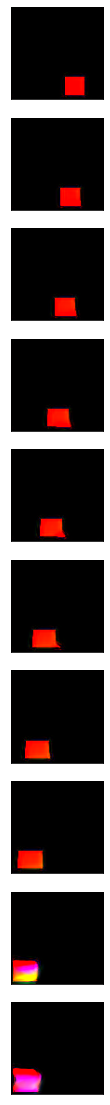

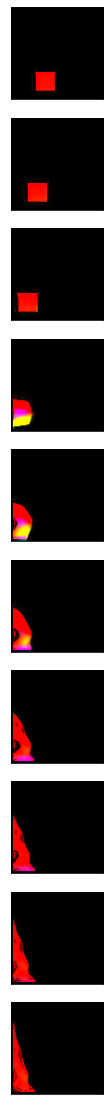

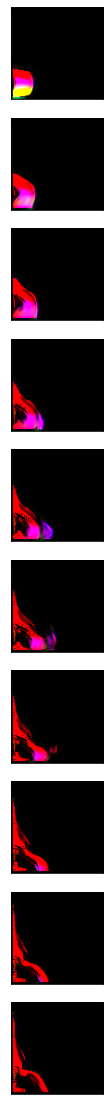

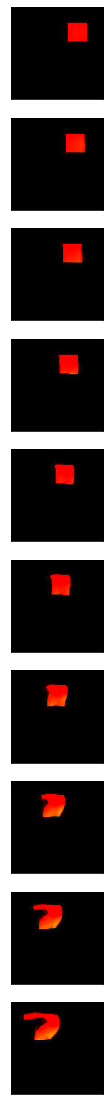

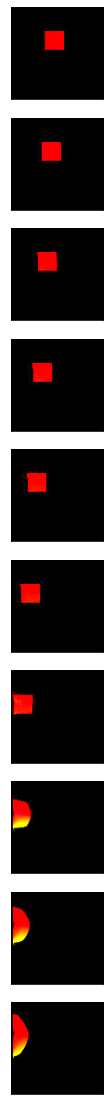

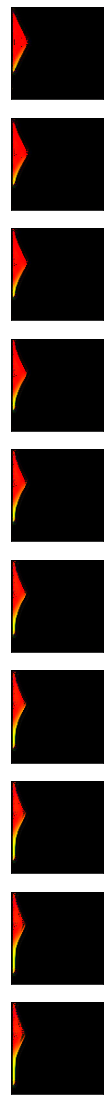

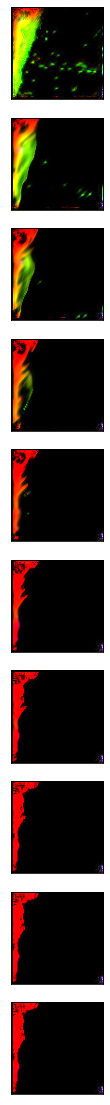

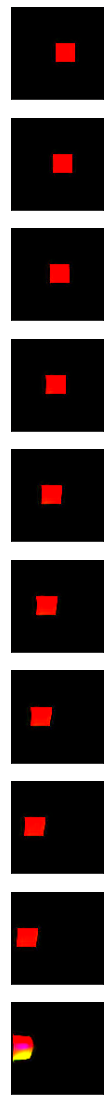

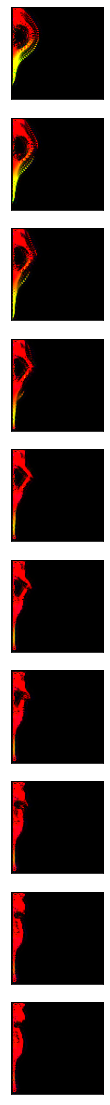

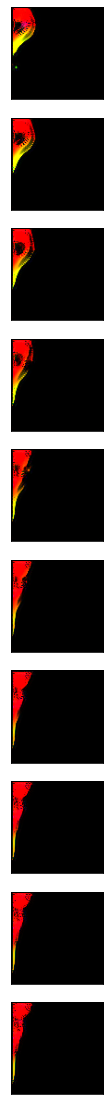

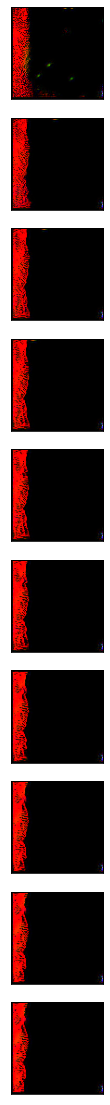

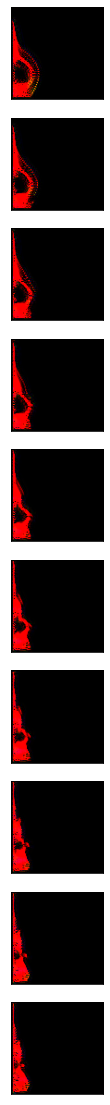

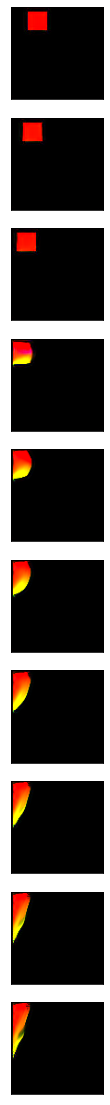

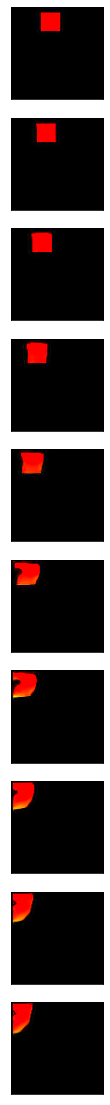

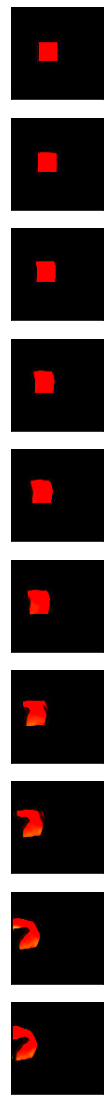

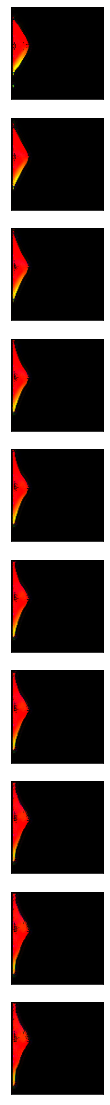

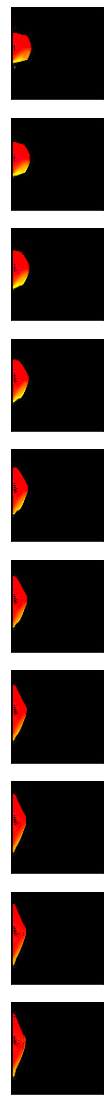

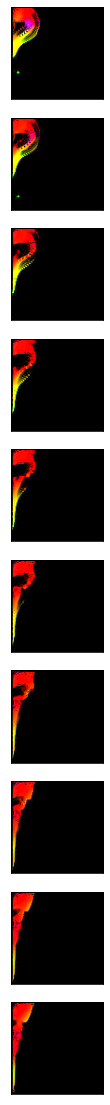

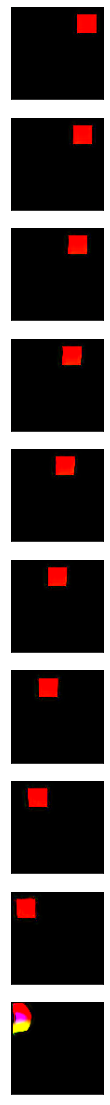

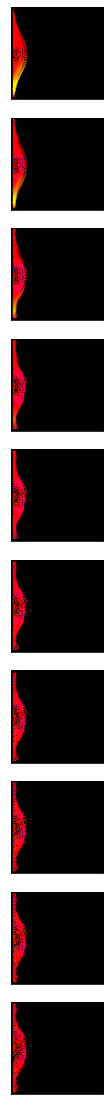

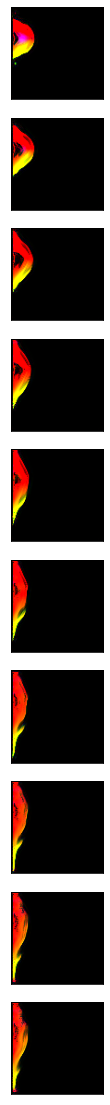

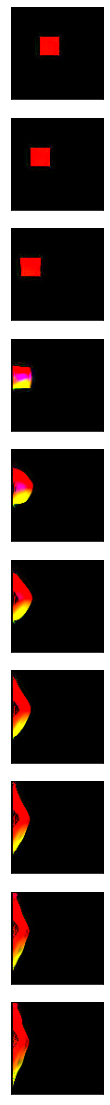

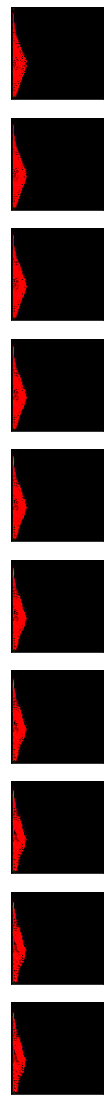

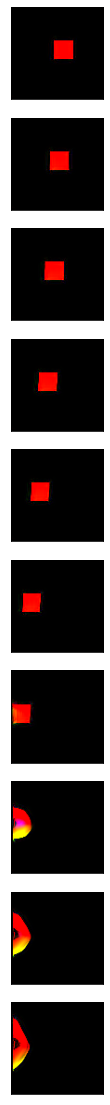

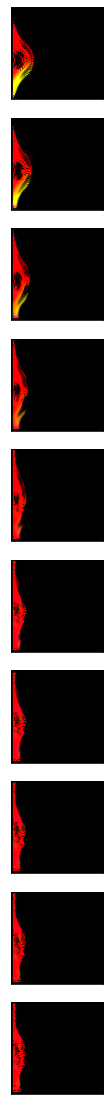

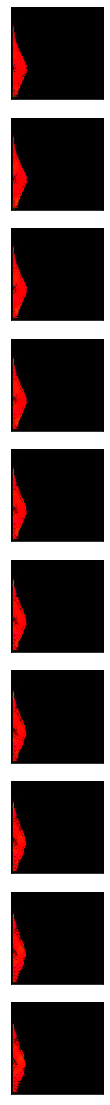

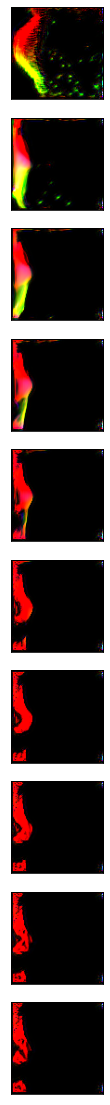

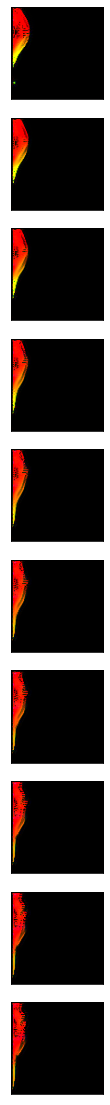

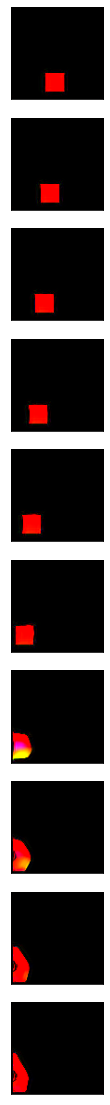

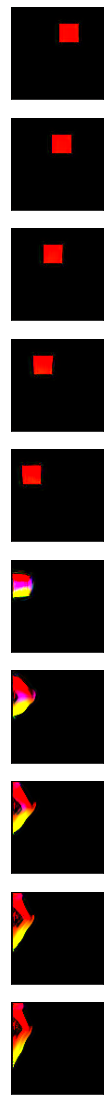

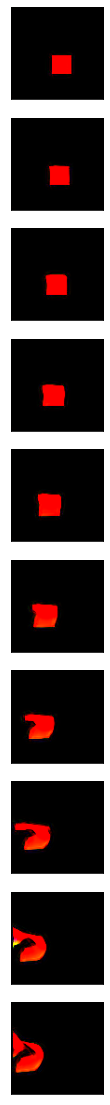

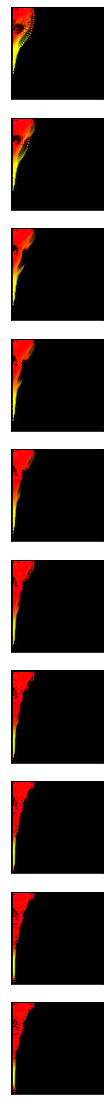

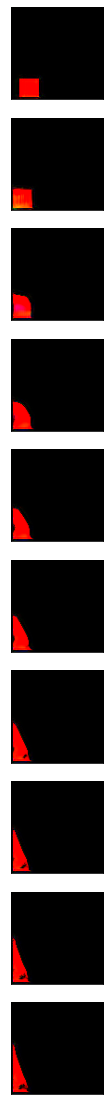

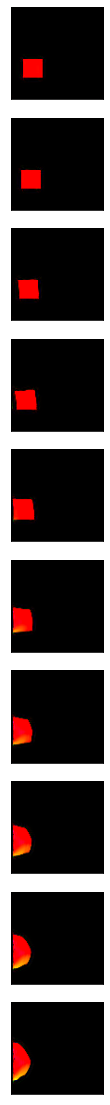

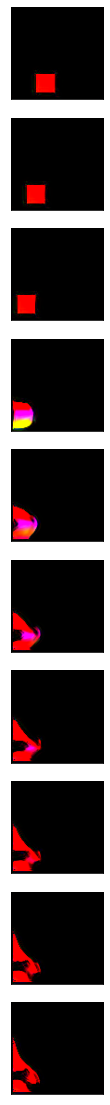

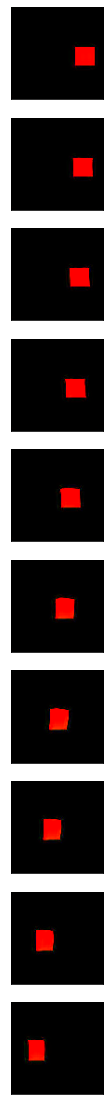

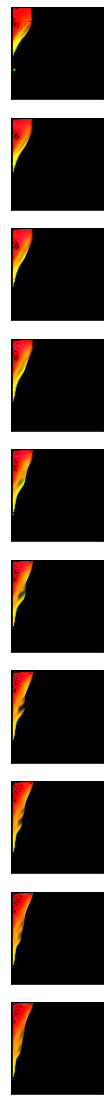

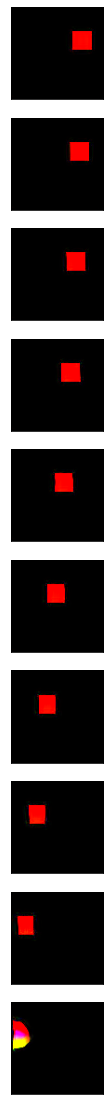

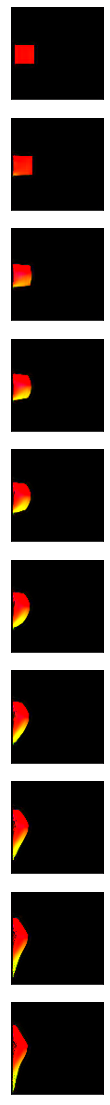

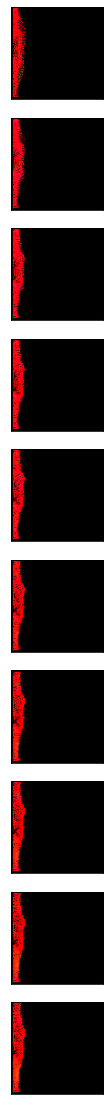

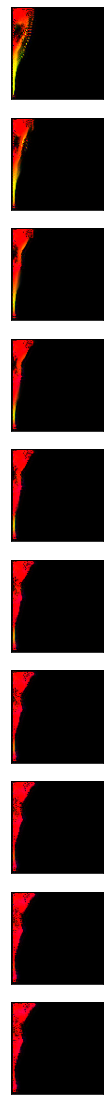

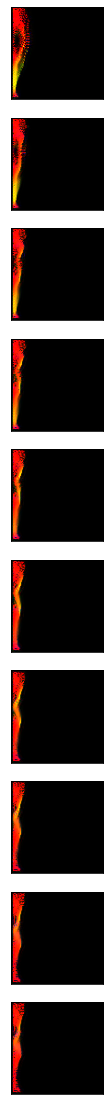

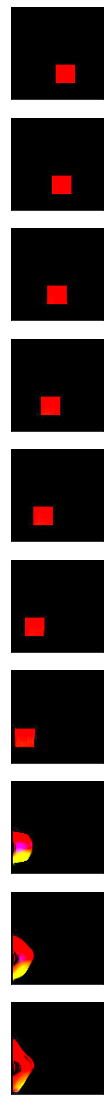

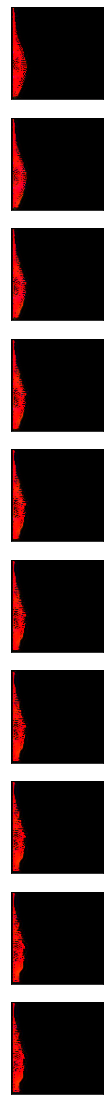

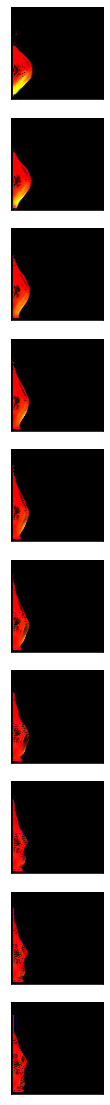

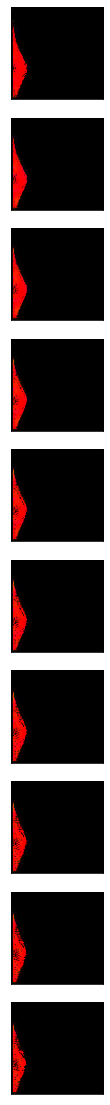

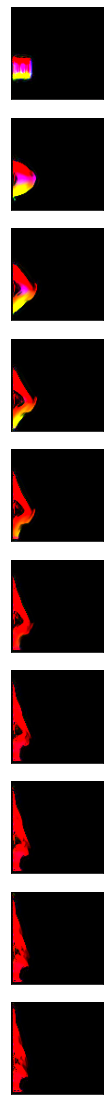

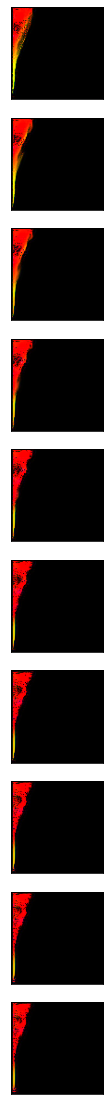

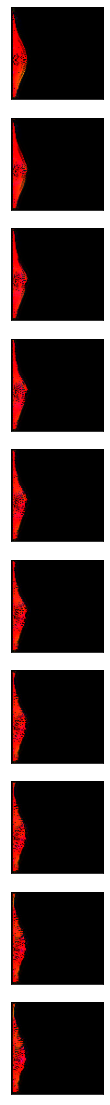

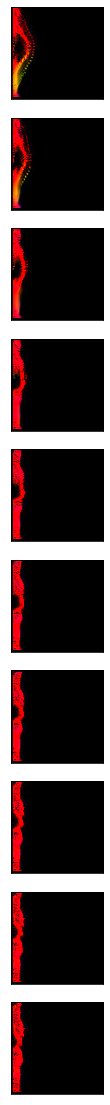

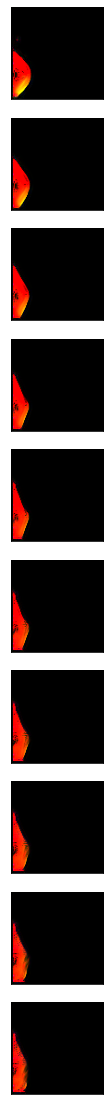

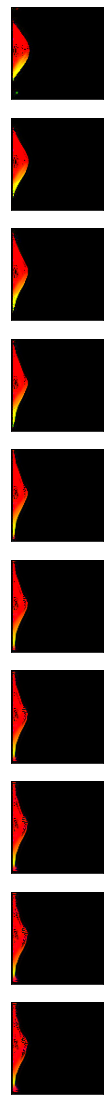

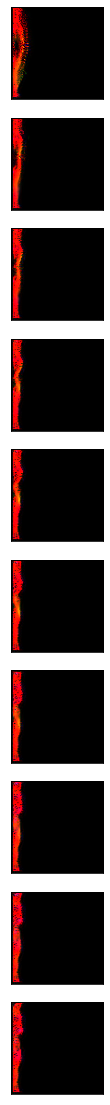

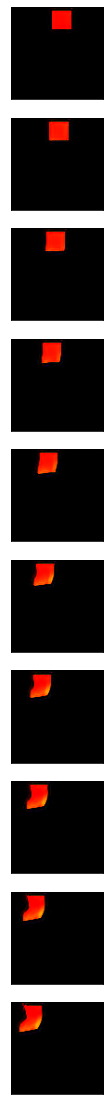

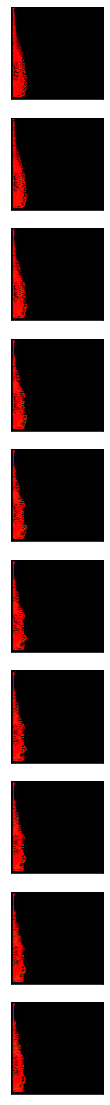

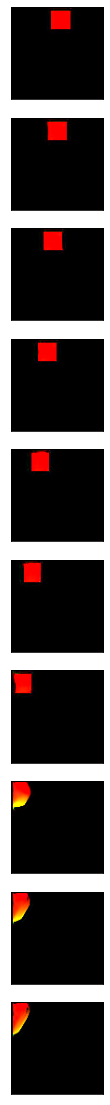

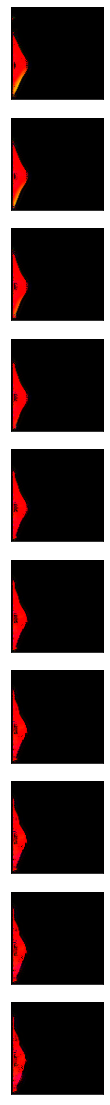

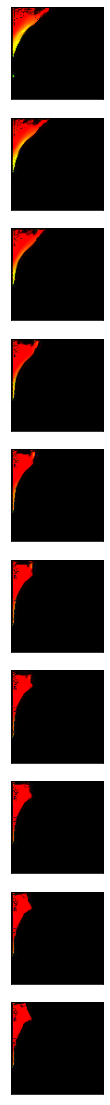

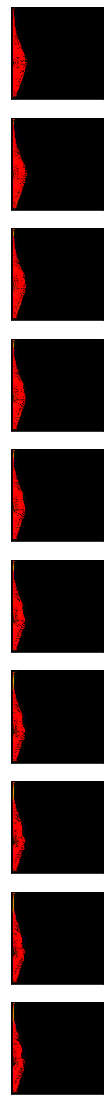

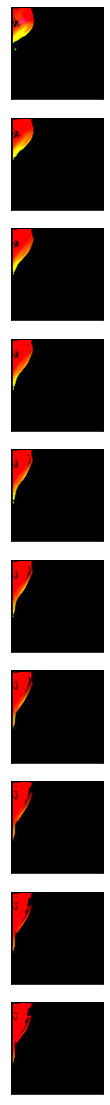

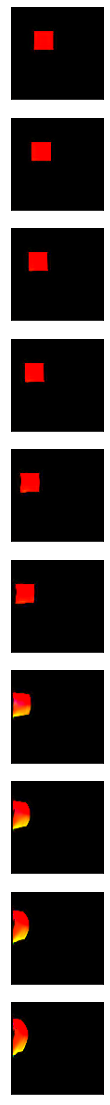

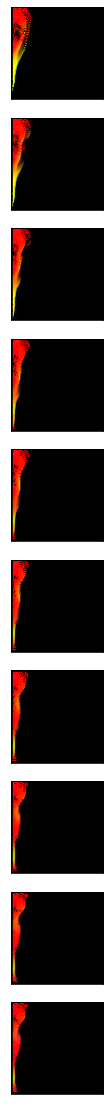

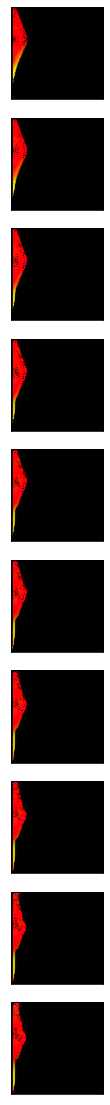

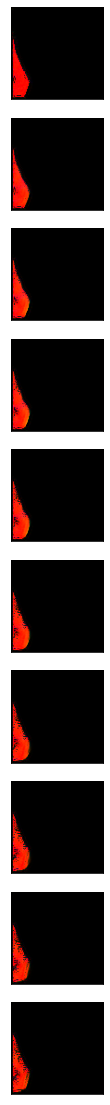

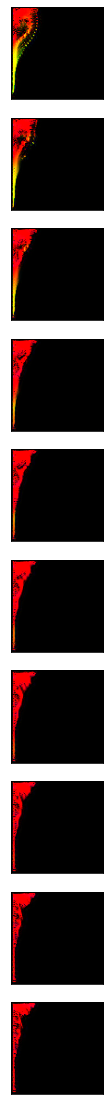

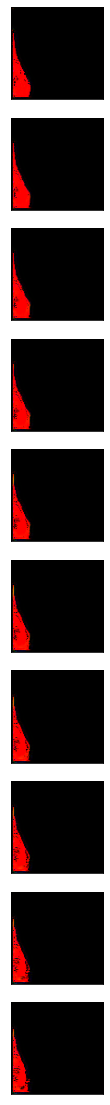

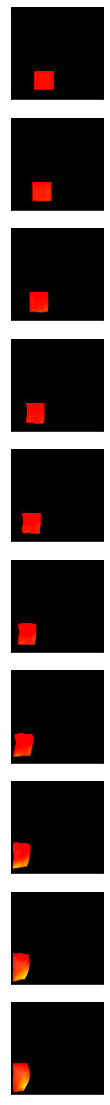

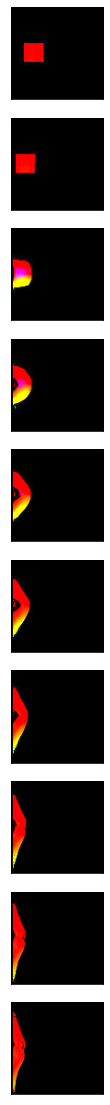

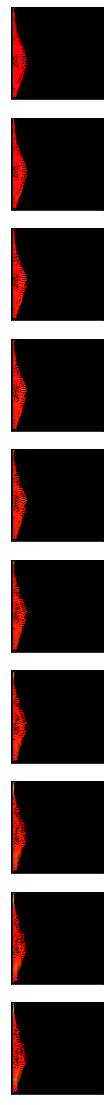

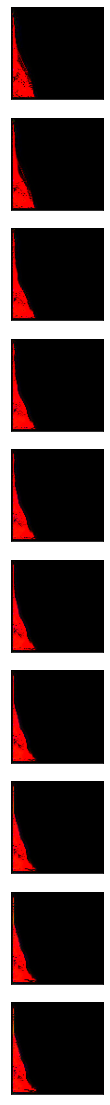

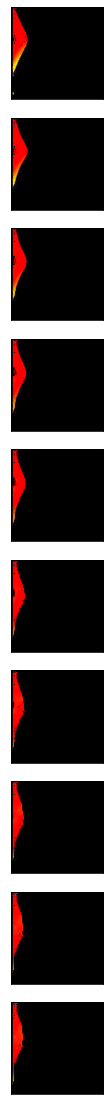

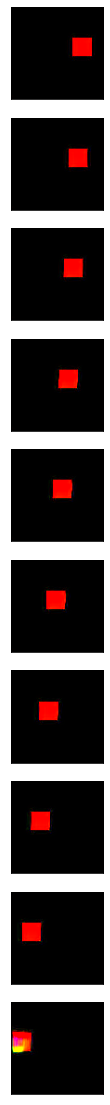

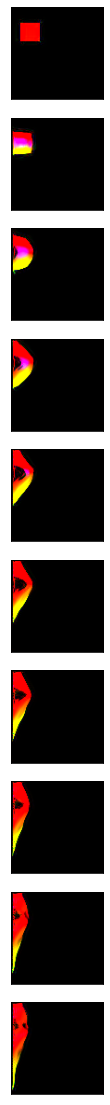

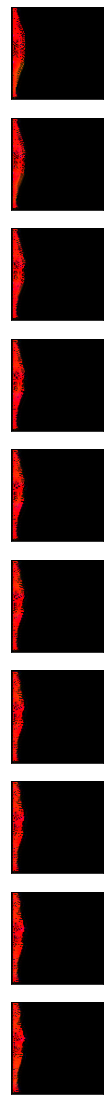

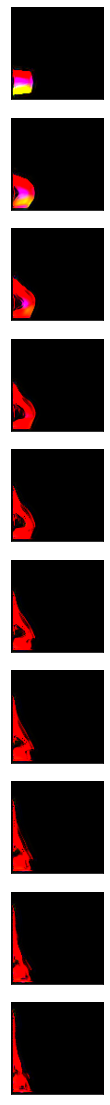

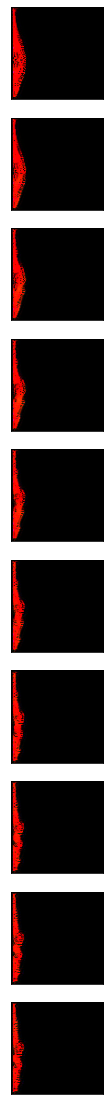

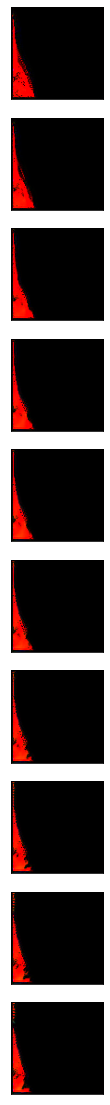

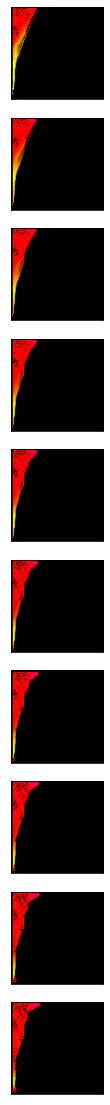

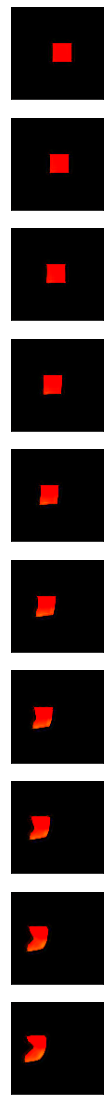

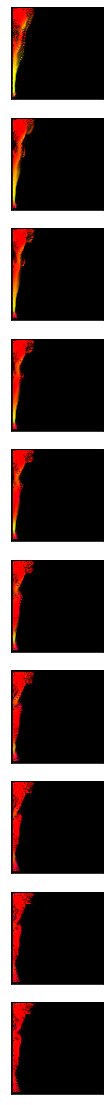

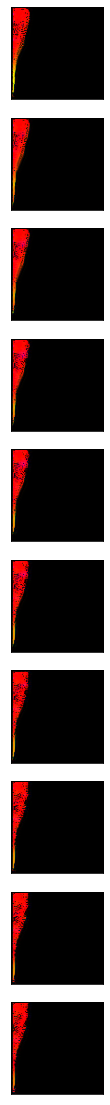

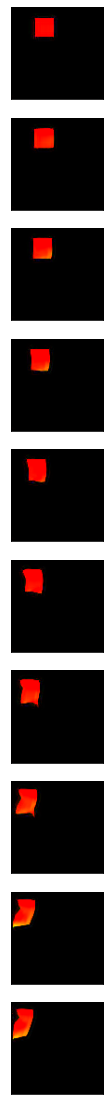

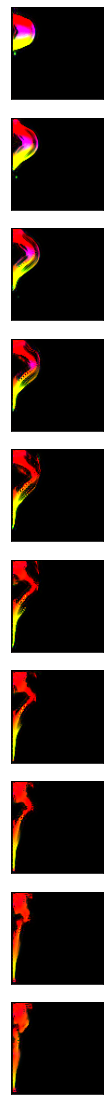

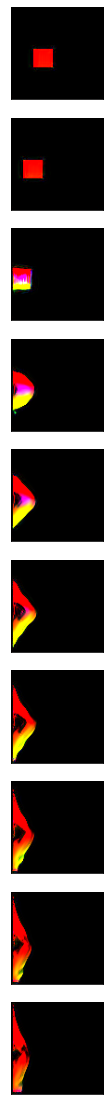

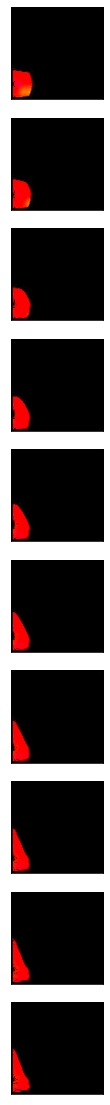

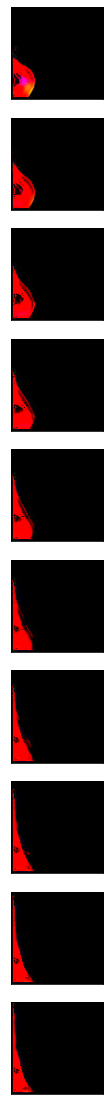

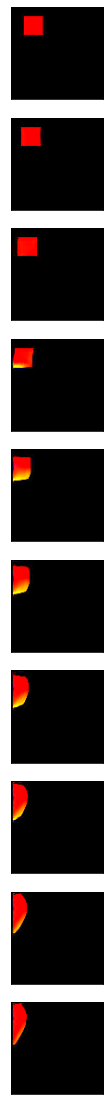

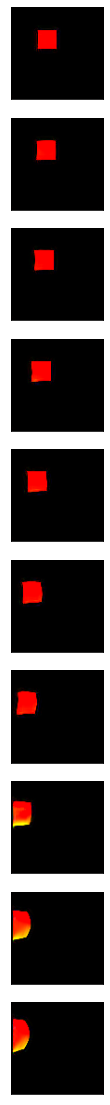

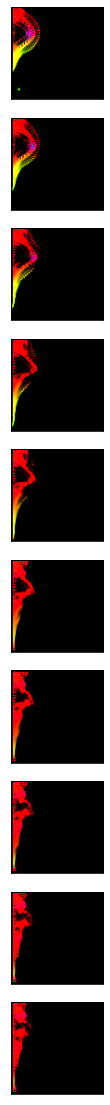

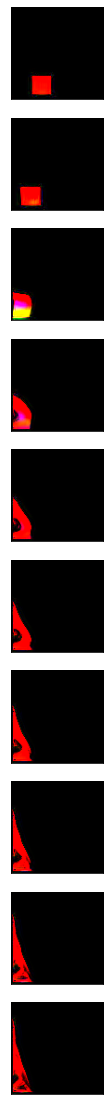

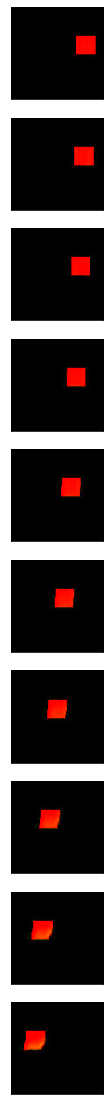

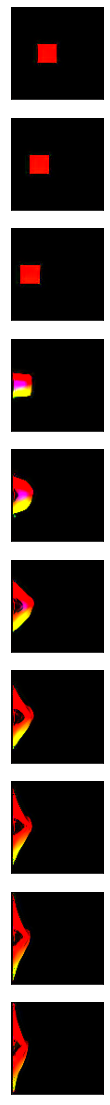

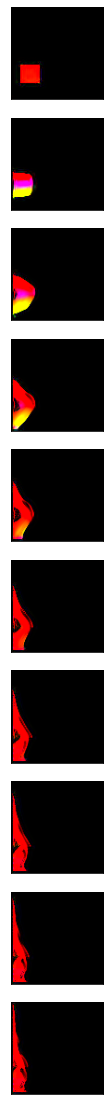

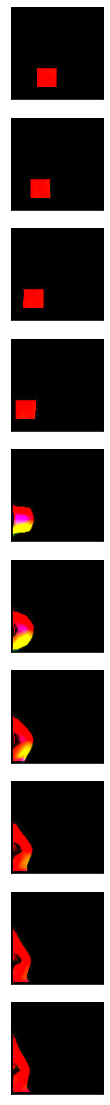

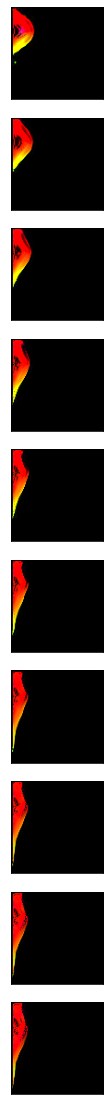

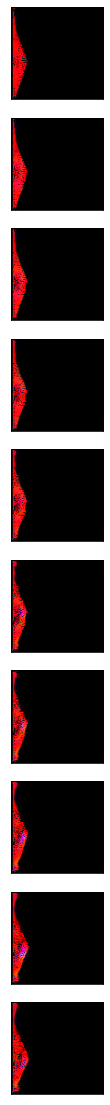

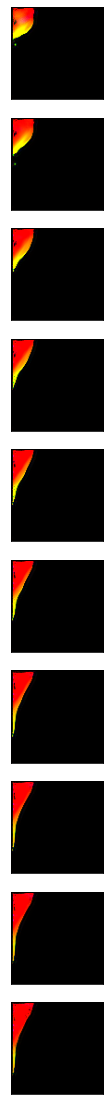

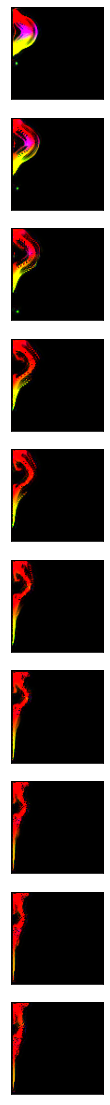

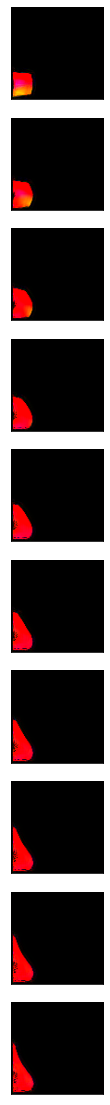

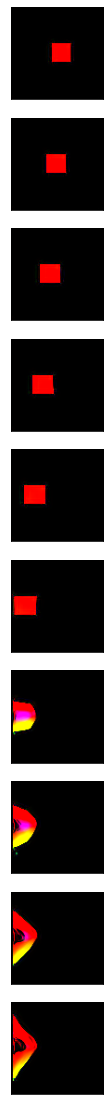

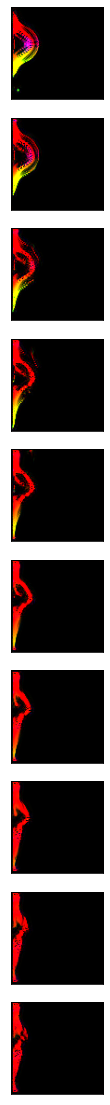

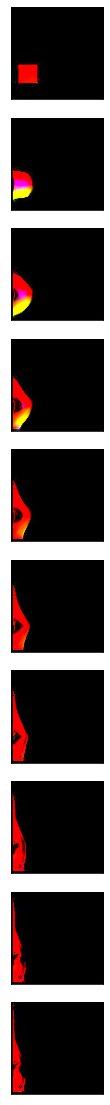

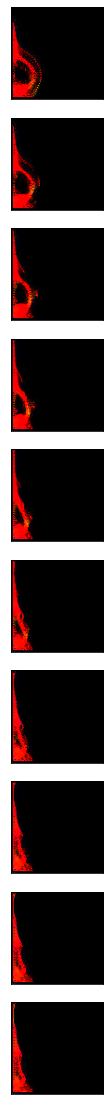

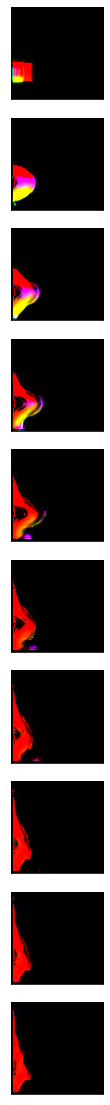

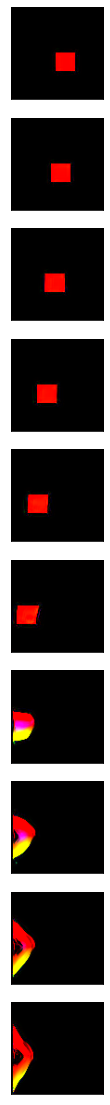

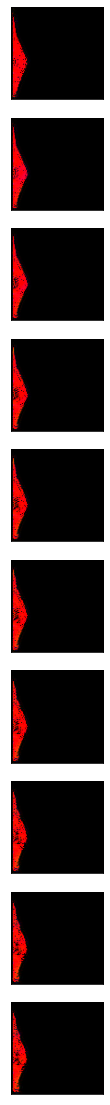

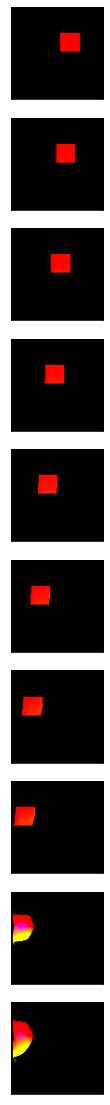

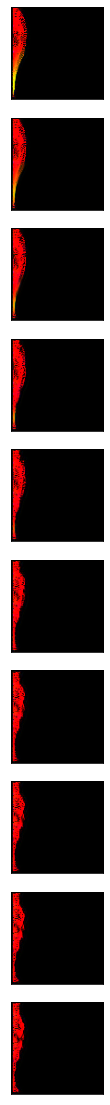

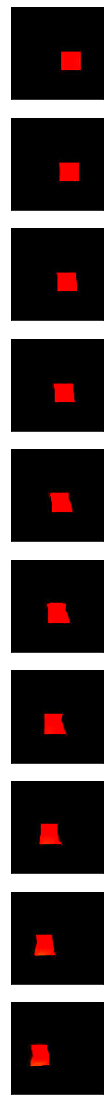

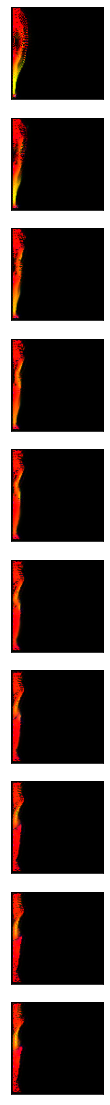

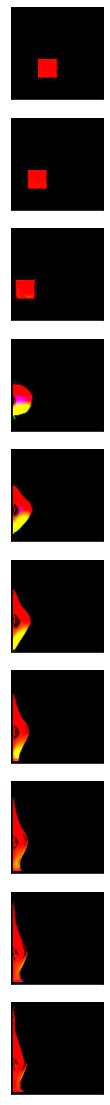

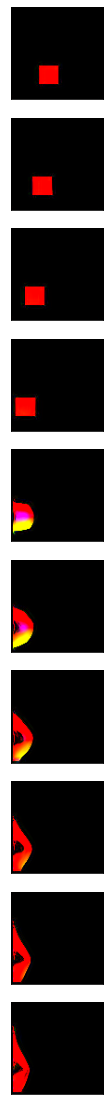

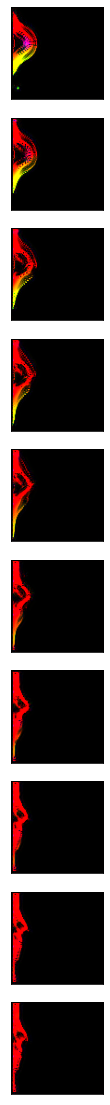

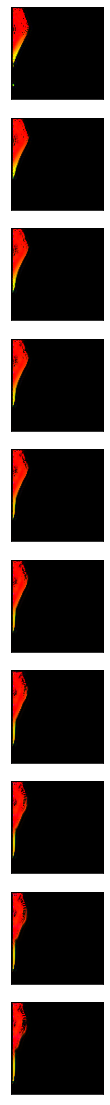

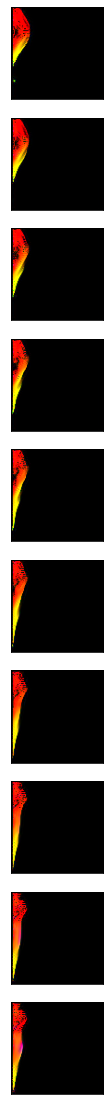

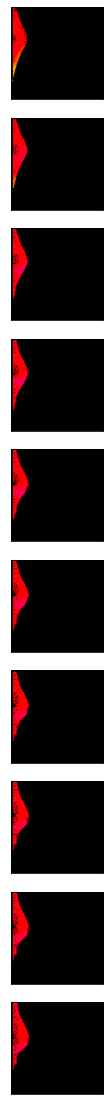

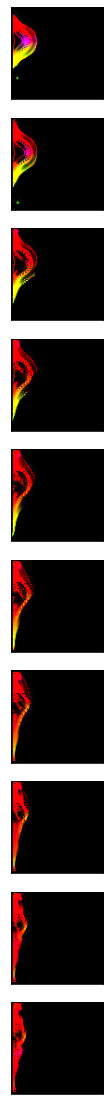

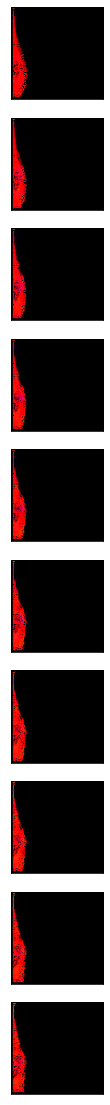

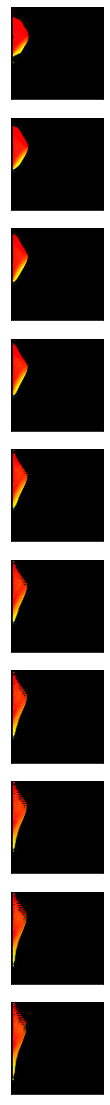

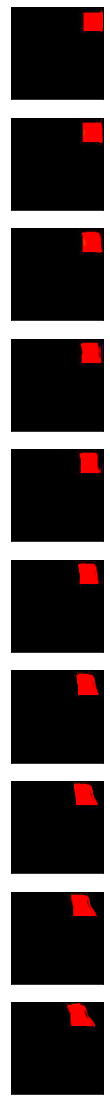

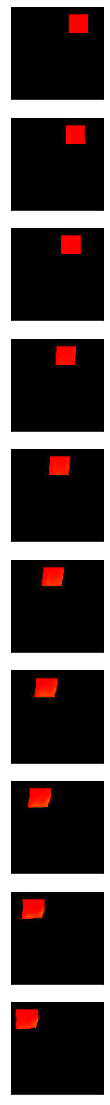

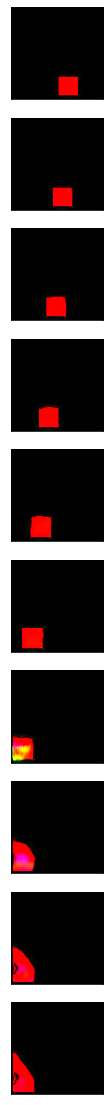

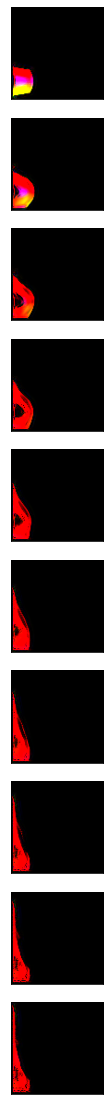

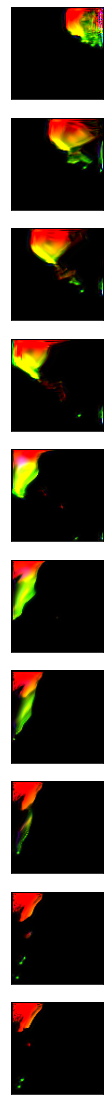

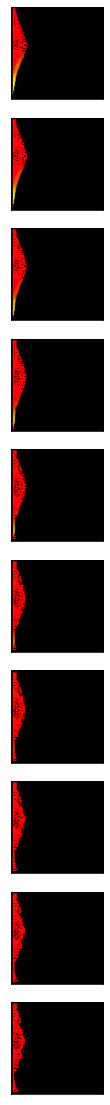

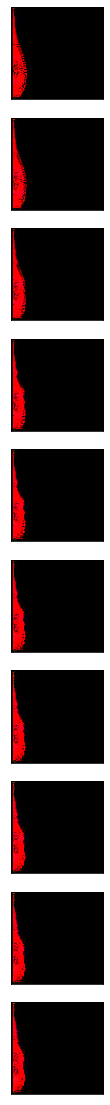

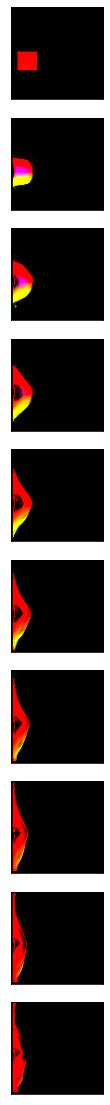

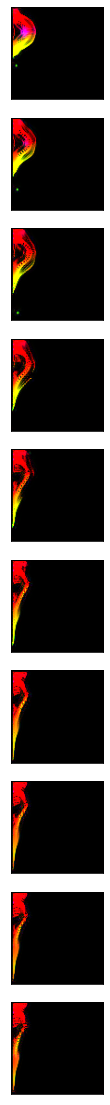

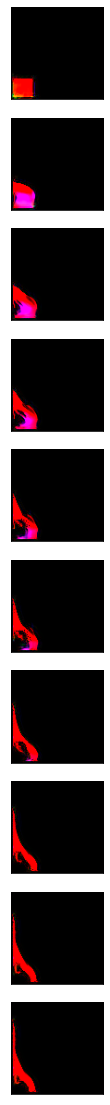

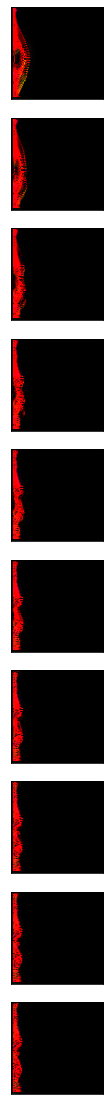

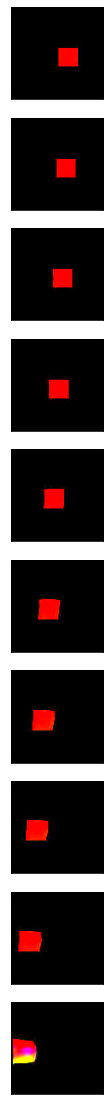

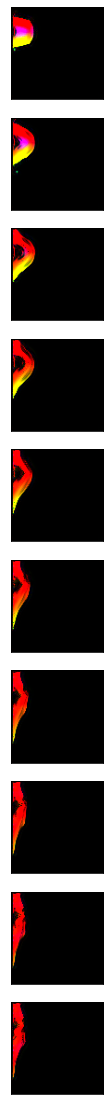

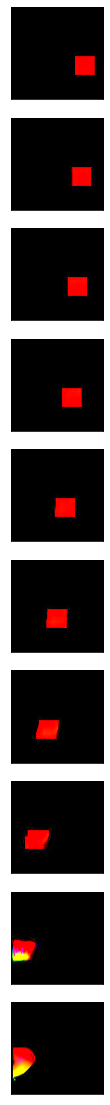

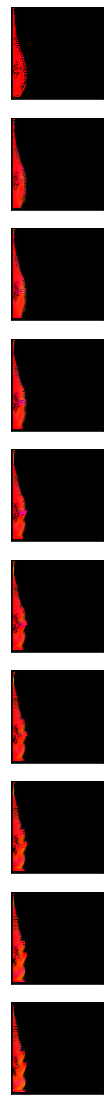

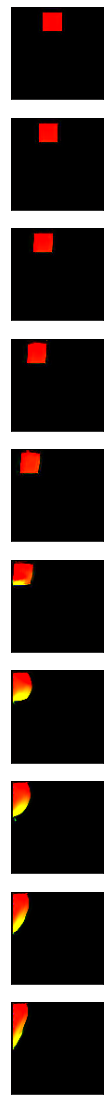

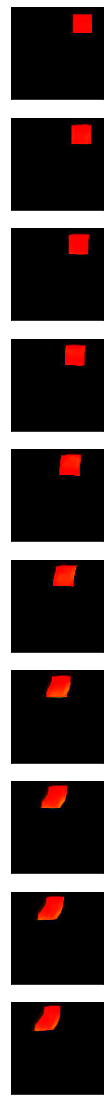

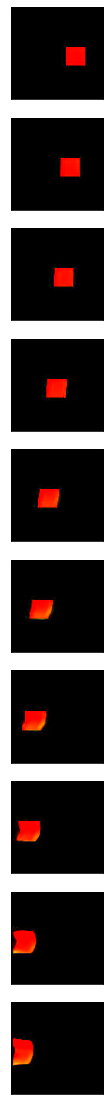

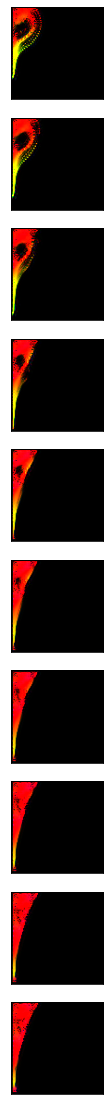

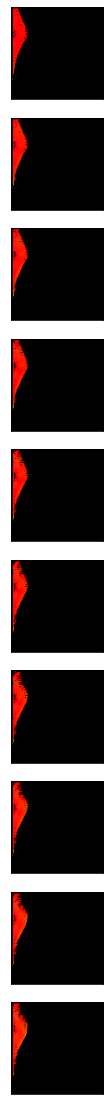

In [15]:
optimizer = torch.optim.Adam(model_origin.parameters(), lr=0.0001)

import datetime
dateTimeObj = datetime.datetime.now()
timestampStr = dateTimeObj.strftime("%d_%b_%Y_%H_%M")
if timestampStr not in os.listdir("../data/model/"):
    os.mkdir("../data/model/"+timestampStr)

for epoch in range(1, epochs+1):
    epoch_loss = train(model=model_origin, discnet=netD, train_loader=trainloader, epochnow=epoch)
    print("[Epoch {}] loss:{}".format(epoch, epoch_loss))
    torch.save(model_origin.state_dict(), "../data/model/" + timestampStr + "/new_stepwise_ep{}.pt".format(epoch))
    torch.save(netD.state_dict(), "../data/model/" + timestampStr + "/new_discnet_ep{}.pt".format(epoch))

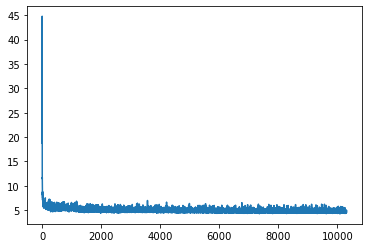

In [ ]:
plt.plot(loss_history)
plt.show()
torch.cuda.empty_cache()


In [ ]:
# torch.cuda.empty_cache()
# model_origin = StepAE().to(device)
# model_origin.load_state_dict(torch.load("cifar10.pt"))
model_origin.eval()

StepAE(
  (enc): Autoencoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
    (decoder): Sequential(
      (0): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): ConvTranspose2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    )
  )
)

# Visualize

In [ ]:
model_origin = StepAE().to(device)
model_origin.load_state_dict(torch.load("../data/model/27_May_2022_18_52/new_stepwise_ep5.pt"))
model_origin.eval()

StepAE(
  (enc): Autoencoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
    (decoder): Sequential(
      (0): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): ConvTranspose2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    )
  )
)